In [1]:
%load_ext autoreload
%matplotlib inline

%autoreload 2

# %load_ext watermark
# %watermark -v -n -m -p numpy,scipy,sklearn,pandas,tensorflow,keras



In [2]:
from data.preprocess import PreProcessor

data = PreProcessor(config=PreProcessor.DEFAULT_CONFIG,
                    data_dir='data/raw/r252-corpus-features/org/elasticsearch/action/')
# data = PreProcessor(config=PreProcessor.DEFAULT_CONFIG,
#                     data_dir='data/raw/r252-corpus-features/org/elasticsearch/')

vocab = data.metadata['token_vocab']
processed = data.get_tensorise_data()


In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers

from models.cnn_attention import ConvAttention
from utils.activations import masked_sparse_cross_entropy_loss

# TODO make the input a json file and parse it
vocabulary_size = len(vocab) + 1
max_chunk_length = data.config['max_chunk_length']
hyperparameter = {'batch_size': 1, 'k1': 8, 'k2': 8, 'w1': 24, 'w2': 29, 'w3': 10, 'dropout_rate': 0,
                  'max_chunk_length': max_chunk_length, 'vocabulary_size': vocabulary_size, 'embedding_dim': 128}

# code_snippet = processed['body_tokens']
code_snippet = np.expand_dims(processed['body_tokens'], axis=-1)
label_name = np.expand_dims(processed['name_tokens'], axis=-1)
# dataset = tf.data.Dataset.from_tensor_slices((code_snippet, label_name))
# dataset = dataset.shuffle(1000).batch(hyperparameter['batch_size'], drop_remainder=True).repeat()

# label_name = processed['name_tokens']
# label_name = keras.utils.to_categorical(processed['name_tokens'], num_classes=vocabulary_size)
print("Vocab Size: {} number of Code snippet: {} number of labels: {}".format(vocabulary_size, len(code_snippet),
                                                                              len(label_name)))
print("Label_name shape: {}\nCode_snippet shape: {}".format(label_name.shape, code_snippet.shape))

# Optimised hyperparameter are reported in page 5 of the paper

batch_size = hyperparameter['batch_size']
# define layers
main_input = layers.Input(shape=(max_chunk_length, 1),
                          batch_size=batch_size,
                          dtype=tf.int32, name='main_input',
                          )

cnn_layer = ConvAttention(hyperparameter)

optimizer = keras.optimizers.Nadam()  # RMSprop with Nesterov momentum
# loss_func = masked_sparse_cross_entropy_loss
loss_func = keras.losses.sparse_categorical_crossentropy

# define execution
cnn_output = cnn_layer(main_input)
model = keras.Model(inputs=[main_input], outputs=cnn_output)
model.compile(optimizer=optimizer,
              loss=loss_func,
              metrics=['accuracy'],
              )
# fit the model
# tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True,
#                                          batch_size=batch_size)
history = model.fit(code_snippet,
                    label_name,
                    epochs=30,
                    verbose=1,
                    batch_size=batch_size,
                    # steps_per_epoch=1,
                    # callbacks=[tbCallBack],
                    validation_split=0.2,
                    )


Vocab Size: 1404 number of Code snippet: 1391 number of labels: 1391
Label_name shape: (1391, 50, 1)
Code_snippet shape: (1391, 50, 1)
ConvAttention: mask_vector shape = (1, 50, 1)
ConvAttention: Tokens shape = (1, 50, 1, 128)


ConvAttention: h_t shape = (1, 50, 8)
AttentionFeatures: C shape = (1, 50, 1, 128), h_t shape = (1, 50, 8)
AttentionFeatures: L_1 shape = (1, 50, 1, 8)
AttentionFeatures: L_2 shape = (1, 50, 1, 8)
AttentionFeatures: L_2 shape  after multiply = (1, 50, 50, 8)
AttentionFeatures: L_feat shape = (1, 50, 50, 8)
ConvAttention: L_feat shape = (1, 50, 50, 8)
AttentionWeights: l_feat shape = (1, 50, 50, 8)
AttentionWeights: attention_weight shape = (1, 50, 50, 1)
ConvAttention: alpha shape = (1, 50, 50)
ConvAttention: n_hat shape = (1, 50, 128)
ConvAttention: E shape = (1404, 128)
ConvAttention: n_hat_E shape = (1, 50, 1404)


ConvAttention: n shape = (1, 50, 1404)
Train on 1112 samples, validate on 279 samples


Epoch 1/30


   1/1112 [..............................] - ETA: 23:50 - loss: 7.2269 - acc: 0.9000

   4/1112 [..............................] - ETA: 6:12 - loss: 7.2306 - acc: 0.6900 

   7/1112 [..............................] - ETA: 3:41 - loss: 7.2060 - acc: 0.7743

  10/1112 [..............................] - ETA: 2:41 - loss: 7.1977 - acc: 0.7980

  13/1112 [..............................] - ETA: 2:08 - loss: 7.1870 - acc: 0.8169

  16/1112 [..............................] - ETA: 1:48 - loss: 7.1739 - acc: 0.8150

  19/1112 [..............................] - ETA: 1:34 - loss: 7.1690 - acc: 0.7989

  22/1112 [..............................] - ETA: 1:24 - loss: 7.1424 - acc: 0.8145

  25/1112 [..............................] - ETA: 1:16 - loss: 7.1208 - acc: 0.8248

  28/1112 [..............................] - ETA: 1:10 - loss: 7.0915 - acc: 0.8350

  31/1112 [..............................] - ETA: 1:05 - loss: 7.0715 - acc: 0.8361

  34/1112 [..............................] - ETA: 1:01 - loss: 7.0521 - acc: 0.8382

  37/1112 [..............................] - ETA: 58s - loss: 7.0065 - acc: 0.7746 

  40/1112 [>.............................] - ETA: 55s - loss: 6.9491 - acc: 0.7315

  43/1112 [>.............................] - ETA: 52s - loss: 6.9049 - acc: 0.6823

  46/1112 [>.............................] - ETA: 50s - loss: 6.8899 - acc: 0.6400

  49/1112 [>.............................] - ETA: 48s - loss: 6.8570 - acc: 0.6061

  52/1112 [>.............................] - ETA: 46s - loss: 6.7917 - acc: 0.5723

  55/1112 [>.............................] - ETA: 45s - loss: 6.7196 - acc: 0.5433

  58/1112 [>.............................] - ETA: 43s - loss: 6.6552 - acc: 0.5169

  61/1112 [>.............................] - ETA: 42s - loss: 6.6091 - acc: 0.4931

  64/1112 [>.............................] - ETA: 41s - loss: 6.5517 - acc: 0.4712

  67/1112 [>.............................] - ETA: 40s - loss: 6.5088 - acc: 0.4516

  70/1112 [>.............................] - ETA: 39s - loss: 6.4686 - acc: 0.4337

  73/1112 [>.............................] - ETA: 38s - loss: 6.3860 - acc: 0.4167

  76/1112 [=>............................] - ETA: 37s - loss: 6.3108 - acc: 0.4011

  79/1112 [=>............................] - ETA: 37s - loss: 6.2677 - acc: 0.3876

  82/1112 [=>............................] - ETA: 36s - loss: 6.1822 - acc: 0.3741

  85/1112 [=>............................] - ETA: 35s - loss: 6.0981 - acc: 0.3616

  88/1112 [=>............................] - ETA: 35s - loss: 6.0585 - acc: 0.3582

  91/1112 [=>............................] - ETA: 34s - loss: 5.9553 - acc: 0.3475

  94/1112 [=>............................] - ETA: 33s - loss: 5.8725 - acc: 0.3655

  96/1112 [=>............................] - ETA: 33s - loss: 5.8456 - acc: 0.3765

  99/1112 [=>............................] - ETA: 33s - loss: 5.7495 - acc: 0.3915

 102/1112 [=>............................] - ETA: 32s - loss: 5.6970 - acc: 0.4051

 105/1112 [=>............................] - ETA: 32s - loss: 5.6309 - acc: 0.4194

 108/1112 [=>............................] - ETA: 31s - loss: 5.5264 - acc: 0.4319

 111/1112 [=>............................] - ETA: 31s - loss: 5.4568 - acc: 0.4440

 114/1112 [==>...........................] - ETA: 30s - loss: 5.3744 - acc: 0.4560

 117/1112 [==>...........................] - ETA: 30s - loss: 5.2911 - acc: 0.4680

 120/1112 [==>...........................] - ETA: 30s - loss: 5.2044 - acc: 0.4793

 123/1112 [==>...........................] - ETA: 29s - loss: 5.1246 - acc: 0.4898

 126/1112 [==>...........................] - ETA: 29s - loss: 5.0691 - acc: 0.4987

 129/1112 [==>...........................] - ETA: 29s - loss: 4.9943 - acc: 0.5084

 132/1112 [==>...........................] - ETA: 28s - loss: 4.9459 - acc: 0.5171

 135/1112 [==>...........................] - ETA: 28s - loss: 4.8958 - acc: 0.5255

 138/1112 [==>...........................] - ETA: 28s - loss: 4.8415 - acc: 0.5335

 141/1112 [==>...........................] - ETA: 28s - loss: 4.7785 - acc: 0.5416

 144/1112 [==>...........................] - ETA: 27s - loss: 4.7051 - acc: 0.5493

 147/1112 [==>...........................] - ETA: 27s - loss: 4.6538 - acc: 0.5562

 150/1112 [===>..........................] - ETA: 27s - loss: 4.5792 - acc: 0.5627

 153/1112 [===>..........................] - ETA: 27s - loss: 4.5216 - acc: 0.5692

 156/1112 [===>..........................] - ETA: 26s - loss: 4.4537 - acc: 0.5759

 159/1112 [===>..........................] - ETA: 26s - loss: 4.4009 - acc: 0.5818

 162/1112 [===>..........................] - ETA: 26s - loss: 4.3503 - acc: 0.5868

 165/1112 [===>..........................] - ETA: 26s - loss: 4.3111 - acc: 0.5921

 168/1112 [===>..........................] - ETA: 25s - loss: 4.2526 - acc: 0.5975

 171/1112 [===>..........................] - ETA: 25s - loss: 4.2293 - acc: 0.6021

 174/1112 [===>..........................] - ETA: 25s - loss: 4.1720 - acc: 0.6076

 177/1112 [===>..........................] - ETA: 25s - loss: 4.1290 - acc: 0.6128

 180/1112 [===>..........................] - ETA: 25s - loss: 4.0847 - acc: 0.6172

 183/1112 [===>..........................] - ETA: 24s - loss: 4.0549 - acc: 0.6221

 186/1112 [====>.........................] - ETA: 24s - loss: 4.0078 - acc: 0.6263

 189/1112 [====>.........................] - ETA: 24s - loss: 3.9623 - acc: 0.6306

 192/1112 [====>.........................] - ETA: 24s - loss: 3.9193 - acc: 0.6351

 195/1112 [====>.........................] - ETA: 24s - loss: 3.8798 - acc: 0.6392

 198/1112 [====>.........................] - ETA: 23s - loss: 3.8404 - acc: 0.6431

 201/1112 [====>.........................] - ETA: 23s - loss: 3.8046 - acc: 0.6473

 204/1112 [====>.........................] - ETA: 23s - loss: 3.7662 - acc: 0.6510

 207/1112 [====>.........................] - ETA: 23s - loss: 3.7257 - acc: 0.6546

 210/1112 [====>.........................] - ETA: 23s - loss: 3.6962 - acc: 0.6583

 213/1112 [====>.........................] - ETA: 23s - loss: 3.6640 - acc: 0.6614

 216/1112 [====>.........................] - ETA: 23s - loss: 3.6359 - acc: 0.6645

 219/1112 [====>.........................] - ETA: 22s - loss: 3.6094 - acc: 0.6676

 222/1112 [====>.........................] - ETA: 22s - loss: 3.5754 - acc: 0.6707

 225/1112 [=====>........................] - ETA: 22s - loss: 3.5407 - acc: 0.6740

 228/1112 [=====>........................] - ETA: 22s - loss: 3.5098 - acc: 0.6770

 231/1112 [=====>........................] - ETA: 22s - loss: 3.4858 - acc: 0.6798

 234/1112 [=====>........................] - ETA: 22s - loss: 3.4632 - acc: 0.6823

 237/1112 [=====>........................] - ETA: 22s - loss: 3.4329 - acc: 0.6851

 240/1112 [=====>........................] - ETA: 21s - loss: 3.4083 - acc: 0.6874

 242/1112 [=====>........................] - ETA: 21s - loss: 3.3890 - acc: 0.6890

 245/1112 [=====>........................] - ETA: 21s - loss: 3.3598 - acc: 0.6916

 248/1112 [=====>........................] - ETA: 21s - loss: 3.3296 - acc: 0.6943

 251/1112 [=====>........................] - ETA: 21s - loss: 3.3003 - acc: 0.6968

 254/1112 [=====>........................] - ETA: 21s - loss: 3.2738 - acc: 0.6988

 256/1112 [=====>........................] - ETA: 21s - loss: 3.2608 - acc: 0.7003

 258/1112 [=====>........................] - ETA: 21s - loss: 3.2423 - acc: 0.7016

 260/1112 [======>.......................] - ETA: 21s - loss: 3.2230 - acc: 0.7033

 262/1112 [======>.......................] - ETA: 21s - loss: 3.2038 - acc: 0.7048

 265/1112 [======>.......................] - ETA: 21s - loss: 3.1767 - acc: 0.7072

 268/1112 [======>.......................] - ETA: 21s - loss: 3.1510 - acc: 0.7092

 270/1112 [======>.......................] - ETA: 21s - loss: 3.1346 - acc: 0.7105

 273/1112 [======>.......................] - ETA: 20s - loss: 3.1080 - acc: 0.7126

 276/1112 [======>.......................] - ETA: 20s - loss: 3.0885 - acc: 0.7147

 279/1112 [======>.......................] - ETA: 20s - loss: 3.0639 - acc: 0.7167

 282/1112 [======>.......................] - ETA: 20s - loss: 3.0674 - acc: 0.7160

 285/1112 [======>.......................] - ETA: 20s - loss: 3.0433 - acc: 0.7180

 288/1112 [======>.......................] - ETA: 20s - loss: 3.0228 - acc: 0.7199

 291/1112 [======>.......................] - ETA: 20s - loss: 2.9994 - acc: 0.7218

 294/1112 [======>.......................] - ETA: 20s - loss: 2.9785 - acc: 0.7235

 297/1112 [=======>......................] - ETA: 20s - loss: 2.9590 - acc: 0.7253

 300/1112 [=======>......................] - ETA: 19s - loss: 2.9380 - acc: 0.7270

 303/1112 [=======>......................] - ETA: 19s - loss: 2.9155 - acc: 0.7288

 306/1112 [=======>......................] - ETA: 19s - loss: 2.8965 - acc: 0.7306

 309/1112 [=======>......................] - ETA: 19s - loss: 2.8913 - acc: 0.7317

 312/1112 [=======>......................] - ETA: 19s - loss: 2.8695 - acc: 0.7333

 315/1112 [=======>......................] - ETA: 19s - loss: 2.8513 - acc: 0.7349

 318/1112 [=======>......................] - ETA: 19s - loss: 2.8378 - acc: 0.7365

 321/1112 [=======>......................] - ETA: 19s - loss: 2.8218 - acc: 0.7380

 324/1112 [=======>......................] - ETA: 19s - loss: 2.8022 - acc: 0.7396

 327/1112 [=======>......................] - ETA: 18s - loss: 2.7839 - acc: 0.7411

 330/1112 [=======>......................] - ETA: 18s - loss: 2.7656 - acc: 0.7425

 333/1112 [=======>......................] - ETA: 18s - loss: 2.7471 - acc: 0.7440

 336/1112 [========>.....................] - ETA: 18s - loss: 2.7309 - acc: 0.7455

 339/1112 [========>.....................] - ETA: 18s - loss: 2.7138 - acc: 0.7468

 342/1112 [========>.....................] - ETA: 18s - loss: 2.6946 - acc: 0.7484

 345/1112 [========>.....................] - ETA: 18s - loss: 2.6855 - acc: 0.7498

 348/1112 [========>.....................] - ETA: 18s - loss: 2.6709 - acc: 0.7512

 351/1112 [========>.....................] - ETA: 18s - loss: 2.6545 - acc: 0.7525

 354/1112 [========>.....................] - ETA: 18s - loss: 2.6404 - acc: 0.7534

 356/1112 [========>.....................] - ETA: 18s - loss: 2.6291 - acc: 0.7543

 359/1112 [========>.....................] - ETA: 17s - loss: 2.6132 - acc: 0.7554

 362/1112 [========>.....................] - ETA: 17s - loss: 2.5995 - acc: 0.7565

 365/1112 [========>.....................] - ETA: 17s - loss: 2.5841 - acc: 0.7576

 368/1112 [========>.....................] - ETA: 17s - loss: 2.5680 - acc: 0.7589

 371/1112 [=========>....................] - ETA: 17s - loss: 2.5544 - acc: 0.7601

 374/1112 [=========>....................] - ETA: 17s - loss: 2.5412 - acc: 0.7613

 377/1112 [=========>....................] - ETA: 17s - loss: 2.5255 - acc: 0.7627

 380/1112 [=========>....................] - ETA: 17s - loss: 2.5092 - acc: 0.7639

 383/1112 [=========>....................] - ETA: 17s - loss: 2.4959 - acc: 0.7649

 386/1112 [=========>....................] - ETA: 17s - loss: 2.4797 - acc: 0.7662

 389/1112 [=========>....................] - ETA: 17s - loss: 2.4671 - acc: 0.7671

 392/1112 [=========>....................] - ETA: 16s - loss: 2.4532 - acc: 0.7681

 394/1112 [=========>....................] - ETA: 16s - loss: 2.4453 - acc: 0.7688

 397/1112 [=========>....................] - ETA: 16s - loss: 2.4346 - acc: 0.7698

 400/1112 [=========>....................] - ETA: 16s - loss: 2.4233 - acc: 0.7706

 403/1112 [=========>....................] - ETA: 16s - loss: 2.4144 - acc: 0.7716

 406/1112 [=========>....................] - ETA: 16s - loss: 2.4031 - acc: 0.7725

 408/1112 [==========>...................] - ETA: 16s - loss: 2.3948 - acc: 0.7732

 410/1112 [==========>...................] - ETA: 16s - loss: 2.3922 - acc: 0.7740

 412/1112 [==========>...................] - ETA: 16s - loss: 2.3850 - acc: 0.7745

 415/1112 [==========>...................] - ETA: 16s - loss: 2.3732 - acc: 0.7754

 417/1112 [==========>...................] - ETA: 16s - loss: 2.3652 - acc: 0.7760

 419/1112 [==========>...................] - ETA: 16s - loss: 2.3559 - acc: 0.7767

 422/1112 [==========>...................] - ETA: 16s - loss: 2.3451 - acc: 0.7775

 425/1112 [==========>...................] - ETA: 16s - loss: 2.3343 - acc: 0.7782

 428/1112 [==========>...................] - ETA: 16s - loss: 2.3241 - acc: 0.7790

 431/1112 [==========>...................] - ETA: 16s - loss: 2.3141 - acc: 0.7800

 434/1112 [==========>...................] - ETA: 16s - loss: 2.3032 - acc: 0.7807

 437/1112 [==========>...................] - ETA: 15s - loss: 2.2945 - acc: 0.7815

 440/1112 [==========>...................] - ETA: 15s - loss: 2.2836 - acc: 0.7822

 443/1112 [==========>...................] - ETA: 15s - loss: 2.2731 - acc: 0.7829

 446/1112 [===========>..................] - ETA: 15s - loss: 2.2655 - acc: 0.7834

 449/1112 [===========>..................] - ETA: 15s - loss: 2.2548 - acc: 0.7842

 452/1112 [===========>..................] - ETA: 15s - loss: 2.2495 - acc: 0.7850

 455/1112 [===========>..................] - ETA: 15s - loss: 2.2473 - acc: 0.7858

 458/1112 [===========>..................] - ETA: 15s - loss: 2.2399 - acc: 0.7864

 461/1112 [===========>..................] - ETA: 15s - loss: 2.2293 - acc: 0.7872

 463/1112 [===========>..................] - ETA: 15s - loss: 2.2227 - acc: 0.7877

 465/1112 [===========>..................] - ETA: 15s - loss: 2.2169 - acc: 0.7882

 467/1112 [===========>..................] - ETA: 15s - loss: 2.2107 - acc: 0.7886

 469/1112 [===========>..................] - ETA: 15s - loss: 2.2041 - acc: 0.7890

 471/1112 [===========>..................] - ETA: 15s - loss: 2.1978 - acc: 0.7895

 473/1112 [===========>..................] - ETA: 15s - loss: 2.1909 - acc: 0.7901

 476/1112 [===========>..................] - ETA: 15s - loss: 2.1816 - acc: 0.7909

 479/1112 [===========>..................] - ETA: 15s - loss: 2.1729 - acc: 0.7916

 482/1112 [============>.................] - ETA: 15s - loss: 2.1633 - acc: 0.7923

 485/1112 [============>.................] - ETA: 14s - loss: 2.1544 - acc: 0.7930

 488/1112 [============>.................] - ETA: 14s - loss: 2.1461 - acc: 0.7936

 491/1112 [============>.................] - ETA: 14s - loss: 2.1362 - acc: 0.7943

 494/1112 [============>.................] - ETA: 14s - loss: 2.1262 - acc: 0.7951

 497/1112 [============>.................] - ETA: 14s - loss: 2.1169 - acc: 0.7957

 500/1112 [============>.................] - ETA: 14s - loss: 2.1076 - acc: 0.7963

 503/1112 [============>.................] - ETA: 14s - loss: 2.0983 - acc: 0.7970

 506/1112 [============>.................] - ETA: 14s - loss: 2.0900 - acc: 0.7977

 509/1112 [============>.................] - ETA: 14s - loss: 2.0814 - acc: 0.7983

 512/1112 [============>.................] - ETA: 14s - loss: 2.0729 - acc: 0.7989

 515/1112 [============>.................] - ETA: 14s - loss: 2.0650 - acc: 0.7995

 518/1112 [============>.................] - ETA: 13s - loss: 2.0574 - acc: 0.8001

 521/1112 [=============>................] - ETA: 13s - loss: 2.0506 - acc: 0.8006

 524/1112 [=============>................] - ETA: 13s - loss: 2.0423 - acc: 0.8013

 527/1112 [=============>................] - ETA: 13s - loss: 2.0351 - acc: 0.8017

 530/1112 [=============>................] - ETA: 13s - loss: 2.0285 - acc: 0.8022

 533/1112 [=============>................] - ETA: 13s - loss: 2.0198 - acc: 0.8029

 536/1112 [=============>................] - ETA: 13s - loss: 2.0119 - acc: 0.8035

 539/1112 [=============>................] - ETA: 13s - loss: 2.0043 - acc: 0.8040

 542/1112 [=============>................] - ETA: 13s - loss: 1.9965 - acc: 0.8046

 545/1112 [=============>................] - ETA: 13s - loss: 1.9883 - acc: 0.8051

 548/1112 [=============>................] - ETA: 13s - loss: 1.9812 - acc: 0.8056

 551/1112 [=============>................] - ETA: 13s - loss: 1.9809 - acc: 0.8059

 554/1112 [=============>................] - ETA: 12s - loss: 1.9744 - acc: 0.8064

 557/1112 [==============>...............] - ETA: 12s - loss: 1.9678 - acc: 0.8069

 560/1112 [==============>...............] - ETA: 12s - loss: 1.9599 - acc: 0.8075

 563/1112 [==============>...............] - ETA: 12s - loss: 1.9525 - acc: 0.8080

 566/1112 [==============>...............] - ETA: 12s - loss: 1.9452 - acc: 0.8086

 569/1112 [==============>...............] - ETA: 12s - loss: 1.9393 - acc: 0.8089

 572/1112 [==============>...............] - ETA: 12s - loss: 1.9320 - acc: 0.8095

 575/1112 [==============>...............] - ETA: 12s - loss: 1.9257 - acc: 0.8099

 578/1112 [==============>...............] - ETA: 12s - loss: 1.9187 - acc: 0.8104

 581/1112 [==============>...............] - ETA: 12s - loss: 1.9121 - acc: 0.8109

 584/1112 [==============>...............] - ETA: 12s - loss: 1.9061 - acc: 0.8114

 587/1112 [==============>...............] - ETA: 12s - loss: 1.9013 - acc: 0.8118

 590/1112 [==============>...............] - ETA: 12s - loss: 1.8968 - acc: 0.8123

 593/1112 [==============>...............] - ETA: 11s - loss: 1.8911 - acc: 0.8127

 596/1112 [===============>..............] - ETA: 11s - loss: 1.8855 - acc: 0.8131

 599/1112 [===============>..............] - ETA: 11s - loss: 1.8801 - acc: 0.8136

 602/1112 [===============>..............] - ETA: 11s - loss: 1.8748 - acc: 0.8140

 605/1112 [===============>..............] - ETA: 11s - loss: 1.8676 - acc: 0.8145

 608/1112 [===============>..............] - ETA: 11s - loss: 1.8614 - acc: 0.8150

 611/1112 [===============>..............] - ETA: 11s - loss: 1.8557 - acc: 0.8156

 614/1112 [===============>..............] - ETA: 11s - loss: 1.8499 - acc: 0.8160

 617/1112 [===============>..............] - ETA: 11s - loss: 1.8442 - acc: 0.8163

 620/1112 [===============>..............] - ETA: 11s - loss: 1.8380 - acc: 0.8167

 623/1112 [===============>..............] - ETA: 11s - loss: 1.8336 - acc: 0.8173

 626/1112 [===============>..............] - ETA: 11s - loss: 1.8274 - acc: 0.8178

 629/1112 [===============>..............] - ETA: 11s - loss: 1.8222 - acc: 0.8181

 632/1112 [================>.............] - ETA: 10s - loss: 1.8166 - acc: 0.8185

 635/1112 [================>.............] - ETA: 10s - loss: 1.8171 - acc: 0.8189

 638/1112 [================>.............] - ETA: 10s - loss: 1.8131 - acc: 0.8192

 641/1112 [================>.............] - ETA: 10s - loss: 1.8075 - acc: 0.8195

 644/1112 [================>.............] - ETA: 10s - loss: 1.8079 - acc: 0.8198

 647/1112 [================>.............] - ETA: 10s - loss: 1.8017 - acc: 0.8204

 650/1112 [================>.............] - ETA: 10s - loss: 1.7958 - acc: 0.8208

 653/1112 [================>.............] - ETA: 10s - loss: 1.7902 - acc: 0.8213

 656/1112 [================>.............] - ETA: 10s - loss: 1.7850 - acc: 0.8216

 659/1112 [================>.............] - ETA: 10s - loss: 1.7792 - acc: 0.8220

 662/1112 [================>.............] - ETA: 10s - loss: 1.7740 - acc: 0.8224

 665/1112 [================>.............] - ETA: 10s - loss: 1.7688 - acc: 0.8227

 668/1112 [=================>............] - ETA: 10s - loss: 1.7636 - acc: 0.8230

 671/1112 [=================>............] - ETA: 10s - loss: 1.7574 - acc: 0.8235

 674/1112 [=================>............] - ETA: 9s - loss: 1.7526 - acc: 0.8239 

 677/1112 [=================>............] - ETA: 9s - loss: 1.7466 - acc: 0.8243

 680/1112 [=================>............] - ETA: 9s - loss: 1.7439 - acc: 0.8246

 683/1112 [=================>............] - ETA: 9s - loss: 1.7398 - acc: 0.8249

 686/1112 [=================>............] - ETA: 9s - loss: 1.7351 - acc: 0.8252

 689/1112 [=================>............] - ETA: 9s - loss: 1.7296 - acc: 0.8256

 692/1112 [=================>............] - ETA: 9s - loss: 1.7251 - acc: 0.8260

 695/1112 [=================>............] - ETA: 9s - loss: 1.7196 - acc: 0.8264

 698/1112 [=================>............] - ETA: 9s - loss: 1.7151 - acc: 0.8267

 700/1112 [=================>............] - ETA: 9s - loss: 1.7132 - acc: 0.8269

 703/1112 [=================>............] - ETA: 9s - loss: 1.7096 - acc: 0.8271

 705/1112 [==================>...........] - ETA: 9s - loss: 1.7064 - acc: 0.8274

 708/1112 [==================>...........] - ETA: 9s - loss: 1.7025 - acc: 0.8277

 711/1112 [==================>...........] - ETA: 9s - loss: 1.6982 - acc: 0.8280

 714/1112 [==================>...........] - ETA: 9s - loss: 1.6935 - acc: 0.8283

 717/1112 [==================>...........] - ETA: 8s - loss: 1.6894 - acc: 0.8286

 720/1112 [==================>...........] - ETA: 8s - loss: 1.6859 - acc: 0.8289

 723/1112 [==================>...........] - ETA: 8s - loss: 1.6820 - acc: 0.8292

 726/1112 [==================>...........] - ETA: 8s - loss: 1.6772 - acc: 0.8296

 729/1112 [==================>...........] - ETA: 8s - loss: 1.6725 - acc: 0.8299

 732/1112 [==================>...........] - ETA: 8s - loss: 1.6680 - acc: 0.8303

 735/1112 [==================>...........] - ETA: 8s - loss: 1.6638 - acc: 0.8306

 738/1112 [==================>...........] - ETA: 8s - loss: 1.6601 - acc: 0.8308

 741/1112 [==================>...........] - ETA: 8s - loss: 1.6561 - acc: 0.8311

 744/1112 [===================>..........] - ETA: 8s - loss: 1.6514 - acc: 0.8315

 747/1112 [===================>..........] - ETA: 8s - loss: 1.6477 - acc: 0.8318

 750/1112 [===================>..........] - ETA: 8s - loss: 1.6436 - acc: 0.8319

 753/1112 [===================>..........] - ETA: 8s - loss: 1.6392 - acc: 0.8322

 756/1112 [===================>..........] - ETA: 8s - loss: 1.6364 - acc: 0.8325

 759/1112 [===================>..........] - ETA: 7s - loss: 1.6317 - acc: 0.8328

 762/1112 [===================>..........] - ETA: 7s - loss: 1.6273 - acc: 0.8331

 765/1112 [===================>..........] - ETA: 7s - loss: 1.6238 - acc: 0.8333

 768/1112 [===================>..........] - ETA: 7s - loss: 1.6198 - acc: 0.8335

 771/1112 [===================>..........] - ETA: 7s - loss: 1.6156 - acc: 0.8339

 774/1112 [===================>..........] - ETA: 7s - loss: 1.6124 - acc: 0.8341

 777/1112 [===================>..........] - ETA: 7s - loss: 1.6091 - acc: 0.8343

 780/1112 [====================>.........] - ETA: 7s - loss: 1.6057 - acc: 0.8345

 783/1112 [====================>.........] - ETA: 7s - loss: 1.6033 - acc: 0.8347

 786/1112 [====================>.........] - ETA: 7s - loss: 1.5988 - acc: 0.8350

 789/1112 [====================>.........] - ETA: 7s - loss: 1.5947 - acc: 0.8353

 792/1112 [====================>.........] - ETA: 7s - loss: 1.5916 - acc: 0.8355

 795/1112 [====================>.........] - ETA: 7s - loss: 1.5872 - acc: 0.8358

 798/1112 [====================>.........] - ETA: 7s - loss: 1.5855 - acc: 0.8361

 801/1112 [====================>.........] - ETA: 6s - loss: 1.5819 - acc: 0.8363

 803/1112 [====================>.........] - ETA: 6s - loss: 1.5794 - acc: 0.8365

 806/1112 [====================>.........] - ETA: 6s - loss: 1.5761 - acc: 0.8367

 808/1112 [====================>.........] - ETA: 6s - loss: 1.5738 - acc: 0.8369

 811/1112 [====================>.........] - ETA: 6s - loss: 1.5705 - acc: 0.8371

 814/1112 [====================>.........] - ETA: 6s - loss: 1.5665 - acc: 0.8374

 817/1112 [=====================>........] - ETA: 6s - loss: 1.5628 - acc: 0.8377

 820/1112 [=====================>........] - ETA: 6s - loss: 1.5596 - acc: 0.8380

 823/1112 [=====================>........] - ETA: 6s - loss: 1.5559 - acc: 0.8382

 826/1112 [=====================>........] - ETA: 6s - loss: 1.5522 - acc: 0.8385

 829/1112 [=====================>........] - ETA: 6s - loss: 1.5490 - acc: 0.8387

 832/1112 [=====================>........] - ETA: 6s - loss: 1.5463 - acc: 0.8388

 835/1112 [=====================>........] - ETA: 6s - loss: 1.5434 - acc: 0.8390

 838/1112 [=====================>........] - ETA: 6s - loss: 1.5397 - acc: 0.8392

 841/1112 [=====================>........] - ETA: 6s - loss: 1.5365 - acc: 0.8394

 844/1112 [=====================>........] - ETA: 5s - loss: 1.5338 - acc: 0.8397

 847/1112 [=====================>........] - ETA: 5s - loss: 1.5311 - acc: 0.8398

 850/1112 [=====================>........] - ETA: 5s - loss: 1.5284 - acc: 0.8400

 853/1112 [======================>.......] - ETA: 5s - loss: 1.5254 - acc: 0.8402

 856/1112 [======================>.......] - ETA: 5s - loss: 1.5222 - acc: 0.8404

 859/1112 [======================>.......] - ETA: 5s - loss: 1.5195 - acc: 0.8407

 862/1112 [======================>.......] - ETA: 5s - loss: 1.5167 - acc: 0.8409

 865/1112 [======================>.......] - ETA: 5s - loss: 1.5131 - acc: 0.8411

 868/1112 [======================>.......] - ETA: 5s - loss: 1.5098 - acc: 0.8414

 871/1112 [======================>.......] - ETA: 5s - loss: 1.5097 - acc: 0.8415

 874/1112 [======================>.......] - ETA: 5s - loss: 1.5070 - acc: 0.8417

 877/1112 [======================>.......] - ETA: 5s - loss: 1.5038 - acc: 0.8419

 880/1112 [======================>.......] - ETA: 5s - loss: 1.5009 - acc: 0.8421

 883/1112 [======================>.......] - ETA: 5s - loss: 1.4974 - acc: 0.8423

 886/1112 [======================>.......] - ETA: 5s - loss: 1.4942 - acc: 0.8426

 889/1112 [======================>.......] - ETA: 4s - loss: 1.4909 - acc: 0.8428

 892/1112 [=======================>......] - ETA: 4s - loss: 1.4880 - acc: 0.8430

 895/1112 [=======================>......] - ETA: 4s - loss: 1.4859 - acc: 0.8432

 898/1112 [=======================>......] - ETA: 4s - loss: 1.4833 - acc: 0.8434

 901/1112 [=======================>......] - ETA: 4s - loss: 1.4806 - acc: 0.8436

 904/1112 [=======================>......] - ETA: 4s - loss: 1.4778 - acc: 0.8438

 907/1112 [=======================>......] - ETA: 4s - loss: 1.4750 - acc: 0.8439

 910/1112 [=======================>......] - ETA: 4s - loss: 1.4731 - acc: 0.8441

 913/1112 [=======================>......] - ETA: 4s - loss: 1.4737 - acc: 0.8441

 916/1112 [=======================>......] - ETA: 4s - loss: 1.4709 - acc: 0.8443

 919/1112 [=======================>......] - ETA: 4s - loss: 1.4683 - acc: 0.8445

 922/1112 [=======================>......] - ETA: 4s - loss: 1.4660 - acc: 0.8447

 925/1112 [=======================>......] - ETA: 4s - loss: 1.4633 - acc: 0.8449

 928/1112 [========================>.....] - ETA: 4s - loss: 1.4611 - acc: 0.8450

 931/1112 [========================>.....] - ETA: 4s - loss: 1.4582 - acc: 0.8452

 934/1112 [========================>.....] - ETA: 3s - loss: 1.4559 - acc: 0.8454

 937/1112 [========================>.....] - ETA: 3s - loss: 1.4540 - acc: 0.8455

 940/1112 [========================>.....] - ETA: 3s - loss: 1.4512 - acc: 0.8456

 943/1112 [========================>.....] - ETA: 3s - loss: 1.4485 - acc: 0.8458

 946/1112 [========================>.....] - ETA: 3s - loss: 1.4456 - acc: 0.8459

 949/1112 [========================>.....] - ETA: 3s - loss: 1.4430 - acc: 0.8461

 951/1112 [========================>.....] - ETA: 3s - loss: 1.4416 - acc: 0.8462

 954/1112 [========================>.....] - ETA: 3s - loss: 1.4386 - acc: 0.8464

 957/1112 [========================>.....] - ETA: 3s - loss: 1.4368 - acc: 0.8465

 960/1112 [========================>.....] - ETA: 3s - loss: 1.4340 - acc: 0.8467

 963/1112 [========================>.....] - ETA: 3s - loss: 1.4313 - acc: 0.8470

 966/1112 [=========================>....] - ETA: 3s - loss: 1.4298 - acc: 0.8471

 969/1112 [=========================>....] - ETA: 3s - loss: 1.4269 - acc: 0.8473

 972/1112 [=========================>....] - ETA: 3s - loss: 1.4251 - acc: 0.8474

 975/1112 [=========================>....] - ETA: 3s - loss: 1.4227 - acc: 0.8476

 978/1112 [=========================>....] - ETA: 2s - loss: 1.4205 - acc: 0.8478

 981/1112 [=========================>....] - ETA: 2s - loss: 1.4179 - acc: 0.8480

 984/1112 [=========================>....] - ETA: 2s - loss: 1.4153 - acc: 0.8482

 987/1112 [=========================>....] - ETA: 2s - loss: 1.4138 - acc: 0.8484

 990/1112 [=========================>....] - ETA: 2s - loss: 1.4112 - acc: 0.8486

 993/1112 [=========================>....] - ETA: 2s - loss: 1.4096 - acc: 0.8486

 996/1112 [=========================>....] - ETA: 2s - loss: 1.4074 - acc: 0.8488

 999/1112 [=========================>....] - ETA: 2s - loss: 1.4052 - acc: 0.8489

1002/1112 [==========================>...] - ETA: 2s - loss: 1.4026 - acc: 0.8491

1005/1112 [==========================>...] - ETA: 2s - loss: 1.3997 - acc: 0.8494

1008/1112 [==========================>...] - ETA: 2s - loss: 1.3976 - acc: 0.8495

1010/1112 [==========================>...] - ETA: 2s - loss: 1.3960 - acc: 0.8496

1013/1112 [==========================>...] - ETA: 2s - loss: 1.3943 - acc: 0.8497

1016/1112 [==========================>...] - ETA: 2s - loss: 1.3927 - acc: 0.8498

1019/1112 [==========================>...] - ETA: 2s - loss: 1.3906 - acc: 0.8500

1022/1112 [==========================>...] - ETA: 1s - loss: 1.3878 - acc: 0.8502

1025/1112 [==========================>...] - ETA: 1s - loss: 1.3870 - acc: 0.8503

1028/1112 [==========================>...] - ETA: 1s - loss: 1.3848 - acc: 0.8505

1031/1112 [==========================>...] - ETA: 1s - loss: 1.3828 - acc: 0.8506

1034/1112 [==========================>...] - ETA: 1s - loss: 1.3810 - acc: 0.8508

1037/1112 [==========================>...] - ETA: 1s - loss: 1.3784 - acc: 0.8510

1040/1112 [===========================>..] - ETA: 1s - loss: 1.3762 - acc: 0.8511

1043/1112 [===========================>..] - ETA: 1s - loss: 1.3745 - acc: 0.8512

1046/1112 [===========================>..] - ETA: 1s - loss: 1.3728 - acc: 0.8513

1049/1112 [===========================>..] - ETA: 1s - loss: 1.3710 - acc: 0.8514

1052/1112 [===========================>..] - ETA: 1s - loss: 1.3688 - acc: 0.8516

1055/1112 [===========================>..] - ETA: 1s - loss: 1.3678 - acc: 0.8516

1058/1112 [===========================>..] - ETA: 1s - loss: 1.3652 - acc: 0.8518

1061/1112 [===========================>..] - ETA: 1s - loss: 1.3635 - acc: 0.8519

1064/1112 [===========================>..] - ETA: 1s - loss: 1.3613 - acc: 0.8520

1067/1112 [===========================>..] - ETA: 0s - loss: 1.3601 - acc: 0.8521

1070/1112 [===========================>..] - ETA: 0s - loss: 1.3582 - acc: 0.8523

1073/1112 [===========================>..] - ETA: 0s - loss: 1.3560 - acc: 0.8524

1076/1112 [============================>.] - ETA: 0s - loss: 1.3545 - acc: 0.8525

1078/1112 [============================>.] - ETA: 0s - loss: 1.3540 - acc: 0.8526

1081/1112 [============================>.] - ETA: 0s - loss: 1.3525 - acc: 0.8527

1084/1112 [============================>.] - ETA: 0s - loss: 1.3502 - acc: 0.8528

1086/1112 [============================>.] - ETA: 0s - loss: 1.3494 - acc: 0.8529

1089/1112 [============================>.] - ETA: 0s - loss: 1.3469 - acc: 0.8531

1092/1112 [============================>.] - ETA: 0s - loss: 1.3454 - acc: 0.8532

1095/1112 [============================>.] - ETA: 0s - loss: 1.3431 - acc: 0.8534

1098/1112 [============================>.] - ETA: 0s - loss: 1.3411 - acc: 0.8535

1101/1112 [============================>.] - ETA: 0s - loss: 1.3394 - acc: 0.8536

1104/1112 [============================>.] - ETA: 0s - loss: 1.3372 - acc: 0.8537

1107/1112 [============================>.] - ETA: 0s - loss: 1.3351 - acc: 0.8539

1110/1112 [============================>.] - ETA: 0s - loss: 1.3333 - acc: 0.8540

1112/1112 [==============================] - 27s 24ms/sample - loss: 1.3320 - acc: 0.8541 - val_loss: 0.6810 - val_acc: 0.8968


Epoch 2/30
   1/1112 [..............................] - ETA: 24s - loss: 0.4583 - acc: 0.9000

   4/1112 [..............................] - ETA: 23s - loss: 0.6854 - acc: 0.8900

   7/1112 [..............................] - ETA: 22s - loss: 0.6158 - acc: 0.9000

  10/1112 [..............................] - ETA: 22s - loss: 0.6516 - acc: 0.8880

  13/1112 [..............................] - ETA: 22s - loss: 0.6764 - acc: 0.8908

  16/1112 [..............................] - ETA: 21s - loss: 0.6673 - acc: 0.8925

  19/1112 [..............................] - ETA: 21s - loss: 0.6570 - acc: 0.8937

  22/1112 [..............................] - ETA: 21s - loss: 0.6686 - acc: 0.8927

  25/1112 [..............................] - ETA: 21s - loss: 0.6395 - acc: 0.8968

  27/1112 [..............................] - ETA: 22s - loss: 0.6757 - acc: 0.8919

  29/1112 [..............................] - ETA: 22s - loss: 0.6560 - acc: 0.8938

  31/1112 [..............................] - ETA: 22s - loss: 0.6336 - acc: 0.8968

  34/1112 [..............................] - ETA: 22s - loss: 0.6323 - acc: 0.8971

  37/1112 [..............................] - ETA: 22s - loss: 0.6549 - acc: 0.8962

  40/1112 [>.............................] - ETA: 22s - loss: 0.6457 - acc: 0.8980

  43/1112 [>.............................] - ETA: 22s - loss: 0.6429 - acc: 0.8977

  46/1112 [>.............................] - ETA: 22s - loss: 0.6400 - acc: 0.8970

  49/1112 [>.............................] - ETA: 22s - loss: 0.6325 - acc: 0.8976

  52/1112 [>.............................] - ETA: 22s - loss: 0.6236 - acc: 0.8985

  55/1112 [>.............................] - ETA: 21s - loss: 0.6163 - acc: 0.8993

  58/1112 [>.............................] - ETA: 21s - loss: 0.6196 - acc: 0.8993

  60/1112 [>.............................] - ETA: 22s - loss: 0.6169 - acc: 0.8997

  63/1112 [>.............................] - ETA: 22s - loss: 0.6070 - acc: 0.9010

  65/1112 [>.............................] - ETA: 22s - loss: 0.6087 - acc: 0.9006

  68/1112 [>.............................] - ETA: 22s - loss: 0.6131 - acc: 0.8997

  71/1112 [>.............................] - ETA: 22s - loss: 0.6125 - acc: 0.8994

  74/1112 [>.............................] - ETA: 22s - loss: 0.6106 - acc: 0.8995

  77/1112 [=>............................] - ETA: 21s - loss: 0.6138 - acc: 0.8992

  80/1112 [=>............................] - ETA: 21s - loss: 0.6170 - acc: 0.8992

  83/1112 [=>............................] - ETA: 21s - loss: 0.6161 - acc: 0.8995

  86/1112 [=>............................] - ETA: 21s - loss: 0.6136 - acc: 0.9002

  89/1112 [=>............................] - ETA: 21s - loss: 0.6236 - acc: 0.8996

  92/1112 [=>............................] - ETA: 21s - loss: 0.6298 - acc: 0.8987

  95/1112 [=>............................] - ETA: 21s - loss: 0.6348 - acc: 0.8983

  98/1112 [=>............................] - ETA: 21s - loss: 0.6337 - acc: 0.8988

 101/1112 [=>............................] - ETA: 21s - loss: 0.6295 - acc: 0.8992

 104/1112 [=>............................] - ETA: 20s - loss: 0.6263 - acc: 0.8994

 107/1112 [=>............................] - ETA: 20s - loss: 0.6258 - acc: 0.8991

 110/1112 [=>............................] - ETA: 20s - loss: 0.6230 - acc: 0.8996

 113/1112 [==>...........................] - ETA: 20s - loss: 0.6176 - acc: 0.9005

 116/1112 [==>...........................] - ETA: 20s - loss: 0.6200 - acc: 0.9007

 119/1112 [==>...........................] - ETA: 20s - loss: 0.6193 - acc: 0.9010

 122/1112 [==>...........................] - ETA: 20s - loss: 0.6174 - acc: 0.9010

 125/1112 [==>...........................] - ETA: 20s - loss: 0.6185 - acc: 0.9011

 128/1112 [==>...........................] - ETA: 20s - loss: 0.6235 - acc: 0.9005

 131/1112 [==>...........................] - ETA: 20s - loss: 0.6217 - acc: 0.9006

 134/1112 [==>...........................] - ETA: 20s - loss: 0.6187 - acc: 0.9009

 137/1112 [==>...........................] - ETA: 20s - loss: 0.6266 - acc: 0.9007

 140/1112 [==>...........................] - ETA: 19s - loss: 0.6302 - acc: 0.9004

 143/1112 [==>...........................] - ETA: 19s - loss: 0.6251 - acc: 0.9010

 146/1112 [==>...........................] - ETA: 19s - loss: 0.6205 - acc: 0.9014

 149/1112 [===>..........................] - ETA: 19s - loss: 0.6177 - acc: 0.9015

 152/1112 [===>..........................] - ETA: 19s - loss: 0.6197 - acc: 0.9011

 155/1112 [===>..........................] - ETA: 19s - loss: 0.6221 - acc: 0.9009

 158/1112 [===>..........................] - ETA: 19s - loss: 0.6201 - acc: 0.9011

 161/1112 [===>..........................] - ETA: 19s - loss: 0.6154 - acc: 0.9017

 164/1112 [===>..........................] - ETA: 19s - loss: 0.6141 - acc: 0.9022

 167/1112 [===>..........................] - ETA: 19s - loss: 0.6109 - acc: 0.9024

 170/1112 [===>..........................] - ETA: 19s - loss: 0.6101 - acc: 0.9026

 173/1112 [===>..........................] - ETA: 19s - loss: 0.6127 - acc: 0.9025

 176/1112 [===>..........................] - ETA: 19s - loss: 0.6119 - acc: 0.9025

 179/1112 [===>..........................] - ETA: 18s - loss: 0.6092 - acc: 0.9027

 182/1112 [===>..........................] - ETA: 18s - loss: 0.6132 - acc: 0.9021

 185/1112 [===>..........................] - ETA: 18s - loss: 0.6114 - acc: 0.9023

 188/1112 [====>.........................] - ETA: 18s - loss: 0.6100 - acc: 0.9024

 191/1112 [====>.........................] - ETA: 18s - loss: 0.6082 - acc: 0.9027

 194/1112 [====>.........................] - ETA: 18s - loss: 0.6071 - acc: 0.9029

 197/1112 [====>.........................] - ETA: 18s - loss: 0.6082 - acc: 0.9029

 200/1112 [====>.........................] - ETA: 18s - loss: 0.6055 - acc: 0.9033

 203/1112 [====>.........................] - ETA: 18s - loss: 0.6027 - acc: 0.9036

 206/1112 [====>.........................] - ETA: 18s - loss: 0.6017 - acc: 0.9038

 209/1112 [====>.........................] - ETA: 18s - loss: 0.6060 - acc: 0.9032

 212/1112 [====>.........................] - ETA: 18s - loss: 0.6069 - acc: 0.9031

 215/1112 [====>.........................] - ETA: 18s - loss: 0.6067 - acc: 0.9029

 218/1112 [====>.........................] - ETA: 18s - loss: 0.6052 - acc: 0.9030

 221/1112 [====>.........................] - ETA: 18s - loss: 0.6070 - acc: 0.9028

 224/1112 [=====>........................] - ETA: 18s - loss: 0.6087 - acc: 0.9030

 227/1112 [=====>........................] - ETA: 17s - loss: 0.6070 - acc: 0.9030

 230/1112 [=====>........................] - ETA: 17s - loss: 0.6057 - acc: 0.9032

 233/1112 [=====>........................] - ETA: 17s - loss: 0.6055 - acc: 0.9033

 236/1112 [=====>........................] - ETA: 17s - loss: 0.6056 - acc: 0.9032

 239/1112 [=====>........................] - ETA: 17s - loss: 0.6039 - acc: 0.9033

 242/1112 [=====>........................] - ETA: 17s - loss: 0.6040 - acc: 0.9033

 245/1112 [=====>........................] - ETA: 17s - loss: 0.6035 - acc: 0.9033

 248/1112 [=====>........................] - ETA: 17s - loss: 0.6042 - acc: 0.9031

 251/1112 [=====>........................] - ETA: 17s - loss: 0.6042 - acc: 0.9029

 254/1112 [=====>........................] - ETA: 17s - loss: 0.6067 - acc: 0.9028

 257/1112 [=====>........................] - ETA: 17s - loss: 0.6052 - acc: 0.9028

 260/1112 [======>.......................] - ETA: 17s - loss: 0.6104 - acc: 0.9028

 263/1112 [======>.......................] - ETA: 17s - loss: 0.6098 - acc: 0.9029

 266/1112 [======>.......................] - ETA: 17s - loss: 0.6114 - acc: 0.9029

 269/1112 [======>.......................] - ETA: 17s - loss: 0.6144 - acc: 0.9028

 272/1112 [======>.......................] - ETA: 16s - loss: 0.6169 - acc: 0.9026

 275/1112 [======>.......................] - ETA: 16s - loss: 0.6189 - acc: 0.9023

 278/1112 [======>.......................] - ETA: 16s - loss: 0.6211 - acc: 0.9020

 281/1112 [======>.......................] - ETA: 16s - loss: 0.6231 - acc: 0.9018

 284/1112 [======>.......................] - ETA: 16s - loss: 0.6229 - acc: 0.9018

 287/1112 [======>.......................] - ETA: 16s - loss: 0.6230 - acc: 0.9017

 290/1112 [======>.......................] - ETA: 16s - loss: 0.6214 - acc: 0.9019

 293/1112 [======>.......................] - ETA: 16s - loss: 0.6219 - acc: 0.9019

 296/1112 [======>.......................] - ETA: 16s - loss: 0.6213 - acc: 0.9019

 299/1112 [=======>......................] - ETA: 16s - loss: 0.6217 - acc: 0.9019

 302/1112 [=======>......................] - ETA: 16s - loss: 0.6224 - acc: 0.9020

 305/1112 [=======>......................] - ETA: 16s - loss: 0.6226 - acc: 0.9018

 307/1112 [=======>......................] - ETA: 16s - loss: 0.6227 - acc: 0.9018

 309/1112 [=======>......................] - ETA: 16s - loss: 0.6211 - acc: 0.9019

 311/1112 [=======>......................] - ETA: 16s - loss: 0.6200 - acc: 0.9021

 314/1112 [=======>......................] - ETA: 16s - loss: 0.6200 - acc: 0.9020

 316/1112 [=======>......................] - ETA: 16s - loss: 0.6187 - acc: 0.9022

 319/1112 [=======>......................] - ETA: 16s - loss: 0.6179 - acc: 0.9021

 322/1112 [=======>......................] - ETA: 16s - loss: 0.6168 - acc: 0.9022

 325/1112 [=======>......................] - ETA: 16s - loss: 0.6175 - acc: 0.9023

 328/1112 [=======>......................] - ETA: 15s - loss: 0.6196 - acc: 0.9022

 331/1112 [=======>......................] - ETA: 15s - loss: 0.6206 - acc: 0.9021

 334/1112 [========>.....................] - ETA: 15s - loss: 0.6270 - acc: 0.9022

 337/1112 [========>.....................] - ETA: 15s - loss: 0.6268 - acc: 0.9021

 340/1112 [========>.....................] - ETA: 15s - loss: 0.6267 - acc: 0.9021

 343/1112 [========>.....................] - ETA: 15s - loss: 0.6253 - acc: 0.9022

 346/1112 [========>.....................] - ETA: 15s - loss: 0.6271 - acc: 0.9020

 349/1112 [========>.....................] - ETA: 15s - loss: 0.6277 - acc: 0.9019

 352/1112 [========>.....................] - ETA: 15s - loss: 0.6277 - acc: 0.9018

 355/1112 [========>.....................] - ETA: 15s - loss: 0.6271 - acc: 0.9020

 358/1112 [========>.....................] - ETA: 15s - loss: 0.6264 - acc: 0.9020

 361/1112 [========>.....................] - ETA: 15s - loss: 0.6253 - acc: 0.9020

 364/1112 [========>.....................] - ETA: 15s - loss: 0.6265 - acc: 0.9017

 367/1112 [========>.....................] - ETA: 15s - loss: 0.6278 - acc: 0.9015

 370/1112 [========>.....................] - ETA: 15s - loss: 0.6278 - acc: 0.9013

 373/1112 [=========>....................] - ETA: 14s - loss: 0.6279 - acc: 0.9012

 376/1112 [=========>....................] - ETA: 14s - loss: 0.6266 - acc: 0.9013

 379/1112 [=========>....................] - ETA: 14s - loss: 0.6244 - acc: 0.9016

 382/1112 [=========>....................] - ETA: 14s - loss: 0.6231 - acc: 0.9016

 385/1112 [=========>....................] - ETA: 14s - loss: 0.6218 - acc: 0.9017

 388/1112 [=========>....................] - ETA: 14s - loss: 0.6217 - acc: 0.9016

 391/1112 [=========>....................] - ETA: 14s - loss: 0.6200 - acc: 0.9018

 394/1112 [=========>....................] - ETA: 14s - loss: 0.6198 - acc: 0.9018

 397/1112 [=========>....................] - ETA: 14s - loss: 0.6209 - acc: 0.9017

 400/1112 [=========>....................] - ETA: 14s - loss: 0.6211 - acc: 0.9015

 403/1112 [=========>....................] - ETA: 14s - loss: 0.6218 - acc: 0.9015

 406/1112 [=========>....................] - ETA: 14s - loss: 0.6233 - acc: 0.9014

 409/1112 [==========>...................] - ETA: 14s - loss: 0.6228 - acc: 0.9014

 412/1112 [==========>...................] - ETA: 14s - loss: 0.6221 - acc: 0.9015

 415/1112 [==========>...................] - ETA: 14s - loss: 0.6215 - acc: 0.9015

 418/1112 [==========>...................] - ETA: 14s - loss: 0.6212 - acc: 0.9016

 421/1112 [==========>...................] - ETA: 13s - loss: 0.6218 - acc: 0.9015

 424/1112 [==========>...................] - ETA: 13s - loss: 0.6216 - acc: 0.9015

 427/1112 [==========>...................] - ETA: 13s - loss: 0.6211 - acc: 0.9015

 430/1112 [==========>...................] - ETA: 13s - loss: 0.6226 - acc: 0.9015

 433/1112 [==========>...................] - ETA: 13s - loss: 0.6219 - acc: 0.9016

 436/1112 [==========>...................] - ETA: 13s - loss: 0.6218 - acc: 0.9015

 439/1112 [==========>...................] - ETA: 13s - loss: 0.6210 - acc: 0.9015

 442/1112 [==========>...................] - ETA: 13s - loss: 0.6204 - acc: 0.9015

 445/1112 [===========>..................] - ETA: 13s - loss: 0.6195 - acc: 0.9016

 448/1112 [===========>..................] - ETA: 13s - loss: 0.6197 - acc: 0.9016

 451/1112 [===========>..................] - ETA: 13s - loss: 0.6185 - acc: 0.9017

 454/1112 [===========>..................] - ETA: 13s - loss: 0.6178 - acc: 0.9018

 457/1112 [===========>..................] - ETA: 13s - loss: 0.6173 - acc: 0.9018

 460/1112 [===========>..................] - ETA: 13s - loss: 0.6176 - acc: 0.9017

 463/1112 [===========>..................] - ETA: 13s - loss: 0.6168 - acc: 0.9019

 466/1112 [===========>..................] - ETA: 13s - loss: 0.6171 - acc: 0.9018

 469/1112 [===========>..................] - ETA: 12s - loss: 0.6169 - acc: 0.9018

 472/1112 [===========>..................] - ETA: 12s - loss: 0.6167 - acc: 0.9017

 475/1112 [===========>..................] - ETA: 12s - loss: 0.6174 - acc: 0.9016

 478/1112 [===========>..................] - ETA: 12s - loss: 0.6169 - acc: 0.9015

 481/1112 [===========>..................] - ETA: 12s - loss: 0.6181 - acc: 0.9015

 484/1112 [============>.................] - ETA: 12s - loss: 0.6174 - acc: 0.9014

 487/1112 [============>.................] - ETA: 12s - loss: 0.6178 - acc: 0.9014

 490/1112 [============>.................] - ETA: 12s - loss: 0.6174 - acc: 0.9014

 493/1112 [============>.................] - ETA: 12s - loss: 0.6160 - acc: 0.9015

 496/1112 [============>.................] - ETA: 12s - loss: 0.6156 - acc: 0.9015

 499/1112 [============>.................] - ETA: 12s - loss: 0.6154 - acc: 0.9015

 502/1112 [============>.................] - ETA: 12s - loss: 0.6148 - acc: 0.9014

 505/1112 [============>.................] - ETA: 12s - loss: 0.6136 - acc: 0.9016

 508/1112 [============>.................] - ETA: 12s - loss: 0.6148 - acc: 0.9013

 511/1112 [============>.................] - ETA: 12s - loss: 0.6137 - acc: 0.9014

 514/1112 [============>.................] - ETA: 12s - loss: 0.6133 - acc: 0.9014

 517/1112 [============>.................] - ETA: 11s - loss: 0.6125 - acc: 0.9014

 520/1112 [=============>................] - ETA: 11s - loss: 0.6148 - acc: 0.9013

 523/1112 [=============>................] - ETA: 11s - loss: 0.6177 - acc: 0.9010

 526/1112 [=============>................] - ETA: 11s - loss: 0.6175 - acc: 0.9010

 529/1112 [=============>................] - ETA: 11s - loss: 0.6182 - acc: 0.9008

 532/1112 [=============>................] - ETA: 11s - loss: 0.6182 - acc: 0.9008

 535/1112 [=============>................] - ETA: 11s - loss: 0.6188 - acc: 0.9007

 538/1112 [=============>................] - ETA: 11s - loss: 0.6184 - acc: 0.9007

 541/1112 [=============>................] - ETA: 11s - loss: 0.6169 - acc: 0.9009

 544/1112 [=============>................] - ETA: 11s - loss: 0.6170 - acc: 0.9008

 547/1112 [=============>................] - ETA: 11s - loss: 0.6168 - acc: 0.9008

 550/1112 [=============>................] - ETA: 11s - loss: 0.6164 - acc: 0.9008

 553/1112 [=============>................] - ETA: 11s - loss: 0.6163 - acc: 0.9009

 556/1112 [==============>...............] - ETA: 11s - loss: 0.6168 - acc: 0.9009

 559/1112 [==============>...............] - ETA: 11s - loss: 0.6170 - acc: 0.9009

 562/1112 [==============>...............] - ETA: 11s - loss: 0.6159 - acc: 0.9009

 565/1112 [==============>...............] - ETA: 11s - loss: 0.6149 - acc: 0.9010

 568/1112 [==============>...............] - ETA: 10s - loss: 0.6148 - acc: 0.9010

 571/1112 [==============>...............] - ETA: 10s - loss: 0.6137 - acc: 0.9011

 574/1112 [==============>...............] - ETA: 10s - loss: 0.6127 - acc: 0.9011

 577/1112 [==============>...............] - ETA: 10s - loss: 0.6131 - acc: 0.9011

 580/1112 [==============>...............] - ETA: 10s - loss: 0.6127 - acc: 0.9012

 583/1112 [==============>...............] - ETA: 10s - loss: 0.6125 - acc: 0.9012

 586/1112 [==============>...............] - ETA: 10s - loss: 0.6119 - acc: 0.9012

 589/1112 [==============>...............] - ETA: 10s - loss: 0.6112 - acc: 0.9013

 592/1112 [==============>...............] - ETA: 10s - loss: 0.6108 - acc: 0.9013

 595/1112 [===============>..............] - ETA: 10s - loss: 0.6098 - acc: 0.9013

 598/1112 [===============>..............] - ETA: 10s - loss: 0.6092 - acc: 0.9014

 601/1112 [===============>..............] - ETA: 10s - loss: 0.6092 - acc: 0.9013

 604/1112 [===============>..............] - ETA: 10s - loss: 0.6107 - acc: 0.9012

 607/1112 [===============>..............] - ETA: 10s - loss: 0.6112 - acc: 0.9010

 610/1112 [===============>..............] - ETA: 10s - loss: 0.6110 - acc: 0.9010

 613/1112 [===============>..............] - ETA: 10s - loss: 0.6109 - acc: 0.9010

 616/1112 [===============>..............] - ETA: 9s - loss: 0.6109 - acc: 0.9009 

 619/1112 [===============>..............] - ETA: 9s - loss: 0.6124 - acc: 0.9008

 622/1112 [===============>..............] - ETA: 9s - loss: 0.6117 - acc: 0.9008

 625/1112 [===============>..............] - ETA: 9s - loss: 0.6118 - acc: 0.9008

 628/1112 [===============>..............] - ETA: 9s - loss: 0.6111 - acc: 0.9008

 631/1112 [================>.............] - ETA: 9s - loss: 0.6111 - acc: 0.9008

 634/1112 [================>.............] - ETA: 9s - loss: 0.6111 - acc: 0.9007

 637/1112 [================>.............] - ETA: 9s - loss: 0.6109 - acc: 0.9007

 640/1112 [================>.............] - ETA: 9s - loss: 0.6102 - acc: 0.9007

 643/1112 [================>.............] - ETA: 9s - loss: 0.6104 - acc: 0.9007

 646/1112 [================>.............] - ETA: 9s - loss: 0.6111 - acc: 0.9006

 649/1112 [================>.............] - ETA: 9s - loss: 0.6114 - acc: 0.9005

 652/1112 [================>.............] - ETA: 9s - loss: 0.6116 - acc: 0.9005

 655/1112 [================>.............] - ETA: 9s - loss: 0.6111 - acc: 0.9005

 658/1112 [================>.............] - ETA: 9s - loss: 0.6115 - acc: 0.9004

 661/1112 [================>.............] - ETA: 9s - loss: 0.6112 - acc: 0.9004

 664/1112 [================>.............] - ETA: 9s - loss: 0.6124 - acc: 0.9003

 667/1112 [================>.............] - ETA: 8s - loss: 0.6124 - acc: 0.9003

 670/1112 [=================>............] - ETA: 8s - loss: 0.6136 - acc: 0.9004

 673/1112 [=================>............] - ETA: 8s - loss: 0.6128 - acc: 0.9004

 676/1112 [=================>............] - ETA: 8s - loss: 0.6130 - acc: 0.9004

 679/1112 [=================>............] - ETA: 8s - loss: 0.6123 - acc: 0.9005

 682/1112 [=================>............] - ETA: 8s - loss: 0.6125 - acc: 0.9005

 685/1112 [=================>............] - ETA: 8s - loss: 0.6115 - acc: 0.9006

 688/1112 [=================>............] - ETA: 8s - loss: 0.6113 - acc: 0.9006

 691/1112 [=================>............] - ETA: 8s - loss: 0.6106 - acc: 0.9006

 694/1112 [=================>............] - ETA: 8s - loss: 0.6109 - acc: 0.9006

 697/1112 [=================>............] - ETA: 8s - loss: 0.6121 - acc: 0.9005

 700/1112 [=================>............] - ETA: 8s - loss: 0.6138 - acc: 0.9005

 703/1112 [=================>............] - ETA: 8s - loss: 0.6139 - acc: 0.9005

 706/1112 [==================>...........] - ETA: 8s - loss: 0.6134 - acc: 0.9005

 709/1112 [==================>...........] - ETA: 8s - loss: 0.6143 - acc: 0.9005

 712/1112 [==================>...........] - ETA: 8s - loss: 0.6146 - acc: 0.9004

 715/1112 [==================>...........] - ETA: 7s - loss: 0.6143 - acc: 0.9004

 718/1112 [==================>...........] - ETA: 7s - loss: 0.6150 - acc: 0.9004

 721/1112 [==================>...........] - ETA: 7s - loss: 0.6142 - acc: 0.9005

 724/1112 [==================>...........] - ETA: 7s - loss: 0.6136 - acc: 0.9005

 727/1112 [==================>...........] - ETA: 7s - loss: 0.6134 - acc: 0.9005

 730/1112 [==================>...........] - ETA: 7s - loss: 0.6138 - acc: 0.9004

 733/1112 [==================>...........] - ETA: 7s - loss: 0.6129 - acc: 0.9006

 736/1112 [==================>...........] - ETA: 7s - loss: 0.6130 - acc: 0.9005

 739/1112 [==================>...........] - ETA: 7s - loss: 0.6136 - acc: 0.9005

 742/1112 [===================>..........] - ETA: 7s - loss: 0.6135 - acc: 0.9005

 745/1112 [===================>..........] - ETA: 7s - loss: 0.6130 - acc: 0.9005

 748/1112 [===================>..........] - ETA: 7s - loss: 0.6129 - acc: 0.9005

 751/1112 [===================>..........] - ETA: 7s - loss: 0.6126 - acc: 0.9005

 754/1112 [===================>..........] - ETA: 7s - loss: 0.6126 - acc: 0.9006

 757/1112 [===================>..........] - ETA: 7s - loss: 0.6127 - acc: 0.9006

 760/1112 [===================>..........] - ETA: 7s - loss: 0.6117 - acc: 0.9007

 763/1112 [===================>..........] - ETA: 6s - loss: 0.6110 - acc: 0.9007

 766/1112 [===================>..........] - ETA: 6s - loss: 0.6111 - acc: 0.9007

 769/1112 [===================>..........] - ETA: 6s - loss: 0.6110 - acc: 0.9007

 772/1112 [===================>..........] - ETA: 6s - loss: 0.6114 - acc: 0.9006

 775/1112 [===================>..........] - ETA: 6s - loss: 0.6107 - acc: 0.9006

 778/1112 [===================>..........] - ETA: 6s - loss: 0.6106 - acc: 0.9006

 781/1112 [====================>.........] - ETA: 6s - loss: 0.6101 - acc: 0.9006

 784/1112 [====================>.........] - ETA: 6s - loss: 0.6117 - acc: 0.9005

 787/1112 [====================>.........] - ETA: 6s - loss: 0.6115 - acc: 0.9005

 790/1112 [====================>.........] - ETA: 6s - loss: 0.6113 - acc: 0.9005

 793/1112 [====================>.........] - ETA: 6s - loss: 0.6112 - acc: 0.9005

 796/1112 [====================>.........] - ETA: 6s - loss: 0.6110 - acc: 0.9005

 799/1112 [====================>.........] - ETA: 6s - loss: 0.6107 - acc: 0.9006

 802/1112 [====================>.........] - ETA: 6s - loss: 0.6115 - acc: 0.9005

 805/1112 [====================>.........] - ETA: 6s - loss: 0.6111 - acc: 0.9005

 808/1112 [====================>.........] - ETA: 6s - loss: 0.6107 - acc: 0.9005

 811/1112 [====================>.........] - ETA: 6s - loss: 0.6117 - acc: 0.9004

 814/1112 [====================>.........] - ETA: 5s - loss: 0.6117 - acc: 0.9004

 817/1112 [=====================>........] - ETA: 5s - loss: 0.6112 - acc: 0.9004

 820/1112 [=====================>........] - ETA: 5s - loss: 0.6109 - acc: 0.9005

 823/1112 [=====================>........] - ETA: 5s - loss: 0.6107 - acc: 0.9005

 826/1112 [=====================>........] - ETA: 5s - loss: 0.6110 - acc: 0.9004

 829/1112 [=====================>........] - ETA: 5s - loss: 0.6105 - acc: 0.9004

 832/1112 [=====================>........] - ETA: 5s - loss: 0.6111 - acc: 0.9004

 835/1112 [=====================>........] - ETA: 5s - loss: 0.6105 - acc: 0.9004

 838/1112 [=====================>........] - ETA: 5s - loss: 0.6102 - acc: 0.9005

 841/1112 [=====================>........] - ETA: 5s - loss: 0.6099 - acc: 0.9005

 844/1112 [=====================>........] - ETA: 5s - loss: 0.6091 - acc: 0.9006

 847/1112 [=====================>........] - ETA: 5s - loss: 0.6083 - acc: 0.9006

 850/1112 [=====================>........] - ETA: 5s - loss: 0.6075 - acc: 0.9007

 853/1112 [======================>.......] - ETA: 5s - loss: 0.6075 - acc: 0.9006

 856/1112 [======================>.......] - ETA: 5s - loss: 0.6072 - acc: 0.9006

 859/1112 [======================>.......] - ETA: 5s - loss: 0.6066 - acc: 0.9007

 862/1112 [======================>.......] - ETA: 5s - loss: 0.6060 - acc: 0.9008

 865/1112 [======================>.......] - ETA: 4s - loss: 0.6067 - acc: 0.9006

 868/1112 [======================>.......] - ETA: 4s - loss: 0.6073 - acc: 0.9006

 871/1112 [======================>.......] - ETA: 4s - loss: 0.6088 - acc: 0.9004

 874/1112 [======================>.......] - ETA: 4s - loss: 0.6089 - acc: 0.9004

 877/1112 [======================>.......] - ETA: 4s - loss: 0.6098 - acc: 0.9003

 880/1112 [======================>.......] - ETA: 4s - loss: 0.6105 - acc: 0.9002

 883/1112 [======================>.......] - ETA: 4s - loss: 0.6104 - acc: 0.9002

 886/1112 [======================>.......] - ETA: 4s - loss: 0.6109 - acc: 0.9002

 889/1112 [======================>.......] - ETA: 4s - loss: 0.6106 - acc: 0.9003

 892/1112 [=======================>......] - ETA: 4s - loss: 0.6107 - acc: 0.9003

 895/1112 [=======================>......] - ETA: 4s - loss: 0.6105 - acc: 0.9002

 898/1112 [=======================>......] - ETA: 4s - loss: 0.6100 - acc: 0.9003

 901/1112 [=======================>......] - ETA: 4s - loss: 0.6096 - acc: 0.9003

 904/1112 [=======================>......] - ETA: 4s - loss: 0.6107 - acc: 0.9002

 907/1112 [=======================>......] - ETA: 4s - loss: 0.6104 - acc: 0.9002

 910/1112 [=======================>......] - ETA: 4s - loss: 0.6100 - acc: 0.9003

 913/1112 [=======================>......] - ETA: 3s - loss: 0.6095 - acc: 0.9003

 916/1112 [=======================>......] - ETA: 3s - loss: 0.6091 - acc: 0.9003

 919/1112 [=======================>......] - ETA: 3s - loss: 0.6084 - acc: 0.9004

 922/1112 [=======================>......] - ETA: 3s - loss: 0.6083 - acc: 0.9004

 925/1112 [=======================>......] - ETA: 3s - loss: 0.6087 - acc: 0.9004

 928/1112 [========================>.....] - ETA: 3s - loss: 0.6093 - acc: 0.9003

 931/1112 [========================>.....] - ETA: 3s - loss: 0.6088 - acc: 0.9003

 934/1112 [========================>.....] - ETA: 3s - loss: 0.6088 - acc: 0.9004

 937/1112 [========================>.....] - ETA: 3s - loss: 0.6082 - acc: 0.9005

 940/1112 [========================>.....] - ETA: 3s - loss: 0.6092 - acc: 0.9005

 943/1112 [========================>.....] - ETA: 3s - loss: 0.6085 - acc: 0.9006

 946/1112 [========================>.....] - ETA: 3s - loss: 0.6082 - acc: 0.9006

 949/1112 [========================>.....] - ETA: 3s - loss: 0.6083 - acc: 0.9006

 952/1112 [========================>.....] - ETA: 3s - loss: 0.6077 - acc: 0.9007

 955/1112 [========================>.....] - ETA: 3s - loss: 0.6078 - acc: 0.9006

 957/1112 [========================>.....] - ETA: 3s - loss: 0.6075 - acc: 0.9007

 960/1112 [========================>.....] - ETA: 3s - loss: 0.6070 - acc: 0.9007

 963/1112 [========================>.....] - ETA: 2s - loss: 0.6070 - acc: 0.9007

 966/1112 [=========================>....] - ETA: 2s - loss: 0.6065 - acc: 0.9007

 969/1112 [=========================>....] - ETA: 2s - loss: 0.6067 - acc: 0.9006

 972/1112 [=========================>....] - ETA: 2s - loss: 0.6072 - acc: 0.9006

 975/1112 [=========================>....] - ETA: 2s - loss: 0.6074 - acc: 0.9006

 978/1112 [=========================>....] - ETA: 2s - loss: 0.6071 - acc: 0.9006

 981/1112 [=========================>....] - ETA: 2s - loss: 0.6074 - acc: 0.9005

 984/1112 [=========================>....] - ETA: 2s - loss: 0.6080 - acc: 0.9004

 987/1112 [=========================>....] - ETA: 2s - loss: 0.6079 - acc: 0.9003

 990/1112 [=========================>....] - ETA: 2s - loss: 0.6083 - acc: 0.9003

 993/1112 [=========================>....] - ETA: 2s - loss: 0.6081 - acc: 0.9003

 996/1112 [=========================>....] - ETA: 2s - loss: 0.6081 - acc: 0.9003

 999/1112 [=========================>....] - ETA: 2s - loss: 0.6077 - acc: 0.9003

1002/1112 [==========================>...] - ETA: 2s - loss: 0.6075 - acc: 0.9004

1005/1112 [==========================>...] - ETA: 2s - loss: 0.6073 - acc: 0.9003

1008/1112 [==========================>...] - ETA: 2s - loss: 0.6072 - acc: 0.9003

1011/1112 [==========================>...] - ETA: 2s - loss: 0.6068 - acc: 0.9004

1014/1112 [==========================>...] - ETA: 1s - loss: 0.6069 - acc: 0.9003

1017/1112 [==========================>...] - ETA: 1s - loss: 0.6069 - acc: 0.9003

1020/1112 [==========================>...] - ETA: 1s - loss: 0.6068 - acc: 0.9003

1023/1112 [==========================>...] - ETA: 1s - loss: 0.6068 - acc: 0.9004

1026/1112 [==========================>...] - ETA: 1s - loss: 0.6078 - acc: 0.9003

1029/1112 [==========================>...] - ETA: 1s - loss: 0.6075 - acc: 0.9003

1031/1112 [==========================>...] - ETA: 1s - loss: 0.6074 - acc: 0.9003

1033/1112 [==========================>...] - ETA: 1s - loss: 0.6077 - acc: 0.9003

1036/1112 [==========================>...] - ETA: 1s - loss: 0.6075 - acc: 0.9003

1039/1112 [===========================>..] - ETA: 1s - loss: 0.6080 - acc: 0.9003

1042/1112 [===========================>..] - ETA: 1s - loss: 0.6080 - acc: 0.9003

1045/1112 [===========================>..] - ETA: 1s - loss: 0.6071 - acc: 0.9004

1048/1112 [===========================>..] - ETA: 1s - loss: 0.6073 - acc: 0.9004

1051/1112 [===========================>..] - ETA: 1s - loss: 0.6071 - acc: 0.9004

1054/1112 [===========================>..] - ETA: 1s - loss: 0.6066 - acc: 0.9004

1057/1112 [===========================>..] - ETA: 1s - loss: 0.6066 - acc: 0.9004

1060/1112 [===========================>..] - ETA: 1s - loss: 0.6063 - acc: 0.9004

1063/1112 [===========================>..] - ETA: 0s - loss: 0.6062 - acc: 0.9004

1066/1112 [===========================>..] - ETA: 0s - loss: 0.6057 - acc: 0.9004

1069/1112 [===========================>..] - ETA: 0s - loss: 0.6059 - acc: 0.9004

1072/1112 [===========================>..] - ETA: 0s - loss: 0.6055 - acc: 0.9004

1075/1112 [============================>.] - ETA: 0s - loss: 0.6054 - acc: 0.9004

1077/1112 [============================>.] - ETA: 0s - loss: 0.6054 - acc: 0.9004

1079/1112 [============================>.] - ETA: 0s - loss: 0.6053 - acc: 0.9004

1082/1112 [============================>.] - ETA: 0s - loss: 0.6051 - acc: 0.9004

1084/1112 [============================>.] - ETA: 0s - loss: 0.6048 - acc: 0.9004

1087/1112 [============================>.] - ETA: 0s - loss: 0.6044 - acc: 0.9004

1090/1112 [============================>.] - ETA: 0s - loss: 0.6043 - acc: 0.9005

1093/1112 [============================>.] - ETA: 0s - loss: 0.6040 - acc: 0.9005

1096/1112 [============================>.] - ETA: 0s - loss: 0.6039 - acc: 0.9005

1099/1112 [============================>.] - ETA: 0s - loss: 0.6036 - acc: 0.9005

1102/1112 [============================>.] - ETA: 0s - loss: 0.6036 - acc: 0.9005

1104/1112 [============================>.] - ETA: 0s - loss: 0.6037 - acc: 0.9005

1107/1112 [============================>.] - ETA: 0s - loss: 0.6035 - acc: 0.9005

1110/1112 [============================>.] - ETA: 0s - loss: 0.6032 - acc: 0.9005

1112/1112 [==============================] - 24s 22ms/sample - loss: 0.6028 - acc: 0.9006 - val_loss: 0.6378 - val_acc: 0.8962


Epoch 3/30
   1/1112 [..............................] - ETA: 25s - loss: 0.2649 - acc: 0.9400

   4/1112 [..............................] - ETA: 23s - loss: 0.3338 - acc: 0.9350

   7/1112 [..............................] - ETA: 22s - loss: 0.4663 - acc: 0.9171

  10/1112 [..............................] - ETA: 22s - loss: 0.4628 - acc: 0.9180

  13/1112 [..............................] - ETA: 22s - loss: 0.4850 - acc: 0.9138

  16/1112 [..............................] - ETA: 22s - loss: 0.4521 - acc: 0.9162

  19/1112 [..............................] - ETA: 22s - loss: 0.4576 - acc: 0.9158

  22/1112 [..............................] - ETA: 22s - loss: 0.4772 - acc: 0.9145

  25/1112 [..............................] - ETA: 22s - loss: 0.4864 - acc: 0.9120

  28/1112 [..............................] - ETA: 22s - loss: 0.4983 - acc: 0.9121

  31/1112 [..............................] - ETA: 22s - loss: 0.5129 - acc: 0.9097

  34/1112 [..............................] - ETA: 21s - loss: 0.5130 - acc: 0.9082

  37/1112 [..............................] - ETA: 21s - loss: 0.5135 - acc: 0.9076

  40/1112 [>.............................] - ETA: 21s - loss: 0.5080 - acc: 0.9080

  43/1112 [>.............................] - ETA: 21s - loss: 0.5029 - acc: 0.9088

  46/1112 [>.............................] - ETA: 21s - loss: 0.5107 - acc: 0.9078

  48/1112 [>.............................] - ETA: 21s - loss: 0.5263 - acc: 0.9062

  50/1112 [>.............................] - ETA: 22s - loss: 0.5336 - acc: 0.9052

  53/1112 [>.............................] - ETA: 22s - loss: 0.5315 - acc: 0.9057

  56/1112 [>.............................] - ETA: 22s - loss: 0.5256 - acc: 0.9064

  59/1112 [>.............................] - ETA: 22s - loss: 0.5420 - acc: 0.9058

  62/1112 [>.............................] - ETA: 22s - loss: 0.5396 - acc: 0.9061

  65/1112 [>.............................] - ETA: 22s - loss: 0.5424 - acc: 0.9062

  67/1112 [>.............................] - ETA: 22s - loss: 0.5375 - acc: 0.9063

  70/1112 [>.............................] - ETA: 22s - loss: 0.5381 - acc: 0.9054

  73/1112 [>.............................] - ETA: 22s - loss: 0.5335 - acc: 0.9063

  76/1112 [=>............................] - ETA: 22s - loss: 0.5305 - acc: 0.9068

  79/1112 [=>............................] - ETA: 22s - loss: 0.5301 - acc: 0.9068

  82/1112 [=>............................] - ETA: 22s - loss: 0.5233 - acc: 0.9076

  85/1112 [=>............................] - ETA: 22s - loss: 0.5400 - acc: 0.9064

  88/1112 [=>............................] - ETA: 22s - loss: 0.5399 - acc: 0.9061

  90/1112 [=>............................] - ETA: 22s - loss: 0.5406 - acc: 0.9058

  92/1112 [=>............................] - ETA: 22s - loss: 0.5382 - acc: 0.9059

  94/1112 [=>............................] - ETA: 22s - loss: 0.5373 - acc: 0.9062

  96/1112 [=>............................] - ETA: 22s - loss: 0.5389 - acc: 0.9058

  98/1112 [=>............................] - ETA: 22s - loss: 0.5389 - acc: 0.9057

 100/1112 [=>............................] - ETA: 22s - loss: 0.5381 - acc: 0.9056

 102/1112 [=>............................] - ETA: 22s - loss: 0.5399 - acc: 0.9055

 104/1112 [=>............................] - ETA: 23s - loss: 0.5374 - acc: 0.9058

 106/1112 [=>............................] - ETA: 23s - loss: 0.5363 - acc: 0.9057

 108/1112 [=>............................] - ETA: 23s - loss: 0.5341 - acc: 0.9057

 110/1112 [=>............................] - ETA: 23s - loss: 0.5311 - acc: 0.9060

 112/1112 [==>...........................] - ETA: 23s - loss: 0.5313 - acc: 0.9061

 114/1112 [==>...........................] - ETA: 24s - loss: 0.5302 - acc: 0.9060

 116/1112 [==>...........................] - ETA: 24s - loss: 0.5287 - acc: 0.9062

 118/1112 [==>...........................] - ETA: 24s - loss: 0.5292 - acc: 0.9059

 120/1112 [==>...........................] - ETA: 24s - loss: 0.5295 - acc: 0.9058

 122/1112 [==>...........................] - ETA: 24s - loss: 0.5302 - acc: 0.9056

 124/1112 [==>...........................] - ETA: 24s - loss: 0.5337 - acc: 0.9048

 126/1112 [==>...........................] - ETA: 24s - loss: 0.5344 - acc: 0.9046

 128/1112 [==>...........................] - ETA: 24s - loss: 0.5357 - acc: 0.9045

 130/1112 [==>...........................] - ETA: 24s - loss: 0.5359 - acc: 0.9046

 132/1112 [==>...........................] - ETA: 24s - loss: 0.5363 - acc: 0.9045

 134/1112 [==>...........................] - ETA: 24s - loss: 0.5353 - acc: 0.9045

 136/1112 [==>...........................] - ETA: 24s - loss: 0.5335 - acc: 0.9049

 139/1112 [==>...........................] - ETA: 24s - loss: 0.5372 - acc: 0.9043

 142/1112 [==>...........................] - ETA: 24s - loss: 0.5365 - acc: 0.9045

 145/1112 [==>...........................] - ETA: 24s - loss: 0.5399 - acc: 0.9043

 148/1112 [==>...........................] - ETA: 24s - loss: 0.5401 - acc: 0.9041

 151/1112 [===>..........................] - ETA: 23s - loss: 0.5358 - acc: 0.9045

 154/1112 [===>..........................] - ETA: 23s - loss: 0.5370 - acc: 0.9044

 157/1112 [===>..........................] - ETA: 23s - loss: 0.5347 - acc: 0.9047

 160/1112 [===>..........................] - ETA: 23s - loss: 0.5354 - acc: 0.9045

 163/1112 [===>..........................] - ETA: 23s - loss: 0.5360 - acc: 0.9044

 166/1112 [===>..........................] - ETA: 23s - loss: 0.5429 - acc: 0.9041

 168/1112 [===>..........................] - ETA: 23s - loss: 0.5452 - acc: 0.9038

 171/1112 [===>..........................] - ETA: 23s - loss: 0.5468 - acc: 0.9035

 174/1112 [===>..........................] - ETA: 22s - loss: 0.5478 - acc: 0.9033

 177/1112 [===>..........................] - ETA: 22s - loss: 0.5464 - acc: 0.9036

 180/1112 [===>..........................] - ETA: 22s - loss: 0.5459 - acc: 0.9036

 183/1112 [===>..........................] - ETA: 22s - loss: 0.5437 - acc: 0.9039

 186/1112 [====>.........................] - ETA: 22s - loss: 0.5447 - acc: 0.9035

 189/1112 [====>.........................] - ETA: 22s - loss: 0.5441 - acc: 0.9036

 192/1112 [====>.........................] - ETA: 22s - loss: 0.5413 - acc: 0.9039

 195/1112 [====>.........................] - ETA: 21s - loss: 0.5446 - acc: 0.9034

 198/1112 [====>.........................] - ETA: 21s - loss: 0.5434 - acc: 0.9034

 201/1112 [====>.........................] - ETA: 21s - loss: 0.5428 - acc: 0.9035

 204/1112 [====>.........................] - ETA: 21s - loss: 0.5429 - acc: 0.9034

 207/1112 [====>.........................] - ETA: 21s - loss: 0.5408 - acc: 0.9036

 210/1112 [====>.........................] - ETA: 21s - loss: 0.5425 - acc: 0.9036

 213/1112 [====>.........................] - ETA: 21s - loss: 0.5416 - acc: 0.9037

 216/1112 [====>.........................] - ETA: 21s - loss: 0.5425 - acc: 0.9033

 219/1112 [====>.........................] - ETA: 21s - loss: 0.5421 - acc: 0.9033

 222/1112 [====>.........................] - ETA: 20s - loss: 0.5430 - acc: 0.9032

 225/1112 [=====>........................] - ETA: 20s - loss: 0.5447 - acc: 0.9030

 228/1112 [=====>........................] - ETA: 20s - loss: 0.5445 - acc: 0.9031

 231/1112 [=====>........................] - ETA: 20s - loss: 0.5448 - acc: 0.9031

 234/1112 [=====>........................] - ETA: 20s - loss: 0.5435 - acc: 0.9034

 237/1112 [=====>........................] - ETA: 20s - loss: 0.5475 - acc: 0.9030

 240/1112 [=====>........................] - ETA: 20s - loss: 0.5462 - acc: 0.9032

 243/1112 [=====>........................] - ETA: 20s - loss: 0.5448 - acc: 0.9032

 246/1112 [=====>........................] - ETA: 20s - loss: 0.5436 - acc: 0.9034

 249/1112 [=====>........................] - ETA: 19s - loss: 0.5437 - acc: 0.9034

 252/1112 [=====>........................] - ETA: 19s - loss: 0.5467 - acc: 0.9031

 255/1112 [=====>........................] - ETA: 19s - loss: 0.5500 - acc: 0.9028

 258/1112 [=====>........................] - ETA: 19s - loss: 0.5511 - acc: 0.9027

 261/1112 [======>.......................] - ETA: 19s - loss: 0.5513 - acc: 0.9026

 264/1112 [======>.......................] - ETA: 19s - loss: 0.5508 - acc: 0.9026

 267/1112 [======>.......................] - ETA: 19s - loss: 0.5508 - acc: 0.9024

 270/1112 [======>.......................] - ETA: 19s - loss: 0.5504 - acc: 0.9024

 273/1112 [======>.......................] - ETA: 19s - loss: 0.5512 - acc: 0.9025

 276/1112 [======>.......................] - ETA: 19s - loss: 0.5510 - acc: 0.9024

 279/1112 [======>.......................] - ETA: 19s - loss: 0.5513 - acc: 0.9023

 282/1112 [======>.......................] - ETA: 18s - loss: 0.5520 - acc: 0.9021

 285/1112 [======>.......................] - ETA: 18s - loss: 0.5519 - acc: 0.9022

 288/1112 [======>.......................] - ETA: 18s - loss: 0.5510 - acc: 0.9022

 291/1112 [======>.......................] - ETA: 18s - loss: 0.5501 - acc: 0.9022

 294/1112 [======>.......................] - ETA: 18s - loss: 0.5519 - acc: 0.9020

 297/1112 [=======>......................] - ETA: 18s - loss: 0.5560 - acc: 0.9017

 300/1112 [=======>......................] - ETA: 18s - loss: 0.5556 - acc: 0.9017

 303/1112 [=======>......................] - ETA: 18s - loss: 0.5557 - acc: 0.9017

 306/1112 [=======>......................] - ETA: 18s - loss: 0.5555 - acc: 0.9015

 309/1112 [=======>......................] - ETA: 18s - loss: 0.5564 - acc: 0.9014

 312/1112 [=======>......................] - ETA: 18s - loss: 0.5569 - acc: 0.9013

 315/1112 [=======>......................] - ETA: 17s - loss: 0.5564 - acc: 0.9014

 318/1112 [=======>......................] - ETA: 17s - loss: 0.5567 - acc: 0.9013

 321/1112 [=======>......................] - ETA: 17s - loss: 0.5554 - acc: 0.9015

 324/1112 [=======>......................] - ETA: 17s - loss: 0.5573 - acc: 0.9014

 327/1112 [=======>......................] - ETA: 17s - loss: 0.5572 - acc: 0.9012

 330/1112 [=======>......................] - ETA: 17s - loss: 0.5561 - acc: 0.9013

 333/1112 [=======>......................] - ETA: 17s - loss: 0.5567 - acc: 0.9013

 336/1112 [========>.....................] - ETA: 17s - loss: 0.5597 - acc: 0.9011

 339/1112 [========>.....................] - ETA: 17s - loss: 0.5608 - acc: 0.9011

 342/1112 [========>.....................] - ETA: 17s - loss: 0.5604 - acc: 0.9011

 345/1112 [========>.....................] - ETA: 17s - loss: 0.5593 - acc: 0.9012

 348/1112 [========>.....................] - ETA: 17s - loss: 0.5631 - acc: 0.9009

 351/1112 [========>.....................] - ETA: 16s - loss: 0.5625 - acc: 0.9010

 354/1112 [========>.....................] - ETA: 16s - loss: 0.5638 - acc: 0.9008

 357/1112 [========>.....................] - ETA: 16s - loss: 0.5634 - acc: 0.9009

 360/1112 [========>.....................] - ETA: 16s - loss: 0.5629 - acc: 0.9009

 363/1112 [========>.....................] - ETA: 16s - loss: 0.5637 - acc: 0.9009

 366/1112 [========>.....................] - ETA: 16s - loss: 0.5624 - acc: 0.9010

 369/1112 [========>.....................] - ETA: 16s - loss: 0.5636 - acc: 0.9009

 372/1112 [=========>....................] - ETA: 16s - loss: 0.5631 - acc: 0.9009

 375/1112 [=========>....................] - ETA: 16s - loss: 0.5616 - acc: 0.9011

 378/1112 [=========>....................] - ETA: 16s - loss: 0.5637 - acc: 0.9009

 381/1112 [=========>....................] - ETA: 16s - loss: 0.5631 - acc: 0.9009

 384/1112 [=========>....................] - ETA: 16s - loss: 0.5646 - acc: 0.9008

 387/1112 [=========>....................] - ETA: 16s - loss: 0.5656 - acc: 0.9008

 390/1112 [=========>....................] - ETA: 15s - loss: 0.5662 - acc: 0.9007

 393/1112 [=========>....................] - ETA: 15s - loss: 0.5651 - acc: 0.9008

 396/1112 [=========>....................] - ETA: 15s - loss: 0.5645 - acc: 0.9008

 399/1112 [=========>....................] - ETA: 15s - loss: 0.5629 - acc: 0.9010

 402/1112 [=========>....................] - ETA: 15s - loss: 0.5623 - acc: 0.9010

 405/1112 [=========>....................] - ETA: 15s - loss: 0.5608 - acc: 0.9011

 408/1112 [==========>...................] - ETA: 15s - loss: 0.5609 - acc: 0.9011

 411/1112 [==========>...................] - ETA: 15s - loss: 0.5610 - acc: 0.9011

 414/1112 [==========>...................] - ETA: 15s - loss: 0.5607 - acc: 0.9011

 417/1112 [==========>...................] - ETA: 15s - loss: 0.5591 - acc: 0.9013

 419/1112 [==========>...................] - ETA: 15s - loss: 0.5584 - acc: 0.9013

 421/1112 [==========>...................] - ETA: 15s - loss: 0.5573 - acc: 0.9015

 423/1112 [==========>...................] - ETA: 15s - loss: 0.5567 - acc: 0.9015

 425/1112 [==========>...................] - ETA: 15s - loss: 0.5566 - acc: 0.9015

 428/1112 [==========>...................] - ETA: 15s - loss: 0.5548 - acc: 0.9018

 431/1112 [==========>...................] - ETA: 15s - loss: 0.5546 - acc: 0.9017

 434/1112 [==========>...................] - ETA: 14s - loss: 0.5537 - acc: 0.9018

 437/1112 [==========>...................] - ETA: 14s - loss: 0.5534 - acc: 0.9017

 440/1112 [==========>...................] - ETA: 14s - loss: 0.5545 - acc: 0.9015

 443/1112 [==========>...................] - ETA: 14s - loss: 0.5535 - acc: 0.9016

 446/1112 [===========>..................] - ETA: 14s - loss: 0.5528 - acc: 0.9017

 449/1112 [===========>..................] - ETA: 14s - loss: 0.5520 - acc: 0.9017

 451/1112 [===========>..................] - ETA: 14s - loss: 0.5525 - acc: 0.9016

 454/1112 [===========>..................] - ETA: 14s - loss: 0.5522 - acc: 0.9016

 457/1112 [===========>..................] - ETA: 14s - loss: 0.5520 - acc: 0.9016

 459/1112 [===========>..................] - ETA: 14s - loss: 0.5521 - acc: 0.9016

 461/1112 [===========>..................] - ETA: 14s - loss: 0.5526 - acc: 0.9015

 463/1112 [===========>..................] - ETA: 14s - loss: 0.5537 - acc: 0.9013

 465/1112 [===========>..................] - ETA: 14s - loss: 0.5549 - acc: 0.9012

 467/1112 [===========>..................] - ETA: 14s - loss: 0.5546 - acc: 0.9012

 469/1112 [===========>..................] - ETA: 14s - loss: 0.5538 - acc: 0.9012

 471/1112 [===========>..................] - ETA: 14s - loss: 0.5531 - acc: 0.9013

 473/1112 [===========>..................] - ETA: 14s - loss: 0.5527 - acc: 0.9013

 475/1112 [===========>..................] - ETA: 14s - loss: 0.5539 - acc: 0.9012

 477/1112 [===========>..................] - ETA: 14s - loss: 0.5533 - acc: 0.9013

 479/1112 [===========>..................] - ETA: 14s - loss: 0.5530 - acc: 0.9012

 481/1112 [===========>..................] - ETA: 14s - loss: 0.5528 - acc: 0.9012

 483/1112 [============>.................] - ETA: 14s - loss: 0.5533 - acc: 0.9012

 485/1112 [============>.................] - ETA: 14s - loss: 0.5527 - acc: 0.9012

 487/1112 [============>.................] - ETA: 14s - loss: 0.5518 - acc: 0.9014

 489/1112 [============>.................] - ETA: 14s - loss: 0.5508 - acc: 0.9015

 491/1112 [============>.................] - ETA: 14s - loss: 0.5508 - acc: 0.9015

 493/1112 [============>.................] - ETA: 14s - loss: 0.5500 - acc: 0.9016

 495/1112 [============>.................] - ETA: 14s - loss: 0.5500 - acc: 0.9015

 498/1112 [============>.................] - ETA: 13s - loss: 0.5499 - acc: 0.9015

 501/1112 [============>.................] - ETA: 13s - loss: 0.5490 - acc: 0.9016

 503/1112 [============>.................] - ETA: 13s - loss: 0.5494 - acc: 0.9015

 505/1112 [============>.................] - ETA: 13s - loss: 0.5494 - acc: 0.9015

 507/1112 [============>.................] - ETA: 13s - loss: 0.5491 - acc: 0.9015

 509/1112 [============>.................] - ETA: 13s - loss: 0.5484 - acc: 0.9016

 510/1112 [============>.................] - ETA: 13s - loss: 0.5485 - acc: 0.9015

 512/1112 [============>.................] - ETA: 13s - loss: 0.5481 - acc: 0.9015

 514/1112 [============>.................] - ETA: 13s - loss: 0.5481 - acc: 0.9015

 516/1112 [============>.................] - ETA: 13s - loss: 0.5474 - acc: 0.9015

 519/1112 [=============>................] - ETA: 13s - loss: 0.5475 - acc: 0.9014

 522/1112 [=============>................] - ETA: 13s - loss: 0.5470 - acc: 0.9014

 524/1112 [=============>................] - ETA: 13s - loss: 0.5469 - acc: 0.9014

 526/1112 [=============>................] - ETA: 13s - loss: 0.5466 - acc: 0.9014

 528/1112 [=============>................] - ETA: 13s - loss: 0.5463 - acc: 0.9014

 530/1112 [=============>................] - ETA: 13s - loss: 0.5458 - acc: 0.9015

 532/1112 [=============>................] - ETA: 13s - loss: 0.5455 - acc: 0.9015

 534/1112 [=============>................] - ETA: 13s - loss: 0.5450 - acc: 0.9015

 536/1112 [=============>................] - ETA: 13s - loss: 0.5447 - acc: 0.9015

 538/1112 [=============>................] - ETA: 13s - loss: 0.5446 - acc: 0.9015

 540/1112 [=============>................] - ETA: 13s - loss: 0.5443 - acc: 0.9015

 542/1112 [=============>................] - ETA: 13s - loss: 0.5451 - acc: 0.9015

 544/1112 [=============>................] - ETA: 13s - loss: 0.5445 - acc: 0.9015

 546/1112 [=============>................] - ETA: 13s - loss: 0.5438 - acc: 0.9016

 549/1112 [=============>................] - ETA: 13s - loss: 0.5445 - acc: 0.9015

 552/1112 [=============>................] - ETA: 13s - loss: 0.5432 - acc: 0.9016

 555/1112 [=============>................] - ETA: 12s - loss: 0.5445 - acc: 0.9014

 558/1112 [==============>...............] - ETA: 12s - loss: 0.5447 - acc: 0.9014

 561/1112 [==============>...............] - ETA: 12s - loss: 0.5460 - acc: 0.9011

 563/1112 [==============>...............] - ETA: 12s - loss: 0.5459 - acc: 0.9011

 565/1112 [==============>...............] - ETA: 12s - loss: 0.5464 - acc: 0.9011

 568/1112 [==============>...............] - ETA: 12s - loss: 0.5462 - acc: 0.9011

 571/1112 [==============>...............] - ETA: 12s - loss: 0.5454 - acc: 0.9012

 574/1112 [==============>...............] - ETA: 12s - loss: 0.5457 - acc: 0.9012

 577/1112 [==============>...............] - ETA: 12s - loss: 0.5451 - acc: 0.9013

 579/1112 [==============>...............] - ETA: 12s - loss: 0.5450 - acc: 0.9013

 581/1112 [==============>...............] - ETA: 12s - loss: 0.5465 - acc: 0.9011

 584/1112 [==============>...............] - ETA: 12s - loss: 0.5482 - acc: 0.9009

 587/1112 [==============>...............] - ETA: 12s - loss: 0.5489 - acc: 0.9008

 590/1112 [==============>...............] - ETA: 12s - loss: 0.5484 - acc: 0.9008

 593/1112 [==============>...............] - ETA: 12s - loss: 0.5473 - acc: 0.9010

 596/1112 [===============>..............] - ETA: 12s - loss: 0.5473 - acc: 0.9009

 599/1112 [===============>..............] - ETA: 11s - loss: 0.5473 - acc: 0.9009

 602/1112 [===============>..............] - ETA: 11s - loss: 0.5474 - acc: 0.9010

 605/1112 [===============>..............] - ETA: 11s - loss: 0.5475 - acc: 0.9010

 608/1112 [===============>..............] - ETA: 11s - loss: 0.5482 - acc: 0.9010

 611/1112 [===============>..............] - ETA: 11s - loss: 0.5482 - acc: 0.9009

 614/1112 [===============>..............] - ETA: 11s - loss: 0.5478 - acc: 0.9010

 617/1112 [===============>..............] - ETA: 11s - loss: 0.5491 - acc: 0.9009

 620/1112 [===============>..............] - ETA: 11s - loss: 0.5495 - acc: 0.9009

 623/1112 [===============>..............] - ETA: 11s - loss: 0.5488 - acc: 0.9010

 626/1112 [===============>..............] - ETA: 11s - loss: 0.5492 - acc: 0.9010

 628/1112 [===============>..............] - ETA: 11s - loss: 0.5490 - acc: 0.9010

 631/1112 [================>.............] - ETA: 11s - loss: 0.5482 - acc: 0.9011

 633/1112 [================>.............] - ETA: 11s - loss: 0.5481 - acc: 0.9011

 635/1112 [================>.............] - ETA: 11s - loss: 0.5486 - acc: 0.9009

 637/1112 [================>.............] - ETA: 11s - loss: 0.5487 - acc: 0.9009

 639/1112 [================>.............] - ETA: 11s - loss: 0.5483 - acc: 0.9009

 642/1112 [================>.............] - ETA: 10s - loss: 0.5480 - acc: 0.9010

 645/1112 [================>.............] - ETA: 10s - loss: 0.5475 - acc: 0.9011

 648/1112 [================>.............] - ETA: 10s - loss: 0.5469 - acc: 0.9012

 651/1112 [================>.............] - ETA: 10s - loss: 0.5472 - acc: 0.9012

 654/1112 [================>.............] - ETA: 10s - loss: 0.5468 - acc: 0.9013

 657/1112 [================>.............] - ETA: 10s - loss: 0.5470 - acc: 0.9012

 660/1112 [================>.............] - ETA: 10s - loss: 0.5464 - acc: 0.9013

 663/1112 [================>.............] - ETA: 10s - loss: 0.5474 - acc: 0.9012

 666/1112 [================>.............] - ETA: 10s - loss: 0.5468 - acc: 0.9012

 669/1112 [=================>............] - ETA: 10s - loss: 0.5472 - acc: 0.9012

 672/1112 [=================>............] - ETA: 10s - loss: 0.5468 - acc: 0.9013

 675/1112 [=================>............] - ETA: 10s - loss: 0.5468 - acc: 0.9013

 678/1112 [=================>............] - ETA: 10s - loss: 0.5469 - acc: 0.9012

 681/1112 [=================>............] - ETA: 9s - loss: 0.5463 - acc: 0.9013 

 684/1112 [=================>............] - ETA: 9s - loss: 0.5463 - acc: 0.9013

 687/1112 [=================>............] - ETA: 9s - loss: 0.5464 - acc: 0.9013

 690/1112 [=================>............] - ETA: 9s - loss: 0.5471 - acc: 0.9012

 692/1112 [=================>............] - ETA: 9s - loss: 0.5479 - acc: 0.9011

 695/1112 [=================>............] - ETA: 9s - loss: 0.5492 - acc: 0.9010

 698/1112 [=================>............] - ETA: 9s - loss: 0.5492 - acc: 0.9010

 701/1112 [=================>............] - ETA: 9s - loss: 0.5496 - acc: 0.9010

 704/1112 [=================>............] - ETA: 9s - loss: 0.5493 - acc: 0.9011

 707/1112 [==================>...........] - ETA: 9s - loss: 0.5495 - acc: 0.9010

 710/1112 [==================>...........] - ETA: 9s - loss: 0.5492 - acc: 0.9009

 713/1112 [==================>...........] - ETA: 9s - loss: 0.5492 - acc: 0.9010

 716/1112 [==================>...........] - ETA: 9s - loss: 0.5483 - acc: 0.9011

 719/1112 [==================>...........] - ETA: 9s - loss: 0.5491 - acc: 0.9009

 722/1112 [==================>...........] - ETA: 8s - loss: 0.5488 - acc: 0.9009

 725/1112 [==================>...........] - ETA: 8s - loss: 0.5485 - acc: 0.9010

 728/1112 [==================>...........] - ETA: 8s - loss: 0.5478 - acc: 0.9010

 731/1112 [==================>...........] - ETA: 8s - loss: 0.5481 - acc: 0.9010

 734/1112 [==================>...........] - ETA: 8s - loss: 0.5478 - acc: 0.9010

 737/1112 [==================>...........] - ETA: 8s - loss: 0.5481 - acc: 0.9009

 739/1112 [==================>...........] - ETA: 8s - loss: 0.5488 - acc: 0.9008

 742/1112 [===================>..........] - ETA: 8s - loss: 0.5488 - acc: 0.9008

 745/1112 [===================>..........] - ETA: 8s - loss: 0.5492 - acc: 0.9007

 748/1112 [===================>..........] - ETA: 8s - loss: 0.5492 - acc: 0.9007

 751/1112 [===================>..........] - ETA: 8s - loss: 0.5493 - acc: 0.9008

 754/1112 [===================>..........] - ETA: 8s - loss: 0.5493 - acc: 0.9007

 757/1112 [===================>..........] - ETA: 8s - loss: 0.5502 - acc: 0.9006

 760/1112 [===================>..........] - ETA: 8s - loss: 0.5499 - acc: 0.9007

 763/1112 [===================>..........] - ETA: 7s - loss: 0.5492 - acc: 0.9008

 766/1112 [===================>..........] - ETA: 7s - loss: 0.5486 - acc: 0.9008

 769/1112 [===================>..........] - ETA: 7s - loss: 0.5485 - acc: 0.9008

 772/1112 [===================>..........] - ETA: 7s - loss: 0.5484 - acc: 0.9009

 775/1112 [===================>..........] - ETA: 7s - loss: 0.5482 - acc: 0.9010

 778/1112 [===================>..........] - ETA: 7s - loss: 0.5485 - acc: 0.9010

 781/1112 [====================>.........] - ETA: 7s - loss: 0.5480 - acc: 0.9010

 784/1112 [====================>.........] - ETA: 7s - loss: 0.5482 - acc: 0.9010

 787/1112 [====================>.........] - ETA: 7s - loss: 0.5478 - acc: 0.9011

 790/1112 [====================>.........] - ETA: 7s - loss: 0.5474 - acc: 0.9011

 793/1112 [====================>.........] - ETA: 7s - loss: 0.5477 - acc: 0.9011

 796/1112 [====================>.........] - ETA: 7s - loss: 0.5477 - acc: 0.9011

 799/1112 [====================>.........] - ETA: 7s - loss: 0.5482 - acc: 0.9010

 802/1112 [====================>.........] - ETA: 7s - loss: 0.5485 - acc: 0.9009

 805/1112 [====================>.........] - ETA: 6s - loss: 0.5487 - acc: 0.9009

 808/1112 [====================>.........] - ETA: 6s - loss: 0.5495 - acc: 0.9008

 811/1112 [====================>.........] - ETA: 6s - loss: 0.5489 - acc: 0.9009

 814/1112 [====================>.........] - ETA: 6s - loss: 0.5495 - acc: 0.9008

 817/1112 [=====================>........] - ETA: 6s - loss: 0.5495 - acc: 0.9008

 820/1112 [=====================>........] - ETA: 6s - loss: 0.5490 - acc: 0.9009

 823/1112 [=====================>........] - ETA: 6s - loss: 0.5487 - acc: 0.9009

 826/1112 [=====================>........] - ETA: 6s - loss: 0.5481 - acc: 0.9010

 829/1112 [=====================>........] - ETA: 6s - loss: 0.5478 - acc: 0.9010

 832/1112 [=====================>........] - ETA: 6s - loss: 0.5476 - acc: 0.9010

 835/1112 [=====================>........] - ETA: 6s - loss: 0.5472 - acc: 0.9011

 838/1112 [=====================>........] - ETA: 6s - loss: 0.5471 - acc: 0.9011

 841/1112 [=====================>........] - ETA: 6s - loss: 0.5472 - acc: 0.9011

 844/1112 [=====================>........] - ETA: 6s - loss: 0.5471 - acc: 0.9011

 847/1112 [=====================>........] - ETA: 5s - loss: 0.5468 - acc: 0.9011

 850/1112 [=====================>........] - ETA: 5s - loss: 0.5471 - acc: 0.9011

 853/1112 [======================>.......] - ETA: 5s - loss: 0.5478 - acc: 0.9010

 856/1112 [======================>.......] - ETA: 5s - loss: 0.5478 - acc: 0.9010

 859/1112 [======================>.......] - ETA: 5s - loss: 0.5478 - acc: 0.9010

 862/1112 [======================>.......] - ETA: 5s - loss: 0.5476 - acc: 0.9010

 865/1112 [======================>.......] - ETA: 5s - loss: 0.5473 - acc: 0.9010

 868/1112 [======================>.......] - ETA: 5s - loss: 0.5488 - acc: 0.9009

 871/1112 [======================>.......] - ETA: 5s - loss: 0.5492 - acc: 0.9008

 874/1112 [======================>.......] - ETA: 5s - loss: 0.5489 - acc: 0.9009

 877/1112 [======================>.......] - ETA: 5s - loss: 0.5493 - acc: 0.9008

 880/1112 [======================>.......] - ETA: 5s - loss: 0.5487 - acc: 0.9009

 883/1112 [======================>.......] - ETA: 5s - loss: 0.5487 - acc: 0.9008

 886/1112 [======================>.......] - ETA: 5s - loss: 0.5490 - acc: 0.9008

 889/1112 [======================>.......] - ETA: 5s - loss: 0.5488 - acc: 0.9008

 892/1112 [=======================>......] - ETA: 4s - loss: 0.5485 - acc: 0.9008

 895/1112 [=======================>......] - ETA: 4s - loss: 0.5494 - acc: 0.9007

 898/1112 [=======================>......] - ETA: 4s - loss: 0.5494 - acc: 0.9007

 901/1112 [=======================>......] - ETA: 4s - loss: 0.5492 - acc: 0.9007

 904/1112 [=======================>......] - ETA: 4s - loss: 0.5489 - acc: 0.9007

 907/1112 [=======================>......] - ETA: 4s - loss: 0.5495 - acc: 0.9006

 910/1112 [=======================>......] - ETA: 4s - loss: 0.5495 - acc: 0.9006

 913/1112 [=======================>......] - ETA: 4s - loss: 0.5495 - acc: 0.9006

 916/1112 [=======================>......] - ETA: 4s - loss: 0.5494 - acc: 0.9006

 919/1112 [=======================>......] - ETA: 4s - loss: 0.5488 - acc: 0.9007

 922/1112 [=======================>......] - ETA: 4s - loss: 0.5487 - acc: 0.9007

 925/1112 [=======================>......] - ETA: 4s - loss: 0.5489 - acc: 0.9007

 928/1112 [========================>.....] - ETA: 4s - loss: 0.5496 - acc: 0.9006

 931/1112 [========================>.....] - ETA: 4s - loss: 0.5498 - acc: 0.9006

 934/1112 [========================>.....] - ETA: 3s - loss: 0.5496 - acc: 0.9006

 937/1112 [========================>.....] - ETA: 3s - loss: 0.5500 - acc: 0.9005

 940/1112 [========================>.....] - ETA: 3s - loss: 0.5500 - acc: 0.9005

 942/1112 [========================>.....] - ETA: 3s - loss: 0.5500 - acc: 0.9006

 945/1112 [========================>.....] - ETA: 3s - loss: 0.5497 - acc: 0.9006

 948/1112 [========================>.....] - ETA: 3s - loss: 0.5492 - acc: 0.9007

 951/1112 [========================>.....] - ETA: 3s - loss: 0.5490 - acc: 0.9006

 954/1112 [========================>.....] - ETA: 3s - loss: 0.5496 - acc: 0.9006

 957/1112 [========================>.....] - ETA: 3s - loss: 0.5500 - acc: 0.9005

 960/1112 [========================>.....] - ETA: 3s - loss: 0.5501 - acc: 0.9005

 963/1112 [========================>.....] - ETA: 3s - loss: 0.5506 - acc: 0.9004

 965/1112 [=========================>....] - ETA: 3s - loss: 0.5504 - acc: 0.9004

 968/1112 [=========================>....] - ETA: 3s - loss: 0.5503 - acc: 0.9005

 971/1112 [=========================>....] - ETA: 3s - loss: 0.5509 - acc: 0.9004

 974/1112 [=========================>....] - ETA: 3s - loss: 0.5515 - acc: 0.9002

 977/1112 [=========================>....] - ETA: 3s - loss: 0.5516 - acc: 0.9002

 980/1112 [=========================>....] - ETA: 2s - loss: 0.5516 - acc: 0.9002

 983/1112 [=========================>....] - ETA: 2s - loss: 0.5515 - acc: 0.9002

 986/1112 [=========================>....] - ETA: 2s - loss: 0.5513 - acc: 0.9003

 989/1112 [=========================>....] - ETA: 2s - loss: 0.5514 - acc: 0.9002

 992/1112 [=========================>....] - ETA: 2s - loss: 0.5509 - acc: 0.9003

 994/1112 [=========================>....] - ETA: 2s - loss: 0.5506 - acc: 0.9003

 997/1112 [=========================>....] - ETA: 2s - loss: 0.5504 - acc: 0.9003

 999/1112 [=========================>....] - ETA: 2s - loss: 0.5500 - acc: 0.9004

1001/1112 [==========================>...] - ETA: 2s - loss: 0.5498 - acc: 0.9004

1003/1112 [==========================>...] - ETA: 2s - loss: 0.5498 - acc: 0.9004

1005/1112 [==========================>...] - ETA: 2s - loss: 0.5496 - acc: 0.9004

1007/1112 [==========================>...] - ETA: 2s - loss: 0.5495 - acc: 0.9004

1010/1112 [==========================>...] - ETA: 2s - loss: 0.5492 - acc: 0.9004

1013/1112 [==========================>...] - ETA: 2s - loss: 0.5487 - acc: 0.9005

1016/1112 [==========================>...] - ETA: 2s - loss: 0.5487 - acc: 0.9005

1019/1112 [==========================>...] - ETA: 2s - loss: 0.5488 - acc: 0.9005

1022/1112 [==========================>...] - ETA: 2s - loss: 0.5485 - acc: 0.9006

1025/1112 [==========================>...] - ETA: 1s - loss: 0.5482 - acc: 0.9006

1028/1112 [==========================>...] - ETA: 1s - loss: 0.5480 - acc: 0.9006

1031/1112 [==========================>...] - ETA: 1s - loss: 0.5479 - acc: 0.9007

1034/1112 [==========================>...] - ETA: 1s - loss: 0.5483 - acc: 0.9006

1036/1112 [==========================>...] - ETA: 1s - loss: 0.5483 - acc: 0.9006

1039/1112 [===========================>..] - ETA: 1s - loss: 0.5484 - acc: 0.9005

1041/1112 [===========================>..] - ETA: 1s - loss: 0.5485 - acc: 0.9005

1044/1112 [===========================>..] - ETA: 1s - loss: 0.5487 - acc: 0.9004

1047/1112 [===========================>..] - ETA: 1s - loss: 0.5488 - acc: 0.9004

1050/1112 [===========================>..] - ETA: 1s - loss: 0.5484 - acc: 0.9005

1053/1112 [===========================>..] - ETA: 1s - loss: 0.5483 - acc: 0.9005

1056/1112 [===========================>..] - ETA: 1s - loss: 0.5478 - acc: 0.9005

1059/1112 [===========================>..] - ETA: 1s - loss: 0.5474 - acc: 0.9006

1062/1112 [===========================>..] - ETA: 1s - loss: 0.5474 - acc: 0.9006

1065/1112 [===========================>..] - ETA: 1s - loss: 0.5474 - acc: 0.9006

1068/1112 [===========================>..] - ETA: 0s - loss: 0.5471 - acc: 0.9007

1071/1112 [===========================>..] - ETA: 0s - loss: 0.5475 - acc: 0.9007

1074/1112 [===========================>..] - ETA: 0s - loss: 0.5472 - acc: 0.9007

1077/1112 [============================>.] - ETA: 0s - loss: 0.5470 - acc: 0.9007

1079/1112 [============================>.] - ETA: 0s - loss: 0.5470 - acc: 0.9007

1082/1112 [============================>.] - ETA: 0s - loss: 0.5472 - acc: 0.9007

1085/1112 [============================>.] - ETA: 0s - loss: 0.5468 - acc: 0.9007

1088/1112 [============================>.] - ETA: 0s - loss: 0.5464 - acc: 0.9008

1091/1112 [============================>.] - ETA: 0s - loss: 0.5460 - acc: 0.9008

1094/1112 [============================>.] - ETA: 0s - loss: 0.5467 - acc: 0.9007

1097/1112 [============================>.] - ETA: 0s - loss: 0.5464 - acc: 0.9007

1100/1112 [============================>.] - ETA: 0s - loss: 0.5463 - acc: 0.9007

1103/1112 [============================>.] - ETA: 0s - loss: 0.5466 - acc: 0.9007

1106/1112 [============================>.] - ETA: 0s - loss: 0.5465 - acc: 0.9007

1109/1112 [============================>.] - ETA: 0s - loss: 0.5466 - acc: 0.9006

1112/1112 [==============================] - 27s 24ms/sample - loss: 0.5467 - acc: 0.9006 - val_loss: 0.6114 - val_acc: 0.8936


Epoch 4/30
   1/1112 [..............................] - ETA: 22s - loss: 0.3897 - acc: 0.9200

   4/1112 [..............................] - ETA: 22s - loss: 0.3600 - acc: 0.9200

   7/1112 [..............................] - ETA: 22s - loss: 0.4427 - acc: 0.9114

  10/1112 [..............................] - ETA: 22s - loss: 0.4342 - acc: 0.9100

  13/1112 [..............................] - ETA: 21s - loss: 0.4628 - acc: 0.9077

  16/1112 [..............................] - ETA: 21s - loss: 0.4631 - acc: 0.9100

  19/1112 [..............................] - ETA: 21s - loss: 0.4535 - acc: 0.9116

  22/1112 [..............................] - ETA: 21s - loss: 0.4499 - acc: 0.9109

  25/1112 [..............................] - ETA: 21s - loss: 0.4532 - acc: 0.9088

  28/1112 [..............................] - ETA: 21s - loss: 0.4497 - acc: 0.9093

  31/1112 [..............................] - ETA: 21s - loss: 0.4851 - acc: 0.9058

  34/1112 [..............................] - ETA: 21s - loss: 0.5351 - acc: 0.9012

  37/1112 [..............................] - ETA: 21s - loss: 0.5232 - acc: 0.9022

  40/1112 [>.............................] - ETA: 21s - loss: 0.5203 - acc: 0.9025

  43/1112 [>.............................] - ETA: 21s - loss: 0.5103 - acc: 0.9033

  46/1112 [>.............................] - ETA: 21s - loss: 0.5156 - acc: 0.9022

  49/1112 [>.............................] - ETA: 21s - loss: 0.5114 - acc: 0.9033

  52/1112 [>.............................] - ETA: 21s - loss: 0.5120 - acc: 0.9031

  54/1112 [>.............................] - ETA: 21s - loss: 0.5073 - acc: 0.9037

  57/1112 [>.............................] - ETA: 21s - loss: 0.5019 - acc: 0.9042

  60/1112 [>.............................] - ETA: 21s - loss: 0.4977 - acc: 0.9053

  63/1112 [>.............................] - ETA: 21s - loss: 0.5020 - acc: 0.9048

  66/1112 [>.............................] - ETA: 21s - loss: 0.5003 - acc: 0.9052

  69/1112 [>.............................] - ETA: 21s - loss: 0.5021 - acc: 0.9046

  72/1112 [>.............................] - ETA: 21s - loss: 0.4987 - acc: 0.9044

  75/1112 [=>............................] - ETA: 20s - loss: 0.5002 - acc: 0.9043

  78/1112 [=>............................] - ETA: 20s - loss: 0.5077 - acc: 0.9038

  81/1112 [=>............................] - ETA: 20s - loss: 0.5064 - acc: 0.9035

  84/1112 [=>............................] - ETA: 20s - loss: 0.5066 - acc: 0.9031

  87/1112 [=>............................] - ETA: 20s - loss: 0.5037 - acc: 0.9032

  90/1112 [=>............................] - ETA: 20s - loss: 0.5032 - acc: 0.9033

  93/1112 [=>............................] - ETA: 20s - loss: 0.5055 - acc: 0.9024

  96/1112 [=>............................] - ETA: 20s - loss: 0.5058 - acc: 0.9025

  99/1112 [=>............................] - ETA: 20s - loss: 0.5072 - acc: 0.9026

 102/1112 [=>............................] - ETA: 20s - loss: 0.5036 - acc: 0.9031

 105/1112 [=>............................] - ETA: 20s - loss: 0.5010 - acc: 0.9034

 108/1112 [=>............................] - ETA: 20s - loss: 0.4975 - acc: 0.9039

 111/1112 [=>............................] - ETA: 20s - loss: 0.4986 - acc: 0.9036

 114/1112 [==>...........................] - ETA: 20s - loss: 0.4973 - acc: 0.9037

 117/1112 [==>...........................] - ETA: 20s - loss: 0.4928 - acc: 0.9041

 120/1112 [==>...........................] - ETA: 19s - loss: 0.4961 - acc: 0.9042

 123/1112 [==>...........................] - ETA: 19s - loss: 0.4966 - acc: 0.9042

 126/1112 [==>...........................] - ETA: 19s - loss: 0.4937 - acc: 0.9043

 129/1112 [==>...........................] - ETA: 19s - loss: 0.4965 - acc: 0.9037

 132/1112 [==>...........................] - ETA: 19s - loss: 0.4962 - acc: 0.9035

 135/1112 [==>...........................] - ETA: 19s - loss: 0.4967 - acc: 0.9037

 138/1112 [==>...........................] - ETA: 19s - loss: 0.4987 - acc: 0.9038

 141/1112 [==>...........................] - ETA: 19s - loss: 0.5014 - acc: 0.9034

 144/1112 [==>...........................] - ETA: 19s - loss: 0.5007 - acc: 0.9035

 147/1112 [==>...........................] - ETA: 19s - loss: 0.5034 - acc: 0.9026

 150/1112 [===>..........................] - ETA: 19s - loss: 0.5028 - acc: 0.9027

 153/1112 [===>..........................] - ETA: 19s - loss: 0.5092 - acc: 0.9021

 156/1112 [===>..........................] - ETA: 19s - loss: 0.5157 - acc: 0.9010

 159/1112 [===>..........................] - ETA: 19s - loss: 0.5152 - acc: 0.9011

 162/1112 [===>..........................] - ETA: 19s - loss: 0.5180 - acc: 0.9010

 165/1112 [===>..........................] - ETA: 18s - loss: 0.5183 - acc: 0.9010

 168/1112 [===>..........................] - ETA: 18s - loss: 0.5173 - acc: 0.9012

 171/1112 [===>..........................] - ETA: 18s - loss: 0.5205 - acc: 0.9007

 174/1112 [===>..........................] - ETA: 18s - loss: 0.5219 - acc: 0.9008

 177/1112 [===>..........................] - ETA: 18s - loss: 0.5214 - acc: 0.9011

 180/1112 [===>..........................] - ETA: 18s - loss: 0.5195 - acc: 0.9014

 183/1112 [===>..........................] - ETA: 18s - loss: 0.5205 - acc: 0.9012

 186/1112 [====>.........................] - ETA: 18s - loss: 0.5201 - acc: 0.9013

 189/1112 [====>.........................] - ETA: 18s - loss: 0.5215 - acc: 0.9010

 192/1112 [====>.........................] - ETA: 18s - loss: 0.5215 - acc: 0.9009

 195/1112 [====>.........................] - ETA: 18s - loss: 0.5207 - acc: 0.9011

 198/1112 [====>.........................] - ETA: 18s - loss: 0.5201 - acc: 0.9010

 201/1112 [====>.........................] - ETA: 18s - loss: 0.5201 - acc: 0.9009

 204/1112 [====>.........................] - ETA: 18s - loss: 0.5172 - acc: 0.9013

 207/1112 [====>.........................] - ETA: 18s - loss: 0.5163 - acc: 0.9015

 210/1112 [====>.........................] - ETA: 18s - loss: 0.5186 - acc: 0.9013

 213/1112 [====>.........................] - ETA: 17s - loss: 0.5202 - acc: 0.9010

 216/1112 [====>.........................] - ETA: 17s - loss: 0.5197 - acc: 0.9012

 219/1112 [====>.........................] - ETA: 17s - loss: 0.5189 - acc: 0.9014

 222/1112 [====>.........................] - ETA: 17s - loss: 0.5202 - acc: 0.9013

 225/1112 [=====>........................] - ETA: 17s - loss: 0.5223 - acc: 0.9011

 228/1112 [=====>........................] - ETA: 17s - loss: 0.5235 - acc: 0.9012

 231/1112 [=====>........................] - ETA: 17s - loss: 0.5232 - acc: 0.9013

 234/1112 [=====>........................] - ETA: 17s - loss: 0.5220 - acc: 0.9014

 237/1112 [=====>........................] - ETA: 17s - loss: 0.5225 - acc: 0.9014

 240/1112 [=====>........................] - ETA: 17s - loss: 0.5230 - acc: 0.9013

 243/1112 [=====>........................] - ETA: 17s - loss: 0.5242 - acc: 0.9012

 246/1112 [=====>........................] - ETA: 17s - loss: 0.5245 - acc: 0.9011

 249/1112 [=====>........................] - ETA: 17s - loss: 0.5230 - acc: 0.9014

 252/1112 [=====>........................] - ETA: 17s - loss: 0.5243 - acc: 0.9013

 255/1112 [=====>........................] - ETA: 17s - loss: 0.5243 - acc: 0.9013

 258/1112 [=====>........................] - ETA: 17s - loss: 0.5243 - acc: 0.9013

 261/1112 [======>.......................] - ETA: 17s - loss: 0.5233 - acc: 0.9015

 264/1112 [======>.......................] - ETA: 16s - loss: 0.5227 - acc: 0.9016

 267/1112 [======>.......................] - ETA: 16s - loss: 0.5220 - acc: 0.9017

 270/1112 [======>.......................] - ETA: 16s - loss: 0.5214 - acc: 0.9019

 273/1112 [======>.......................] - ETA: 16s - loss: 0.5206 - acc: 0.9019

 276/1112 [======>.......................] - ETA: 16s - loss: 0.5211 - acc: 0.9020

 279/1112 [======>.......................] - ETA: 16s - loss: 0.5211 - acc: 0.9020

 282/1112 [======>.......................] - ETA: 16s - loss: 0.5199 - acc: 0.9021

 285/1112 [======>.......................] - ETA: 16s - loss: 0.5197 - acc: 0.9020

 288/1112 [======>.......................] - ETA: 16s - loss: 0.5191 - acc: 0.9022

 291/1112 [======>.......................] - ETA: 16s - loss: 0.5176 - acc: 0.9023

 294/1112 [======>.......................] - ETA: 16s - loss: 0.5169 - acc: 0.9023

 297/1112 [=======>......................] - ETA: 16s - loss: 0.5174 - acc: 0.9021

 300/1112 [=======>......................] - ETA: 16s - loss: 0.5166 - acc: 0.9022

 303/1112 [=======>......................] - ETA: 16s - loss: 0.5159 - acc: 0.9022

 306/1112 [=======>......................] - ETA: 16s - loss: 0.5171 - acc: 0.9022

 309/1112 [=======>......................] - ETA: 16s - loss: 0.5175 - acc: 0.9021

 312/1112 [=======>......................] - ETA: 15s - loss: 0.5202 - acc: 0.9019

 315/1112 [=======>......................] - ETA: 15s - loss: 0.5190 - acc: 0.9020

 318/1112 [=======>......................] - ETA: 15s - loss: 0.5207 - acc: 0.9018

 321/1112 [=======>......................] - ETA: 15s - loss: 0.5198 - acc: 0.9019

 324/1112 [=======>......................] - ETA: 15s - loss: 0.5190 - acc: 0.9020

 327/1112 [=======>......................] - ETA: 15s - loss: 0.5178 - acc: 0.9021

 330/1112 [=======>......................] - ETA: 15s - loss: 0.5180 - acc: 0.9021

 333/1112 [=======>......................] - ETA: 15s - loss: 0.5167 - acc: 0.9023

 336/1112 [========>.....................] - ETA: 15s - loss: 0.5156 - acc: 0.9025

 339/1112 [========>.....................] - ETA: 15s - loss: 0.5167 - acc: 0.9025

 342/1112 [========>.....................] - ETA: 15s - loss: 0.5176 - acc: 0.9024

 345/1112 [========>.....................] - ETA: 15s - loss: 0.5166 - acc: 0.9025

 348/1112 [========>.....................] - ETA: 15s - loss: 0.5153 - acc: 0.9026

 351/1112 [========>.....................] - ETA: 15s - loss: 0.5161 - acc: 0.9025

 354/1112 [========>.....................] - ETA: 15s - loss: 0.5162 - acc: 0.9024

 357/1112 [========>.....................] - ETA: 15s - loss: 0.5162 - acc: 0.9024

 360/1112 [========>.....................] - ETA: 15s - loss: 0.5190 - acc: 0.9021

 363/1112 [========>.....................] - ETA: 14s - loss: 0.5200 - acc: 0.9020

 366/1112 [========>.....................] - ETA: 14s - loss: 0.5200 - acc: 0.9021

 369/1112 [========>.....................] - ETA: 14s - loss: 0.5207 - acc: 0.9020

 372/1112 [=========>....................] - ETA: 14s - loss: 0.5215 - acc: 0.9019

 375/1112 [=========>....................] - ETA: 14s - loss: 0.5206 - acc: 0.9019

 378/1112 [=========>....................] - ETA: 14s - loss: 0.5210 - acc: 0.9018

 381/1112 [=========>....................] - ETA: 14s - loss: 0.5197 - acc: 0.9019

 384/1112 [=========>....................] - ETA: 14s - loss: 0.5184 - acc: 0.9021

 387/1112 [=========>....................] - ETA: 14s - loss: 0.5181 - acc: 0.9022

 390/1112 [=========>....................] - ETA: 14s - loss: 0.5187 - acc: 0.9021

 393/1112 [=========>....................] - ETA: 14s - loss: 0.5177 - acc: 0.9022

 396/1112 [=========>....................] - ETA: 14s - loss: 0.5177 - acc: 0.9022

 399/1112 [=========>....................] - ETA: 14s - loss: 0.5171 - acc: 0.9024

 402/1112 [=========>....................] - ETA: 14s - loss: 0.5167 - acc: 0.9024

 405/1112 [=========>....................] - ETA: 14s - loss: 0.5177 - acc: 0.9023

 408/1112 [==========>...................] - ETA: 14s - loss: 0.5188 - acc: 0.9023

 411/1112 [==========>...................] - ETA: 13s - loss: 0.5184 - acc: 0.9022

 414/1112 [==========>...................] - ETA: 13s - loss: 0.5184 - acc: 0.9021

 417/1112 [==========>...................] - ETA: 13s - loss: 0.5205 - acc: 0.9020

 419/1112 [==========>...................] - ETA: 13s - loss: 0.5199 - acc: 0.9020

 421/1112 [==========>...................] - ETA: 13s - loss: 0.5194 - acc: 0.9020

 424/1112 [==========>...................] - ETA: 13s - loss: 0.5183 - acc: 0.9022

 427/1112 [==========>...................] - ETA: 13s - loss: 0.5176 - acc: 0.9023

 430/1112 [==========>...................] - ETA: 13s - loss: 0.5181 - acc: 0.9021

 433/1112 [==========>...................] - ETA: 13s - loss: 0.5172 - acc: 0.9023

 436/1112 [==========>...................] - ETA: 13s - loss: 0.5173 - acc: 0.9022

 439/1112 [==========>...................] - ETA: 13s - loss: 0.5165 - acc: 0.9023

 442/1112 [==========>...................] - ETA: 13s - loss: 0.5169 - acc: 0.9022

 445/1112 [===========>..................] - ETA: 13s - loss: 0.5164 - acc: 0.9022

 448/1112 [===========>..................] - ETA: 13s - loss: 0.5153 - acc: 0.9024

 451/1112 [===========>..................] - ETA: 13s - loss: 0.5156 - acc: 0.9023

 454/1112 [===========>..................] - ETA: 13s - loss: 0.5157 - acc: 0.9023

 457/1112 [===========>..................] - ETA: 13s - loss: 0.5173 - acc: 0.9018

 460/1112 [===========>..................] - ETA: 13s - loss: 0.5175 - acc: 0.9018

 463/1112 [===========>..................] - ETA: 13s - loss: 0.5167 - acc: 0.9018

 466/1112 [===========>..................] - ETA: 13s - loss: 0.5181 - acc: 0.9018

 469/1112 [===========>..................] - ETA: 12s - loss: 0.5187 - acc: 0.9017

 471/1112 [===========>..................] - ETA: 12s - loss: 0.5195 - acc: 0.9017

 473/1112 [===========>..................] - ETA: 12s - loss: 0.5200 - acc: 0.9017

 476/1112 [===========>..................] - ETA: 12s - loss: 0.5206 - acc: 0.9016

 479/1112 [===========>..................] - ETA: 12s - loss: 0.5201 - acc: 0.9017

 482/1112 [============>.................] - ETA: 12s - loss: 0.5210 - acc: 0.9017

 485/1112 [============>.................] - ETA: 12s - loss: 0.5198 - acc: 0.9019

 488/1112 [============>.................] - ETA: 12s - loss: 0.5197 - acc: 0.9018

 491/1112 [============>.................] - ETA: 12s - loss: 0.5216 - acc: 0.9017

 494/1112 [============>.................] - ETA: 12s - loss: 0.5220 - acc: 0.9016

 497/1112 [============>.................] - ETA: 12s - loss: 0.5218 - acc: 0.9016

 500/1112 [============>.................] - ETA: 12s - loss: 0.5223 - acc: 0.9016

 503/1112 [============>.................] - ETA: 12s - loss: 0.5214 - acc: 0.9017

 506/1112 [============>.................] - ETA: 12s - loss: 0.5212 - acc: 0.9016

 509/1112 [============>.................] - ETA: 12s - loss: 0.5216 - acc: 0.9016

 512/1112 [============>.................] - ETA: 12s - loss: 0.5212 - acc: 0.9017

 515/1112 [============>.................] - ETA: 12s - loss: 0.5214 - acc: 0.9017

 518/1112 [============>.................] - ETA: 12s - loss: 0.5202 - acc: 0.9019

 521/1112 [=============>................] - ETA: 12s - loss: 0.5199 - acc: 0.9019

 524/1112 [=============>................] - ETA: 12s - loss: 0.5196 - acc: 0.9019

 527/1112 [=============>................] - ETA: 11s - loss: 0.5186 - acc: 0.9021

 530/1112 [=============>................] - ETA: 11s - loss: 0.5186 - acc: 0.9021

 533/1112 [=============>................] - ETA: 11s - loss: 0.5197 - acc: 0.9020

 536/1112 [=============>................] - ETA: 11s - loss: 0.5194 - acc: 0.9019

 539/1112 [=============>................] - ETA: 11s - loss: 0.5186 - acc: 0.9020

 542/1112 [=============>................] - ETA: 11s - loss: 0.5185 - acc: 0.9020

 545/1112 [=============>................] - ETA: 11s - loss: 0.5181 - acc: 0.9021

 548/1112 [=============>................] - ETA: 11s - loss: 0.5175 - acc: 0.9023

 551/1112 [=============>................] - ETA: 11s - loss: 0.5184 - acc: 0.9022

 554/1112 [=============>................] - ETA: 11s - loss: 0.5177 - acc: 0.9023

 556/1112 [==============>...............] - ETA: 11s - loss: 0.5195 - acc: 0.9021

 558/1112 [==============>...............] - ETA: 11s - loss: 0.5191 - acc: 0.9022

 560/1112 [==============>...............] - ETA: 11s - loss: 0.5183 - acc: 0.9023

 562/1112 [==============>...............] - ETA: 11s - loss: 0.5180 - acc: 0.9023

 564/1112 [==============>...............] - ETA: 11s - loss: 0.5178 - acc: 0.9024

 566/1112 [==============>...............] - ETA: 11s - loss: 0.5184 - acc: 0.9023

 568/1112 [==============>...............] - ETA: 11s - loss: 0.5178 - acc: 0.9024

 570/1112 [==============>...............] - ETA: 11s - loss: 0.5181 - acc: 0.9023

 572/1112 [==============>...............] - ETA: 11s - loss: 0.5190 - acc: 0.9022

 574/1112 [==============>...............] - ETA: 11s - loss: 0.5184 - acc: 0.9023

 576/1112 [==============>...............] - ETA: 11s - loss: 0.5182 - acc: 0.9023

 578/1112 [==============>...............] - ETA: 11s - loss: 0.5182 - acc: 0.9024

 580/1112 [==============>...............] - ETA: 11s - loss: 0.5185 - acc: 0.9023

 582/1112 [==============>...............] - ETA: 11s - loss: 0.5185 - acc: 0.9024

 584/1112 [==============>...............] - ETA: 11s - loss: 0.5187 - acc: 0.9023

 586/1112 [==============>...............] - ETA: 10s - loss: 0.5184 - acc: 0.9024

 588/1112 [==============>...............] - ETA: 10s - loss: 0.5187 - acc: 0.9023

 590/1112 [==============>...............] - ETA: 10s - loss: 0.5183 - acc: 0.9024

 592/1112 [==============>...............] - ETA: 10s - loss: 0.5177 - acc: 0.9025

 594/1112 [===============>..............] - ETA: 10s - loss: 0.5182 - acc: 0.9024

 596/1112 [===============>..............] - ETA: 10s - loss: 0.5175 - acc: 0.9025

 598/1112 [===============>..............] - ETA: 10s - loss: 0.5173 - acc: 0.9025

 600/1112 [===============>..............] - ETA: 10s - loss: 0.5171 - acc: 0.9025

 603/1112 [===============>..............] - ETA: 10s - loss: 0.5175 - acc: 0.9025

 606/1112 [===============>..............] - ETA: 10s - loss: 0.5178 - acc: 0.9024

 609/1112 [===============>..............] - ETA: 10s - loss: 0.5204 - acc: 0.9021

 612/1112 [===============>..............] - ETA: 10s - loss: 0.5207 - acc: 0.9021

 615/1112 [===============>..............] - ETA: 10s - loss: 0.5212 - acc: 0.9021

 618/1112 [===============>..............] - ETA: 10s - loss: 0.5213 - acc: 0.9021

 621/1112 [===============>..............] - ETA: 10s - loss: 0.5217 - acc: 0.9021

 624/1112 [===============>..............] - ETA: 10s - loss: 0.5219 - acc: 0.9020

 627/1112 [===============>..............] - ETA: 10s - loss: 0.5217 - acc: 0.9020

 630/1112 [===============>..............] - ETA: 10s - loss: 0.5212 - acc: 0.9021

 633/1112 [================>.............] - ETA: 10s - loss: 0.5209 - acc: 0.9021

 636/1112 [================>.............] - ETA: 10s - loss: 0.5207 - acc: 0.9021

 639/1112 [================>.............] - ETA: 9s - loss: 0.5202 - acc: 0.9022 

 642/1112 [================>.............] - ETA: 9s - loss: 0.5199 - acc: 0.9022

 645/1112 [================>.............] - ETA: 9s - loss: 0.5202 - acc: 0.9022

 648/1112 [================>.............] - ETA: 9s - loss: 0.5195 - acc: 0.9023

 651/1112 [================>.............] - ETA: 9s - loss: 0.5195 - acc: 0.9023

 654/1112 [================>.............] - ETA: 9s - loss: 0.5196 - acc: 0.9022

 657/1112 [================>.............] - ETA: 9s - loss: 0.5188 - acc: 0.9023

 660/1112 [================>.............] - ETA: 9s - loss: 0.5188 - acc: 0.9023

 663/1112 [================>.............] - ETA: 9s - loss: 0.5181 - acc: 0.9024

 666/1112 [================>.............] - ETA: 9s - loss: 0.5175 - acc: 0.9026

 669/1112 [=================>............] - ETA: 9s - loss: 0.5175 - acc: 0.9026

 672/1112 [=================>............] - ETA: 9s - loss: 0.5172 - acc: 0.9027

 675/1112 [=================>............] - ETA: 9s - loss: 0.5181 - acc: 0.9026

 678/1112 [=================>............] - ETA: 9s - loss: 0.5186 - acc: 0.9024

 681/1112 [=================>............] - ETA: 9s - loss: 0.5189 - acc: 0.9025

 684/1112 [=================>............] - ETA: 8s - loss: 0.5190 - acc: 0.9025

 687/1112 [=================>............] - ETA: 8s - loss: 0.5198 - acc: 0.9024

 690/1112 [=================>............] - ETA: 8s - loss: 0.5192 - acc: 0.9026

 693/1112 [=================>............] - ETA: 8s - loss: 0.5185 - acc: 0.9027

 696/1112 [=================>............] - ETA: 8s - loss: 0.5189 - acc: 0.9027

 699/1112 [=================>............] - ETA: 8s - loss: 0.5187 - acc: 0.9027

 702/1112 [=================>............] - ETA: 8s - loss: 0.5187 - acc: 0.9027

 705/1112 [==================>...........] - ETA: 8s - loss: 0.5184 - acc: 0.9028

 708/1112 [==================>...........] - ETA: 8s - loss: 0.5185 - acc: 0.9027

 711/1112 [==================>...........] - ETA: 8s - loss: 0.5179 - acc: 0.9028

 714/1112 [==================>...........] - ETA: 8s - loss: 0.5171 - acc: 0.9029

 717/1112 [==================>...........] - ETA: 8s - loss: 0.5166 - acc: 0.9030

 720/1112 [==================>...........] - ETA: 8s - loss: 0.5164 - acc: 0.9031

 723/1112 [==================>...........] - ETA: 8s - loss: 0.5162 - acc: 0.9032

 726/1112 [==================>...........] - ETA: 8s - loss: 0.5175 - acc: 0.9031

 729/1112 [==================>...........] - ETA: 8s - loss: 0.5173 - acc: 0.9031

 732/1112 [==================>...........] - ETA: 7s - loss: 0.5193 - acc: 0.9028

 735/1112 [==================>...........] - ETA: 7s - loss: 0.5197 - acc: 0.9027

 738/1112 [==================>...........] - ETA: 7s - loss: 0.5199 - acc: 0.9028

 741/1112 [==================>...........] - ETA: 7s - loss: 0.5195 - acc: 0.9028

 744/1112 [===================>..........] - ETA: 7s - loss: 0.5203 - acc: 0.9027

 747/1112 [===================>..........] - ETA: 7s - loss: 0.5197 - acc: 0.9028

 750/1112 [===================>..........] - ETA: 7s - loss: 0.5199 - acc: 0.9027

 753/1112 [===================>..........] - ETA: 7s - loss: 0.5201 - acc: 0.9027

 756/1112 [===================>..........] - ETA: 7s - loss: 0.5204 - acc: 0.9028

 759/1112 [===================>..........] - ETA: 7s - loss: 0.5213 - acc: 0.9027

 762/1112 [===================>..........] - ETA: 7s - loss: 0.5207 - acc: 0.9028

 765/1112 [===================>..........] - ETA: 7s - loss: 0.5215 - acc: 0.9028

 768/1112 [===================>..........] - ETA: 7s - loss: 0.5219 - acc: 0.9027

 771/1112 [===================>..........] - ETA: 7s - loss: 0.5213 - acc: 0.9029

 774/1112 [===================>..........] - ETA: 7s - loss: 0.5213 - acc: 0.9029

 777/1112 [===================>..........] - ETA: 6s - loss: 0.5225 - acc: 0.9027

 780/1112 [====================>.........] - ETA: 6s - loss: 0.5223 - acc: 0.9028

 783/1112 [====================>.........] - ETA: 6s - loss: 0.5222 - acc: 0.9028

 786/1112 [====================>.........] - ETA: 6s - loss: 0.5223 - acc: 0.9027

 789/1112 [====================>.........] - ETA: 6s - loss: 0.5223 - acc: 0.9028

 792/1112 [====================>.........] - ETA: 6s - loss: 0.5217 - acc: 0.9029

 795/1112 [====================>.........] - ETA: 6s - loss: 0.5212 - acc: 0.9029

 798/1112 [====================>.........] - ETA: 6s - loss: 0.5210 - acc: 0.9030

 801/1112 [====================>.........] - ETA: 6s - loss: 0.5220 - acc: 0.9029

 804/1112 [====================>.........] - ETA: 6s - loss: 0.5226 - acc: 0.9028

 807/1112 [====================>.........] - ETA: 6s - loss: 0.5225 - acc: 0.9028

 810/1112 [====================>.........] - ETA: 6s - loss: 0.5227 - acc: 0.9028

 813/1112 [====================>.........] - ETA: 6s - loss: 0.5223 - acc: 0.9029

 816/1112 [=====================>........] - ETA: 6s - loss: 0.5218 - acc: 0.9030

 819/1112 [=====================>........] - ETA: 6s - loss: 0.5228 - acc: 0.9029

 822/1112 [=====================>........] - ETA: 6s - loss: 0.5228 - acc: 0.9028

 825/1112 [=====================>........] - ETA: 5s - loss: 0.5225 - acc: 0.9028

 828/1112 [=====================>........] - ETA: 5s - loss: 0.5225 - acc: 0.9028

 831/1112 [=====================>........] - ETA: 5s - loss: 0.5220 - acc: 0.9029

 834/1112 [=====================>........] - ETA: 5s - loss: 0.5218 - acc: 0.9029

 836/1112 [=====================>........] - ETA: 5s - loss: 0.5213 - acc: 0.9030

 838/1112 [=====================>........] - ETA: 5s - loss: 0.5214 - acc: 0.9029

 840/1112 [=====================>........] - ETA: 5s - loss: 0.5213 - acc: 0.9030

 842/1112 [=====================>........] - ETA: 5s - loss: 0.5217 - acc: 0.9029

 845/1112 [=====================>........] - ETA: 5s - loss: 0.5214 - acc: 0.9030

 848/1112 [=====================>........] - ETA: 5s - loss: 0.5220 - acc: 0.9029

 851/1112 [=====================>........] - ETA: 5s - loss: 0.5215 - acc: 0.9030

 854/1112 [======================>.......] - ETA: 5s - loss: 0.5210 - acc: 0.9031

 857/1112 [======================>.......] - ETA: 5s - loss: 0.5208 - acc: 0.9032

 860/1112 [======================>.......] - ETA: 5s - loss: 0.5212 - acc: 0.9032

 863/1112 [======================>.......] - ETA: 5s - loss: 0.5211 - acc: 0.9032

 866/1112 [======================>.......] - ETA: 5s - loss: 0.5215 - acc: 0.9031

 869/1112 [======================>.......] - ETA: 5s - loss: 0.5220 - acc: 0.9031

 872/1112 [======================>.......] - ETA: 4s - loss: 0.5215 - acc: 0.9031

 875/1112 [======================>.......] - ETA: 4s - loss: 0.5211 - acc: 0.9031

 878/1112 [======================>.......] - ETA: 4s - loss: 0.5218 - acc: 0.9031

 881/1112 [======================>.......] - ETA: 4s - loss: 0.5218 - acc: 0.9031

 884/1112 [======================>.......] - ETA: 4s - loss: 0.5220 - acc: 0.9031

 887/1112 [======================>.......] - ETA: 4s - loss: 0.5219 - acc: 0.9031

 890/1112 [=======================>......] - ETA: 4s - loss: 0.5218 - acc: 0.9032

 893/1112 [=======================>......] - ETA: 4s - loss: 0.5215 - acc: 0.9032

 896/1112 [=======================>......] - ETA: 4s - loss: 0.5212 - acc: 0.9033

 899/1112 [=======================>......] - ETA: 4s - loss: 0.5207 - acc: 0.9034

 902/1112 [=======================>......] - ETA: 4s - loss: 0.5210 - acc: 0.9033

 905/1112 [=======================>......] - ETA: 4s - loss: 0.5210 - acc: 0.9033

 908/1112 [=======================>......] - ETA: 4s - loss: 0.5209 - acc: 0.9033

 911/1112 [=======================>......] - ETA: 4s - loss: 0.5207 - acc: 0.9034

 914/1112 [=======================>......] - ETA: 4s - loss: 0.5203 - acc: 0.9034

 917/1112 [=======================>......] - ETA: 4s - loss: 0.5209 - acc: 0.9034

 920/1112 [=======================>......] - ETA: 3s - loss: 0.5207 - acc: 0.9034

 923/1112 [=======================>......] - ETA: 3s - loss: 0.5204 - acc: 0.9034

 926/1112 [=======================>......] - ETA: 3s - loss: 0.5202 - acc: 0.9035

 929/1112 [========================>.....] - ETA: 3s - loss: 0.5200 - acc: 0.9035

 932/1112 [========================>.....] - ETA: 3s - loss: 0.5201 - acc: 0.9035

 935/1112 [========================>.....] - ETA: 3s - loss: 0.5201 - acc: 0.9035

 938/1112 [========================>.....] - ETA: 3s - loss: 0.5205 - acc: 0.9034

 941/1112 [========================>.....] - ETA: 3s - loss: 0.5207 - acc: 0.9034

 944/1112 [========================>.....] - ETA: 3s - loss: 0.5210 - acc: 0.9033

 947/1112 [========================>.....] - ETA: 3s - loss: 0.5208 - acc: 0.9034

 950/1112 [========================>.....] - ETA: 3s - loss: 0.5209 - acc: 0.9034

 953/1112 [========================>.....] - ETA: 3s - loss: 0.5207 - acc: 0.9034

 956/1112 [========================>.....] - ETA: 3s - loss: 0.5202 - acc: 0.9035

 959/1112 [========================>.....] - ETA: 3s - loss: 0.5199 - acc: 0.9035

 962/1112 [========================>.....] - ETA: 3s - loss: 0.5199 - acc: 0.9035

 964/1112 [=========================>....] - ETA: 3s - loss: 0.5200 - acc: 0.9035

 967/1112 [=========================>....] - ETA: 3s - loss: 0.5197 - acc: 0.9036

 970/1112 [=========================>....] - ETA: 2s - loss: 0.5194 - acc: 0.9036

 973/1112 [=========================>....] - ETA: 2s - loss: 0.5189 - acc: 0.9037

 976/1112 [=========================>....] - ETA: 2s - loss: 0.5185 - acc: 0.9038

 979/1112 [=========================>....] - ETA: 2s - loss: 0.5186 - acc: 0.9038

 982/1112 [=========================>....] - ETA: 2s - loss: 0.5188 - acc: 0.9038

 985/1112 [=========================>....] - ETA: 2s - loss: 0.5189 - acc: 0.9038

 988/1112 [=========================>....] - ETA: 2s - loss: 0.5184 - acc: 0.9038

 991/1112 [=========================>....] - ETA: 2s - loss: 0.5178 - acc: 0.9039

 994/1112 [=========================>....] - ETA: 2s - loss: 0.5175 - acc: 0.9040

 997/1112 [=========================>....] - ETA: 2s - loss: 0.5173 - acc: 0.9040

1000/1112 [=========================>....] - ETA: 2s - loss: 0.5171 - acc: 0.9040

1003/1112 [==========================>...] - ETA: 2s - loss: 0.5167 - acc: 0.9040

1006/1112 [==========================>...] - ETA: 2s - loss: 0.5164 - acc: 0.9040

1009/1112 [==========================>...] - ETA: 2s - loss: 0.5164 - acc: 0.9040

1012/1112 [==========================>...] - ETA: 2s - loss: 0.5161 - acc: 0.9041

1015/1112 [==========================>...] - ETA: 2s - loss: 0.5158 - acc: 0.9041

1018/1112 [==========================>...] - ETA: 1s - loss: 0.5155 - acc: 0.9042

1021/1112 [==========================>...] - ETA: 1s - loss: 0.5155 - acc: 0.9042

1024/1112 [==========================>...] - ETA: 1s - loss: 0.5156 - acc: 0.9042

1027/1112 [==========================>...] - ETA: 1s - loss: 0.5155 - acc: 0.9042

1030/1112 [==========================>...] - ETA: 1s - loss: 0.5159 - acc: 0.9042

1033/1112 [==========================>...] - ETA: 1s - loss: 0.5157 - acc: 0.9042

1036/1112 [==========================>...] - ETA: 1s - loss: 0.5162 - acc: 0.9041

1039/1112 [===========================>..] - ETA: 1s - loss: 0.5161 - acc: 0.9041

1042/1112 [===========================>..] - ETA: 1s - loss: 0.5156 - acc: 0.9041

1045/1112 [===========================>..] - ETA: 1s - loss: 0.5165 - acc: 0.9040

1048/1112 [===========================>..] - ETA: 1s - loss: 0.5162 - acc: 0.9040

1051/1112 [===========================>..] - ETA: 1s - loss: 0.5164 - acc: 0.9041

1054/1112 [===========================>..] - ETA: 1s - loss: 0.5161 - acc: 0.9041

1057/1112 [===========================>..] - ETA: 1s - loss: 0.5158 - acc: 0.9042

1060/1112 [===========================>..] - ETA: 1s - loss: 0.5160 - acc: 0.9041

1063/1112 [===========================>..] - ETA: 1s - loss: 0.5156 - acc: 0.9042

1066/1112 [===========================>..] - ETA: 0s - loss: 0.5161 - acc: 0.9041

1069/1112 [===========================>..] - ETA: 0s - loss: 0.5167 - acc: 0.9040

1072/1112 [===========================>..] - ETA: 0s - loss: 0.5167 - acc: 0.9040

1075/1112 [============================>.] - ETA: 0s - loss: 0.5167 - acc: 0.9040

1078/1112 [============================>.] - ETA: 0s - loss: 0.5165 - acc: 0.9040

1081/1112 [============================>.] - ETA: 0s - loss: 0.5165 - acc: 0.9041

1084/1112 [============================>.] - ETA: 0s - loss: 0.5165 - acc: 0.9041

1087/1112 [============================>.] - ETA: 0s - loss: 0.5168 - acc: 0.9041

1090/1112 [============================>.] - ETA: 0s - loss: 0.5167 - acc: 0.9041

1093/1112 [============================>.] - ETA: 0s - loss: 0.5172 - acc: 0.9040

1096/1112 [============================>.] - ETA: 0s - loss: 0.5168 - acc: 0.9041

1098/1112 [============================>.] - ETA: 0s - loss: 0.5167 - acc: 0.9041

1100/1112 [============================>.] - ETA: 0s - loss: 0.5167 - acc: 0.9041

1102/1112 [============================>.] - ETA: 0s - loss: 0.5166 - acc: 0.9041

1104/1112 [============================>.] - ETA: 0s - loss: 0.5165 - acc: 0.9041

1106/1112 [============================>.] - ETA: 0s - loss: 0.5164 - acc: 0.9041

1108/1112 [============================>.] - ETA: 0s - loss: 0.5165 - acc: 0.9041

1110/1112 [============================>.] - ETA: 0s - loss: 0.5162 - acc: 0.9042

1112/1112 [==============================] - 25s 23ms/sample - loss: 0.5160 - acc: 0.9042 - val_loss: 0.5816 - val_acc: 0.9027


Epoch 5/30
   1/1112 [..............................] - ETA: 27s - loss: 0.4596 - acc: 0.9000

   4/1112 [..............................] - ETA: 26s - loss: 0.4428 - acc: 0.9050

   7/1112 [..............................] - ETA: 25s - loss: 0.4388 - acc: 0.9029

  10/1112 [..............................] - ETA: 24s - loss: 0.4213 - acc: 0.9120

  13/1112 [..............................] - ETA: 23s - loss: 0.4080 - acc: 0.9138

  16/1112 [..............................] - ETA: 23s - loss: 0.4509 - acc: 0.9075

  19/1112 [..............................] - ETA: 23s - loss: 0.4615 - acc: 0.9084

  22/1112 [..............................] - ETA: 22s - loss: 0.4524 - acc: 0.9109

  25/1112 [..............................] - ETA: 22s - loss: 0.4535 - acc: 0.9104

  28/1112 [..............................] - ETA: 22s - loss: 0.4526 - acc: 0.9121

  31/1112 [..............................] - ETA: 22s - loss: 0.4574 - acc: 0.9116

  34/1112 [..............................] - ETA: 22s - loss: 0.4949 - acc: 0.9082

  37/1112 [..............................] - ETA: 21s - loss: 0.4949 - acc: 0.9076

  40/1112 [>.............................] - ETA: 21s - loss: 0.5065 - acc: 0.9065

  43/1112 [>.............................] - ETA: 21s - loss: 0.5129 - acc: 0.9060

  46/1112 [>.............................] - ETA: 21s - loss: 0.5217 - acc: 0.9057

  49/1112 [>.............................] - ETA: 21s - loss: 0.5226 - acc: 0.9057

  52/1112 [>.............................] - ETA: 21s - loss: 0.5254 - acc: 0.9058

  55/1112 [>.............................] - ETA: 21s - loss: 0.5242 - acc: 0.9058

  58/1112 [>.............................] - ETA: 21s - loss: 0.5184 - acc: 0.9072

  61/1112 [>.............................] - ETA: 20s - loss: 0.5120 - acc: 0.9082

  64/1112 [>.............................] - ETA: 20s - loss: 0.5044 - acc: 0.9097

  67/1112 [>.............................] - ETA: 20s - loss: 0.5057 - acc: 0.9096

  70/1112 [>.............................] - ETA: 20s - loss: 0.5045 - acc: 0.9094

  73/1112 [>.............................] - ETA: 20s - loss: 0.5027 - acc: 0.9099

  76/1112 [=>............................] - ETA: 20s - loss: 0.4987 - acc: 0.9103

  79/1112 [=>............................] - ETA: 20s - loss: 0.4939 - acc: 0.9111

  82/1112 [=>............................] - ETA: 20s - loss: 0.4947 - acc: 0.9105

  85/1112 [=>............................] - ETA: 20s - loss: 0.4932 - acc: 0.9111

  88/1112 [=>............................] - ETA: 20s - loss: 0.4859 - acc: 0.9120

  91/1112 [=>............................] - ETA: 20s - loss: 0.4889 - acc: 0.9110

  94/1112 [=>............................] - ETA: 20s - loss: 0.4891 - acc: 0.9106

  97/1112 [=>............................] - ETA: 20s - loss: 0.4867 - acc: 0.9109

 100/1112 [=>............................] - ETA: 19s - loss: 0.4911 - acc: 0.9106

 103/1112 [=>............................] - ETA: 19s - loss: 0.4999 - acc: 0.9095

 106/1112 [=>............................] - ETA: 19s - loss: 0.5034 - acc: 0.9091

 109/1112 [=>............................] - ETA: 19s - loss: 0.5039 - acc: 0.9088

 111/1112 [=>............................] - ETA: 19s - loss: 0.5048 - acc: 0.9086

 114/1112 [==>...........................] - ETA: 19s - loss: 0.5034 - acc: 0.9088

 117/1112 [==>...........................] - ETA: 19s - loss: 0.5052 - acc: 0.9084

 120/1112 [==>...........................] - ETA: 19s - loss: 0.4997 - acc: 0.9088

 123/1112 [==>...........................] - ETA: 19s - loss: 0.4955 - acc: 0.9096

 126/1112 [==>...........................] - ETA: 19s - loss: 0.4904 - acc: 0.9102

 129/1112 [==>...........................] - ETA: 19s - loss: 0.4901 - acc: 0.9098

 132/1112 [==>...........................] - ETA: 19s - loss: 0.4990 - acc: 0.9088

 135/1112 [==>...........................] - ETA: 19s - loss: 0.4985 - acc: 0.9087

 138/1112 [==>...........................] - ETA: 19s - loss: 0.4961 - acc: 0.9091

 141/1112 [==>...........................] - ETA: 19s - loss: 0.4959 - acc: 0.9094

 143/1112 [==>...........................] - ETA: 19s - loss: 0.4971 - acc: 0.9092

 146/1112 [==>...........................] - ETA: 19s - loss: 0.4935 - acc: 0.9097

 149/1112 [===>..........................] - ETA: 19s - loss: 0.4907 - acc: 0.9102

 152/1112 [===>..........................] - ETA: 19s - loss: 0.4911 - acc: 0.9103

 155/1112 [===>..........................] - ETA: 18s - loss: 0.4891 - acc: 0.9105

 158/1112 [===>..........................] - ETA: 18s - loss: 0.4894 - acc: 0.9104

 161/1112 [===>..........................] - ETA: 18s - loss: 0.4913 - acc: 0.9101

 164/1112 [===>..........................] - ETA: 18s - loss: 0.4912 - acc: 0.9099

 167/1112 [===>..........................] - ETA: 18s - loss: 0.4905 - acc: 0.9101

 170/1112 [===>..........................] - ETA: 18s - loss: 0.4912 - acc: 0.9101

 173/1112 [===>..........................] - ETA: 18s - loss: 0.4890 - acc: 0.9104

 175/1112 [===>..........................] - ETA: 18s - loss: 0.4883 - acc: 0.9105

 178/1112 [===>..........................] - ETA: 18s - loss: 0.4865 - acc: 0.9108

 181/1112 [===>..........................] - ETA: 18s - loss: 0.4859 - acc: 0.9105

 184/1112 [===>..........................] - ETA: 18s - loss: 0.4858 - acc: 0.9107

 187/1112 [====>.........................] - ETA: 18s - loss: 0.4869 - acc: 0.9105

 190/1112 [====>.........................] - ETA: 18s - loss: 0.4874 - acc: 0.9106

 193/1112 [====>.........................] - ETA: 18s - loss: 0.4884 - acc: 0.9104

 196/1112 [====>.........................] - ETA: 18s - loss: 0.4887 - acc: 0.9101

 199/1112 [====>.........................] - ETA: 18s - loss: 0.4892 - acc: 0.9099

 202/1112 [====>.........................] - ETA: 18s - loss: 0.4896 - acc: 0.9095

 205/1112 [====>.........................] - ETA: 18s - loss: 0.4916 - acc: 0.9092

 208/1112 [====>.........................] - ETA: 17s - loss: 0.4901 - acc: 0.9093

 211/1112 [====>.........................] - ETA: 17s - loss: 0.4908 - acc: 0.9090

 214/1112 [====>.........................] - ETA: 17s - loss: 0.4893 - acc: 0.9093

 217/1112 [====>.........................] - ETA: 17s - loss: 0.4883 - acc: 0.9095

 220/1112 [====>.........................] - ETA: 17s - loss: 0.4882 - acc: 0.9095

 223/1112 [=====>........................] - ETA: 17s - loss: 0.4878 - acc: 0.9097

 226/1112 [=====>........................] - ETA: 17s - loss: 0.4871 - acc: 0.9098

 229/1112 [=====>........................] - ETA: 17s - loss: 0.4866 - acc: 0.9100

 232/1112 [=====>........................] - ETA: 17s - loss: 0.4850 - acc: 0.9102

 235/1112 [=====>........................] - ETA: 17s - loss: 0.4879 - acc: 0.9099

 238/1112 [=====>........................] - ETA: 17s - loss: 0.4878 - acc: 0.9099

 241/1112 [=====>........................] - ETA: 17s - loss: 0.4883 - acc: 0.9100

 244/1112 [=====>........................] - ETA: 17s - loss: 0.4884 - acc: 0.9099

 247/1112 [=====>........................] - ETA: 17s - loss: 0.4888 - acc: 0.9098

 250/1112 [=====>........................] - ETA: 17s - loss: 0.4879 - acc: 0.9099

 253/1112 [=====>........................] - ETA: 16s - loss: 0.4865 - acc: 0.9103

 256/1112 [=====>........................] - ETA: 16s - loss: 0.4879 - acc: 0.9101

 259/1112 [=====>........................] - ETA: 16s - loss: 0.4870 - acc: 0.9103

 262/1112 [======>.......................] - ETA: 16s - loss: 0.4866 - acc: 0.9102

 265/1112 [======>.......................] - ETA: 16s - loss: 0.4855 - acc: 0.9105

 268/1112 [======>.......................] - ETA: 16s - loss: 0.4846 - acc: 0.9106

 271/1112 [======>.......................] - ETA: 16s - loss: 0.4860 - acc: 0.9104

 274/1112 [======>.......................] - ETA: 16s - loss: 0.4874 - acc: 0.9104

 277/1112 [======>.......................] - ETA: 16s - loss: 0.4870 - acc: 0.9105

 280/1112 [======>.......................] - ETA: 16s - loss: 0.4882 - acc: 0.9103

 283/1112 [======>.......................] - ETA: 16s - loss: 0.4878 - acc: 0.9104

 286/1112 [======>.......................] - ETA: 16s - loss: 0.4874 - acc: 0.9105

 289/1112 [======>.......................] - ETA: 16s - loss: 0.4887 - acc: 0.9103

 292/1112 [======>.......................] - ETA: 16s - loss: 0.4876 - acc: 0.9103

 295/1112 [======>.......................] - ETA: 16s - loss: 0.4874 - acc: 0.9104

 298/1112 [=======>......................] - ETA: 16s - loss: 0.4875 - acc: 0.9105

 301/1112 [=======>......................] - ETA: 15s - loss: 0.4876 - acc: 0.9104

 304/1112 [=======>......................] - ETA: 15s - loss: 0.4873 - acc: 0.9106

 307/1112 [=======>......................] - ETA: 15s - loss: 0.4873 - acc: 0.9107

 310/1112 [=======>......................] - ETA: 15s - loss: 0.4870 - acc: 0.9108

 313/1112 [=======>......................] - ETA: 15s - loss: 0.4869 - acc: 0.9107

 316/1112 [=======>......................] - ETA: 15s - loss: 0.4866 - acc: 0.9107

 319/1112 [=======>......................] - ETA: 15s - loss: 0.4873 - acc: 0.9106

 322/1112 [=======>......................] - ETA: 15s - loss: 0.4870 - acc: 0.9106

 325/1112 [=======>......................] - ETA: 15s - loss: 0.4870 - acc: 0.9106

 328/1112 [=======>......................] - ETA: 15s - loss: 0.4868 - acc: 0.9106

 331/1112 [=======>......................] - ETA: 15s - loss: 0.4862 - acc: 0.9106

 334/1112 [========>.....................] - ETA: 15s - loss: 0.4855 - acc: 0.9107

 337/1112 [========>.....................] - ETA: 15s - loss: 0.4864 - acc: 0.9106

 339/1112 [========>.....................] - ETA: 15s - loss: 0.4867 - acc: 0.9104

 342/1112 [========>.....................] - ETA: 15s - loss: 0.4890 - acc: 0.9102

 345/1112 [========>.....................] - ETA: 15s - loss: 0.4902 - acc: 0.9101

 348/1112 [========>.....................] - ETA: 15s - loss: 0.4892 - acc: 0.9102

 351/1112 [========>.....................] - ETA: 15s - loss: 0.4878 - acc: 0.9104

 353/1112 [========>.....................] - ETA: 15s - loss: 0.4885 - acc: 0.9104

 355/1112 [========>.....................] - ETA: 15s - loss: 0.4875 - acc: 0.9105

 357/1112 [========>.....................] - ETA: 15s - loss: 0.4882 - acc: 0.9104

 359/1112 [========>.....................] - ETA: 15s - loss: 0.4877 - acc: 0.9105

 362/1112 [========>.....................] - ETA: 15s - loss: 0.4861 - acc: 0.9106

 364/1112 [========>.....................] - ETA: 15s - loss: 0.4862 - acc: 0.9106

 366/1112 [========>.....................] - ETA: 15s - loss: 0.4864 - acc: 0.9107

 369/1112 [========>.....................] - ETA: 14s - loss: 0.4858 - acc: 0.9106

 372/1112 [=========>....................] - ETA: 14s - loss: 0.4848 - acc: 0.9108

 375/1112 [=========>....................] - ETA: 14s - loss: 0.4872 - acc: 0.9103

 378/1112 [=========>....................] - ETA: 14s - loss: 0.4872 - acc: 0.9103

 381/1112 [=========>....................] - ETA: 14s - loss: 0.4870 - acc: 0.9104

 384/1112 [=========>....................] - ETA: 14s - loss: 0.4867 - acc: 0.9105

 387/1112 [=========>....................] - ETA: 14s - loss: 0.4867 - acc: 0.9105

 390/1112 [=========>....................] - ETA: 14s - loss: 0.4870 - acc: 0.9105

 393/1112 [=========>....................] - ETA: 14s - loss: 0.4898 - acc: 0.9100

 396/1112 [=========>....................] - ETA: 14s - loss: 0.4894 - acc: 0.9099

 398/1112 [=========>....................] - ETA: 14s - loss: 0.4887 - acc: 0.9100

 401/1112 [=========>....................] - ETA: 14s - loss: 0.4881 - acc: 0.9100

 404/1112 [=========>....................] - ETA: 14s - loss: 0.4884 - acc: 0.9100

 407/1112 [=========>....................] - ETA: 14s - loss: 0.4880 - acc: 0.9100

 410/1112 [==========>...................] - ETA: 14s - loss: 0.4879 - acc: 0.9100

 413/1112 [==========>...................] - ETA: 14s - loss: 0.4893 - acc: 0.9098

 416/1112 [==========>...................] - ETA: 14s - loss: 0.4888 - acc: 0.9099

 419/1112 [==========>...................] - ETA: 14s - loss: 0.4877 - acc: 0.9101

 422/1112 [==========>...................] - ETA: 14s - loss: 0.4869 - acc: 0.9102

 425/1112 [==========>...................] - ETA: 13s - loss: 0.4859 - acc: 0.9103

 428/1112 [==========>...................] - ETA: 13s - loss: 0.4881 - acc: 0.9101

 431/1112 [==========>...................] - ETA: 13s - loss: 0.4881 - acc: 0.9100

 434/1112 [==========>...................] - ETA: 13s - loss: 0.4892 - acc: 0.9099

 437/1112 [==========>...................] - ETA: 13s - loss: 0.4891 - acc: 0.9097

 440/1112 [==========>...................] - ETA: 13s - loss: 0.4884 - acc: 0.9098

 443/1112 [==========>...................] - ETA: 13s - loss: 0.4887 - acc: 0.9098

 446/1112 [===========>..................] - ETA: 13s - loss: 0.4890 - acc: 0.9097

 449/1112 [===========>..................] - ETA: 13s - loss: 0.4885 - acc: 0.9098

 452/1112 [===========>..................] - ETA: 13s - loss: 0.4888 - acc: 0.9097

 455/1112 [===========>..................] - ETA: 13s - loss: 0.4886 - acc: 0.9097

 458/1112 [===========>..................] - ETA: 13s - loss: 0.4883 - acc: 0.9097

 461/1112 [===========>..................] - ETA: 13s - loss: 0.4892 - acc: 0.9095

 464/1112 [===========>..................] - ETA: 13s - loss: 0.4902 - acc: 0.9095

 467/1112 [===========>..................] - ETA: 13s - loss: 0.4892 - acc: 0.9097

 470/1112 [===========>..................] - ETA: 12s - loss: 0.4891 - acc: 0.9097

 473/1112 [===========>..................] - ETA: 12s - loss: 0.4891 - acc: 0.9096

 476/1112 [===========>..................] - ETA: 12s - loss: 0.4887 - acc: 0.9097

 479/1112 [===========>..................] - ETA: 12s - loss: 0.4930 - acc: 0.9094

 482/1112 [============>.................] - ETA: 12s - loss: 0.4936 - acc: 0.9095

 485/1112 [============>.................] - ETA: 12s - loss: 0.4955 - acc: 0.9093

 488/1112 [============>.................] - ETA: 12s - loss: 0.4942 - acc: 0.9095

 491/1112 [============>.................] - ETA: 12s - loss: 0.4935 - acc: 0.9096

 494/1112 [============>.................] - ETA: 12s - loss: 0.4940 - acc: 0.9095

 497/1112 [============>.................] - ETA: 12s - loss: 0.4932 - acc: 0.9095

 500/1112 [============>.................] - ETA: 12s - loss: 0.4920 - acc: 0.9096

 503/1112 [============>.................] - ETA: 12s - loss: 0.4934 - acc: 0.9095

 506/1112 [============>.................] - ETA: 12s - loss: 0.4947 - acc: 0.9094

 509/1112 [============>.................] - ETA: 12s - loss: 0.4936 - acc: 0.9095

 512/1112 [============>.................] - ETA: 12s - loss: 0.4925 - acc: 0.9096

 515/1112 [============>.................] - ETA: 12s - loss: 0.4927 - acc: 0.9096

 517/1112 [============>.................] - ETA: 12s - loss: 0.4923 - acc: 0.9096

 519/1112 [=============>................] - ETA: 11s - loss: 0.4933 - acc: 0.9095

 522/1112 [=============>................] - ETA: 11s - loss: 0.4933 - acc: 0.9095

 525/1112 [=============>................] - ETA: 11s - loss: 0.4938 - acc: 0.9093

 528/1112 [=============>................] - ETA: 11s - loss: 0.4932 - acc: 0.9095

 531/1112 [=============>................] - ETA: 11s - loss: 0.4929 - acc: 0.9094

 534/1112 [=============>................] - ETA: 11s - loss: 0.4928 - acc: 0.9094

 537/1112 [=============>................] - ETA: 11s - loss: 0.4934 - acc: 0.9093

 540/1112 [=============>................] - ETA: 11s - loss: 0.4953 - acc: 0.9092

 543/1112 [=============>................] - ETA: 11s - loss: 0.4942 - acc: 0.9094

 546/1112 [=============>................] - ETA: 11s - loss: 0.4938 - acc: 0.9094

 549/1112 [=============>................] - ETA: 11s - loss: 0.4938 - acc: 0.9095

 552/1112 [=============>................] - ETA: 11s - loss: 0.4938 - acc: 0.9096

 555/1112 [=============>................] - ETA: 11s - loss: 0.4947 - acc: 0.9094

 558/1112 [==============>...............] - ETA: 11s - loss: 0.4947 - acc: 0.9095

 561/1112 [==============>...............] - ETA: 11s - loss: 0.4950 - acc: 0.9095

 564/1112 [==============>...............] - ETA: 11s - loss: 0.4949 - acc: 0.9094

 567/1112 [==============>...............] - ETA: 11s - loss: 0.4945 - acc: 0.9094

 570/1112 [==============>...............] - ETA: 10s - loss: 0.4940 - acc: 0.9095

 573/1112 [==============>...............] - ETA: 10s - loss: 0.4949 - acc: 0.9095

 576/1112 [==============>...............] - ETA: 10s - loss: 0.4945 - acc: 0.9095

 579/1112 [==============>...............] - ETA: 10s - loss: 0.4939 - acc: 0.9097

 582/1112 [==============>...............] - ETA: 10s - loss: 0.4935 - acc: 0.9097

 585/1112 [==============>...............] - ETA: 10s - loss: 0.4929 - acc: 0.9097

 588/1112 [==============>...............] - ETA: 10s - loss: 0.4930 - acc: 0.9097

 591/1112 [==============>...............] - ETA: 10s - loss: 0.4922 - acc: 0.9098

 594/1112 [===============>..............] - ETA: 10s - loss: 0.4925 - acc: 0.9097

 597/1112 [===============>..............] - ETA: 10s - loss: 0.4923 - acc: 0.9096

 599/1112 [===============>..............] - ETA: 10s - loss: 0.4924 - acc: 0.9096

 602/1112 [===============>..............] - ETA: 10s - loss: 0.4918 - acc: 0.9097

 605/1112 [===============>..............] - ETA: 10s - loss: 0.4936 - acc: 0.9095

 608/1112 [===============>..............] - ETA: 10s - loss: 0.4935 - acc: 0.9094

 611/1112 [===============>..............] - ETA: 10s - loss: 0.4936 - acc: 0.9094

 614/1112 [===============>..............] - ETA: 10s - loss: 0.4926 - acc: 0.9095

 617/1112 [===============>..............] - ETA: 10s - loss: 0.4920 - acc: 0.9096

 620/1112 [===============>..............] - ETA: 9s - loss: 0.4913 - acc: 0.9097 

 623/1112 [===============>..............] - ETA: 9s - loss: 0.4915 - acc: 0.9098

 626/1112 [===============>..............] - ETA: 9s - loss: 0.4912 - acc: 0.9097

 629/1112 [===============>..............] - ETA: 9s - loss: 0.4908 - acc: 0.9099

 632/1112 [================>.............] - ETA: 9s - loss: 0.4905 - acc: 0.9099

 635/1112 [================>.............] - ETA: 9s - loss: 0.4931 - acc: 0.9097

 638/1112 [================>.............] - ETA: 9s - loss: 0.4937 - acc: 0.9097

 641/1112 [================>.............] - ETA: 9s - loss: 0.4941 - acc: 0.9096

 644/1112 [================>.............] - ETA: 9s - loss: 0.4955 - acc: 0.9094

 647/1112 [================>.............] - ETA: 9s - loss: 0.4952 - acc: 0.9095

 650/1112 [================>.............] - ETA: 9s - loss: 0.4944 - acc: 0.9096

 653/1112 [================>.............] - ETA: 9s - loss: 0.4942 - acc: 0.9096

 656/1112 [================>.............] - ETA: 9s - loss: 0.4955 - acc: 0.9095

 659/1112 [================>.............] - ETA: 9s - loss: 0.4952 - acc: 0.9095

 662/1112 [================>.............] - ETA: 9s - loss: 0.4948 - acc: 0.9095

 665/1112 [================>.............] - ETA: 9s - loss: 0.4960 - acc: 0.9094

 668/1112 [=================>............] - ETA: 8s - loss: 0.4959 - acc: 0.9094

 671/1112 [=================>............] - ETA: 8s - loss: 0.4969 - acc: 0.9094

 674/1112 [=================>............] - ETA: 8s - loss: 0.4966 - acc: 0.9095

 677/1112 [=================>............] - ETA: 8s - loss: 0.4961 - acc: 0.9095

 680/1112 [=================>............] - ETA: 8s - loss: 0.4953 - acc: 0.9096

 683/1112 [=================>............] - ETA: 8s - loss: 0.4947 - acc: 0.9097

 686/1112 [=================>............] - ETA: 8s - loss: 0.4946 - acc: 0.9097

 689/1112 [=================>............] - ETA: 8s - loss: 0.4942 - acc: 0.9097

 692/1112 [=================>............] - ETA: 8s - loss: 0.4942 - acc: 0.9097

 695/1112 [=================>............] - ETA: 8s - loss: 0.4947 - acc: 0.9097

 698/1112 [=================>............] - ETA: 8s - loss: 0.4946 - acc: 0.9097

 701/1112 [=================>............] - ETA: 8s - loss: 0.4949 - acc: 0.9097

 704/1112 [=================>............] - ETA: 8s - loss: 0.4945 - acc: 0.9097

 707/1112 [==================>...........] - ETA: 8s - loss: 0.4948 - acc: 0.9098

 710/1112 [==================>...........] - ETA: 8s - loss: 0.4954 - acc: 0.9097

 713/1112 [==================>...........] - ETA: 8s - loss: 0.4951 - acc: 0.9098

 716/1112 [==================>...........] - ETA: 7s - loss: 0.4954 - acc: 0.9097

 719/1112 [==================>...........] - ETA: 7s - loss: 0.4950 - acc: 0.9098

 722/1112 [==================>...........] - ETA: 7s - loss: 0.4958 - acc: 0.9096

 725/1112 [==================>...........] - ETA: 7s - loss: 0.4966 - acc: 0.9096

 728/1112 [==================>...........] - ETA: 7s - loss: 0.4965 - acc: 0.9096

 731/1112 [==================>...........] - ETA: 7s - loss: 0.4965 - acc: 0.9096

 734/1112 [==================>...........] - ETA: 7s - loss: 0.4963 - acc: 0.9096

 737/1112 [==================>...........] - ETA: 7s - loss: 0.4964 - acc: 0.9097

 740/1112 [==================>...........] - ETA: 7s - loss: 0.4961 - acc: 0.9097

 743/1112 [===================>..........] - ETA: 7s - loss: 0.4955 - acc: 0.9099

 746/1112 [===================>..........] - ETA: 7s - loss: 0.4963 - acc: 0.9097

 749/1112 [===================>..........] - ETA: 7s - loss: 0.4961 - acc: 0.9096

 752/1112 [===================>..........] - ETA: 7s - loss: 0.4960 - acc: 0.9096

 755/1112 [===================>..........] - ETA: 7s - loss: 0.4957 - acc: 0.9096

 758/1112 [===================>..........] - ETA: 7s - loss: 0.4957 - acc: 0.9095

 761/1112 [===================>..........] - ETA: 7s - loss: 0.4957 - acc: 0.9095

 764/1112 [===================>..........] - ETA: 7s - loss: 0.4952 - acc: 0.9096

 767/1112 [===================>..........] - ETA: 6s - loss: 0.4954 - acc: 0.9095

 770/1112 [===================>..........] - ETA: 6s - loss: 0.4958 - acc: 0.9096

 773/1112 [===================>..........] - ETA: 6s - loss: 0.4957 - acc: 0.9095

 775/1112 [===================>..........] - ETA: 6s - loss: 0.4955 - acc: 0.9095

 778/1112 [===================>..........] - ETA: 6s - loss: 0.4956 - acc: 0.9095

 781/1112 [====================>.........] - ETA: 6s - loss: 0.4953 - acc: 0.9096

 784/1112 [====================>.........] - ETA: 6s - loss: 0.4949 - acc: 0.9096

 787/1112 [====================>.........] - ETA: 6s - loss: 0.4942 - acc: 0.9098

 790/1112 [====================>.........] - ETA: 6s - loss: 0.4944 - acc: 0.9098

 793/1112 [====================>.........] - ETA: 6s - loss: 0.4941 - acc: 0.9099

 796/1112 [====================>.........] - ETA: 6s - loss: 0.4935 - acc: 0.9100

 799/1112 [====================>.........] - ETA: 6s - loss: 0.4941 - acc: 0.9100

 802/1112 [====================>.........] - ETA: 6s - loss: 0.4945 - acc: 0.9099

 805/1112 [====================>.........] - ETA: 6s - loss: 0.4965 - acc: 0.9097

 808/1112 [====================>.........] - ETA: 6s - loss: 0.4960 - acc: 0.9098

 811/1112 [====================>.........] - ETA: 6s - loss: 0.4961 - acc: 0.9098

 814/1112 [====================>.........] - ETA: 6s - loss: 0.4971 - acc: 0.9097

 817/1112 [=====================>........] - ETA: 5s - loss: 0.4971 - acc: 0.9096

 820/1112 [=====================>........] - ETA: 5s - loss: 0.4966 - acc: 0.9097

 823/1112 [=====================>........] - ETA: 5s - loss: 0.4969 - acc: 0.9097

 826/1112 [=====================>........] - ETA: 5s - loss: 0.4973 - acc: 0.9097

 829/1112 [=====================>........] - ETA: 5s - loss: 0.4973 - acc: 0.9097

 832/1112 [=====================>........] - ETA: 5s - loss: 0.4969 - acc: 0.9098

 835/1112 [=====================>........] - ETA: 5s - loss: 0.4970 - acc: 0.9097

 838/1112 [=====================>........] - ETA: 5s - loss: 0.4978 - acc: 0.9097

 841/1112 [=====================>........] - ETA: 5s - loss: 0.4982 - acc: 0.9096

 844/1112 [=====================>........] - ETA: 5s - loss: 0.4985 - acc: 0.9096

 847/1112 [=====================>........] - ETA: 5s - loss: 0.4993 - acc: 0.9096

 850/1112 [=====================>........] - ETA: 5s - loss: 0.4996 - acc: 0.9096

 853/1112 [======================>.......] - ETA: 5s - loss: 0.4992 - acc: 0.9096

 856/1112 [======================>.......] - ETA: 5s - loss: 0.4992 - acc: 0.9096

 859/1112 [======================>.......] - ETA: 5s - loss: 0.4991 - acc: 0.9096

 862/1112 [======================>.......] - ETA: 5s - loss: 0.4994 - acc: 0.9095

 865/1112 [======================>.......] - ETA: 4s - loss: 0.4996 - acc: 0.9095

 868/1112 [======================>.......] - ETA: 4s - loss: 0.4994 - acc: 0.9095

 871/1112 [======================>.......] - ETA: 4s - loss: 0.4989 - acc: 0.9096

 874/1112 [======================>.......] - ETA: 4s - loss: 0.4988 - acc: 0.9096

 877/1112 [======================>.......] - ETA: 4s - loss: 0.4987 - acc: 0.9097

 880/1112 [======================>.......] - ETA: 4s - loss: 0.4982 - acc: 0.9097

 883/1112 [======================>.......] - ETA: 4s - loss: 0.4977 - acc: 0.9099

 886/1112 [======================>.......] - ETA: 4s - loss: 0.4982 - acc: 0.9098

 889/1112 [======================>.......] - ETA: 4s - loss: 0.4981 - acc: 0.9098

 892/1112 [=======================>......] - ETA: 4s - loss: 0.4981 - acc: 0.9098

 894/1112 [=======================>......] - ETA: 4s - loss: 0.4978 - acc: 0.9099

 896/1112 [=======================>......] - ETA: 4s - loss: 0.4979 - acc: 0.9099

 898/1112 [=======================>......] - ETA: 4s - loss: 0.4977 - acc: 0.9099

 901/1112 [=======================>......] - ETA: 4s - loss: 0.4974 - acc: 0.9099

 904/1112 [=======================>......] - ETA: 4s - loss: 0.4977 - acc: 0.9098

 907/1112 [=======================>......] - ETA: 4s - loss: 0.4980 - acc: 0.9098

 910/1112 [=======================>......] - ETA: 4s - loss: 0.4979 - acc: 0.9098

 913/1112 [=======================>......] - ETA: 4s - loss: 0.4980 - acc: 0.9098

 916/1112 [=======================>......] - ETA: 3s - loss: 0.4981 - acc: 0.9098

 919/1112 [=======================>......] - ETA: 3s - loss: 0.4979 - acc: 0.9099

 922/1112 [=======================>......] - ETA: 3s - loss: 0.4980 - acc: 0.9098

 925/1112 [=======================>......] - ETA: 3s - loss: 0.4977 - acc: 0.9099

 928/1112 [========================>.....] - ETA: 3s - loss: 0.4974 - acc: 0.9099

 931/1112 [========================>.....] - ETA: 3s - loss: 0.4978 - acc: 0.9099

 933/1112 [========================>.....] - ETA: 3s - loss: 0.4993 - acc: 0.9098

 936/1112 [========================>.....] - ETA: 3s - loss: 0.4987 - acc: 0.9099

 939/1112 [========================>.....] - ETA: 3s - loss: 0.4981 - acc: 0.9099

 942/1112 [========================>.....] - ETA: 3s - loss: 0.4979 - acc: 0.9100

 945/1112 [========================>.....] - ETA: 3s - loss: 0.4982 - acc: 0.9100

 948/1112 [========================>.....] - ETA: 3s - loss: 0.4986 - acc: 0.9099

 951/1112 [========================>.....] - ETA: 3s - loss: 0.4991 - acc: 0.9098

 954/1112 [========================>.....] - ETA: 3s - loss: 0.5000 - acc: 0.9098

 957/1112 [========================>.....] - ETA: 3s - loss: 0.5001 - acc: 0.9098

 960/1112 [========================>.....] - ETA: 3s - loss: 0.5001 - acc: 0.9098

 963/1112 [========================>.....] - ETA: 3s - loss: 0.4995 - acc: 0.9099

 966/1112 [=========================>....] - ETA: 2s - loss: 0.4992 - acc: 0.9099

 969/1112 [=========================>....] - ETA: 2s - loss: 0.4991 - acc: 0.9099

 972/1112 [=========================>....] - ETA: 2s - loss: 0.4987 - acc: 0.9100

 974/1112 [=========================>....] - ETA: 2s - loss: 0.4987 - acc: 0.9100

 976/1112 [=========================>....] - ETA: 2s - loss: 0.4998 - acc: 0.9099

 978/1112 [=========================>....] - ETA: 2s - loss: 0.5001 - acc: 0.9098

 980/1112 [=========================>....] - ETA: 2s - loss: 0.5000 - acc: 0.9099

 982/1112 [=========================>....] - ETA: 2s - loss: 0.5001 - acc: 0.9099

 984/1112 [=========================>....] - ETA: 2s - loss: 0.5004 - acc: 0.9099

 986/1112 [=========================>....] - ETA: 2s - loss: 0.5001 - acc: 0.9099

 988/1112 [=========================>....] - ETA: 2s - loss: 0.4999 - acc: 0.9099

 990/1112 [=========================>....] - ETA: 2s - loss: 0.4995 - acc: 0.9100

 992/1112 [=========================>....] - ETA: 2s - loss: 0.4993 - acc: 0.9100

 994/1112 [=========================>....] - ETA: 2s - loss: 0.5000 - acc: 0.9099

 996/1112 [=========================>....] - ETA: 2s - loss: 0.5000 - acc: 0.9099

 998/1112 [=========================>....] - ETA: 2s - loss: 0.4995 - acc: 0.9100

1001/1112 [==========================>...] - ETA: 2s - loss: 0.4999 - acc: 0.9100

1004/1112 [==========================>...] - ETA: 2s - loss: 0.4996 - acc: 0.9100

1007/1112 [==========================>...] - ETA: 2s - loss: 0.4990 - acc: 0.9101

1010/1112 [==========================>...] - ETA: 2s - loss: 0.4994 - acc: 0.9100

1013/1112 [==========================>...] - ETA: 2s - loss: 0.4988 - acc: 0.9100

1016/1112 [==========================>...] - ETA: 1s - loss: 0.4990 - acc: 0.9100

1019/1112 [==========================>...] - ETA: 1s - loss: 0.4991 - acc: 0.9100

1022/1112 [==========================>...] - ETA: 1s - loss: 0.4993 - acc: 0.9100

1025/1112 [==========================>...] - ETA: 1s - loss: 0.4988 - acc: 0.9101

1028/1112 [==========================>...] - ETA: 1s - loss: 0.4984 - acc: 0.9101

1031/1112 [==========================>...] - ETA: 1s - loss: 0.4980 - acc: 0.9102

1034/1112 [==========================>...] - ETA: 1s - loss: 0.4973 - acc: 0.9103

1037/1112 [==========================>...] - ETA: 1s - loss: 0.4968 - acc: 0.9103

1040/1112 [===========================>..] - ETA: 1s - loss: 0.4964 - acc: 0.9104

1043/1112 [===========================>..] - ETA: 1s - loss: 0.4965 - acc: 0.9105

1046/1112 [===========================>..] - ETA: 1s - loss: 0.4960 - acc: 0.9105

1049/1112 [===========================>..] - ETA: 1s - loss: 0.4970 - acc: 0.9104

1052/1112 [===========================>..] - ETA: 1s - loss: 0.4969 - acc: 0.9105

1055/1112 [===========================>..] - ETA: 1s - loss: 0.4969 - acc: 0.9104

1058/1112 [===========================>..] - ETA: 1s - loss: 0.4966 - acc: 0.9105

1061/1112 [===========================>..] - ETA: 1s - loss: 0.4969 - acc: 0.9104

1064/1112 [===========================>..] - ETA: 0s - loss: 0.4970 - acc: 0.9105

1067/1112 [===========================>..] - ETA: 0s - loss: 0.4969 - acc: 0.9105

1070/1112 [===========================>..] - ETA: 0s - loss: 0.4968 - acc: 0.9105

1073/1112 [===========================>..] - ETA: 0s - loss: 0.4967 - acc: 0.9105

1076/1112 [============================>.] - ETA: 0s - loss: 0.4966 - acc: 0.9104

1079/1112 [============================>.] - ETA: 0s - loss: 0.4964 - acc: 0.9105

1082/1112 [============================>.] - ETA: 0s - loss: 0.4959 - acc: 0.9106

1085/1112 [============================>.] - ETA: 0s - loss: 0.4957 - acc: 0.9105

1088/1112 [============================>.] - ETA: 0s - loss: 0.4957 - acc: 0.9106

1091/1112 [============================>.] - ETA: 0s - loss: 0.4954 - acc: 0.9106

1094/1112 [============================>.] - ETA: 0s - loss: 0.4952 - acc: 0.9106

1097/1112 [============================>.] - ETA: 0s - loss: 0.4951 - acc: 0.9106

1100/1112 [============================>.] - ETA: 0s - loss: 0.4944 - acc: 0.9108

1102/1112 [============================>.] - ETA: 0s - loss: 0.4947 - acc: 0.9107

1105/1112 [============================>.] - ETA: 0s - loss: 0.4946 - acc: 0.9107

1108/1112 [============================>.] - ETA: 0s - loss: 0.4950 - acc: 0.9107

1111/1112 [============================>.] - ETA: 0s - loss: 0.4948 - acc: 0.9107

1112/1112 [==============================] - 25s 22ms/sample - loss: 0.4948 - acc: 0.9107 - val_loss: 0.5880 - val_acc: 0.9048


Epoch 6/30
   1/1112 [..............................] - ETA: 22s - loss: 0.3793 - acc: 0.9400

   4/1112 [..............................] - ETA: 21s - loss: 0.4238 - acc: 0.9250

   7/1112 [..............................] - ETA: 21s - loss: 0.4219 - acc: 0.9257

  10/1112 [..............................] - ETA: 21s - loss: 0.3991 - acc: 0.9300

  13/1112 [..............................] - ETA: 21s - loss: 0.4455 - acc: 0.9231

  16/1112 [..............................] - ETA: 21s - loss: 0.4424 - acc: 0.9250

  19/1112 [..............................] - ETA: 21s - loss: 0.4266 - acc: 0.9274

  22/1112 [..............................] - ETA: 21s - loss: 0.4191 - acc: 0.9273

  25/1112 [..............................] - ETA: 21s - loss: 0.4279 - acc: 0.9256

  28/1112 [..............................] - ETA: 21s - loss: 0.4160 - acc: 0.9257

  31/1112 [..............................] - ETA: 21s - loss: 0.4191 - acc: 0.9226

  34/1112 [..............................] - ETA: 21s - loss: 0.4538 - acc: 0.9176

  37/1112 [..............................] - ETA: 21s - loss: 0.4582 - acc: 0.9178

  40/1112 [>.............................] - ETA: 21s - loss: 0.4616 - acc: 0.9165

  43/1112 [>.............................] - ETA: 21s - loss: 0.4570 - acc: 0.9172

  46/1112 [>.............................] - ETA: 21s - loss: 0.4623 - acc: 0.9161

  49/1112 [>.............................] - ETA: 21s - loss: 0.4591 - acc: 0.9163

  52/1112 [>.............................] - ETA: 21s - loss: 0.4651 - acc: 0.9154

  55/1112 [>.............................] - ETA: 21s - loss: 0.4715 - acc: 0.9145

  58/1112 [>.............................] - ETA: 21s - loss: 0.4720 - acc: 0.9145

  61/1112 [>.............................] - ETA: 20s - loss: 0.4676 - acc: 0.9151

  64/1112 [>.............................] - ETA: 20s - loss: 0.4699 - acc: 0.9150

  67/1112 [>.............................] - ETA: 20s - loss: 0.4673 - acc: 0.9152

  70/1112 [>.............................] - ETA: 20s - loss: 0.4643 - acc: 0.9160

  73/1112 [>.............................] - ETA: 20s - loss: 0.4630 - acc: 0.9153

  76/1112 [=>............................] - ETA: 20s - loss: 0.4610 - acc: 0.9158

  79/1112 [=>............................] - ETA: 20s - loss: 0.4572 - acc: 0.9162

  82/1112 [=>............................] - ETA: 20s - loss: 0.4609 - acc: 0.9156

  85/1112 [=>............................] - ETA: 20s - loss: 0.4603 - acc: 0.9155

  88/1112 [=>............................] - ETA: 20s - loss: 0.4569 - acc: 0.9159

  91/1112 [=>............................] - ETA: 20s - loss: 0.4587 - acc: 0.9156

  94/1112 [=>............................] - ETA: 20s - loss: 0.4569 - acc: 0.9162

  97/1112 [=>............................] - ETA: 20s - loss: 0.4660 - acc: 0.9155

 100/1112 [=>............................] - ETA: 20s - loss: 0.4707 - acc: 0.9142

 103/1112 [=>............................] - ETA: 20s - loss: 0.4710 - acc: 0.9144

 106/1112 [=>............................] - ETA: 19s - loss: 0.4752 - acc: 0.9136

 109/1112 [=>............................] - ETA: 19s - loss: 0.4774 - acc: 0.9136

 112/1112 [==>...........................] - ETA: 19s - loss: 0.4742 - acc: 0.9136

 115/1112 [==>...........................] - ETA: 19s - loss: 0.4741 - acc: 0.9136

 118/1112 [==>...........................] - ETA: 19s - loss: 0.4708 - acc: 0.9136

 121/1112 [==>...........................] - ETA: 19s - loss: 0.4686 - acc: 0.9140

 124/1112 [==>...........................] - ETA: 19s - loss: 0.4696 - acc: 0.9144

 127/1112 [==>...........................] - ETA: 19s - loss: 0.4694 - acc: 0.9143

 130/1112 [==>...........................] - ETA: 19s - loss: 0.4695 - acc: 0.9143

 133/1112 [==>...........................] - ETA: 19s - loss: 0.4717 - acc: 0.9132

 136/1112 [==>...........................] - ETA: 19s - loss: 0.4725 - acc: 0.9128

 139/1112 [==>...........................] - ETA: 19s - loss: 0.4690 - acc: 0.9132

 142/1112 [==>...........................] - ETA: 19s - loss: 0.4720 - acc: 0.9127

 145/1112 [==>...........................] - ETA: 19s - loss: 0.4758 - acc: 0.9120

 148/1112 [==>...........................] - ETA: 19s - loss: 0.4761 - acc: 0.9119

 151/1112 [===>..........................] - ETA: 18s - loss: 0.4753 - acc: 0.9119

 154/1112 [===>..........................] - ETA: 18s - loss: 0.4742 - acc: 0.9123

 157/1112 [===>..........................] - ETA: 18s - loss: 0.4724 - acc: 0.9125

 160/1112 [===>..........................] - ETA: 18s - loss: 0.4761 - acc: 0.9119

 163/1112 [===>..........................] - ETA: 18s - loss: 0.4748 - acc: 0.9121

 166/1112 [===>..........................] - ETA: 18s - loss: 0.4745 - acc: 0.9119

 169/1112 [===>..........................] - ETA: 18s - loss: 0.4713 - acc: 0.9123

 171/1112 [===>..........................] - ETA: 18s - loss: 0.4712 - acc: 0.9124

 173/1112 [===>..........................] - ETA: 19s - loss: 0.4714 - acc: 0.9124

 175/1112 [===>..........................] - ETA: 19s - loss: 0.4696 - acc: 0.9127

 177/1112 [===>..........................] - ETA: 19s - loss: 0.4717 - acc: 0.9124

 179/1112 [===>..........................] - ETA: 19s - loss: 0.4721 - acc: 0.9123

 181/1112 [===>..........................] - ETA: 19s - loss: 0.4719 - acc: 0.9124

 183/1112 [===>..........................] - ETA: 19s - loss: 0.4748 - acc: 0.9119

 185/1112 [===>..........................] - ETA: 19s - loss: 0.4742 - acc: 0.9120

 187/1112 [====>.........................] - ETA: 19s - loss: 0.4741 - acc: 0.9121

 189/1112 [====>.........................] - ETA: 19s - loss: 0.4752 - acc: 0.9120

 191/1112 [====>.........................] - ETA: 19s - loss: 0.4743 - acc: 0.9120

 193/1112 [====>.........................] - ETA: 19s - loss: 0.4744 - acc: 0.9120

 195/1112 [====>.........................] - ETA: 19s - loss: 0.4720 - acc: 0.9122

 198/1112 [====>.........................] - ETA: 19s - loss: 0.4777 - acc: 0.9118



 201/1112 [====>.........................] - ETA: 19s - loss: 0.4818 - acc: 0.9115



 203/1112 [====>.........................] - ETA: 19s - loss: 0.4811 - acc: 0.9117

 205/1112 [====>.........................] - ETA: 19s - loss: 0.4818 - acc: 0.9115

 207/1112 [====>.........................] - ETA: 19s - loss: 0.4819 - acc: 0.9115

 209/1112 [====>.........................] - ETA: 19s - loss: 0.4838 - acc: 0.9114

 211/1112 [====>.........................] - ETA: 19s - loss: 0.4879 - acc: 0.9108

 214/1112 [====>.........................] - ETA: 19s - loss: 0.4860 - acc: 0.9109

 217/1112 [====>.........................] - ETA: 19s - loss: 0.4877 - acc: 0.9109

 220/1112 [====>.........................] - ETA: 19s - loss: 0.4890 - acc: 0.9106

 223/1112 [=====>........................] - ETA: 19s - loss: 0.4914 - acc: 0.9102

 226/1112 [=====>........................] - ETA: 19s - loss: 0.4911 - acc: 0.9103

 229/1112 [=====>........................] - ETA: 18s - loss: 0.4893 - acc: 0.9106

 232/1112 [=====>........................] - ETA: 18s - loss: 0.4891 - acc: 0.9106

 235/1112 [=====>........................] - ETA: 18s - loss: 0.4875 - acc: 0.9106

 238/1112 [=====>........................] - ETA: 18s - loss: 0.4878 - acc: 0.9104

 241/1112 [=====>........................] - ETA: 18s - loss: 0.4892 - acc: 0.9100

 244/1112 [=====>........................] - ETA: 18s - loss: 0.4897 - acc: 0.9101

 247/1112 [=====>........................] - ETA: 18s - loss: 0.4889 - acc: 0.9102

 250/1112 [=====>........................] - ETA: 18s - loss: 0.4876 - acc: 0.9105

 253/1112 [=====>........................] - ETA: 18s - loss: 0.4870 - acc: 0.9106

 256/1112 [=====>........................] - ETA: 18s - loss: 0.4875 - acc: 0.9105

 259/1112 [=====>........................] - ETA: 18s - loss: 0.4854 - acc: 0.9107

 261/1112 [======>.......................] - ETA: 18s - loss: 0.4845 - acc: 0.9110

 263/1112 [======>.......................] - ETA: 18s - loss: 0.4835 - acc: 0.9111

 266/1112 [======>.......................] - ETA: 18s - loss: 0.4824 - acc: 0.9114

 268/1112 [======>.......................] - ETA: 18s - loss: 0.4828 - acc: 0.9113

 271/1112 [======>.......................] - ETA: 18s - loss: 0.4803 - acc: 0.9117

 274/1112 [======>.......................] - ETA: 17s - loss: 0.4824 - acc: 0.9116

 277/1112 [======>.......................] - ETA: 17s - loss: 0.4821 - acc: 0.9117

 280/1112 [======>.......................] - ETA: 17s - loss: 0.4825 - acc: 0.9116

 283/1112 [======>.......................] - ETA: 17s - loss: 0.4807 - acc: 0.9119

 286/1112 [======>.......................] - ETA: 17s - loss: 0.4805 - acc: 0.9118

 289/1112 [======>.......................] - ETA: 17s - loss: 0.4813 - acc: 0.9118

 292/1112 [======>.......................] - ETA: 17s - loss: 0.4806 - acc: 0.9118

 295/1112 [======>.......................] - ETA: 17s - loss: 0.4811 - acc: 0.9118

 298/1112 [=======>......................] - ETA: 17s - loss: 0.4812 - acc: 0.9119

 301/1112 [=======>......................] - ETA: 17s - loss: 0.4810 - acc: 0.9118

 304/1112 [=======>......................] - ETA: 17s - loss: 0.4855 - acc: 0.9113

 307/1112 [=======>......................] - ETA: 17s - loss: 0.4856 - acc: 0.9113

 310/1112 [=======>......................] - ETA: 17s - loss: 0.4841 - acc: 0.9115

 313/1112 [=======>......................] - ETA: 17s - loss: 0.4839 - acc: 0.9116

 316/1112 [=======>......................] - ETA: 17s - loss: 0.4838 - acc: 0.9117

 319/1112 [=======>......................] - ETA: 17s - loss: 0.4836 - acc: 0.9117

 321/1112 [=======>......................] - ETA: 16s - loss: 0.4839 - acc: 0.9115

 323/1112 [=======>......................] - ETA: 16s - loss: 0.4837 - acc: 0.9115

 325/1112 [=======>......................] - ETA: 16s - loss: 0.4831 - acc: 0.9116

 327/1112 [=======>......................] - ETA: 16s - loss: 0.4825 - acc: 0.9116

 329/1112 [=======>......................] - ETA: 16s - loss: 0.4828 - acc: 0.9116

 331/1112 [=======>......................] - ETA: 16s - loss: 0.4825 - acc: 0.9115

 333/1112 [=======>......................] - ETA: 16s - loss: 0.4817 - acc: 0.9117

 335/1112 [========>.....................] - ETA: 16s - loss: 0.4804 - acc: 0.9119

 337/1112 [========>.....................] - ETA: 16s - loss: 0.4812 - acc: 0.9119

 339/1112 [========>.....................] - ETA: 16s - loss: 0.4815 - acc: 0.9119

 341/1112 [========>.....................] - ETA: 16s - loss: 0.4805 - acc: 0.9120

 343/1112 [========>.....................] - ETA: 16s - loss: 0.4805 - acc: 0.9120

 345/1112 [========>.....................] - ETA: 16s - loss: 0.4815 - acc: 0.9118

 347/1112 [========>.....................] - ETA: 16s - loss: 0.4823 - acc: 0.9117

 349/1112 [========>.....................] - ETA: 16s - loss: 0.4812 - acc: 0.9119

 351/1112 [========>.....................] - ETA: 16s - loss: 0.4807 - acc: 0.9119

 354/1112 [========>.....................] - ETA: 16s - loss: 0.4801 - acc: 0.9119

 356/1112 [========>.....................] - ETA: 16s - loss: 0.4810 - acc: 0.9118

 358/1112 [========>.....................] - ETA: 16s - loss: 0.4800 - acc: 0.9119

 361/1112 [========>.....................] - ETA: 16s - loss: 0.4795 - acc: 0.9120

 364/1112 [========>.....................] - ETA: 16s - loss: 0.4805 - acc: 0.9117

 366/1112 [========>.....................] - ETA: 16s - loss: 0.4798 - acc: 0.9119

 368/1112 [========>.....................] - ETA: 16s - loss: 0.4810 - acc: 0.9116

 370/1112 [========>.....................] - ETA: 16s - loss: 0.4806 - acc: 0.9117

 372/1112 [=========>....................] - ETA: 16s - loss: 0.4806 - acc: 0.9117

 375/1112 [=========>....................] - ETA: 16s - loss: 0.4803 - acc: 0.9117

 377/1112 [=========>....................] - ETA: 16s - loss: 0.4802 - acc: 0.9117

 379/1112 [=========>....................] - ETA: 16s - loss: 0.4810 - acc: 0.9114

 381/1112 [=========>....................] - ETA: 16s - loss: 0.4810 - acc: 0.9115

 383/1112 [=========>....................] - ETA: 16s - loss: 0.4809 - acc: 0.9115

 385/1112 [=========>....................] - ETA: 16s - loss: 0.4803 - acc: 0.9116

 387/1112 [=========>....................] - ETA: 16s - loss: 0.4816 - acc: 0.9114

 389/1112 [=========>....................] - ETA: 16s - loss: 0.4813 - acc: 0.9114

 391/1112 [=========>....................] - ETA: 16s - loss: 0.4802 - acc: 0.9116

 393/1112 [=========>....................] - ETA: 16s - loss: 0.4794 - acc: 0.9118

 396/1112 [=========>....................] - ETA: 16s - loss: 0.4810 - acc: 0.9115

 399/1112 [=========>....................] - ETA: 16s - loss: 0.4800 - acc: 0.9116

 402/1112 [=========>....................] - ETA: 16s - loss: 0.4811 - acc: 0.9113

 405/1112 [=========>....................] - ETA: 15s - loss: 0.4804 - acc: 0.9114

 408/1112 [==========>...................] - ETA: 15s - loss: 0.4793 - acc: 0.9116

 411/1112 [==========>...................] - ETA: 15s - loss: 0.4797 - acc: 0.9116

 414/1112 [==========>...................] - ETA: 15s - loss: 0.4807 - acc: 0.9115

 417/1112 [==========>...................] - ETA: 15s - loss: 0.4807 - acc: 0.9114

 420/1112 [==========>...................] - ETA: 15s - loss: 0.4805 - acc: 0.9115

 423/1112 [==========>...................] - ETA: 15s - loss: 0.4795 - acc: 0.9116

 426/1112 [==========>...................] - ETA: 15s - loss: 0.4819 - acc: 0.9115

 429/1112 [==========>...................] - ETA: 15s - loss: 0.4803 - acc: 0.9117

 431/1112 [==========>...................] - ETA: 15s - loss: 0.4797 - acc: 0.9117

 433/1112 [==========>...................] - ETA: 15s - loss: 0.4791 - acc: 0.9119

 436/1112 [==========>...................] - ETA: 15s - loss: 0.4779 - acc: 0.9121

 438/1112 [==========>...................] - ETA: 15s - loss: 0.4767 - acc: 0.9123

 441/1112 [==========>...................] - ETA: 15s - loss: 0.4754 - acc: 0.9124

 443/1112 [==========>...................] - ETA: 15s - loss: 0.4743 - acc: 0.9126

 445/1112 [===========>..................] - ETA: 15s - loss: 0.4734 - acc: 0.9126

 447/1112 [===========>..................] - ETA: 15s - loss: 0.4733 - acc: 0.9127

 449/1112 [===========>..................] - ETA: 15s - loss: 0.4735 - acc: 0.9126

 451/1112 [===========>..................] - ETA: 15s - loss: 0.4726 - acc: 0.9127

 453/1112 [===========>..................] - ETA: 15s - loss: 0.4722 - acc: 0.9128

 455/1112 [===========>..................] - ETA: 14s - loss: 0.4720 - acc: 0.9128

 458/1112 [===========>..................] - ETA: 14s - loss: 0.4714 - acc: 0.9129

 460/1112 [===========>..................] - ETA: 14s - loss: 0.4715 - acc: 0.9129

 463/1112 [===========>..................] - ETA: 14s - loss: 0.4710 - acc: 0.9130

 466/1112 [===========>..................] - ETA: 14s - loss: 0.4712 - acc: 0.9130

 469/1112 [===========>..................] - ETA: 14s - loss: 0.4720 - acc: 0.9129

 472/1112 [===========>..................] - ETA: 14s - loss: 0.4717 - acc: 0.9130

 475/1112 [===========>..................] - ETA: 14s - loss: 0.4719 - acc: 0.9129

 478/1112 [===========>..................] - ETA: 14s - loss: 0.4709 - acc: 0.9130

 481/1112 [===========>..................] - ETA: 14s - loss: 0.4708 - acc: 0.9129

 484/1112 [============>.................] - ETA: 14s - loss: 0.4712 - acc: 0.9129

 487/1112 [============>.................] - ETA: 14s - loss: 0.4728 - acc: 0.9126

 490/1112 [============>.................] - ETA: 14s - loss: 0.4721 - acc: 0.9127

 493/1112 [============>.................] - ETA: 14s - loss: 0.4729 - acc: 0.9127

 496/1112 [============>.................] - ETA: 13s - loss: 0.4718 - acc: 0.9129

 499/1112 [============>.................] - ETA: 13s - loss: 0.4714 - acc: 0.9129

 501/1112 [============>.................] - ETA: 13s - loss: 0.4710 - acc: 0.9129

 504/1112 [============>.................] - ETA: 13s - loss: 0.4714 - acc: 0.9129

 507/1112 [============>.................] - ETA: 13s - loss: 0.4718 - acc: 0.9129

 509/1112 [============>.................] - ETA: 13s - loss: 0.4717 - acc: 0.9129

 512/1112 [============>.................] - ETA: 13s - loss: 0.4709 - acc: 0.9131

 514/1112 [============>.................] - ETA: 13s - loss: 0.4707 - acc: 0.9132

 517/1112 [============>.................] - ETA: 13s - loss: 0.4706 - acc: 0.9132

 519/1112 [=============>................] - ETA: 13s - loss: 0.4701 - acc: 0.9133

 521/1112 [=============>................] - ETA: 13s - loss: 0.4698 - acc: 0.9132

 523/1112 [=============>................] - ETA: 13s - loss: 0.4700 - acc: 0.9132

 525/1112 [=============>................] - ETA: 13s - loss: 0.4698 - acc: 0.9133

 527/1112 [=============>................] - ETA: 13s - loss: 0.4696 - acc: 0.9132

 529/1112 [=============>................] - ETA: 13s - loss: 0.4690 - acc: 0.9133

 532/1112 [=============>................] - ETA: 13s - loss: 0.4683 - acc: 0.9134

 534/1112 [=============>................] - ETA: 13s - loss: 0.4680 - acc: 0.9134

 536/1112 [=============>................] - ETA: 13s - loss: 0.4680 - acc: 0.9134

 539/1112 [=============>................] - ETA: 13s - loss: 0.4676 - acc: 0.9134

 541/1112 [=============>................] - ETA: 13s - loss: 0.4673 - acc: 0.9135

 543/1112 [=============>................] - ETA: 13s - loss: 0.4667 - acc: 0.9135

 545/1112 [=============>................] - ETA: 13s - loss: 0.4665 - acc: 0.9135

 547/1112 [=============>................] - ETA: 13s - loss: 0.4660 - acc: 0.9136

 549/1112 [=============>................] - ETA: 13s - loss: 0.4656 - acc: 0.9137

 551/1112 [=============>................] - ETA: 12s - loss: 0.4666 - acc: 0.9136

 553/1112 [=============>................] - ETA: 12s - loss: 0.4661 - acc: 0.9137

 555/1112 [=============>................] - ETA: 12s - loss: 0.4657 - acc: 0.9138

 557/1112 [==============>...............] - ETA: 12s - loss: 0.4654 - acc: 0.9139

 559/1112 [==============>...............] - ETA: 12s - loss: 0.4651 - acc: 0.9140

 562/1112 [==============>...............] - ETA: 12s - loss: 0.4649 - acc: 0.9140

 565/1112 [==============>...............] - ETA: 12s - loss: 0.4645 - acc: 0.9141

 567/1112 [==============>...............] - ETA: 12s - loss: 0.4651 - acc: 0.9140

 569/1112 [==============>...............] - ETA: 12s - loss: 0.4660 - acc: 0.9139

 571/1112 [==============>...............] - ETA: 12s - loss: 0.4660 - acc: 0.9139

 573/1112 [==============>...............] - ETA: 12s - loss: 0.4658 - acc: 0.9139

 575/1112 [==============>...............] - ETA: 12s - loss: 0.4656 - acc: 0.9139

 577/1112 [==============>...............] - ETA: 12s - loss: 0.4651 - acc: 0.9140

 579/1112 [==============>...............] - ETA: 12s - loss: 0.4661 - acc: 0.9139

 581/1112 [==============>...............] - ETA: 12s - loss: 0.4658 - acc: 0.9140

 583/1112 [==============>...............] - ETA: 12s - loss: 0.4658 - acc: 0.9139

 585/1112 [==============>...............] - ETA: 12s - loss: 0.4660 - acc: 0.9138

 587/1112 [==============>...............] - ETA: 12s - loss: 0.4679 - acc: 0.9136

 589/1112 [==============>...............] - ETA: 12s - loss: 0.4684 - acc: 0.9135

 591/1112 [==============>...............] - ETA: 12s - loss: 0.4694 - acc: 0.9134

 593/1112 [==============>...............] - ETA: 12s - loss: 0.4688 - acc: 0.9135

 595/1112 [===============>..............] - ETA: 12s - loss: 0.4686 - acc: 0.9136

 597/1112 [===============>..............] - ETA: 12s - loss: 0.4679 - acc: 0.9137

 599/1112 [===============>..............] - ETA: 12s - loss: 0.4673 - acc: 0.9138

 601/1112 [===============>..............] - ETA: 12s - loss: 0.4667 - acc: 0.9139

 603/1112 [===============>..............] - ETA: 12s - loss: 0.4671 - acc: 0.9139

 605/1112 [===============>..............] - ETA: 12s - loss: 0.4672 - acc: 0.9139

 607/1112 [===============>..............] - ETA: 12s - loss: 0.4678 - acc: 0.9139

 609/1112 [===============>..............] - ETA: 12s - loss: 0.4670 - acc: 0.9140

 611/1112 [===============>..............] - ETA: 11s - loss: 0.4670 - acc: 0.9140

 613/1112 [===============>..............] - ETA: 11s - loss: 0.4674 - acc: 0.9139

 615/1112 [===============>..............] - ETA: 11s - loss: 0.4673 - acc: 0.9139

 617/1112 [===============>..............] - ETA: 11s - loss: 0.4674 - acc: 0.9139

 619/1112 [===============>..............] - ETA: 11s - loss: 0.4673 - acc: 0.9139

 621/1112 [===============>..............] - ETA: 11s - loss: 0.4686 - acc: 0.9137

 623/1112 [===============>..............] - ETA: 11s - loss: 0.4681 - acc: 0.9138

 625/1112 [===============>..............] - ETA: 11s - loss: 0.4685 - acc: 0.9137

 627/1112 [===============>..............] - ETA: 11s - loss: 0.4685 - acc: 0.9137

 629/1112 [===============>..............] - ETA: 11s - loss: 0.4683 - acc: 0.9137

 631/1112 [================>.............] - ETA: 11s - loss: 0.4681 - acc: 0.9138

 633/1112 [================>.............] - ETA: 11s - loss: 0.4680 - acc: 0.9138

 635/1112 [================>.............] - ETA: 11s - loss: 0.4677 - acc: 0.9138

 637/1112 [================>.............] - ETA: 11s - loss: 0.4672 - acc: 0.9139

 639/1112 [================>.............] - ETA: 11s - loss: 0.4692 - acc: 0.9138

 642/1112 [================>.............] - ETA: 11s - loss: 0.4701 - acc: 0.9137

 644/1112 [================>.............] - ETA: 11s - loss: 0.4703 - acc: 0.9137

 646/1112 [================>.............] - ETA: 11s - loss: 0.4701 - acc: 0.9137

 648/1112 [================>.............] - ETA: 11s - loss: 0.4703 - acc: 0.9136

 650/1112 [================>.............] - ETA: 11s - loss: 0.4706 - acc: 0.9136

 653/1112 [================>.............] - ETA: 11s - loss: 0.4718 - acc: 0.9133

 656/1112 [================>.............] - ETA: 10s - loss: 0.4713 - acc: 0.9134

 659/1112 [================>.............] - ETA: 10s - loss: 0.4710 - acc: 0.9134

 662/1112 [================>.............] - ETA: 10s - loss: 0.4702 - acc: 0.9136

 664/1112 [================>.............] - ETA: 10s - loss: 0.4700 - acc: 0.9136

 667/1112 [================>.............] - ETA: 10s - loss: 0.4700 - acc: 0.9135

 670/1112 [=================>............] - ETA: 10s - loss: 0.4693 - acc: 0.9136

 673/1112 [=================>............] - ETA: 10s - loss: 0.4699 - acc: 0.9136

 676/1112 [=================>............] - ETA: 10s - loss: 0.4703 - acc: 0.9135

 679/1112 [=================>............] - ETA: 10s - loss: 0.4705 - acc: 0.9135

 682/1112 [=================>............] - ETA: 10s - loss: 0.4712 - acc: 0.9134

 684/1112 [=================>............] - ETA: 10s - loss: 0.4707 - acc: 0.9135

 686/1112 [=================>............] - ETA: 10s - loss: 0.4703 - acc: 0.9136

 688/1112 [=================>............] - ETA: 10s - loss: 0.4710 - acc: 0.9135

 691/1112 [=================>............] - ETA: 10s - loss: 0.4716 - acc: 0.9135

 694/1112 [=================>............] - ETA: 10s - loss: 0.4719 - acc: 0.9135

 697/1112 [=================>............] - ETA: 9s - loss: 0.4722 - acc: 0.9134 

 700/1112 [=================>............] - ETA: 9s - loss: 0.4723 - acc: 0.9134

 703/1112 [=================>............] - ETA: 9s - loss: 0.4726 - acc: 0.9134

 706/1112 [==================>...........] - ETA: 9s - loss: 0.4722 - acc: 0.9135

 709/1112 [==================>...........] - ETA: 9s - loss: 0.4717 - acc: 0.9135

 712/1112 [==================>...........] - ETA: 9s - loss: 0.4711 - acc: 0.9136

 715/1112 [==================>...........] - ETA: 9s - loss: 0.4708 - acc: 0.9136

 717/1112 [==================>...........] - ETA: 9s - loss: 0.4710 - acc: 0.9136

 720/1112 [==================>...........] - ETA: 9s - loss: 0.4708 - acc: 0.9136

 723/1112 [==================>...........] - ETA: 9s - loss: 0.4703 - acc: 0.9137

 726/1112 [==================>...........] - ETA: 9s - loss: 0.4701 - acc: 0.9137

 728/1112 [==================>...........] - ETA: 9s - loss: 0.4699 - acc: 0.9137

 731/1112 [==================>...........] - ETA: 9s - loss: 0.4695 - acc: 0.9138

 734/1112 [==================>...........] - ETA: 9s - loss: 0.4692 - acc: 0.9138

 737/1112 [==================>...........] - ETA: 8s - loss: 0.4687 - acc: 0.9139

 740/1112 [==================>...........] - ETA: 8s - loss: 0.4693 - acc: 0.9138

 743/1112 [===================>..........] - ETA: 8s - loss: 0.4692 - acc: 0.9138

 746/1112 [===================>..........] - ETA: 8s - loss: 0.4691 - acc: 0.9139

 749/1112 [===================>..........] - ETA: 8s - loss: 0.4689 - acc: 0.9139

 752/1112 [===================>..........] - ETA: 8s - loss: 0.4696 - acc: 0.9139

 755/1112 [===================>..........] - ETA: 8s - loss: 0.4695 - acc: 0.9139

 758/1112 [===================>..........] - ETA: 8s - loss: 0.4694 - acc: 0.9140

 761/1112 [===================>..........] - ETA: 8s - loss: 0.4712 - acc: 0.9139

 764/1112 [===================>..........] - ETA: 8s - loss: 0.4725 - acc: 0.9138

 767/1112 [===================>..........] - ETA: 8s - loss: 0.4725 - acc: 0.9138

 770/1112 [===================>..........] - ETA: 8s - loss: 0.4722 - acc: 0.9139

 773/1112 [===================>..........] - ETA: 8s - loss: 0.4723 - acc: 0.9138

 776/1112 [===================>..........] - ETA: 7s - loss: 0.4717 - acc: 0.9139

 779/1112 [====================>.........] - ETA: 7s - loss: 0.4720 - acc: 0.9139

 782/1112 [====================>.........] - ETA: 7s - loss: 0.4717 - acc: 0.9139

 785/1112 [====================>.........] - ETA: 7s - loss: 0.4710 - acc: 0.9140

 788/1112 [====================>.........] - ETA: 7s - loss: 0.4708 - acc: 0.9141

 791/1112 [====================>.........] - ETA: 7s - loss: 0.4710 - acc: 0.9141

 794/1112 [====================>.........] - ETA: 7s - loss: 0.4707 - acc: 0.9141

 797/1112 [====================>.........] - ETA: 7s - loss: 0.4707 - acc: 0.9141

 800/1112 [====================>.........] - ETA: 7s - loss: 0.4711 - acc: 0.9140

 803/1112 [====================>.........] - ETA: 7s - loss: 0.4710 - acc: 0.9140

 806/1112 [====================>.........] - ETA: 7s - loss: 0.4708 - acc: 0.9140

 809/1112 [====================>.........] - ETA: 7s - loss: 0.4719 - acc: 0.9139

 812/1112 [====================>.........] - ETA: 7s - loss: 0.4712 - acc: 0.9140

 815/1112 [====================>.........] - ETA: 6s - loss: 0.4706 - acc: 0.9141

 818/1112 [=====================>........] - ETA: 6s - loss: 0.4710 - acc: 0.9141

 821/1112 [=====================>........] - ETA: 6s - loss: 0.4716 - acc: 0.9140

 824/1112 [=====================>........] - ETA: 6s - loss: 0.4713 - acc: 0.9141

 827/1112 [=====================>........] - ETA: 6s - loss: 0.4712 - acc: 0.9141

 830/1112 [=====================>........] - ETA: 6s - loss: 0.4709 - acc: 0.9141

 833/1112 [=====================>........] - ETA: 6s - loss: 0.4707 - acc: 0.9142

 836/1112 [=====================>........] - ETA: 6s - loss: 0.4704 - acc: 0.9142

 839/1112 [=====================>........] - ETA: 6s - loss: 0.4704 - acc: 0.9143

 842/1112 [=====================>........] - ETA: 6s - loss: 0.4705 - acc: 0.9143

 845/1112 [=====================>........] - ETA: 6s - loss: 0.4701 - acc: 0.9143

 848/1112 [=====================>........] - ETA: 6s - loss: 0.4699 - acc: 0.9144

 851/1112 [=====================>........] - ETA: 6s - loss: 0.4696 - acc: 0.9144

 854/1112 [======================>.......] - ETA: 5s - loss: 0.4692 - acc: 0.9144

 857/1112 [======================>.......] - ETA: 5s - loss: 0.4693 - acc: 0.9144

 860/1112 [======================>.......] - ETA: 5s - loss: 0.4693 - acc: 0.9143

 863/1112 [======================>.......] - ETA: 5s - loss: 0.4690 - acc: 0.9144

 866/1112 [======================>.......] - ETA: 5s - loss: 0.4683 - acc: 0.9144

 869/1112 [======================>.......] - ETA: 5s - loss: 0.4682 - acc: 0.9144

 872/1112 [======================>.......] - ETA: 5s - loss: 0.4684 - acc: 0.9144

 875/1112 [======================>.......] - ETA: 5s - loss: 0.4692 - acc: 0.9144

 878/1112 [======================>.......] - ETA: 5s - loss: 0.4695 - acc: 0.9144

 881/1112 [======================>.......] - ETA: 5s - loss: 0.4689 - acc: 0.9144

 884/1112 [======================>.......] - ETA: 5s - loss: 0.4696 - acc: 0.9143

 887/1112 [======================>.......] - ETA: 5s - loss: 0.4695 - acc: 0.9143

 890/1112 [=======================>......] - ETA: 5s - loss: 0.4692 - acc: 0.9144

 893/1112 [=======================>......] - ETA: 5s - loss: 0.4699 - acc: 0.9143

 896/1112 [=======================>......] - ETA: 4s - loss: 0.4701 - acc: 0.9143

 899/1112 [=======================>......] - ETA: 4s - loss: 0.4700 - acc: 0.9143

 902/1112 [=======================>......] - ETA: 4s - loss: 0.4699 - acc: 0.9143

 905/1112 [=======================>......] - ETA: 4s - loss: 0.4710 - acc: 0.9141

 908/1112 [=======================>......] - ETA: 4s - loss: 0.4706 - acc: 0.9141

 911/1112 [=======================>......] - ETA: 4s - loss: 0.4704 - acc: 0.9141

 913/1112 [=======================>......] - ETA: 4s - loss: 0.4706 - acc: 0.9141

 915/1112 [=======================>......] - ETA: 4s - loss: 0.4701 - acc: 0.9142

 918/1112 [=======================>......] - ETA: 4s - loss: 0.4697 - acc: 0.9142

 921/1112 [=======================>......] - ETA: 4s - loss: 0.4702 - acc: 0.9142

 924/1112 [=======================>......] - ETA: 4s - loss: 0.4698 - acc: 0.9142

 927/1112 [========================>.....] - ETA: 4s - loss: 0.4697 - acc: 0.9143

 930/1112 [========================>.....] - ETA: 4s - loss: 0.4700 - acc: 0.9142

 933/1112 [========================>.....] - ETA: 4s - loss: 0.4699 - acc: 0.9143

 936/1112 [========================>.....] - ETA: 4s - loss: 0.4695 - acc: 0.9143

 939/1112 [========================>.....] - ETA: 3s - loss: 0.4700 - acc: 0.9142

 942/1112 [========================>.....] - ETA: 3s - loss: 0.4699 - acc: 0.9142

 945/1112 [========================>.....] - ETA: 3s - loss: 0.4696 - acc: 0.9142

 948/1112 [========================>.....] - ETA: 3s - loss: 0.4695 - acc: 0.9142

 951/1112 [========================>.....] - ETA: 3s - loss: 0.4693 - acc: 0.9142

 954/1112 [========================>.....] - ETA: 3s - loss: 0.4691 - acc: 0.9142

 956/1112 [========================>.....] - ETA: 3s - loss: 0.4689 - acc: 0.9143

 958/1112 [========================>.....] - ETA: 3s - loss: 0.4686 - acc: 0.9143

 961/1112 [========================>.....] - ETA: 3s - loss: 0.4686 - acc: 0.9143

 964/1112 [=========================>....] - ETA: 3s - loss: 0.4686 - acc: 0.9143

 967/1112 [=========================>....] - ETA: 3s - loss: 0.4695 - acc: 0.9143

 970/1112 [=========================>....] - ETA: 3s - loss: 0.4692 - acc: 0.9143

 973/1112 [=========================>....] - ETA: 3s - loss: 0.4685 - acc: 0.9144

 976/1112 [=========================>....] - ETA: 3s - loss: 0.4695 - acc: 0.9142

 979/1112 [=========================>....] - ETA: 3s - loss: 0.4691 - acc: 0.9143

 982/1112 [=========================>....] - ETA: 2s - loss: 0.4695 - acc: 0.9142

 985/1112 [=========================>....] - ETA: 2s - loss: 0.4693 - acc: 0.9142

 988/1112 [=========================>....] - ETA: 2s - loss: 0.4690 - acc: 0.9143

 991/1112 [=========================>....] - ETA: 2s - loss: 0.4685 - acc: 0.9143

 994/1112 [=========================>....] - ETA: 2s - loss: 0.4690 - acc: 0.9143

 997/1112 [=========================>....] - ETA: 2s - loss: 0.4705 - acc: 0.9141

1000/1112 [=========================>....] - ETA: 2s - loss: 0.4704 - acc: 0.9142

1003/1112 [==========================>...] - ETA: 2s - loss: 0.4703 - acc: 0.9142

1006/1112 [==========================>...] - ETA: 2s - loss: 0.4700 - acc: 0.9142

1008/1112 [==========================>...] - ETA: 2s - loss: 0.4700 - acc: 0.9142

1010/1112 [==========================>...] - ETA: 2s - loss: 0.4698 - acc: 0.9142

1013/1112 [==========================>...] - ETA: 2s - loss: 0.4701 - acc: 0.9142

1016/1112 [==========================>...] - ETA: 2s - loss: 0.4700 - acc: 0.9142

1019/1112 [==========================>...] - ETA: 2s - loss: 0.4699 - acc: 0.9142

1022/1112 [==========================>...] - ETA: 2s - loss: 0.4703 - acc: 0.9140

1025/1112 [==========================>...] - ETA: 1s - loss: 0.4703 - acc: 0.9140

1028/1112 [==========================>...] - ETA: 1s - loss: 0.4702 - acc: 0.9140

1031/1112 [==========================>...] - ETA: 1s - loss: 0.4698 - acc: 0.9140

1034/1112 [==========================>...] - ETA: 1s - loss: 0.4697 - acc: 0.9140

1037/1112 [==========================>...] - ETA: 1s - loss: 0.4701 - acc: 0.9139

1040/1112 [===========================>..] - ETA: 1s - loss: 0.4700 - acc: 0.9139

1043/1112 [===========================>..] - ETA: 1s - loss: 0.4700 - acc: 0.9139

1045/1112 [===========================>..] - ETA: 1s - loss: 0.4701 - acc: 0.9139

1047/1112 [===========================>..] - ETA: 1s - loss: 0.4702 - acc: 0.9139

1050/1112 [===========================>..] - ETA: 1s - loss: 0.4701 - acc: 0.9139

1053/1112 [===========================>..] - ETA: 1s - loss: 0.4702 - acc: 0.9139

1056/1112 [===========================>..] - ETA: 1s - loss: 0.4696 - acc: 0.9140

1059/1112 [===========================>..] - ETA: 1s - loss: 0.4698 - acc: 0.9139

1062/1112 [===========================>..] - ETA: 1s - loss: 0.4696 - acc: 0.9140

1065/1112 [===========================>..] - ETA: 1s - loss: 0.4693 - acc: 0.9140

1068/1112 [===========================>..] - ETA: 0s - loss: 0.4693 - acc: 0.9140

1071/1112 [===========================>..] - ETA: 0s - loss: 0.4699 - acc: 0.9139

1074/1112 [===========================>..] - ETA: 0s - loss: 0.4697 - acc: 0.9139

1077/1112 [============================>.] - ETA: 0s - loss: 0.4696 - acc: 0.9139

1080/1112 [============================>.] - ETA: 0s - loss: 0.4694 - acc: 0.9139

1083/1112 [============================>.] - ETA: 0s - loss: 0.4700 - acc: 0.9138

1086/1112 [============================>.] - ETA: 0s - loss: 0.4700 - acc: 0.9138

1089/1112 [============================>.] - ETA: 0s - loss: 0.4699 - acc: 0.9138

1092/1112 [============================>.] - ETA: 0s - loss: 0.4697 - acc: 0.9139

1095/1112 [============================>.] - ETA: 0s - loss: 0.4696 - acc: 0.9139

1098/1112 [============================>.] - ETA: 0s - loss: 0.4696 - acc: 0.9138

1101/1112 [============================>.] - ETA: 0s - loss: 0.4694 - acc: 0.9139

1104/1112 [============================>.] - ETA: 0s - loss: 0.4698 - acc: 0.9139

1107/1112 [============================>.] - ETA: 0s - loss: 0.4701 - acc: 0.9139

1110/1112 [============================>.] - ETA: 0s - loss: 0.4700 - acc: 0.9139

1112/1112 [==============================] - 27s 24ms/sample - loss: 0.4699 - acc: 0.9139 - val_loss: 0.6389 - val_acc: 0.9064


Epoch 7/30
   1/1112 [..............................] - ETA: 21s - loss: 0.2046 - acc: 0.9600

   4/1112 [..............................] - ETA: 21s - loss: 0.3468 - acc: 0.9300

   7/1112 [..............................] - ETA: 22s - loss: 0.4052 - acc: 0.9286

  10/1112 [..............................] - ETA: 22s - loss: 0.3808 - acc: 0.9280

  13/1112 [..............................] - ETA: 21s - loss: 0.4033 - acc: 0.9231

  16/1112 [..............................] - ETA: 21s - loss: 0.4094 - acc: 0.9200

  19/1112 [..............................] - ETA: 21s - loss: 0.4071 - acc: 0.9200

  22/1112 [..............................] - ETA: 21s - loss: 0.4217 - acc: 0.9164

  25/1112 [..............................] - ETA: 21s - loss: 0.4363 - acc: 0.9144

  28/1112 [..............................] - ETA: 21s - loss: 0.4187 - acc: 0.9171

  31/1112 [..............................] - ETA: 21s - loss: 0.4076 - acc: 0.9174

  34/1112 [..............................] - ETA: 21s - loss: 0.4285 - acc: 0.9165

  37/1112 [..............................] - ETA: 20s - loss: 0.4400 - acc: 0.9146

  40/1112 [>.............................] - ETA: 20s - loss: 0.4360 - acc: 0.9150

  43/1112 [>.............................] - ETA: 20s - loss: 0.4412 - acc: 0.9140

  46/1112 [>.............................] - ETA: 20s - loss: 0.4488 - acc: 0.9135

  49/1112 [>.............................] - ETA: 20s - loss: 0.4486 - acc: 0.9143

  52/1112 [>.............................] - ETA: 20s - loss: 0.4467 - acc: 0.9142

  55/1112 [>.............................] - ETA: 20s - loss: 0.4495 - acc: 0.9135

  58/1112 [>.............................] - ETA: 20s - loss: 0.4442 - acc: 0.9145

  61/1112 [>.............................] - ETA: 20s - loss: 0.4473 - acc: 0.9144

  64/1112 [>.............................] - ETA: 20s - loss: 0.4397 - acc: 0.9156

  67/1112 [>.............................] - ETA: 20s - loss: 0.4399 - acc: 0.9158

  70/1112 [>.............................] - ETA: 20s - loss: 0.4343 - acc: 0.9171

  73/1112 [>.............................] - ETA: 20s - loss: 0.4318 - acc: 0.9175

  76/1112 [=>............................] - ETA: 20s - loss: 0.4394 - acc: 0.9163

  79/1112 [=>............................] - ETA: 20s - loss: 0.4385 - acc: 0.9170

  82/1112 [=>............................] - ETA: 20s - loss: 0.4315 - acc: 0.9173

  85/1112 [=>............................] - ETA: 20s - loss: 0.4326 - acc: 0.9167

  88/1112 [=>............................] - ETA: 19s - loss: 0.4276 - acc: 0.9168

  91/1112 [=>............................] - ETA: 19s - loss: 0.4304 - acc: 0.9167

  94/1112 [=>............................] - ETA: 19s - loss: 0.4280 - acc: 0.9170

  97/1112 [=>............................] - ETA: 19s - loss: 0.4305 - acc: 0.9163

 100/1112 [=>............................] - ETA: 19s - loss: 0.4268 - acc: 0.9166

 103/1112 [=>............................] - ETA: 19s - loss: 0.4295 - acc: 0.9163

 106/1112 [=>............................] - ETA: 19s - loss: 0.4292 - acc: 0.9164

 109/1112 [=>............................] - ETA: 19s - loss: 0.4313 - acc: 0.9160

 112/1112 [==>...........................] - ETA: 19s - loss: 0.4283 - acc: 0.9166

 115/1112 [==>...........................] - ETA: 19s - loss: 0.4263 - acc: 0.9170

 118/1112 [==>...........................] - ETA: 19s - loss: 0.4243 - acc: 0.9171

 121/1112 [==>...........................] - ETA: 19s - loss: 0.4267 - acc: 0.9172

 124/1112 [==>...........................] - ETA: 19s - loss: 0.4241 - acc: 0.9173

 127/1112 [==>...........................] - ETA: 19s - loss: 0.4191 - acc: 0.9181

 130/1112 [==>...........................] - ETA: 19s - loss: 0.4189 - acc: 0.9180

 133/1112 [==>...........................] - ETA: 19s - loss: 0.4152 - acc: 0.9186

 136/1112 [==>...........................] - ETA: 19s - loss: 0.4225 - acc: 0.9181

 139/1112 [==>...........................] - ETA: 19s - loss: 0.4209 - acc: 0.9186

 142/1112 [==>...........................] - ETA: 18s - loss: 0.4187 - acc: 0.9187

 145/1112 [==>...........................] - ETA: 18s - loss: 0.4176 - acc: 0.9190

 148/1112 [==>...........................] - ETA: 18s - loss: 0.4169 - acc: 0.9191

 151/1112 [===>..........................] - ETA: 18s - loss: 0.4149 - acc: 0.9192

 154/1112 [===>..........................] - ETA: 18s - loss: 0.4156 - acc: 0.9191

 157/1112 [===>..........................] - ETA: 18s - loss: 0.4157 - acc: 0.9191

 160/1112 [===>..........................] - ETA: 18s - loss: 0.4143 - acc: 0.9193

 163/1112 [===>..........................] - ETA: 18s - loss: 0.4147 - acc: 0.9193

 166/1112 [===>..........................] - ETA: 18s - loss: 0.4145 - acc: 0.9194

 169/1112 [===>..........................] - ETA: 18s - loss: 0.4159 - acc: 0.9191

 172/1112 [===>..........................] - ETA: 18s - loss: 0.4160 - acc: 0.9191

 174/1112 [===>..........................] - ETA: 18s - loss: 0.4169 - acc: 0.9190

 176/1112 [===>..........................] - ETA: 18s - loss: 0.4170 - acc: 0.9192

 178/1112 [===>..........................] - ETA: 18s - loss: 0.4182 - acc: 0.9191

 181/1112 [===>..........................] - ETA: 18s - loss: 0.4179 - acc: 0.9190

 184/1112 [===>..........................] - ETA: 18s - loss: 0.4172 - acc: 0.9191

 187/1112 [====>.........................] - ETA: 18s - loss: 0.4156 - acc: 0.9195

 190/1112 [====>.........................] - ETA: 18s - loss: 0.4153 - acc: 0.9193

 193/1112 [====>.........................] - ETA: 18s - loss: 0.4156 - acc: 0.9193

 196/1112 [====>.........................] - ETA: 18s - loss: 0.4157 - acc: 0.9193

 199/1112 [====>.........................] - ETA: 18s - loss: 0.4167 - acc: 0.9193

 202/1112 [====>.........................] - ETA: 18s - loss: 0.4155 - acc: 0.9197

 205/1112 [====>.........................] - ETA: 17s - loss: 0.4156 - acc: 0.9198

 208/1112 [====>.........................] - ETA: 17s - loss: 0.4174 - acc: 0.9197

 211/1112 [====>.........................] - ETA: 17s - loss: 0.4167 - acc: 0.9197

 214/1112 [====>.........................] - ETA: 17s - loss: 0.4166 - acc: 0.9198

 217/1112 [====>.........................] - ETA: 17s - loss: 0.4178 - acc: 0.9196

 220/1112 [====>.........................] - ETA: 17s - loss: 0.4165 - acc: 0.9196

 223/1112 [=====>........................] - ETA: 17s - loss: 0.4156 - acc: 0.9196

 225/1112 [=====>........................] - ETA: 17s - loss: 0.4190 - acc: 0.9190

 227/1112 [=====>........................] - ETA: 17s - loss: 0.4186 - acc: 0.9190

 230/1112 [=====>........................] - ETA: 17s - loss: 0.4174 - acc: 0.9191

 232/1112 [=====>........................] - ETA: 17s - loss: 0.4186 - acc: 0.9189

 234/1112 [=====>........................] - ETA: 17s - loss: 0.4189 - acc: 0.9189

 237/1112 [=====>........................] - ETA: 17s - loss: 0.4208 - acc: 0.9187

 240/1112 [=====>........................] - ETA: 17s - loss: 0.4230 - acc: 0.9183

 243/1112 [=====>........................] - ETA: 17s - loss: 0.4230 - acc: 0.9183

 246/1112 [=====>........................] - ETA: 17s - loss: 0.4232 - acc: 0.9184

 249/1112 [=====>........................] - ETA: 17s - loss: 0.4235 - acc: 0.9182

 252/1112 [=====>........................] - ETA: 17s - loss: 0.4237 - acc: 0.9183

 255/1112 [=====>........................] - ETA: 17s - loss: 0.4238 - acc: 0.9181

 257/1112 [=====>........................] - ETA: 17s - loss: 0.4239 - acc: 0.9181

 260/1112 [======>.......................] - ETA: 17s - loss: 0.4242 - acc: 0.9180

 263/1112 [======>.......................] - ETA: 17s - loss: 0.4235 - acc: 0.9179

 266/1112 [======>.......................] - ETA: 17s - loss: 0.4235 - acc: 0.9180

 269/1112 [======>.......................] - ETA: 17s - loss: 0.4234 - acc: 0.9181

 272/1112 [======>.......................] - ETA: 16s - loss: 0.4240 - acc: 0.9179

 275/1112 [======>.......................] - ETA: 16s - loss: 0.4237 - acc: 0.9179

 278/1112 [======>.......................] - ETA: 16s - loss: 0.4225 - acc: 0.9181

 281/1112 [======>.......................] - ETA: 16s - loss: 0.4214 - acc: 0.9184

 284/1112 [======>.......................] - ETA: 16s - loss: 0.4215 - acc: 0.9182

 287/1112 [======>.......................] - ETA: 16s - loss: 0.4229 - acc: 0.9183

 289/1112 [======>.......................] - ETA: 16s - loss: 0.4228 - acc: 0.9183

 291/1112 [======>.......................] - ETA: 16s - loss: 0.4224 - acc: 0.9184

 293/1112 [======>.......................] - ETA: 16s - loss: 0.4208 - acc: 0.9186

 295/1112 [======>.......................] - ETA: 16s - loss: 0.4206 - acc: 0.9186

 297/1112 [=======>......................] - ETA: 16s - loss: 0.4209 - acc: 0.9186

 299/1112 [=======>......................] - ETA: 16s - loss: 0.4203 - acc: 0.9185

 301/1112 [=======>......................] - ETA: 16s - loss: 0.4207 - acc: 0.9185

 304/1112 [=======>......................] - ETA: 16s - loss: 0.4200 - acc: 0.9185

 307/1112 [=======>......................] - ETA: 16s - loss: 0.4198 - acc: 0.9184

 310/1112 [=======>......................] - ETA: 16s - loss: 0.4219 - acc: 0.9182

 313/1112 [=======>......................] - ETA: 16s - loss: 0.4228 - acc: 0.9180

 316/1112 [=======>......................] - ETA: 16s - loss: 0.4219 - acc: 0.9181

 319/1112 [=======>......................] - ETA: 16s - loss: 0.4211 - acc: 0.9184

 322/1112 [=======>......................] - ETA: 16s - loss: 0.4198 - acc: 0.9186

 325/1112 [=======>......................] - ETA: 16s - loss: 0.4187 - acc: 0.9188

 328/1112 [=======>......................] - ETA: 16s - loss: 0.4199 - acc: 0.9186

 330/1112 [=======>......................] - ETA: 16s - loss: 0.4190 - acc: 0.9187

 333/1112 [=======>......................] - ETA: 16s - loss: 0.4195 - acc: 0.9187

 335/1112 [========>.....................] - ETA: 16s - loss: 0.4188 - acc: 0.9188

 337/1112 [========>.....................] - ETA: 16s - loss: 0.4194 - acc: 0.9188

 339/1112 [========>.....................] - ETA: 16s - loss: 0.4190 - acc: 0.9188

 341/1112 [========>.....................] - ETA: 16s - loss: 0.4175 - acc: 0.9191

 343/1112 [========>.....................] - ETA: 16s - loss: 0.4182 - acc: 0.9189

 345/1112 [========>.....................] - ETA: 16s - loss: 0.4192 - acc: 0.9188

 347/1112 [========>.....................] - ETA: 15s - loss: 0.4194 - acc: 0.9187

 349/1112 [========>.....................] - ETA: 15s - loss: 0.4196 - acc: 0.9187

 352/1112 [========>.....................] - ETA: 15s - loss: 0.4186 - acc: 0.9189

 355/1112 [========>.....................] - ETA: 15s - loss: 0.4194 - acc: 0.9188

 357/1112 [========>.....................] - ETA: 15s - loss: 0.4191 - acc: 0.9189

 360/1112 [========>.....................] - ETA: 15s - loss: 0.4186 - acc: 0.9187

 363/1112 [========>.....................] - ETA: 15s - loss: 0.4185 - acc: 0.9188

 366/1112 [========>.....................] - ETA: 15s - loss: 0.4188 - acc: 0.9186

 369/1112 [========>.....................] - ETA: 15s - loss: 0.4174 - acc: 0.9189

 372/1112 [=========>....................] - ETA: 15s - loss: 0.4166 - acc: 0.9190

 375/1112 [=========>....................] - ETA: 15s - loss: 0.4161 - acc: 0.9190

 378/1112 [=========>....................] - ETA: 15s - loss: 0.4156 - acc: 0.9191

 381/1112 [=========>....................] - ETA: 15s - loss: 0.4167 - acc: 0.9188

 384/1112 [=========>....................] - ETA: 15s - loss: 0.4164 - acc: 0.9188

 387/1112 [=========>....................] - ETA: 15s - loss: 0.4161 - acc: 0.9189

 390/1112 [=========>....................] - ETA: 15s - loss: 0.4163 - acc: 0.9189

 393/1112 [=========>....................] - ETA: 15s - loss: 0.4160 - acc: 0.9188

 396/1112 [=========>....................] - ETA: 14s - loss: 0.4152 - acc: 0.9189

 399/1112 [=========>....................] - ETA: 14s - loss: 0.4143 - acc: 0.9192

 402/1112 [=========>....................] - ETA: 14s - loss: 0.4154 - acc: 0.9190

 405/1112 [=========>....................] - ETA: 14s - loss: 0.4146 - acc: 0.9192

 408/1112 [==========>...................] - ETA: 14s - loss: 0.4152 - acc: 0.9192

 411/1112 [==========>...................] - ETA: 14s - loss: 0.4146 - acc: 0.9194

 414/1112 [==========>...................] - ETA: 14s - loss: 0.4137 - acc: 0.9195

 417/1112 [==========>...................] - ETA: 14s - loss: 0.4127 - acc: 0.9196

 420/1112 [==========>...................] - ETA: 14s - loss: 0.4128 - acc: 0.9197

 423/1112 [==========>...................] - ETA: 14s - loss: 0.4122 - acc: 0.9198

 426/1112 [==========>...................] - ETA: 14s - loss: 0.4125 - acc: 0.9198

 429/1112 [==========>...................] - ETA: 14s - loss: 0.4125 - acc: 0.9198

 432/1112 [==========>...................] - ETA: 14s - loss: 0.4131 - acc: 0.9197

 435/1112 [==========>...................] - ETA: 14s - loss: 0.4118 - acc: 0.9199

 438/1112 [==========>...................] - ETA: 14s - loss: 0.4130 - acc: 0.9197

 441/1112 [==========>...................] - ETA: 13s - loss: 0.4136 - acc: 0.9196

 444/1112 [==========>...................] - ETA: 13s - loss: 0.4147 - acc: 0.9194

 447/1112 [===========>..................] - ETA: 13s - loss: 0.4149 - acc: 0.9194

 450/1112 [===========>..................] - ETA: 13s - loss: 0.4148 - acc: 0.9193

 453/1112 [===========>..................] - ETA: 13s - loss: 0.4151 - acc: 0.9192

 456/1112 [===========>..................] - ETA: 13s - loss: 0.4152 - acc: 0.9193

 459/1112 [===========>..................] - ETA: 13s - loss: 0.4148 - acc: 0.9193

 462/1112 [===========>..................] - ETA: 13s - loss: 0.4146 - acc: 0.9193

 465/1112 [===========>..................] - ETA: 13s - loss: 0.4147 - acc: 0.9193

 468/1112 [===========>..................] - ETA: 13s - loss: 0.4147 - acc: 0.9194

 471/1112 [===========>..................] - ETA: 13s - loss: 0.4151 - acc: 0.9194

 474/1112 [===========>..................] - ETA: 13s - loss: 0.4149 - acc: 0.9195

 477/1112 [===========>..................] - ETA: 13s - loss: 0.4144 - acc: 0.9194

 480/1112 [===========>..................] - ETA: 13s - loss: 0.4136 - acc: 0.9195

 483/1112 [============>.................] - ETA: 13s - loss: 0.4145 - acc: 0.9195

 486/1112 [============>.................] - ETA: 12s - loss: 0.4143 - acc: 0.9194

 489/1112 [============>.................] - ETA: 12s - loss: 0.4158 - acc: 0.9192

 492/1112 [============>.................] - ETA: 12s - loss: 0.4166 - acc: 0.9189

 495/1112 [============>.................] - ETA: 12s - loss: 0.4168 - acc: 0.9189

 498/1112 [============>.................] - ETA: 12s - loss: 0.4168 - acc: 0.9189

 501/1112 [============>.................] - ETA: 12s - loss: 0.4169 - acc: 0.9188

 504/1112 [============>.................] - ETA: 12s - loss: 0.4174 - acc: 0.9188

 507/1112 [============>.................] - ETA: 12s - loss: 0.4171 - acc: 0.9189

 510/1112 [============>.................] - ETA: 12s - loss: 0.4170 - acc: 0.9188

 513/1112 [============>.................] - ETA: 12s - loss: 0.4168 - acc: 0.9188

 516/1112 [============>.................] - ETA: 12s - loss: 0.4174 - acc: 0.9187

 519/1112 [=============>................] - ETA: 12s - loss: 0.4172 - acc: 0.9188

 522/1112 [=============>................] - ETA: 12s - loss: 0.4171 - acc: 0.9188

 525/1112 [=============>................] - ETA: 12s - loss: 0.4172 - acc: 0.9187

 528/1112 [=============>................] - ETA: 12s - loss: 0.4171 - acc: 0.9187

 531/1112 [=============>................] - ETA: 11s - loss: 0.4169 - acc: 0.9188

 534/1112 [=============>................] - ETA: 11s - loss: 0.4176 - acc: 0.9187

 537/1112 [=============>................] - ETA: 11s - loss: 0.4184 - acc: 0.9185

 540/1112 [=============>................] - ETA: 11s - loss: 0.4192 - acc: 0.9185

 543/1112 [=============>................] - ETA: 11s - loss: 0.4189 - acc: 0.9186

 546/1112 [=============>................] - ETA: 11s - loss: 0.4190 - acc: 0.9186

 549/1112 [=============>................] - ETA: 11s - loss: 0.4187 - acc: 0.9186

 552/1112 [=============>................] - ETA: 11s - loss: 0.4188 - acc: 0.9186

 555/1112 [=============>................] - ETA: 11s - loss: 0.4192 - acc: 0.9185

 558/1112 [==============>...............] - ETA: 11s - loss: 0.4184 - acc: 0.9186

 561/1112 [==============>...............] - ETA: 11s - loss: 0.4190 - acc: 0.9185

 564/1112 [==============>...............] - ETA: 11s - loss: 0.4188 - acc: 0.9184

 567/1112 [==============>...............] - ETA: 11s - loss: 0.4193 - acc: 0.9183

 570/1112 [==============>...............] - ETA: 11s - loss: 0.4205 - acc: 0.9182

 573/1112 [==============>...............] - ETA: 11s - loss: 0.4200 - acc: 0.9183

 576/1112 [==============>...............] - ETA: 10s - loss: 0.4193 - acc: 0.9184

 579/1112 [==============>...............] - ETA: 10s - loss: 0.4187 - acc: 0.9185

 582/1112 [==============>...............] - ETA: 10s - loss: 0.4190 - acc: 0.9184

 585/1112 [==============>...............] - ETA: 10s - loss: 0.4185 - acc: 0.9185

 588/1112 [==============>...............] - ETA: 10s - loss: 0.4180 - acc: 0.9186

 591/1112 [==============>...............] - ETA: 10s - loss: 0.4174 - acc: 0.9187

 594/1112 [===============>..............] - ETA: 10s - loss: 0.4176 - acc: 0.9187

 596/1112 [===============>..............] - ETA: 10s - loss: 0.4176 - acc: 0.9187

 598/1112 [===============>..............] - ETA: 10s - loss: 0.4190 - acc: 0.9186

 601/1112 [===============>..............] - ETA: 10s - loss: 0.4190 - acc: 0.9185

 604/1112 [===============>..............] - ETA: 10s - loss: 0.4189 - acc: 0.9186

 607/1112 [===============>..............] - ETA: 10s - loss: 0.4185 - acc: 0.9186

 610/1112 [===============>..............] - ETA: 10s - loss: 0.4181 - acc: 0.9186

 613/1112 [===============>..............] - ETA: 10s - loss: 0.4170 - acc: 0.9187

 616/1112 [===============>..............] - ETA: 10s - loss: 0.4167 - acc: 0.9188

 618/1112 [===============>..............] - ETA: 10s - loss: 0.4176 - acc: 0.9186

 620/1112 [===============>..............] - ETA: 10s - loss: 0.4177 - acc: 0.9186

 622/1112 [===============>..............] - ETA: 10s - loss: 0.4175 - acc: 0.9186

 625/1112 [===============>..............] - ETA: 10s - loss: 0.4181 - acc: 0.9185

 627/1112 [===============>..............] - ETA: 9s - loss: 0.4178 - acc: 0.9185 

 630/1112 [===============>..............] - ETA: 9s - loss: 0.4174 - acc: 0.9185

 632/1112 [================>.............] - ETA: 9s - loss: 0.4184 - acc: 0.9184

 634/1112 [================>.............] - ETA: 9s - loss: 0.4178 - acc: 0.9185

 636/1112 [================>.............] - ETA: 9s - loss: 0.4181 - acc: 0.9184

 639/1112 [================>.............] - ETA: 9s - loss: 0.4179 - acc: 0.9185

 642/1112 [================>.............] - ETA: 9s - loss: 0.4180 - acc: 0.9186

 645/1112 [================>.............] - ETA: 9s - loss: 0.4176 - acc: 0.9186

 648/1112 [================>.............] - ETA: 9s - loss: 0.4172 - acc: 0.9186

 651/1112 [================>.............] - ETA: 9s - loss: 0.4175 - acc: 0.9186

 654/1112 [================>.............] - ETA: 9s - loss: 0.4170 - acc: 0.9186

 657/1112 [================>.............] - ETA: 9s - loss: 0.4166 - acc: 0.9187

 660/1112 [================>.............] - ETA: 9s - loss: 0.4171 - acc: 0.9187

 662/1112 [================>.............] - ETA: 9s - loss: 0.4167 - acc: 0.9187

 664/1112 [================>.............] - ETA: 9s - loss: 0.4160 - acc: 0.9188

 666/1112 [================>.............] - ETA: 9s - loss: 0.4154 - acc: 0.9189

 668/1112 [=================>............] - ETA: 9s - loss: 0.4155 - acc: 0.9189

 670/1112 [=================>............] - ETA: 9s - loss: 0.4153 - acc: 0.9189

 672/1112 [=================>............] - ETA: 9s - loss: 0.4151 - acc: 0.9189

 674/1112 [=================>............] - ETA: 9s - loss: 0.4146 - acc: 0.9190

 676/1112 [=================>............] - ETA: 9s - loss: 0.4145 - acc: 0.9190

 678/1112 [=================>............] - ETA: 9s - loss: 0.4143 - acc: 0.9190

 680/1112 [=================>............] - ETA: 9s - loss: 0.4149 - acc: 0.9189

 682/1112 [=================>............] - ETA: 9s - loss: 0.4145 - acc: 0.9190

 684/1112 [=================>............] - ETA: 8s - loss: 0.4149 - acc: 0.9189

 687/1112 [=================>............] - ETA: 8s - loss: 0.4145 - acc: 0.9190

 690/1112 [=================>............] - ETA: 8s - loss: 0.4141 - acc: 0.9190

 693/1112 [=================>............] - ETA: 8s - loss: 0.4144 - acc: 0.9190

 696/1112 [=================>............] - ETA: 8s - loss: 0.4140 - acc: 0.9190

 699/1112 [=================>............] - ETA: 8s - loss: 0.4140 - acc: 0.9191

 702/1112 [=================>............] - ETA: 8s - loss: 0.4139 - acc: 0.9191

 705/1112 [==================>...........] - ETA: 8s - loss: 0.4142 - acc: 0.9190

 708/1112 [==================>...........] - ETA: 8s - loss: 0.4142 - acc: 0.9189

 711/1112 [==================>...........] - ETA: 8s - loss: 0.4137 - acc: 0.9190

 714/1112 [==================>...........] - ETA: 8s - loss: 0.4136 - acc: 0.9190

 717/1112 [==================>...........] - ETA: 8s - loss: 0.4132 - acc: 0.9190

 720/1112 [==================>...........] - ETA: 8s - loss: 0.4127 - acc: 0.9190

 723/1112 [==================>...........] - ETA: 8s - loss: 0.4124 - acc: 0.9191

 725/1112 [==================>...........] - ETA: 8s - loss: 0.4124 - acc: 0.9190

 728/1112 [==================>...........] - ETA: 8s - loss: 0.4125 - acc: 0.9190

 731/1112 [==================>...........] - ETA: 7s - loss: 0.4117 - acc: 0.9192

 734/1112 [==================>...........] - ETA: 7s - loss: 0.4112 - acc: 0.9192

 737/1112 [==================>...........] - ETA: 7s - loss: 0.4110 - acc: 0.9193

 740/1112 [==================>...........] - ETA: 7s - loss: 0.4107 - acc: 0.9193

 743/1112 [===================>..........] - ETA: 7s - loss: 0.4111 - acc: 0.9193

 746/1112 [===================>..........] - ETA: 7s - loss: 0.4102 - acc: 0.9195

 749/1112 [===================>..........] - ETA: 7s - loss: 0.4113 - acc: 0.9193

 752/1112 [===================>..........] - ETA: 7s - loss: 0.4108 - acc: 0.9194

 754/1112 [===================>..........] - ETA: 7s - loss: 0.4114 - acc: 0.9193

 756/1112 [===================>..........] - ETA: 7s - loss: 0.4113 - acc: 0.9193

 758/1112 [===================>..........] - ETA: 7s - loss: 0.4111 - acc: 0.9194

 760/1112 [===================>..........] - ETA: 7s - loss: 0.4106 - acc: 0.9194

 762/1112 [===================>..........] - ETA: 7s - loss: 0.4102 - acc: 0.9195

 764/1112 [===================>..........] - ETA: 7s - loss: 0.4104 - acc: 0.9195

 766/1112 [===================>..........] - ETA: 7s - loss: 0.4102 - acc: 0.9196

 768/1112 [===================>..........] - ETA: 7s - loss: 0.4102 - acc: 0.9195

 770/1112 [===================>..........] - ETA: 7s - loss: 0.4104 - acc: 0.9195

 772/1112 [===================>..........] - ETA: 7s - loss: 0.4104 - acc: 0.9195

 775/1112 [===================>..........] - ETA: 7s - loss: 0.4101 - acc: 0.9196

 778/1112 [===================>..........] - ETA: 7s - loss: 0.4107 - acc: 0.9196

 780/1112 [====================>.........] - ETA: 7s - loss: 0.4123 - acc: 0.9194

 782/1112 [====================>.........] - ETA: 6s - loss: 0.4121 - acc: 0.9195

 784/1112 [====================>.........] - ETA: 6s - loss: 0.4119 - acc: 0.9195

 786/1112 [====================>.........] - ETA: 6s - loss: 0.4121 - acc: 0.9195

 788/1112 [====================>.........] - ETA: 6s - loss: 0.4122 - acc: 0.9195

 790/1112 [====================>.........] - ETA: 6s - loss: 0.4121 - acc: 0.9196

 792/1112 [====================>.........] - ETA: 6s - loss: 0.4121 - acc: 0.9196

 795/1112 [====================>.........] - ETA: 6s - loss: 0.4126 - acc: 0.9195

 798/1112 [====================>.........] - ETA: 6s - loss: 0.4127 - acc: 0.9195

 801/1112 [====================>.........] - ETA: 6s - loss: 0.4125 - acc: 0.9196

 804/1112 [====================>.........] - ETA: 6s - loss: 0.4123 - acc: 0.9196

 807/1112 [====================>.........] - ETA: 6s - loss: 0.4123 - acc: 0.9196

 810/1112 [====================>.........] - ETA: 6s - loss: 0.4122 - acc: 0.9196

 813/1112 [====================>.........] - ETA: 6s - loss: 0.4119 - acc: 0.9196

 816/1112 [=====================>........] - ETA: 6s - loss: 0.4144 - acc: 0.9195

 819/1112 [=====================>........] - ETA: 6s - loss: 0.4142 - acc: 0.9195

 822/1112 [=====================>........] - ETA: 6s - loss: 0.4144 - acc: 0.9194

 825/1112 [=====================>........] - ETA: 6s - loss: 0.4141 - acc: 0.9195

 828/1112 [=====================>........] - ETA: 6s - loss: 0.4137 - acc: 0.9196

 831/1112 [=====================>........] - ETA: 5s - loss: 0.4136 - acc: 0.9196

 834/1112 [=====================>........] - ETA: 5s - loss: 0.4137 - acc: 0.9196

 837/1112 [=====================>........] - ETA: 5s - loss: 0.4142 - acc: 0.9195

 840/1112 [=====================>........] - ETA: 5s - loss: 0.4144 - acc: 0.9195

 843/1112 [=====================>........] - ETA: 5s - loss: 0.4145 - acc: 0.9193

 846/1112 [=====================>........] - ETA: 5s - loss: 0.4148 - acc: 0.9193

 849/1112 [=====================>........] - ETA: 5s - loss: 0.4145 - acc: 0.9194

 852/1112 [=====================>........] - ETA: 5s - loss: 0.4139 - acc: 0.9195

 855/1112 [======================>.......] - ETA: 5s - loss: 0.4131 - acc: 0.9196

 857/1112 [======================>.......] - ETA: 5s - loss: 0.4130 - acc: 0.9196

 859/1112 [======================>.......] - ETA: 5s - loss: 0.4136 - acc: 0.9195

 862/1112 [======================>.......] - ETA: 5s - loss: 0.4131 - acc: 0.9196

 865/1112 [======================>.......] - ETA: 5s - loss: 0.4128 - acc: 0.9197

 868/1112 [======================>.......] - ETA: 5s - loss: 0.4128 - acc: 0.9197

 871/1112 [======================>.......] - ETA: 5s - loss: 0.4123 - acc: 0.9197

 874/1112 [======================>.......] - ETA: 5s - loss: 0.4124 - acc: 0.9198

 877/1112 [======================>.......] - ETA: 4s - loss: 0.4129 - acc: 0.9198

 880/1112 [======================>.......] - ETA: 4s - loss: 0.4126 - acc: 0.9198

 883/1112 [======================>.......] - ETA: 4s - loss: 0.4134 - acc: 0.9197

 886/1112 [======================>.......] - ETA: 4s - loss: 0.4132 - acc: 0.9197

 888/1112 [======================>.......] - ETA: 4s - loss: 0.4135 - acc: 0.9197

 890/1112 [=======================>......] - ETA: 4s - loss: 0.4132 - acc: 0.9197

 892/1112 [=======================>......] - ETA: 4s - loss: 0.4130 - acc: 0.9198

 894/1112 [=======================>......] - ETA: 4s - loss: 0.4130 - acc: 0.9198

 896/1112 [=======================>......] - ETA: 4s - loss: 0.4134 - acc: 0.9197

 898/1112 [=======================>......] - ETA: 4s - loss: 0.4134 - acc: 0.9197

 900/1112 [=======================>......] - ETA: 4s - loss: 0.4134 - acc: 0.9197

 902/1112 [=======================>......] - ETA: 4s - loss: 0.4142 - acc: 0.9195

 904/1112 [=======================>......] - ETA: 4s - loss: 0.4143 - acc: 0.9195

 906/1112 [=======================>......] - ETA: 4s - loss: 0.4139 - acc: 0.9195

 909/1112 [=======================>......] - ETA: 4s - loss: 0.4138 - acc: 0.9195

 912/1112 [=======================>......] - ETA: 4s - loss: 0.4138 - acc: 0.9195

 915/1112 [=======================>......] - ETA: 4s - loss: 0.4142 - acc: 0.9195

 918/1112 [=======================>......] - ETA: 4s - loss: 0.4143 - acc: 0.9195

 921/1112 [=======================>......] - ETA: 4s - loss: 0.4140 - acc: 0.9195

 924/1112 [=======================>......] - ETA: 3s - loss: 0.4141 - acc: 0.9194

 927/1112 [========================>.....] - ETA: 3s - loss: 0.4140 - acc: 0.9194

 930/1112 [========================>.....] - ETA: 3s - loss: 0.4139 - acc: 0.9194

 933/1112 [========================>.....] - ETA: 3s - loss: 0.4134 - acc: 0.9194

 936/1112 [========================>.....] - ETA: 3s - loss: 0.4135 - acc: 0.9194

 939/1112 [========================>.....] - ETA: 3s - loss: 0.4129 - acc: 0.9195

 942/1112 [========================>.....] - ETA: 3s - loss: 0.4126 - acc: 0.9196

 945/1112 [========================>.....] - ETA: 3s - loss: 0.4128 - acc: 0.9195

 948/1112 [========================>.....] - ETA: 3s - loss: 0.4129 - acc: 0.9195

 951/1112 [========================>.....] - ETA: 3s - loss: 0.4138 - acc: 0.9194

 954/1112 [========================>.....] - ETA: 3s - loss: 0.4134 - acc: 0.9195

 957/1112 [========================>.....] - ETA: 3s - loss: 0.4135 - acc: 0.9194

 960/1112 [========================>.....] - ETA: 3s - loss: 0.4138 - acc: 0.9193

 963/1112 [========================>.....] - ETA: 3s - loss: 0.4135 - acc: 0.9193

 965/1112 [=========================>....] - ETA: 3s - loss: 0.4133 - acc: 0.9193

 967/1112 [=========================>....] - ETA: 3s - loss: 0.4132 - acc: 0.9194

 970/1112 [=========================>....] - ETA: 3s - loss: 0.4132 - acc: 0.9194

 973/1112 [=========================>....] - ETA: 2s - loss: 0.4136 - acc: 0.9193

 976/1112 [=========================>....] - ETA: 2s - loss: 0.4134 - acc: 0.9194

 979/1112 [=========================>....] - ETA: 2s - loss: 0.4136 - acc: 0.9194

 982/1112 [=========================>....] - ETA: 2s - loss: 0.4136 - acc: 0.9194

 985/1112 [=========================>....] - ETA: 2s - loss: 0.4136 - acc: 0.9194

 988/1112 [=========================>....] - ETA: 2s - loss: 0.4129 - acc: 0.9195

 991/1112 [=========================>....] - ETA: 2s - loss: 0.4131 - acc: 0.9194

 994/1112 [=========================>....] - ETA: 2s - loss: 0.4131 - acc: 0.9195

 996/1112 [=========================>....] - ETA: 2s - loss: 0.4137 - acc: 0.9194

 998/1112 [=========================>....] - ETA: 2s - loss: 0.4139 - acc: 0.9194

1001/1112 [==========================>...] - ETA: 2s - loss: 0.4145 - acc: 0.9194

1003/1112 [==========================>...] - ETA: 2s - loss: 0.4145 - acc: 0.9193

1005/1112 [==========================>...] - ETA: 2s - loss: 0.4143 - acc: 0.9194

1007/1112 [==========================>...] - ETA: 2s - loss: 0.4140 - acc: 0.9194

1010/1112 [==========================>...] - ETA: 2s - loss: 0.4135 - acc: 0.9195

1012/1112 [==========================>...] - ETA: 2s - loss: 0.4135 - acc: 0.9195

1015/1112 [==========================>...] - ETA: 2s - loss: 0.4137 - acc: 0.9195

1017/1112 [==========================>...] - ETA: 2s - loss: 0.4139 - acc: 0.9195

1020/1112 [==========================>...] - ETA: 1s - loss: 0.4134 - acc: 0.9196

1022/1112 [==========================>...] - ETA: 1s - loss: 0.4136 - acc: 0.9195

1024/1112 [==========================>...] - ETA: 1s - loss: 0.4137 - acc: 0.9195

1027/1112 [==========================>...] - ETA: 1s - loss: 0.4134 - acc: 0.9196

1030/1112 [==========================>...] - ETA: 1s - loss: 0.4129 - acc: 0.9196

1033/1112 [==========================>...] - ETA: 1s - loss: 0.4128 - acc: 0.9197

1036/1112 [==========================>...] - ETA: 1s - loss: 0.4124 - acc: 0.9198

1039/1112 [===========================>..] - ETA: 1s - loss: 0.4124 - acc: 0.9198

1042/1112 [===========================>..] - ETA: 1s - loss: 0.4121 - acc: 0.9198

1045/1112 [===========================>..] - ETA: 1s - loss: 0.4125 - acc: 0.9197

1048/1112 [===========================>..] - ETA: 1s - loss: 0.4126 - acc: 0.9197

1051/1112 [===========================>..] - ETA: 1s - loss: 0.4126 - acc: 0.9198

1054/1112 [===========================>..] - ETA: 1s - loss: 0.4123 - acc: 0.9197

1057/1112 [===========================>..] - ETA: 1s - loss: 0.4119 - acc: 0.9198

1060/1112 [===========================>..] - ETA: 1s - loss: 0.4117 - acc: 0.9198

1063/1112 [===========================>..] - ETA: 1s - loss: 0.4119 - acc: 0.9199

1066/1112 [===========================>..] - ETA: 0s - loss: 0.4118 - acc: 0.9199

1069/1112 [===========================>..] - ETA: 0s - loss: 0.4120 - acc: 0.9199

1072/1112 [===========================>..] - ETA: 0s - loss: 0.4115 - acc: 0.9199

1075/1112 [============================>.] - ETA: 0s - loss: 0.4114 - acc: 0.9199

1078/1112 [============================>.] - ETA: 0s - loss: 0.4111 - acc: 0.9200

1081/1112 [============================>.] - ETA: 0s - loss: 0.4108 - acc: 0.9200

1084/1112 [============================>.] - ETA: 0s - loss: 0.4106 - acc: 0.9201

1087/1112 [============================>.] - ETA: 0s - loss: 0.4111 - acc: 0.9200

1090/1112 [============================>.] - ETA: 0s - loss: 0.4110 - acc: 0.9200

1093/1112 [============================>.] - ETA: 0s - loss: 0.4106 - acc: 0.9201

1096/1112 [============================>.] - ETA: 0s - loss: 0.4105 - acc: 0.9201

1099/1112 [============================>.] - ETA: 0s - loss: 0.4109 - acc: 0.9201

1102/1112 [============================>.] - ETA: 0s - loss: 0.4108 - acc: 0.9201

1105/1112 [============================>.] - ETA: 0s - loss: 0.4106 - acc: 0.9201

1108/1112 [============================>.] - ETA: 0s - loss: 0.4104 - acc: 0.9201

1111/1112 [============================>.] - ETA: 0s - loss: 0.4103 - acc: 0.9201

1112/1112 [==============================] - 25s 23ms/sample - loss: 0.4102 - acc: 0.9201 - val_loss: 0.5015 - val_acc: 0.9150


Epoch 8/30
   1/1112 [..............................] - ETA: 32s - loss: 0.1212 - acc: 0.9800

   3/1112 [..............................] - ETA: 29s - loss: 0.3608 - acc: 0.9267

   6/1112 [..............................] - ETA: 27s - loss: 0.3369 - acc: 0.9300

   9/1112 [..............................] - ETA: 27s - loss: 0.4154 - acc: 0.9244

  11/1112 [..............................] - ETA: 27s - loss: 0.4130 - acc: 0.9236

  14/1112 [..............................] - ETA: 27s - loss: 0.3872 - acc: 0.9243

  17/1112 [..............................] - ETA: 26s - loss: 0.3742 - acc: 0.9247

  19/1112 [..............................] - ETA: 28s - loss: 0.3770 - acc: 0.9242

  22/1112 [..............................] - ETA: 27s - loss: 0.3659 - acc: 0.9245

  25/1112 [..............................] - ETA: 27s - loss: 0.3715 - acc: 0.9224

  27/1112 [..............................] - ETA: 27s - loss: 0.3615 - acc: 0.9230

  30/1112 [..............................] - ETA: 27s - loss: 0.3573 - acc: 0.9227

  33/1112 [..............................] - ETA: 27s - loss: 0.3534 - acc: 0.9224

  36/1112 [..............................] - ETA: 26s - loss: 0.3466 - acc: 0.9244

  39/1112 [>.............................] - ETA: 26s - loss: 0.3440 - acc: 0.9251

  42/1112 [>.............................] - ETA: 26s - loss: 0.3634 - acc: 0.9219

  45/1112 [>.............................] - ETA: 26s - loss: 0.3630 - acc: 0.9213

  48/1112 [>.............................] - ETA: 26s - loss: 0.3653 - acc: 0.9196

  51/1112 [>.............................] - ETA: 26s - loss: 0.3607 - acc: 0.9200

  54/1112 [>.............................] - ETA: 26s - loss: 0.3640 - acc: 0.9193

  56/1112 [>.............................] - ETA: 26s - loss: 0.3654 - acc: 0.9189

  58/1112 [>.............................] - ETA: 26s - loss: 0.3648 - acc: 0.9197

  60/1112 [>.............................] - ETA: 26s - loss: 0.3690 - acc: 0.9193

  62/1112 [>.............................] - ETA: 26s - loss: 0.3755 - acc: 0.9187

  65/1112 [>.............................] - ETA: 25s - loss: 0.3789 - acc: 0.9178

  67/1112 [>.............................] - ETA: 25s - loss: 0.3747 - acc: 0.9185

  69/1112 [>.............................] - ETA: 25s - loss: 0.3697 - acc: 0.9197

  72/1112 [>.............................] - ETA: 25s - loss: 0.3659 - acc: 0.9203

  74/1112 [>.............................] - ETA: 25s - loss: 0.3681 - acc: 0.9203

  76/1112 [=>............................] - ETA: 25s - loss: 0.3683 - acc: 0.9205

  79/1112 [=>............................] - ETA: 25s - loss: 0.3672 - acc: 0.9213

  81/1112 [=>............................] - ETA: 25s - loss: 0.3662 - acc: 0.9215

  83/1112 [=>............................] - ETA: 25s - loss: 0.3684 - acc: 0.9212

  86/1112 [=>............................] - ETA: 25s - loss: 0.3701 - acc: 0.9209

  89/1112 [=>............................] - ETA: 25s - loss: 0.3711 - acc: 0.9211

  91/1112 [=>............................] - ETA: 25s - loss: 0.3736 - acc: 0.9207

  93/1112 [=>............................] - ETA: 25s - loss: 0.3771 - acc: 0.9206

  95/1112 [=>............................] - ETA: 25s - loss: 0.3729 - acc: 0.9213

  98/1112 [=>............................] - ETA: 25s - loss: 0.3687 - acc: 0.9218

 101/1112 [=>............................] - ETA: 25s - loss: 0.3696 - acc: 0.9218

 104/1112 [=>............................] - ETA: 25s - loss: 0.3695 - acc: 0.9217

 107/1112 [=>............................] - ETA: 24s - loss: 0.3662 - acc: 0.9222

 110/1112 [=>............................] - ETA: 24s - loss: 0.3651 - acc: 0.9224

 113/1112 [==>...........................] - ETA: 24s - loss: 0.3739 - acc: 0.9212

 116/1112 [==>...........................] - ETA: 24s - loss: 0.3732 - acc: 0.9216

 119/1112 [==>...........................] - ETA: 24s - loss: 0.3742 - acc: 0.9212

 122/1112 [==>...........................] - ETA: 23s - loss: 0.3717 - acc: 0.9211

 125/1112 [==>...........................] - ETA: 23s - loss: 0.3742 - acc: 0.9210

 128/1112 [==>...........................] - ETA: 23s - loss: 0.3771 - acc: 0.9206

 131/1112 [==>...........................] - ETA: 23s - loss: 0.3766 - acc: 0.9205

 134/1112 [==>...........................] - ETA: 23s - loss: 0.3760 - acc: 0.9204

 137/1112 [==>...........................] - ETA: 23s - loss: 0.3736 - acc: 0.9209

 140/1112 [==>...........................] - ETA: 22s - loss: 0.3734 - acc: 0.9209

 143/1112 [==>...........................] - ETA: 22s - loss: 0.3734 - acc: 0.9208

 146/1112 [==>...........................] - ETA: 22s - loss: 0.3743 - acc: 0.9205

 149/1112 [===>..........................] - ETA: 22s - loss: 0.3779 - acc: 0.9199

 152/1112 [===>..........................] - ETA: 22s - loss: 0.3759 - acc: 0.9199

 155/1112 [===>..........................] - ETA: 22s - loss: 0.3779 - acc: 0.9196

 158/1112 [===>..........................] - ETA: 22s - loss: 0.3798 - acc: 0.9195

 161/1112 [===>..........................] - ETA: 21s - loss: 0.3781 - acc: 0.9196

 164/1112 [===>..........................] - ETA: 21s - loss: 0.3768 - acc: 0.9198

 167/1112 [===>..........................] - ETA: 21s - loss: 0.3751 - acc: 0.9201

 170/1112 [===>..........................] - ETA: 21s - loss: 0.3728 - acc: 0.9205

 173/1112 [===>..........................] - ETA: 21s - loss: 0.3695 - acc: 0.9210

 176/1112 [===>..........................] - ETA: 21s - loss: 0.3682 - acc: 0.9212

 179/1112 [===>..........................] - ETA: 21s - loss: 0.3673 - acc: 0.9213

 182/1112 [===>..........................] - ETA: 21s - loss: 0.3701 - acc: 0.9211

 185/1112 [===>..........................] - ETA: 21s - loss: 0.3698 - acc: 0.9211

 188/1112 [====>.........................] - ETA: 20s - loss: 0.3685 - acc: 0.9214

 191/1112 [====>.........................] - ETA: 20s - loss: 0.3688 - acc: 0.9216

 194/1112 [====>.........................] - ETA: 20s - loss: 0.3681 - acc: 0.9213

 197/1112 [====>.........................] - ETA: 20s - loss: 0.3680 - acc: 0.9214

 200/1112 [====>.........................] - ETA: 20s - loss: 0.3671 - acc: 0.9216

 203/1112 [====>.........................] - ETA: 20s - loss: 0.3669 - acc: 0.9217

 206/1112 [====>.........................] - ETA: 20s - loss: 0.3660 - acc: 0.9217

 209/1112 [====>.........................] - ETA: 20s - loss: 0.3638 - acc: 0.9221

 212/1112 [====>.........................] - ETA: 20s - loss: 0.3624 - acc: 0.9226

 215/1112 [====>.........................] - ETA: 20s - loss: 0.3616 - acc: 0.9224

 218/1112 [====>.........................] - ETA: 19s - loss: 0.3630 - acc: 0.9221

 221/1112 [====>.........................] - ETA: 19s - loss: 0.3640 - acc: 0.9223

 224/1112 [=====>........................] - ETA: 19s - loss: 0.3653 - acc: 0.9221

 227/1112 [=====>........................] - ETA: 19s - loss: 0.3685 - acc: 0.9217

 230/1112 [=====>........................] - ETA: 19s - loss: 0.3687 - acc: 0.9217

 233/1112 [=====>........................] - ETA: 19s - loss: 0.3680 - acc: 0.9220

 236/1112 [=====>........................] - ETA: 19s - loss: 0.3672 - acc: 0.9220

 239/1112 [=====>........................] - ETA: 19s - loss: 0.3675 - acc: 0.9218

 242/1112 [=====>........................] - ETA: 19s - loss: 0.3678 - acc: 0.9218

 245/1112 [=====>........................] - ETA: 19s - loss: 0.3661 - acc: 0.9220

 248/1112 [=====>........................] - ETA: 19s - loss: 0.3642 - acc: 0.9223

 251/1112 [=====>........................] - ETA: 18s - loss: 0.3629 - acc: 0.9225

 254/1112 [=====>........................] - ETA: 18s - loss: 0.3613 - acc: 0.9230

 257/1112 [=====>........................] - ETA: 18s - loss: 0.3622 - acc: 0.9228

 260/1112 [======>.......................] - ETA: 18s - loss: 0.3611 - acc: 0.9229

 263/1112 [======>.......................] - ETA: 18s - loss: 0.3618 - acc: 0.9228

 266/1112 [======>.......................] - ETA: 18s - loss: 0.3610 - acc: 0.9230

 269/1112 [======>.......................] - ETA: 18s - loss: 0.3618 - acc: 0.9228

 272/1112 [======>.......................] - ETA: 18s - loss: 0.3610 - acc: 0.9229

 275/1112 [======>.......................] - ETA: 18s - loss: 0.3597 - acc: 0.9232

 278/1112 [======>.......................] - ETA: 18s - loss: 0.3598 - acc: 0.9232

 281/1112 [======>.......................] - ETA: 18s - loss: 0.3595 - acc: 0.9232

 284/1112 [======>.......................] - ETA: 18s - loss: 0.3595 - acc: 0.9233

 287/1112 [======>.......................] - ETA: 17s - loss: 0.3601 - acc: 0.9233

 290/1112 [======>.......................] - ETA: 17s - loss: 0.3591 - acc: 0.9234

 293/1112 [======>.......................] - ETA: 17s - loss: 0.3597 - acc: 0.9231

 296/1112 [======>.......................] - ETA: 17s - loss: 0.3599 - acc: 0.9233

 298/1112 [=======>......................] - ETA: 17s - loss: 0.3597 - acc: 0.9234

 300/1112 [=======>......................] - ETA: 17s - loss: 0.3593 - acc: 0.9237

 302/1112 [=======>......................] - ETA: 17s - loss: 0.3586 - acc: 0.9238

 304/1112 [=======>......................] - ETA: 17s - loss: 0.3594 - acc: 0.9237

 306/1112 [=======>......................] - ETA: 17s - loss: 0.3584 - acc: 0.9238

 308/1112 [=======>......................] - ETA: 17s - loss: 0.3580 - acc: 0.9238

 310/1112 [=======>......................] - ETA: 17s - loss: 0.3596 - acc: 0.9235

 313/1112 [=======>......................] - ETA: 17s - loss: 0.3612 - acc: 0.9233

 316/1112 [=======>......................] - ETA: 17s - loss: 0.3620 - acc: 0.9233

 319/1112 [=======>......................] - ETA: 17s - loss: 0.3618 - acc: 0.9234

 322/1112 [=======>......................] - ETA: 17s - loss: 0.3625 - acc: 0.9232

 325/1112 [=======>......................] - ETA: 17s - loss: 0.3622 - acc: 0.9233

 328/1112 [=======>......................] - ETA: 17s - loss: 0.3627 - acc: 0.9232

 331/1112 [=======>......................] - ETA: 17s - loss: 0.3617 - acc: 0.9232

 334/1112 [========>.....................] - ETA: 17s - loss: 0.3615 - acc: 0.9232

 337/1112 [========>.....................] - ETA: 17s - loss: 0.3602 - acc: 0.9234

 340/1112 [========>.....................] - ETA: 16s - loss: 0.3597 - acc: 0.9236

 343/1112 [========>.....................] - ETA: 16s - loss: 0.3604 - acc: 0.9237

 346/1112 [========>.....................] - ETA: 16s - loss: 0.3609 - acc: 0.9238

 349/1112 [========>.....................] - ETA: 16s - loss: 0.3599 - acc: 0.9240

 352/1112 [========>.....................] - ETA: 16s - loss: 0.3595 - acc: 0.9239

 355/1112 [========>.....................] - ETA: 16s - loss: 0.3604 - acc: 0.9238

 358/1112 [========>.....................] - ETA: 16s - loss: 0.3608 - acc: 0.9237

 361/1112 [========>.....................] - ETA: 16s - loss: 0.3605 - acc: 0.9238

 364/1112 [========>.....................] - ETA: 16s - loss: 0.3595 - acc: 0.9238

 366/1112 [========>.....................] - ETA: 16s - loss: 0.3596 - acc: 0.9237

 369/1112 [========>.....................] - ETA: 16s - loss: 0.3597 - acc: 0.9236

 371/1112 [=========>....................] - ETA: 16s - loss: 0.3600 - acc: 0.9236

 373/1112 [=========>....................] - ETA: 16s - loss: 0.3602 - acc: 0.9235

 376/1112 [=========>....................] - ETA: 16s - loss: 0.3619 - acc: 0.9231

 378/1112 [=========>....................] - ETA: 16s - loss: 0.3621 - acc: 0.9231

 380/1112 [=========>....................] - ETA: 16s - loss: 0.3621 - acc: 0.9232

 382/1112 [=========>....................] - ETA: 16s - loss: 0.3616 - acc: 0.9231

 384/1112 [=========>....................] - ETA: 16s - loss: 0.3608 - acc: 0.9233

 386/1112 [=========>....................] - ETA: 16s - loss: 0.3611 - acc: 0.9233

 388/1112 [=========>....................] - ETA: 16s - loss: 0.3605 - acc: 0.9234

 390/1112 [=========>....................] - ETA: 16s - loss: 0.3603 - acc: 0.9233

 392/1112 [=========>....................] - ETA: 16s - loss: 0.3608 - acc: 0.9233

 394/1112 [=========>....................] - ETA: 16s - loss: 0.3602 - acc: 0.9235

 397/1112 [=========>....................] - ETA: 16s - loss: 0.3597 - acc: 0.9234

 399/1112 [=========>....................] - ETA: 16s - loss: 0.3596 - acc: 0.9234

 402/1112 [=========>....................] - ETA: 15s - loss: 0.3600 - acc: 0.9234

 405/1112 [=========>....................] - ETA: 15s - loss: 0.3603 - acc: 0.9234

 408/1112 [==========>...................] - ETA: 15s - loss: 0.3597 - acc: 0.9236

 411/1112 [==========>...................] - ETA: 15s - loss: 0.3593 - acc: 0.9237

 414/1112 [==========>...................] - ETA: 15s - loss: 0.3588 - acc: 0.9238

 417/1112 [==========>...................] - ETA: 15s - loss: 0.3585 - acc: 0.9239

 419/1112 [==========>...................] - ETA: 15s - loss: 0.3595 - acc: 0.9239

 422/1112 [==========>...................] - ETA: 15s - loss: 0.3583 - acc: 0.9241

 424/1112 [==========>...................] - ETA: 15s - loss: 0.3582 - acc: 0.9241

 426/1112 [==========>...................] - ETA: 15s - loss: 0.3582 - acc: 0.9241

 428/1112 [==========>...................] - ETA: 15s - loss: 0.3590 - acc: 0.9239

 431/1112 [==========>...................] - ETA: 15s - loss: 0.3585 - acc: 0.9239

 433/1112 [==========>...................] - ETA: 15s - loss: 0.3582 - acc: 0.9239

 435/1112 [==========>...................] - ETA: 15s - loss: 0.3584 - acc: 0.9239

 437/1112 [==========>...................] - ETA: 15s - loss: 0.3579 - acc: 0.9239

 440/1112 [==========>...................] - ETA: 15s - loss: 0.3570 - acc: 0.9240

 443/1112 [==========>...................] - ETA: 15s - loss: 0.3576 - acc: 0.9241

 446/1112 [===========>..................] - ETA: 15s - loss: 0.3568 - acc: 0.9243

 449/1112 [===========>..................] - ETA: 15s - loss: 0.3571 - acc: 0.9241

 452/1112 [===========>..................] - ETA: 15s - loss: 0.3580 - acc: 0.9240

 454/1112 [===========>..................] - ETA: 14s - loss: 0.3580 - acc: 0.9240

 456/1112 [===========>..................] - ETA: 14s - loss: 0.3585 - acc: 0.9239

 458/1112 [===========>..................] - ETA: 14s - loss: 0.3587 - acc: 0.9238

 460/1112 [===========>..................] - ETA: 14s - loss: 0.3583 - acc: 0.9239

 463/1112 [===========>..................] - ETA: 14s - loss: 0.3578 - acc: 0.9240

 466/1112 [===========>..................] - ETA: 14s - loss: 0.3573 - acc: 0.9241

 469/1112 [===========>..................] - ETA: 14s - loss: 0.3571 - acc: 0.9242

 472/1112 [===========>..................] - ETA: 14s - loss: 0.3571 - acc: 0.9242

 475/1112 [===========>..................] - ETA: 14s - loss: 0.3576 - acc: 0.9243

 478/1112 [===========>..................] - ETA: 14s - loss: 0.3579 - acc: 0.9242

 481/1112 [===========>..................] - ETA: 14s - loss: 0.3578 - acc: 0.9242

 484/1112 [============>.................] - ETA: 14s - loss: 0.3577 - acc: 0.9241

 486/1112 [============>.................] - ETA: 14s - loss: 0.3593 - acc: 0.9240

 488/1112 [============>.................] - ETA: 14s - loss: 0.3593 - acc: 0.9240

 491/1112 [============>.................] - ETA: 14s - loss: 0.3583 - acc: 0.9242

 494/1112 [============>.................] - ETA: 14s - loss: 0.3576 - acc: 0.9244

 496/1112 [============>.................] - ETA: 14s - loss: 0.3577 - acc: 0.9244

 498/1112 [============>.................] - ETA: 13s - loss: 0.3574 - acc: 0.9244

 500/1112 [============>.................] - ETA: 13s - loss: 0.3573 - acc: 0.9245

 502/1112 [============>.................] - ETA: 13s - loss: 0.3569 - acc: 0.9246

 504/1112 [============>.................] - ETA: 13s - loss: 0.3564 - acc: 0.9246

 506/1112 [============>.................] - ETA: 13s - loss: 0.3559 - acc: 0.9246

 509/1112 [============>.................] - ETA: 13s - loss: 0.3560 - acc: 0.9246

 511/1112 [============>.................] - ETA: 13s - loss: 0.3557 - acc: 0.9245

 514/1112 [============>.................] - ETA: 13s - loss: 0.3559 - acc: 0.9245

 516/1112 [============>.................] - ETA: 13s - loss: 0.3562 - acc: 0.9244

 518/1112 [============>.................] - ETA: 13s - loss: 0.3555 - acc: 0.9245

 520/1112 [=============>................] - ETA: 13s - loss: 0.3552 - acc: 0.9245

 523/1112 [=============>................] - ETA: 13s - loss: 0.3551 - acc: 0.9246

 526/1112 [=============>................] - ETA: 13s - loss: 0.3560 - acc: 0.9245

 529/1112 [=============>................] - ETA: 13s - loss: 0.3556 - acc: 0.9245

 532/1112 [=============>................] - ETA: 13s - loss: 0.3571 - acc: 0.9244

 535/1112 [=============>................] - ETA: 13s - loss: 0.3581 - acc: 0.9243

 538/1112 [=============>................] - ETA: 13s - loss: 0.3576 - acc: 0.9245

 541/1112 [=============>................] - ETA: 13s - loss: 0.3574 - acc: 0.9245

 544/1112 [=============>................] - ETA: 12s - loss: 0.3572 - acc: 0.9245

 547/1112 [=============>................] - ETA: 12s - loss: 0.3574 - acc: 0.9245

 550/1112 [=============>................] - ETA: 12s - loss: 0.3573 - acc: 0.9245

 553/1112 [=============>................] - ETA: 12s - loss: 0.3573 - acc: 0.9245

 556/1112 [==============>...............] - ETA: 12s - loss: 0.3582 - acc: 0.9244

 559/1112 [==============>...............] - ETA: 12s - loss: 0.3575 - acc: 0.9245

 562/1112 [==============>...............] - ETA: 12s - loss: 0.3587 - acc: 0.9244

 565/1112 [==============>...............] - ETA: 12s - loss: 0.3578 - acc: 0.9246

 568/1112 [==============>...............] - ETA: 12s - loss: 0.3578 - acc: 0.9245

 571/1112 [==============>...............] - ETA: 12s - loss: 0.3578 - acc: 0.9245

 574/1112 [==============>...............] - ETA: 12s - loss: 0.3575 - acc: 0.9245

 577/1112 [==============>...............] - ETA: 12s - loss: 0.3583 - acc: 0.9244

 580/1112 [==============>...............] - ETA: 12s - loss: 0.3581 - acc: 0.9245

 583/1112 [==============>...............] - ETA: 11s - loss: 0.3578 - acc: 0.9246

 586/1112 [==============>...............] - ETA: 11s - loss: 0.3577 - acc: 0.9245

 589/1112 [==============>...............] - ETA: 11s - loss: 0.3574 - acc: 0.9247

 592/1112 [==============>...............] - ETA: 11s - loss: 0.3594 - acc: 0.9244

 595/1112 [===============>..............] - ETA: 11s - loss: 0.3596 - acc: 0.9244

 598/1112 [===============>..............] - ETA: 11s - loss: 0.3594 - acc: 0.9244

 601/1112 [===============>..............] - ETA: 11s - loss: 0.3593 - acc: 0.9244

 604/1112 [===============>..............] - ETA: 11s - loss: 0.3588 - acc: 0.9245

 607/1112 [===============>..............] - ETA: 11s - loss: 0.3589 - acc: 0.9244

 609/1112 [===============>..............] - ETA: 11s - loss: 0.3589 - acc: 0.9244

 611/1112 [===============>..............] - ETA: 11s - loss: 0.3592 - acc: 0.9244

 614/1112 [===============>..............] - ETA: 11s - loss: 0.3610 - acc: 0.9242

 617/1112 [===============>..............] - ETA: 11s - loss: 0.3609 - acc: 0.9241

 619/1112 [===============>..............] - ETA: 11s - loss: 0.3603 - acc: 0.9241

 621/1112 [===============>..............] - ETA: 11s - loss: 0.3601 - acc: 0.9242

 623/1112 [===============>..............] - ETA: 11s - loss: 0.3597 - acc: 0.9242

 625/1112 [===============>..............] - ETA: 11s - loss: 0.3594 - acc: 0.9242

 627/1112 [===============>..............] - ETA: 11s - loss: 0.3593 - acc: 0.9243

 629/1112 [===============>..............] - ETA: 11s - loss: 0.3607 - acc: 0.9241

 631/1112 [================>.............] - ETA: 11s - loss: 0.3604 - acc: 0.9241

 633/1112 [================>.............] - ETA: 10s - loss: 0.3607 - acc: 0.9240

 635/1112 [================>.............] - ETA: 10s - loss: 0.3605 - acc: 0.9241

 637/1112 [================>.............] - ETA: 10s - loss: 0.3602 - acc: 0.9241

 639/1112 [================>.............] - ETA: 10s - loss: 0.3596 - acc: 0.9243

 642/1112 [================>.............] - ETA: 10s - loss: 0.3598 - acc: 0.9242

 645/1112 [================>.............] - ETA: 10s - loss: 0.3608 - acc: 0.9240

 648/1112 [================>.............] - ETA: 10s - loss: 0.3607 - acc: 0.9240

 651/1112 [================>.............] - ETA: 10s - loss: 0.3604 - acc: 0.9241

 654/1112 [================>.............] - ETA: 10s - loss: 0.3600 - acc: 0.9242

 657/1112 [================>.............] - ETA: 10s - loss: 0.3602 - acc: 0.9242

 659/1112 [================>.............] - ETA: 10s - loss: 0.3598 - acc: 0.9242

 662/1112 [================>.............] - ETA: 10s - loss: 0.3602 - acc: 0.9242

 665/1112 [================>.............] - ETA: 10s - loss: 0.3604 - acc: 0.9242

 668/1112 [=================>............] - ETA: 10s - loss: 0.3605 - acc: 0.9242

 671/1112 [=================>............] - ETA: 10s - loss: 0.3605 - acc: 0.9242

 674/1112 [=================>............] - ETA: 10s - loss: 0.3599 - acc: 0.9242

 677/1112 [=================>............] - ETA: 9s - loss: 0.3601 - acc: 0.9241 

 680/1112 [=================>............] - ETA: 9s - loss: 0.3605 - acc: 0.9240

 683/1112 [=================>............] - ETA: 9s - loss: 0.3597 - acc: 0.9242

 686/1112 [=================>............] - ETA: 9s - loss: 0.3592 - acc: 0.9242

 689/1112 [=================>............] - ETA: 9s - loss: 0.3596 - acc: 0.9241

 692/1112 [=================>............] - ETA: 9s - loss: 0.3592 - acc: 0.9242

 695/1112 [=================>............] - ETA: 9s - loss: 0.3592 - acc: 0.9242

 698/1112 [=================>............] - ETA: 9s - loss: 0.3592 - acc: 0.9242

 701/1112 [=================>............] - ETA: 9s - loss: 0.3592 - acc: 0.9242

 704/1112 [=================>............] - ETA: 9s - loss: 0.3586 - acc: 0.9243

 707/1112 [==================>...........] - ETA: 9s - loss: 0.3587 - acc: 0.9242

 710/1112 [==================>...........] - ETA: 9s - loss: 0.3601 - acc: 0.9240

 713/1112 [==================>...........] - ETA: 9s - loss: 0.3606 - acc: 0.9239

 716/1112 [==================>...........] - ETA: 8s - loss: 0.3604 - acc: 0.9240

 719/1112 [==================>...........] - ETA: 8s - loss: 0.3604 - acc: 0.9240

 722/1112 [==================>...........] - ETA: 8s - loss: 0.3602 - acc: 0.9240

 725/1112 [==================>...........] - ETA: 8s - loss: 0.3605 - acc: 0.9240

 728/1112 [==================>...........] - ETA: 8s - loss: 0.3614 - acc: 0.9239

 731/1112 [==================>...........] - ETA: 8s - loss: 0.3609 - acc: 0.9240

 734/1112 [==================>...........] - ETA: 8s - loss: 0.3611 - acc: 0.9240

 737/1112 [==================>...........] - ETA: 8s - loss: 0.3605 - acc: 0.9240

 740/1112 [==================>...........] - ETA: 8s - loss: 0.3600 - acc: 0.9241

 743/1112 [===================>..........] - ETA: 8s - loss: 0.3595 - acc: 0.9242

 745/1112 [===================>..........] - ETA: 8s - loss: 0.3597 - acc: 0.9242

 748/1112 [===================>..........] - ETA: 8s - loss: 0.3591 - acc: 0.9243

 750/1112 [===================>..........] - ETA: 8s - loss: 0.3588 - acc: 0.9244

 752/1112 [===================>..........] - ETA: 8s - loss: 0.3588 - acc: 0.9244

 754/1112 [===================>..........] - ETA: 8s - loss: 0.3585 - acc: 0.9244

 756/1112 [===================>..........] - ETA: 8s - loss: 0.3586 - acc: 0.9244

 758/1112 [===================>..........] - ETA: 8s - loss: 0.3585 - acc: 0.9244

 760/1112 [===================>..........] - ETA: 8s - loss: 0.3581 - acc: 0.9244

 762/1112 [===================>..........] - ETA: 7s - loss: 0.3577 - acc: 0.9245

 764/1112 [===================>..........] - ETA: 7s - loss: 0.3573 - acc: 0.9246

 766/1112 [===================>..........] - ETA: 7s - loss: 0.3573 - acc: 0.9245

 768/1112 [===================>..........] - ETA: 7s - loss: 0.3572 - acc: 0.9246

 770/1112 [===================>..........] - ETA: 7s - loss: 0.3569 - acc: 0.9246

 772/1112 [===================>..........] - ETA: 7s - loss: 0.3574 - acc: 0.9246

 774/1112 [===================>..........] - ETA: 7s - loss: 0.3576 - acc: 0.9246

 776/1112 [===================>..........] - ETA: 7s - loss: 0.3575 - acc: 0.9246

 778/1112 [===================>..........] - ETA: 7s - loss: 0.3582 - acc: 0.9244

 780/1112 [====================>.........] - ETA: 7s - loss: 0.3579 - acc: 0.9245

 782/1112 [====================>.........] - ETA: 7s - loss: 0.3578 - acc: 0.9245

 784/1112 [====================>.........] - ETA: 7s - loss: 0.3575 - acc: 0.9246

 786/1112 [====================>.........] - ETA: 7s - loss: 0.3573 - acc: 0.9246

 788/1112 [====================>.........] - ETA: 7s - loss: 0.3583 - acc: 0.9245

 790/1112 [====================>.........] - ETA: 7s - loss: 0.3580 - acc: 0.9245

 792/1112 [====================>.........] - ETA: 7s - loss: 0.3590 - acc: 0.9244

 794/1112 [====================>.........] - ETA: 7s - loss: 0.3590 - acc: 0.9244

 797/1112 [====================>.........] - ETA: 7s - loss: 0.3590 - acc: 0.9245

 800/1112 [====================>.........] - ETA: 7s - loss: 0.3587 - acc: 0.9244

 803/1112 [====================>.........] - ETA: 7s - loss: 0.3589 - acc: 0.9245

 806/1112 [====================>.........] - ETA: 7s - loss: 0.3594 - acc: 0.9243

 809/1112 [====================>.........] - ETA: 6s - loss: 0.3590 - acc: 0.9244

 812/1112 [====================>.........] - ETA: 6s - loss: 0.3588 - acc: 0.9245

 815/1112 [====================>.........] - ETA: 6s - loss: 0.3608 - acc: 0.9244

 818/1112 [=====================>........] - ETA: 6s - loss: 0.3602 - acc: 0.9245

 821/1112 [=====================>........] - ETA: 6s - loss: 0.3604 - acc: 0.9244

 824/1112 [=====================>........] - ETA: 6s - loss: 0.3608 - acc: 0.9243

 827/1112 [=====================>........] - ETA: 6s - loss: 0.3610 - acc: 0.9244

 829/1112 [=====================>........] - ETA: 6s - loss: 0.3607 - acc: 0.9244

 831/1112 [=====================>........] - ETA: 6s - loss: 0.3606 - acc: 0.9243

 833/1112 [=====================>........] - ETA: 6s - loss: 0.3602 - acc: 0.9243

 835/1112 [=====================>........] - ETA: 6s - loss: 0.3601 - acc: 0.9244

 838/1112 [=====================>........] - ETA: 6s - loss: 0.3608 - acc: 0.9243

 841/1112 [=====================>........] - ETA: 6s - loss: 0.3608 - acc: 0.9243

 844/1112 [=====================>........] - ETA: 6s - loss: 0.3602 - acc: 0.9244

 847/1112 [=====================>........] - ETA: 6s - loss: 0.3595 - acc: 0.9245

 850/1112 [=====================>........] - ETA: 6s - loss: 0.3596 - acc: 0.9246

 853/1112 [======================>.......] - ETA: 5s - loss: 0.3595 - acc: 0.9246

 856/1112 [======================>.......] - ETA: 5s - loss: 0.3594 - acc: 0.9246

 859/1112 [======================>.......] - ETA: 5s - loss: 0.3594 - acc: 0.9247

 861/1112 [======================>.......] - ETA: 5s - loss: 0.3597 - acc: 0.9246

 864/1112 [======================>.......] - ETA: 5s - loss: 0.3592 - acc: 0.9247

 867/1112 [======================>.......] - ETA: 5s - loss: 0.3592 - acc: 0.9247

 870/1112 [======================>.......] - ETA: 5s - loss: 0.3594 - acc: 0.9247

 873/1112 [======================>.......] - ETA: 5s - loss: 0.3589 - acc: 0.9248

 876/1112 [======================>.......] - ETA: 5s - loss: 0.3595 - acc: 0.9246

 879/1112 [======================>.......] - ETA: 5s - loss: 0.3601 - acc: 0.9246

 882/1112 [======================>.......] - ETA: 5s - loss: 0.3598 - acc: 0.9246

 885/1112 [======================>.......] - ETA: 5s - loss: 0.3595 - acc: 0.9247

 888/1112 [======================>.......] - ETA: 5s - loss: 0.3594 - acc: 0.9247

 891/1112 [=======================>......] - ETA: 5s - loss: 0.3592 - acc: 0.9248

 894/1112 [=======================>......] - ETA: 4s - loss: 0.3592 - acc: 0.9247

 897/1112 [=======================>......] - ETA: 4s - loss: 0.3590 - acc: 0.9247

 900/1112 [=======================>......] - ETA: 4s - loss: 0.3587 - acc: 0.9247

 903/1112 [=======================>......] - ETA: 4s - loss: 0.3588 - acc: 0.9248

 906/1112 [=======================>......] - ETA: 4s - loss: 0.3589 - acc: 0.9248

 909/1112 [=======================>......] - ETA: 4s - loss: 0.3588 - acc: 0.9249

 912/1112 [=======================>......] - ETA: 4s - loss: 0.3590 - acc: 0.9248

 915/1112 [=======================>......] - ETA: 4s - loss: 0.3588 - acc: 0.9248

 918/1112 [=======================>......] - ETA: 4s - loss: 0.3591 - acc: 0.9247

 921/1112 [=======================>......] - ETA: 4s - loss: 0.3589 - acc: 0.9248

 924/1112 [=======================>......] - ETA: 4s - loss: 0.3587 - acc: 0.9248

 927/1112 [========================>.....] - ETA: 4s - loss: 0.3588 - acc: 0.9247

 930/1112 [========================>.....] - ETA: 4s - loss: 0.3590 - acc: 0.9247

 933/1112 [========================>.....] - ETA: 4s - loss: 0.3595 - acc: 0.9246

 936/1112 [========================>.....] - ETA: 4s - loss: 0.3594 - acc: 0.9246

 938/1112 [========================>.....] - ETA: 3s - loss: 0.3592 - acc: 0.9246

 940/1112 [========================>.....] - ETA: 3s - loss: 0.3591 - acc: 0.9246

 942/1112 [========================>.....] - ETA: 3s - loss: 0.3589 - acc: 0.9247

 944/1112 [========================>.....] - ETA: 3s - loss: 0.3596 - acc: 0.9246

 946/1112 [========================>.....] - ETA: 3s - loss: 0.3594 - acc: 0.9246

 948/1112 [========================>.....] - ETA: 3s - loss: 0.3601 - acc: 0.9245

 950/1112 [========================>.....] - ETA: 3s - loss: 0.3597 - acc: 0.9245

 952/1112 [========================>.....] - ETA: 3s - loss: 0.3597 - acc: 0.9246

 954/1112 [========================>.....] - ETA: 3s - loss: 0.3596 - acc: 0.9245

 956/1112 [========================>.....] - ETA: 3s - loss: 0.3594 - acc: 0.9246

 958/1112 [========================>.....] - ETA: 3s - loss: 0.3592 - acc: 0.9247

 960/1112 [========================>.....] - ETA: 3s - loss: 0.3606 - acc: 0.9246

 962/1112 [========================>.....] - ETA: 3s - loss: 0.3604 - acc: 0.9246

 964/1112 [=========================>....] - ETA: 3s - loss: 0.3609 - acc: 0.9245

 966/1112 [=========================>....] - ETA: 3s - loss: 0.3610 - acc: 0.9246

 968/1112 [=========================>....] - ETA: 3s - loss: 0.3612 - acc: 0.9245

 970/1112 [=========================>....] - ETA: 3s - loss: 0.3611 - acc: 0.9245

 972/1112 [=========================>....] - ETA: 3s - loss: 0.3611 - acc: 0.9245

 974/1112 [=========================>....] - ETA: 3s - loss: 0.3610 - acc: 0.9245

 976/1112 [=========================>....] - ETA: 3s - loss: 0.3614 - acc: 0.9245

 978/1112 [=========================>....] - ETA: 3s - loss: 0.3616 - acc: 0.9244

 980/1112 [=========================>....] - ETA: 3s - loss: 0.3615 - acc: 0.9244

 983/1112 [=========================>....] - ETA: 2s - loss: 0.3618 - acc: 0.9244

 985/1112 [=========================>....] - ETA: 2s - loss: 0.3618 - acc: 0.9244

 987/1112 [=========================>....] - ETA: 2s - loss: 0.3616 - acc: 0.9244

 990/1112 [=========================>....] - ETA: 2s - loss: 0.3616 - acc: 0.9244

 992/1112 [=========================>....] - ETA: 2s - loss: 0.3616 - acc: 0.9245

 994/1112 [=========================>....] - ETA: 2s - loss: 0.3617 - acc: 0.9244

 996/1112 [=========================>....] - ETA: 2s - loss: 0.3626 - acc: 0.9243

 998/1112 [=========================>....] - ETA: 2s - loss: 0.3624 - acc: 0.9243

1000/1112 [=========================>....] - ETA: 2s - loss: 0.3623 - acc: 0.9244

1003/1112 [==========================>...] - ETA: 2s - loss: 0.3628 - acc: 0.9243

1005/1112 [==========================>...] - ETA: 2s - loss: 0.3626 - acc: 0.9244

1007/1112 [==========================>...] - ETA: 2s - loss: 0.3632 - acc: 0.9243

1010/1112 [==========================>...] - ETA: 2s - loss: 0.3633 - acc: 0.9243

1012/1112 [==========================>...] - ETA: 2s - loss: 0.3631 - acc: 0.9243

1015/1112 [==========================>...] - ETA: 2s - loss: 0.3629 - acc: 0.9244

1018/1112 [==========================>...] - ETA: 2s - loss: 0.3632 - acc: 0.9244

1020/1112 [==========================>...] - ETA: 2s - loss: 0.3636 - acc: 0.9244

1023/1112 [==========================>...] - ETA: 2s - loss: 0.3638 - acc: 0.9243

1026/1112 [==========================>...] - ETA: 1s - loss: 0.3634 - acc: 0.9243

1029/1112 [==========================>...] - ETA: 1s - loss: 0.3634 - acc: 0.9243

1031/1112 [==========================>...] - ETA: 1s - loss: 0.3635 - acc: 0.9243

1034/1112 [==========================>...] - ETA: 1s - loss: 0.3636 - acc: 0.9243

1037/1112 [==========================>...] - ETA: 1s - loss: 0.3639 - acc: 0.9242

1040/1112 [===========================>..] - ETA: 1s - loss: 0.3639 - acc: 0.9242

1043/1112 [===========================>..] - ETA: 1s - loss: 0.3636 - acc: 0.9242

1046/1112 [===========================>..] - ETA: 1s - loss: 0.3638 - acc: 0.9242

1049/1112 [===========================>..] - ETA: 1s - loss: 0.3635 - acc: 0.9242

1052/1112 [===========================>..] - ETA: 1s - loss: 0.3631 - acc: 0.9243

1055/1112 [===========================>..] - ETA: 1s - loss: 0.3632 - acc: 0.9243

1058/1112 [===========================>..] - ETA: 1s - loss: 0.3629 - acc: 0.9244

1061/1112 [===========================>..] - ETA: 1s - loss: 0.3627 - acc: 0.9244

1064/1112 [===========================>..] - ETA: 1s - loss: 0.3628 - acc: 0.9243

1067/1112 [===========================>..] - ETA: 1s - loss: 0.3628 - acc: 0.9243

1070/1112 [===========================>..] - ETA: 0s - loss: 0.3625 - acc: 0.9244

1073/1112 [===========================>..] - ETA: 0s - loss: 0.3623 - acc: 0.9244

1076/1112 [============================>.] - ETA: 0s - loss: 0.3618 - acc: 0.9245

1079/1112 [============================>.] - ETA: 0s - loss: 0.3623 - acc: 0.9244

1082/1112 [============================>.] - ETA: 0s - loss: 0.3629 - acc: 0.9243

1085/1112 [============================>.] - ETA: 0s - loss: 0.3629 - acc: 0.9243

1088/1112 [============================>.] - ETA: 0s - loss: 0.3627 - acc: 0.9243

1091/1112 [============================>.] - ETA: 0s - loss: 0.3624 - acc: 0.9243

1094/1112 [============================>.] - ETA: 0s - loss: 0.3628 - acc: 0.9242

1097/1112 [============================>.] - ETA: 0s - loss: 0.3625 - acc: 0.9243

1100/1112 [============================>.] - ETA: 0s - loss: 0.3623 - acc: 0.9244

1103/1112 [============================>.] - ETA: 0s - loss: 0.3635 - acc: 0.9242

1106/1112 [============================>.] - ETA: 0s - loss: 0.3633 - acc: 0.9242

1109/1112 [============================>.] - ETA: 0s - loss: 0.3634 - acc: 0.9242

1112/1112 [==============================] - 27s 25ms/sample - loss: 0.3633 - acc: 0.9243 - val_loss: 0.4765 - val_acc: 0.9187


Epoch 9/30
   1/1112 [..............................] - ETA: 22s - loss: 0.9090 - acc: 0.8400

   3/1112 [..............................] - ETA: 29s - loss: 0.4445 - acc: 0.9200

   6/1112 [..............................] - ETA: 26s - loss: 0.3591 - acc: 0.9300

   9/1112 [..............................] - ETA: 25s - loss: 0.3613 - acc: 0.9244

  12/1112 [..............................] - ETA: 24s - loss: 0.3346 - acc: 0.9283

  14/1112 [..............................] - ETA: 25s - loss: 0.3128 - acc: 0.9329

  16/1112 [..............................] - ETA: 25s - loss: 0.2944 - acc: 0.9350

  19/1112 [..............................] - ETA: 26s - loss: 0.2887 - acc: 0.9337

  22/1112 [..............................] - ETA: 25s - loss: 0.2745 - acc: 0.9373

  24/1112 [..............................] - ETA: 25s - loss: 0.2781 - acc: 0.9350

  27/1112 [..............................] - ETA: 25s - loss: 0.2773 - acc: 0.9356

  30/1112 [..............................] - ETA: 24s - loss: 0.2790 - acc: 0.9347

  33/1112 [..............................] - ETA: 25s - loss: 0.2994 - acc: 0.9315

  35/1112 [..............................] - ETA: 25s - loss: 0.3042 - acc: 0.9303

  38/1112 [>.............................] - ETA: 25s - loss: 0.3203 - acc: 0.9263

  40/1112 [>.............................] - ETA: 25s - loss: 0.3263 - acc: 0.9255

  43/1112 [>.............................] - ETA: 25s - loss: 0.3379 - acc: 0.9242

  46/1112 [>.............................] - ETA: 24s - loss: 0.3350 - acc: 0.9248

  49/1112 [>.............................] - ETA: 24s - loss: 0.3291 - acc: 0.9269

  52/1112 [>.............................] - ETA: 24s - loss: 0.3238 - acc: 0.9269

  55/1112 [>.............................] - ETA: 24s - loss: 0.3229 - acc: 0.9284

  58/1112 [>.............................] - ETA: 23s - loss: 0.3220 - acc: 0.9293

  61/1112 [>.............................] - ETA: 23s - loss: 0.3237 - acc: 0.9295

  64/1112 [>.............................] - ETA: 23s - loss: 0.3212 - acc: 0.9300

  67/1112 [>.............................] - ETA: 23s - loss: 0.3255 - acc: 0.9287

  70/1112 [>.............................] - ETA: 23s - loss: 0.3216 - acc: 0.9297

  73/1112 [>.............................] - ETA: 22s - loss: 0.3199 - acc: 0.9299

  76/1112 [=>............................] - ETA: 22s - loss: 0.3247 - acc: 0.9297

  79/1112 [=>............................] - ETA: 22s - loss: 0.3442 - acc: 0.9281

  82/1112 [=>............................] - ETA: 22s - loss: 0.3400 - acc: 0.9283

  85/1112 [=>............................] - ETA: 22s - loss: 0.3469 - acc: 0.9268

  88/1112 [=>............................] - ETA: 22s - loss: 0.3438 - acc: 0.9273

  91/1112 [=>............................] - ETA: 22s - loss: 0.3457 - acc: 0.9268

  94/1112 [=>............................] - ETA: 22s - loss: 0.3442 - acc: 0.9272

  97/1112 [=>............................] - ETA: 21s - loss: 0.3419 - acc: 0.9272

 100/1112 [=>............................] - ETA: 21s - loss: 0.3397 - acc: 0.9274

 103/1112 [=>............................] - ETA: 21s - loss: 0.3420 - acc: 0.9272

 106/1112 [=>............................] - ETA: 21s - loss: 0.3381 - acc: 0.9275

 108/1112 [=>............................] - ETA: 21s - loss: 0.3361 - acc: 0.9278

 110/1112 [=>............................] - ETA: 21s - loss: 0.3341 - acc: 0.9282

 113/1112 [==>...........................] - ETA: 21s - loss: 0.3330 - acc: 0.9280

 116/1112 [==>...........................] - ETA: 21s - loss: 0.3360 - acc: 0.9272

 119/1112 [==>...........................] - ETA: 21s - loss: 0.3352 - acc: 0.9274

 122/1112 [==>...........................] - ETA: 21s - loss: 0.3317 - acc: 0.9275

 125/1112 [==>...........................] - ETA: 21s - loss: 0.3343 - acc: 0.9269

 128/1112 [==>...........................] - ETA: 21s - loss: 0.3338 - acc: 0.9269

 131/1112 [==>...........................] - ETA: 21s - loss: 0.3326 - acc: 0.9270

 133/1112 [==>...........................] - ETA: 21s - loss: 0.3315 - acc: 0.9272

 135/1112 [==>...........................] - ETA: 21s - loss: 0.3331 - acc: 0.9270

 138/1112 [==>...........................] - ETA: 21s - loss: 0.3371 - acc: 0.9265

 141/1112 [==>...........................] - ETA: 21s - loss: 0.3343 - acc: 0.9271

 144/1112 [==>...........................] - ETA: 21s - loss: 0.3368 - acc: 0.9267

 147/1112 [==>...........................] - ETA: 21s - loss: 0.3370 - acc: 0.9269

 150/1112 [===>..........................] - ETA: 21s - loss: 0.3365 - acc: 0.9272

 152/1112 [===>..........................] - ETA: 21s - loss: 0.3358 - acc: 0.9275

 155/1112 [===>..........................] - ETA: 20s - loss: 0.3354 - acc: 0.9277

 157/1112 [===>..........................] - ETA: 21s - loss: 0.3353 - acc: 0.9278

 159/1112 [===>..........................] - ETA: 21s - loss: 0.3351 - acc: 0.9279

 161/1112 [===>..........................] - ETA: 21s - loss: 0.3332 - acc: 0.9284

 164/1112 [===>..........................] - ETA: 20s - loss: 0.3303 - acc: 0.9290

 167/1112 [===>..........................] - ETA: 20s - loss: 0.3295 - acc: 0.9292

 170/1112 [===>..........................] - ETA: 20s - loss: 0.3300 - acc: 0.9292

 172/1112 [===>..........................] - ETA: 20s - loss: 0.3309 - acc: 0.9291

 175/1112 [===>..........................] - ETA: 20s - loss: 0.3311 - acc: 0.9289

 178/1112 [===>..........................] - ETA: 20s - loss: 0.3290 - acc: 0.9293

 180/1112 [===>..........................] - ETA: 20s - loss: 0.3278 - acc: 0.9296

 182/1112 [===>..........................] - ETA: 20s - loss: 0.3292 - acc: 0.9293

 184/1112 [===>..........................] - ETA: 20s - loss: 0.3282 - acc: 0.9295

 186/1112 [====>.........................] - ETA: 20s - loss: 0.3280 - acc: 0.9294

 188/1112 [====>.........................] - ETA: 20s - loss: 0.3276 - acc: 0.9295

 190/1112 [====>.........................] - ETA: 20s - loss: 0.3255 - acc: 0.9297

 192/1112 [====>.........................] - ETA: 20s - loss: 0.3241 - acc: 0.9299

 194/1112 [====>.........................] - ETA: 20s - loss: 0.3266 - acc: 0.9295

 196/1112 [====>.........................] - ETA: 20s - loss: 0.3264 - acc: 0.9292

 198/1112 [====>.........................] - ETA: 20s - loss: 0.3257 - acc: 0.9292

 201/1112 [====>.........................] - ETA: 20s - loss: 0.3250 - acc: 0.9291

 203/1112 [====>.........................] - ETA: 20s - loss: 0.3284 - acc: 0.9286

 205/1112 [====>.........................] - ETA: 20s - loss: 0.3269 - acc: 0.9288

 207/1112 [====>.........................] - ETA: 20s - loss: 0.3262 - acc: 0.9289

 209/1112 [====>.........................] - ETA: 20s - loss: 0.3267 - acc: 0.9289

 211/1112 [====>.........................] - ETA: 20s - loss: 0.3260 - acc: 0.9290

 213/1112 [====>.........................] - ETA: 20s - loss: 0.3254 - acc: 0.9292

 215/1112 [====>.........................] - ETA: 20s - loss: 0.3254 - acc: 0.9289

 217/1112 [====>.........................] - ETA: 20s - loss: 0.3275 - acc: 0.9284

 219/1112 [====>.........................] - ETA: 20s - loss: 0.3270 - acc: 0.9283

 221/1112 [====>.........................] - ETA: 20s - loss: 0.3254 - acc: 0.9286

 223/1112 [=====>........................] - ETA: 20s - loss: 0.3236 - acc: 0.9289

 225/1112 [=====>........................] - ETA: 20s - loss: 0.3233 - acc: 0.9289

 227/1112 [=====>........................] - ETA: 20s - loss: 0.3223 - acc: 0.9291

 229/1112 [=====>........................] - ETA: 20s - loss: 0.3227 - acc: 0.9290

 231/1112 [=====>........................] - ETA: 20s - loss: 0.3244 - acc: 0.9287

 233/1112 [=====>........................] - ETA: 20s - loss: 0.3233 - acc: 0.9288

 236/1112 [=====>........................] - ETA: 20s - loss: 0.3209 - acc: 0.9292

 238/1112 [=====>........................] - ETA: 20s - loss: 0.3208 - acc: 0.9292

 240/1112 [=====>........................] - ETA: 20s - loss: 0.3225 - acc: 0.9290

 243/1112 [=====>........................] - ETA: 20s - loss: 0.3222 - acc: 0.9290

 246/1112 [=====>........................] - ETA: 20s - loss: 0.3240 - acc: 0.9289

 249/1112 [=====>........................] - ETA: 20s - loss: 0.3245 - acc: 0.9287

 252/1112 [=====>........................] - ETA: 19s - loss: 0.3241 - acc: 0.9287

 255/1112 [=====>........................] - ETA: 19s - loss: 0.3228 - acc: 0.9289

 258/1112 [=====>........................] - ETA: 19s - loss: 0.3245 - acc: 0.9285

 260/1112 [======>.......................] - ETA: 19s - loss: 0.3241 - acc: 0.9288

 262/1112 [======>.......................] - ETA: 19s - loss: 0.3242 - acc: 0.9289

 264/1112 [======>.......................] - ETA: 19s - loss: 0.3229 - acc: 0.9290

 266/1112 [======>.......................] - ETA: 19s - loss: 0.3218 - acc: 0.9292

 268/1112 [======>.......................] - ETA: 19s - loss: 0.3221 - acc: 0.9291

 270/1112 [======>.......................] - ETA: 19s - loss: 0.3212 - acc: 0.9293

 273/1112 [======>.......................] - ETA: 19s - loss: 0.3212 - acc: 0.9293

 276/1112 [======>.......................] - ETA: 19s - loss: 0.3217 - acc: 0.9291

 279/1112 [======>.......................] - ETA: 19s - loss: 0.3207 - acc: 0.9292

 282/1112 [======>.......................] - ETA: 19s - loss: 0.3198 - acc: 0.9293

 285/1112 [======>.......................] - ETA: 19s - loss: 0.3198 - acc: 0.9292

 288/1112 [======>.......................] - ETA: 19s - loss: 0.3199 - acc: 0.9291

 291/1112 [======>.......................] - ETA: 19s - loss: 0.3188 - acc: 0.9293

 294/1112 [======>.......................] - ETA: 19s - loss: 0.3188 - acc: 0.9293

 297/1112 [=======>......................] - ETA: 18s - loss: 0.3179 - acc: 0.9295

 300/1112 [=======>......................] - ETA: 18s - loss: 0.3191 - acc: 0.9293

 303/1112 [=======>......................] - ETA: 18s - loss: 0.3190 - acc: 0.9294

 306/1112 [=======>......................] - ETA: 18s - loss: 0.3215 - acc: 0.9292

 309/1112 [=======>......................] - ETA: 18s - loss: 0.3229 - acc: 0.9289

 312/1112 [=======>......................] - ETA: 18s - loss: 0.3223 - acc: 0.9290

 315/1112 [=======>......................] - ETA: 18s - loss: 0.3235 - acc: 0.9285

 318/1112 [=======>......................] - ETA: 18s - loss: 0.3223 - acc: 0.9287

 321/1112 [=======>......................] - ETA: 18s - loss: 0.3221 - acc: 0.9287

 324/1112 [=======>......................] - ETA: 18s - loss: 0.3219 - acc: 0.9288

 327/1112 [=======>......................] - ETA: 18s - loss: 0.3209 - acc: 0.9290

 330/1112 [=======>......................] - ETA: 17s - loss: 0.3207 - acc: 0.9288

 333/1112 [=======>......................] - ETA: 17s - loss: 0.3196 - acc: 0.9288

 336/1112 [========>.....................] - ETA: 17s - loss: 0.3207 - acc: 0.9286

 339/1112 [========>.....................] - ETA: 17s - loss: 0.3210 - acc: 0.9283

 342/1112 [========>.....................] - ETA: 17s - loss: 0.3210 - acc: 0.9284

 345/1112 [========>.....................] - ETA: 17s - loss: 0.3219 - acc: 0.9282

 348/1112 [========>.....................] - ETA: 17s - loss: 0.3225 - acc: 0.9282

 351/1112 [========>.....................] - ETA: 17s - loss: 0.3218 - acc: 0.9284

 354/1112 [========>.....................] - ETA: 17s - loss: 0.3222 - acc: 0.9282

 357/1112 [========>.....................] - ETA: 17s - loss: 0.3230 - acc: 0.9281

 359/1112 [========>.....................] - ETA: 17s - loss: 0.3242 - acc: 0.9280

 361/1112 [========>.....................] - ETA: 17s - loss: 0.3239 - acc: 0.9279

 363/1112 [========>.....................] - ETA: 17s - loss: 0.3229 - acc: 0.9280

 365/1112 [========>.....................] - ETA: 17s - loss: 0.3218 - acc: 0.9283

 367/1112 [========>.....................] - ETA: 17s - loss: 0.3207 - acc: 0.9285

 370/1112 [========>.....................] - ETA: 16s - loss: 0.3202 - acc: 0.9286

 373/1112 [=========>....................] - ETA: 16s - loss: 0.3207 - acc: 0.9286

 376/1112 [=========>....................] - ETA: 16s - loss: 0.3231 - acc: 0.9284

 379/1112 [=========>....................] - ETA: 16s - loss: 0.3221 - acc: 0.9285

 381/1112 [=========>....................] - ETA: 16s - loss: 0.3215 - acc: 0.9286

 383/1112 [=========>....................] - ETA: 16s - loss: 0.3212 - acc: 0.9286

 385/1112 [=========>....................] - ETA: 16s - loss: 0.3210 - acc: 0.9286

 387/1112 [=========>....................] - ETA: 16s - loss: 0.3207 - acc: 0.9286

 389/1112 [=========>....................] - ETA: 16s - loss: 0.3200 - acc: 0.9287

 391/1112 [=========>....................] - ETA: 16s - loss: 0.3195 - acc: 0.9288

 393/1112 [=========>....................] - ETA: 16s - loss: 0.3187 - acc: 0.9290

 395/1112 [=========>....................] - ETA: 16s - loss: 0.3195 - acc: 0.9289

 397/1112 [=========>....................] - ETA: 16s - loss: 0.3188 - acc: 0.9290

 399/1112 [=========>....................] - ETA: 16s - loss: 0.3190 - acc: 0.9289

 401/1112 [=========>....................] - ETA: 16s - loss: 0.3205 - acc: 0.9288

 403/1112 [=========>....................] - ETA: 16s - loss: 0.3202 - acc: 0.9288

 405/1112 [=========>....................] - ETA: 16s - loss: 0.3197 - acc: 0.9289

 407/1112 [=========>....................] - ETA: 16s - loss: 0.3199 - acc: 0.9289

 409/1112 [==========>...................] - ETA: 16s - loss: 0.3204 - acc: 0.9289

 411/1112 [==========>...................] - ETA: 16s - loss: 0.3203 - acc: 0.9289

 413/1112 [==========>...................] - ETA: 16s - loss: 0.3195 - acc: 0.9291

 415/1112 [==========>...................] - ETA: 16s - loss: 0.3206 - acc: 0.9288

 417/1112 [==========>...................] - ETA: 16s - loss: 0.3202 - acc: 0.9289

 419/1112 [==========>...................] - ETA: 16s - loss: 0.3196 - acc: 0.9290

 421/1112 [==========>...................] - ETA: 16s - loss: 0.3189 - acc: 0.9292

 424/1112 [==========>...................] - ETA: 16s - loss: 0.3197 - acc: 0.9290

 427/1112 [==========>...................] - ETA: 16s - loss: 0.3195 - acc: 0.9290

 430/1112 [==========>...................] - ETA: 16s - loss: 0.3207 - acc: 0.9288

 433/1112 [==========>...................] - ETA: 15s - loss: 0.3205 - acc: 0.9288

 436/1112 [==========>...................] - ETA: 15s - loss: 0.3205 - acc: 0.9287

 438/1112 [==========>...................] - ETA: 15s - loss: 0.3199 - acc: 0.9289

 440/1112 [==========>...................] - ETA: 15s - loss: 0.3197 - acc: 0.9290

 442/1112 [==========>...................] - ETA: 15s - loss: 0.3192 - acc: 0.9290

 444/1112 [==========>...................] - ETA: 15s - loss: 0.3187 - acc: 0.9290

 446/1112 [===========>..................] - ETA: 15s - loss: 0.3192 - acc: 0.9289

 449/1112 [===========>..................] - ETA: 15s - loss: 0.3185 - acc: 0.9291

 452/1112 [===========>..................] - ETA: 15s - loss: 0.3194 - acc: 0.9289

 455/1112 [===========>..................] - ETA: 15s - loss: 0.3190 - acc: 0.9290

 458/1112 [===========>..................] - ETA: 15s - loss: 0.3182 - acc: 0.9290

 461/1112 [===========>..................] - ETA: 15s - loss: 0.3198 - acc: 0.9288

 464/1112 [===========>..................] - ETA: 15s - loss: 0.3195 - acc: 0.9289

 467/1112 [===========>..................] - ETA: 15s - loss: 0.3185 - acc: 0.9291

 470/1112 [===========>..................] - ETA: 15s - loss: 0.3193 - acc: 0.9290

 472/1112 [===========>..................] - ETA: 15s - loss: 0.3186 - acc: 0.9290

 475/1112 [===========>..................] - ETA: 15s - loss: 0.3192 - acc: 0.9289

 478/1112 [===========>..................] - ETA: 14s - loss: 0.3187 - acc: 0.9289

 480/1112 [===========>..................] - ETA: 14s - loss: 0.3184 - acc: 0.9289

 483/1112 [============>.................] - ETA: 14s - loss: 0.3184 - acc: 0.9289

 486/1112 [============>.................] - ETA: 14s - loss: 0.3184 - acc: 0.9288

 489/1112 [============>.................] - ETA: 14s - loss: 0.3184 - acc: 0.9289

 492/1112 [============>.................] - ETA: 14s - loss: 0.3196 - acc: 0.9288

 495/1112 [============>.................] - ETA: 14s - loss: 0.3190 - acc: 0.9288

 498/1112 [============>.................] - ETA: 14s - loss: 0.3191 - acc: 0.9288

 501/1112 [============>.................] - ETA: 14s - loss: 0.3189 - acc: 0.9287

 504/1112 [============>.................] - ETA: 14s - loss: 0.3182 - acc: 0.9288

 507/1112 [============>.................] - ETA: 14s - loss: 0.3189 - acc: 0.9288

 510/1112 [============>.................] - ETA: 14s - loss: 0.3186 - acc: 0.9289

 513/1112 [============>.................] - ETA: 14s - loss: 0.3196 - acc: 0.9288

 516/1112 [============>.................] - ETA: 13s - loss: 0.3201 - acc: 0.9287

 519/1112 [=============>................] - ETA: 13s - loss: 0.3200 - acc: 0.9287

 522/1112 [=============>................] - ETA: 13s - loss: 0.3194 - acc: 0.9288

 525/1112 [=============>................] - ETA: 13s - loss: 0.3191 - acc: 0.9289

 528/1112 [=============>................] - ETA: 13s - loss: 0.3187 - acc: 0.9289

 531/1112 [=============>................] - ETA: 13s - loss: 0.3189 - acc: 0.9289

 534/1112 [=============>................] - ETA: 13s - loss: 0.3184 - acc: 0.9290

 537/1112 [=============>................] - ETA: 13s - loss: 0.3193 - acc: 0.9289

 540/1112 [=============>................] - ETA: 13s - loss: 0.3197 - acc: 0.9288

 543/1112 [=============>................] - ETA: 13s - loss: 0.3191 - acc: 0.9288

 546/1112 [=============>................] - ETA: 13s - loss: 0.3204 - acc: 0.9286

 549/1112 [=============>................] - ETA: 13s - loss: 0.3200 - acc: 0.9287

 552/1112 [=============>................] - ETA: 13s - loss: 0.3216 - acc: 0.9285

 555/1112 [=============>................] - ETA: 12s - loss: 0.3221 - acc: 0.9284

 558/1112 [==============>...............] - ETA: 12s - loss: 0.3222 - acc: 0.9284

 561/1112 [==============>...............] - ETA: 12s - loss: 0.3219 - acc: 0.9284

 564/1112 [==============>...............] - ETA: 12s - loss: 0.3222 - acc: 0.9284

 567/1112 [==============>...............] - ETA: 12s - loss: 0.3215 - acc: 0.9285

 570/1112 [==============>...............] - ETA: 12s - loss: 0.3239 - acc: 0.9281

 573/1112 [==============>...............] - ETA: 12s - loss: 0.3237 - acc: 0.9282

 576/1112 [==============>...............] - ETA: 12s - loss: 0.3234 - acc: 0.9282

 579/1112 [==============>...............] - ETA: 12s - loss: 0.3227 - acc: 0.9284

 582/1112 [==============>...............] - ETA: 12s - loss: 0.3229 - acc: 0.9283

 585/1112 [==============>...............] - ETA: 12s - loss: 0.3222 - acc: 0.9284

 588/1112 [==============>...............] - ETA: 12s - loss: 0.3223 - acc: 0.9283

 591/1112 [==============>...............] - ETA: 12s - loss: 0.3225 - acc: 0.9282

 594/1112 [===============>..............] - ETA: 11s - loss: 0.3229 - acc: 0.9282

 597/1112 [===============>..............] - ETA: 11s - loss: 0.3223 - acc: 0.9283

 600/1112 [===============>..............] - ETA: 11s - loss: 0.3219 - acc: 0.9284

 603/1112 [===============>..............] - ETA: 11s - loss: 0.3228 - acc: 0.9284

 606/1112 [===============>..............] - ETA: 11s - loss: 0.3233 - acc: 0.9283

 609/1112 [===============>..............] - ETA: 11s - loss: 0.3235 - acc: 0.9282

 612/1112 [===============>..............] - ETA: 11s - loss: 0.3242 - acc: 0.9282

 615/1112 [===============>..............] - ETA: 11s - loss: 0.3239 - acc: 0.9283

 618/1112 [===============>..............] - ETA: 11s - loss: 0.3238 - acc: 0.9283

 620/1112 [===============>..............] - ETA: 11s - loss: 0.3239 - acc: 0.9283

 623/1112 [===============>..............] - ETA: 11s - loss: 0.3236 - acc: 0.9283

 626/1112 [===============>..............] - ETA: 11s - loss: 0.3233 - acc: 0.9284

 629/1112 [===============>..............] - ETA: 11s - loss: 0.3233 - acc: 0.9284

 632/1112 [================>.............] - ETA: 11s - loss: 0.3231 - acc: 0.9284

 635/1112 [================>.............] - ETA: 10s - loss: 0.3232 - acc: 0.9284

 638/1112 [================>.............] - ETA: 10s - loss: 0.3235 - acc: 0.9284

 641/1112 [================>.............] - ETA: 10s - loss: 0.3230 - acc: 0.9285

 644/1112 [================>.............] - ETA: 10s - loss: 0.3226 - acc: 0.9285

 647/1112 [================>.............] - ETA: 10s - loss: 0.3220 - acc: 0.9286

 650/1112 [================>.............] - ETA: 10s - loss: 0.3219 - acc: 0.9286

 653/1112 [================>.............] - ETA: 10s - loss: 0.3222 - acc: 0.9285

 656/1112 [================>.............] - ETA: 10s - loss: 0.3221 - acc: 0.9286

 659/1112 [================>.............] - ETA: 10s - loss: 0.3218 - acc: 0.9287

 662/1112 [================>.............] - ETA: 10s - loss: 0.3215 - acc: 0.9287

 665/1112 [================>.............] - ETA: 10s - loss: 0.3210 - acc: 0.9288

 668/1112 [=================>............] - ETA: 10s - loss: 0.3204 - acc: 0.9288

 671/1112 [=================>............] - ETA: 10s - loss: 0.3198 - acc: 0.9289

 674/1112 [=================>............] - ETA: 9s - loss: 0.3198 - acc: 0.9289 

 677/1112 [=================>............] - ETA: 9s - loss: 0.3201 - acc: 0.9289

 680/1112 [=================>............] - ETA: 9s - loss: 0.3198 - acc: 0.9289

 683/1112 [=================>............] - ETA: 9s - loss: 0.3196 - acc: 0.9289

 686/1112 [=================>............] - ETA: 9s - loss: 0.3192 - acc: 0.9290

 689/1112 [=================>............] - ETA: 9s - loss: 0.3194 - acc: 0.9290

 692/1112 [=================>............] - ETA: 9s - loss: 0.3193 - acc: 0.9290

 695/1112 [=================>............] - ETA: 9s - loss: 0.3194 - acc: 0.9289

 698/1112 [=================>............] - ETA: 9s - loss: 0.3191 - acc: 0.9290

 701/1112 [=================>............] - ETA: 9s - loss: 0.3193 - acc: 0.9290

 703/1112 [=================>............] - ETA: 9s - loss: 0.3192 - acc: 0.9290

 705/1112 [==================>...........] - ETA: 9s - loss: 0.3193 - acc: 0.9291

 707/1112 [==================>...........] - ETA: 9s - loss: 0.3188 - acc: 0.9291

 709/1112 [==================>...........] - ETA: 9s - loss: 0.3186 - acc: 0.9291

 711/1112 [==================>...........] - ETA: 9s - loss: 0.3185 - acc: 0.9291

 714/1112 [==================>...........] - ETA: 9s - loss: 0.3188 - acc: 0.9290

 717/1112 [==================>...........] - ETA: 9s - loss: 0.3195 - acc: 0.9289

 720/1112 [==================>...........] - ETA: 8s - loss: 0.3202 - acc: 0.9288

 723/1112 [==================>...........] - ETA: 8s - loss: 0.3201 - acc: 0.9287

 726/1112 [==================>...........] - ETA: 8s - loss: 0.3203 - acc: 0.9288

 729/1112 [==================>...........] - ETA: 8s - loss: 0.3205 - acc: 0.9287

 732/1112 [==================>...........] - ETA: 8s - loss: 0.3202 - acc: 0.9287

 735/1112 [==================>...........] - ETA: 8s - loss: 0.3204 - acc: 0.9288

 738/1112 [==================>...........] - ETA: 8s - loss: 0.3211 - acc: 0.9287

 741/1112 [==================>...........] - ETA: 8s - loss: 0.3211 - acc: 0.9287

 744/1112 [===================>..........] - ETA: 8s - loss: 0.3208 - acc: 0.9287

 747/1112 [===================>..........] - ETA: 8s - loss: 0.3206 - acc: 0.9287

 750/1112 [===================>..........] - ETA: 8s - loss: 0.3203 - acc: 0.9287

 753/1112 [===================>..........] - ETA: 8s - loss: 0.3196 - acc: 0.9288

 756/1112 [===================>..........] - ETA: 8s - loss: 0.3189 - acc: 0.9288

 759/1112 [===================>..........] - ETA: 7s - loss: 0.3187 - acc: 0.9289

 762/1112 [===================>..........] - ETA: 7s - loss: 0.3191 - acc: 0.9288

 765/1112 [===================>..........] - ETA: 7s - loss: 0.3189 - acc: 0.9289

 768/1112 [===================>..........] - ETA: 7s - loss: 0.3188 - acc: 0.9289

 771/1112 [===================>..........] - ETA: 7s - loss: 0.3181 - acc: 0.9290

 774/1112 [===================>..........] - ETA: 7s - loss: 0.3184 - acc: 0.9289

 777/1112 [===================>..........] - ETA: 7s - loss: 0.3183 - acc: 0.9290

 780/1112 [====================>.........] - ETA: 7s - loss: 0.3178 - acc: 0.9290

 783/1112 [====================>.........] - ETA: 7s - loss: 0.3173 - acc: 0.9290

 786/1112 [====================>.........] - ETA: 7s - loss: 0.3174 - acc: 0.9290

 789/1112 [====================>.........] - ETA: 7s - loss: 0.3172 - acc: 0.9290

 792/1112 [====================>.........] - ETA: 7s - loss: 0.3167 - acc: 0.9291

 795/1112 [====================>.........] - ETA: 7s - loss: 0.3162 - acc: 0.9292

 798/1112 [====================>.........] - ETA: 7s - loss: 0.3161 - acc: 0.9292

 801/1112 [====================>.........] - ETA: 7s - loss: 0.3161 - acc: 0.9291

 804/1112 [====================>.........] - ETA: 6s - loss: 0.3157 - acc: 0.9292

 807/1112 [====================>.........] - ETA: 6s - loss: 0.3155 - acc: 0.9291

 810/1112 [====================>.........] - ETA: 6s - loss: 0.3151 - acc: 0.9292

 813/1112 [====================>.........] - ETA: 6s - loss: 0.3149 - acc: 0.9292

 816/1112 [=====================>........] - ETA: 6s - loss: 0.3149 - acc: 0.9292

 819/1112 [=====================>........] - ETA: 6s - loss: 0.3150 - acc: 0.9292

 822/1112 [=====================>........] - ETA: 6s - loss: 0.3151 - acc: 0.9292

 825/1112 [=====================>........] - ETA: 6s - loss: 0.3149 - acc: 0.9292

 828/1112 [=====================>........] - ETA: 6s - loss: 0.3152 - acc: 0.9292

 831/1112 [=====================>........] - ETA: 6s - loss: 0.3150 - acc: 0.9292

 833/1112 [=====================>........] - ETA: 6s - loss: 0.3147 - acc: 0.9292

 836/1112 [=====================>........] - ETA: 6s - loss: 0.3144 - acc: 0.9293

 839/1112 [=====================>........] - ETA: 6s - loss: 0.3144 - acc: 0.9292

 842/1112 [=====================>........] - ETA: 6s - loss: 0.3146 - acc: 0.9292

 845/1112 [=====================>........] - ETA: 5s - loss: 0.3147 - acc: 0.9292

 848/1112 [=====================>........] - ETA: 5s - loss: 0.3152 - acc: 0.9291

 851/1112 [=====================>........] - ETA: 5s - loss: 0.3155 - acc: 0.9290

 854/1112 [======================>.......] - ETA: 5s - loss: 0.3157 - acc: 0.9290

 857/1112 [======================>.......] - ETA: 5s - loss: 0.3153 - acc: 0.9291

 860/1112 [======================>.......] - ETA: 5s - loss: 0.3159 - acc: 0.9290

 863/1112 [======================>.......] - ETA: 5s - loss: 0.3164 - acc: 0.9290

 866/1112 [======================>.......] - ETA: 5s - loss: 0.3173 - acc: 0.9288

 869/1112 [======================>.......] - ETA: 5s - loss: 0.3173 - acc: 0.9288

 872/1112 [======================>.......] - ETA: 5s - loss: 0.3171 - acc: 0.9289

 875/1112 [======================>.......] - ETA: 5s - loss: 0.3170 - acc: 0.9288

 878/1112 [======================>.......] - ETA: 5s - loss: 0.3173 - acc: 0.9287

 881/1112 [======================>.......] - ETA: 5s - loss: 0.3182 - acc: 0.9286

 884/1112 [======================>.......] - ETA: 5s - loss: 0.3181 - acc: 0.9286

 887/1112 [======================>.......] - ETA: 5s - loss: 0.3179 - acc: 0.9287

 890/1112 [=======================>......] - ETA: 4s - loss: 0.3178 - acc: 0.9287

 893/1112 [=======================>......] - ETA: 4s - loss: 0.3177 - acc: 0.9287

 896/1112 [=======================>......] - ETA: 4s - loss: 0.3182 - acc: 0.9286

 899/1112 [=======================>......] - ETA: 4s - loss: 0.3179 - acc: 0.9287

 902/1112 [=======================>......] - ETA: 4s - loss: 0.3175 - acc: 0.9288

 905/1112 [=======================>......] - ETA: 4s - loss: 0.3177 - acc: 0.9288

 908/1112 [=======================>......] - ETA: 4s - loss: 0.3186 - acc: 0.9287

 911/1112 [=======================>......] - ETA: 4s - loss: 0.3183 - acc: 0.9287

 914/1112 [=======================>......] - ETA: 4s - loss: 0.3179 - acc: 0.9288

 917/1112 [=======================>......] - ETA: 4s - loss: 0.3177 - acc: 0.9288

 920/1112 [=======================>......] - ETA: 4s - loss: 0.3179 - acc: 0.9287

 923/1112 [=======================>......] - ETA: 4s - loss: 0.3180 - acc: 0.9287

 926/1112 [=======================>......] - ETA: 4s - loss: 0.3179 - acc: 0.9287

 929/1112 [========================>.....] - ETA: 4s - loss: 0.3175 - acc: 0.9287

 932/1112 [========================>.....] - ETA: 4s - loss: 0.3174 - acc: 0.9288

 935/1112 [========================>.....] - ETA: 3s - loss: 0.3176 - acc: 0.9287

 938/1112 [========================>.....] - ETA: 3s - loss: 0.3178 - acc: 0.9286

 941/1112 [========================>.....] - ETA: 3s - loss: 0.3176 - acc: 0.9287

 944/1112 [========================>.....] - ETA: 3s - loss: 0.3177 - acc: 0.9286

 947/1112 [========================>.....] - ETA: 3s - loss: 0.3174 - acc: 0.9286

 950/1112 [========================>.....] - ETA: 3s - loss: 0.3174 - acc: 0.9287

 953/1112 [========================>.....] - ETA: 3s - loss: 0.3178 - acc: 0.9286

 956/1112 [========================>.....] - ETA: 3s - loss: 0.3177 - acc: 0.9286

 959/1112 [========================>.....] - ETA: 3s - loss: 0.3184 - acc: 0.9286

 962/1112 [========================>.....] - ETA: 3s - loss: 0.3182 - acc: 0.9286

 965/1112 [=========================>....] - ETA: 3s - loss: 0.3182 - acc: 0.9286

 968/1112 [=========================>....] - ETA: 3s - loss: 0.3183 - acc: 0.9286

 971/1112 [=========================>....] - ETA: 3s - loss: 0.3188 - acc: 0.9286

 974/1112 [=========================>....] - ETA: 3s - loss: 0.3190 - acc: 0.9285

 977/1112 [=========================>....] - ETA: 3s - loss: 0.3188 - acc: 0.9286

 980/1112 [=========================>....] - ETA: 2s - loss: 0.3186 - acc: 0.9285

 983/1112 [=========================>....] - ETA: 2s - loss: 0.3189 - acc: 0.9285

 986/1112 [=========================>....] - ETA: 2s - loss: 0.3186 - acc: 0.9286

 989/1112 [=========================>....] - ETA: 2s - loss: 0.3183 - acc: 0.9286

 992/1112 [=========================>....] - ETA: 2s - loss: 0.3178 - acc: 0.9287

 995/1112 [=========================>....] - ETA: 2s - loss: 0.3178 - acc: 0.9287

 998/1112 [=========================>....] - ETA: 2s - loss: 0.3186 - acc: 0.9286

1001/1112 [==========================>...] - ETA: 2s - loss: 0.3188 - acc: 0.9286

1004/1112 [==========================>...] - ETA: 2s - loss: 0.3188 - acc: 0.9285

1007/1112 [==========================>...] - ETA: 2s - loss: 0.3193 - acc: 0.9285

1010/1112 [==========================>...] - ETA: 2s - loss: 0.3193 - acc: 0.9285

1013/1112 [==========================>...] - ETA: 2s - loss: 0.3193 - acc: 0.9285

1016/1112 [==========================>...] - ETA: 2s - loss: 0.3191 - acc: 0.9285

1019/1112 [==========================>...] - ETA: 2s - loss: 0.3196 - acc: 0.9285

1022/1112 [==========================>...] - ETA: 1s - loss: 0.3192 - acc: 0.9286

1025/1112 [==========================>...] - ETA: 1s - loss: 0.3191 - acc: 0.9286

1028/1112 [==========================>...] - ETA: 1s - loss: 0.3197 - acc: 0.9284

1031/1112 [==========================>...] - ETA: 1s - loss: 0.3196 - acc: 0.9285

1034/1112 [==========================>...] - ETA: 1s - loss: 0.3191 - acc: 0.9285

1037/1112 [==========================>...] - ETA: 1s - loss: 0.3190 - acc: 0.9286

1039/1112 [===========================>..] - ETA: 1s - loss: 0.3192 - acc: 0.9285

1042/1112 [===========================>..] - ETA: 1s - loss: 0.3192 - acc: 0.9285

1045/1112 [===========================>..] - ETA: 1s - loss: 0.3195 - acc: 0.9285

1048/1112 [===========================>..] - ETA: 1s - loss: 0.3192 - acc: 0.9285

1051/1112 [===========================>..] - ETA: 1s - loss: 0.3188 - acc: 0.9286

1054/1112 [===========================>..] - ETA: 1s - loss: 0.3188 - acc: 0.9285

1057/1112 [===========================>..] - ETA: 1s - loss: 0.3189 - acc: 0.9285

1060/1112 [===========================>..] - ETA: 1s - loss: 0.3189 - acc: 0.9285

1063/1112 [===========================>..] - ETA: 1s - loss: 0.3188 - acc: 0.9285

1066/1112 [===========================>..] - ETA: 1s - loss: 0.3186 - acc: 0.9285

1069/1112 [===========================>..] - ETA: 0s - loss: 0.3188 - acc: 0.9285

1072/1112 [===========================>..] - ETA: 0s - loss: 0.3187 - acc: 0.9285

1075/1112 [============================>.] - ETA: 0s - loss: 0.3185 - acc: 0.9285

1078/1112 [============================>.] - ETA: 0s - loss: 0.3188 - acc: 0.9285

1081/1112 [============================>.] - ETA: 0s - loss: 0.3198 - acc: 0.9284

1084/1112 [============================>.] - ETA: 0s - loss: 0.3196 - acc: 0.9285

1087/1112 [============================>.] - ETA: 0s - loss: 0.3192 - acc: 0.9285

1090/1112 [============================>.] - ETA: 0s - loss: 0.3191 - acc: 0.9285

1093/1112 [============================>.] - ETA: 0s - loss: 0.3193 - acc: 0.9285

1096/1112 [============================>.] - ETA: 0s - loss: 0.3191 - acc: 0.9284

1099/1112 [============================>.] - ETA: 0s - loss: 0.3189 - acc: 0.9285

1102/1112 [============================>.] - ETA: 0s - loss: 0.3189 - acc: 0.9285

1104/1112 [============================>.] - ETA: 0s - loss: 0.3192 - acc: 0.9285

1107/1112 [============================>.] - ETA: 0s - loss: 0.3196 - acc: 0.9284

1110/1112 [============================>.] - ETA: 0s - loss: 0.3193 - acc: 0.9285

1112/1112 [==============================] - 26s 24ms/sample - loss: 0.3197 - acc: 0.9284 - val_loss: 0.4573 - val_acc: 0.9207


Epoch 10/30
   1/1112 [..............................] - ETA: 23s - loss: 0.2420 - acc: 0.9400

   4/1112 [..............................] - ETA: 22s - loss: 0.2358 - acc: 0.9450

   7/1112 [..............................] - ETA: 23s - loss: 0.2943 - acc: 0.9343

  10/1112 [..............................] - ETA: 24s - loss: 0.2690 - acc: 0.9340

  13/1112 [..............................] - ETA: 24s - loss: 0.2606 - acc: 0.9338

  16/1112 [..............................] - ETA: 24s - loss: 0.2648 - acc: 0.9325

  19/1112 [..............................] - ETA: 24s - loss: 0.2717 - acc: 0.9326

  22/1112 [..............................] - ETA: 24s - loss: 0.2898 - acc: 0.9318

  25/1112 [..............................] - ETA: 23s - loss: 0.2755 - acc: 0.9360

  28/1112 [..............................] - ETA: 23s - loss: 0.2788 - acc: 0.9343

  31/1112 [..............................] - ETA: 23s - loss: 0.2924 - acc: 0.9323

  34/1112 [..............................] - ETA: 23s - loss: 0.3007 - acc: 0.9300

  37/1112 [..............................] - ETA: 23s - loss: 0.2987 - acc: 0.9308

  40/1112 [>.............................] - ETA: 22s - loss: 0.3093 - acc: 0.9300

  43/1112 [>.............................] - ETA: 22s - loss: 0.3144 - acc: 0.9288

  46/1112 [>.............................] - ETA: 22s - loss: 0.3109 - acc: 0.9287

  49/1112 [>.............................] - ETA: 22s - loss: 0.3112 - acc: 0.9286

  52/1112 [>.............................] - ETA: 22s - loss: 0.3119 - acc: 0.9292

  54/1112 [>.............................] - ETA: 22s - loss: 0.3137 - acc: 0.9293

  57/1112 [>.............................] - ETA: 22s - loss: 0.3087 - acc: 0.9302

  60/1112 [>.............................] - ETA: 22s - loss: 0.3132 - acc: 0.9287

  63/1112 [>.............................] - ETA: 22s - loss: 0.3051 - acc: 0.9298

  66/1112 [>.............................] - ETA: 22s - loss: 0.3017 - acc: 0.9306

  69/1112 [>.............................] - ETA: 22s - loss: 0.3026 - acc: 0.9304

  72/1112 [>.............................] - ETA: 21s - loss: 0.2986 - acc: 0.9314

  75/1112 [=>............................] - ETA: 21s - loss: 0.2935 - acc: 0.9323

  78/1112 [=>............................] - ETA: 21s - loss: 0.2999 - acc: 0.9315

  81/1112 [=>............................] - ETA: 21s - loss: 0.3002 - acc: 0.9309

  84/1112 [=>............................] - ETA: 21s - loss: 0.2980 - acc: 0.9310

  87/1112 [=>............................] - ETA: 21s - loss: 0.2950 - acc: 0.9320

  90/1112 [=>............................] - ETA: 21s - loss: 0.2970 - acc: 0.9311

  93/1112 [=>............................] - ETA: 21s - loss: 0.2931 - acc: 0.9314

  96/1112 [=>............................] - ETA: 21s - loss: 0.2923 - acc: 0.9312

  99/1112 [=>............................] - ETA: 21s - loss: 0.2925 - acc: 0.9313

 102/1112 [=>............................] - ETA: 21s - loss: 0.2912 - acc: 0.9318

 105/1112 [=>............................] - ETA: 21s - loss: 0.2886 - acc: 0.9328

 108/1112 [=>............................] - ETA: 21s - loss: 0.2920 - acc: 0.9319

 111/1112 [=>............................] - ETA: 20s - loss: 0.2995 - acc: 0.9308

 114/1112 [==>...........................] - ETA: 20s - loss: 0.3016 - acc: 0.9305

 117/1112 [==>...........................] - ETA: 20s - loss: 0.3015 - acc: 0.9309

 120/1112 [==>...........................] - ETA: 20s - loss: 0.2971 - acc: 0.9322

 123/1112 [==>...........................] - ETA: 20s - loss: 0.2949 - acc: 0.9322

 126/1112 [==>...........................] - ETA: 20s - loss: 0.2953 - acc: 0.9321

 129/1112 [==>...........................] - ETA: 20s - loss: 0.3006 - acc: 0.9316

 132/1112 [==>...........................] - ETA: 20s - loss: 0.3003 - acc: 0.9312

 135/1112 [==>...........................] - ETA: 20s - loss: 0.3074 - acc: 0.9302

 138/1112 [==>...........................] - ETA: 20s - loss: 0.3104 - acc: 0.9300

 141/1112 [==>...........................] - ETA: 20s - loss: 0.3107 - acc: 0.9296

 144/1112 [==>...........................] - ETA: 20s - loss: 0.3111 - acc: 0.9300

 147/1112 [==>...........................] - ETA: 19s - loss: 0.3109 - acc: 0.9297

 150/1112 [===>..........................] - ETA: 19s - loss: 0.3144 - acc: 0.9289

 153/1112 [===>..........................] - ETA: 19s - loss: 0.3122 - acc: 0.9297

 156/1112 [===>..........................] - ETA: 19s - loss: 0.3115 - acc: 0.9296

 159/1112 [===>..........................] - ETA: 19s - loss: 0.3083 - acc: 0.9301

 162/1112 [===>..........................] - ETA: 19s - loss: 0.3124 - acc: 0.9294

 165/1112 [===>..........................] - ETA: 19s - loss: 0.3126 - acc: 0.9296

 168/1112 [===>..........................] - ETA: 19s - loss: 0.3131 - acc: 0.9293

 171/1112 [===>..........................] - ETA: 19s - loss: 0.3126 - acc: 0.9292

 174/1112 [===>..........................] - ETA: 19s - loss: 0.3130 - acc: 0.9292

 177/1112 [===>..........................] - ETA: 19s - loss: 0.3135 - acc: 0.9289

 180/1112 [===>..........................] - ETA: 19s - loss: 0.3117 - acc: 0.9293

 183/1112 [===>..........................] - ETA: 19s - loss: 0.3139 - acc: 0.9290

 186/1112 [====>.........................] - ETA: 19s - loss: 0.3145 - acc: 0.9287

 189/1112 [====>.........................] - ETA: 18s - loss: 0.3154 - acc: 0.9281

 192/1112 [====>.........................] - ETA: 18s - loss: 0.3140 - acc: 0.9283

 195/1112 [====>.........................] - ETA: 18s - loss: 0.3121 - acc: 0.9285

 198/1112 [====>.........................] - ETA: 18s - loss: 0.3112 - acc: 0.9287

 201/1112 [====>.........................] - ETA: 18s - loss: 0.3100 - acc: 0.9291

 204/1112 [====>.........................] - ETA: 18s - loss: 0.3102 - acc: 0.9287

 207/1112 [====>.........................] - ETA: 18s - loss: 0.3141 - acc: 0.9280

 210/1112 [====>.........................] - ETA: 18s - loss: 0.3134 - acc: 0.9283

 213/1112 [====>.........................] - ETA: 18s - loss: 0.3135 - acc: 0.9283

 216/1112 [====>.........................] - ETA: 18s - loss: 0.3137 - acc: 0.9282

 219/1112 [====>.........................] - ETA: 18s - loss: 0.3121 - acc: 0.9284

 222/1112 [====>.........................] - ETA: 18s - loss: 0.3108 - acc: 0.9287

 225/1112 [=====>........................] - ETA: 18s - loss: 0.3112 - acc: 0.9288

 228/1112 [=====>........................] - ETA: 18s - loss: 0.3106 - acc: 0.9289

 231/1112 [=====>........................] - ETA: 18s - loss: 0.3095 - acc: 0.9291

 234/1112 [=====>........................] - ETA: 18s - loss: 0.3111 - acc: 0.9289

 237/1112 [=====>........................] - ETA: 18s - loss: 0.3094 - acc: 0.9290

 240/1112 [=====>........................] - ETA: 18s - loss: 0.3078 - acc: 0.9293

 243/1112 [=====>........................] - ETA: 18s - loss: 0.3076 - acc: 0.9294

 246/1112 [=====>........................] - ETA: 17s - loss: 0.3073 - acc: 0.9294

 249/1112 [=====>........................] - ETA: 17s - loss: 0.3066 - acc: 0.9292

 252/1112 [=====>........................] - ETA: 17s - loss: 0.3044 - acc: 0.9295

 255/1112 [=====>........................] - ETA: 17s - loss: 0.3038 - acc: 0.9296

 258/1112 [=====>........................] - ETA: 17s - loss: 0.3029 - acc: 0.9296

 261/1112 [======>.......................] - ETA: 17s - loss: 0.3025 - acc: 0.9297

 264/1112 [======>.......................] - ETA: 17s - loss: 0.3026 - acc: 0.9298

 267/1112 [======>.......................] - ETA: 17s - loss: 0.3015 - acc: 0.9298

 270/1112 [======>.......................] - ETA: 17s - loss: 0.3016 - acc: 0.9297

 273/1112 [======>.......................] - ETA: 17s - loss: 0.3008 - acc: 0.9298

 276/1112 [======>.......................] - ETA: 17s - loss: 0.3003 - acc: 0.9298

 279/1112 [======>.......................] - ETA: 17s - loss: 0.3015 - acc: 0.9297

 282/1112 [======>.......................] - ETA: 17s - loss: 0.3028 - acc: 0.9296

 285/1112 [======>.......................] - ETA: 17s - loss: 0.3022 - acc: 0.9296

 288/1112 [======>.......................] - ETA: 17s - loss: 0.3036 - acc: 0.9294

 291/1112 [======>.......................] - ETA: 17s - loss: 0.3030 - acc: 0.9296

 294/1112 [======>.......................] - ETA: 17s - loss: 0.3032 - acc: 0.9295

 297/1112 [=======>......................] - ETA: 16s - loss: 0.3044 - acc: 0.9292

 300/1112 [=======>......................] - ETA: 16s - loss: 0.3064 - acc: 0.9290

 303/1112 [=======>......................] - ETA: 16s - loss: 0.3067 - acc: 0.9289

 306/1112 [=======>......................] - ETA: 16s - loss: 0.3069 - acc: 0.9290

 309/1112 [=======>......................] - ETA: 16s - loss: 0.3058 - acc: 0.9293

 312/1112 [=======>......................] - ETA: 16s - loss: 0.3047 - acc: 0.9295

 314/1112 [=======>......................] - ETA: 16s - loss: 0.3046 - acc: 0.9293

 316/1112 [=======>......................] - ETA: 16s - loss: 0.3049 - acc: 0.9292

 318/1112 [=======>......................] - ETA: 16s - loss: 0.3048 - acc: 0.9293

 321/1112 [=======>......................] - ETA: 16s - loss: 0.3052 - acc: 0.9293

 323/1112 [=======>......................] - ETA: 16s - loss: 0.3045 - acc: 0.9295

 325/1112 [=======>......................] - ETA: 16s - loss: 0.3056 - acc: 0.9294

 328/1112 [=======>......................] - ETA: 16s - loss: 0.3066 - acc: 0.9292

 331/1112 [=======>......................] - ETA: 16s - loss: 0.3056 - acc: 0.9294

 334/1112 [========>.....................] - ETA: 16s - loss: 0.3061 - acc: 0.9294

 337/1112 [========>.....................] - ETA: 16s - loss: 0.3055 - acc: 0.9296

 340/1112 [========>.....................] - ETA: 16s - loss: 0.3041 - acc: 0.9299

 343/1112 [========>.....................] - ETA: 16s - loss: 0.3036 - acc: 0.9300

 346/1112 [========>.....................] - ETA: 16s - loss: 0.3031 - acc: 0.9301

 349/1112 [========>.....................] - ETA: 16s - loss: 0.3018 - acc: 0.9303

 352/1112 [========>.....................] - ETA: 16s - loss: 0.3005 - acc: 0.9305

 355/1112 [========>.....................] - ETA: 16s - loss: 0.3000 - acc: 0.9306

 358/1112 [========>.....................] - ETA: 15s - loss: 0.2993 - acc: 0.9306

 361/1112 [========>.....................] - ETA: 15s - loss: 0.3013 - acc: 0.9302

 364/1112 [========>.....................] - ETA: 15s - loss: 0.3006 - acc: 0.9305

 367/1112 [========>.....................] - ETA: 15s - loss: 0.2995 - acc: 0.9306

 369/1112 [========>.....................] - ETA: 15s - loss: 0.2990 - acc: 0.9307

 371/1112 [=========>....................] - ETA: 15s - loss: 0.2984 - acc: 0.9307

 373/1112 [=========>....................] - ETA: 15s - loss: 0.2977 - acc: 0.9308

 376/1112 [=========>....................] - ETA: 15s - loss: 0.2973 - acc: 0.9309

 379/1112 [=========>....................] - ETA: 15s - loss: 0.2966 - acc: 0.9310

 382/1112 [=========>....................] - ETA: 15s - loss: 0.2959 - acc: 0.9310

 385/1112 [=========>....................] - ETA: 15s - loss: 0.2958 - acc: 0.9311

 388/1112 [=========>....................] - ETA: 15s - loss: 0.2952 - acc: 0.9311

 391/1112 [=========>....................] - ETA: 15s - loss: 0.2949 - acc: 0.9311

 394/1112 [=========>....................] - ETA: 15s - loss: 0.2948 - acc: 0.9310

 397/1112 [=========>....................] - ETA: 15s - loss: 0.2960 - acc: 0.9308

 400/1112 [=========>....................] - ETA: 15s - loss: 0.2953 - acc: 0.9309

 403/1112 [=========>....................] - ETA: 15s - loss: 0.2953 - acc: 0.9309

 406/1112 [=========>....................] - ETA: 14s - loss: 0.2963 - acc: 0.9307

 409/1112 [==========>...................] - ETA: 14s - loss: 0.2976 - acc: 0.9306

 412/1112 [==========>...................] - ETA: 14s - loss: 0.2977 - acc: 0.9305

 415/1112 [==========>...................] - ETA: 14s - loss: 0.2973 - acc: 0.9306

 418/1112 [==========>...................] - ETA: 14s - loss: 0.2970 - acc: 0.9306

 421/1112 [==========>...................] - ETA: 14s - loss: 0.2970 - acc: 0.9306

 424/1112 [==========>...................] - ETA: 14s - loss: 0.2982 - acc: 0.9304

 427/1112 [==========>...................] - ETA: 14s - loss: 0.2978 - acc: 0.9304

 430/1112 [==========>...................] - ETA: 14s - loss: 0.2981 - acc: 0.9305

 433/1112 [==========>...................] - ETA: 14s - loss: 0.2983 - acc: 0.9305

 436/1112 [==========>...................] - ETA: 14s - loss: 0.2994 - acc: 0.9303

 439/1112 [==========>...................] - ETA: 14s - loss: 0.2991 - acc: 0.9303

 442/1112 [==========>...................] - ETA: 14s - loss: 0.2988 - acc: 0.9302

 445/1112 [===========>..................] - ETA: 14s - loss: 0.2984 - acc: 0.9302

 448/1112 [===========>..................] - ETA: 14s - loss: 0.2979 - acc: 0.9303

 451/1112 [===========>..................] - ETA: 13s - loss: 0.2986 - acc: 0.9303

 454/1112 [===========>..................] - ETA: 13s - loss: 0.3002 - acc: 0.9301

 457/1112 [===========>..................] - ETA: 13s - loss: 0.2996 - acc: 0.9303

 460/1112 [===========>..................] - ETA: 13s - loss: 0.3001 - acc: 0.9302

 463/1112 [===========>..................] - ETA: 13s - loss: 0.3003 - acc: 0.9302

 466/1112 [===========>..................] - ETA: 13s - loss: 0.3012 - acc: 0.9300

 469/1112 [===========>..................] - ETA: 13s - loss: 0.3007 - acc: 0.9301

 472/1112 [===========>..................] - ETA: 13s - loss: 0.3011 - acc: 0.9300

 475/1112 [===========>..................] - ETA: 13s - loss: 0.3002 - acc: 0.9302

 478/1112 [===========>..................] - ETA: 13s - loss: 0.3005 - acc: 0.9302

 481/1112 [===========>..................] - ETA: 13s - loss: 0.2999 - acc: 0.9303

 484/1112 [============>.................] - ETA: 13s - loss: 0.2998 - acc: 0.9302

 486/1112 [============>.................] - ETA: 13s - loss: 0.2999 - acc: 0.9302

 489/1112 [============>.................] - ETA: 13s - loss: 0.3001 - acc: 0.9302

 492/1112 [============>.................] - ETA: 13s - loss: 0.2993 - acc: 0.9303

 495/1112 [============>.................] - ETA: 12s - loss: 0.3005 - acc: 0.9301

 498/1112 [============>.................] - ETA: 12s - loss: 0.2997 - acc: 0.9303

 501/1112 [============>.................] - ETA: 12s - loss: 0.2991 - acc: 0.9304

 504/1112 [============>.................] - ETA: 12s - loss: 0.2993 - acc: 0.9304

 507/1112 [============>.................] - ETA: 12s - loss: 0.2983 - acc: 0.9305

 510/1112 [============>.................] - ETA: 12s - loss: 0.2975 - acc: 0.9306

 513/1112 [============>.................] - ETA: 12s - loss: 0.2979 - acc: 0.9306

 516/1112 [============>.................] - ETA: 12s - loss: 0.2976 - acc: 0.9307

 519/1112 [=============>................] - ETA: 12s - loss: 0.2966 - acc: 0.9308

 522/1112 [=============>................] - ETA: 12s - loss: 0.2982 - acc: 0.9307

 525/1112 [=============>................] - ETA: 12s - loss: 0.2983 - acc: 0.9307

 528/1112 [=============>................] - ETA: 12s - loss: 0.2982 - acc: 0.9306

 531/1112 [=============>................] - ETA: 12s - loss: 0.2989 - acc: 0.9304

 534/1112 [=============>................] - ETA: 12s - loss: 0.2981 - acc: 0.9307

 537/1112 [=============>................] - ETA: 12s - loss: 0.2977 - acc: 0.9308

 540/1112 [=============>................] - ETA: 11s - loss: 0.2979 - acc: 0.9308

 543/1112 [=============>................] - ETA: 11s - loss: 0.2978 - acc: 0.9308

 545/1112 [=============>................] - ETA: 11s - loss: 0.2974 - acc: 0.9309

 547/1112 [=============>................] - ETA: 11s - loss: 0.2972 - acc: 0.9309

 549/1112 [=============>................] - ETA: 11s - loss: 0.2970 - acc: 0.9310

 551/1112 [=============>................] - ETA: 11s - loss: 0.2973 - acc: 0.9310

 554/1112 [=============>................] - ETA: 11s - loss: 0.2974 - acc: 0.9309

 557/1112 [==============>...............] - ETA: 11s - loss: 0.2968 - acc: 0.9310

 560/1112 [==============>...............] - ETA: 11s - loss: 0.2968 - acc: 0.9310

 562/1112 [==============>...............] - ETA: 11s - loss: 0.2969 - acc: 0.9309

 565/1112 [==============>...............] - ETA: 11s - loss: 0.2971 - acc: 0.9309

 568/1112 [==============>...............] - ETA: 11s - loss: 0.2970 - acc: 0.9310

 570/1112 [==============>...............] - ETA: 11s - loss: 0.2970 - acc: 0.9310

 573/1112 [==============>...............] - ETA: 11s - loss: 0.2964 - acc: 0.9311

 576/1112 [==============>...............] - ETA: 11s - loss: 0.2977 - acc: 0.9309

 579/1112 [==============>...............] - ETA: 11s - loss: 0.2971 - acc: 0.9309

 581/1112 [==============>...............] - ETA: 11s - loss: 0.2970 - acc: 0.9310

 584/1112 [==============>...............] - ETA: 11s - loss: 0.2969 - acc: 0.9311

 587/1112 [==============>...............] - ETA: 11s - loss: 0.2975 - acc: 0.9309

 590/1112 [==============>...............] - ETA: 11s - loss: 0.2983 - acc: 0.9309

 592/1112 [==============>...............] - ETA: 11s - loss: 0.2979 - acc: 0.9310

 595/1112 [===============>..............] - ETA: 10s - loss: 0.2980 - acc: 0.9310

 598/1112 [===============>..............] - ETA: 10s - loss: 0.2982 - acc: 0.9310

 601/1112 [===============>..............] - ETA: 10s - loss: 0.2981 - acc: 0.9310

 603/1112 [===============>..............] - ETA: 10s - loss: 0.2978 - acc: 0.9311

 605/1112 [===============>..............] - ETA: 10s - loss: 0.2972 - acc: 0.9312

 608/1112 [===============>..............] - ETA: 10s - loss: 0.2970 - acc: 0.9313

 611/1112 [===============>..............] - ETA: 10s - loss: 0.2973 - acc: 0.9313

 613/1112 [===============>..............] - ETA: 10s - loss: 0.2977 - acc: 0.9312

 615/1112 [===============>..............] - ETA: 10s - loss: 0.2972 - acc: 0.9313

 618/1112 [===============>..............] - ETA: 10s - loss: 0.2973 - acc: 0.9312

 621/1112 [===============>..............] - ETA: 10s - loss: 0.2973 - acc: 0.9312

 624/1112 [===============>..............] - ETA: 10s - loss: 0.2981 - acc: 0.9311

 627/1112 [===============>..............] - ETA: 10s - loss: 0.2977 - acc: 0.9311

 630/1112 [===============>..............] - ETA: 10s - loss: 0.2977 - acc: 0.9311

 633/1112 [================>.............] - ETA: 10s - loss: 0.2970 - acc: 0.9312

 636/1112 [================>.............] - ETA: 10s - loss: 0.2967 - acc: 0.9314

 639/1112 [================>.............] - ETA: 10s - loss: 0.2966 - acc: 0.9314

 642/1112 [================>.............] - ETA: 10s - loss: 0.2962 - acc: 0.9314

 644/1112 [================>.............] - ETA: 9s - loss: 0.2969 - acc: 0.9313 

 647/1112 [================>.............] - ETA: 9s - loss: 0.2967 - acc: 0.9313

 650/1112 [================>.............] - ETA: 9s - loss: 0.2966 - acc: 0.9313

 652/1112 [================>.............] - ETA: 9s - loss: 0.2967 - acc: 0.9312

 655/1112 [================>.............] - ETA: 9s - loss: 0.2965 - acc: 0.9313

 658/1112 [================>.............] - ETA: 9s - loss: 0.2964 - acc: 0.9313

 661/1112 [================>.............] - ETA: 9s - loss: 0.2964 - acc: 0.9313

 664/1112 [================>.............] - ETA: 9s - loss: 0.2963 - acc: 0.9313

 667/1112 [================>.............] - ETA: 9s - loss: 0.2962 - acc: 0.9313

 670/1112 [=================>............] - ETA: 9s - loss: 0.2965 - acc: 0.9313

 673/1112 [=================>............] - ETA: 9s - loss: 0.2959 - acc: 0.9314

 676/1112 [=================>............] - ETA: 9s - loss: 0.2969 - acc: 0.9313

 679/1112 [=================>............] - ETA: 9s - loss: 0.2966 - acc: 0.9313

 682/1112 [=================>............] - ETA: 9s - loss: 0.2961 - acc: 0.9313

 685/1112 [=================>............] - ETA: 9s - loss: 0.2972 - acc: 0.9311

 688/1112 [=================>............] - ETA: 9s - loss: 0.2966 - acc: 0.9312

 691/1112 [=================>............] - ETA: 9s - loss: 0.2962 - acc: 0.9313

 694/1112 [=================>............] - ETA: 8s - loss: 0.2958 - acc: 0.9314

 697/1112 [=================>............] - ETA: 8s - loss: 0.2956 - acc: 0.9314

 700/1112 [=================>............] - ETA: 8s - loss: 0.2960 - acc: 0.9314

 703/1112 [=================>............] - ETA: 8s - loss: 0.2957 - acc: 0.9314

 706/1112 [==================>...........] - ETA: 8s - loss: 0.2956 - acc: 0.9314

 709/1112 [==================>...........] - ETA: 8s - loss: 0.2953 - acc: 0.9315

 712/1112 [==================>...........] - ETA: 8s - loss: 0.2962 - acc: 0.9313

 715/1112 [==================>...........] - ETA: 8s - loss: 0.2966 - acc: 0.9312

 718/1112 [==================>...........] - ETA: 8s - loss: 0.2964 - acc: 0.9312

 721/1112 [==================>...........] - ETA: 8s - loss: 0.2962 - acc: 0.9312

 724/1112 [==================>...........] - ETA: 8s - loss: 0.2967 - acc: 0.9311

 727/1112 [==================>...........] - ETA: 8s - loss: 0.2966 - acc: 0.9311

 730/1112 [==================>...........] - ETA: 8s - loss: 0.2967 - acc: 0.9311

 733/1112 [==================>...........] - ETA: 8s - loss: 0.2969 - acc: 0.9310

 735/1112 [==================>...........] - ETA: 8s - loss: 0.2966 - acc: 0.9310

 737/1112 [==================>...........] - ETA: 8s - loss: 0.2963 - acc: 0.9311

 739/1112 [==================>...........] - ETA: 7s - loss: 0.2962 - acc: 0.9312

 741/1112 [==================>...........] - ETA: 7s - loss: 0.2960 - acc: 0.9312

 744/1112 [===================>..........] - ETA: 7s - loss: 0.2961 - acc: 0.9313

 747/1112 [===================>..........] - ETA: 7s - loss: 0.2958 - acc: 0.9313

 750/1112 [===================>..........] - ETA: 7s - loss: 0.2958 - acc: 0.9313

 753/1112 [===================>..........] - ETA: 7s - loss: 0.2959 - acc: 0.9312

 756/1112 [===================>..........] - ETA: 7s - loss: 0.2960 - acc: 0.9312

 759/1112 [===================>..........] - ETA: 7s - loss: 0.2960 - acc: 0.9312

 761/1112 [===================>..........] - ETA: 7s - loss: 0.2957 - acc: 0.9312

 763/1112 [===================>..........] - ETA: 7s - loss: 0.2959 - acc: 0.9311

 766/1112 [===================>..........] - ETA: 7s - loss: 0.2955 - acc: 0.9312

 769/1112 [===================>..........] - ETA: 7s - loss: 0.2952 - acc: 0.9312

 772/1112 [===================>..........] - ETA: 7s - loss: 0.2949 - acc: 0.9312

 775/1112 [===================>..........] - ETA: 7s - loss: 0.2947 - acc: 0.9313

 778/1112 [===================>..........] - ETA: 7s - loss: 0.2946 - acc: 0.9313

 781/1112 [====================>.........] - ETA: 7s - loss: 0.2944 - acc: 0.9313

 784/1112 [====================>.........] - ETA: 7s - loss: 0.2942 - acc: 0.9312

 787/1112 [====================>.........] - ETA: 6s - loss: 0.2938 - acc: 0.9313

 790/1112 [====================>.........] - ETA: 6s - loss: 0.2940 - acc: 0.9313

 793/1112 [====================>.........] - ETA: 6s - loss: 0.2937 - acc: 0.9314

 796/1112 [====================>.........] - ETA: 6s - loss: 0.2932 - acc: 0.9315

 799/1112 [====================>.........] - ETA: 6s - loss: 0.2937 - acc: 0.9314

 802/1112 [====================>.........] - ETA: 6s - loss: 0.2931 - acc: 0.9315

 805/1112 [====================>.........] - ETA: 6s - loss: 0.2931 - acc: 0.9314

 808/1112 [====================>.........] - ETA: 6s - loss: 0.2930 - acc: 0.9315

 811/1112 [====================>.........] - ETA: 6s - loss: 0.2932 - acc: 0.9315

 814/1112 [====================>.........] - ETA: 6s - loss: 0.2929 - acc: 0.9315

 817/1112 [=====================>........] - ETA: 6s - loss: 0.2926 - acc: 0.9316

 820/1112 [=====================>........] - ETA: 6s - loss: 0.2929 - acc: 0.9315

 823/1112 [=====================>........] - ETA: 6s - loss: 0.2929 - acc: 0.9314

 826/1112 [=====================>........] - ETA: 6s - loss: 0.2929 - acc: 0.9314

 829/1112 [=====================>........] - ETA: 6s - loss: 0.2936 - acc: 0.9313

 832/1112 [=====================>........] - ETA: 6s - loss: 0.2937 - acc: 0.9313

 835/1112 [=====================>........] - ETA: 5s - loss: 0.2936 - acc: 0.9314

 838/1112 [=====================>........] - ETA: 5s - loss: 0.2935 - acc: 0.9314

 841/1112 [=====================>........] - ETA: 5s - loss: 0.2937 - acc: 0.9314

 844/1112 [=====================>........] - ETA: 5s - loss: 0.2934 - acc: 0.9314

 847/1112 [=====================>........] - ETA: 5s - loss: 0.2933 - acc: 0.9315

 850/1112 [=====================>........] - ETA: 5s - loss: 0.2933 - acc: 0.9314

 853/1112 [======================>.......] - ETA: 5s - loss: 0.2931 - acc: 0.9315

 856/1112 [======================>.......] - ETA: 5s - loss: 0.2931 - acc: 0.9314

 858/1112 [======================>.......] - ETA: 5s - loss: 0.2942 - acc: 0.9314

 861/1112 [======================>.......] - ETA: 5s - loss: 0.2944 - acc: 0.9313

 864/1112 [======================>.......] - ETA: 5s - loss: 0.2946 - acc: 0.9312

 867/1112 [======================>.......] - ETA: 5s - loss: 0.2944 - acc: 0.9312

 870/1112 [======================>.......] - ETA: 5s - loss: 0.2948 - acc: 0.9311

 873/1112 [======================>.......] - ETA: 5s - loss: 0.2952 - acc: 0.9311

 876/1112 [======================>.......] - ETA: 5s - loss: 0.2952 - acc: 0.9311

 879/1112 [======================>.......] - ETA: 4s - loss: 0.2950 - acc: 0.9311

 882/1112 [======================>.......] - ETA: 4s - loss: 0.2952 - acc: 0.9311

 885/1112 [======================>.......] - ETA: 4s - loss: 0.2951 - acc: 0.9311

 888/1112 [======================>.......] - ETA: 4s - loss: 0.2949 - acc: 0.9311

 890/1112 [=======================>......] - ETA: 4s - loss: 0.2950 - acc: 0.9311

 893/1112 [=======================>......] - ETA: 4s - loss: 0.2948 - acc: 0.9312

 896/1112 [=======================>......] - ETA: 4s - loss: 0.2946 - acc: 0.9312

 899/1112 [=======================>......] - ETA: 4s - loss: 0.2943 - acc: 0.9313

 902/1112 [=======================>......] - ETA: 4s - loss: 0.2945 - acc: 0.9313

 905/1112 [=======================>......] - ETA: 4s - loss: 0.2941 - acc: 0.9313

 908/1112 [=======================>......] - ETA: 4s - loss: 0.2937 - acc: 0.9314

 911/1112 [=======================>......] - ETA: 4s - loss: 0.2936 - acc: 0.9314

 914/1112 [=======================>......] - ETA: 4s - loss: 0.2935 - acc: 0.9314

 917/1112 [=======================>......] - ETA: 4s - loss: 0.2936 - acc: 0.9314

 920/1112 [=======================>......] - ETA: 4s - loss: 0.2933 - acc: 0.9314

 923/1112 [=======================>......] - ETA: 4s - loss: 0.2931 - acc: 0.9315

 926/1112 [=======================>......] - ETA: 3s - loss: 0.2935 - acc: 0.9314

 929/1112 [========================>.....] - ETA: 3s - loss: 0.2934 - acc: 0.9314

 932/1112 [========================>.....] - ETA: 3s - loss: 0.2930 - acc: 0.9314

 935/1112 [========================>.....] - ETA: 3s - loss: 0.2926 - acc: 0.9315

 938/1112 [========================>.....] - ETA: 3s - loss: 0.2924 - acc: 0.9316

 941/1112 [========================>.....] - ETA: 3s - loss: 0.2926 - acc: 0.9315

 943/1112 [========================>.....] - ETA: 3s - loss: 0.2924 - acc: 0.9315

 945/1112 [========================>.....] - ETA: 3s - loss: 0.2929 - acc: 0.9314

 947/1112 [========================>.....] - ETA: 3s - loss: 0.2929 - acc: 0.9314

 949/1112 [========================>.....] - ETA: 3s - loss: 0.2931 - acc: 0.9314

 952/1112 [========================>.....] - ETA: 3s - loss: 0.2928 - acc: 0.9314

 954/1112 [========================>.....] - ETA: 3s - loss: 0.2931 - acc: 0.9313

 956/1112 [========================>.....] - ETA: 3s - loss: 0.2931 - acc: 0.9313

 958/1112 [========================>.....] - ETA: 3s - loss: 0.2932 - acc: 0.9313

 960/1112 [========================>.....] - ETA: 3s - loss: 0.2933 - acc: 0.9313

 962/1112 [========================>.....] - ETA: 3s - loss: 0.2929 - acc: 0.9314

 964/1112 [=========================>....] - ETA: 3s - loss: 0.2926 - acc: 0.9314

 966/1112 [=========================>....] - ETA: 3s - loss: 0.2931 - acc: 0.9313

 968/1112 [=========================>....] - ETA: 3s - loss: 0.2933 - acc: 0.9314

 970/1112 [=========================>....] - ETA: 3s - loss: 0.2930 - acc: 0.9314

 972/1112 [=========================>....] - ETA: 3s - loss: 0.2932 - acc: 0.9313

 975/1112 [=========================>....] - ETA: 2s - loss: 0.2931 - acc: 0.9314

 977/1112 [=========================>....] - ETA: 2s - loss: 0.2929 - acc: 0.9314

 979/1112 [=========================>....] - ETA: 2s - loss: 0.2927 - acc: 0.9315

 981/1112 [=========================>....] - ETA: 2s - loss: 0.2927 - acc: 0.9315

 983/1112 [=========================>....] - ETA: 2s - loss: 0.2924 - acc: 0.9315

 986/1112 [=========================>....] - ETA: 2s - loss: 0.2925 - acc: 0.9315

 989/1112 [=========================>....] - ETA: 2s - loss: 0.2924 - acc: 0.9315

 992/1112 [=========================>....] - ETA: 2s - loss: 0.2923 - acc: 0.9315

 995/1112 [=========================>....] - ETA: 2s - loss: 0.2918 - acc: 0.9316

 998/1112 [=========================>....] - ETA: 2s - loss: 0.2920 - acc: 0.9315

1001/1112 [==========================>...] - ETA: 2s - loss: 0.2924 - acc: 0.9314

1004/1112 [==========================>...] - ETA: 2s - loss: 0.2919 - acc: 0.9315

1007/1112 [==========================>...] - ETA: 2s - loss: 0.2917 - acc: 0.9316

1010/1112 [==========================>...] - ETA: 2s - loss: 0.2917 - acc: 0.9315

1013/1112 [==========================>...] - ETA: 2s - loss: 0.2921 - acc: 0.9315

1016/1112 [==========================>...] - ETA: 2s - loss: 0.2919 - acc: 0.9316

1018/1112 [==========================>...] - ETA: 2s - loss: 0.2919 - acc: 0.9316

1021/1112 [==========================>...] - ETA: 1s - loss: 0.2917 - acc: 0.9315

1024/1112 [==========================>...] - ETA: 1s - loss: 0.2916 - acc: 0.9316

1027/1112 [==========================>...] - ETA: 1s - loss: 0.2913 - acc: 0.9317

1030/1112 [==========================>...] - ETA: 1s - loss: 0.2916 - acc: 0.9317

1033/1112 [==========================>...] - ETA: 1s - loss: 0.2919 - acc: 0.9316

1036/1112 [==========================>...] - ETA: 1s - loss: 0.2920 - acc: 0.9316

1039/1112 [===========================>..] - ETA: 1s - loss: 0.2920 - acc: 0.9315

1042/1112 [===========================>..] - ETA: 1s - loss: 0.2916 - acc: 0.9316

1045/1112 [===========================>..] - ETA: 1s - loss: 0.2914 - acc: 0.9316

1048/1112 [===========================>..] - ETA: 1s - loss: 0.2915 - acc: 0.9316

1051/1112 [===========================>..] - ETA: 1s - loss: 0.2914 - acc: 0.9316

1054/1112 [===========================>..] - ETA: 1s - loss: 0.2914 - acc: 0.9315

1057/1112 [===========================>..] - ETA: 1s - loss: 0.2911 - acc: 0.9316

1060/1112 [===========================>..] - ETA: 1s - loss: 0.2909 - acc: 0.9316

1063/1112 [===========================>..] - ETA: 1s - loss: 0.2912 - acc: 0.9316

1066/1112 [===========================>..] - ETA: 0s - loss: 0.2912 - acc: 0.9315

1069/1112 [===========================>..] - ETA: 0s - loss: 0.2910 - acc: 0.9316

1072/1112 [===========================>..] - ETA: 0s - loss: 0.2908 - acc: 0.9316

1075/1112 [============================>.] - ETA: 0s - loss: 0.2909 - acc: 0.9315

1078/1112 [============================>.] - ETA: 0s - loss: 0.2911 - acc: 0.9315

1081/1112 [============================>.] - ETA: 0s - loss: 0.2911 - acc: 0.9315

1084/1112 [============================>.] - ETA: 0s - loss: 0.2914 - acc: 0.9315

1087/1112 [============================>.] - ETA: 0s - loss: 0.2914 - acc: 0.9315

1090/1112 [============================>.] - ETA: 0s - loss: 0.2914 - acc: 0.9315

1093/1112 [============================>.] - ETA: 0s - loss: 0.2915 - acc: 0.9315

1096/1112 [============================>.] - ETA: 0s - loss: 0.2914 - acc: 0.9315

1099/1112 [============================>.] - ETA: 0s - loss: 0.2912 - acc: 0.9315

1102/1112 [============================>.] - ETA: 0s - loss: 0.2909 - acc: 0.9315

1104/1112 [============================>.] - ETA: 0s - loss: 0.2907 - acc: 0.9315

1107/1112 [============================>.] - ETA: 0s - loss: 0.2905 - acc: 0.9316

1109/1112 [============================>.] - ETA: 0s - loss: 0.2902 - acc: 0.9316

1111/1112 [============================>.] - ETA: 0s - loss: 0.2901 - acc: 0.9316

1112/1112 [==============================] - 26s 24ms/sample - loss: 0.2903 - acc: 0.9316 - val_loss: 0.4517 - val_acc: 0.9206


Epoch 11/30
   1/1112 [..............................] - ETA: 36s - loss: 0.1876 - acc: 0.9600

   3/1112 [..............................] - ETA: 32s - loss: 0.2051 - acc: 0.9600

   5/1112 [..............................] - ETA: 32s - loss: 0.1623 - acc: 0.9640

   7/1112 [..............................] - ETA: 31s - loss: 0.1546 - acc: 0.9600

   9/1112 [..............................] - ETA: 31s - loss: 0.1626 - acc: 0.9600

  12/1112 [..............................] - ETA: 29s - loss: 0.1898 - acc: 0.9533

  14/1112 [..............................] - ETA: 30s - loss: 0.1791 - acc: 0.9543

  16/1112 [..............................] - ETA: 30s - loss: 0.1969 - acc: 0.9500

  18/1112 [..............................] - ETA: 30s - loss: 0.2122 - acc: 0.9478

  20/1112 [..............................] - ETA: 30s - loss: 0.2307 - acc: 0.9450

  22/1112 [..............................] - ETA: 30s - loss: 0.2304 - acc: 0.9436

  24/1112 [..............................] - ETA: 30s - loss: 0.2315 - acc: 0.9433

  26/1112 [..............................] - ETA: 30s - loss: 0.2359 - acc: 0.9415

  28/1112 [..............................] - ETA: 31s - loss: 0.2289 - acc: 0.9429

  31/1112 [..............................] - ETA: 30s - loss: 0.2264 - acc: 0.9445

  34/1112 [..............................] - ETA: 29s - loss: 0.2344 - acc: 0.9418

  37/1112 [..............................] - ETA: 29s - loss: 0.2660 - acc: 0.9368

  40/1112 [>.............................] - ETA: 28s - loss: 0.2693 - acc: 0.9355

  43/1112 [>.............................] - ETA: 28s - loss: 0.2616 - acc: 0.9372

  46/1112 [>.............................] - ETA: 27s - loss: 0.2583 - acc: 0.9374

  49/1112 [>.............................] - ETA: 27s - loss: 0.2615 - acc: 0.9363

  52/1112 [>.............................] - ETA: 26s - loss: 0.2596 - acc: 0.9354

  55/1112 [>.............................] - ETA: 26s - loss: 0.2673 - acc: 0.9345

  58/1112 [>.............................] - ETA: 25s - loss: 0.2671 - acc: 0.9352

  60/1112 [>.............................] - ETA: 26s - loss: 0.2631 - acc: 0.9360

  63/1112 [>.............................] - ETA: 26s - loss: 0.2620 - acc: 0.9359

  66/1112 [>.............................] - ETA: 25s - loss: 0.2612 - acc: 0.9364

  69/1112 [>.............................] - ETA: 25s - loss: 0.2591 - acc: 0.9362

  72/1112 [>.............................] - ETA: 25s - loss: 0.2577 - acc: 0.9367

  75/1112 [=>............................] - ETA: 25s - loss: 0.2569 - acc: 0.9365

  78/1112 [=>............................] - ETA: 24s - loss: 0.2620 - acc: 0.9356

  81/1112 [=>............................] - ETA: 24s - loss: 0.2666 - acc: 0.9351

  84/1112 [=>............................] - ETA: 24s - loss: 0.2650 - acc: 0.9355

  87/1112 [=>............................] - ETA: 24s - loss: 0.2637 - acc: 0.9356

  89/1112 [=>............................] - ETA: 24s - loss: 0.2650 - acc: 0.9357

  92/1112 [=>............................] - ETA: 24s - loss: 0.2635 - acc: 0.9363

  95/1112 [=>............................] - ETA: 23s - loss: 0.2653 - acc: 0.9362

  98/1112 [=>............................] - ETA: 23s - loss: 0.2713 - acc: 0.9351

 101/1112 [=>............................] - ETA: 23s - loss: 0.2762 - acc: 0.9337

 104/1112 [=>............................] - ETA: 23s - loss: 0.2742 - acc: 0.9342

 107/1112 [=>............................] - ETA: 23s - loss: 0.2734 - acc: 0.9340

 110/1112 [=>............................] - ETA: 23s - loss: 0.2742 - acc: 0.9338

 113/1112 [==>...........................] - ETA: 22s - loss: 0.2737 - acc: 0.9336

 116/1112 [==>...........................] - ETA: 22s - loss: 0.2764 - acc: 0.9334

 119/1112 [==>...........................] - ETA: 22s - loss: 0.2762 - acc: 0.9338

 121/1112 [==>...........................] - ETA: 22s - loss: 0.2755 - acc: 0.9339

 124/1112 [==>...........................] - ETA: 22s - loss: 0.2738 - acc: 0.9342

 127/1112 [==>...........................] - ETA: 22s - loss: 0.2735 - acc: 0.9343

 130/1112 [==>...........................] - ETA: 22s - loss: 0.2764 - acc: 0.9338

 133/1112 [==>...........................] - ETA: 22s - loss: 0.2753 - acc: 0.9338

 136/1112 [==>...........................] - ETA: 22s - loss: 0.2730 - acc: 0.9344

 139/1112 [==>...........................] - ETA: 22s - loss: 0.2718 - acc: 0.9345

 142/1112 [==>...........................] - ETA: 22s - loss: 0.2700 - acc: 0.9346

 145/1112 [==>...........................] - ETA: 21s - loss: 0.2753 - acc: 0.9338

 148/1112 [==>...........................] - ETA: 21s - loss: 0.2730 - acc: 0.9346

 150/1112 [===>..........................] - ETA: 21s - loss: 0.2734 - acc: 0.9348

 153/1112 [===>..........................] - ETA: 21s - loss: 0.2716 - acc: 0.9349

 156/1112 [===>..........................] - ETA: 21s - loss: 0.2706 - acc: 0.9350

 159/1112 [===>..........................] - ETA: 21s - loss: 0.2689 - acc: 0.9352

 162/1112 [===>..........................] - ETA: 21s - loss: 0.2685 - acc: 0.9352

 165/1112 [===>..........................] - ETA: 21s - loss: 0.2683 - acc: 0.9354

 167/1112 [===>..........................] - ETA: 21s - loss: 0.2688 - acc: 0.9353

 170/1112 [===>..........................] - ETA: 21s - loss: 0.2670 - acc: 0.9354

 173/1112 [===>..........................] - ETA: 21s - loss: 0.2653 - acc: 0.9360

 176/1112 [===>..........................] - ETA: 21s - loss: 0.2648 - acc: 0.9360

 179/1112 [===>..........................] - ETA: 21s - loss: 0.2643 - acc: 0.9360

 182/1112 [===>..........................] - ETA: 20s - loss: 0.2667 - acc: 0.9356

 185/1112 [===>..........................] - ETA: 20s - loss: 0.2654 - acc: 0.9358

 188/1112 [====>.........................] - ETA: 20s - loss: 0.2644 - acc: 0.9357

 191/1112 [====>.........................] - ETA: 20s - loss: 0.2630 - acc: 0.9360

 194/1112 [====>.........................] - ETA: 20s - loss: 0.2643 - acc: 0.9360

 197/1112 [====>.........................] - ETA: 20s - loss: 0.2639 - acc: 0.9362

 200/1112 [====>.........................] - ETA: 20s - loss: 0.2627 - acc: 0.9364

 203/1112 [====>.........................] - ETA: 20s - loss: 0.2633 - acc: 0.9362

 206/1112 [====>.........................] - ETA: 20s - loss: 0.2643 - acc: 0.9360

 209/1112 [====>.........................] - ETA: 20s - loss: 0.2661 - acc: 0.9356

 212/1112 [====>.........................] - ETA: 19s - loss: 0.2649 - acc: 0.9356

 215/1112 [====>.........................] - ETA: 19s - loss: 0.2648 - acc: 0.9356

 218/1112 [====>.........................] - ETA: 19s - loss: 0.2628 - acc: 0.9361

 221/1112 [====>.........................] - ETA: 19s - loss: 0.2642 - acc: 0.9361

 224/1112 [=====>........................] - ETA: 19s - loss: 0.2670 - acc: 0.9356

 227/1112 [=====>........................] - ETA: 19s - loss: 0.2667 - acc: 0.9359

 230/1112 [=====>........................] - ETA: 19s - loss: 0.2678 - acc: 0.9357

 233/1112 [=====>........................] - ETA: 19s - loss: 0.2663 - acc: 0.9360

 236/1112 [=====>........................] - ETA: 19s - loss: 0.2669 - acc: 0.9358

 239/1112 [=====>........................] - ETA: 19s - loss: 0.2663 - acc: 0.9359

 241/1112 [=====>........................] - ETA: 19s - loss: 0.2668 - acc: 0.9357

 244/1112 [=====>........................] - ETA: 19s - loss: 0.2655 - acc: 0.9359

 247/1112 [=====>........................] - ETA: 19s - loss: 0.2665 - acc: 0.9357

 250/1112 [=====>........................] - ETA: 18s - loss: 0.2653 - acc: 0.9358

 253/1112 [=====>........................] - ETA: 18s - loss: 0.2640 - acc: 0.9359

 256/1112 [=====>........................] - ETA: 18s - loss: 0.2635 - acc: 0.9356

 259/1112 [=====>........................] - ETA: 18s - loss: 0.2644 - acc: 0.9353

 262/1112 [======>.......................] - ETA: 18s - loss: 0.2654 - acc: 0.9353

 265/1112 [======>.......................] - ETA: 18s - loss: 0.2659 - acc: 0.9351

 268/1112 [======>.......................] - ETA: 18s - loss: 0.2648 - acc: 0.9351

 271/1112 [======>.......................] - ETA: 18s - loss: 0.2637 - acc: 0.9355

 274/1112 [======>.......................] - ETA: 18s - loss: 0.2635 - acc: 0.9355

 277/1112 [======>.......................] - ETA: 18s - loss: 0.2645 - acc: 0.9351

 280/1112 [======>.......................] - ETA: 18s - loss: 0.2632 - acc: 0.9354

 283/1112 [======>.......................] - ETA: 18s - loss: 0.2621 - acc: 0.9356

 286/1112 [======>.......................] - ETA: 17s - loss: 0.2619 - acc: 0.9357

 289/1112 [======>.......................] - ETA: 17s - loss: 0.2627 - acc: 0.9357

 292/1112 [======>.......................] - ETA: 17s - loss: 0.2653 - acc: 0.9354

 295/1112 [======>.......................] - ETA: 17s - loss: 0.2644 - acc: 0.9357

 298/1112 [=======>......................] - ETA: 17s - loss: 0.2639 - acc: 0.9356

 301/1112 [=======>......................] - ETA: 17s - loss: 0.2632 - acc: 0.9355

 304/1112 [=======>......................] - ETA: 17s - loss: 0.2629 - acc: 0.9356

 307/1112 [=======>......................] - ETA: 17s - loss: 0.2641 - acc: 0.9353

 310/1112 [=======>......................] - ETA: 17s - loss: 0.2637 - acc: 0.9352

 313/1112 [=======>......................] - ETA: 17s - loss: 0.2641 - acc: 0.9351

 316/1112 [=======>......................] - ETA: 17s - loss: 0.2661 - acc: 0.9348

 319/1112 [=======>......................] - ETA: 17s - loss: 0.2656 - acc: 0.9350

 322/1112 [=======>......................] - ETA: 17s - loss: 0.2648 - acc: 0.9352

 325/1112 [=======>......................] - ETA: 16s - loss: 0.2638 - acc: 0.9354

 328/1112 [=======>......................] - ETA: 16s - loss: 0.2659 - acc: 0.9352

 331/1112 [=======>......................] - ETA: 16s - loss: 0.2657 - acc: 0.9352

 334/1112 [========>.....................] - ETA: 16s - loss: 0.2650 - acc: 0.9351

 337/1112 [========>.....................] - ETA: 16s - loss: 0.2642 - acc: 0.9353

 340/1112 [========>.....................] - ETA: 16s - loss: 0.2654 - acc: 0.9351

 342/1112 [========>.....................] - ETA: 16s - loss: 0.2650 - acc: 0.9352

 344/1112 [========>.....................] - ETA: 16s - loss: 0.2645 - acc: 0.9353

 346/1112 [========>.....................] - ETA: 16s - loss: 0.2655 - acc: 0.9350

 348/1112 [========>.....................] - ETA: 16s - loss: 0.2654 - acc: 0.9351

 351/1112 [========>.....................] - ETA: 16s - loss: 0.2653 - acc: 0.9350

 354/1112 [========>.....................] - ETA: 16s - loss: 0.2649 - acc: 0.9350

 356/1112 [========>.....................] - ETA: 16s - loss: 0.2659 - acc: 0.9348

 358/1112 [========>.....................] - ETA: 16s - loss: 0.2653 - acc: 0.9349

 361/1112 [========>.....................] - ETA: 16s - loss: 0.2656 - acc: 0.9348

 363/1112 [========>.....................] - ETA: 16s - loss: 0.2661 - acc: 0.9348

 366/1112 [========>.....................] - ETA: 16s - loss: 0.2658 - acc: 0.9349

 369/1112 [========>.....................] - ETA: 16s - loss: 0.2656 - acc: 0.9349

 372/1112 [=========>....................] - ETA: 16s - loss: 0.2660 - acc: 0.9348

 375/1112 [=========>....................] - ETA: 15s - loss: 0.2655 - acc: 0.9350

 378/1112 [=========>....................] - ETA: 15s - loss: 0.2649 - acc: 0.9351

 381/1112 [=========>....................] - ETA: 15s - loss: 0.2642 - acc: 0.9352

 383/1112 [=========>....................] - ETA: 15s - loss: 0.2645 - acc: 0.9352

 385/1112 [=========>....................] - ETA: 15s - loss: 0.2642 - acc: 0.9351

 388/1112 [=========>....................] - ETA: 15s - loss: 0.2645 - acc: 0.9349

 391/1112 [=========>....................] - ETA: 15s - loss: 0.2653 - acc: 0.9347

 394/1112 [=========>....................] - ETA: 15s - loss: 0.2653 - acc: 0.9347

 397/1112 [=========>....................] - ETA: 15s - loss: 0.2655 - acc: 0.9347

 400/1112 [=========>....................] - ETA: 15s - loss: 0.2663 - acc: 0.9344

 403/1112 [=========>....................] - ETA: 15s - loss: 0.2660 - acc: 0.9344

 406/1112 [=========>....................] - ETA: 15s - loss: 0.2662 - acc: 0.9344

 408/1112 [==========>...................] - ETA: 15s - loss: 0.2655 - acc: 0.9345

 410/1112 [==========>...................] - ETA: 15s - loss: 0.2654 - acc: 0.9346

 413/1112 [==========>...................] - ETA: 15s - loss: 0.2649 - acc: 0.9348

 416/1112 [==========>...................] - ETA: 15s - loss: 0.2651 - acc: 0.9348

 419/1112 [==========>...................] - ETA: 15s - loss: 0.2647 - acc: 0.9348

 421/1112 [==========>...................] - ETA: 15s - loss: 0.2647 - acc: 0.9349

 424/1112 [==========>...................] - ETA: 14s - loss: 0.2649 - acc: 0.9349

 427/1112 [==========>...................] - ETA: 14s - loss: 0.2652 - acc: 0.9348

 430/1112 [==========>...................] - ETA: 14s - loss: 0.2651 - acc: 0.9347

 433/1112 [==========>...................] - ETA: 14s - loss: 0.2651 - acc: 0.9348

 436/1112 [==========>...................] - ETA: 14s - loss: 0.2651 - acc: 0.9347

 439/1112 [==========>...................] - ETA: 14s - loss: 0.2653 - acc: 0.9347

 442/1112 [==========>...................] - ETA: 14s - loss: 0.2647 - acc: 0.9348

 445/1112 [===========>..................] - ETA: 14s - loss: 0.2644 - acc: 0.9348

 448/1112 [===========>..................] - ETA: 14s - loss: 0.2647 - acc: 0.9347

 451/1112 [===========>..................] - ETA: 14s - loss: 0.2641 - acc: 0.9349

 454/1112 [===========>..................] - ETA: 14s - loss: 0.2635 - acc: 0.9350

 457/1112 [===========>..................] - ETA: 14s - loss: 0.2634 - acc: 0.9349

 460/1112 [===========>..................] - ETA: 14s - loss: 0.2639 - acc: 0.9348

 463/1112 [===========>..................] - ETA: 14s - loss: 0.2630 - acc: 0.9350

 466/1112 [===========>..................] - ETA: 13s - loss: 0.2635 - acc: 0.9350

 469/1112 [===========>..................] - ETA: 13s - loss: 0.2636 - acc: 0.9349

 472/1112 [===========>..................] - ETA: 13s - loss: 0.2637 - acc: 0.9349

 475/1112 [===========>..................] - ETA: 13s - loss: 0.2644 - acc: 0.9347

 478/1112 [===========>..................] - ETA: 13s - loss: 0.2634 - acc: 0.9349

 481/1112 [===========>..................] - ETA: 13s - loss: 0.2629 - acc: 0.9349

 484/1112 [============>.................] - ETA: 13s - loss: 0.2627 - acc: 0.9349

 487/1112 [============>.................] - ETA: 13s - loss: 0.2623 - acc: 0.9349

 490/1112 [============>.................] - ETA: 13s - loss: 0.2620 - acc: 0.9349

 493/1112 [============>.................] - ETA: 13s - loss: 0.2614 - acc: 0.9350

 496/1112 [============>.................] - ETA: 13s - loss: 0.2614 - acc: 0.9349

 499/1112 [============>.................] - ETA: 13s - loss: 0.2612 - acc: 0.9349

 502/1112 [============>.................] - ETA: 13s - loss: 0.2608 - acc: 0.9349

 505/1112 [============>.................] - ETA: 13s - loss: 0.2609 - acc: 0.9349

 508/1112 [============>.................] - ETA: 13s - loss: 0.2606 - acc: 0.9350

 511/1112 [============>.................] - ETA: 12s - loss: 0.2606 - acc: 0.9350

 514/1112 [============>.................] - ETA: 12s - loss: 0.2607 - acc: 0.9351

 517/1112 [============>.................] - ETA: 12s - loss: 0.2599 - acc: 0.9353

 520/1112 [=============>................] - ETA: 12s - loss: 0.2603 - acc: 0.9353

 523/1112 [=============>................] - ETA: 12s - loss: 0.2604 - acc: 0.9353

 526/1112 [=============>................] - ETA: 12s - loss: 0.2599 - acc: 0.9353

 529/1112 [=============>................] - ETA: 12s - loss: 0.2593 - acc: 0.9355

 532/1112 [=============>................] - ETA: 12s - loss: 0.2587 - acc: 0.9356

 535/1112 [=============>................] - ETA: 12s - loss: 0.2587 - acc: 0.9357

 538/1112 [=============>................] - ETA: 12s - loss: 0.2585 - acc: 0.9358

 541/1112 [=============>................] - ETA: 12s - loss: 0.2589 - acc: 0.9357

 544/1112 [=============>................] - ETA: 12s - loss: 0.2588 - acc: 0.9358

 547/1112 [=============>................] - ETA: 12s - loss: 0.2589 - acc: 0.9356

 550/1112 [=============>................] - ETA: 12s - loss: 0.2595 - acc: 0.9356

 553/1112 [=============>................] - ETA: 12s - loss: 0.2588 - acc: 0.9358

 556/1112 [==============>...............] - ETA: 11s - loss: 0.2590 - acc: 0.9358

 559/1112 [==============>...............] - ETA: 11s - loss: 0.2591 - acc: 0.9357

 562/1112 [==============>...............] - ETA: 11s - loss: 0.2601 - acc: 0.9356

 565/1112 [==============>...............] - ETA: 11s - loss: 0.2602 - acc: 0.9356

 568/1112 [==============>...............] - ETA: 11s - loss: 0.2598 - acc: 0.9357

 571/1112 [==============>...............] - ETA: 11s - loss: 0.2602 - acc: 0.9356

 574/1112 [==============>...............] - ETA: 11s - loss: 0.2602 - acc: 0.9356

 577/1112 [==============>...............] - ETA: 11s - loss: 0.2603 - acc: 0.9355

 580/1112 [==============>...............] - ETA: 11s - loss: 0.2600 - acc: 0.9355

 583/1112 [==============>...............] - ETA: 11s - loss: 0.2608 - acc: 0.9353

 586/1112 [==============>...............] - ETA: 11s - loss: 0.2600 - acc: 0.9355

 589/1112 [==============>...............] - ETA: 11s - loss: 0.2593 - acc: 0.9356

 592/1112 [==============>...............] - ETA: 11s - loss: 0.2604 - acc: 0.9355

 595/1112 [===============>..............] - ETA: 11s - loss: 0.2595 - acc: 0.9357

 598/1112 [===============>..............] - ETA: 10s - loss: 0.2597 - acc: 0.9357

 601/1112 [===============>..............] - ETA: 10s - loss: 0.2608 - acc: 0.9356

 604/1112 [===============>..............] - ETA: 10s - loss: 0.2607 - acc: 0.9356

 607/1112 [===============>..............] - ETA: 10s - loss: 0.2607 - acc: 0.9357

 610/1112 [===============>..............] - ETA: 10s - loss: 0.2622 - acc: 0.9354

 613/1112 [===============>..............] - ETA: 10s - loss: 0.2629 - acc: 0.9353

 616/1112 [===============>..............] - ETA: 10s - loss: 0.2631 - acc: 0.9353

 619/1112 [===============>..............] - ETA: 10s - loss: 0.2635 - acc: 0.9353

 622/1112 [===============>..............] - ETA: 10s - loss: 0.2635 - acc: 0.9352

 625/1112 [===============>..............] - ETA: 10s - loss: 0.2632 - acc: 0.9353

 628/1112 [===============>..............] - ETA: 10s - loss: 0.2633 - acc: 0.9352

 631/1112 [================>.............] - ETA: 10s - loss: 0.2624 - acc: 0.9354

 634/1112 [================>.............] - ETA: 10s - loss: 0.2624 - acc: 0.9353

 637/1112 [================>.............] - ETA: 10s - loss: 0.2625 - acc: 0.9353

 640/1112 [================>.............] - ETA: 10s - loss: 0.2626 - acc: 0.9353

 643/1112 [================>.............] - ETA: 10s - loss: 0.2628 - acc: 0.9353

 646/1112 [================>.............] - ETA: 9s - loss: 0.2626 - acc: 0.9353 

 649/1112 [================>.............] - ETA: 9s - loss: 0.2630 - acc: 0.9352

 652/1112 [================>.............] - ETA: 9s - loss: 0.2629 - acc: 0.9353

 655/1112 [================>.............] - ETA: 9s - loss: 0.2629 - acc: 0.9353

 658/1112 [================>.............] - ETA: 9s - loss: 0.2630 - acc: 0.9352

 661/1112 [================>.............] - ETA: 9s - loss: 0.2636 - acc: 0.9351

 664/1112 [================>.............] - ETA: 9s - loss: 0.2635 - acc: 0.9351

 667/1112 [================>.............] - ETA: 9s - loss: 0.2637 - acc: 0.9350

 670/1112 [=================>............] - ETA: 9s - loss: 0.2633 - acc: 0.9351

 673/1112 [=================>............] - ETA: 9s - loss: 0.2633 - acc: 0.9350

 676/1112 [=================>............] - ETA: 9s - loss: 0.2633 - acc: 0.9351

 679/1112 [=================>............] - ETA: 9s - loss: 0.2629 - acc: 0.9351

 682/1112 [=================>............] - ETA: 9s - loss: 0.2627 - acc: 0.9351

 685/1112 [=================>............] - ETA: 9s - loss: 0.2626 - acc: 0.9351

 688/1112 [=================>............] - ETA: 9s - loss: 0.2627 - acc: 0.9351

 691/1112 [=================>............] - ETA: 8s - loss: 0.2623 - acc: 0.9352

 694/1112 [=================>............] - ETA: 8s - loss: 0.2622 - acc: 0.9352

 697/1112 [=================>............] - ETA: 8s - loss: 0.2627 - acc: 0.9352

 700/1112 [=================>............] - ETA: 8s - loss: 0.2630 - acc: 0.9350

 703/1112 [=================>............] - ETA: 8s - loss: 0.2633 - acc: 0.9349

 706/1112 [==================>...........] - ETA: 8s - loss: 0.2630 - acc: 0.9349

 709/1112 [==================>...........] - ETA: 8s - loss: 0.2625 - acc: 0.9350

 712/1112 [==================>...........] - ETA: 8s - loss: 0.2630 - acc: 0.9350

 715/1112 [==================>...........] - ETA: 8s - loss: 0.2628 - acc: 0.9350

 718/1112 [==================>...........] - ETA: 8s - loss: 0.2629 - acc: 0.9350

 721/1112 [==================>...........] - ETA: 8s - loss: 0.2625 - acc: 0.9351

 724/1112 [==================>...........] - ETA: 8s - loss: 0.2629 - acc: 0.9351

 727/1112 [==================>...........] - ETA: 8s - loss: 0.2633 - acc: 0.9350

 730/1112 [==================>...........] - ETA: 8s - loss: 0.2631 - acc: 0.9350

 733/1112 [==================>...........] - ETA: 8s - loss: 0.2630 - acc: 0.9351

 736/1112 [==================>...........] - ETA: 7s - loss: 0.2630 - acc: 0.9351

 739/1112 [==================>...........] - ETA: 7s - loss: 0.2625 - acc: 0.9353

 742/1112 [===================>..........] - ETA: 7s - loss: 0.2629 - acc: 0.9353

 745/1112 [===================>..........] - ETA: 7s - loss: 0.2627 - acc: 0.9353

 748/1112 [===================>..........] - ETA: 7s - loss: 0.2625 - acc: 0.9353

 751/1112 [===================>..........] - ETA: 7s - loss: 0.2633 - acc: 0.9352

 754/1112 [===================>..........] - ETA: 7s - loss: 0.2635 - acc: 0.9352

 757/1112 [===================>..........] - ETA: 7s - loss: 0.2633 - acc: 0.9352

 760/1112 [===================>..........] - ETA: 7s - loss: 0.2628 - acc: 0.9352

 763/1112 [===================>..........] - ETA: 7s - loss: 0.2634 - acc: 0.9351

 766/1112 [===================>..........] - ETA: 7s - loss: 0.2639 - acc: 0.9351

 768/1112 [===================>..........] - ETA: 7s - loss: 0.2644 - acc: 0.9350

 771/1112 [===================>..........] - ETA: 7s - loss: 0.2646 - acc: 0.9349

 774/1112 [===================>..........] - ETA: 7s - loss: 0.2645 - acc: 0.9349

 777/1112 [===================>..........] - ETA: 7s - loss: 0.2641 - acc: 0.9350

 780/1112 [====================>.........] - ETA: 7s - loss: 0.2637 - acc: 0.9351

 783/1112 [====================>.........] - ETA: 6s - loss: 0.2640 - acc: 0.9350

 786/1112 [====================>.........] - ETA: 6s - loss: 0.2652 - acc: 0.9348

 789/1112 [====================>.........] - ETA: 6s - loss: 0.2653 - acc: 0.9348

 792/1112 [====================>.........] - ETA: 6s - loss: 0.2649 - acc: 0.9348

 795/1112 [====================>.........] - ETA: 6s - loss: 0.2645 - acc: 0.9349

 797/1112 [====================>.........] - ETA: 6s - loss: 0.2645 - acc: 0.9349

 799/1112 [====================>.........] - ETA: 6s - loss: 0.2650 - acc: 0.9348

 801/1112 [====================>.........] - ETA: 6s - loss: 0.2648 - acc: 0.9348

 803/1112 [====================>.........] - ETA: 6s - loss: 0.2651 - acc: 0.9348

 806/1112 [====================>.........] - ETA: 6s - loss: 0.2649 - acc: 0.9348

 809/1112 [====================>.........] - ETA: 6s - loss: 0.2651 - acc: 0.9348

 812/1112 [====================>.........] - ETA: 6s - loss: 0.2648 - acc: 0.9348

 815/1112 [====================>.........] - ETA: 6s - loss: 0.2648 - acc: 0.9347

 818/1112 [=====================>........] - ETA: 6s - loss: 0.2646 - acc: 0.9348

 821/1112 [=====================>........] - ETA: 6s - loss: 0.2648 - acc: 0.9347

 824/1112 [=====================>........] - ETA: 6s - loss: 0.2648 - acc: 0.9348

 826/1112 [=====================>........] - ETA: 6s - loss: 0.2650 - acc: 0.9347

 829/1112 [=====================>........] - ETA: 5s - loss: 0.2654 - acc: 0.9346

 832/1112 [=====================>........] - ETA: 5s - loss: 0.2654 - acc: 0.9346

 835/1112 [=====================>........] - ETA: 5s - loss: 0.2652 - acc: 0.9346

 838/1112 [=====================>........] - ETA: 5s - loss: 0.2662 - acc: 0.9345

 841/1112 [=====================>........] - ETA: 5s - loss: 0.2666 - acc: 0.9343

 844/1112 [=====================>........] - ETA: 5s - loss: 0.2667 - acc: 0.9343

 847/1112 [=====================>........] - ETA: 5s - loss: 0.2667 - acc: 0.9343

 850/1112 [=====================>........] - ETA: 5s - loss: 0.2672 - acc: 0.9342

 853/1112 [======================>.......] - ETA: 5s - loss: 0.2668 - acc: 0.9342

 856/1112 [======================>.......] - ETA: 5s - loss: 0.2665 - acc: 0.9343

 859/1112 [======================>.......] - ETA: 5s - loss: 0.2666 - acc: 0.9342

 862/1112 [======================>.......] - ETA: 5s - loss: 0.2663 - acc: 0.9343

 865/1112 [======================>.......] - ETA: 5s - loss: 0.2661 - acc: 0.9343

 868/1112 [======================>.......] - ETA: 5s - loss: 0.2660 - acc: 0.9344

 871/1112 [======================>.......] - ETA: 5s - loss: 0.2659 - acc: 0.9344

 874/1112 [======================>.......] - ETA: 5s - loss: 0.2660 - acc: 0.9344

 877/1112 [======================>.......] - ETA: 4s - loss: 0.2657 - acc: 0.9344

 879/1112 [======================>.......] - ETA: 4s - loss: 0.2657 - acc: 0.9344

 881/1112 [======================>.......] - ETA: 4s - loss: 0.2655 - acc: 0.9345

 883/1112 [======================>.......] - ETA: 4s - loss: 0.2662 - acc: 0.9344

 885/1112 [======================>.......] - ETA: 4s - loss: 0.2660 - acc: 0.9345

 887/1112 [======================>.......] - ETA: 4s - loss: 0.2664 - acc: 0.9344

 889/1112 [======================>.......] - ETA: 4s - loss: 0.2665 - acc: 0.9344

 891/1112 [=======================>......] - ETA: 4s - loss: 0.2663 - acc: 0.9344

 893/1112 [=======================>......] - ETA: 4s - loss: 0.2664 - acc: 0.9344

 895/1112 [=======================>......] - ETA: 4s - loss: 0.2663 - acc: 0.9344

 897/1112 [=======================>......] - ETA: 4s - loss: 0.2662 - acc: 0.9344

 900/1112 [=======================>......] - ETA: 4s - loss: 0.2659 - acc: 0.9344

 903/1112 [=======================>......] - ETA: 4s - loss: 0.2663 - acc: 0.9343

 906/1112 [=======================>......] - ETA: 4s - loss: 0.2660 - acc: 0.9343

 909/1112 [=======================>......] - ETA: 4s - loss: 0.2659 - acc: 0.9344

 912/1112 [=======================>......] - ETA: 4s - loss: 0.2658 - acc: 0.9345

 915/1112 [=======================>......] - ETA: 4s - loss: 0.2662 - acc: 0.9344

 918/1112 [=======================>......] - ETA: 4s - loss: 0.2657 - acc: 0.9346

 921/1112 [=======================>......] - ETA: 4s - loss: 0.2654 - acc: 0.9346

 924/1112 [=======================>......] - ETA: 3s - loss: 0.2651 - acc: 0.9347

 927/1112 [========================>.....] - ETA: 3s - loss: 0.2648 - acc: 0.9348

 930/1112 [========================>.....] - ETA: 3s - loss: 0.2649 - acc: 0.9348

 933/1112 [========================>.....] - ETA: 3s - loss: 0.2653 - acc: 0.9346

 936/1112 [========================>.....] - ETA: 3s - loss: 0.2655 - acc: 0.9346

 939/1112 [========================>.....] - ETA: 3s - loss: 0.2657 - acc: 0.9345

 942/1112 [========================>.....] - ETA: 3s - loss: 0.2658 - acc: 0.9346

 945/1112 [========================>.....] - ETA: 3s - loss: 0.2656 - acc: 0.9346

 948/1112 [========================>.....] - ETA: 3s - loss: 0.2660 - acc: 0.9346

 951/1112 [========================>.....] - ETA: 3s - loss: 0.2660 - acc: 0.9345

 954/1112 [========================>.....] - ETA: 3s - loss: 0.2661 - acc: 0.9345

 957/1112 [========================>.....] - ETA: 3s - loss: 0.2659 - acc: 0.9345

 960/1112 [========================>.....] - ETA: 3s - loss: 0.2655 - acc: 0.9346

 963/1112 [========================>.....] - ETA: 3s - loss: 0.2658 - acc: 0.9345

 966/1112 [=========================>....] - ETA: 3s - loss: 0.2658 - acc: 0.9345

 969/1112 [=========================>....] - ETA: 3s - loss: 0.2656 - acc: 0.9345

 972/1112 [=========================>....] - ETA: 2s - loss: 0.2656 - acc: 0.9345

 975/1112 [=========================>....] - ETA: 2s - loss: 0.2657 - acc: 0.9345

 978/1112 [=========================>....] - ETA: 2s - loss: 0.2655 - acc: 0.9345

 981/1112 [=========================>....] - ETA: 2s - loss: 0.2653 - acc: 0.9346

 984/1112 [=========================>....] - ETA: 2s - loss: 0.2651 - acc: 0.9346

 987/1112 [=========================>....] - ETA: 2s - loss: 0.2652 - acc: 0.9346

 990/1112 [=========================>....] - ETA: 2s - loss: 0.2650 - acc: 0.9346

 993/1112 [=========================>....] - ETA: 2s - loss: 0.2653 - acc: 0.9346

 996/1112 [=========================>....] - ETA: 2s - loss: 0.2652 - acc: 0.9346

 999/1112 [=========================>....] - ETA: 2s - loss: 0.2653 - acc: 0.9346

1002/1112 [==========================>...] - ETA: 2s - loss: 0.2653 - acc: 0.9346

1005/1112 [==========================>...] - ETA: 2s - loss: 0.2653 - acc: 0.9346

1008/1112 [==========================>...] - ETA: 2s - loss: 0.2651 - acc: 0.9346

1011/1112 [==========================>...] - ETA: 2s - loss: 0.2654 - acc: 0.9345

1014/1112 [==========================>...] - ETA: 2s - loss: 0.2659 - acc: 0.9344

1017/1112 [==========================>...] - ETA: 2s - loss: 0.2660 - acc: 0.9344

1020/1112 [==========================>...] - ETA: 1s - loss: 0.2657 - acc: 0.9345

1023/1112 [==========================>...] - ETA: 1s - loss: 0.2657 - acc: 0.9345

1026/1112 [==========================>...] - ETA: 1s - loss: 0.2654 - acc: 0.9345

1029/1112 [==========================>...] - ETA: 1s - loss: 0.2656 - acc: 0.9345

1032/1112 [==========================>...] - ETA: 1s - loss: 0.2666 - acc: 0.9344

1035/1112 [==========================>...] - ETA: 1s - loss: 0.2667 - acc: 0.9344

1038/1112 [===========================>..] - ETA: 1s - loss: 0.2665 - acc: 0.9344

1041/1112 [===========================>..] - ETA: 1s - loss: 0.2664 - acc: 0.9344

1044/1112 [===========================>..] - ETA: 1s - loss: 0.2663 - acc: 0.9344

1047/1112 [===========================>..] - ETA: 1s - loss: 0.2661 - acc: 0.9345

1050/1112 [===========================>..] - ETA: 1s - loss: 0.2659 - acc: 0.9345

1053/1112 [===========================>..] - ETA: 1s - loss: 0.2657 - acc: 0.9345

1056/1112 [===========================>..] - ETA: 1s - loss: 0.2660 - acc: 0.9345

1059/1112 [===========================>..] - ETA: 1s - loss: 0.2659 - acc: 0.9345

1062/1112 [===========================>..] - ETA: 1s - loss: 0.2664 - acc: 0.9344

1064/1112 [===========================>..] - ETA: 1s - loss: 0.2665 - acc: 0.9344

1066/1112 [===========================>..] - ETA: 0s - loss: 0.2662 - acc: 0.9344

1069/1112 [===========================>..] - ETA: 0s - loss: 0.2665 - acc: 0.9344

1072/1112 [===========================>..] - ETA: 0s - loss: 0.2665 - acc: 0.9344

1075/1112 [============================>.] - ETA: 0s - loss: 0.2664 - acc: 0.9344

1078/1112 [============================>.] - ETA: 0s - loss: 0.2664 - acc: 0.9344

1081/1112 [============================>.] - ETA: 0s - loss: 0.2665 - acc: 0.9344

1084/1112 [============================>.] - ETA: 0s - loss: 0.2667 - acc: 0.9344

1087/1112 [============================>.] - ETA: 0s - loss: 0.2670 - acc: 0.9344

1090/1112 [============================>.] - ETA: 0s - loss: 0.2668 - acc: 0.9344

1093/1112 [============================>.] - ETA: 0s - loss: 0.2672 - acc: 0.9343

1096/1112 [============================>.] - ETA: 0s - loss: 0.2669 - acc: 0.9344

1099/1112 [============================>.] - ETA: 0s - loss: 0.2667 - acc: 0.9344

1102/1112 [============================>.] - ETA: 0s - loss: 0.2664 - acc: 0.9344

1105/1112 [============================>.] - ETA: 0s - loss: 0.2665 - acc: 0.9344

1107/1112 [============================>.] - ETA: 0s - loss: 0.2666 - acc: 0.9344

1109/1112 [============================>.] - ETA: 0s - loss: 0.2667 - acc: 0.9344

1112/1112 [==============================] - 25s 23ms/sample - loss: 0.2666 - acc: 0.9344 - val_loss: 0.4623 - val_acc: 0.9205


Epoch 12/30
   1/1112 [..............................] - ETA: 23s - loss: 0.1695 - acc: 0.9400

   4/1112 [..............................] - ETA: 23s - loss: 0.1998 - acc: 0.9400

   7/1112 [..............................] - ETA: 22s - loss: 0.2716 - acc: 0.9314

  10/1112 [..............................] - ETA: 22s - loss: 0.2513 - acc: 0.9360

  13/1112 [..............................] - ETA: 22s - loss: 0.2548 - acc: 0.9338

  16/1112 [..............................] - ETA: 22s - loss: 0.2648 - acc: 0.9312

  19/1112 [..............................] - ETA: 22s - loss: 0.2454 - acc: 0.9347

  22/1112 [..............................] - ETA: 22s - loss: 0.2453 - acc: 0.9345

  25/1112 [..............................] - ETA: 22s - loss: 0.2361 - acc: 0.9376

  28/1112 [..............................] - ETA: 22s - loss: 0.2376 - acc: 0.9364

  31/1112 [..............................] - ETA: 21s - loss: 0.2396 - acc: 0.9361

  34/1112 [..............................] - ETA: 21s - loss: 0.2350 - acc: 0.9371

  37/1112 [..............................] - ETA: 21s - loss: 0.2368 - acc: 0.9368

  40/1112 [>.............................] - ETA: 21s - loss: 0.2283 - acc: 0.9380

  43/1112 [>.............................] - ETA: 21s - loss: 0.2253 - acc: 0.9377

  46/1112 [>.............................] - ETA: 21s - loss: 0.2285 - acc: 0.9365

  49/1112 [>.............................] - ETA: 21s - loss: 0.2235 - acc: 0.9380

  52/1112 [>.............................] - ETA: 21s - loss: 0.2333 - acc: 0.9369

  55/1112 [>.............................] - ETA: 21s - loss: 0.2321 - acc: 0.9371

  58/1112 [>.............................] - ETA: 21s - loss: 0.2394 - acc: 0.9352

  61/1112 [>.............................] - ETA: 21s - loss: 0.2357 - acc: 0.9364

  64/1112 [>.............................] - ETA: 21s - loss: 0.2417 - acc: 0.9362

  67/1112 [>.............................] - ETA: 21s - loss: 0.2411 - acc: 0.9364

  70/1112 [>.............................] - ETA: 20s - loss: 0.2437 - acc: 0.9354

  73/1112 [>.............................] - ETA: 20s - loss: 0.2436 - acc: 0.9351

  76/1112 [=>............................] - ETA: 20s - loss: 0.2453 - acc: 0.9342

  79/1112 [=>............................] - ETA: 20s - loss: 0.2440 - acc: 0.9352

  82/1112 [=>............................] - ETA: 20s - loss: 0.2452 - acc: 0.9351

  85/1112 [=>............................] - ETA: 20s - loss: 0.2445 - acc: 0.9355

  88/1112 [=>............................] - ETA: 20s - loss: 0.2400 - acc: 0.9368

  91/1112 [=>............................] - ETA: 20s - loss: 0.2346 - acc: 0.9382

  94/1112 [=>............................] - ETA: 20s - loss: 0.2305 - acc: 0.9389

  97/1112 [=>............................] - ETA: 20s - loss: 0.2302 - acc: 0.9388

 100/1112 [=>............................] - ETA: 20s - loss: 0.2317 - acc: 0.9386

 103/1112 [=>............................] - ETA: 20s - loss: 0.2294 - acc: 0.9392

 106/1112 [=>............................] - ETA: 20s - loss: 0.2266 - acc: 0.9398

 109/1112 [=>............................] - ETA: 20s - loss: 0.2297 - acc: 0.9393

 112/1112 [==>...........................] - ETA: 20s - loss: 0.2344 - acc: 0.9382

 115/1112 [==>...........................] - ETA: 20s - loss: 0.2352 - acc: 0.9379

 118/1112 [==>...........................] - ETA: 19s - loss: 0.2330 - acc: 0.9383

 121/1112 [==>...........................] - ETA: 19s - loss: 0.2357 - acc: 0.9377

 124/1112 [==>...........................] - ETA: 19s - loss: 0.2345 - acc: 0.9374

 127/1112 [==>...........................] - ETA: 19s - loss: 0.2352 - acc: 0.9376

 130/1112 [==>...........................] - ETA: 19s - loss: 0.2356 - acc: 0.9377

 133/1112 [==>...........................] - ETA: 19s - loss: 0.2330 - acc: 0.9383

 136/1112 [==>...........................] - ETA: 19s - loss: 0.2302 - acc: 0.9391

 139/1112 [==>...........................] - ETA: 19s - loss: 0.2300 - acc: 0.9391

 142/1112 [==>...........................] - ETA: 19s - loss: 0.2287 - acc: 0.9393

 145/1112 [==>...........................] - ETA: 19s - loss: 0.2273 - acc: 0.9397

 148/1112 [==>...........................] - ETA: 19s - loss: 0.2263 - acc: 0.9396

 150/1112 [===>..........................] - ETA: 19s - loss: 0.2271 - acc: 0.9395

 152/1112 [===>..........................] - ETA: 19s - loss: 0.2270 - acc: 0.9392

 155/1112 [===>..........................] - ETA: 19s - loss: 0.2250 - acc: 0.9395

 158/1112 [===>..........................] - ETA: 19s - loss: 0.2317 - acc: 0.9385

 161/1112 [===>..........................] - ETA: 19s - loss: 0.2304 - acc: 0.9386

 164/1112 [===>..........................] - ETA: 19s - loss: 0.2307 - acc: 0.9389

 167/1112 [===>..........................] - ETA: 19s - loss: 0.2283 - acc: 0.9394

 170/1112 [===>..........................] - ETA: 19s - loss: 0.2284 - acc: 0.9394

 173/1112 [===>..........................] - ETA: 19s - loss: 0.2292 - acc: 0.9392

 176/1112 [===>..........................] - ETA: 18s - loss: 0.2287 - acc: 0.9392

 178/1112 [===>..........................] - ETA: 18s - loss: 0.2280 - acc: 0.9393

 181/1112 [===>..........................] - ETA: 19s - loss: 0.2294 - acc: 0.9392

 183/1112 [===>..........................] - ETA: 19s - loss: 0.2284 - acc: 0.9393

 185/1112 [===>..........................] - ETA: 19s - loss: 0.2289 - acc: 0.9392

 187/1112 [====>.........................] - ETA: 19s - loss: 0.2285 - acc: 0.9395

 189/1112 [====>.........................] - ETA: 19s - loss: 0.2278 - acc: 0.9396

 192/1112 [====>.........................] - ETA: 19s - loss: 0.2279 - acc: 0.9394

 195/1112 [====>.........................] - ETA: 18s - loss: 0.2283 - acc: 0.9392

 198/1112 [====>.........................] - ETA: 18s - loss: 0.2281 - acc: 0.9391

 201/1112 [====>.........................] - ETA: 18s - loss: 0.2282 - acc: 0.9390

 204/1112 [====>.........................] - ETA: 18s - loss: 0.2273 - acc: 0.9391

 206/1112 [====>.........................] - ETA: 18s - loss: 0.2271 - acc: 0.9392

 208/1112 [====>.........................] - ETA: 18s - loss: 0.2271 - acc: 0.9390

 210/1112 [====>.........................] - ETA: 18s - loss: 0.2274 - acc: 0.9390

 212/1112 [====>.........................] - ETA: 18s - loss: 0.2276 - acc: 0.9392

 214/1112 [====>.........................] - ETA: 18s - loss: 0.2283 - acc: 0.9390

 216/1112 [====>.........................] - ETA: 18s - loss: 0.2298 - acc: 0.9387

 219/1112 [====>.........................] - ETA: 18s - loss: 0.2302 - acc: 0.9388

 222/1112 [====>.........................] - ETA: 18s - loss: 0.2305 - acc: 0.9385

 225/1112 [=====>........................] - ETA: 18s - loss: 0.2293 - acc: 0.9387

 228/1112 [=====>........................] - ETA: 18s - loss: 0.2283 - acc: 0.9390

 231/1112 [=====>........................] - ETA: 18s - loss: 0.2273 - acc: 0.9392

 234/1112 [=====>........................] - ETA: 18s - loss: 0.2268 - acc: 0.9392

 237/1112 [=====>........................] - ETA: 18s - loss: 0.2284 - acc: 0.9390

 240/1112 [=====>........................] - ETA: 18s - loss: 0.2296 - acc: 0.9388

 243/1112 [=====>........................] - ETA: 18s - loss: 0.2293 - acc: 0.9388

 246/1112 [=====>........................] - ETA: 18s - loss: 0.2294 - acc: 0.9387

 249/1112 [=====>........................] - ETA: 18s - loss: 0.2287 - acc: 0.9389

 252/1112 [=====>........................] - ETA: 18s - loss: 0.2293 - acc: 0.9386

 255/1112 [=====>........................] - ETA: 18s - loss: 0.2310 - acc: 0.9382

 258/1112 [=====>........................] - ETA: 17s - loss: 0.2315 - acc: 0.9381

 260/1112 [======>.......................] - ETA: 17s - loss: 0.2318 - acc: 0.9381

 263/1112 [======>.......................] - ETA: 17s - loss: 0.2309 - acc: 0.9383

 266/1112 [======>.......................] - ETA: 17s - loss: 0.2321 - acc: 0.9382

 269/1112 [======>.......................] - ETA: 17s - loss: 0.2321 - acc: 0.9383

 272/1112 [======>.......................] - ETA: 17s - loss: 0.2315 - acc: 0.9384

 275/1112 [======>.......................] - ETA: 17s - loss: 0.2320 - acc: 0.9382

 278/1112 [======>.......................] - ETA: 17s - loss: 0.2317 - acc: 0.9379

 281/1112 [======>.......................] - ETA: 17s - loss: 0.2307 - acc: 0.9382

 284/1112 [======>.......................] - ETA: 17s - loss: 0.2293 - acc: 0.9385

 287/1112 [======>.......................] - ETA: 17s - loss: 0.2317 - acc: 0.9382

 290/1112 [======>.......................] - ETA: 17s - loss: 0.2323 - acc: 0.9380

 293/1112 [======>.......................] - ETA: 17s - loss: 0.2346 - acc: 0.9375

 295/1112 [======>.......................] - ETA: 17s - loss: 0.2342 - acc: 0.9377

 298/1112 [=======>......................] - ETA: 17s - loss: 0.2348 - acc: 0.9377

 301/1112 [=======>......................] - ETA: 17s - loss: 0.2347 - acc: 0.9377

 304/1112 [=======>......................] - ETA: 17s - loss: 0.2355 - acc: 0.9376

 307/1112 [=======>......................] - ETA: 16s - loss: 0.2348 - acc: 0.9377

 310/1112 [=======>......................] - ETA: 16s - loss: 0.2352 - acc: 0.9375

 313/1112 [=======>......................] - ETA: 16s - loss: 0.2359 - acc: 0.9377

 316/1112 [=======>......................] - ETA: 16s - loss: 0.2348 - acc: 0.9379

 319/1112 [=======>......................] - ETA: 16s - loss: 0.2344 - acc: 0.9379

 322/1112 [=======>......................] - ETA: 16s - loss: 0.2352 - acc: 0.9378

 325/1112 [=======>......................] - ETA: 16s - loss: 0.2355 - acc: 0.9378

 328/1112 [=======>......................] - ETA: 16s - loss: 0.2367 - acc: 0.9377

 331/1112 [=======>......................] - ETA: 16s - loss: 0.2367 - acc: 0.9378

 333/1112 [=======>......................] - ETA: 16s - loss: 0.2359 - acc: 0.9380

 335/1112 [========>.....................] - ETA: 16s - loss: 0.2361 - acc: 0.9380

 337/1112 [========>.....................] - ETA: 16s - loss: 0.2365 - acc: 0.9379

 340/1112 [========>.....................] - ETA: 16s - loss: 0.2373 - acc: 0.9376

 343/1112 [========>.....................] - ETA: 16s - loss: 0.2379 - acc: 0.9374

 346/1112 [========>.....................] - ETA: 16s - loss: 0.2382 - acc: 0.9373

 349/1112 [========>.....................] - ETA: 16s - loss: 0.2397 - acc: 0.9371

 352/1112 [========>.....................] - ETA: 16s - loss: 0.2406 - acc: 0.9369

 355/1112 [========>.....................] - ETA: 15s - loss: 0.2414 - acc: 0.9367

 358/1112 [========>.....................] - ETA: 15s - loss: 0.2410 - acc: 0.9368

 361/1112 [========>.....................] - ETA: 15s - loss: 0.2404 - acc: 0.9368

 364/1112 [========>.....................] - ETA: 15s - loss: 0.2400 - acc: 0.9368

 366/1112 [========>.....................] - ETA: 15s - loss: 0.2396 - acc: 0.9369

 368/1112 [========>.....................] - ETA: 15s - loss: 0.2404 - acc: 0.9367

 370/1112 [========>.....................] - ETA: 15s - loss: 0.2401 - acc: 0.9368

 372/1112 [=========>....................] - ETA: 15s - loss: 0.2411 - acc: 0.9366

 374/1112 [=========>....................] - ETA: 15s - loss: 0.2410 - acc: 0.9366

 376/1112 [=========>....................] - ETA: 15s - loss: 0.2405 - acc: 0.9368

 378/1112 [=========>....................] - ETA: 15s - loss: 0.2407 - acc: 0.9366

 380/1112 [=========>....................] - ETA: 15s - loss: 0.2403 - acc: 0.9367

 382/1112 [=========>....................] - ETA: 15s - loss: 0.2395 - acc: 0.9369

 384/1112 [=========>....................] - ETA: 15s - loss: 0.2391 - acc: 0.9370

 386/1112 [=========>....................] - ETA: 15s - loss: 0.2388 - acc: 0.9370

 388/1112 [=========>....................] - ETA: 15s - loss: 0.2385 - acc: 0.9370

 390/1112 [=========>....................] - ETA: 15s - loss: 0.2385 - acc: 0.9371

 393/1112 [=========>....................] - ETA: 15s - loss: 0.2380 - acc: 0.9372

 396/1112 [=========>....................] - ETA: 15s - loss: 0.2382 - acc: 0.9372

 399/1112 [=========>....................] - ETA: 15s - loss: 0.2383 - acc: 0.9371

 402/1112 [=========>....................] - ETA: 15s - loss: 0.2378 - acc: 0.9372

 405/1112 [=========>....................] - ETA: 15s - loss: 0.2375 - acc: 0.9373

 408/1112 [==========>...................] - ETA: 15s - loss: 0.2375 - acc: 0.9372

 411/1112 [==========>...................] - ETA: 15s - loss: 0.2381 - acc: 0.9371

 414/1112 [==========>...................] - ETA: 14s - loss: 0.2377 - acc: 0.9371

 417/1112 [==========>...................] - ETA: 14s - loss: 0.2380 - acc: 0.9370

 420/1112 [==========>...................] - ETA: 14s - loss: 0.2379 - acc: 0.9370

 423/1112 [==========>...................] - ETA: 14s - loss: 0.2385 - acc: 0.9368

 426/1112 [==========>...................] - ETA: 14s - loss: 0.2383 - acc: 0.9369

 429/1112 [==========>...................] - ETA: 14s - loss: 0.2397 - acc: 0.9366

 432/1112 [==========>...................] - ETA: 14s - loss: 0.2390 - acc: 0.9367

 435/1112 [==========>...................] - ETA: 14s - loss: 0.2391 - acc: 0.9366

 438/1112 [==========>...................] - ETA: 14s - loss: 0.2393 - acc: 0.9366

 441/1112 [==========>...................] - ETA: 14s - loss: 0.2388 - acc: 0.9367

 444/1112 [==========>...................] - ETA: 14s - loss: 0.2389 - acc: 0.9365

 447/1112 [===========>..................] - ETA: 14s - loss: 0.2386 - acc: 0.9366

 450/1112 [===========>..................] - ETA: 14s - loss: 0.2385 - acc: 0.9365

 453/1112 [===========>..................] - ETA: 14s - loss: 0.2380 - acc: 0.9366

 456/1112 [===========>..................] - ETA: 13s - loss: 0.2386 - acc: 0.9364

 459/1112 [===========>..................] - ETA: 13s - loss: 0.2385 - acc: 0.9365

 462/1112 [===========>..................] - ETA: 13s - loss: 0.2382 - acc: 0.9365

 465/1112 [===========>..................] - ETA: 13s - loss: 0.2380 - acc: 0.9365

 468/1112 [===========>..................] - ETA: 13s - loss: 0.2372 - acc: 0.9367

 471/1112 [===========>..................] - ETA: 13s - loss: 0.2369 - acc: 0.9369

 474/1112 [===========>..................] - ETA: 13s - loss: 0.2374 - acc: 0.9369

 477/1112 [===========>..................] - ETA: 13s - loss: 0.2371 - acc: 0.9369

 480/1112 [===========>..................] - ETA: 13s - loss: 0.2371 - acc: 0.9370

 483/1112 [============>.................] - ETA: 13s - loss: 0.2369 - acc: 0.9370

 486/1112 [============>.................] - ETA: 13s - loss: 0.2379 - acc: 0.9369

 489/1112 [============>.................] - ETA: 13s - loss: 0.2383 - acc: 0.9367

 492/1112 [============>.................] - ETA: 13s - loss: 0.2380 - acc: 0.9368

 495/1112 [============>.................] - ETA: 13s - loss: 0.2377 - acc: 0.9370

 498/1112 [============>.................] - ETA: 13s - loss: 0.2376 - acc: 0.9370

 501/1112 [============>.................] - ETA: 12s - loss: 0.2380 - acc: 0.9370

 504/1112 [============>.................] - ETA: 12s - loss: 0.2394 - acc: 0.9368

 507/1112 [============>.................] - ETA: 12s - loss: 0.2395 - acc: 0.9368

 510/1112 [============>.................] - ETA: 12s - loss: 0.2395 - acc: 0.9368

 513/1112 [============>.................] - ETA: 12s - loss: 0.2400 - acc: 0.9367

 516/1112 [============>.................] - ETA: 12s - loss: 0.2408 - acc: 0.9365

 519/1112 [=============>................] - ETA: 12s - loss: 0.2416 - acc: 0.9363

 522/1112 [=============>................] - ETA: 12s - loss: 0.2419 - acc: 0.9362

 525/1112 [=============>................] - ETA: 12s - loss: 0.2417 - acc: 0.9362

 528/1112 [=============>................] - ETA: 12s - loss: 0.2414 - acc: 0.9364

 531/1112 [=============>................] - ETA: 12s - loss: 0.2421 - acc: 0.9363

 534/1112 [=============>................] - ETA: 12s - loss: 0.2415 - acc: 0.9363

 537/1112 [=============>................] - ETA: 12s - loss: 0.2410 - acc: 0.9364

 540/1112 [=============>................] - ETA: 12s - loss: 0.2407 - acc: 0.9365

 543/1112 [=============>................] - ETA: 11s - loss: 0.2401 - acc: 0.9366

 546/1112 [=============>................] - ETA: 11s - loss: 0.2400 - acc: 0.9365

 549/1112 [=============>................] - ETA: 11s - loss: 0.2414 - acc: 0.9363

 552/1112 [=============>................] - ETA: 11s - loss: 0.2411 - acc: 0.9364

 555/1112 [=============>................] - ETA: 11s - loss: 0.2420 - acc: 0.9363

 558/1112 [==============>...............] - ETA: 11s - loss: 0.2416 - acc: 0.9363

 561/1112 [==============>...............] - ETA: 11s - loss: 0.2413 - acc: 0.9364

 564/1112 [==============>...............] - ETA: 11s - loss: 0.2413 - acc: 0.9364

 567/1112 [==============>...............] - ETA: 11s - loss: 0.2408 - acc: 0.9365

 570/1112 [==============>...............] - ETA: 11s - loss: 0.2402 - acc: 0.9366

 573/1112 [==============>...............] - ETA: 11s - loss: 0.2400 - acc: 0.9366

 576/1112 [==============>...............] - ETA: 11s - loss: 0.2401 - acc: 0.9366

 579/1112 [==============>...............] - ETA: 11s - loss: 0.2398 - acc: 0.9367

 582/1112 [==============>...............] - ETA: 11s - loss: 0.2394 - acc: 0.9368

 585/1112 [==============>...............] - ETA: 11s - loss: 0.2396 - acc: 0.9367

 588/1112 [==============>...............] - ETA: 11s - loss: 0.2396 - acc: 0.9368

 591/1112 [==============>...............] - ETA: 10s - loss: 0.2404 - acc: 0.9366

 594/1112 [===============>..............] - ETA: 10s - loss: 0.2402 - acc: 0.9368

 597/1112 [===============>..............] - ETA: 10s - loss: 0.2410 - acc: 0.9367

 600/1112 [===============>..............] - ETA: 10s - loss: 0.2413 - acc: 0.9366

 603/1112 [===============>..............] - ETA: 10s - loss: 0.2415 - acc: 0.9366

 606/1112 [===============>..............] - ETA: 10s - loss: 0.2412 - acc: 0.9365

 609/1112 [===============>..............] - ETA: 10s - loss: 0.2414 - acc: 0.9366

 612/1112 [===============>..............] - ETA: 10s - loss: 0.2412 - acc: 0.9366

 615/1112 [===============>..............] - ETA: 10s - loss: 0.2409 - acc: 0.9366

 618/1112 [===============>..............] - ETA: 10s - loss: 0.2409 - acc: 0.9366

 621/1112 [===============>..............] - ETA: 10s - loss: 0.2410 - acc: 0.9365

 624/1112 [===============>..............] - ETA: 10s - loss: 0.2406 - acc: 0.9366

 627/1112 [===============>..............] - ETA: 10s - loss: 0.2402 - acc: 0.9366

 630/1112 [===============>..............] - ETA: 10s - loss: 0.2410 - acc: 0.9366

 633/1112 [================>.............] - ETA: 10s - loss: 0.2407 - acc: 0.9365

 636/1112 [================>.............] - ETA: 9s - loss: 0.2410 - acc: 0.9364 

 639/1112 [================>.............] - ETA: 9s - loss: 0.2406 - acc: 0.9366

 642/1112 [================>.............] - ETA: 9s - loss: 0.2409 - acc: 0.9365

 645/1112 [================>.............] - ETA: 9s - loss: 0.2413 - acc: 0.9365

 648/1112 [================>.............] - ETA: 9s - loss: 0.2411 - acc: 0.9365

 651/1112 [================>.............] - ETA: 9s - loss: 0.2415 - acc: 0.9364

 654/1112 [================>.............] - ETA: 9s - loss: 0.2411 - acc: 0.9365

 657/1112 [================>.............] - ETA: 9s - loss: 0.2407 - acc: 0.9367

 660/1112 [================>.............] - ETA: 9s - loss: 0.2408 - acc: 0.9367

 663/1112 [================>.............] - ETA: 9s - loss: 0.2407 - acc: 0.9368

 666/1112 [================>.............] - ETA: 9s - loss: 0.2411 - acc: 0.9367

 669/1112 [=================>............] - ETA: 9s - loss: 0.2412 - acc: 0.9367

 672/1112 [=================>............] - ETA: 9s - loss: 0.2416 - acc: 0.9367

 675/1112 [=================>............] - ETA: 9s - loss: 0.2412 - acc: 0.9367

 678/1112 [=================>............] - ETA: 9s - loss: 0.2408 - acc: 0.9367

 681/1112 [=================>............] - ETA: 8s - loss: 0.2406 - acc: 0.9367

 684/1112 [=================>............] - ETA: 8s - loss: 0.2400 - acc: 0.9368

 687/1112 [=================>............] - ETA: 8s - loss: 0.2404 - acc: 0.9368

 690/1112 [=================>............] - ETA: 8s - loss: 0.2405 - acc: 0.9368

 693/1112 [=================>............] - ETA: 8s - loss: 0.2400 - acc: 0.9369

 696/1112 [=================>............] - ETA: 8s - loss: 0.2397 - acc: 0.9370

 699/1112 [=================>............] - ETA: 8s - loss: 0.2396 - acc: 0.9370

 702/1112 [=================>............] - ETA: 8s - loss: 0.2403 - acc: 0.9370

 705/1112 [==================>...........] - ETA: 8s - loss: 0.2403 - acc: 0.9370

 708/1112 [==================>...........] - ETA: 8s - loss: 0.2400 - acc: 0.9370

 711/1112 [==================>...........] - ETA: 8s - loss: 0.2413 - acc: 0.9368

 714/1112 [==================>...........] - ETA: 8s - loss: 0.2413 - acc: 0.9368

 717/1112 [==================>...........] - ETA: 8s - loss: 0.2414 - acc: 0.9368

 720/1112 [==================>...........] - ETA: 8s - loss: 0.2420 - acc: 0.9366

 723/1112 [==================>...........] - ETA: 8s - loss: 0.2425 - acc: 0.9366

 726/1112 [==================>...........] - ETA: 8s - loss: 0.2423 - acc: 0.9365

 729/1112 [==================>...........] - ETA: 7s - loss: 0.2421 - acc: 0.9366

 732/1112 [==================>...........] - ETA: 7s - loss: 0.2432 - acc: 0.9364

 735/1112 [==================>...........] - ETA: 7s - loss: 0.2432 - acc: 0.9364

 738/1112 [==================>...........] - ETA: 7s - loss: 0.2429 - acc: 0.9364

 741/1112 [==================>...........] - ETA: 7s - loss: 0.2430 - acc: 0.9364

 744/1112 [===================>..........] - ETA: 7s - loss: 0.2427 - acc: 0.9364

 747/1112 [===================>..........] - ETA: 7s - loss: 0.2427 - acc: 0.9364

 750/1112 [===================>..........] - ETA: 7s - loss: 0.2425 - acc: 0.9365

 753/1112 [===================>..........] - ETA: 7s - loss: 0.2431 - acc: 0.9364

 756/1112 [===================>..........] - ETA: 7s - loss: 0.2435 - acc: 0.9364

 759/1112 [===================>..........] - ETA: 7s - loss: 0.2436 - acc: 0.9363

 762/1112 [===================>..........] - ETA: 7s - loss: 0.2443 - acc: 0.9362

 765/1112 [===================>..........] - ETA: 7s - loss: 0.2443 - acc: 0.9361

 768/1112 [===================>..........] - ETA: 7s - loss: 0.2447 - acc: 0.9360

 771/1112 [===================>..........] - ETA: 7s - loss: 0.2451 - acc: 0.9360

 774/1112 [===================>..........] - ETA: 7s - loss: 0.2456 - acc: 0.9359

 777/1112 [===================>..........] - ETA: 6s - loss: 0.2461 - acc: 0.9358

 780/1112 [====================>.........] - ETA: 6s - loss: 0.2469 - acc: 0.9358

 783/1112 [====================>.........] - ETA: 6s - loss: 0.2466 - acc: 0.9358

 786/1112 [====================>.........] - ETA: 6s - loss: 0.2463 - acc: 0.9359

 789/1112 [====================>.........] - ETA: 6s - loss: 0.2459 - acc: 0.9359

 792/1112 [====================>.........] - ETA: 6s - loss: 0.2463 - acc: 0.9359

 795/1112 [====================>.........] - ETA: 6s - loss: 0.2462 - acc: 0.9359

 798/1112 [====================>.........] - ETA: 6s - loss: 0.2460 - acc: 0.9359

 801/1112 [====================>.........] - ETA: 6s - loss: 0.2457 - acc: 0.9360

 804/1112 [====================>.........] - ETA: 6s - loss: 0.2460 - acc: 0.9359

 807/1112 [====================>.........] - ETA: 6s - loss: 0.2462 - acc: 0.9358

 810/1112 [====================>.........] - ETA: 6s - loss: 0.2465 - acc: 0.9358

 813/1112 [====================>.........] - ETA: 6s - loss: 0.2465 - acc: 0.9358

 816/1112 [=====================>........] - ETA: 6s - loss: 0.2468 - acc: 0.9357

 819/1112 [=====================>........] - ETA: 6s - loss: 0.2465 - acc: 0.9358

 822/1112 [=====================>........] - ETA: 5s - loss: 0.2464 - acc: 0.9358

 825/1112 [=====================>........] - ETA: 5s - loss: 0.2463 - acc: 0.9358

 828/1112 [=====================>........] - ETA: 5s - loss: 0.2470 - acc: 0.9357

 831/1112 [=====================>........] - ETA: 5s - loss: 0.2469 - acc: 0.9357

 834/1112 [=====================>........] - ETA: 5s - loss: 0.2467 - acc: 0.9357

 837/1112 [=====================>........] - ETA: 5s - loss: 0.2462 - acc: 0.9357

 840/1112 [=====================>........] - ETA: 5s - loss: 0.2466 - acc: 0.9357

 843/1112 [=====================>........] - ETA: 5s - loss: 0.2465 - acc: 0.9357

 846/1112 [=====================>........] - ETA: 5s - loss: 0.2463 - acc: 0.9358

 849/1112 [=====================>........] - ETA: 5s - loss: 0.2464 - acc: 0.9357

 852/1112 [=====================>........] - ETA: 5s - loss: 0.2466 - acc: 0.9357

 855/1112 [======================>.......] - ETA: 5s - loss: 0.2468 - acc: 0.9357

 858/1112 [======================>.......] - ETA: 5s - loss: 0.2468 - acc: 0.9356

 861/1112 [======================>.......] - ETA: 5s - loss: 0.2468 - acc: 0.9357

 864/1112 [======================>.......] - ETA: 5s - loss: 0.2476 - acc: 0.9356

 867/1112 [======================>.......] - ETA: 5s - loss: 0.2475 - acc: 0.9356

 870/1112 [======================>.......] - ETA: 4s - loss: 0.2480 - acc: 0.9355

 873/1112 [======================>.......] - ETA: 4s - loss: 0.2479 - acc: 0.9356

 876/1112 [======================>.......] - ETA: 4s - loss: 0.2485 - acc: 0.9355

 879/1112 [======================>.......] - ETA: 4s - loss: 0.2483 - acc: 0.9355

 882/1112 [======================>.......] - ETA: 4s - loss: 0.2482 - acc: 0.9355

 885/1112 [======================>.......] - ETA: 4s - loss: 0.2476 - acc: 0.9357

 888/1112 [======================>.......] - ETA: 4s - loss: 0.2485 - acc: 0.9355

 891/1112 [=======================>......] - ETA: 4s - loss: 0.2483 - acc: 0.9355

 894/1112 [=======================>......] - ETA: 4s - loss: 0.2483 - acc: 0.9355

 897/1112 [=======================>......] - ETA: 4s - loss: 0.2489 - acc: 0.9354

 900/1112 [=======================>......] - ETA: 4s - loss: 0.2488 - acc: 0.9354

 903/1112 [=======================>......] - ETA: 4s - loss: 0.2494 - acc: 0.9353

 906/1112 [=======================>......] - ETA: 4s - loss: 0.2490 - acc: 0.9354

 909/1112 [=======================>......] - ETA: 4s - loss: 0.2487 - acc: 0.9354

 912/1112 [=======================>......] - ETA: 4s - loss: 0.2484 - acc: 0.9355

 915/1112 [=======================>......] - ETA: 4s - loss: 0.2486 - acc: 0.9355

 918/1112 [=======================>......] - ETA: 3s - loss: 0.2488 - acc: 0.9355

 921/1112 [=======================>......] - ETA: 3s - loss: 0.2488 - acc: 0.9355

 924/1112 [=======================>......] - ETA: 3s - loss: 0.2484 - acc: 0.9356

 927/1112 [========================>.....] - ETA: 3s - loss: 0.2484 - acc: 0.9356

 930/1112 [========================>.....] - ETA: 3s - loss: 0.2483 - acc: 0.9356

 933/1112 [========================>.....] - ETA: 3s - loss: 0.2483 - acc: 0.9356

 936/1112 [========================>.....] - ETA: 3s - loss: 0.2482 - acc: 0.9356

 939/1112 [========================>.....] - ETA: 3s - loss: 0.2483 - acc: 0.9356

 941/1112 [========================>.....] - ETA: 3s - loss: 0.2480 - acc: 0.9357

 944/1112 [========================>.....] - ETA: 3s - loss: 0.2481 - acc: 0.9356

 947/1112 [========================>.....] - ETA: 3s - loss: 0.2482 - acc: 0.9356

 950/1112 [========================>.....] - ETA: 3s - loss: 0.2483 - acc: 0.9356

 953/1112 [========================>.....] - ETA: 3s - loss: 0.2480 - acc: 0.9356

 956/1112 [========================>.....] - ETA: 3s - loss: 0.2484 - acc: 0.9355

 959/1112 [========================>.....] - ETA: 3s - loss: 0.2488 - acc: 0.9354

 962/1112 [========================>.....] - ETA: 3s - loss: 0.2486 - acc: 0.9354

 965/1112 [=========================>....] - ETA: 3s - loss: 0.2486 - acc: 0.9355

 968/1112 [=========================>....] - ETA: 2s - loss: 0.2489 - acc: 0.9354

 970/1112 [=========================>....] - ETA: 2s - loss: 0.2490 - acc: 0.9353

 972/1112 [=========================>....] - ETA: 2s - loss: 0.2488 - acc: 0.9354

 974/1112 [=========================>....] - ETA: 2s - loss: 0.2496 - acc: 0.9353

 976/1112 [=========================>....] - ETA: 2s - loss: 0.2496 - acc: 0.9353

 978/1112 [=========================>....] - ETA: 2s - loss: 0.2496 - acc: 0.9353

 980/1112 [=========================>....] - ETA: 2s - loss: 0.2495 - acc: 0.9353

 982/1112 [=========================>....] - ETA: 2s - loss: 0.2496 - acc: 0.9353

 984/1112 [=========================>....] - ETA: 2s - loss: 0.2496 - acc: 0.9353

 987/1112 [=========================>....] - ETA: 2s - loss: 0.2496 - acc: 0.9353

 990/1112 [=========================>....] - ETA: 2s - loss: 0.2493 - acc: 0.9353

 993/1112 [=========================>....] - ETA: 2s - loss: 0.2489 - acc: 0.9354

 996/1112 [=========================>....] - ETA: 2s - loss: 0.2486 - acc: 0.9355

 999/1112 [=========================>....] - ETA: 2s - loss: 0.2482 - acc: 0.9355

1002/1112 [==========================>...] - ETA: 2s - loss: 0.2482 - acc: 0.9356

1005/1112 [==========================>...] - ETA: 2s - loss: 0.2487 - acc: 0.9355

1008/1112 [==========================>...] - ETA: 2s - loss: 0.2485 - acc: 0.9355

1011/1112 [==========================>...] - ETA: 2s - loss: 0.2488 - acc: 0.9354

1014/1112 [==========================>...] - ETA: 2s - loss: 0.2489 - acc: 0.9353

1017/1112 [==========================>...] - ETA: 1s - loss: 0.2491 - acc: 0.9352

1020/1112 [==========================>...] - ETA: 1s - loss: 0.2494 - acc: 0.9352

1023/1112 [==========================>...] - ETA: 1s - loss: 0.2496 - acc: 0.9352

1026/1112 [==========================>...] - ETA: 1s - loss: 0.2499 - acc: 0.9350

1029/1112 [==========================>...] - ETA: 1s - loss: 0.2501 - acc: 0.9350

1032/1112 [==========================>...] - ETA: 1s - loss: 0.2500 - acc: 0.9351

1035/1112 [==========================>...] - ETA: 1s - loss: 0.2504 - acc: 0.9350

1038/1112 [===========================>..] - ETA: 1s - loss: 0.2505 - acc: 0.9350

1041/1112 [===========================>..] - ETA: 1s - loss: 0.2508 - acc: 0.9349

1044/1112 [===========================>..] - ETA: 1s - loss: 0.2511 - acc: 0.9349

1047/1112 [===========================>..] - ETA: 1s - loss: 0.2511 - acc: 0.9349

1050/1112 [===========================>..] - ETA: 1s - loss: 0.2514 - acc: 0.9349

1053/1112 [===========================>..] - ETA: 1s - loss: 0.2512 - acc: 0.9349

1056/1112 [===========================>..] - ETA: 1s - loss: 0.2510 - acc: 0.9349

1059/1112 [===========================>..] - ETA: 1s - loss: 0.2512 - acc: 0.9349

1062/1112 [===========================>..] - ETA: 1s - loss: 0.2515 - acc: 0.9349

1065/1112 [===========================>..] - ETA: 0s - loss: 0.2515 - acc: 0.9349

1068/1112 [===========================>..] - ETA: 0s - loss: 0.2517 - acc: 0.9348

1071/1112 [===========================>..] - ETA: 0s - loss: 0.2519 - acc: 0.9348

1074/1112 [===========================>..] - ETA: 0s - loss: 0.2517 - acc: 0.9349

1077/1112 [============================>.] - ETA: 0s - loss: 0.2515 - acc: 0.9349

1080/1112 [============================>.] - ETA: 0s - loss: 0.2513 - acc: 0.9349

1083/1112 [============================>.] - ETA: 0s - loss: 0.2512 - acc: 0.9350

1086/1112 [============================>.] - ETA: 0s - loss: 0.2511 - acc: 0.9351

1089/1112 [============================>.] - ETA: 0s - loss: 0.2513 - acc: 0.9350

1092/1112 [============================>.] - ETA: 0s - loss: 0.2511 - acc: 0.9350

1095/1112 [============================>.] - ETA: 0s - loss: 0.2511 - acc: 0.9351

1098/1112 [============================>.] - ETA: 0s - loss: 0.2510 - acc: 0.9350

1101/1112 [============================>.] - ETA: 0s - loss: 0.2506 - acc: 0.9352

1104/1112 [============================>.] - ETA: 0s - loss: 0.2505 - acc: 0.9352

1107/1112 [============================>.] - ETA: 0s - loss: 0.2501 - acc: 0.9353

1110/1112 [============================>.] - ETA: 0s - loss: 0.2497 - acc: 0.9354

1112/1112 [==============================] - 25s 22ms/sample - loss: 0.2498 - acc: 0.9354 - val_loss: 0.4610 - val_acc: 0.9222


Epoch 13/30
   1/1112 [..............................] - ETA: 22s - loss: 0.6931 - acc: 0.8800

   4/1112 [..............................] - ETA: 23s - loss: 0.3345 - acc: 0.9250

   7/1112 [..............................] - ETA: 22s - loss: 0.2992 - acc: 0.9371

  10/1112 [..............................] - ETA: 22s - loss: 0.2816 - acc: 0.9400

  13/1112 [..............................] - ETA: 22s - loss: 0.2638 - acc: 0.9385

  16/1112 [..............................] - ETA: 22s - loss: 0.2702 - acc: 0.9350

  19/1112 [..............................] - ETA: 22s - loss: 0.2423 - acc: 0.9411

  22/1112 [..............................] - ETA: 22s - loss: 0.2253 - acc: 0.9418

  25/1112 [..............................] - ETA: 22s - loss: 0.2220 - acc: 0.9432

  28/1112 [..............................] - ETA: 22s - loss: 0.2246 - acc: 0.9414

  31/1112 [..............................] - ETA: 22s - loss: 0.2127 - acc: 0.9432

  34/1112 [..............................] - ETA: 22s - loss: 0.2055 - acc: 0.9441

  37/1112 [..............................] - ETA: 22s - loss: 0.1989 - acc: 0.9443

  40/1112 [>.............................] - ETA: 22s - loss: 0.1948 - acc: 0.9460

  43/1112 [>.............................] - ETA: 22s - loss: 0.1935 - acc: 0.9460

  46/1112 [>.............................] - ETA: 22s - loss: 0.1938 - acc: 0.9452

  49/1112 [>.............................] - ETA: 22s - loss: 0.2031 - acc: 0.9433

  52/1112 [>.............................] - ETA: 22s - loss: 0.2059 - acc: 0.9423

  55/1112 [>.............................] - ETA: 22s - loss: 0.1998 - acc: 0.9440

  58/1112 [>.............................] - ETA: 21s - loss: 0.1973 - acc: 0.9448

  61/1112 [>.............................] - ETA: 21s - loss: 0.2006 - acc: 0.9430

  64/1112 [>.............................] - ETA: 21s - loss: 0.2014 - acc: 0.9425

  67/1112 [>.............................] - ETA: 21s - loss: 0.1980 - acc: 0.9436

  70/1112 [>.............................] - ETA: 21s - loss: 0.2006 - acc: 0.9431

  73/1112 [>.............................] - ETA: 21s - loss: 0.2015 - acc: 0.9427

  76/1112 [=>............................] - ETA: 21s - loss: 0.2022 - acc: 0.9429

  79/1112 [=>............................] - ETA: 21s - loss: 0.2012 - acc: 0.9430

  82/1112 [=>............................] - ETA: 21s - loss: 0.2014 - acc: 0.9429

  85/1112 [=>............................] - ETA: 21s - loss: 0.2023 - acc: 0.9424

  88/1112 [=>............................] - ETA: 21s - loss: 0.2037 - acc: 0.9425

  91/1112 [=>............................] - ETA: 20s - loss: 0.2037 - acc: 0.9422

  94/1112 [=>............................] - ETA: 20s - loss: 0.2024 - acc: 0.9419

  97/1112 [=>............................] - ETA: 20s - loss: 0.2013 - acc: 0.9419

 100/1112 [=>............................] - ETA: 20s - loss: 0.2061 - acc: 0.9410

 103/1112 [=>............................] - ETA: 20s - loss: 0.2081 - acc: 0.9406

 106/1112 [=>............................] - ETA: 20s - loss: 0.2169 - acc: 0.9396

 109/1112 [=>............................] - ETA: 20s - loss: 0.2160 - acc: 0.9400

 112/1112 [==>...........................] - ETA: 20s - loss: 0.2144 - acc: 0.9404

 115/1112 [==>...........................] - ETA: 20s - loss: 0.2160 - acc: 0.9403

 118/1112 [==>...........................] - ETA: 20s - loss: 0.2170 - acc: 0.9405

 121/1112 [==>...........................] - ETA: 20s - loss: 0.2154 - acc: 0.9405

 124/1112 [==>...........................] - ETA: 20s - loss: 0.2172 - acc: 0.9402

 127/1112 [==>...........................] - ETA: 20s - loss: 0.2187 - acc: 0.9397

 130/1112 [==>...........................] - ETA: 20s - loss: 0.2173 - acc: 0.9402

 133/1112 [==>...........................] - ETA: 19s - loss: 0.2154 - acc: 0.9408

 136/1112 [==>...........................] - ETA: 19s - loss: 0.2185 - acc: 0.9404

 139/1112 [==>...........................] - ETA: 19s - loss: 0.2195 - acc: 0.9403

 142/1112 [==>...........................] - ETA: 19s - loss: 0.2239 - acc: 0.9396

 145/1112 [==>...........................] - ETA: 19s - loss: 0.2231 - acc: 0.9393

 148/1112 [==>...........................] - ETA: 19s - loss: 0.2233 - acc: 0.9391

 151/1112 [===>..........................] - ETA: 19s - loss: 0.2242 - acc: 0.9388

 154/1112 [===>..........................] - ETA: 19s - loss: 0.2252 - acc: 0.9386

 157/1112 [===>..........................] - ETA: 19s - loss: 0.2239 - acc: 0.9385

 160/1112 [===>..........................] - ETA: 19s - loss: 0.2241 - acc: 0.9384

 163/1112 [===>..........................] - ETA: 19s - loss: 0.2225 - acc: 0.9387

 166/1112 [===>..........................] - ETA: 19s - loss: 0.2215 - acc: 0.9388

 169/1112 [===>..........................] - ETA: 19s - loss: 0.2212 - acc: 0.9388

 172/1112 [===>..........................] - ETA: 19s - loss: 0.2223 - acc: 0.9391

 175/1112 [===>..........................] - ETA: 19s - loss: 0.2227 - acc: 0.9387

 178/1112 [===>..........................] - ETA: 19s - loss: 0.2217 - acc: 0.9390

 181/1112 [===>..........................] - ETA: 19s - loss: 0.2204 - acc: 0.9393

 184/1112 [===>..........................] - ETA: 19s - loss: 0.2189 - acc: 0.9393

 187/1112 [====>.........................] - ETA: 19s - loss: 0.2217 - acc: 0.9389

 189/1112 [====>.........................] - ETA: 19s - loss: 0.2216 - acc: 0.9388

 192/1112 [====>.........................] - ETA: 19s - loss: 0.2225 - acc: 0.9384

 195/1112 [====>.........................] - ETA: 19s - loss: 0.2245 - acc: 0.9385

 198/1112 [====>.........................] - ETA: 19s - loss: 0.2232 - acc: 0.9384

 200/1112 [====>.........................] - ETA: 19s - loss: 0.2226 - acc: 0.9385

 203/1112 [====>.........................] - ETA: 19s - loss: 0.2238 - acc: 0.9384

 206/1112 [====>.........................] - ETA: 19s - loss: 0.2231 - acc: 0.9386

 209/1112 [====>.........................] - ETA: 19s - loss: 0.2225 - acc: 0.9387

 212/1112 [====>.........................] - ETA: 18s - loss: 0.2235 - acc: 0.9387

 214/1112 [====>.........................] - ETA: 18s - loss: 0.2244 - acc: 0.9386

 217/1112 [====>.........................] - ETA: 18s - loss: 0.2266 - acc: 0.9381

 220/1112 [====>.........................] - ETA: 18s - loss: 0.2283 - acc: 0.9381

 223/1112 [=====>........................] - ETA: 18s - loss: 0.2273 - acc: 0.9386

 226/1112 [=====>........................] - ETA: 18s - loss: 0.2263 - acc: 0.9387

 229/1112 [=====>........................] - ETA: 18s - loss: 0.2261 - acc: 0.9388

 232/1112 [=====>........................] - ETA: 18s - loss: 0.2248 - acc: 0.9391

 235/1112 [=====>........................] - ETA: 18s - loss: 0.2251 - acc: 0.9390

 238/1112 [=====>........................] - ETA: 18s - loss: 0.2255 - acc: 0.9388

 241/1112 [=====>........................] - ETA: 18s - loss: 0.2270 - acc: 0.9385

 244/1112 [=====>........................] - ETA: 18s - loss: 0.2298 - acc: 0.9380

 247/1112 [=====>........................] - ETA: 18s - loss: 0.2305 - acc: 0.9377

 250/1112 [=====>........................] - ETA: 18s - loss: 0.2292 - acc: 0.9380

 253/1112 [=====>........................] - ETA: 18s - loss: 0.2287 - acc: 0.9379

 256/1112 [=====>........................] - ETA: 18s - loss: 0.2281 - acc: 0.9381

 259/1112 [=====>........................] - ETA: 18s - loss: 0.2273 - acc: 0.9384

 262/1112 [======>.......................] - ETA: 18s - loss: 0.2266 - acc: 0.9383

 265/1112 [======>.......................] - ETA: 18s - loss: 0.2257 - acc: 0.9385

 268/1112 [======>.......................] - ETA: 17s - loss: 0.2257 - acc: 0.9383

 271/1112 [======>.......................] - ETA: 17s - loss: 0.2288 - acc: 0.9377

 274/1112 [======>.......................] - ETA: 17s - loss: 0.2295 - acc: 0.9376

 277/1112 [======>.......................] - ETA: 17s - loss: 0.2292 - acc: 0.9377

 280/1112 [======>.......................] - ETA: 17s - loss: 0.2289 - acc: 0.9378

 283/1112 [======>.......................] - ETA: 17s - loss: 0.2291 - acc: 0.9377

 286/1112 [======>.......................] - ETA: 17s - loss: 0.2282 - acc: 0.9379

 289/1112 [======>.......................] - ETA: 17s - loss: 0.2280 - acc: 0.9379

 292/1112 [======>.......................] - ETA: 17s - loss: 0.2272 - acc: 0.9381

 295/1112 [======>.......................] - ETA: 17s - loss: 0.2266 - acc: 0.9382

 298/1112 [=======>......................] - ETA: 17s - loss: 0.2267 - acc: 0.9383

 301/1112 [=======>......................] - ETA: 17s - loss: 0.2266 - acc: 0.9383

 304/1112 [=======>......................] - ETA: 17s - loss: 0.2271 - acc: 0.9382

 307/1112 [=======>......................] - ETA: 17s - loss: 0.2270 - acc: 0.9380

 310/1112 [=======>......................] - ETA: 16s - loss: 0.2259 - acc: 0.9385

 313/1112 [=======>......................] - ETA: 16s - loss: 0.2256 - acc: 0.9383

 316/1112 [=======>......................] - ETA: 16s - loss: 0.2267 - acc: 0.9382

 319/1112 [=======>......................] - ETA: 16s - loss: 0.2262 - acc: 0.9382

 322/1112 [=======>......................] - ETA: 16s - loss: 0.2272 - acc: 0.9380

 325/1112 [=======>......................] - ETA: 16s - loss: 0.2284 - acc: 0.9378

 328/1112 [=======>......................] - ETA: 16s - loss: 0.2293 - acc: 0.9376

 331/1112 [=======>......................] - ETA: 16s - loss: 0.2294 - acc: 0.9375

 334/1112 [========>.....................] - ETA: 16s - loss: 0.2289 - acc: 0.9375

 337/1112 [========>.....................] - ETA: 16s - loss: 0.2289 - acc: 0.9376

 340/1112 [========>.....................] - ETA: 16s - loss: 0.2288 - acc: 0.9375

 343/1112 [========>.....................] - ETA: 16s - loss: 0.2285 - acc: 0.9376

 346/1112 [========>.....................] - ETA: 16s - loss: 0.2282 - acc: 0.9375

 349/1112 [========>.....................] - ETA: 16s - loss: 0.2275 - acc: 0.9377

 352/1112 [========>.....................] - ETA: 16s - loss: 0.2272 - acc: 0.9378

 355/1112 [========>.....................] - ETA: 15s - loss: 0.2287 - acc: 0.9376

 358/1112 [========>.....................] - ETA: 15s - loss: 0.2281 - acc: 0.9378

 361/1112 [========>.....................] - ETA: 15s - loss: 0.2278 - acc: 0.9378

 364/1112 [========>.....................] - ETA: 15s - loss: 0.2271 - acc: 0.9379

 367/1112 [========>.....................] - ETA: 15s - loss: 0.2270 - acc: 0.9379

 370/1112 [========>.....................] - ETA: 15s - loss: 0.2263 - acc: 0.9381

 373/1112 [=========>....................] - ETA: 15s - loss: 0.2278 - acc: 0.9377

 376/1112 [=========>....................] - ETA: 15s - loss: 0.2275 - acc: 0.9379

 379/1112 [=========>....................] - ETA: 15s - loss: 0.2276 - acc: 0.9377

 382/1112 [=========>....................] - ETA: 15s - loss: 0.2271 - acc: 0.9377

 385/1112 [=========>....................] - ETA: 15s - loss: 0.2292 - acc: 0.9376

 388/1112 [=========>....................] - ETA: 15s - loss: 0.2290 - acc: 0.9376

 391/1112 [=========>....................] - ETA: 15s - loss: 0.2295 - acc: 0.9374

 394/1112 [=========>....................] - ETA: 15s - loss: 0.2295 - acc: 0.9374

 397/1112 [=========>....................] - ETA: 15s - loss: 0.2309 - acc: 0.9373

 400/1112 [=========>....................] - ETA: 14s - loss: 0.2315 - acc: 0.9373

 403/1112 [=========>....................] - ETA: 14s - loss: 0.2311 - acc: 0.9373

 406/1112 [=========>....................] - ETA: 14s - loss: 0.2317 - acc: 0.9371

 409/1112 [==========>...................] - ETA: 14s - loss: 0.2315 - acc: 0.9373

 412/1112 [==========>...................] - ETA: 14s - loss: 0.2317 - acc: 0.9372

 415/1112 [==========>...................] - ETA: 14s - loss: 0.2312 - acc: 0.9373

 417/1112 [==========>...................] - ETA: 14s - loss: 0.2307 - acc: 0.9374

 419/1112 [==========>...................] - ETA: 14s - loss: 0.2300 - acc: 0.9375

 421/1112 [==========>...................] - ETA: 14s - loss: 0.2303 - acc: 0.9375

 423/1112 [==========>...................] - ETA: 14s - loss: 0.2304 - acc: 0.9374

 426/1112 [==========>...................] - ETA: 14s - loss: 0.2305 - acc: 0.9374

 429/1112 [==========>...................] - ETA: 14s - loss: 0.2317 - acc: 0.9371

 432/1112 [==========>...................] - ETA: 14s - loss: 0.2322 - acc: 0.9370

 434/1112 [==========>...................] - ETA: 14s - loss: 0.2321 - acc: 0.9371

 437/1112 [==========>...................] - ETA: 14s - loss: 0.2316 - acc: 0.9371

 440/1112 [==========>...................] - ETA: 14s - loss: 0.2315 - acc: 0.9371

 442/1112 [==========>...................] - ETA: 14s - loss: 0.2313 - acc: 0.9372

 444/1112 [==========>...................] - ETA: 14s - loss: 0.2311 - acc: 0.9372

 447/1112 [===========>..................] - ETA: 14s - loss: 0.2322 - acc: 0.9370

 450/1112 [===========>..................] - ETA: 14s - loss: 0.2315 - acc: 0.9371

 453/1112 [===========>..................] - ETA: 14s - loss: 0.2323 - acc: 0.9370

 456/1112 [===========>..................] - ETA: 14s - loss: 0.2318 - acc: 0.9370

 459/1112 [===========>..................] - ETA: 13s - loss: 0.2310 - acc: 0.9372

 462/1112 [===========>..................] - ETA: 13s - loss: 0.2311 - acc: 0.9371

 464/1112 [===========>..................] - ETA: 13s - loss: 0.2309 - acc: 0.9372

 467/1112 [===========>..................] - ETA: 13s - loss: 0.2301 - acc: 0.9374

 470/1112 [===========>..................] - ETA: 13s - loss: 0.2296 - acc: 0.9375

 473/1112 [===========>..................] - ETA: 13s - loss: 0.2292 - acc: 0.9375

 476/1112 [===========>..................] - ETA: 13s - loss: 0.2286 - acc: 0.9377

 479/1112 [===========>..................] - ETA: 13s - loss: 0.2287 - acc: 0.9375

 482/1112 [============>.................] - ETA: 13s - loss: 0.2297 - acc: 0.9373

 485/1112 [============>.................] - ETA: 13s - loss: 0.2299 - acc: 0.9372

 488/1112 [============>.................] - ETA: 13s - loss: 0.2299 - acc: 0.9371

 491/1112 [============>.................] - ETA: 13s - loss: 0.2298 - acc: 0.9371

 494/1112 [============>.................] - ETA: 13s - loss: 0.2300 - acc: 0.9371

 497/1112 [============>.................] - ETA: 13s - loss: 0.2303 - acc: 0.9371

 499/1112 [============>.................] - ETA: 13s - loss: 0.2302 - acc: 0.9372

 501/1112 [============>.................] - ETA: 13s - loss: 0.2298 - acc: 0.9372

 503/1112 [============>.................] - ETA: 13s - loss: 0.2296 - acc: 0.9372

 506/1112 [============>.................] - ETA: 13s - loss: 0.2294 - acc: 0.9373

 509/1112 [============>.................] - ETA: 12s - loss: 0.2311 - acc: 0.9371

 512/1112 [============>.................] - ETA: 12s - loss: 0.2308 - acc: 0.9371

 515/1112 [============>.................] - ETA: 12s - loss: 0.2305 - acc: 0.9372

 518/1112 [============>.................] - ETA: 12s - loss: 0.2305 - acc: 0.9371

 521/1112 [=============>................] - ETA: 12s - loss: 0.2307 - acc: 0.9370

 524/1112 [=============>................] - ETA: 12s - loss: 0.2306 - acc: 0.9370

 527/1112 [=============>................] - ETA: 12s - loss: 0.2297 - acc: 0.9373

 530/1112 [=============>................] - ETA: 12s - loss: 0.2292 - acc: 0.9374

 533/1112 [=============>................] - ETA: 12s - loss: 0.2290 - acc: 0.9374

 536/1112 [=============>................] - ETA: 12s - loss: 0.2286 - acc: 0.9375

 539/1112 [=============>................] - ETA: 12s - loss: 0.2284 - acc: 0.9376

 542/1112 [=============>................] - ETA: 12s - loss: 0.2286 - acc: 0.9375

 545/1112 [=============>................] - ETA: 12s - loss: 0.2291 - acc: 0.9374

 548/1112 [=============>................] - ETA: 12s - loss: 0.2294 - acc: 0.9374

 551/1112 [=============>................] - ETA: 12s - loss: 0.2290 - acc: 0.9375

 554/1112 [=============>................] - ETA: 11s - loss: 0.2287 - acc: 0.9375

 557/1112 [==============>...............] - ETA: 11s - loss: 0.2291 - acc: 0.9375

 560/1112 [==============>...............] - ETA: 11s - loss: 0.2293 - acc: 0.9375

 563/1112 [==============>...............] - ETA: 11s - loss: 0.2299 - acc: 0.9373

 566/1112 [==============>...............] - ETA: 11s - loss: 0.2295 - acc: 0.9373

 569/1112 [==============>...............] - ETA: 11s - loss: 0.2294 - acc: 0.9373

 572/1112 [==============>...............] - ETA: 11s - loss: 0.2288 - acc: 0.9374

 575/1112 [==============>...............] - ETA: 11s - loss: 0.2291 - acc: 0.9374

 578/1112 [==============>...............] - ETA: 11s - loss: 0.2290 - acc: 0.9374

 581/1112 [==============>...............] - ETA: 11s - loss: 0.2289 - acc: 0.9375

 584/1112 [==============>...............] - ETA: 11s - loss: 0.2284 - acc: 0.9377

 587/1112 [==============>...............] - ETA: 11s - loss: 0.2291 - acc: 0.9375

 590/1112 [==============>...............] - ETA: 11s - loss: 0.2285 - acc: 0.9376

 593/1112 [==============>...............] - ETA: 11s - loss: 0.2280 - acc: 0.9377

 596/1112 [===============>..............] - ETA: 11s - loss: 0.2281 - acc: 0.9377

 599/1112 [===============>..............] - ETA: 10s - loss: 0.2279 - acc: 0.9377

 602/1112 [===============>..............] - ETA: 10s - loss: 0.2282 - acc: 0.9377

 605/1112 [===============>..............] - ETA: 10s - loss: 0.2298 - acc: 0.9376

 608/1112 [===============>..............] - ETA: 10s - loss: 0.2299 - acc: 0.9376

 611/1112 [===============>..............] - ETA: 10s - loss: 0.2297 - acc: 0.9376

 614/1112 [===============>..............] - ETA: 10s - loss: 0.2290 - acc: 0.9377

 617/1112 [===============>..............] - ETA: 10s - loss: 0.2287 - acc: 0.9377

 619/1112 [===============>..............] - ETA: 10s - loss: 0.2285 - acc: 0.9378

 622/1112 [===============>..............] - ETA: 10s - loss: 0.2284 - acc: 0.9378

 624/1112 [===============>..............] - ETA: 10s - loss: 0.2300 - acc: 0.9376

 627/1112 [===============>..............] - ETA: 10s - loss: 0.2306 - acc: 0.9375

 629/1112 [===============>..............] - ETA: 10s - loss: 0.2304 - acc: 0.9375

 632/1112 [================>.............] - ETA: 10s - loss: 0.2303 - acc: 0.9375

 635/1112 [================>.............] - ETA: 10s - loss: 0.2300 - acc: 0.9376

 638/1112 [================>.............] - ETA: 10s - loss: 0.2299 - acc: 0.9376

 641/1112 [================>.............] - ETA: 10s - loss: 0.2299 - acc: 0.9376

 644/1112 [================>.............] - ETA: 10s - loss: 0.2296 - acc: 0.9376

 647/1112 [================>.............] - ETA: 9s - loss: 0.2302 - acc: 0.9376 

 650/1112 [================>.............] - ETA: 9s - loss: 0.2303 - acc: 0.9376

 652/1112 [================>.............] - ETA: 9s - loss: 0.2310 - acc: 0.9375

 654/1112 [================>.............] - ETA: 9s - loss: 0.2321 - acc: 0.9373

 657/1112 [================>.............] - ETA: 9s - loss: 0.2319 - acc: 0.9373

 659/1112 [================>.............] - ETA: 9s - loss: 0.2316 - acc: 0.9374

 662/1112 [================>.............] - ETA: 9s - loss: 0.2314 - acc: 0.9374

 665/1112 [================>.............] - ETA: 9s - loss: 0.2314 - acc: 0.9374

 668/1112 [=================>............] - ETA: 9s - loss: 0.2316 - acc: 0.9374

 671/1112 [=================>............] - ETA: 9s - loss: 0.2312 - acc: 0.9374

 674/1112 [=================>............] - ETA: 9s - loss: 0.2307 - acc: 0.9375

 676/1112 [=================>............] - ETA: 9s - loss: 0.2308 - acc: 0.9374

 679/1112 [=================>............] - ETA: 9s - loss: 0.2305 - acc: 0.9375

 682/1112 [=================>............] - ETA: 9s - loss: 0.2324 - acc: 0.9374

 685/1112 [=================>............] - ETA: 9s - loss: 0.2321 - acc: 0.9375

 688/1112 [=================>............] - ETA: 9s - loss: 0.2322 - acc: 0.9375

 691/1112 [=================>............] - ETA: 9s - loss: 0.2327 - acc: 0.9373

 694/1112 [=================>............] - ETA: 8s - loss: 0.2334 - acc: 0.9373

 697/1112 [=================>............] - ETA: 8s - loss: 0.2334 - acc: 0.9373

 700/1112 [=================>............] - ETA: 8s - loss: 0.2332 - acc: 0.9373

 703/1112 [=================>............] - ETA: 8s - loss: 0.2335 - acc: 0.9372

 706/1112 [==================>...........] - ETA: 8s - loss: 0.2336 - acc: 0.9372

 709/1112 [==================>...........] - ETA: 8s - loss: 0.2337 - acc: 0.9373

 712/1112 [==================>...........] - ETA: 8s - loss: 0.2338 - acc: 0.9372

 715/1112 [==================>...........] - ETA: 8s - loss: 0.2337 - acc: 0.9372

 718/1112 [==================>...........] - ETA: 8s - loss: 0.2338 - acc: 0.9371

 721/1112 [==================>...........] - ETA: 8s - loss: 0.2336 - acc: 0.9371

 724/1112 [==================>...........] - ETA: 8s - loss: 0.2345 - acc: 0.9370

 727/1112 [==================>...........] - ETA: 8s - loss: 0.2353 - acc: 0.9369

 730/1112 [==================>...........] - ETA: 8s - loss: 0.2350 - acc: 0.9369

 733/1112 [==================>...........] - ETA: 8s - loss: 0.2350 - acc: 0.9369

 736/1112 [==================>...........] - ETA: 8s - loss: 0.2349 - acc: 0.9370

 739/1112 [==================>...........] - ETA: 7s - loss: 0.2344 - acc: 0.9371

 742/1112 [===================>..........] - ETA: 7s - loss: 0.2341 - acc: 0.9372

 745/1112 [===================>..........] - ETA: 7s - loss: 0.2341 - acc: 0.9371

 748/1112 [===================>..........] - ETA: 7s - loss: 0.2339 - acc: 0.9371

 751/1112 [===================>..........] - ETA: 7s - loss: 0.2338 - acc: 0.9372

 754/1112 [===================>..........] - ETA: 7s - loss: 0.2339 - acc: 0.9372

 757/1112 [===================>..........] - ETA: 7s - loss: 0.2337 - acc: 0.9372

 760/1112 [===================>..........] - ETA: 7s - loss: 0.2337 - acc: 0.9372

 763/1112 [===================>..........] - ETA: 7s - loss: 0.2341 - acc: 0.9372

 765/1112 [===================>..........] - ETA: 7s - loss: 0.2340 - acc: 0.9372

 768/1112 [===================>..........] - ETA: 7s - loss: 0.2342 - acc: 0.9371

 771/1112 [===================>..........] - ETA: 7s - loss: 0.2344 - acc: 0.9371

 773/1112 [===================>..........] - ETA: 7s - loss: 0.2345 - acc: 0.9371

 776/1112 [===================>..........] - ETA: 7s - loss: 0.2351 - acc: 0.9370

 779/1112 [====================>.........] - ETA: 7s - loss: 0.2350 - acc: 0.9370

 782/1112 [====================>.........] - ETA: 7s - loss: 0.2348 - acc: 0.9371

 785/1112 [====================>.........] - ETA: 6s - loss: 0.2353 - acc: 0.9369

 788/1112 [====================>.........] - ETA: 6s - loss: 0.2355 - acc: 0.9370

 791/1112 [====================>.........] - ETA: 6s - loss: 0.2351 - acc: 0.9370

 794/1112 [====================>.........] - ETA: 6s - loss: 0.2355 - acc: 0.9369

 797/1112 [====================>.........] - ETA: 6s - loss: 0.2356 - acc: 0.9369

 800/1112 [====================>.........] - ETA: 6s - loss: 0.2356 - acc: 0.9369

 803/1112 [====================>.........] - ETA: 6s - loss: 0.2354 - acc: 0.9369

 806/1112 [====================>.........] - ETA: 6s - loss: 0.2351 - acc: 0.9370

 809/1112 [====================>.........] - ETA: 6s - loss: 0.2357 - acc: 0.9370

 812/1112 [====================>.........] - ETA: 6s - loss: 0.2352 - acc: 0.9370

 815/1112 [====================>.........] - ETA: 6s - loss: 0.2351 - acc: 0.9370

 818/1112 [=====================>........] - ETA: 6s - loss: 0.2348 - acc: 0.9370

 821/1112 [=====================>........] - ETA: 6s - loss: 0.2352 - acc: 0.9370

 824/1112 [=====================>........] - ETA: 6s - loss: 0.2352 - acc: 0.9370

 827/1112 [=====================>........] - ETA: 6s - loss: 0.2358 - acc: 0.9369

 830/1112 [=====================>........] - ETA: 6s - loss: 0.2355 - acc: 0.9369

 833/1112 [=====================>........] - ETA: 5s - loss: 0.2352 - acc: 0.9369

 836/1112 [=====================>........] - ETA: 5s - loss: 0.2350 - acc: 0.9370

 839/1112 [=====================>........] - ETA: 5s - loss: 0.2347 - acc: 0.9371

 842/1112 [=====================>........] - ETA: 5s - loss: 0.2346 - acc: 0.9371

 845/1112 [=====================>........] - ETA: 5s - loss: 0.2344 - acc: 0.9371

 848/1112 [=====================>........] - ETA: 5s - loss: 0.2347 - acc: 0.9371

 851/1112 [=====================>........] - ETA: 5s - loss: 0.2345 - acc: 0.9371

 854/1112 [======================>.......] - ETA: 5s - loss: 0.2345 - acc: 0.9370

 857/1112 [======================>.......] - ETA: 5s - loss: 0.2344 - acc: 0.9371

 860/1112 [======================>.......] - ETA: 5s - loss: 0.2339 - acc: 0.9372

 863/1112 [======================>.......] - ETA: 5s - loss: 0.2345 - acc: 0.9371

 866/1112 [======================>.......] - ETA: 5s - loss: 0.2342 - acc: 0.9373

 869/1112 [======================>.......] - ETA: 5s - loss: 0.2345 - acc: 0.9372

 871/1112 [======================>.......] - ETA: 5s - loss: 0.2342 - acc: 0.9372

 873/1112 [======================>.......] - ETA: 5s - loss: 0.2344 - acc: 0.9372

 875/1112 [======================>.......] - ETA: 5s - loss: 0.2352 - acc: 0.9371

 878/1112 [======================>.......] - ETA: 4s - loss: 0.2352 - acc: 0.9370

 881/1112 [======================>.......] - ETA: 4s - loss: 0.2348 - acc: 0.9372

 884/1112 [======================>.......] - ETA: 4s - loss: 0.2345 - acc: 0.9372

 887/1112 [======================>.......] - ETA: 4s - loss: 0.2342 - acc: 0.9373

 890/1112 [=======================>......] - ETA: 4s - loss: 0.2345 - acc: 0.9372

 893/1112 [=======================>......] - ETA: 4s - loss: 0.2343 - acc: 0.9372

 896/1112 [=======================>......] - ETA: 4s - loss: 0.2340 - acc: 0.9372

 899/1112 [=======================>......] - ETA: 4s - loss: 0.2342 - acc: 0.9372

 902/1112 [=======================>......] - ETA: 4s - loss: 0.2343 - acc: 0.9372

 905/1112 [=======================>......] - ETA: 4s - loss: 0.2343 - acc: 0.9371

 908/1112 [=======================>......] - ETA: 4s - loss: 0.2343 - acc: 0.9371

 911/1112 [=======================>......] - ETA: 4s - loss: 0.2340 - acc: 0.9371

 914/1112 [=======================>......] - ETA: 4s - loss: 0.2337 - acc: 0.9372

 917/1112 [=======================>......] - ETA: 4s - loss: 0.2341 - acc: 0.9371

 920/1112 [=======================>......] - ETA: 4s - loss: 0.2340 - acc: 0.9371

 923/1112 [=======================>......] - ETA: 4s - loss: 0.2342 - acc: 0.9371

 926/1112 [=======================>......] - ETA: 3s - loss: 0.2342 - acc: 0.9371

 929/1112 [========================>.....] - ETA: 3s - loss: 0.2343 - acc: 0.9371

 932/1112 [========================>.....] - ETA: 3s - loss: 0.2340 - acc: 0.9372

 935/1112 [========================>.....] - ETA: 3s - loss: 0.2338 - acc: 0.9372

 938/1112 [========================>.....] - ETA: 3s - loss: 0.2338 - acc: 0.9372

 941/1112 [========================>.....] - ETA: 3s - loss: 0.2339 - acc: 0.9372

 944/1112 [========================>.....] - ETA: 3s - loss: 0.2337 - acc: 0.9372

 947/1112 [========================>.....] - ETA: 3s - loss: 0.2339 - acc: 0.9371

 950/1112 [========================>.....] - ETA: 3s - loss: 0.2339 - acc: 0.9371

 953/1112 [========================>.....] - ETA: 3s - loss: 0.2339 - acc: 0.9371

 956/1112 [========================>.....] - ETA: 3s - loss: 0.2339 - acc: 0.9371

 958/1112 [========================>.....] - ETA: 3s - loss: 0.2342 - acc: 0.9370

 960/1112 [========================>.....] - ETA: 3s - loss: 0.2342 - acc: 0.9370

 962/1112 [========================>.....] - ETA: 3s - loss: 0.2343 - acc: 0.9370

 964/1112 [=========================>....] - ETA: 3s - loss: 0.2341 - acc: 0.9370

 967/1112 [=========================>....] - ETA: 3s - loss: 0.2352 - acc: 0.9369

 970/1112 [=========================>....] - ETA: 3s - loss: 0.2353 - acc: 0.9369

 973/1112 [=========================>....] - ETA: 2s - loss: 0.2349 - acc: 0.9370

 976/1112 [=========================>....] - ETA: 2s - loss: 0.2351 - acc: 0.9369

 979/1112 [=========================>....] - ETA: 2s - loss: 0.2357 - acc: 0.9368

 982/1112 [=========================>....] - ETA: 2s - loss: 0.2360 - acc: 0.9367

 984/1112 [=========================>....] - ETA: 2s - loss: 0.2357 - acc: 0.9368

 986/1112 [=========================>....] - ETA: 2s - loss: 0.2356 - acc: 0.9369

 989/1112 [=========================>....] - ETA: 2s - loss: 0.2353 - acc: 0.9369

 992/1112 [=========================>....] - ETA: 2s - loss: 0.2350 - acc: 0.9370

 995/1112 [=========================>....] - ETA: 2s - loss: 0.2349 - acc: 0.9370

 998/1112 [=========================>....] - ETA: 2s - loss: 0.2349 - acc: 0.9370

1001/1112 [==========================>...] - ETA: 2s - loss: 0.2355 - acc: 0.9368

1004/1112 [==========================>...] - ETA: 2s - loss: 0.2356 - acc: 0.9367

1007/1112 [==========================>...] - ETA: 2s - loss: 0.2355 - acc: 0.9367

1010/1112 [==========================>...] - ETA: 2s - loss: 0.2357 - acc: 0.9366

1013/1112 [==========================>...] - ETA: 2s - loss: 0.2362 - acc: 0.9365

1016/1112 [==========================>...] - ETA: 2s - loss: 0.2365 - acc: 0.9365

1019/1112 [==========================>...] - ETA: 1s - loss: 0.2365 - acc: 0.9365

1022/1112 [==========================>...] - ETA: 1s - loss: 0.2363 - acc: 0.9365

1025/1112 [==========================>...] - ETA: 1s - loss: 0.2361 - acc: 0.9366

1028/1112 [==========================>...] - ETA: 1s - loss: 0.2358 - acc: 0.9366

1031/1112 [==========================>...] - ETA: 1s - loss: 0.2360 - acc: 0.9366

1034/1112 [==========================>...] - ETA: 1s - loss: 0.2359 - acc: 0.9367

1036/1112 [==========================>...] - ETA: 1s - loss: 0.2357 - acc: 0.9367

1039/1112 [===========================>..] - ETA: 1s - loss: 0.2358 - acc: 0.9366

1042/1112 [===========================>..] - ETA: 1s - loss: 0.2356 - acc: 0.9367

1045/1112 [===========================>..] - ETA: 1s - loss: 0.2355 - acc: 0.9367

1048/1112 [===========================>..] - ETA: 1s - loss: 0.2353 - acc: 0.9367

1051/1112 [===========================>..] - ETA: 1s - loss: 0.2353 - acc: 0.9367

1054/1112 [===========================>..] - ETA: 1s - loss: 0.2353 - acc: 0.9367

1057/1112 [===========================>..] - ETA: 1s - loss: 0.2359 - acc: 0.9366

1060/1112 [===========================>..] - ETA: 1s - loss: 0.2359 - acc: 0.9366

1063/1112 [===========================>..] - ETA: 1s - loss: 0.2361 - acc: 0.9366

1065/1112 [===========================>..] - ETA: 1s - loss: 0.2362 - acc: 0.9366

1068/1112 [===========================>..] - ETA: 0s - loss: 0.2361 - acc: 0.9366

1071/1112 [===========================>..] - ETA: 0s - loss: 0.2357 - acc: 0.9367

1074/1112 [===========================>..] - ETA: 0s - loss: 0.2360 - acc: 0.9366

1077/1112 [============================>.] - ETA: 0s - loss: 0.2360 - acc: 0.9366

1080/1112 [============================>.] - ETA: 0s - loss: 0.2360 - acc: 0.9366

1083/1112 [============================>.] - ETA: 0s - loss: 0.2360 - acc: 0.9367

1086/1112 [============================>.] - ETA: 0s - loss: 0.2360 - acc: 0.9367

1089/1112 [============================>.] - ETA: 0s - loss: 0.2360 - acc: 0.9367

1092/1112 [============================>.] - ETA: 0s - loss: 0.2364 - acc: 0.9367

1095/1112 [============================>.] - ETA: 0s - loss: 0.2364 - acc: 0.9367

1098/1112 [============================>.] - ETA: 0s - loss: 0.2364 - acc: 0.9367

1101/1112 [============================>.] - ETA: 0s - loss: 0.2365 - acc: 0.9367

1104/1112 [============================>.] - ETA: 0s - loss: 0.2362 - acc: 0.9367

1107/1112 [============================>.] - ETA: 0s - loss: 0.2367 - acc: 0.9366

1110/1112 [============================>.] - ETA: 0s - loss: 0.2365 - acc: 0.9366

1112/1112 [==============================] - 25s 23ms/sample - loss: 0.2364 - acc: 0.9366 - val_loss: 0.4707 - val_acc: 0.9220


Epoch 14/30
   1/1112 [..............................] - ETA: 24s - loss: 0.0905 - acc: 0.9600

   4/1112 [..............................] - ETA: 23s - loss: 0.1740 - acc: 0.9500

   7/1112 [..............................] - ETA: 23s - loss: 0.1762 - acc: 0.9543

  10/1112 [..............................] - ETA: 22s - loss: 0.1692 - acc: 0.9500

  13/1112 [..............................] - ETA: 22s - loss: 0.1819 - acc: 0.9446

  16/1112 [..............................] - ETA: 22s - loss: 0.1897 - acc: 0.9413

  19/1112 [..............................] - ETA: 22s - loss: 0.1906 - acc: 0.9411

  22/1112 [..............................] - ETA: 22s - loss: 0.1785 - acc: 0.9455

  25/1112 [..............................] - ETA: 22s - loss: 0.1818 - acc: 0.9440

  28/1112 [..............................] - ETA: 22s - loss: 0.1758 - acc: 0.9457

  31/1112 [..............................] - ETA: 21s - loss: 0.1807 - acc: 0.9445

  34/1112 [..............................] - ETA: 21s - loss: 0.1887 - acc: 0.9441

  37/1112 [..............................] - ETA: 21s - loss: 0.1894 - acc: 0.9449

  40/1112 [>.............................] - ETA: 21s - loss: 0.1931 - acc: 0.9450

  43/1112 [>.............................] - ETA: 21s - loss: 0.1872 - acc: 0.9460

  46/1112 [>.............................] - ETA: 21s - loss: 0.2012 - acc: 0.9435

  49/1112 [>.............................] - ETA: 21s - loss: 0.2053 - acc: 0.9424

  52/1112 [>.............................] - ETA: 21s - loss: 0.2021 - acc: 0.9423

  55/1112 [>.............................] - ETA: 21s - loss: 0.1985 - acc: 0.9433

  58/1112 [>.............................] - ETA: 21s - loss: 0.2044 - acc: 0.9428

  61/1112 [>.............................] - ETA: 21s - loss: 0.2071 - acc: 0.9420

  64/1112 [>.............................] - ETA: 21s - loss: 0.2030 - acc: 0.9428

  67/1112 [>.............................] - ETA: 21s - loss: 0.1999 - acc: 0.9427

  70/1112 [>.............................] - ETA: 20s - loss: 0.2022 - acc: 0.9426

  73/1112 [>.............................] - ETA: 20s - loss: 0.2044 - acc: 0.9416

  76/1112 [=>............................] - ETA: 20s - loss: 0.2047 - acc: 0.9411

  79/1112 [=>............................] - ETA: 20s - loss: 0.2031 - acc: 0.9408

  82/1112 [=>............................] - ETA: 20s - loss: 0.2022 - acc: 0.9407

  85/1112 [=>............................] - ETA: 20s - loss: 0.2037 - acc: 0.9405

  88/1112 [=>............................] - ETA: 20s - loss: 0.2053 - acc: 0.9402

  91/1112 [=>............................] - ETA: 20s - loss: 0.2051 - acc: 0.9402

  94/1112 [=>............................] - ETA: 20s - loss: 0.2031 - acc: 0.9404

  97/1112 [=>............................] - ETA: 20s - loss: 0.2043 - acc: 0.9400

 100/1112 [=>............................] - ETA: 20s - loss: 0.2051 - acc: 0.9398

 103/1112 [=>............................] - ETA: 20s - loss: 0.2029 - acc: 0.9404

 106/1112 [=>............................] - ETA: 20s - loss: 0.2031 - acc: 0.9402

 109/1112 [=>............................] - ETA: 20s - loss: 0.2021 - acc: 0.9402

 112/1112 [==>...........................] - ETA: 20s - loss: 0.2006 - acc: 0.9407

 115/1112 [==>...........................] - ETA: 20s - loss: 0.2101 - acc: 0.9400

 118/1112 [==>...........................] - ETA: 20s - loss: 0.2095 - acc: 0.9400

 121/1112 [==>...........................] - ETA: 19s - loss: 0.2109 - acc: 0.9395

 124/1112 [==>...........................] - ETA: 19s - loss: 0.2117 - acc: 0.9394

 127/1112 [==>...........................] - ETA: 19s - loss: 0.2124 - acc: 0.9392

 130/1112 [==>...........................] - ETA: 19s - loss: 0.2125 - acc: 0.9391

 133/1112 [==>...........................] - ETA: 19s - loss: 0.2117 - acc: 0.9391

 136/1112 [==>...........................] - ETA: 19s - loss: 0.2125 - acc: 0.9391

 139/1112 [==>...........................] - ETA: 19s - loss: 0.2098 - acc: 0.9399

 142/1112 [==>...........................] - ETA: 19s - loss: 0.2091 - acc: 0.9400

 145/1112 [==>...........................] - ETA: 19s - loss: 0.2088 - acc: 0.9400

 148/1112 [==>...........................] - ETA: 19s - loss: 0.2073 - acc: 0.9400

 151/1112 [===>..........................] - ETA: 19s - loss: 0.2079 - acc: 0.9399

 154/1112 [===>..........................] - ETA: 19s - loss: 0.2067 - acc: 0.9399

 157/1112 [===>..........................] - ETA: 19s - loss: 0.2072 - acc: 0.9397

 160/1112 [===>..........................] - ETA: 19s - loss: 0.2061 - acc: 0.9401

 163/1112 [===>..........................] - ETA: 19s - loss: 0.2059 - acc: 0.9402

 166/1112 [===>..........................] - ETA: 19s - loss: 0.2055 - acc: 0.9404

 169/1112 [===>..........................] - ETA: 18s - loss: 0.2049 - acc: 0.9407

 172/1112 [===>..........................] - ETA: 18s - loss: 0.2053 - acc: 0.9407

 175/1112 [===>..........................] - ETA: 18s - loss: 0.2064 - acc: 0.9408

 178/1112 [===>..........................] - ETA: 18s - loss: 0.2059 - acc: 0.9409

 181/1112 [===>..........................] - ETA: 18s - loss: 0.2053 - acc: 0.9410

 184/1112 [===>..........................] - ETA: 18s - loss: 0.2061 - acc: 0.9409

 187/1112 [====>.........................] - ETA: 18s - loss: 0.2058 - acc: 0.9412

 190/1112 [====>.........................] - ETA: 18s - loss: 0.2041 - acc: 0.9417

 193/1112 [====>.........................] - ETA: 18s - loss: 0.2042 - acc: 0.9417

 196/1112 [====>.........................] - ETA: 18s - loss: 0.2035 - acc: 0.9420

 199/1112 [====>.........................] - ETA: 18s - loss: 0.2051 - acc: 0.9416

 202/1112 [====>.........................] - ETA: 18s - loss: 0.2040 - acc: 0.9417

 205/1112 [====>.........................] - ETA: 18s - loss: 0.2069 - acc: 0.9413

 208/1112 [====>.........................] - ETA: 18s - loss: 0.2059 - acc: 0.9414

 211/1112 [====>.........................] - ETA: 18s - loss: 0.2038 - acc: 0.9421

 214/1112 [====>.........................] - ETA: 18s - loss: 0.2036 - acc: 0.9421

 217/1112 [====>.........................] - ETA: 17s - loss: 0.2043 - acc: 0.9421

 220/1112 [====>.........................] - ETA: 17s - loss: 0.2026 - acc: 0.9425

 223/1112 [=====>........................] - ETA: 17s - loss: 0.2021 - acc: 0.9426

 226/1112 [=====>........................] - ETA: 17s - loss: 0.2018 - acc: 0.9428

 229/1112 [=====>........................] - ETA: 17s - loss: 0.2030 - acc: 0.9424

 232/1112 [=====>........................] - ETA: 17s - loss: 0.2030 - acc: 0.9426

 235/1112 [=====>........................] - ETA: 17s - loss: 0.2041 - acc: 0.9426

 238/1112 [=====>........................] - ETA: 17s - loss: 0.2053 - acc: 0.9424

 241/1112 [=====>........................] - ETA: 17s - loss: 0.2039 - acc: 0.9427

 244/1112 [=====>........................] - ETA: 17s - loss: 0.2053 - acc: 0.9423

 247/1112 [=====>........................] - ETA: 17s - loss: 0.2061 - acc: 0.9422

 250/1112 [=====>........................] - ETA: 17s - loss: 0.2054 - acc: 0.9422

 253/1112 [=====>........................] - ETA: 17s - loss: 0.2055 - acc: 0.9422

 256/1112 [=====>........................] - ETA: 17s - loss: 0.2064 - acc: 0.9423

 259/1112 [=====>........................] - ETA: 17s - loss: 0.2091 - acc: 0.9418

 262/1112 [======>.......................] - ETA: 17s - loss: 0.2086 - acc: 0.9420

 265/1112 [======>.......................] - ETA: 17s - loss: 0.2079 - acc: 0.9421

 268/1112 [======>.......................] - ETA: 16s - loss: 0.2089 - acc: 0.9420

 271/1112 [======>.......................] - ETA: 16s - loss: 0.2083 - acc: 0.9421

 274/1112 [======>.......................] - ETA: 16s - loss: 0.2076 - acc: 0.9423

 277/1112 [======>.......................] - ETA: 16s - loss: 0.2071 - acc: 0.9422

 280/1112 [======>.......................] - ETA: 16s - loss: 0.2073 - acc: 0.9421

 283/1112 [======>.......................] - ETA: 16s - loss: 0.2065 - acc: 0.9422

 286/1112 [======>.......................] - ETA: 16s - loss: 0.2064 - acc: 0.9422

 289/1112 [======>.......................] - ETA: 16s - loss: 0.2057 - acc: 0.9424

 292/1112 [======>.......................] - ETA: 16s - loss: 0.2049 - acc: 0.9424

 295/1112 [======>.......................] - ETA: 16s - loss: 0.2064 - acc: 0.9420

 298/1112 [=======>......................] - ETA: 16s - loss: 0.2073 - acc: 0.9417

 301/1112 [=======>......................] - ETA: 16s - loss: 0.2069 - acc: 0.9417

 304/1112 [=======>......................] - ETA: 16s - loss: 0.2063 - acc: 0.9419

 307/1112 [=======>......................] - ETA: 16s - loss: 0.2060 - acc: 0.9418

 310/1112 [=======>......................] - ETA: 16s - loss: 0.2058 - acc: 0.9419

 313/1112 [=======>......................] - ETA: 16s - loss: 0.2047 - acc: 0.9422

 316/1112 [=======>......................] - ETA: 16s - loss: 0.2039 - acc: 0.9423

 319/1112 [=======>......................] - ETA: 15s - loss: 0.2044 - acc: 0.9424

 322/1112 [=======>......................] - ETA: 15s - loss: 0.2036 - acc: 0.9426

 325/1112 [=======>......................] - ETA: 15s - loss: 0.2033 - acc: 0.9426

 328/1112 [=======>......................] - ETA: 15s - loss: 0.2058 - acc: 0.9423

 330/1112 [=======>......................] - ETA: 15s - loss: 0.2059 - acc: 0.9422

 333/1112 [=======>......................] - ETA: 15s - loss: 0.2049 - acc: 0.9423

 336/1112 [========>.....................] - ETA: 15s - loss: 0.2048 - acc: 0.9422

 339/1112 [========>.....................] - ETA: 15s - loss: 0.2043 - acc: 0.9422

 342/1112 [========>.....................] - ETA: 15s - loss: 0.2039 - acc: 0.9423

 345/1112 [========>.....................] - ETA: 15s - loss: 0.2031 - acc: 0.9424

 348/1112 [========>.....................] - ETA: 15s - loss: 0.2035 - acc: 0.9425

 351/1112 [========>.....................] - ETA: 15s - loss: 0.2034 - acc: 0.9425

 354/1112 [========>.....................] - ETA: 15s - loss: 0.2043 - acc: 0.9422

 357/1112 [========>.....................] - ETA: 15s - loss: 0.2037 - acc: 0.9423

 360/1112 [========>.....................] - ETA: 15s - loss: 0.2031 - acc: 0.9424

 363/1112 [========>.....................] - ETA: 15s - loss: 0.2030 - acc: 0.9424

 366/1112 [========>.....................] - ETA: 15s - loss: 0.2042 - acc: 0.9420

 369/1112 [========>.....................] - ETA: 15s - loss: 0.2044 - acc: 0.9421

 372/1112 [=========>....................] - ETA: 14s - loss: 0.2047 - acc: 0.9421

 375/1112 [=========>....................] - ETA: 14s - loss: 0.2042 - acc: 0.9422

 378/1112 [=========>....................] - ETA: 14s - loss: 0.2047 - acc: 0.9420

 381/1112 [=========>....................] - ETA: 14s - loss: 0.2040 - acc: 0.9422

 384/1112 [=========>....................] - ETA: 14s - loss: 0.2042 - acc: 0.9421

 387/1112 [=========>....................] - ETA: 14s - loss: 0.2039 - acc: 0.9422

 390/1112 [=========>....................] - ETA: 14s - loss: 0.2040 - acc: 0.9420

 392/1112 [=========>....................] - ETA: 14s - loss: 0.2058 - acc: 0.9417

 395/1112 [=========>....................] - ETA: 14s - loss: 0.2063 - acc: 0.9416

 398/1112 [=========>....................] - ETA: 14s - loss: 0.2062 - acc: 0.9416

 401/1112 [=========>....................] - ETA: 14s - loss: 0.2074 - acc: 0.9414

 404/1112 [=========>....................] - ETA: 14s - loss: 0.2077 - acc: 0.9414

 407/1112 [=========>....................] - ETA: 14s - loss: 0.2077 - acc: 0.9414

 410/1112 [==========>...................] - ETA: 14s - loss: 0.2075 - acc: 0.9416

 413/1112 [==========>...................] - ETA: 14s - loss: 0.2072 - acc: 0.9417

 416/1112 [==========>...................] - ETA: 14s - loss: 0.2078 - acc: 0.9417

 419/1112 [==========>...................] - ETA: 14s - loss: 0.2073 - acc: 0.9418

 422/1112 [==========>...................] - ETA: 13s - loss: 0.2070 - acc: 0.9419

 425/1112 [==========>...................] - ETA: 13s - loss: 0.2075 - acc: 0.9418

 428/1112 [==========>...................] - ETA: 13s - loss: 0.2074 - acc: 0.9418

 431/1112 [==========>...................] - ETA: 13s - loss: 0.2071 - acc: 0.9419

 434/1112 [==========>...................] - ETA: 13s - loss: 0.2065 - acc: 0.9420

 437/1112 [==========>...................] - ETA: 13s - loss: 0.2067 - acc: 0.9419

 440/1112 [==========>...................] - ETA: 13s - loss: 0.2064 - acc: 0.9419

 443/1112 [==========>...................] - ETA: 13s - loss: 0.2060 - acc: 0.9420

 446/1112 [===========>..................] - ETA: 13s - loss: 0.2065 - acc: 0.9420

 449/1112 [===========>..................] - ETA: 13s - loss: 0.2065 - acc: 0.9418

 452/1112 [===========>..................] - ETA: 13s - loss: 0.2066 - acc: 0.9418

 455/1112 [===========>..................] - ETA: 13s - loss: 0.2067 - acc: 0.9418

 458/1112 [===========>..................] - ETA: 13s - loss: 0.2068 - acc: 0.9418

 461/1112 [===========>..................] - ETA: 13s - loss: 0.2074 - acc: 0.9416

 464/1112 [===========>..................] - ETA: 13s - loss: 0.2072 - acc: 0.9418

 467/1112 [===========>..................] - ETA: 13s - loss: 0.2067 - acc: 0.9420

 470/1112 [===========>..................] - ETA: 13s - loss: 0.2067 - acc: 0.9421

 473/1112 [===========>..................] - ETA: 12s - loss: 0.2060 - acc: 0.9423

 476/1112 [===========>..................] - ETA: 12s - loss: 0.2056 - acc: 0.9424

 479/1112 [===========>..................] - ETA: 12s - loss: 0.2052 - acc: 0.9425

 482/1112 [============>.................] - ETA: 12s - loss: 0.2048 - acc: 0.9425

 485/1112 [============>.................] - ETA: 12s - loss: 0.2050 - acc: 0.9425

 488/1112 [============>.................] - ETA: 12s - loss: 0.2053 - acc: 0.9424

 491/1112 [============>.................] - ETA: 12s - loss: 0.2049 - acc: 0.9424

 494/1112 [============>.................] - ETA: 12s - loss: 0.2047 - acc: 0.9425

 497/1112 [============>.................] - ETA: 12s - loss: 0.2043 - acc: 0.9425

 500/1112 [============>.................] - ETA: 12s - loss: 0.2038 - acc: 0.9426

 503/1112 [============>.................] - ETA: 12s - loss: 0.2053 - acc: 0.9423

 506/1112 [============>.................] - ETA: 12s - loss: 0.2050 - acc: 0.9423

 509/1112 [============>.................] - ETA: 12s - loss: 0.2051 - acc: 0.9423

 512/1112 [============>.................] - ETA: 12s - loss: 0.2055 - acc: 0.9422

 515/1112 [============>.................] - ETA: 12s - loss: 0.2049 - acc: 0.9424

 518/1112 [============>.................] - ETA: 12s - loss: 0.2049 - acc: 0.9424

 521/1112 [=============>................] - ETA: 11s - loss: 0.2056 - acc: 0.9421

 524/1112 [=============>................] - ETA: 11s - loss: 0.2055 - acc: 0.9422

 527/1112 [=============>................] - ETA: 11s - loss: 0.2049 - acc: 0.9423

 530/1112 [=============>................] - ETA: 11s - loss: 0.2053 - acc: 0.9421

 533/1112 [=============>................] - ETA: 11s - loss: 0.2054 - acc: 0.9420

 536/1112 [=============>................] - ETA: 11s - loss: 0.2057 - acc: 0.9419

 539/1112 [=============>................] - ETA: 11s - loss: 0.2052 - acc: 0.9420

 542/1112 [=============>................] - ETA: 11s - loss: 0.2051 - acc: 0.9421

 545/1112 [=============>................] - ETA: 11s - loss: 0.2053 - acc: 0.9421

 548/1112 [=============>................] - ETA: 11s - loss: 0.2055 - acc: 0.9420

 551/1112 [=============>................] - ETA: 11s - loss: 0.2055 - acc: 0.9420

 554/1112 [=============>................] - ETA: 11s - loss: 0.2054 - acc: 0.9420

 557/1112 [==============>...............] - ETA: 11s - loss: 0.2053 - acc: 0.9419

 560/1112 [==============>...............] - ETA: 11s - loss: 0.2051 - acc: 0.9420

 563/1112 [==============>...............] - ETA: 11s - loss: 0.2051 - acc: 0.9419

 566/1112 [==============>...............] - ETA: 11s - loss: 0.2045 - acc: 0.9420

 569/1112 [==============>...............] - ETA: 11s - loss: 0.2058 - acc: 0.9419

 572/1112 [==============>...............] - ETA: 10s - loss: 0.2053 - acc: 0.9420

 575/1112 [==============>...............] - ETA: 10s - loss: 0.2049 - acc: 0.9421

 578/1112 [==============>...............] - ETA: 10s - loss: 0.2046 - acc: 0.9421

 581/1112 [==============>...............] - ETA: 10s - loss: 0.2046 - acc: 0.9421

 584/1112 [==============>...............] - ETA: 10s - loss: 0.2043 - acc: 0.9422

 587/1112 [==============>...............] - ETA: 10s - loss: 0.2051 - acc: 0.9420

 590/1112 [==============>...............] - ETA: 10s - loss: 0.2045 - acc: 0.9422

 593/1112 [==============>...............] - ETA: 10s - loss: 0.2050 - acc: 0.9421

 596/1112 [===============>..............] - ETA: 10s - loss: 0.2048 - acc: 0.9421

 599/1112 [===============>..............] - ETA: 10s - loss: 0.2054 - acc: 0.9420

 602/1112 [===============>..............] - ETA: 10s - loss: 0.2054 - acc: 0.9420

 604/1112 [===============>..............] - ETA: 10s - loss: 0.2051 - acc: 0.9420

 607/1112 [===============>..............] - ETA: 10s - loss: 0.2047 - acc: 0.9421

 610/1112 [===============>..............] - ETA: 10s - loss: 0.2047 - acc: 0.9421

 613/1112 [===============>..............] - ETA: 10s - loss: 0.2052 - acc: 0.9420

 616/1112 [===============>..............] - ETA: 10s - loss: 0.2048 - acc: 0.9421

 619/1112 [===============>..............] - ETA: 10s - loss: 0.2045 - acc: 0.9422

 622/1112 [===============>..............] - ETA: 9s - loss: 0.2044 - acc: 0.9422 

 625/1112 [===============>..............] - ETA: 9s - loss: 0.2041 - acc: 0.9422

 628/1112 [===============>..............] - ETA: 9s - loss: 0.2040 - acc: 0.9422

 631/1112 [================>.............] - ETA: 9s - loss: 0.2038 - acc: 0.9422

 634/1112 [================>.............] - ETA: 9s - loss: 0.2048 - acc: 0.9421

 636/1112 [================>.............] - ETA: 9s - loss: 0.2047 - acc: 0.9420

 638/1112 [================>.............] - ETA: 9s - loss: 0.2052 - acc: 0.9419

 640/1112 [================>.............] - ETA: 9s - loss: 0.2049 - acc: 0.9419

 643/1112 [================>.............] - ETA: 9s - loss: 0.2046 - acc: 0.9421

 646/1112 [================>.............] - ETA: 9s - loss: 0.2060 - acc: 0.9418

 649/1112 [================>.............] - ETA: 9s - loss: 0.2061 - acc: 0.9418

 652/1112 [================>.............] - ETA: 9s - loss: 0.2057 - acc: 0.9419

 655/1112 [================>.............] - ETA: 9s - loss: 0.2056 - acc: 0.9419

 658/1112 [================>.............] - ETA: 9s - loss: 0.2052 - acc: 0.9421

 661/1112 [================>.............] - ETA: 9s - loss: 0.2056 - acc: 0.9420

 664/1112 [================>.............] - ETA: 9s - loss: 0.2054 - acc: 0.9420

 667/1112 [================>.............] - ETA: 9s - loss: 0.2051 - acc: 0.9421

 670/1112 [=================>............] - ETA: 9s - loss: 0.2062 - acc: 0.9419

 673/1112 [=================>............] - ETA: 8s - loss: 0.2061 - acc: 0.9420

 676/1112 [=================>............] - ETA: 8s - loss: 0.2059 - acc: 0.9420

 679/1112 [=================>............] - ETA: 8s - loss: 0.2057 - acc: 0.9421

 682/1112 [=================>............] - ETA: 8s - loss: 0.2058 - acc: 0.9421

 685/1112 [=================>............] - ETA: 8s - loss: 0.2060 - acc: 0.9420

 688/1112 [=================>............] - ETA: 8s - loss: 0.2056 - acc: 0.9421

 691/1112 [=================>............] - ETA: 8s - loss: 0.2055 - acc: 0.9421

 694/1112 [=================>............] - ETA: 8s - loss: 0.2054 - acc: 0.9421

 697/1112 [=================>............] - ETA: 8s - loss: 0.2052 - acc: 0.9421

 700/1112 [=================>............] - ETA: 8s - loss: 0.2047 - acc: 0.9422

 703/1112 [=================>............] - ETA: 8s - loss: 0.2058 - acc: 0.9421

 706/1112 [==================>...........] - ETA: 8s - loss: 0.2066 - acc: 0.9420

 709/1112 [==================>...........] - ETA: 8s - loss: 0.2064 - acc: 0.9420

 712/1112 [==================>...........] - ETA: 8s - loss: 0.2061 - acc: 0.9420

 715/1112 [==================>...........] - ETA: 8s - loss: 0.2059 - acc: 0.9420

 717/1112 [==================>...........] - ETA: 8s - loss: 0.2060 - acc: 0.9420

 719/1112 [==================>...........] - ETA: 8s - loss: 0.2058 - acc: 0.9421

 721/1112 [==================>...........] - ETA: 8s - loss: 0.2062 - acc: 0.9419

 723/1112 [==================>...........] - ETA: 7s - loss: 0.2061 - acc: 0.9419

 726/1112 [==================>...........] - ETA: 7s - loss: 0.2058 - acc: 0.9419

 728/1112 [==================>...........] - ETA: 7s - loss: 0.2054 - acc: 0.9420

 730/1112 [==================>...........] - ETA: 7s - loss: 0.2051 - acc: 0.9421

 732/1112 [==================>...........] - ETA: 7s - loss: 0.2052 - acc: 0.9420

 734/1112 [==================>...........] - ETA: 7s - loss: 0.2053 - acc: 0.9420

 736/1112 [==================>...........] - ETA: 7s - loss: 0.2053 - acc: 0.9420

 738/1112 [==================>...........] - ETA: 7s - loss: 0.2058 - acc: 0.9419

 740/1112 [==================>...........] - ETA: 7s - loss: 0.2064 - acc: 0.9418

 742/1112 [===================>..........] - ETA: 7s - loss: 0.2063 - acc: 0.9418

 744/1112 [===================>..........] - ETA: 7s - loss: 0.2061 - acc: 0.9419

 746/1112 [===================>..........] - ETA: 7s - loss: 0.2064 - acc: 0.9419

 748/1112 [===================>..........] - ETA: 7s - loss: 0.2063 - acc: 0.9419

 751/1112 [===================>..........] - ETA: 7s - loss: 0.2075 - acc: 0.9417

 754/1112 [===================>..........] - ETA: 7s - loss: 0.2072 - acc: 0.9417

 756/1112 [===================>..........] - ETA: 7s - loss: 0.2078 - acc: 0.9416

 759/1112 [===================>..........] - ETA: 7s - loss: 0.2072 - acc: 0.9418

 762/1112 [===================>..........] - ETA: 7s - loss: 0.2071 - acc: 0.9418

 765/1112 [===================>..........] - ETA: 7s - loss: 0.2070 - acc: 0.9418

 768/1112 [===================>..........] - ETA: 7s - loss: 0.2070 - acc: 0.9418

 771/1112 [===================>..........] - ETA: 7s - loss: 0.2068 - acc: 0.9419

 774/1112 [===================>..........] - ETA: 7s - loss: 0.2069 - acc: 0.9418

 777/1112 [===================>..........] - ETA: 6s - loss: 0.2070 - acc: 0.9419

 780/1112 [====================>.........] - ETA: 6s - loss: 0.2067 - acc: 0.9419

 782/1112 [====================>.........] - ETA: 6s - loss: 0.2068 - acc: 0.9418

 785/1112 [====================>.........] - ETA: 6s - loss: 0.2072 - acc: 0.9417

 788/1112 [====================>.........] - ETA: 6s - loss: 0.2076 - acc: 0.9417

 790/1112 [====================>.........] - ETA: 6s - loss: 0.2076 - acc: 0.9416

 792/1112 [====================>.........] - ETA: 6s - loss: 0.2073 - acc: 0.9417

 794/1112 [====================>.........] - ETA: 6s - loss: 0.2071 - acc: 0.9418

 797/1112 [====================>.........] - ETA: 6s - loss: 0.2068 - acc: 0.9419

 800/1112 [====================>.........] - ETA: 6s - loss: 0.2071 - acc: 0.9418

 802/1112 [====================>.........] - ETA: 6s - loss: 0.2070 - acc: 0.9418

 804/1112 [====================>.........] - ETA: 6s - loss: 0.2072 - acc: 0.9418

 806/1112 [====================>.........] - ETA: 6s - loss: 0.2079 - acc: 0.9417

 808/1112 [====================>.........] - ETA: 6s - loss: 0.2078 - acc: 0.9417

 811/1112 [====================>.........] - ETA: 6s - loss: 0.2079 - acc: 0.9416

 814/1112 [====================>.........] - ETA: 6s - loss: 0.2078 - acc: 0.9415

 817/1112 [=====================>........] - ETA: 6s - loss: 0.2076 - acc: 0.9415

 820/1112 [=====================>........] - ETA: 6s - loss: 0.2077 - acc: 0.9415

 823/1112 [=====================>........] - ETA: 6s - loss: 0.2082 - acc: 0.9414

 826/1112 [=====================>........] - ETA: 5s - loss: 0.2088 - acc: 0.9413

 829/1112 [=====================>........] - ETA: 5s - loss: 0.2087 - acc: 0.9413

 832/1112 [=====================>........] - ETA: 5s - loss: 0.2089 - acc: 0.9412

 835/1112 [=====================>........] - ETA: 5s - loss: 0.2088 - acc: 0.9412

 838/1112 [=====================>........] - ETA: 5s - loss: 0.2087 - acc: 0.9413

 841/1112 [=====================>........] - ETA: 5s - loss: 0.2086 - acc: 0.9413

 844/1112 [=====================>........] - ETA: 5s - loss: 0.2092 - acc: 0.9412

 847/1112 [=====================>........] - ETA: 5s - loss: 0.2091 - acc: 0.9412

 850/1112 [=====================>........] - ETA: 5s - loss: 0.2090 - acc: 0.9412

 853/1112 [======================>.......] - ETA: 5s - loss: 0.2092 - acc: 0.9411

 856/1112 [======================>.......] - ETA: 5s - loss: 0.2090 - acc: 0.9412

 859/1112 [======================>.......] - ETA: 5s - loss: 0.2091 - acc: 0.9412

 862/1112 [======================>.......] - ETA: 5s - loss: 0.2092 - acc: 0.9412

 865/1112 [======================>.......] - ETA: 5s - loss: 0.2094 - acc: 0.9411

 868/1112 [======================>.......] - ETA: 5s - loss: 0.2097 - acc: 0.9411

 871/1112 [======================>.......] - ETA: 5s - loss: 0.2095 - acc: 0.9411

 874/1112 [======================>.......] - ETA: 4s - loss: 0.2094 - acc: 0.9411

 877/1112 [======================>.......] - ETA: 4s - loss: 0.2095 - acc: 0.9411

 880/1112 [======================>.......] - ETA: 4s - loss: 0.2094 - acc: 0.9411

 883/1112 [======================>.......] - ETA: 4s - loss: 0.2100 - acc: 0.9410

 886/1112 [======================>.......] - ETA: 4s - loss: 0.2097 - acc: 0.9410

 889/1112 [======================>.......] - ETA: 4s - loss: 0.2095 - acc: 0.9411

 892/1112 [=======================>......] - ETA: 4s - loss: 0.2093 - acc: 0.9411

 895/1112 [=======================>......] - ETA: 4s - loss: 0.2096 - acc: 0.9410

 898/1112 [=======================>......] - ETA: 4s - loss: 0.2091 - acc: 0.9411

 901/1112 [=======================>......] - ETA: 4s - loss: 0.2093 - acc: 0.9411

 904/1112 [=======================>......] - ETA: 4s - loss: 0.2096 - acc: 0.9410

 907/1112 [=======================>......] - ETA: 4s - loss: 0.2095 - acc: 0.9410

 910/1112 [=======================>......] - ETA: 4s - loss: 0.2100 - acc: 0.9409

 913/1112 [=======================>......] - ETA: 4s - loss: 0.2100 - acc: 0.9408

 916/1112 [=======================>......] - ETA: 4s - loss: 0.2101 - acc: 0.9408

 919/1112 [=======================>......] - ETA: 4s - loss: 0.2098 - acc: 0.9408

 922/1112 [=======================>......] - ETA: 3s - loss: 0.2099 - acc: 0.9408

 925/1112 [=======================>......] - ETA: 3s - loss: 0.2097 - acc: 0.9409

 928/1112 [========================>.....] - ETA: 3s - loss: 0.2097 - acc: 0.9408

 931/1112 [========================>.....] - ETA: 3s - loss: 0.2096 - acc: 0.9409

 934/1112 [========================>.....] - ETA: 3s - loss: 0.2096 - acc: 0.9409

 937/1112 [========================>.....] - ETA: 3s - loss: 0.2096 - acc: 0.9409

 939/1112 [========================>.....] - ETA: 3s - loss: 0.2096 - acc: 0.9409

 942/1112 [========================>.....] - ETA: 3s - loss: 0.2095 - acc: 0.9409

 944/1112 [========================>.....] - ETA: 3s - loss: 0.2094 - acc: 0.9409

 946/1112 [========================>.....] - ETA: 3s - loss: 0.2093 - acc: 0.9409

 949/1112 [========================>.....] - ETA: 3s - loss: 0.2093 - acc: 0.9409

 951/1112 [========================>.....] - ETA: 3s - loss: 0.2095 - acc: 0.9409

 953/1112 [========================>.....] - ETA: 3s - loss: 0.2095 - acc: 0.9408

 955/1112 [========================>.....] - ETA: 3s - loss: 0.2098 - acc: 0.9408

 957/1112 [========================>.....] - ETA: 3s - loss: 0.2098 - acc: 0.9407

 959/1112 [========================>.....] - ETA: 3s - loss: 0.2100 - acc: 0.9407

 961/1112 [========================>.....] - ETA: 3s - loss: 0.2098 - acc: 0.9407

 963/1112 [========================>.....] - ETA: 3s - loss: 0.2098 - acc: 0.9407

 965/1112 [=========================>....] - ETA: 3s - loss: 0.2096 - acc: 0.9407

 967/1112 [=========================>....] - ETA: 3s - loss: 0.2101 - acc: 0.9406

 969/1112 [=========================>....] - ETA: 3s - loss: 0.2099 - acc: 0.9407

 971/1112 [=========================>....] - ETA: 2s - loss: 0.2099 - acc: 0.9407

 973/1112 [=========================>....] - ETA: 2s - loss: 0.2098 - acc: 0.9407

 975/1112 [=========================>....] - ETA: 2s - loss: 0.2099 - acc: 0.9407

 977/1112 [=========================>....] - ETA: 2s - loss: 0.2099 - acc: 0.9407

 979/1112 [=========================>....] - ETA: 2s - loss: 0.2098 - acc: 0.9408

 981/1112 [=========================>....] - ETA: 2s - loss: 0.2096 - acc: 0.9408

 983/1112 [=========================>....] - ETA: 2s - loss: 0.2096 - acc: 0.9408

 986/1112 [=========================>....] - ETA: 2s - loss: 0.2100 - acc: 0.9408

 989/1112 [=========================>....] - ETA: 2s - loss: 0.2101 - acc: 0.9408

 992/1112 [=========================>....] - ETA: 2s - loss: 0.2102 - acc: 0.9407

 995/1112 [=========================>....] - ETA: 2s - loss: 0.2104 - acc: 0.9406

 998/1112 [=========================>....] - ETA: 2s - loss: 0.2106 - acc: 0.9406

1001/1112 [==========================>...] - ETA: 2s - loss: 0.2103 - acc: 0.9407

1004/1112 [==========================>...] - ETA: 2s - loss: 0.2102 - acc: 0.9407

1007/1112 [==========================>...] - ETA: 2s - loss: 0.2102 - acc: 0.9407

1010/1112 [==========================>...] - ETA: 2s - loss: 0.2112 - acc: 0.9405

1013/1112 [==========================>...] - ETA: 2s - loss: 0.2123 - acc: 0.9404

1016/1112 [==========================>...] - ETA: 2s - loss: 0.2123 - acc: 0.9403

1019/1112 [==========================>...] - ETA: 1s - loss: 0.2125 - acc: 0.9403

1022/1112 [==========================>...] - ETA: 1s - loss: 0.2123 - acc: 0.9403

1025/1112 [==========================>...] - ETA: 1s - loss: 0.2123 - acc: 0.9404

1028/1112 [==========================>...] - ETA: 1s - loss: 0.2120 - acc: 0.9404

1031/1112 [==========================>...] - ETA: 1s - loss: 0.2130 - acc: 0.9403

1034/1112 [==========================>...] - ETA: 1s - loss: 0.2126 - acc: 0.9404

1037/1112 [==========================>...] - ETA: 1s - loss: 0.2127 - acc: 0.9404

1040/1112 [===========================>..] - ETA: 1s - loss: 0.2128 - acc: 0.9403

1043/1112 [===========================>..] - ETA: 1s - loss: 0.2126 - acc: 0.9404

1046/1112 [===========================>..] - ETA: 1s - loss: 0.2128 - acc: 0.9403

1049/1112 [===========================>..] - ETA: 1s - loss: 0.2130 - acc: 0.9402

1052/1112 [===========================>..] - ETA: 1s - loss: 0.2130 - acc: 0.9402

1055/1112 [===========================>..] - ETA: 1s - loss: 0.2129 - acc: 0.9403

1058/1112 [===========================>..] - ETA: 1s - loss: 0.2132 - acc: 0.9403

1061/1112 [===========================>..] - ETA: 1s - loss: 0.2130 - acc: 0.9404

1064/1112 [===========================>..] - ETA: 1s - loss: 0.2137 - acc: 0.9403

1067/1112 [===========================>..] - ETA: 0s - loss: 0.2139 - acc: 0.9403

1070/1112 [===========================>..] - ETA: 0s - loss: 0.2140 - acc: 0.9403

1073/1112 [===========================>..] - ETA: 0s - loss: 0.2139 - acc: 0.9403

1076/1112 [============================>.] - ETA: 0s - loss: 0.2137 - acc: 0.9403

1079/1112 [============================>.] - ETA: 0s - loss: 0.2137 - acc: 0.9404

1082/1112 [============================>.] - ETA: 0s - loss: 0.2136 - acc: 0.9404

1085/1112 [============================>.] - ETA: 0s - loss: 0.2137 - acc: 0.9404

1088/1112 [============================>.] - ETA: 0s - loss: 0.2138 - acc: 0.9403

1091/1112 [============================>.] - ETA: 0s - loss: 0.2138 - acc: 0.9404

1094/1112 [============================>.] - ETA: 0s - loss: 0.2136 - acc: 0.9404

1097/1112 [============================>.] - ETA: 0s - loss: 0.2135 - acc: 0.9404

1100/1112 [============================>.] - ETA: 0s - loss: 0.2136 - acc: 0.9404

1103/1112 [============================>.] - ETA: 0s - loss: 0.2135 - acc: 0.9404

1106/1112 [============================>.] - ETA: 0s - loss: 0.2134 - acc: 0.9404

1109/1112 [============================>.] - ETA: 0s - loss: 0.2135 - acc: 0.9404

1112/1112 [==============================] - 26s 23ms/sample - loss: 0.2139 - acc: 0.9403 - val_loss: 0.4670 - val_acc: 0.9218


Epoch 15/30
   1/1112 [..............................] - ETA: 31s - loss: 0.1240 - acc: 0.9600

   3/1112 [..............................] - ETA: 29s - loss: 0.1849 - acc: 0.9267

   5/1112 [..............................] - ETA: 29s - loss: 0.1436 - acc: 0.9480

   7/1112 [..............................] - ETA: 30s - loss: 0.1444 - acc: 0.9486

   9/1112 [..............................] - ETA: 29s - loss: 0.2039 - acc: 0.9444

  12/1112 [..............................] - ETA: 29s - loss: 0.2047 - acc: 0.9400

  14/1112 [..............................] - ETA: 29s - loss: 0.1953 - acc: 0.9429

  16/1112 [..............................] - ETA: 29s - loss: 0.2128 - acc: 0.9388

  18/1112 [..............................] - ETA: 29s - loss: 0.2015 - acc: 0.9433

  20/1112 [..............................] - ETA: 29s - loss: 0.2015 - acc: 0.9430

  22/1112 [..............................] - ETA: 29s - loss: 0.2009 - acc: 0.9436

  24/1112 [..............................] - ETA: 29s - loss: 0.2069 - acc: 0.9425

  26/1112 [..............................] - ETA: 29s - loss: 0.2003 - acc: 0.9438

  28/1112 [..............................] - ETA: 30s - loss: 0.2032 - acc: 0.9421

  30/1112 [..............................] - ETA: 30s - loss: 0.2056 - acc: 0.9407

  32/1112 [..............................] - ETA: 30s - loss: 0.2075 - acc: 0.9406

  34/1112 [..............................] - ETA: 30s - loss: 0.2015 - acc: 0.9424

  36/1112 [..............................] - ETA: 30s - loss: 0.1976 - acc: 0.9433

  38/1112 [>.............................] - ETA: 30s - loss: 0.2015 - acc: 0.9432

  40/1112 [>.............................] - ETA: 30s - loss: 0.2055 - acc: 0.9425

  42/1112 [>.............................] - ETA: 30s - loss: 0.2039 - acc: 0.9433

  45/1112 [>.............................] - ETA: 29s - loss: 0.1999 - acc: 0.9431

  48/1112 [>.............................] - ETA: 29s - loss: 0.2001 - acc: 0.9429

  51/1112 [>.............................] - ETA: 28s - loss: 0.1999 - acc: 0.9424

  54/1112 [>.............................] - ETA: 28s - loss: 0.1992 - acc: 0.9426

  57/1112 [>.............................] - ETA: 28s - loss: 0.1933 - acc: 0.9439

  60/1112 [>.............................] - ETA: 27s - loss: 0.1949 - acc: 0.9423

  63/1112 [>.............................] - ETA: 27s - loss: 0.1966 - acc: 0.9425

  66/1112 [>.............................] - ETA: 26s - loss: 0.1937 - acc: 0.9433

  69/1112 [>.............................] - ETA: 26s - loss: 0.1942 - acc: 0.9429

  72/1112 [>.............................] - ETA: 26s - loss: 0.1936 - acc: 0.9431

  75/1112 [=>............................] - ETA: 26s - loss: 0.1944 - acc: 0.9435

  78/1112 [=>............................] - ETA: 25s - loss: 0.1973 - acc: 0.9426

  81/1112 [=>............................] - ETA: 25s - loss: 0.1970 - acc: 0.9427

  84/1112 [=>............................] - ETA: 25s - loss: 0.1956 - acc: 0.9431

  87/1112 [=>............................] - ETA: 25s - loss: 0.1965 - acc: 0.9423

  90/1112 [=>............................] - ETA: 24s - loss: 0.1966 - acc: 0.9422

  93/1112 [=>............................] - ETA: 24s - loss: 0.1966 - acc: 0.9422

  96/1112 [=>............................] - ETA: 24s - loss: 0.1985 - acc: 0.9421

  99/1112 [=>............................] - ETA: 24s - loss: 0.1986 - acc: 0.9420

 102/1112 [=>............................] - ETA: 24s - loss: 0.1954 - acc: 0.9427

 105/1112 [=>............................] - ETA: 23s - loss: 0.1960 - acc: 0.9429

 108/1112 [=>............................] - ETA: 23s - loss: 0.1983 - acc: 0.9422

 111/1112 [=>............................] - ETA: 23s - loss: 0.1975 - acc: 0.9425

 114/1112 [==>...........................] - ETA: 23s - loss: 0.1946 - acc: 0.9430

 117/1112 [==>...........................] - ETA: 23s - loss: 0.1921 - acc: 0.9432

 120/1112 [==>...........................] - ETA: 23s - loss: 0.1923 - acc: 0.9432

 123/1112 [==>...........................] - ETA: 22s - loss: 0.1917 - acc: 0.9433

 126/1112 [==>...........................] - ETA: 22s - loss: 0.1912 - acc: 0.9435

 129/1112 [==>...........................] - ETA: 22s - loss: 0.1897 - acc: 0.9439

 132/1112 [==>...........................] - ETA: 22s - loss: 0.1883 - acc: 0.9442

 135/1112 [==>...........................] - ETA: 22s - loss: 0.1880 - acc: 0.9446

 138/1112 [==>...........................] - ETA: 22s - loss: 0.1904 - acc: 0.9441

 141/1112 [==>...........................] - ETA: 22s - loss: 0.1917 - acc: 0.9435

 144/1112 [==>...........................] - ETA: 21s - loss: 0.1931 - acc: 0.9428

 147/1112 [==>...........................] - ETA: 21s - loss: 0.1920 - acc: 0.9433

 150/1112 [===>..........................] - ETA: 21s - loss: 0.1922 - acc: 0.9432

 153/1112 [===>..........................] - ETA: 21s - loss: 0.1914 - acc: 0.9437

 156/1112 [===>..........................] - ETA: 21s - loss: 0.1900 - acc: 0.9438

 159/1112 [===>..........................] - ETA: 21s - loss: 0.1886 - acc: 0.9439

 162/1112 [===>..........................] - ETA: 21s - loss: 0.1884 - acc: 0.9440

 165/1112 [===>..........................] - ETA: 21s - loss: 0.1896 - acc: 0.9436

 168/1112 [===>..........................] - ETA: 21s - loss: 0.1928 - acc: 0.9431

 171/1112 [===>..........................] - ETA: 20s - loss: 0.1961 - acc: 0.9428

 174/1112 [===>..........................] - ETA: 20s - loss: 0.1950 - acc: 0.9430

 177/1112 [===>..........................] - ETA: 20s - loss: 0.1945 - acc: 0.9427

 180/1112 [===>..........................] - ETA: 20s - loss: 0.1961 - acc: 0.9428

 183/1112 [===>..........................] - ETA: 20s - loss: 0.1973 - acc: 0.9425

 186/1112 [====>.........................] - ETA: 20s - loss: 0.1976 - acc: 0.9427

 189/1112 [====>.........................] - ETA: 20s - loss: 0.1978 - acc: 0.9424

 192/1112 [====>.........................] - ETA: 20s - loss: 0.1986 - acc: 0.9421

 195/1112 [====>.........................] - ETA: 20s - loss: 0.1979 - acc: 0.9425

 198/1112 [====>.........................] - ETA: 20s - loss: 0.1972 - acc: 0.9422

 201/1112 [====>.........................] - ETA: 19s - loss: 0.1963 - acc: 0.9425

 204/1112 [====>.........................] - ETA: 19s - loss: 0.1959 - acc: 0.9425

 207/1112 [====>.........................] - ETA: 19s - loss: 0.1950 - acc: 0.9428

 210/1112 [====>.........................] - ETA: 19s - loss: 0.1977 - acc: 0.9425

 213/1112 [====>.........................] - ETA: 19s - loss: 0.1967 - acc: 0.9424

 215/1112 [====>.........................] - ETA: 19s - loss: 0.1958 - acc: 0.9426

 217/1112 [====>.........................] - ETA: 19s - loss: 0.1946 - acc: 0.9429

 220/1112 [====>.........................] - ETA: 19s - loss: 0.1945 - acc: 0.9429

 223/1112 [=====>........................] - ETA: 19s - loss: 0.1940 - acc: 0.9427

 226/1112 [=====>........................] - ETA: 19s - loss: 0.1932 - acc: 0.9428

 228/1112 [=====>........................] - ETA: 19s - loss: 0.1928 - acc: 0.9429

 230/1112 [=====>........................] - ETA: 19s - loss: 0.1928 - acc: 0.9429

 233/1112 [=====>........................] - ETA: 19s - loss: 0.1923 - acc: 0.9429

 235/1112 [=====>........................] - ETA: 19s - loss: 0.1924 - acc: 0.9428

 238/1112 [=====>........................] - ETA: 19s - loss: 0.1918 - acc: 0.9429

 241/1112 [=====>........................] - ETA: 19s - loss: 0.1909 - acc: 0.9431

 244/1112 [=====>........................] - ETA: 19s - loss: 0.1924 - acc: 0.9430

 247/1112 [=====>........................] - ETA: 19s - loss: 0.1915 - acc: 0.9432

 250/1112 [=====>........................] - ETA: 18s - loss: 0.1914 - acc: 0.9431

 253/1112 [=====>........................] - ETA: 18s - loss: 0.1911 - acc: 0.9432

 256/1112 [=====>........................] - ETA: 18s - loss: 0.1911 - acc: 0.9432

 259/1112 [=====>........................] - ETA: 18s - loss: 0.1901 - acc: 0.9435

 262/1112 [======>.......................] - ETA: 18s - loss: 0.1916 - acc: 0.9433

 265/1112 [======>.......................] - ETA: 18s - loss: 0.1923 - acc: 0.9432

 268/1112 [======>.......................] - ETA: 18s - loss: 0.1912 - acc: 0.9435

 271/1112 [======>.......................] - ETA: 18s - loss: 0.1906 - acc: 0.9437

 274/1112 [======>.......................] - ETA: 18s - loss: 0.1904 - acc: 0.9437

 277/1112 [======>.......................] - ETA: 18s - loss: 0.1904 - acc: 0.9438

 279/1112 [======>.......................] - ETA: 18s - loss: 0.1900 - acc: 0.9439

 282/1112 [======>.......................] - ETA: 18s - loss: 0.1906 - acc: 0.9438

 285/1112 [======>.......................] - ETA: 18s - loss: 0.1897 - acc: 0.9440

 287/1112 [======>.......................] - ETA: 18s - loss: 0.1913 - acc: 0.9438

 289/1112 [======>.......................] - ETA: 18s - loss: 0.1915 - acc: 0.9437

 291/1112 [======>.......................] - ETA: 18s - loss: 0.1913 - acc: 0.9438

 293/1112 [======>.......................] - ETA: 18s - loss: 0.1920 - acc: 0.9435

 295/1112 [======>.......................] - ETA: 18s - loss: 0.1932 - acc: 0.9435

 297/1112 [=======>......................] - ETA: 18s - loss: 0.1927 - acc: 0.9436

 299/1112 [=======>......................] - ETA: 18s - loss: 0.1922 - acc: 0.9437

 301/1112 [=======>......................] - ETA: 18s - loss: 0.1923 - acc: 0.9437

 303/1112 [=======>......................] - ETA: 17s - loss: 0.1921 - acc: 0.9438

 305/1112 [=======>......................] - ETA: 17s - loss: 0.1920 - acc: 0.9438

 307/1112 [=======>......................] - ETA: 17s - loss: 0.1917 - acc: 0.9439

 310/1112 [=======>......................] - ETA: 17s - loss: 0.1905 - acc: 0.9443

 313/1112 [=======>......................] - ETA: 17s - loss: 0.1901 - acc: 0.9444

 316/1112 [=======>......................] - ETA: 17s - loss: 0.1898 - acc: 0.9446

 319/1112 [=======>......................] - ETA: 17s - loss: 0.1889 - acc: 0.9449

 322/1112 [=======>......................] - ETA: 17s - loss: 0.1915 - acc: 0.9444

 325/1112 [=======>......................] - ETA: 17s - loss: 0.1912 - acc: 0.9444

 328/1112 [=======>......................] - ETA: 17s - loss: 0.1907 - acc: 0.9446

 331/1112 [=======>......................] - ETA: 17s - loss: 0.1900 - acc: 0.9447

 334/1112 [========>.....................] - ETA: 17s - loss: 0.1896 - acc: 0.9448

 337/1112 [========>.....................] - ETA: 17s - loss: 0.1892 - acc: 0.9449

 340/1112 [========>.....................] - ETA: 17s - loss: 0.1908 - acc: 0.9446

 343/1112 [========>.....................] - ETA: 16s - loss: 0.1908 - acc: 0.9445

 346/1112 [========>.....................] - ETA: 16s - loss: 0.1931 - acc: 0.9442

 349/1112 [========>.....................] - ETA: 16s - loss: 0.1938 - acc: 0.9440

 352/1112 [========>.....................] - ETA: 16s - loss: 0.1935 - acc: 0.9440

 355/1112 [========>.....................] - ETA: 16s - loss: 0.1928 - acc: 0.9442

 358/1112 [========>.....................] - ETA: 16s - loss: 0.1933 - acc: 0.9440

 361/1112 [========>.....................] - ETA: 16s - loss: 0.1946 - acc: 0.9438

 364/1112 [========>.....................] - ETA: 16s - loss: 0.1944 - acc: 0.9437

 367/1112 [========>.....................] - ETA: 16s - loss: 0.1935 - acc: 0.9440

 370/1112 [========>.....................] - ETA: 16s - loss: 0.1940 - acc: 0.9438

 373/1112 [=========>....................] - ETA: 16s - loss: 0.1950 - acc: 0.9435

 376/1112 [=========>....................] - ETA: 16s - loss: 0.1946 - acc: 0.9436

 379/1112 [=========>....................] - ETA: 16s - loss: 0.1944 - acc: 0.9436

 382/1112 [=========>....................] - ETA: 15s - loss: 0.1938 - acc: 0.9437

 385/1112 [=========>....................] - ETA: 15s - loss: 0.1949 - acc: 0.9436

 388/1112 [=========>....................] - ETA: 15s - loss: 0.1960 - acc: 0.9432

 391/1112 [=========>....................] - ETA: 15s - loss: 0.1960 - acc: 0.9431

 394/1112 [=========>....................] - ETA: 15s - loss: 0.1956 - acc: 0.9430

 397/1112 [=========>....................] - ETA: 15s - loss: 0.1955 - acc: 0.9431

 400/1112 [=========>....................] - ETA: 15s - loss: 0.1956 - acc: 0.9431

 403/1112 [=========>....................] - ETA: 15s - loss: 0.1953 - acc: 0.9431

 406/1112 [=========>....................] - ETA: 15s - loss: 0.1953 - acc: 0.9432

 409/1112 [==========>...................] - ETA: 15s - loss: 0.1951 - acc: 0.9432

 412/1112 [==========>...................] - ETA: 15s - loss: 0.1950 - acc: 0.9433

 415/1112 [==========>...................] - ETA: 15s - loss: 0.1956 - acc: 0.9431

 418/1112 [==========>...................] - ETA: 15s - loss: 0.1955 - acc: 0.9431

 421/1112 [==========>...................] - ETA: 15s - loss: 0.1953 - acc: 0.9431

 424/1112 [==========>...................] - ETA: 14s - loss: 0.1958 - acc: 0.9431

 427/1112 [==========>...................] - ETA: 14s - loss: 0.1954 - acc: 0.9432

 430/1112 [==========>...................] - ETA: 14s - loss: 0.1953 - acc: 0.9432

 433/1112 [==========>...................] - ETA: 14s - loss: 0.1954 - acc: 0.9432

 436/1112 [==========>...................] - ETA: 14s - loss: 0.1948 - acc: 0.9433

 439/1112 [==========>...................] - ETA: 14s - loss: 0.1957 - acc: 0.9431

 442/1112 [==========>...................] - ETA: 14s - loss: 0.1958 - acc: 0.9430

 445/1112 [===========>..................] - ETA: 14s - loss: 0.1965 - acc: 0.9429

 448/1112 [===========>..................] - ETA: 14s - loss: 0.1973 - acc: 0.9427

 451/1112 [===========>..................] - ETA: 14s - loss: 0.1981 - acc: 0.9426

 454/1112 [===========>..................] - ETA: 14s - loss: 0.1989 - acc: 0.9425

 457/1112 [===========>..................] - ETA: 14s - loss: 0.1992 - acc: 0.9424

 460/1112 [===========>..................] - ETA: 14s - loss: 0.1997 - acc: 0.9423

 463/1112 [===========>..................] - ETA: 14s - loss: 0.2007 - acc: 0.9421

 466/1112 [===========>..................] - ETA: 13s - loss: 0.2004 - acc: 0.9421

 469/1112 [===========>..................] - ETA: 13s - loss: 0.2010 - acc: 0.9418

 472/1112 [===========>..................] - ETA: 13s - loss: 0.2015 - acc: 0.9417

 475/1112 [===========>..................] - ETA: 13s - loss: 0.2023 - acc: 0.9415

 478/1112 [===========>..................] - ETA: 13s - loss: 0.2022 - acc: 0.9415

 481/1112 [===========>..................] - ETA: 13s - loss: 0.2022 - acc: 0.9415

 484/1112 [============>.................] - ETA: 13s - loss: 0.2026 - acc: 0.9415

 487/1112 [============>.................] - ETA: 13s - loss: 0.2021 - acc: 0.9416

 490/1112 [============>.................] - ETA: 13s - loss: 0.2032 - acc: 0.9413

 493/1112 [============>.................] - ETA: 13s - loss: 0.2027 - acc: 0.9415

 496/1112 [============>.................] - ETA: 13s - loss: 0.2032 - acc: 0.9412

 499/1112 [============>.................] - ETA: 13s - loss: 0.2036 - acc: 0.9410

 502/1112 [============>.................] - ETA: 13s - loss: 0.2028 - acc: 0.9412

 505/1112 [============>.................] - ETA: 13s - loss: 0.2028 - acc: 0.9412

 508/1112 [============>.................] - ETA: 12s - loss: 0.2024 - acc: 0.9412

 511/1112 [============>.................] - ETA: 12s - loss: 0.2020 - acc: 0.9413

 514/1112 [============>.................] - ETA: 12s - loss: 0.2013 - acc: 0.9414

 517/1112 [============>.................] - ETA: 12s - loss: 0.2009 - acc: 0.9415

 520/1112 [=============>................] - ETA: 12s - loss: 0.2010 - acc: 0.9415

 523/1112 [=============>................] - ETA: 12s - loss: 0.2009 - acc: 0.9415

 526/1112 [=============>................] - ETA: 12s - loss: 0.2006 - acc: 0.9416

 528/1112 [=============>................] - ETA: 12s - loss: 0.2005 - acc: 0.9415

 530/1112 [=============>................] - ETA: 12s - loss: 0.2005 - acc: 0.9415

 532/1112 [=============>................] - ETA: 12s - loss: 0.2007 - acc: 0.9414

 534/1112 [=============>................] - ETA: 12s - loss: 0.2004 - acc: 0.9415

 537/1112 [=============>................] - ETA: 12s - loss: 0.2001 - acc: 0.9416

 540/1112 [=============>................] - ETA: 12s - loss: 0.2001 - acc: 0.9416

 543/1112 [=============>................] - ETA: 12s - loss: 0.2006 - acc: 0.9416

 546/1112 [=============>................] - ETA: 12s - loss: 0.2003 - acc: 0.9416

 549/1112 [=============>................] - ETA: 12s - loss: 0.2008 - acc: 0.9415

 552/1112 [=============>................] - ETA: 12s - loss: 0.2004 - acc: 0.9416

 555/1112 [=============>................] - ETA: 11s - loss: 0.2005 - acc: 0.9415

 558/1112 [==============>...............] - ETA: 11s - loss: 0.2008 - acc: 0.9414

 561/1112 [==============>...............] - ETA: 11s - loss: 0.2008 - acc: 0.9413

 564/1112 [==============>...............] - ETA: 11s - loss: 0.2004 - acc: 0.9415

 567/1112 [==============>...............] - ETA: 11s - loss: 0.1997 - acc: 0.9416

 570/1112 [==============>...............] - ETA: 11s - loss: 0.1996 - acc: 0.9416

 573/1112 [==============>...............] - ETA: 11s - loss: 0.1995 - acc: 0.9417

 576/1112 [==============>...............] - ETA: 11s - loss: 0.2009 - acc: 0.9414

 579/1112 [==============>...............] - ETA: 11s - loss: 0.2012 - acc: 0.9414

 582/1112 [==============>...............] - ETA: 11s - loss: 0.2022 - acc: 0.9412

 585/1112 [==============>...............] - ETA: 11s - loss: 0.2019 - acc: 0.9412

 588/1112 [==============>...............] - ETA: 11s - loss: 0.2015 - acc: 0.9413

 591/1112 [==============>...............] - ETA: 11s - loss: 0.2017 - acc: 0.9413

 594/1112 [===============>..............] - ETA: 11s - loss: 0.2014 - acc: 0.9412

 597/1112 [===============>..............] - ETA: 11s - loss: 0.2009 - acc: 0.9414

 600/1112 [===============>..............] - ETA: 10s - loss: 0.2015 - acc: 0.9412

 603/1112 [===============>..............] - ETA: 10s - loss: 0.2009 - acc: 0.9413

 606/1112 [===============>..............] - ETA: 10s - loss: 0.2004 - acc: 0.9414

 609/1112 [===============>..............] - ETA: 10s - loss: 0.2000 - acc: 0.9415

 612/1112 [===============>..............] - ETA: 10s - loss: 0.1998 - acc: 0.9415

 615/1112 [===============>..............] - ETA: 10s - loss: 0.1998 - acc: 0.9416

 618/1112 [===============>..............] - ETA: 10s - loss: 0.1999 - acc: 0.9417

 621/1112 [===============>..............] - ETA: 10s - loss: 0.1999 - acc: 0.9416

 624/1112 [===============>..............] - ETA: 10s - loss: 0.1994 - acc: 0.9418

 627/1112 [===============>..............] - ETA: 10s - loss: 0.1993 - acc: 0.9417

 630/1112 [===============>..............] - ETA: 10s - loss: 0.1992 - acc: 0.9417

 633/1112 [================>.............] - ETA: 10s - loss: 0.1991 - acc: 0.9417

 636/1112 [================>.............] - ETA: 10s - loss: 0.1998 - acc: 0.9416

 639/1112 [================>.............] - ETA: 10s - loss: 0.2001 - acc: 0.9416

 642/1112 [================>.............] - ETA: 9s - loss: 0.2002 - acc: 0.9415 

 645/1112 [================>.............] - ETA: 9s - loss: 0.2001 - acc: 0.9416

 648/1112 [================>.............] - ETA: 9s - loss: 0.2000 - acc: 0.9416

 651/1112 [================>.............] - ETA: 9s - loss: 0.2000 - acc: 0.9416

 654/1112 [================>.............] - ETA: 9s - loss: 0.2000 - acc: 0.9416

 657/1112 [================>.............] - ETA: 9s - loss: 0.2003 - acc: 0.9415

 660/1112 [================>.............] - ETA: 9s - loss: 0.1999 - acc: 0.9415

 663/1112 [================>.............] - ETA: 9s - loss: 0.1997 - acc: 0.9416

 666/1112 [================>.............] - ETA: 9s - loss: 0.1990 - acc: 0.9417

 669/1112 [=================>............] - ETA: 9s - loss: 0.1985 - acc: 0.9419

 672/1112 [=================>............] - ETA: 9s - loss: 0.1986 - acc: 0.9418

 675/1112 [=================>............] - ETA: 9s - loss: 0.1994 - acc: 0.9418

 678/1112 [=================>............] - ETA: 9s - loss: 0.1993 - acc: 0.9418

 681/1112 [=================>............] - ETA: 9s - loss: 0.1999 - acc: 0.9418

 683/1112 [=================>............] - ETA: 9s - loss: 0.1999 - acc: 0.9417

 685/1112 [=================>............] - ETA: 9s - loss: 0.1997 - acc: 0.9417

 688/1112 [=================>............] - ETA: 9s - loss: 0.1997 - acc: 0.9417

 691/1112 [=================>............] - ETA: 8s - loss: 0.1998 - acc: 0.9417

 694/1112 [=================>............] - ETA: 8s - loss: 0.2002 - acc: 0.9417

 697/1112 [=================>............] - ETA: 8s - loss: 0.1997 - acc: 0.9418

 700/1112 [=================>............] - ETA: 8s - loss: 0.1995 - acc: 0.9419

 703/1112 [=================>............] - ETA: 8s - loss: 0.1994 - acc: 0.9419

 706/1112 [==================>...........] - ETA: 8s - loss: 0.1994 - acc: 0.9419

 709/1112 [==================>...........] - ETA: 8s - loss: 0.1995 - acc: 0.9418

 712/1112 [==================>...........] - ETA: 8s - loss: 0.1992 - acc: 0.9419

 715/1112 [==================>...........] - ETA: 8s - loss: 0.1994 - acc: 0.9418

 718/1112 [==================>...........] - ETA: 8s - loss: 0.1994 - acc: 0.9419

 721/1112 [==================>...........] - ETA: 8s - loss: 0.1994 - acc: 0.9418

 724/1112 [==================>...........] - ETA: 8s - loss: 0.1996 - acc: 0.9418

 726/1112 [==================>...........] - ETA: 8s - loss: 0.1994 - acc: 0.9418

 729/1112 [==================>...........] - ETA: 8s - loss: 0.1999 - acc: 0.9416

 732/1112 [==================>...........] - ETA: 8s - loss: 0.2013 - acc: 0.9414

 735/1112 [==================>...........] - ETA: 7s - loss: 0.2013 - acc: 0.9414

 738/1112 [==================>...........] - ETA: 7s - loss: 0.2011 - acc: 0.9414

 741/1112 [==================>...........] - ETA: 7s - loss: 0.2010 - acc: 0.9413

 744/1112 [===================>..........] - ETA: 7s - loss: 0.2008 - acc: 0.9414

 747/1112 [===================>..........] - ETA: 7s - loss: 0.2007 - acc: 0.9414

 750/1112 [===================>..........] - ETA: 7s - loss: 0.2006 - acc: 0.9414

 753/1112 [===================>..........] - ETA: 7s - loss: 0.2009 - acc: 0.9414

 756/1112 [===================>..........] - ETA: 7s - loss: 0.2006 - acc: 0.9414

 759/1112 [===================>..........] - ETA: 7s - loss: 0.2007 - acc: 0.9413

 762/1112 [===================>..........] - ETA: 7s - loss: 0.2010 - acc: 0.9413

 765/1112 [===================>..........] - ETA: 7s - loss: 0.2008 - acc: 0.9414

 768/1112 [===================>..........] - ETA: 7s - loss: 0.2007 - acc: 0.9414

 771/1112 [===================>..........] - ETA: 7s - loss: 0.2006 - acc: 0.9415

 774/1112 [===================>..........] - ETA: 7s - loss: 0.2005 - acc: 0.9414

 777/1112 [===================>..........] - ETA: 7s - loss: 0.2007 - acc: 0.9413

 780/1112 [====================>.........] - ETA: 7s - loss: 0.2005 - acc: 0.9414

 783/1112 [====================>.........] - ETA: 6s - loss: 0.2004 - acc: 0.9414

 786/1112 [====================>.........] - ETA: 6s - loss: 0.2002 - acc: 0.9415

 789/1112 [====================>.........] - ETA: 6s - loss: 0.2005 - acc: 0.9413

 792/1112 [====================>.........] - ETA: 6s - loss: 0.2002 - acc: 0.9414

 795/1112 [====================>.........] - ETA: 6s - loss: 0.1998 - acc: 0.9415

 797/1112 [====================>.........] - ETA: 6s - loss: 0.2002 - acc: 0.9414

 800/1112 [====================>.........] - ETA: 6s - loss: 0.2005 - acc: 0.9413

 803/1112 [====================>.........] - ETA: 6s - loss: 0.2006 - acc: 0.9413

 806/1112 [====================>.........] - ETA: 6s - loss: 0.2006 - acc: 0.9414

 809/1112 [====================>.........] - ETA: 6s - loss: 0.2007 - acc: 0.9414

 812/1112 [====================>.........] - ETA: 6s - loss: 0.2007 - acc: 0.9413

 815/1112 [====================>.........] - ETA: 6s - loss: 0.2010 - acc: 0.9412

 818/1112 [=====================>........] - ETA: 6s - loss: 0.2005 - acc: 0.9413

 821/1112 [=====================>........] - ETA: 6s - loss: 0.2009 - acc: 0.9412

 824/1112 [=====================>........] - ETA: 6s - loss: 0.2011 - acc: 0.9412

 826/1112 [=====================>........] - ETA: 6s - loss: 0.2011 - acc: 0.9412

 829/1112 [=====================>........] - ETA: 6s - loss: 0.2008 - acc: 0.9413

 832/1112 [=====================>........] - ETA: 5s - loss: 0.2010 - acc: 0.9413

 835/1112 [=====================>........] - ETA: 5s - loss: 0.2009 - acc: 0.9413

 838/1112 [=====================>........] - ETA: 5s - loss: 0.2010 - acc: 0.9413

 841/1112 [=====================>........] - ETA: 5s - loss: 0.2015 - acc: 0.9413

 844/1112 [=====================>........] - ETA: 5s - loss: 0.2018 - acc: 0.9413

 847/1112 [=====================>........] - ETA: 5s - loss: 0.2011 - acc: 0.9415

 850/1112 [=====================>........] - ETA: 5s - loss: 0.2012 - acc: 0.9415

 853/1112 [======================>.......] - ETA: 5s - loss: 0.2012 - acc: 0.9415

 856/1112 [======================>.......] - ETA: 5s - loss: 0.2012 - acc: 0.9414

 859/1112 [======================>.......] - ETA: 5s - loss: 0.2008 - acc: 0.9416

 862/1112 [======================>.......] - ETA: 5s - loss: 0.2009 - acc: 0.9414

 865/1112 [======================>.......] - ETA: 5s - loss: 0.2016 - acc: 0.9412

 868/1112 [======================>.......] - ETA: 5s - loss: 0.2014 - acc: 0.9412

 871/1112 [======================>.......] - ETA: 5s - loss: 0.2013 - acc: 0.9412

 874/1112 [======================>.......] - ETA: 5s - loss: 0.2014 - acc: 0.9412

 877/1112 [======================>.......] - ETA: 4s - loss: 0.2019 - acc: 0.9411

 880/1112 [======================>.......] - ETA: 4s - loss: 0.2020 - acc: 0.9410

 883/1112 [======================>.......] - ETA: 4s - loss: 0.2018 - acc: 0.9410

 886/1112 [======================>.......] - ETA: 4s - loss: 0.2019 - acc: 0.9410

 889/1112 [======================>.......] - ETA: 4s - loss: 0.2018 - acc: 0.9410

 892/1112 [=======================>......] - ETA: 4s - loss: 0.2015 - acc: 0.9411

 895/1112 [=======================>......] - ETA: 4s - loss: 0.2011 - acc: 0.9412

 898/1112 [=======================>......] - ETA: 4s - loss: 0.2013 - acc: 0.9411

 901/1112 [=======================>......] - ETA: 4s - loss: 0.2011 - acc: 0.9412

 904/1112 [=======================>......] - ETA: 4s - loss: 0.2016 - acc: 0.9411

 907/1112 [=======================>......] - ETA: 4s - loss: 0.2015 - acc: 0.9411

 910/1112 [=======================>......] - ETA: 4s - loss: 0.2016 - acc: 0.9411

 913/1112 [=======================>......] - ETA: 4s - loss: 0.2016 - acc: 0.9411

 916/1112 [=======================>......] - ETA: 4s - loss: 0.2014 - acc: 0.9411

 919/1112 [=======================>......] - ETA: 4s - loss: 0.2011 - acc: 0.9412

 922/1112 [=======================>......] - ETA: 4s - loss: 0.2012 - acc: 0.9411

 925/1112 [=======================>......] - ETA: 3s - loss: 0.2011 - acc: 0.9411

 928/1112 [========================>.....] - ETA: 3s - loss: 0.2014 - acc: 0.9411

 931/1112 [========================>.....] - ETA: 3s - loss: 0.2013 - acc: 0.9411

 934/1112 [========================>.....] - ETA: 3s - loss: 0.2013 - acc: 0.9411

 937/1112 [========================>.....] - ETA: 3s - loss: 0.2011 - acc: 0.9411

 940/1112 [========================>.....] - ETA: 3s - loss: 0.2012 - acc: 0.9411

 943/1112 [========================>.....] - ETA: 3s - loss: 0.2014 - acc: 0.9411

 946/1112 [========================>.....] - ETA: 3s - loss: 0.2011 - acc: 0.9411

 949/1112 [========================>.....] - ETA: 3s - loss: 0.2009 - acc: 0.9412

 952/1112 [========================>.....] - ETA: 3s - loss: 0.2016 - acc: 0.9411

 955/1112 [========================>.....] - ETA: 3s - loss: 0.2015 - acc: 0.9411

 958/1112 [========================>.....] - ETA: 3s - loss: 0.2012 - acc: 0.9412

 961/1112 [========================>.....] - ETA: 3s - loss: 0.2012 - acc: 0.9412

 964/1112 [=========================>....] - ETA: 3s - loss: 0.2014 - acc: 0.9411

 967/1112 [=========================>....] - ETA: 3s - loss: 0.2015 - acc: 0.9411

 970/1112 [=========================>....] - ETA: 3s - loss: 0.2017 - acc: 0.9411

 973/1112 [=========================>....] - ETA: 2s - loss: 0.2020 - acc: 0.9410

 976/1112 [=========================>....] - ETA: 2s - loss: 0.2021 - acc: 0.9411

 979/1112 [=========================>....] - ETA: 2s - loss: 0.2022 - acc: 0.9411

 982/1112 [=========================>....] - ETA: 2s - loss: 0.2022 - acc: 0.9411

 985/1112 [=========================>....] - ETA: 2s - loss: 0.2022 - acc: 0.9411

 988/1112 [=========================>....] - ETA: 2s - loss: 0.2021 - acc: 0.9411

 991/1112 [=========================>....] - ETA: 2s - loss: 0.2019 - acc: 0.9411

 994/1112 [=========================>....] - ETA: 2s - loss: 0.2023 - acc: 0.9411

 997/1112 [=========================>....] - ETA: 2s - loss: 0.2026 - acc: 0.9410

1000/1112 [=========================>....] - ETA: 2s - loss: 0.2031 - acc: 0.9409

1003/1112 [==========================>...] - ETA: 2s - loss: 0.2035 - acc: 0.9409

1006/1112 [==========================>...] - ETA: 2s - loss: 0.2035 - acc: 0.9409

1008/1112 [==========================>...] - ETA: 2s - loss: 0.2036 - acc: 0.9409

1011/1112 [==========================>...] - ETA: 2s - loss: 0.2041 - acc: 0.9407

1014/1112 [==========================>...] - ETA: 2s - loss: 0.2040 - acc: 0.9407

1017/1112 [==========================>...] - ETA: 2s - loss: 0.2040 - acc: 0.9407

1020/1112 [==========================>...] - ETA: 1s - loss: 0.2039 - acc: 0.9407

1023/1112 [==========================>...] - ETA: 1s - loss: 0.2039 - acc: 0.9407

1026/1112 [==========================>...] - ETA: 1s - loss: 0.2037 - acc: 0.9407

1029/1112 [==========================>...] - ETA: 1s - loss: 0.2037 - acc: 0.9407

1032/1112 [==========================>...] - ETA: 1s - loss: 0.2036 - acc: 0.9407

1035/1112 [==========================>...] - ETA: 1s - loss: 0.2038 - acc: 0.9406

1038/1112 [===========================>..] - ETA: 1s - loss: 0.2038 - acc: 0.9406

1041/1112 [===========================>..] - ETA: 1s - loss: 0.2039 - acc: 0.9406

1044/1112 [===========================>..] - ETA: 1s - loss: 0.2039 - acc: 0.9406

1047/1112 [===========================>..] - ETA: 1s - loss: 0.2043 - acc: 0.9405

1050/1112 [===========================>..] - ETA: 1s - loss: 0.2044 - acc: 0.9405

1053/1112 [===========================>..] - ETA: 1s - loss: 0.2042 - acc: 0.9406

1055/1112 [===========================>..] - ETA: 1s - loss: 0.2042 - acc: 0.9406

1058/1112 [===========================>..] - ETA: 1s - loss: 0.2047 - acc: 0.9405

1061/1112 [===========================>..] - ETA: 1s - loss: 0.2044 - acc: 0.9406

1064/1112 [===========================>..] - ETA: 1s - loss: 0.2044 - acc: 0.9406

1067/1112 [===========================>..] - ETA: 0s - loss: 0.2048 - acc: 0.9406

1070/1112 [===========================>..] - ETA: 0s - loss: 0.2048 - acc: 0.9406

1073/1112 [===========================>..] - ETA: 0s - loss: 0.2046 - acc: 0.9406

1076/1112 [============================>.] - ETA: 0s - loss: 0.2047 - acc: 0.9406

1079/1112 [============================>.] - ETA: 0s - loss: 0.2052 - acc: 0.9405

1082/1112 [============================>.] - ETA: 0s - loss: 0.2052 - acc: 0.9405

1085/1112 [============================>.] - ETA: 0s - loss: 0.2053 - acc: 0.9404

1088/1112 [============================>.] - ETA: 0s - loss: 0.2052 - acc: 0.9403

1091/1112 [============================>.] - ETA: 0s - loss: 0.2051 - acc: 0.9403

1094/1112 [============================>.] - ETA: 0s - loss: 0.2051 - acc: 0.9403

1097/1112 [============================>.] - ETA: 0s - loss: 0.2052 - acc: 0.9403

1100/1112 [============================>.] - ETA: 0s - loss: 0.2053 - acc: 0.9403

1103/1112 [============================>.] - ETA: 0s - loss: 0.2054 - acc: 0.9403

1106/1112 [============================>.] - ETA: 0s - loss: 0.2053 - acc: 0.9404

1109/1112 [============================>.] - ETA: 0s - loss: 0.2054 - acc: 0.9404

1112/1112 [==============================] - 26s 23ms/sample - loss: 0.2054 - acc: 0.9404 - val_loss: 0.4698 - val_acc: 0.9251


Epoch 16/30
   1/1112 [..............................] - ETA: 26s - loss: 0.0749 - acc: 0.9800

   4/1112 [..............................] - ETA: 26s - loss: 0.1163 - acc: 0.9600

   7/1112 [..............................] - ETA: 25s - loss: 0.1051 - acc: 0.9629

  10/1112 [..............................] - ETA: 24s - loss: 0.1340 - acc: 0.9500

  13/1112 [..............................] - ETA: 24s - loss: 0.1239 - acc: 0.9508

  16/1112 [..............................] - ETA: 23s - loss: 0.1471 - acc: 0.9450

  19/1112 [..............................] - ETA: 23s - loss: 0.1471 - acc: 0.9463

  22/1112 [..............................] - ETA: 23s - loss: 0.1408 - acc: 0.9482

  25/1112 [..............................] - ETA: 22s - loss: 0.1577 - acc: 0.9432

  28/1112 [..............................] - ETA: 22s - loss: 0.1631 - acc: 0.9429

  31/1112 [..............................] - ETA: 22s - loss: 0.1638 - acc: 0.9426

  34/1112 [..............................] - ETA: 22s - loss: 0.1634 - acc: 0.9424

  37/1112 [..............................] - ETA: 22s - loss: 0.1775 - acc: 0.9416

  40/1112 [>.............................] - ETA: 22s - loss: 0.1792 - acc: 0.9410

  43/1112 [>.............................] - ETA: 22s - loss: 0.1765 - acc: 0.9414

  46/1112 [>.............................] - ETA: 22s - loss: 0.1724 - acc: 0.9422

  49/1112 [>.............................] - ETA: 21s - loss: 0.1827 - acc: 0.9416

  52/1112 [>.............................] - ETA: 21s - loss: 0.1869 - acc: 0.9400

  55/1112 [>.............................] - ETA: 21s - loss: 0.1832 - acc: 0.9415

  58/1112 [>.............................] - ETA: 21s - loss: 0.1815 - acc: 0.9417

  61/1112 [>.............................] - ETA: 21s - loss: 0.1837 - acc: 0.9416

  64/1112 [>.............................] - ETA: 21s - loss: 0.1853 - acc: 0.9419

  67/1112 [>.............................] - ETA: 21s - loss: 0.1839 - acc: 0.9427

  70/1112 [>.............................] - ETA: 21s - loss: 0.1836 - acc: 0.9431

  73/1112 [>.............................] - ETA: 21s - loss: 0.1855 - acc: 0.9430

  76/1112 [=>............................] - ETA: 21s - loss: 0.1876 - acc: 0.9424

  79/1112 [=>............................] - ETA: 21s - loss: 0.1866 - acc: 0.9428

  82/1112 [=>............................] - ETA: 21s - loss: 0.1839 - acc: 0.9439

  85/1112 [=>............................] - ETA: 20s - loss: 0.1820 - acc: 0.9445

  88/1112 [=>............................] - ETA: 20s - loss: 0.1818 - acc: 0.9443

  91/1112 [=>............................] - ETA: 20s - loss: 0.1783 - acc: 0.9453

  94/1112 [=>............................] - ETA: 20s - loss: 0.1785 - acc: 0.9451

  97/1112 [=>............................] - ETA: 20s - loss: 0.1778 - acc: 0.9456

 100/1112 [=>............................] - ETA: 20s - loss: 0.1807 - acc: 0.9450

 103/1112 [=>............................] - ETA: 20s - loss: 0.1776 - acc: 0.9456

 106/1112 [=>............................] - ETA: 20s - loss: 0.1754 - acc: 0.9460

 108/1112 [=>............................] - ETA: 20s - loss: 0.1761 - acc: 0.9457

 111/1112 [=>............................] - ETA: 20s - loss: 0.1772 - acc: 0.9456

 113/1112 [==>...........................] - ETA: 20s - loss: 0.1770 - acc: 0.9460

 115/1112 [==>...........................] - ETA: 20s - loss: 0.1764 - acc: 0.9463

 117/1112 [==>...........................] - ETA: 20s - loss: 0.1763 - acc: 0.9462

 120/1112 [==>...........................] - ETA: 20s - loss: 0.1771 - acc: 0.9462

 122/1112 [==>...........................] - ETA: 20s - loss: 0.1760 - acc: 0.9467

 124/1112 [==>...........................] - ETA: 20s - loss: 0.1796 - acc: 0.9463

 126/1112 [==>...........................] - ETA: 20s - loss: 0.1785 - acc: 0.9467

 129/1112 [==>...........................] - ETA: 20s - loss: 0.1792 - acc: 0.9465

 132/1112 [==>...........................] - ETA: 20s - loss: 0.1787 - acc: 0.9464

 135/1112 [==>...........................] - ETA: 20s - loss: 0.1805 - acc: 0.9459

 138/1112 [==>...........................] - ETA: 20s - loss: 0.1796 - acc: 0.9464

 141/1112 [==>...........................] - ETA: 20s - loss: 0.1786 - acc: 0.9464

 144/1112 [==>...........................] - ETA: 20s - loss: 0.1800 - acc: 0.9460

 147/1112 [==>...........................] - ETA: 20s - loss: 0.1810 - acc: 0.9457

 150/1112 [===>..........................] - ETA: 20s - loss: 0.1837 - acc: 0.9452

 153/1112 [===>..........................] - ETA: 20s - loss: 0.1825 - acc: 0.9452

 156/1112 [===>..........................] - ETA: 20s - loss: 0.1813 - acc: 0.9453

 159/1112 [===>..........................] - ETA: 20s - loss: 0.1803 - acc: 0.9455

 162/1112 [===>..........................] - ETA: 20s - loss: 0.1788 - acc: 0.9457

 165/1112 [===>..........................] - ETA: 19s - loss: 0.1787 - acc: 0.9456

 168/1112 [===>..........................] - ETA: 19s - loss: 0.1778 - acc: 0.9455

 170/1112 [===>..........................] - ETA: 19s - loss: 0.1780 - acc: 0.9453

 173/1112 [===>..........................] - ETA: 19s - loss: 0.1790 - acc: 0.9451

 176/1112 [===>..........................] - ETA: 19s - loss: 0.1821 - acc: 0.9445

 179/1112 [===>..........................] - ETA: 19s - loss: 0.1825 - acc: 0.9444

 182/1112 [===>..........................] - ETA: 19s - loss: 0.1830 - acc: 0.9437

 185/1112 [===>..........................] - ETA: 19s - loss: 0.1827 - acc: 0.9439

 188/1112 [====>.........................] - ETA: 19s - loss: 0.1831 - acc: 0.9435

 191/1112 [====>.........................] - ETA: 19s - loss: 0.1839 - acc: 0.9434

 194/1112 [====>.........................] - ETA: 19s - loss: 0.1829 - acc: 0.9435

 197/1112 [====>.........................] - ETA: 19s - loss: 0.1867 - acc: 0.9425

 200/1112 [====>.........................] - ETA: 19s - loss: 0.1872 - acc: 0.9424

 203/1112 [====>.........................] - ETA: 19s - loss: 0.1889 - acc: 0.9417

 206/1112 [====>.........................] - ETA: 19s - loss: 0.1894 - acc: 0.9415

 209/1112 [====>.........................] - ETA: 19s - loss: 0.1908 - acc: 0.9413

 212/1112 [====>.........................] - ETA: 19s - loss: 0.1943 - acc: 0.9409

 215/1112 [====>.........................] - ETA: 18s - loss: 0.1932 - acc: 0.9412

 218/1112 [====>.........................] - ETA: 18s - loss: 0.1928 - acc: 0.9414

 221/1112 [====>.........................] - ETA: 18s - loss: 0.1924 - acc: 0.9414

 224/1112 [=====>........................] - ETA: 18s - loss: 0.1932 - acc: 0.9413

 227/1112 [=====>........................] - ETA: 18s - loss: 0.1924 - acc: 0.9416

 230/1112 [=====>........................] - ETA: 18s - loss: 0.1926 - acc: 0.9417

 233/1112 [=====>........................] - ETA: 18s - loss: 0.1933 - acc: 0.9417

 236/1112 [=====>........................] - ETA: 18s - loss: 0.1938 - acc: 0.9417

 239/1112 [=====>........................] - ETA: 18s - loss: 0.1927 - acc: 0.9420

 242/1112 [=====>........................] - ETA: 18s - loss: 0.1960 - acc: 0.9418

 245/1112 [=====>........................] - ETA: 18s - loss: 0.1959 - acc: 0.9418

 248/1112 [=====>........................] - ETA: 18s - loss: 0.1961 - acc: 0.9418

 251/1112 [=====>........................] - ETA: 18s - loss: 0.1950 - acc: 0.9421

 254/1112 [=====>........................] - ETA: 17s - loss: 0.1971 - acc: 0.9417

 257/1112 [=====>........................] - ETA: 17s - loss: 0.1960 - acc: 0.9421

 260/1112 [======>.......................] - ETA: 17s - loss: 0.1947 - acc: 0.9424

 263/1112 [======>.......................] - ETA: 17s - loss: 0.1976 - acc: 0.9419

 266/1112 [======>.......................] - ETA: 17s - loss: 0.1971 - acc: 0.9418

 269/1112 [======>.......................] - ETA: 17s - loss: 0.1976 - acc: 0.9419

 272/1112 [======>.......................] - ETA: 17s - loss: 0.1971 - acc: 0.9421

 275/1112 [======>.......................] - ETA: 17s - loss: 0.1963 - acc: 0.9423

 278/1112 [======>.......................] - ETA: 17s - loss: 0.1953 - acc: 0.9426

 281/1112 [======>.......................] - ETA: 17s - loss: 0.1948 - acc: 0.9428

 284/1112 [======>.......................] - ETA: 17s - loss: 0.1951 - acc: 0.9427

 287/1112 [======>.......................] - ETA: 17s - loss: 0.1941 - acc: 0.9429

 290/1112 [======>.......................] - ETA: 17s - loss: 0.1938 - acc: 0.9429

 293/1112 [======>.......................] - ETA: 17s - loss: 0.1945 - acc: 0.9428

 296/1112 [======>.......................] - ETA: 17s - loss: 0.1946 - acc: 0.9427

 299/1112 [=======>......................] - ETA: 17s - loss: 0.1940 - acc: 0.9429

 301/1112 [=======>......................] - ETA: 17s - loss: 0.1935 - acc: 0.9431

 304/1112 [=======>......................] - ETA: 17s - loss: 0.1942 - acc: 0.9431

 307/1112 [=======>......................] - ETA: 16s - loss: 0.1942 - acc: 0.9431

 310/1112 [=======>......................] - ETA: 16s - loss: 0.1936 - acc: 0.9432

 313/1112 [=======>......................] - ETA: 16s - loss: 0.1928 - acc: 0.9434

 316/1112 [=======>......................] - ETA: 16s - loss: 0.1922 - acc: 0.9435

 319/1112 [=======>......................] - ETA: 16s - loss: 0.1924 - acc: 0.9435

 322/1112 [=======>......................] - ETA: 16s - loss: 0.1916 - acc: 0.9438

 325/1112 [=======>......................] - ETA: 16s - loss: 0.1907 - acc: 0.9439

 328/1112 [=======>......................] - ETA: 16s - loss: 0.1902 - acc: 0.9439

 331/1112 [=======>......................] - ETA: 16s - loss: 0.1899 - acc: 0.9439

 334/1112 [========>.....................] - ETA: 16s - loss: 0.1897 - acc: 0.9440

 337/1112 [========>.....................] - ETA: 16s - loss: 0.1897 - acc: 0.9441

 340/1112 [========>.....................] - ETA: 16s - loss: 0.1911 - acc: 0.9438

 343/1112 [========>.....................] - ETA: 16s - loss: 0.1915 - acc: 0.9434

 346/1112 [========>.....................] - ETA: 16s - loss: 0.1907 - acc: 0.9437

 349/1112 [========>.....................] - ETA: 16s - loss: 0.1902 - acc: 0.9437

 352/1112 [========>.....................] - ETA: 15s - loss: 0.1901 - acc: 0.9438

 355/1112 [========>.....................] - ETA: 15s - loss: 0.1899 - acc: 0.9438

 358/1112 [========>.....................] - ETA: 15s - loss: 0.1895 - acc: 0.9439

 361/1112 [========>.....................] - ETA: 15s - loss: 0.1890 - acc: 0.9439

 364/1112 [========>.....................] - ETA: 15s - loss: 0.1890 - acc: 0.9440

 367/1112 [========>.....................] - ETA: 15s - loss: 0.1881 - acc: 0.9442

 370/1112 [========>.....................] - ETA: 15s - loss: 0.1880 - acc: 0.9443

 373/1112 [=========>....................] - ETA: 15s - loss: 0.1880 - acc: 0.9441

 376/1112 [=========>....................] - ETA: 15s - loss: 0.1874 - acc: 0.9441

 379/1112 [=========>....................] - ETA: 15s - loss: 0.1865 - acc: 0.9444

 382/1112 [=========>....................] - ETA: 15s - loss: 0.1868 - acc: 0.9443

 385/1112 [=========>....................] - ETA: 15s - loss: 0.1873 - acc: 0.9442

 388/1112 [=========>....................] - ETA: 15s - loss: 0.1871 - acc: 0.9441

 391/1112 [=========>....................] - ETA: 15s - loss: 0.1869 - acc: 0.9442

 394/1112 [=========>....................] - ETA: 15s - loss: 0.1861 - acc: 0.9444

 397/1112 [=========>....................] - ETA: 14s - loss: 0.1864 - acc: 0.9442

 400/1112 [=========>....................] - ETA: 14s - loss: 0.1862 - acc: 0.9442

 403/1112 [=========>....................] - ETA: 14s - loss: 0.1867 - acc: 0.9440

 406/1112 [=========>....................] - ETA: 14s - loss: 0.1863 - acc: 0.9442

 409/1112 [==========>...................] - ETA: 14s - loss: 0.1859 - acc: 0.9443

 412/1112 [==========>...................] - ETA: 14s - loss: 0.1860 - acc: 0.9443

 415/1112 [==========>...................] - ETA: 14s - loss: 0.1853 - acc: 0.9445

 418/1112 [==========>...................] - ETA: 14s - loss: 0.1869 - acc: 0.9442

 421/1112 [==========>...................] - ETA: 14s - loss: 0.1868 - acc: 0.9441

 424/1112 [==========>...................] - ETA: 14s - loss: 0.1866 - acc: 0.9442

 427/1112 [==========>...................] - ETA: 14s - loss: 0.1865 - acc: 0.9443

 430/1112 [==========>...................] - ETA: 14s - loss: 0.1866 - acc: 0.9443

 433/1112 [==========>...................] - ETA: 14s - loss: 0.1860 - acc: 0.9445

 436/1112 [==========>...................] - ETA: 14s - loss: 0.1855 - acc: 0.9447

 439/1112 [==========>...................] - ETA: 14s - loss: 0.1849 - acc: 0.9449

 442/1112 [==========>...................] - ETA: 14s - loss: 0.1846 - acc: 0.9450

 445/1112 [===========>..................] - ETA: 13s - loss: 0.1841 - acc: 0.9451

 448/1112 [===========>..................] - ETA: 13s - loss: 0.1838 - acc: 0.9452

 451/1112 [===========>..................] - ETA: 13s - loss: 0.1837 - acc: 0.9452

 454/1112 [===========>..................] - ETA: 13s - loss: 0.1837 - acc: 0.9452

 457/1112 [===========>..................] - ETA: 13s - loss: 0.1844 - acc: 0.9452

 460/1112 [===========>..................] - ETA: 13s - loss: 0.1840 - acc: 0.9453

 463/1112 [===========>..................] - ETA: 13s - loss: 0.1841 - acc: 0.9452

 466/1112 [===========>..................] - ETA: 13s - loss: 0.1846 - acc: 0.9450

 469/1112 [===========>..................] - ETA: 13s - loss: 0.1845 - acc: 0.9450

 472/1112 [===========>..................] - ETA: 13s - loss: 0.1844 - acc: 0.9450

 475/1112 [===========>..................] - ETA: 13s - loss: 0.1841 - acc: 0.9450

 478/1112 [===========>..................] - ETA: 13s - loss: 0.1858 - acc: 0.9447

 481/1112 [===========>..................] - ETA: 13s - loss: 0.1863 - acc: 0.9446

 484/1112 [============>.................] - ETA: 13s - loss: 0.1855 - acc: 0.9448

 487/1112 [============>.................] - ETA: 13s - loss: 0.1848 - acc: 0.9451

 490/1112 [============>.................] - ETA: 13s - loss: 0.1870 - acc: 0.9447

 493/1112 [============>.................] - ETA: 12s - loss: 0.1863 - acc: 0.9449

 496/1112 [============>.................] - ETA: 12s - loss: 0.1874 - acc: 0.9447

 499/1112 [============>.................] - ETA: 12s - loss: 0.1876 - acc: 0.9446

 502/1112 [============>.................] - ETA: 12s - loss: 0.1877 - acc: 0.9446

 505/1112 [============>.................] - ETA: 12s - loss: 0.1879 - acc: 0.9446

 508/1112 [============>.................] - ETA: 12s - loss: 0.1875 - acc: 0.9447

 511/1112 [============>.................] - ETA: 12s - loss: 0.1874 - acc: 0.9446

 513/1112 [============>.................] - ETA: 12s - loss: 0.1872 - acc: 0.9446

 515/1112 [============>.................] - ETA: 12s - loss: 0.1874 - acc: 0.9445

 517/1112 [============>.................] - ETA: 12s - loss: 0.1885 - acc: 0.9442

 519/1112 [=============>................] - ETA: 12s - loss: 0.1888 - acc: 0.9442

 521/1112 [=============>................] - ETA: 12s - loss: 0.1888 - acc: 0.9441

 524/1112 [=============>................] - ETA: 12s - loss: 0.1885 - acc: 0.9443

 526/1112 [=============>................] - ETA: 12s - loss: 0.1886 - acc: 0.9443

 528/1112 [=============>................] - ETA: 12s - loss: 0.1888 - acc: 0.9442

 530/1112 [=============>................] - ETA: 12s - loss: 0.1886 - acc: 0.9442

 532/1112 [=============>................] - ETA: 12s - loss: 0.1885 - acc: 0.9443

 534/1112 [=============>................] - ETA: 12s - loss: 0.1886 - acc: 0.9443

 536/1112 [=============>................] - ETA: 12s - loss: 0.1888 - acc: 0.9441

 538/1112 [=============>................] - ETA: 12s - loss: 0.1886 - acc: 0.9442

 541/1112 [=============>................] - ETA: 12s - loss: 0.1884 - acc: 0.9443

 543/1112 [=============>................] - ETA: 12s - loss: 0.1880 - acc: 0.9444

 545/1112 [=============>................] - ETA: 12s - loss: 0.1877 - acc: 0.9445

 547/1112 [=============>................] - ETA: 12s - loss: 0.1886 - acc: 0.9444

 549/1112 [=============>................] - ETA: 12s - loss: 0.1885 - acc: 0.9445

 552/1112 [=============>................] - ETA: 12s - loss: 0.1880 - acc: 0.9446

 555/1112 [=============>................] - ETA: 11s - loss: 0.1880 - acc: 0.9446

 557/1112 [==============>...............] - ETA: 11s - loss: 0.1877 - acc: 0.9447

 560/1112 [==============>...............] - ETA: 11s - loss: 0.1874 - acc: 0.9447

 562/1112 [==============>...............] - ETA: 11s - loss: 0.1871 - acc: 0.9448

 564/1112 [==============>...............] - ETA: 11s - loss: 0.1874 - acc: 0.9447

 566/1112 [==============>...............] - ETA: 11s - loss: 0.1873 - acc: 0.9447

 569/1112 [==============>...............] - ETA: 11s - loss: 0.1871 - acc: 0.9446

 572/1112 [==============>...............] - ETA: 11s - loss: 0.1868 - acc: 0.9447

 575/1112 [==============>...............] - ETA: 11s - loss: 0.1865 - acc: 0.9447

 578/1112 [==============>...............] - ETA: 11s - loss: 0.1865 - acc: 0.9446

 581/1112 [==============>...............] - ETA: 11s - loss: 0.1861 - acc: 0.9446

 584/1112 [==============>...............] - ETA: 11s - loss: 0.1863 - acc: 0.9446

 587/1112 [==============>...............] - ETA: 11s - loss: 0.1863 - acc: 0.9446

 589/1112 [==============>...............] - ETA: 11s - loss: 0.1863 - acc: 0.9446

 592/1112 [==============>...............] - ETA: 11s - loss: 0.1858 - acc: 0.9447

 594/1112 [===============>..............] - ETA: 11s - loss: 0.1856 - acc: 0.9446

 596/1112 [===============>..............] - ETA: 11s - loss: 0.1858 - acc: 0.9446

 599/1112 [===============>..............] - ETA: 11s - loss: 0.1861 - acc: 0.9445

 601/1112 [===============>..............] - ETA: 11s - loss: 0.1859 - acc: 0.9445

 603/1112 [===============>..............] - ETA: 11s - loss: 0.1859 - acc: 0.9445

 605/1112 [===============>..............] - ETA: 11s - loss: 0.1863 - acc: 0.9444

 607/1112 [===============>..............] - ETA: 11s - loss: 0.1864 - acc: 0.9444

 609/1112 [===============>..............] - ETA: 10s - loss: 0.1867 - acc: 0.9444

 611/1112 [===============>..............] - ETA: 10s - loss: 0.1866 - acc: 0.9444

 613/1112 [===============>..............] - ETA: 10s - loss: 0.1864 - acc: 0.9444

 615/1112 [===============>..............] - ETA: 10s - loss: 0.1859 - acc: 0.9446

 617/1112 [===============>..............] - ETA: 10s - loss: 0.1857 - acc: 0.9446

 619/1112 [===============>..............] - ETA: 10s - loss: 0.1853 - acc: 0.9447

 622/1112 [===============>..............] - ETA: 10s - loss: 0.1853 - acc: 0.9448

 625/1112 [===============>..............] - ETA: 10s - loss: 0.1852 - acc: 0.9447

 627/1112 [===============>..............] - ETA: 10s - loss: 0.1858 - acc: 0.9446

 629/1112 [===============>..............] - ETA: 10s - loss: 0.1853 - acc: 0.9447

 632/1112 [================>.............] - ETA: 10s - loss: 0.1853 - acc: 0.9447

 635/1112 [================>.............] - ETA: 10s - loss: 0.1853 - acc: 0.9448

 637/1112 [================>.............] - ETA: 10s - loss: 0.1855 - acc: 0.9447

 640/1112 [================>.............] - ETA: 10s - loss: 0.1858 - acc: 0.9446

 642/1112 [================>.............] - ETA: 10s - loss: 0.1860 - acc: 0.9445

 644/1112 [================>.............] - ETA: 10s - loss: 0.1859 - acc: 0.9445

 647/1112 [================>.............] - ETA: 10s - loss: 0.1861 - acc: 0.9445

 649/1112 [================>.............] - ETA: 10s - loss: 0.1859 - acc: 0.9444

 651/1112 [================>.............] - ETA: 10s - loss: 0.1857 - acc: 0.9445

 653/1112 [================>.............] - ETA: 10s - loss: 0.1856 - acc: 0.9444

 656/1112 [================>.............] - ETA: 10s - loss: 0.1853 - acc: 0.9445

 658/1112 [================>.............] - ETA: 10s - loss: 0.1850 - acc: 0.9446

 660/1112 [================>.............] - ETA: 10s - loss: 0.1847 - acc: 0.9447

 662/1112 [================>.............] - ETA: 9s - loss: 0.1844 - acc: 0.9447 

 665/1112 [================>.............] - ETA: 9s - loss: 0.1854 - acc: 0.9447

 668/1112 [=================>............] - ETA: 9s - loss: 0.1850 - acc: 0.9448

 671/1112 [=================>............] - ETA: 9s - loss: 0.1851 - acc: 0.9447

 673/1112 [=================>............] - ETA: 9s - loss: 0.1851 - acc: 0.9448

 675/1112 [=================>............] - ETA: 9s - loss: 0.1852 - acc: 0.9447

 677/1112 [=================>............] - ETA: 9s - loss: 0.1853 - acc: 0.9447

 680/1112 [=================>............] - ETA: 9s - loss: 0.1848 - acc: 0.9448

 682/1112 [=================>............] - ETA: 9s - loss: 0.1846 - acc: 0.9448

 685/1112 [=================>............] - ETA: 9s - loss: 0.1846 - acc: 0.9449

 687/1112 [=================>............] - ETA: 9s - loss: 0.1843 - acc: 0.9450

 690/1112 [=================>............] - ETA: 9s - loss: 0.1842 - acc: 0.9451

 693/1112 [=================>............] - ETA: 9s - loss: 0.1843 - acc: 0.9451

 696/1112 [=================>............] - ETA: 9s - loss: 0.1841 - acc: 0.9451

 698/1112 [=================>............] - ETA: 9s - loss: 0.1845 - acc: 0.9450

 701/1112 [=================>............] - ETA: 9s - loss: 0.1847 - acc: 0.9450

 704/1112 [=================>............] - ETA: 9s - loss: 0.1843 - acc: 0.9451

 706/1112 [==================>...........] - ETA: 9s - loss: 0.1842 - acc: 0.9451

 708/1112 [==================>...........] - ETA: 9s - loss: 0.1850 - acc: 0.9449

 711/1112 [==================>...........] - ETA: 8s - loss: 0.1851 - acc: 0.9450

 714/1112 [==================>...........] - ETA: 8s - loss: 0.1848 - acc: 0.9450

 717/1112 [==================>...........] - ETA: 8s - loss: 0.1853 - acc: 0.9450

 720/1112 [==================>...........] - ETA: 8s - loss: 0.1857 - acc: 0.9449

 723/1112 [==================>...........] - ETA: 8s - loss: 0.1861 - acc: 0.9448

 726/1112 [==================>...........] - ETA: 8s - loss: 0.1864 - acc: 0.9447

 729/1112 [==================>...........] - ETA: 8s - loss: 0.1870 - acc: 0.9445

 732/1112 [==================>...........] - ETA: 8s - loss: 0.1870 - acc: 0.9445

 735/1112 [==================>...........] - ETA: 8s - loss: 0.1869 - acc: 0.9445

 738/1112 [==================>...........] - ETA: 8s - loss: 0.1867 - acc: 0.9446

 741/1112 [==================>...........] - ETA: 8s - loss: 0.1871 - acc: 0.9445

 744/1112 [===================>..........] - ETA: 8s - loss: 0.1875 - acc: 0.9445

 747/1112 [===================>..........] - ETA: 8s - loss: 0.1873 - acc: 0.9446

 750/1112 [===================>..........] - ETA: 8s - loss: 0.1870 - acc: 0.9446

 753/1112 [===================>..........] - ETA: 7s - loss: 0.1871 - acc: 0.9445

 756/1112 [===================>..........] - ETA: 7s - loss: 0.1869 - acc: 0.9445

 759/1112 [===================>..........] - ETA: 7s - loss: 0.1868 - acc: 0.9446

 762/1112 [===================>..........] - ETA: 7s - loss: 0.1867 - acc: 0.9446

 765/1112 [===================>..........] - ETA: 7s - loss: 0.1864 - acc: 0.9447

 767/1112 [===================>..........] - ETA: 7s - loss: 0.1865 - acc: 0.9446

 770/1112 [===================>..........] - ETA: 7s - loss: 0.1860 - acc: 0.9447

 772/1112 [===================>..........] - ETA: 7s - loss: 0.1858 - acc: 0.9447

 774/1112 [===================>..........] - ETA: 7s - loss: 0.1863 - acc: 0.9447

 777/1112 [===================>..........] - ETA: 7s - loss: 0.1862 - acc: 0.9447

 780/1112 [====================>.........] - ETA: 7s - loss: 0.1859 - acc: 0.9448

 783/1112 [====================>.........] - ETA: 7s - loss: 0.1856 - acc: 0.9449

 786/1112 [====================>.........] - ETA: 7s - loss: 0.1859 - acc: 0.9448

 789/1112 [====================>.........] - ETA: 7s - loss: 0.1862 - acc: 0.9448

 792/1112 [====================>.........] - ETA: 7s - loss: 0.1860 - acc: 0.9448

 795/1112 [====================>.........] - ETA: 7s - loss: 0.1859 - acc: 0.9448

 798/1112 [====================>.........] - ETA: 6s - loss: 0.1861 - acc: 0.9448

 801/1112 [====================>.........] - ETA: 6s - loss: 0.1860 - acc: 0.9449

 804/1112 [====================>.........] - ETA: 6s - loss: 0.1860 - acc: 0.9449

 807/1112 [====================>.........] - ETA: 6s - loss: 0.1858 - acc: 0.9449

 810/1112 [====================>.........] - ETA: 6s - loss: 0.1855 - acc: 0.9449

 813/1112 [====================>.........] - ETA: 6s - loss: 0.1859 - acc: 0.9448

 816/1112 [=====================>........] - ETA: 6s - loss: 0.1858 - acc: 0.9448

 819/1112 [=====================>........] - ETA: 6s - loss: 0.1860 - acc: 0.9447

 822/1112 [=====================>........] - ETA: 6s - loss: 0.1860 - acc: 0.9446

 825/1112 [=====================>........] - ETA: 6s - loss: 0.1858 - acc: 0.9447

 828/1112 [=====================>........] - ETA: 6s - loss: 0.1858 - acc: 0.9447

 831/1112 [=====================>........] - ETA: 6s - loss: 0.1861 - acc: 0.9447

 834/1112 [=====================>........] - ETA: 6s - loss: 0.1862 - acc: 0.9447

 837/1112 [=====================>........] - ETA: 6s - loss: 0.1867 - acc: 0.9446

 840/1112 [=====================>........] - ETA: 5s - loss: 0.1864 - acc: 0.9447

 843/1112 [=====================>........] - ETA: 5s - loss: 0.1865 - acc: 0.9446

 846/1112 [=====================>........] - ETA: 5s - loss: 0.1866 - acc: 0.9446

 849/1112 [=====================>........] - ETA: 5s - loss: 0.1865 - acc: 0.9446

 852/1112 [=====================>........] - ETA: 5s - loss: 0.1861 - acc: 0.9447

 854/1112 [======================>.......] - ETA: 5s - loss: 0.1865 - acc: 0.9446

 856/1112 [======================>.......] - ETA: 5s - loss: 0.1868 - acc: 0.9445

 859/1112 [======================>.......] - ETA: 5s - loss: 0.1866 - acc: 0.9445

 862/1112 [======================>.......] - ETA: 5s - loss: 0.1866 - acc: 0.9445

 865/1112 [======================>.......] - ETA: 5s - loss: 0.1866 - acc: 0.9445

 868/1112 [======================>.......] - ETA: 5s - loss: 0.1867 - acc: 0.9445

 871/1112 [======================>.......] - ETA: 5s - loss: 0.1872 - acc: 0.9444

 874/1112 [======================>.......] - ETA: 5s - loss: 0.1875 - acc: 0.9443

 877/1112 [======================>.......] - ETA: 5s - loss: 0.1874 - acc: 0.9443

 880/1112 [======================>.......] - ETA: 5s - loss: 0.1874 - acc: 0.9443

 882/1112 [======================>.......] - ETA: 5s - loss: 0.1876 - acc: 0.9442

 884/1112 [======================>.......] - ETA: 5s - loss: 0.1873 - acc: 0.9443

 886/1112 [======================>.......] - ETA: 4s - loss: 0.1873 - acc: 0.9443

 888/1112 [======================>.......] - ETA: 4s - loss: 0.1880 - acc: 0.9443

 891/1112 [=======================>......] - ETA: 4s - loss: 0.1878 - acc: 0.9443

 893/1112 [=======================>......] - ETA: 4s - loss: 0.1876 - acc: 0.9443

 896/1112 [=======================>......] - ETA: 4s - loss: 0.1874 - acc: 0.9444

 899/1112 [=======================>......] - ETA: 4s - loss: 0.1878 - acc: 0.9444

 902/1112 [=======================>......] - ETA: 4s - loss: 0.1876 - acc: 0.9444

 905/1112 [=======================>......] - ETA: 4s - loss: 0.1874 - acc: 0.9444

 907/1112 [=======================>......] - ETA: 4s - loss: 0.1874 - acc: 0.9444

 910/1112 [=======================>......] - ETA: 4s - loss: 0.1878 - acc: 0.9443

 912/1112 [=======================>......] - ETA: 4s - loss: 0.1883 - acc: 0.9442

 914/1112 [=======================>......] - ETA: 4s - loss: 0.1882 - acc: 0.9443

 916/1112 [=======================>......] - ETA: 4s - loss: 0.1880 - acc: 0.9443

 918/1112 [=======================>......] - ETA: 4s - loss: 0.1878 - acc: 0.9444

 921/1112 [=======================>......] - ETA: 4s - loss: 0.1882 - acc: 0.9443

 924/1112 [=======================>......] - ETA: 4s - loss: 0.1882 - acc: 0.9442

 926/1112 [=======================>......] - ETA: 4s - loss: 0.1883 - acc: 0.9442

 928/1112 [========================>.....] - ETA: 4s - loss: 0.1886 - acc: 0.9442

 930/1112 [========================>.....] - ETA: 4s - loss: 0.1885 - acc: 0.9442

 933/1112 [========================>.....] - ETA: 3s - loss: 0.1886 - acc: 0.9441

 936/1112 [========================>.....] - ETA: 3s - loss: 0.1887 - acc: 0.9440

 938/1112 [========================>.....] - ETA: 3s - loss: 0.1887 - acc: 0.9441

 940/1112 [========================>.....] - ETA: 3s - loss: 0.1885 - acc: 0.9441

 942/1112 [========================>.....] - ETA: 3s - loss: 0.1884 - acc: 0.9441

 944/1112 [========================>.....] - ETA: 3s - loss: 0.1888 - acc: 0.9440

 947/1112 [========================>.....] - ETA: 3s - loss: 0.1886 - acc: 0.9440

 949/1112 [========================>.....] - ETA: 3s - loss: 0.1886 - acc: 0.9440

 952/1112 [========================>.....] - ETA: 3s - loss: 0.1887 - acc: 0.9440

 955/1112 [========================>.....] - ETA: 3s - loss: 0.1887 - acc: 0.9440

 958/1112 [========================>.....] - ETA: 3s - loss: 0.1885 - acc: 0.9441

 961/1112 [========================>.....] - ETA: 3s - loss: 0.1887 - acc: 0.9440

 964/1112 [=========================>....] - ETA: 3s - loss: 0.1884 - acc: 0.9441

 967/1112 [=========================>....] - ETA: 3s - loss: 0.1886 - acc: 0.9440

 970/1112 [=========================>....] - ETA: 3s - loss: 0.1884 - acc: 0.9439

 973/1112 [=========================>....] - ETA: 3s - loss: 0.1887 - acc: 0.9439

 976/1112 [=========================>....] - ETA: 3s - loss: 0.1887 - acc: 0.9439

 978/1112 [=========================>....] - ETA: 2s - loss: 0.1885 - acc: 0.9440

 980/1112 [=========================>....] - ETA: 2s - loss: 0.1885 - acc: 0.9440

 982/1112 [=========================>....] - ETA: 2s - loss: 0.1884 - acc: 0.9440

 984/1112 [=========================>....] - ETA: 2s - loss: 0.1893 - acc: 0.9439

 987/1112 [=========================>....] - ETA: 2s - loss: 0.1894 - acc: 0.9439

 990/1112 [=========================>....] - ETA: 2s - loss: 0.1891 - acc: 0.9439

 993/1112 [=========================>....] - ETA: 2s - loss: 0.1889 - acc: 0.9440

 996/1112 [=========================>....] - ETA: 2s - loss: 0.1886 - acc: 0.9440

 999/1112 [=========================>....] - ETA: 2s - loss: 0.1889 - acc: 0.9440

1001/1112 [==========================>...] - ETA: 2s - loss: 0.1888 - acc: 0.9440

1004/1112 [==========================>...] - ETA: 2s - loss: 0.1886 - acc: 0.9440

1007/1112 [==========================>...] - ETA: 2s - loss: 0.1886 - acc: 0.9440

1010/1112 [==========================>...] - ETA: 2s - loss: 0.1887 - acc: 0.9439

1013/1112 [==========================>...] - ETA: 2s - loss: 0.1888 - acc: 0.9439

1016/1112 [==========================>...] - ETA: 2s - loss: 0.1887 - acc: 0.9439

1019/1112 [==========================>...] - ETA: 2s - loss: 0.1885 - acc: 0.9439

1022/1112 [==========================>...] - ETA: 1s - loss: 0.1888 - acc: 0.9439

1025/1112 [==========================>...] - ETA: 1s - loss: 0.1887 - acc: 0.9439

1028/1112 [==========================>...] - ETA: 1s - loss: 0.1885 - acc: 0.9440

1030/1112 [==========================>...] - ETA: 1s - loss: 0.1887 - acc: 0.9439

1033/1112 [==========================>...] - ETA: 1s - loss: 0.1886 - acc: 0.9439

1036/1112 [==========================>...] - ETA: 1s - loss: 0.1886 - acc: 0.9439

1039/1112 [===========================>..] - ETA: 1s - loss: 0.1886 - acc: 0.9438

1041/1112 [===========================>..] - ETA: 1s - loss: 0.1886 - acc: 0.9438

1043/1112 [===========================>..] - ETA: 1s - loss: 0.1886 - acc: 0.9438

1045/1112 [===========================>..] - ETA: 1s - loss: 0.1884 - acc: 0.9439

1047/1112 [===========================>..] - ETA: 1s - loss: 0.1884 - acc: 0.9439

1050/1112 [===========================>..] - ETA: 1s - loss: 0.1883 - acc: 0.9439

1053/1112 [===========================>..] - ETA: 1s - loss: 0.1884 - acc: 0.9439

1056/1112 [===========================>..] - ETA: 1s - loss: 0.1883 - acc: 0.9439

1059/1112 [===========================>..] - ETA: 1s - loss: 0.1882 - acc: 0.9440

1062/1112 [===========================>..] - ETA: 1s - loss: 0.1881 - acc: 0.9440

1065/1112 [===========================>..] - ETA: 1s - loss: 0.1882 - acc: 0.9440

1068/1112 [===========================>..] - ETA: 0s - loss: 0.1888 - acc: 0.9439

1071/1112 [===========================>..] - ETA: 0s - loss: 0.1885 - acc: 0.9440

1074/1112 [===========================>..] - ETA: 0s - loss: 0.1886 - acc: 0.9439

1077/1112 [============================>.] - ETA: 0s - loss: 0.1884 - acc: 0.9440

1079/1112 [============================>.] - ETA: 0s - loss: 0.1885 - acc: 0.9439

1081/1112 [============================>.] - ETA: 0s - loss: 0.1884 - acc: 0.9440

1083/1112 [============================>.] - ETA: 0s - loss: 0.1884 - acc: 0.9440

1086/1112 [============================>.] - ETA: 0s - loss: 0.1884 - acc: 0.9439

1089/1112 [============================>.] - ETA: 0s - loss: 0.1881 - acc: 0.9440

1092/1112 [============================>.] - ETA: 0s - loss: 0.1880 - acc: 0.9440

1095/1112 [============================>.] - ETA: 0s - loss: 0.1878 - acc: 0.9440

1097/1112 [============================>.] - ETA: 0s - loss: 0.1876 - acc: 0.9440

1099/1112 [============================>.] - ETA: 0s - loss: 0.1876 - acc: 0.9440

1102/1112 [============================>.] - ETA: 0s - loss: 0.1877 - acc: 0.9440

1105/1112 [============================>.] - ETA: 0s - loss: 0.1879 - acc: 0.9440

1108/1112 [============================>.] - ETA: 0s - loss: 0.1877 - acc: 0.9440

1111/1112 [============================>.] - ETA: 0s - loss: 0.1877 - acc: 0.9440

1112/1112 [==============================] - 27s 24ms/sample - loss: 0.1879 - acc: 0.9440 - val_loss: 0.4756 - val_acc: 0.9244


Epoch 17/30
   1/1112 [..............................] - ETA: 36s - loss: 0.1775 - acc: 0.9400

   3/1112 [..............................] - ETA: 31s - loss: 0.1233 - acc: 0.9600

   6/1112 [..............................] - ETA: 28s - loss: 0.1406 - acc: 0.9567

   8/1112 [..............................] - ETA: 28s - loss: 0.1636 - acc: 0.9500

  10/1112 [..............................] - ETA: 28s - loss: 0.1534 - acc: 0.9540

  12/1112 [..............................] - ETA: 28s - loss: 0.1598 - acc: 0.9517

  14/1112 [..............................] - ETA: 28s - loss: 0.1755 - acc: 0.9457

  17/1112 [..............................] - ETA: 28s - loss: 0.1798 - acc: 0.9459

  20/1112 [..............................] - ETA: 27s - loss: 0.1789 - acc: 0.9460

  22/1112 [..............................] - ETA: 27s - loss: 0.1817 - acc: 0.9455

  24/1112 [..............................] - ETA: 27s - loss: 0.1788 - acc: 0.9467

  26/1112 [..............................] - ETA: 27s - loss: 0.1768 - acc: 0.9477

  29/1112 [..............................] - ETA: 27s - loss: 0.1883 - acc: 0.9428

  31/1112 [..............................] - ETA: 27s - loss: 0.1830 - acc: 0.9445

  33/1112 [..............................] - ETA: 27s - loss: 0.1843 - acc: 0.9442

  36/1112 [..............................] - ETA: 27s - loss: 0.1817 - acc: 0.9433

  39/1112 [>.............................] - ETA: 27s - loss: 0.1997 - acc: 0.9415

  41/1112 [>.............................] - ETA: 27s - loss: 0.1927 - acc: 0.9439

  43/1112 [>.............................] - ETA: 27s - loss: 0.1877 - acc: 0.9451

  45/1112 [>.............................] - ETA: 27s - loss: 0.1859 - acc: 0.9449

  48/1112 [>.............................] - ETA: 26s - loss: 0.1857 - acc: 0.9446

  50/1112 [>.............................] - ETA: 26s - loss: 0.1848 - acc: 0.9444

  52/1112 [>.............................] - ETA: 26s - loss: 0.1869 - acc: 0.9442

  54/1112 [>.............................] - ETA: 26s - loss: 0.1821 - acc: 0.9452

  57/1112 [>.............................] - ETA: 26s - loss: 0.1796 - acc: 0.9463

  60/1112 [>.............................] - ETA: 26s - loss: 0.1797 - acc: 0.9467

  62/1112 [>.............................] - ETA: 26s - loss: 0.1773 - acc: 0.9468

  64/1112 [>.............................] - ETA: 26s - loss: 0.1770 - acc: 0.9469

  67/1112 [>.............................] - ETA: 26s - loss: 0.1726 - acc: 0.9481

  70/1112 [>.............................] - ETA: 26s - loss: 0.1802 - acc: 0.9471

  73/1112 [>.............................] - ETA: 25s - loss: 0.1838 - acc: 0.9460

  76/1112 [=>............................] - ETA: 25s - loss: 0.1821 - acc: 0.9471

  79/1112 [=>............................] - ETA: 25s - loss: 0.1775 - acc: 0.9484

  82/1112 [=>............................] - ETA: 25s - loss: 0.1823 - acc: 0.9476

  85/1112 [=>............................] - ETA: 24s - loss: 0.1776 - acc: 0.9489

  88/1112 [=>............................] - ETA: 24s - loss: 0.1762 - acc: 0.9489

  91/1112 [=>............................] - ETA: 24s - loss: 0.1772 - acc: 0.9481

  94/1112 [=>............................] - ETA: 24s - loss: 0.1749 - acc: 0.9487

  97/1112 [=>............................] - ETA: 24s - loss: 0.1740 - acc: 0.9487

 100/1112 [=>............................] - ETA: 24s - loss: 0.1775 - acc: 0.9474

 103/1112 [=>............................] - ETA: 23s - loss: 0.1783 - acc: 0.9476

 106/1112 [=>............................] - ETA: 23s - loss: 0.1779 - acc: 0.9474

 109/1112 [=>............................] - ETA: 23s - loss: 0.1752 - acc: 0.9475

 112/1112 [==>...........................] - ETA: 23s - loss: 0.1767 - acc: 0.9468

 115/1112 [==>...........................] - ETA: 23s - loss: 0.1741 - acc: 0.9475

 118/1112 [==>...........................] - ETA: 23s - loss: 0.1788 - acc: 0.9468

 121/1112 [==>...........................] - ETA: 22s - loss: 0.1783 - acc: 0.9468

 124/1112 [==>...........................] - ETA: 22s - loss: 0.1772 - acc: 0.9469

 126/1112 [==>...........................] - ETA: 22s - loss: 0.1817 - acc: 0.9467

 129/1112 [==>...........................] - ETA: 22s - loss: 0.1843 - acc: 0.9457

 132/1112 [==>...........................] - ETA: 22s - loss: 0.1847 - acc: 0.9452

 135/1112 [==>...........................] - ETA: 22s - loss: 0.1850 - acc: 0.9449

 137/1112 [==>...........................] - ETA: 22s - loss: 0.1867 - acc: 0.9445

 139/1112 [==>...........................] - ETA: 22s - loss: 0.1854 - acc: 0.9446

 141/1112 [==>...........................] - ETA: 22s - loss: 0.1848 - acc: 0.9445

 144/1112 [==>...........................] - ETA: 22s - loss: 0.1851 - acc: 0.9440

 147/1112 [==>...........................] - ETA: 22s - loss: 0.1862 - acc: 0.9441

 150/1112 [===>..........................] - ETA: 22s - loss: 0.1853 - acc: 0.9443

 153/1112 [===>..........................] - ETA: 22s - loss: 0.1914 - acc: 0.9435

 156/1112 [===>..........................] - ETA: 22s - loss: 0.1928 - acc: 0.9431

 159/1112 [===>..........................] - ETA: 22s - loss: 0.1922 - acc: 0.9431

 162/1112 [===>..........................] - ETA: 21s - loss: 0.1940 - acc: 0.9426

 165/1112 [===>..........................] - ETA: 21s - loss: 0.1931 - acc: 0.9430

 168/1112 [===>..........................] - ETA: 21s - loss: 0.1942 - acc: 0.9429

 171/1112 [===>..........................] - ETA: 21s - loss: 0.1929 - acc: 0.9434

 174/1112 [===>..........................] - ETA: 21s - loss: 0.1920 - acc: 0.9437

 177/1112 [===>..........................] - ETA: 21s - loss: 0.1914 - acc: 0.9437

 180/1112 [===>..........................] - ETA: 21s - loss: 0.1931 - acc: 0.9431

 183/1112 [===>..........................] - ETA: 21s - loss: 0.1932 - acc: 0.9431

 186/1112 [====>.........................] - ETA: 21s - loss: 0.1926 - acc: 0.9431

 189/1112 [====>.........................] - ETA: 20s - loss: 0.1916 - acc: 0.9433

 192/1112 [====>.........................] - ETA: 20s - loss: 0.1923 - acc: 0.9430

 195/1112 [====>.........................] - ETA: 20s - loss: 0.1916 - acc: 0.9433

 198/1112 [====>.........................] - ETA: 20s - loss: 0.1924 - acc: 0.9432

 201/1112 [====>.........................] - ETA: 20s - loss: 0.1923 - acc: 0.9432

 204/1112 [====>.........................] - ETA: 20s - loss: 0.1928 - acc: 0.9429

 207/1112 [====>.........................] - ETA: 20s - loss: 0.1919 - acc: 0.9429

 210/1112 [====>.........................] - ETA: 20s - loss: 0.1912 - acc: 0.9430

 213/1112 [====>.........................] - ETA: 20s - loss: 0.1895 - acc: 0.9436

 216/1112 [====>.........................] - ETA: 20s - loss: 0.1896 - acc: 0.9436

 219/1112 [====>.........................] - ETA: 19s - loss: 0.1897 - acc: 0.9436

 222/1112 [====>.........................] - ETA: 19s - loss: 0.1905 - acc: 0.9431

 225/1112 [=====>........................] - ETA: 19s - loss: 0.1903 - acc: 0.9432

 227/1112 [=====>........................] - ETA: 19s - loss: 0.1902 - acc: 0.9433

 230/1112 [=====>........................] - ETA: 19s - loss: 0.1897 - acc: 0.9431

 233/1112 [=====>........................] - ETA: 19s - loss: 0.1890 - acc: 0.9433

 236/1112 [=====>........................] - ETA: 19s - loss: 0.1890 - acc: 0.9434

 239/1112 [=====>........................] - ETA: 19s - loss: 0.1903 - acc: 0.9432

 242/1112 [=====>........................] - ETA: 19s - loss: 0.1905 - acc: 0.9433

 245/1112 [=====>........................] - ETA: 19s - loss: 0.1902 - acc: 0.9435

 248/1112 [=====>........................] - ETA: 19s - loss: 0.1889 - acc: 0.9440

 251/1112 [=====>........................] - ETA: 19s - loss: 0.1874 - acc: 0.9443

 254/1112 [=====>........................] - ETA: 19s - loss: 0.1868 - acc: 0.9446

 257/1112 [=====>........................] - ETA: 18s - loss: 0.1870 - acc: 0.9444

 260/1112 [======>.......................] - ETA: 18s - loss: 0.1872 - acc: 0.9446

 263/1112 [======>.......................] - ETA: 18s - loss: 0.1865 - acc: 0.9447

 266/1112 [======>.......................] - ETA: 18s - loss: 0.1880 - acc: 0.9444

 269/1112 [======>.......................] - ETA: 18s - loss: 0.1870 - acc: 0.9445

 271/1112 [======>.......................] - ETA: 18s - loss: 0.1873 - acc: 0.9443

 273/1112 [======>.......................] - ETA: 18s - loss: 0.1868 - acc: 0.9444

 276/1112 [======>.......................] - ETA: 18s - loss: 0.1869 - acc: 0.9443

 279/1112 [======>.......................] - ETA: 18s - loss: 0.1864 - acc: 0.9445

 282/1112 [======>.......................] - ETA: 18s - loss: 0.1863 - acc: 0.9443

 285/1112 [======>.......................] - ETA: 18s - loss: 0.1851 - acc: 0.9444

 288/1112 [======>.......................] - ETA: 18s - loss: 0.1849 - acc: 0.9444

 291/1112 [======>.......................] - ETA: 18s - loss: 0.1859 - acc: 0.9441

 294/1112 [======>.......................] - ETA: 18s - loss: 0.1871 - acc: 0.9437

 297/1112 [=======>......................] - ETA: 17s - loss: 0.1870 - acc: 0.9439

 300/1112 [=======>......................] - ETA: 17s - loss: 0.1867 - acc: 0.9439

 303/1112 [=======>......................] - ETA: 17s - loss: 0.1876 - acc: 0.9437

 306/1112 [=======>......................] - ETA: 17s - loss: 0.1870 - acc: 0.9438

 309/1112 [=======>......................] - ETA: 17s - loss: 0.1882 - acc: 0.9436

 312/1112 [=======>......................] - ETA: 17s - loss: 0.1883 - acc: 0.9435

 315/1112 [=======>......................] - ETA: 17s - loss: 0.1878 - acc: 0.9437

 318/1112 [=======>......................] - ETA: 17s - loss: 0.1879 - acc: 0.9438

 321/1112 [=======>......................] - ETA: 17s - loss: 0.1876 - acc: 0.9439

 324/1112 [=======>......................] - ETA: 17s - loss: 0.1881 - acc: 0.9437

 327/1112 [=======>......................] - ETA: 17s - loss: 0.1886 - acc: 0.9435

 330/1112 [=======>......................] - ETA: 17s - loss: 0.1887 - acc: 0.9435

 333/1112 [=======>......................] - ETA: 16s - loss: 0.1892 - acc: 0.9433

 336/1112 [========>.....................] - ETA: 16s - loss: 0.1886 - acc: 0.9435

 339/1112 [========>.....................] - ETA: 16s - loss: 0.1889 - acc: 0.9433

 342/1112 [========>.....................] - ETA: 16s - loss: 0.1890 - acc: 0.9433

 345/1112 [========>.....................] - ETA: 16s - loss: 0.1889 - acc: 0.9432

 348/1112 [========>.....................] - ETA: 16s - loss: 0.1891 - acc: 0.9432

 351/1112 [========>.....................] - ETA: 16s - loss: 0.1885 - acc: 0.9434

 354/1112 [========>.....................] - ETA: 16s - loss: 0.1880 - acc: 0.9434

 357/1112 [========>.....................] - ETA: 16s - loss: 0.1877 - acc: 0.9435

 360/1112 [========>.....................] - ETA: 16s - loss: 0.1883 - acc: 0.9434

 363/1112 [========>.....................] - ETA: 16s - loss: 0.1875 - acc: 0.9436

 366/1112 [========>.....................] - ETA: 16s - loss: 0.1874 - acc: 0.9436

 369/1112 [========>.....................] - ETA: 16s - loss: 0.1876 - acc: 0.9435

 372/1112 [=========>....................] - ETA: 15s - loss: 0.1878 - acc: 0.9435

 375/1112 [=========>....................] - ETA: 15s - loss: 0.1880 - acc: 0.9435

 378/1112 [=========>....................] - ETA: 15s - loss: 0.1875 - acc: 0.9437

 381/1112 [=========>....................] - ETA: 15s - loss: 0.1875 - acc: 0.9437

 384/1112 [=========>....................] - ETA: 15s - loss: 0.1876 - acc: 0.9436

 387/1112 [=========>....................] - ETA: 15s - loss: 0.1873 - acc: 0.9437

 390/1112 [=========>....................] - ETA: 15s - loss: 0.1866 - acc: 0.9439

 393/1112 [=========>....................] - ETA: 15s - loss: 0.1866 - acc: 0.9439

 396/1112 [=========>....................] - ETA: 15s - loss: 0.1868 - acc: 0.9438

 399/1112 [=========>....................] - ETA: 15s - loss: 0.1875 - acc: 0.9437

 402/1112 [=========>....................] - ETA: 15s - loss: 0.1886 - acc: 0.9433

 405/1112 [=========>....................] - ETA: 15s - loss: 0.1883 - acc: 0.9434

 408/1112 [==========>...................] - ETA: 15s - loss: 0.1879 - acc: 0.9435

 411/1112 [==========>...................] - ETA: 15s - loss: 0.1873 - acc: 0.9436

 414/1112 [==========>...................] - ETA: 15s - loss: 0.1870 - acc: 0.9437

 417/1112 [==========>...................] - ETA: 14s - loss: 0.1866 - acc: 0.9439

 420/1112 [==========>...................] - ETA: 14s - loss: 0.1870 - acc: 0.9439

 423/1112 [==========>...................] - ETA: 14s - loss: 0.1865 - acc: 0.9439

 426/1112 [==========>...................] - ETA: 14s - loss: 0.1866 - acc: 0.9439

 429/1112 [==========>...................] - ETA: 14s - loss: 0.1868 - acc: 0.9439

 432/1112 [==========>...................] - ETA: 14s - loss: 0.1864 - acc: 0.9440

 435/1112 [==========>...................] - ETA: 14s - loss: 0.1863 - acc: 0.9440

 438/1112 [==========>...................] - ETA: 14s - loss: 0.1858 - acc: 0.9441

 441/1112 [==========>...................] - ETA: 14s - loss: 0.1868 - acc: 0.9439

 444/1112 [==========>...................] - ETA: 14s - loss: 0.1873 - acc: 0.9439

 447/1112 [===========>..................] - ETA: 14s - loss: 0.1880 - acc: 0.9436

 450/1112 [===========>..................] - ETA: 14s - loss: 0.1871 - acc: 0.9438

 453/1112 [===========>..................] - ETA: 14s - loss: 0.1869 - acc: 0.9440

 456/1112 [===========>..................] - ETA: 14s - loss: 0.1864 - acc: 0.9441

 458/1112 [===========>..................] - ETA: 14s - loss: 0.1859 - acc: 0.9443

 460/1112 [===========>..................] - ETA: 14s - loss: 0.1862 - acc: 0.9442

 462/1112 [===========>..................] - ETA: 14s - loss: 0.1867 - acc: 0.9442

 464/1112 [===========>..................] - ETA: 13s - loss: 0.1866 - acc: 0.9442

 466/1112 [===========>..................] - ETA: 13s - loss: 0.1867 - acc: 0.9443

 468/1112 [===========>..................] - ETA: 13s - loss: 0.1872 - acc: 0.9441

 470/1112 [===========>..................] - ETA: 13s - loss: 0.1878 - acc: 0.9441

 472/1112 [===========>..................] - ETA: 13s - loss: 0.1877 - acc: 0.9441

 474/1112 [===========>..................] - ETA: 13s - loss: 0.1877 - acc: 0.9441

 476/1112 [===========>..................] - ETA: 13s - loss: 0.1874 - acc: 0.9441

 478/1112 [===========>..................] - ETA: 13s - loss: 0.1872 - acc: 0.9441

 480/1112 [===========>..................] - ETA: 13s - loss: 0.1870 - acc: 0.9441

 483/1112 [============>.................] - ETA: 13s - loss: 0.1868 - acc: 0.9441

 486/1112 [============>.................] - ETA: 13s - loss: 0.1866 - acc: 0.9442

 489/1112 [============>.................] - ETA: 13s - loss: 0.1872 - acc: 0.9440

 492/1112 [============>.................] - ETA: 13s - loss: 0.1869 - acc: 0.9441

 494/1112 [============>.................] - ETA: 13s - loss: 0.1873 - acc: 0.9440

 496/1112 [============>.................] - ETA: 13s - loss: 0.1875 - acc: 0.9439

 498/1112 [============>.................] - ETA: 13s - loss: 0.1873 - acc: 0.9439

 500/1112 [============>.................] - ETA: 13s - loss: 0.1870 - acc: 0.9440

 503/1112 [============>.................] - ETA: 13s - loss: 0.1869 - acc: 0.9441

 506/1112 [============>.................] - ETA: 13s - loss: 0.1865 - acc: 0.9442

 509/1112 [============>.................] - ETA: 13s - loss: 0.1864 - acc: 0.9441

 512/1112 [============>.................] - ETA: 13s - loss: 0.1860 - acc: 0.9441

 515/1112 [============>.................] - ETA: 13s - loss: 0.1856 - acc: 0.9442

 518/1112 [============>.................] - ETA: 13s - loss: 0.1853 - acc: 0.9442

 521/1112 [=============>................] - ETA: 12s - loss: 0.1848 - acc: 0.9443

 524/1112 [=============>................] - ETA: 12s - loss: 0.1842 - acc: 0.9444

 527/1112 [=============>................] - ETA: 12s - loss: 0.1843 - acc: 0.9444

 529/1112 [=============>................] - ETA: 12s - loss: 0.1840 - acc: 0.9445

 531/1112 [=============>................] - ETA: 12s - loss: 0.1839 - acc: 0.9445

 533/1112 [=============>................] - ETA: 12s - loss: 0.1845 - acc: 0.9444

 535/1112 [=============>................] - ETA: 12s - loss: 0.1857 - acc: 0.9443

 538/1112 [=============>................] - ETA: 12s - loss: 0.1858 - acc: 0.9443

 541/1112 [=============>................] - ETA: 12s - loss: 0.1855 - acc: 0.9443

 543/1112 [=============>................] - ETA: 12s - loss: 0.1857 - acc: 0.9442

 545/1112 [=============>................] - ETA: 12s - loss: 0.1856 - acc: 0.9443

 547/1112 [=============>................] - ETA: 12s - loss: 0.1863 - acc: 0.9442

 550/1112 [=============>................] - ETA: 12s - loss: 0.1872 - acc: 0.9440

 553/1112 [=============>................] - ETA: 12s - loss: 0.1873 - acc: 0.9440

 556/1112 [==============>...............] - ETA: 12s - loss: 0.1890 - acc: 0.9438

 559/1112 [==============>...............] - ETA: 12s - loss: 0.1887 - acc: 0.9439

 562/1112 [==============>...............] - ETA: 12s - loss: 0.1891 - acc: 0.9438

 565/1112 [==============>...............] - ETA: 12s - loss: 0.1896 - acc: 0.9437

 568/1112 [==============>...............] - ETA: 12s - loss: 0.1898 - acc: 0.9436

 571/1112 [==============>...............] - ETA: 11s - loss: 0.1896 - acc: 0.9436

 573/1112 [==============>...............] - ETA: 11s - loss: 0.1904 - acc: 0.9434

 576/1112 [==============>...............] - ETA: 11s - loss: 0.1906 - acc: 0.9433

 578/1112 [==============>...............] - ETA: 11s - loss: 0.1906 - acc: 0.9433

 580/1112 [==============>...............] - ETA: 11s - loss: 0.1910 - acc: 0.9432

 582/1112 [==============>...............] - ETA: 11s - loss: 0.1913 - acc: 0.9433

 584/1112 [==============>...............] - ETA: 11s - loss: 0.1916 - acc: 0.9432

 586/1112 [==============>...............] - ETA: 11s - loss: 0.1914 - acc: 0.9433

 588/1112 [==============>...............] - ETA: 11s - loss: 0.1915 - acc: 0.9432

 590/1112 [==============>...............] - ETA: 11s - loss: 0.1919 - acc: 0.9432

 592/1112 [==============>...............] - ETA: 11s - loss: 0.1919 - acc: 0.9432

 594/1112 [===============>..............] - ETA: 11s - loss: 0.1918 - acc: 0.9433

 596/1112 [===============>..............] - ETA: 11s - loss: 0.1917 - acc: 0.9433

 598/1112 [===============>..............] - ETA: 11s - loss: 0.1920 - acc: 0.9433

 600/1112 [===============>..............] - ETA: 11s - loss: 0.1920 - acc: 0.9433

 602/1112 [===============>..............] - ETA: 11s - loss: 0.1924 - acc: 0.9432

 604/1112 [===============>..............] - ETA: 11s - loss: 0.1931 - acc: 0.9430

 606/1112 [===============>..............] - ETA: 11s - loss: 0.1937 - acc: 0.9429

 608/1112 [===============>..............] - ETA: 11s - loss: 0.1940 - acc: 0.9429

 610/1112 [===============>..............] - ETA: 11s - loss: 0.1940 - acc: 0.9429

 612/1112 [===============>..............] - ETA: 11s - loss: 0.1943 - acc: 0.9427

 614/1112 [===============>..............] - ETA: 11s - loss: 0.1944 - acc: 0.9427

 616/1112 [===============>..............] - ETA: 11s - loss: 0.1945 - acc: 0.9428

 619/1112 [===============>..............] - ETA: 11s - loss: 0.1951 - acc: 0.9427

 622/1112 [===============>..............] - ETA: 11s - loss: 0.1958 - acc: 0.9427

 625/1112 [===============>..............] - ETA: 11s - loss: 0.1969 - acc: 0.9425

 628/1112 [===============>..............] - ETA: 10s - loss: 0.1966 - acc: 0.9426

 631/1112 [================>.............] - ETA: 10s - loss: 0.1967 - acc: 0.9425

 634/1112 [================>.............] - ETA: 10s - loss: 0.1973 - acc: 0.9424

 637/1112 [================>.............] - ETA: 10s - loss: 0.1973 - acc: 0.9424

 640/1112 [================>.............] - ETA: 10s - loss: 0.1974 - acc: 0.9423

 643/1112 [================>.............] - ETA: 10s - loss: 0.1971 - acc: 0.9424

 646/1112 [================>.............] - ETA: 10s - loss: 0.1968 - acc: 0.9425

 649/1112 [================>.............] - ETA: 10s - loss: 0.1969 - acc: 0.9425

 652/1112 [================>.............] - ETA: 10s - loss: 0.1964 - acc: 0.9426

 655/1112 [================>.............] - ETA: 10s - loss: 0.1962 - acc: 0.9426

 658/1112 [================>.............] - ETA: 10s - loss: 0.1963 - acc: 0.9426

 661/1112 [================>.............] - ETA: 10s - loss: 0.1964 - acc: 0.9426

 664/1112 [================>.............] - ETA: 10s - loss: 0.1965 - acc: 0.9426

 666/1112 [================>.............] - ETA: 10s - loss: 0.1966 - acc: 0.9425

 668/1112 [=================>............] - ETA: 10s - loss: 0.1967 - acc: 0.9425

 670/1112 [=================>............] - ETA: 10s - loss: 0.1968 - acc: 0.9424

 672/1112 [=================>............] - ETA: 9s - loss: 0.1974 - acc: 0.9423 

 674/1112 [=================>............] - ETA: 9s - loss: 0.1972 - acc: 0.9423

 676/1112 [=================>............] - ETA: 9s - loss: 0.1970 - acc: 0.9423

 678/1112 [=================>............] - ETA: 9s - loss: 0.1968 - acc: 0.9424

 680/1112 [=================>............] - ETA: 9s - loss: 0.1964 - acc: 0.9425

 682/1112 [=================>............] - ETA: 9s - loss: 0.1966 - acc: 0.9425

 684/1112 [=================>............] - ETA: 9s - loss: 0.1967 - acc: 0.9425

 686/1112 [=================>............] - ETA: 9s - loss: 0.1965 - acc: 0.9426

 688/1112 [=================>............] - ETA: 9s - loss: 0.1969 - acc: 0.9425

 690/1112 [=================>............] - ETA: 9s - loss: 0.1967 - acc: 0.9426

 693/1112 [=================>............] - ETA: 9s - loss: 0.1972 - acc: 0.9424

 695/1112 [=================>............] - ETA: 9s - loss: 0.1968 - acc: 0.9425

 697/1112 [=================>............] - ETA: 9s - loss: 0.1974 - acc: 0.9424

 699/1112 [=================>............] - ETA: 9s - loss: 0.1973 - acc: 0.9424

 700/1112 [=================>............] - ETA: 9s - loss: 0.1977 - acc: 0.9424

 702/1112 [=================>............] - ETA: 9s - loss: 0.1980 - acc: 0.9423

 704/1112 [=================>............] - ETA: 9s - loss: 0.1980 - acc: 0.9423

 706/1112 [==================>...........] - ETA: 9s - loss: 0.1978 - acc: 0.9423

 708/1112 [==================>...........] - ETA: 9s - loss: 0.1978 - acc: 0.9423

 710/1112 [==================>...........] - ETA: 9s - loss: 0.1983 - acc: 0.9421

 712/1112 [==================>...........] - ETA: 9s - loss: 0.1987 - acc: 0.9420

 714/1112 [==================>...........] - ETA: 9s - loss: 0.1985 - acc: 0.9420

 716/1112 [==================>...........] - ETA: 9s - loss: 0.1985 - acc: 0.9419

 718/1112 [==================>...........] - ETA: 9s - loss: 0.1984 - acc: 0.9419

 720/1112 [==================>...........] - ETA: 9s - loss: 0.1986 - acc: 0.9419

 722/1112 [==================>...........] - ETA: 9s - loss: 0.1989 - acc: 0.9418

 724/1112 [==================>...........] - ETA: 9s - loss: 0.1989 - acc: 0.9419

 726/1112 [==================>...........] - ETA: 8s - loss: 0.1986 - acc: 0.9419

 728/1112 [==================>...........] - ETA: 8s - loss: 0.1987 - acc: 0.9418

 730/1112 [==================>...........] - ETA: 8s - loss: 0.1987 - acc: 0.9418

 732/1112 [==================>...........] - ETA: 8s - loss: 0.1987 - acc: 0.9418

 734/1112 [==================>...........] - ETA: 8s - loss: 0.1986 - acc: 0.9417

 736/1112 [==================>...........] - ETA: 8s - loss: 0.1990 - acc: 0.9417

 738/1112 [==================>...........] - ETA: 8s - loss: 0.1992 - acc: 0.9416

 740/1112 [==================>...........] - ETA: 8s - loss: 0.1994 - acc: 0.9416

 742/1112 [===================>..........] - ETA: 8s - loss: 0.1994 - acc: 0.9416

 744/1112 [===================>..........] - ETA: 8s - loss: 0.1993 - acc: 0.9417

 747/1112 [===================>..........] - ETA: 8s - loss: 0.1998 - acc: 0.9416

 750/1112 [===================>..........] - ETA: 8s - loss: 0.1997 - acc: 0.9416

 753/1112 [===================>..........] - ETA: 8s - loss: 0.1997 - acc: 0.9416

 756/1112 [===================>..........] - ETA: 8s - loss: 0.1995 - acc: 0.9416

 759/1112 [===================>..........] - ETA: 8s - loss: 0.2003 - acc: 0.9415

 762/1112 [===================>..........] - ETA: 8s - loss: 0.2008 - acc: 0.9414

 765/1112 [===================>..........] - ETA: 8s - loss: 0.2007 - acc: 0.9415

 768/1112 [===================>..........] - ETA: 8s - loss: 0.2005 - acc: 0.9415

 771/1112 [===================>..........] - ETA: 7s - loss: 0.2002 - acc: 0.9416

 774/1112 [===================>..........] - ETA: 7s - loss: 0.2002 - acc: 0.9417

 777/1112 [===================>..........] - ETA: 7s - loss: 0.2009 - acc: 0.9415

 780/1112 [====================>.........] - ETA: 7s - loss: 0.2009 - acc: 0.9415

 783/1112 [====================>.........] - ETA: 7s - loss: 0.2015 - acc: 0.9414

 785/1112 [====================>.........] - ETA: 7s - loss: 0.2014 - acc: 0.9414

 787/1112 [====================>.........] - ETA: 7s - loss: 0.2012 - acc: 0.9415

 789/1112 [====================>.........] - ETA: 7s - loss: 0.2008 - acc: 0.9415

 791/1112 [====================>.........] - ETA: 7s - loss: 0.2009 - acc: 0.9416

 793/1112 [====================>.........] - ETA: 7s - loss: 0.2009 - acc: 0.9416

 795/1112 [====================>.........] - ETA: 7s - loss: 0.2017 - acc: 0.9416

 797/1112 [====================>.........] - ETA: 7s - loss: 0.2020 - acc: 0.9415

 799/1112 [====================>.........] - ETA: 7s - loss: 0.2020 - acc: 0.9415

 801/1112 [====================>.........] - ETA: 7s - loss: 0.2018 - acc: 0.9415

 804/1112 [====================>.........] - ETA: 7s - loss: 0.2017 - acc: 0.9414

 807/1112 [====================>.........] - ETA: 7s - loss: 0.2015 - acc: 0.9416

 810/1112 [====================>.........] - ETA: 7s - loss: 0.2014 - acc: 0.9416

 812/1112 [====================>.........] - ETA: 7s - loss: 0.2019 - acc: 0.9415

 814/1112 [====================>.........] - ETA: 6s - loss: 0.2018 - acc: 0.9415

 817/1112 [=====================>........] - ETA: 6s - loss: 0.2017 - acc: 0.9414

 820/1112 [=====================>........] - ETA: 6s - loss: 0.2018 - acc: 0.9414

 822/1112 [=====================>........] - ETA: 6s - loss: 0.2018 - acc: 0.9414

 824/1112 [=====================>........] - ETA: 6s - loss: 0.2017 - acc: 0.9414

 826/1112 [=====================>........] - ETA: 6s - loss: 0.2016 - acc: 0.9415

 829/1112 [=====================>........] - ETA: 6s - loss: 0.2016 - acc: 0.9414

 832/1112 [=====================>........] - ETA: 6s - loss: 0.2016 - acc: 0.9414

 835/1112 [=====================>........] - ETA: 6s - loss: 0.2015 - acc: 0.9414

 838/1112 [=====================>........] - ETA: 6s - loss: 0.2012 - acc: 0.9415

 841/1112 [=====================>........] - ETA: 6s - loss: 0.2008 - acc: 0.9416

 843/1112 [=====================>........] - ETA: 6s - loss: 0.2011 - acc: 0.9415

 846/1112 [=====================>........] - ETA: 6s - loss: 0.2010 - acc: 0.9415

 849/1112 [=====================>........] - ETA: 6s - loss: 0.2015 - acc: 0.9415

 852/1112 [=====================>........] - ETA: 6s - loss: 0.2013 - acc: 0.9415

 855/1112 [======================>.......] - ETA: 6s - loss: 0.2021 - acc: 0.9414

 858/1112 [======================>.......] - ETA: 5s - loss: 0.2020 - acc: 0.9414

 861/1112 [======================>.......] - ETA: 5s - loss: 0.2023 - acc: 0.9413

 864/1112 [======================>.......] - ETA: 5s - loss: 0.2024 - acc: 0.9413

 867/1112 [======================>.......] - ETA: 5s - loss: 0.2023 - acc: 0.9413

 870/1112 [======================>.......] - ETA: 5s - loss: 0.2026 - acc: 0.9413

 873/1112 [======================>.......] - ETA: 5s - loss: 0.2029 - acc: 0.9413

 875/1112 [======================>.......] - ETA: 5s - loss: 0.2028 - acc: 0.9413

 878/1112 [======================>.......] - ETA: 5s - loss: 0.2037 - acc: 0.9410

 881/1112 [======================>.......] - ETA: 5s - loss: 0.2046 - acc: 0.9409

 884/1112 [======================>.......] - ETA: 5s - loss: 0.2049 - acc: 0.9408

 886/1112 [======================>.......] - ETA: 5s - loss: 0.2050 - acc: 0.9408

 888/1112 [======================>.......] - ETA: 5s - loss: 0.2049 - acc: 0.9408

 890/1112 [=======================>......] - ETA: 5s - loss: 0.2048 - acc: 0.9409

 892/1112 [=======================>......] - ETA: 5s - loss: 0.2047 - acc: 0.9409

 895/1112 [=======================>......] - ETA: 5s - loss: 0.2046 - acc: 0.9409

 897/1112 [=======================>......] - ETA: 5s - loss: 0.2048 - acc: 0.9409

 899/1112 [=======================>......] - ETA: 5s - loss: 0.2045 - acc: 0.9410

 901/1112 [=======================>......] - ETA: 4s - loss: 0.2046 - acc: 0.9410

 903/1112 [=======================>......] - ETA: 4s - loss: 0.2047 - acc: 0.9409

 905/1112 [=======================>......] - ETA: 4s - loss: 0.2049 - acc: 0.9409

 907/1112 [=======================>......] - ETA: 4s - loss: 0.2050 - acc: 0.9408

 910/1112 [=======================>......] - ETA: 4s - loss: 0.2049 - acc: 0.9408

 913/1112 [=======================>......] - ETA: 4s - loss: 0.2051 - acc: 0.9408

 915/1112 [=======================>......] - ETA: 4s - loss: 0.2051 - acc: 0.9408

 918/1112 [=======================>......] - ETA: 4s - loss: 0.2050 - acc: 0.9407

 921/1112 [=======================>......] - ETA: 4s - loss: 0.2055 - acc: 0.9406

 924/1112 [=======================>......] - ETA: 4s - loss: 0.2052 - acc: 0.9406

 927/1112 [========================>.....] - ETA: 4s - loss: 0.2053 - acc: 0.9407

 930/1112 [========================>.....] - ETA: 4s - loss: 0.2052 - acc: 0.9407

 933/1112 [========================>.....] - ETA: 4s - loss: 0.2052 - acc: 0.9407

 935/1112 [========================>.....] - ETA: 4s - loss: 0.2051 - acc: 0.9407

 938/1112 [========================>.....] - ETA: 4s - loss: 0.2050 - acc: 0.9407

 941/1112 [========================>.....] - ETA: 4s - loss: 0.2053 - acc: 0.9407

 943/1112 [========================>.....] - ETA: 3s - loss: 0.2052 - acc: 0.9407

 946/1112 [========================>.....] - ETA: 3s - loss: 0.2051 - acc: 0.9408

 949/1112 [========================>.....] - ETA: 3s - loss: 0.2058 - acc: 0.9406

 952/1112 [========================>.....] - ETA: 3s - loss: 0.2058 - acc: 0.9406

 955/1112 [========================>.....] - ETA: 3s - loss: 0.2057 - acc: 0.9405

 958/1112 [========================>.....] - ETA: 3s - loss: 0.2055 - acc: 0.9406

 961/1112 [========================>.....] - ETA: 3s - loss: 0.2056 - acc: 0.9405

 963/1112 [========================>.....] - ETA: 3s - loss: 0.2056 - acc: 0.9405

 966/1112 [=========================>....] - ETA: 3s - loss: 0.2056 - acc: 0.9405

 969/1112 [=========================>....] - ETA: 3s - loss: 0.2058 - acc: 0.9405

 971/1112 [=========================>....] - ETA: 3s - loss: 0.2055 - acc: 0.9405

 974/1112 [=========================>....] - ETA: 3s - loss: 0.2056 - acc: 0.9405

 976/1112 [=========================>....] - ETA: 3s - loss: 0.2056 - acc: 0.9405

 979/1112 [=========================>....] - ETA: 3s - loss: 0.2058 - acc: 0.9404

 982/1112 [=========================>....] - ETA: 3s - loss: 0.2055 - acc: 0.9405

 985/1112 [=========================>....] - ETA: 3s - loss: 0.2052 - acc: 0.9406

 988/1112 [=========================>....] - ETA: 2s - loss: 0.2054 - acc: 0.9405

 991/1112 [=========================>....] - ETA: 2s - loss: 0.2051 - acc: 0.9406

 994/1112 [=========================>....] - ETA: 2s - loss: 0.2054 - acc: 0.9405

 997/1112 [=========================>....] - ETA: 2s - loss: 0.2055 - acc: 0.9405

1000/1112 [=========================>....] - ETA: 2s - loss: 0.2053 - acc: 0.9405

1003/1112 [==========================>...] - ETA: 2s - loss: 0.2054 - acc: 0.9404

1006/1112 [==========================>...] - ETA: 2s - loss: 0.2058 - acc: 0.9404

1009/1112 [==========================>...] - ETA: 2s - loss: 0.2058 - acc: 0.9404

1011/1112 [==========================>...] - ETA: 2s - loss: 0.2056 - acc: 0.9405

1013/1112 [==========================>...] - ETA: 2s - loss: 0.2056 - acc: 0.9405

1015/1112 [==========================>...] - ETA: 2s - loss: 0.2057 - acc: 0.9404

1017/1112 [==========================>...] - ETA: 2s - loss: 0.2056 - acc: 0.9404

1019/1112 [==========================>...] - ETA: 2s - loss: 0.2054 - acc: 0.9404

1022/1112 [==========================>...] - ETA: 2s - loss: 0.2053 - acc: 0.9405

1025/1112 [==========================>...] - ETA: 2s - loss: 0.2052 - acc: 0.9405

1028/1112 [==========================>...] - ETA: 1s - loss: 0.2051 - acc: 0.9405

1031/1112 [==========================>...] - ETA: 1s - loss: 0.2052 - acc: 0.9406

1034/1112 [==========================>...] - ETA: 1s - loss: 0.2051 - acc: 0.9406

1037/1112 [==========================>...] - ETA: 1s - loss: 0.2053 - acc: 0.9405

1040/1112 [===========================>..] - ETA: 1s - loss: 0.2059 - acc: 0.9404

1043/1112 [===========================>..] - ETA: 1s - loss: 0.2059 - acc: 0.9404

1046/1112 [===========================>..] - ETA: 1s - loss: 0.2060 - acc: 0.9404

1049/1112 [===========================>..] - ETA: 1s - loss: 0.2064 - acc: 0.9403

1052/1112 [===========================>..] - ETA: 1s - loss: 0.2065 - acc: 0.9403

1055/1112 [===========================>..] - ETA: 1s - loss: 0.2068 - acc: 0.9402

1058/1112 [===========================>..] - ETA: 1s - loss: 0.2068 - acc: 0.9402

1061/1112 [===========================>..] - ETA: 1s - loss: 0.2069 - acc: 0.9402

1064/1112 [===========================>..] - ETA: 1s - loss: 0.2075 - acc: 0.9402

1067/1112 [===========================>..] - ETA: 1s - loss: 0.2077 - acc: 0.9401

1070/1112 [===========================>..] - ETA: 0s - loss: 0.2079 - acc: 0.9400

1073/1112 [===========================>..] - ETA: 0s - loss: 0.2082 - acc: 0.9399

1076/1112 [============================>.] - ETA: 0s - loss: 0.2083 - acc: 0.9399

1079/1112 [============================>.] - ETA: 0s - loss: 0.2086 - acc: 0.9399

1082/1112 [============================>.] - ETA: 0s - loss: 0.2089 - acc: 0.9398

1085/1112 [============================>.] - ETA: 0s - loss: 0.2089 - acc: 0.9397

1088/1112 [============================>.] - ETA: 0s - loss: 0.2091 - acc: 0.9397

1091/1112 [============================>.] - ETA: 0s - loss: 0.2091 - acc: 0.9397

1094/1112 [============================>.] - ETA: 0s - loss: 0.2090 - acc: 0.9397

1097/1112 [============================>.] - ETA: 0s - loss: 0.2092 - acc: 0.9397

1100/1112 [============================>.] - ETA: 0s - loss: 0.2092 - acc: 0.9397

1103/1112 [============================>.] - ETA: 0s - loss: 0.2090 - acc: 0.9397

1106/1112 [============================>.] - ETA: 0s - loss: 0.2089 - acc: 0.9398

1109/1112 [============================>.] - ETA: 0s - loss: 0.2089 - acc: 0.9398

1112/1112 [==============================] - 28s 25ms/sample - loss: 0.2093 - acc: 0.9396 - val_loss: 0.5072 - val_acc: 0.9184


Epoch 18/30
   1/1112 [..............................] - ETA: 32s - loss: 0.2338 - acc: 0.9400

   4/1112 [..............................] - ETA: 26s - loss: 0.2268 - acc: 0.9550

   7/1112 [..............................] - ETA: 25s - loss: 0.2162 - acc: 0.9457

  10/1112 [..............................] - ETA: 24s - loss: 0.2105 - acc: 0.9500

  13/1112 [..............................] - ETA: 24s - loss: 0.2156 - acc: 0.9400

  16/1112 [..............................] - ETA: 23s - loss: 0.2167 - acc: 0.9375

  19/1112 [..............................] - ETA: 23s - loss: 0.2150 - acc: 0.9368

  22/1112 [..............................] - ETA: 23s - loss: 0.2122 - acc: 0.9364

  25/1112 [..............................] - ETA: 23s - loss: 0.1971 - acc: 0.9400

  28/1112 [..............................] - ETA: 22s - loss: 0.2003 - acc: 0.9393

  31/1112 [..............................] - ETA: 22s - loss: 0.2067 - acc: 0.9368

  34/1112 [..............................] - ETA: 22s - loss: 0.2069 - acc: 0.9371

  37/1112 [..............................] - ETA: 22s - loss: 0.2104 - acc: 0.9357

  40/1112 [>.............................] - ETA: 22s - loss: 0.2157 - acc: 0.9340

  43/1112 [>.............................] - ETA: 22s - loss: 0.2150 - acc: 0.9344

  46/1112 [>.............................] - ETA: 22s - loss: 0.2093 - acc: 0.9361

  49/1112 [>.............................] - ETA: 22s - loss: 0.2077 - acc: 0.9371

  52/1112 [>.............................] - ETA: 22s - loss: 0.2027 - acc: 0.9385

  55/1112 [>.............................] - ETA: 22s - loss: 0.2016 - acc: 0.9385

  58/1112 [>.............................] - ETA: 21s - loss: 0.1983 - acc: 0.9386

  61/1112 [>.............................] - ETA: 21s - loss: 0.1971 - acc: 0.9390

  64/1112 [>.............................] - ETA: 21s - loss: 0.1937 - acc: 0.9397

  67/1112 [>.............................] - ETA: 21s - loss: 0.1939 - acc: 0.9397

  70/1112 [>.............................] - ETA: 21s - loss: 0.1924 - acc: 0.9397

  73/1112 [>.............................] - ETA: 21s - loss: 0.1955 - acc: 0.9389

  76/1112 [=>............................] - ETA: 21s - loss: 0.1947 - acc: 0.9392

  79/1112 [=>............................] - ETA: 21s - loss: 0.1983 - acc: 0.9385

  82/1112 [=>............................] - ETA: 21s - loss: 0.2059 - acc: 0.9368

  84/1112 [=>............................] - ETA: 21s - loss: 0.2034 - acc: 0.9379

  87/1112 [=>............................] - ETA: 21s - loss: 0.2022 - acc: 0.9382

  90/1112 [=>............................] - ETA: 21s - loss: 0.2054 - acc: 0.9373

  93/1112 [=>............................] - ETA: 21s - loss: 0.2045 - acc: 0.9372

  96/1112 [=>............................] - ETA: 21s - loss: 0.2085 - acc: 0.9356

  99/1112 [=>............................] - ETA: 20s - loss: 0.2069 - acc: 0.9364

 102/1112 [=>............................] - ETA: 20s - loss: 0.2077 - acc: 0.9363

 105/1112 [=>............................] - ETA: 20s - loss: 0.2046 - acc: 0.9371

 108/1112 [=>............................] - ETA: 20s - loss: 0.2043 - acc: 0.9370

 111/1112 [=>............................] - ETA: 20s - loss: 0.2063 - acc: 0.9369

 114/1112 [==>...........................] - ETA: 20s - loss: 0.2112 - acc: 0.9356

 117/1112 [==>...........................] - ETA: 20s - loss: 0.2144 - acc: 0.9350

 120/1112 [==>...........................] - ETA: 20s - loss: 0.2127 - acc: 0.9355

 123/1112 [==>...........................] - ETA: 20s - loss: 0.2091 - acc: 0.9364

 126/1112 [==>...........................] - ETA: 20s - loss: 0.2136 - acc: 0.9357

 129/1112 [==>...........................] - ETA: 20s - loss: 0.2125 - acc: 0.9361

 132/1112 [==>...........................] - ETA: 20s - loss: 0.2132 - acc: 0.9361

 135/1112 [==>...........................] - ETA: 20s - loss: 0.2121 - acc: 0.9361

 138/1112 [==>...........................] - ETA: 20s - loss: 0.2114 - acc: 0.9365

 141/1112 [==>...........................] - ETA: 20s - loss: 0.2155 - acc: 0.9359

 143/1112 [==>...........................] - ETA: 20s - loss: 0.2158 - acc: 0.9358

 146/1112 [==>...........................] - ETA: 20s - loss: 0.2128 - acc: 0.9364

 149/1112 [===>..........................] - ETA: 20s - loss: 0.2113 - acc: 0.9370

 152/1112 [===>..........................] - ETA: 20s - loss: 0.2120 - acc: 0.9371

 155/1112 [===>..........................] - ETA: 20s - loss: 0.2096 - acc: 0.9378

 158/1112 [===>..........................] - ETA: 20s - loss: 0.2080 - acc: 0.9380

 161/1112 [===>..........................] - ETA: 19s - loss: 0.2057 - acc: 0.9388

 164/1112 [===>..........................] - ETA: 19s - loss: 0.2052 - acc: 0.9388

 167/1112 [===>..........................] - ETA: 19s - loss: 0.2038 - acc: 0.9393

 170/1112 [===>..........................] - ETA: 19s - loss: 0.2030 - acc: 0.9395

 173/1112 [===>..........................] - ETA: 19s - loss: 0.2022 - acc: 0.9397

 175/1112 [===>..........................] - ETA: 19s - loss: 0.2006 - acc: 0.9401

 178/1112 [===>..........................] - ETA: 19s - loss: 0.2030 - acc: 0.9398

 180/1112 [===>..........................] - ETA: 19s - loss: 0.2037 - acc: 0.9396

 182/1112 [===>..........................] - ETA: 19s - loss: 0.2039 - acc: 0.9395

 184/1112 [===>..........................] - ETA: 19s - loss: 0.2035 - acc: 0.9397

 186/1112 [====>.........................] - ETA: 19s - loss: 0.2026 - acc: 0.9398

 189/1112 [====>.........................] - ETA: 19s - loss: 0.2040 - acc: 0.9398

 192/1112 [====>.........................] - ETA: 19s - loss: 0.2044 - acc: 0.9397

 195/1112 [====>.........................] - ETA: 19s - loss: 0.2045 - acc: 0.9392

 198/1112 [====>.........................] - ETA: 19s - loss: 0.2042 - acc: 0.9393

 201/1112 [====>.........................] - ETA: 19s - loss: 0.2037 - acc: 0.9392

 204/1112 [====>.........................] - ETA: 19s - loss: 0.2034 - acc: 0.9391

 207/1112 [====>.........................] - ETA: 19s - loss: 0.2058 - acc: 0.9386

 210/1112 [====>.........................] - ETA: 19s - loss: 0.2056 - acc: 0.9385

 213/1112 [====>.........................] - ETA: 19s - loss: 0.2066 - acc: 0.9384

 216/1112 [====>.........................] - ETA: 19s - loss: 0.2070 - acc: 0.9385

 219/1112 [====>.........................] - ETA: 18s - loss: 0.2065 - acc: 0.9385

 222/1112 [====>.........................] - ETA: 18s - loss: 0.2067 - acc: 0.9385

 225/1112 [=====>........................] - ETA: 18s - loss: 0.2052 - acc: 0.9389

 228/1112 [=====>........................] - ETA: 18s - loss: 0.2053 - acc: 0.9390

 231/1112 [=====>........................] - ETA: 18s - loss: 0.2049 - acc: 0.9391

 234/1112 [=====>........................] - ETA: 18s - loss: 0.2039 - acc: 0.9394

 237/1112 [=====>........................] - ETA: 18s - loss: 0.2031 - acc: 0.9397

 240/1112 [=====>........................] - ETA: 18s - loss: 0.2025 - acc: 0.9398

 242/1112 [=====>........................] - ETA: 18s - loss: 0.2019 - acc: 0.9398

 244/1112 [=====>........................] - ETA: 18s - loss: 0.2024 - acc: 0.9397

 246/1112 [=====>........................] - ETA: 18s - loss: 0.2037 - acc: 0.9393

 249/1112 [=====>........................] - ETA: 18s - loss: 0.2045 - acc: 0.9391

 252/1112 [=====>........................] - ETA: 18s - loss: 0.2038 - acc: 0.9394

 255/1112 [=====>........................] - ETA: 18s - loss: 0.2044 - acc: 0.9391

 258/1112 [=====>........................] - ETA: 18s - loss: 0.2039 - acc: 0.9394

 261/1112 [======>.......................] - ETA: 18s - loss: 0.2041 - acc: 0.9392

 264/1112 [======>.......................] - ETA: 18s - loss: 0.2047 - acc: 0.9392

 267/1112 [======>.......................] - ETA: 18s - loss: 0.2036 - acc: 0.9393

 270/1112 [======>.......................] - ETA: 17s - loss: 0.2033 - acc: 0.9393

 273/1112 [======>.......................] - ETA: 17s - loss: 0.2029 - acc: 0.9395

 276/1112 [======>.......................] - ETA: 17s - loss: 0.2015 - acc: 0.9399

 279/1112 [======>.......................] - ETA: 17s - loss: 0.2020 - acc: 0.9398

 282/1112 [======>.......................] - ETA: 17s - loss: 0.2013 - acc: 0.9400

 284/1112 [======>.......................] - ETA: 17s - loss: 0.2009 - acc: 0.9402

 286/1112 [======>.......................] - ETA: 17s - loss: 0.2019 - acc: 0.9399

 288/1112 [======>.......................] - ETA: 17s - loss: 0.2017 - acc: 0.9399

 290/1112 [======>.......................] - ETA: 17s - loss: 0.2012 - acc: 0.9401

 292/1112 [======>.......................] - ETA: 17s - loss: 0.2011 - acc: 0.9401

 295/1112 [======>.......................] - ETA: 17s - loss: 0.2016 - acc: 0.9399

 298/1112 [=======>......................] - ETA: 17s - loss: 0.2018 - acc: 0.9399

 301/1112 [=======>......................] - ETA: 17s - loss: 0.2010 - acc: 0.9400

 304/1112 [=======>......................] - ETA: 17s - loss: 0.2018 - acc: 0.9399

 307/1112 [=======>......................] - ETA: 17s - loss: 0.2016 - acc: 0.9397

 310/1112 [=======>......................] - ETA: 17s - loss: 0.2008 - acc: 0.9398

 313/1112 [=======>......................] - ETA: 17s - loss: 0.2005 - acc: 0.9397

 316/1112 [=======>......................] - ETA: 17s - loss: 0.2017 - acc: 0.9397

 319/1112 [=======>......................] - ETA: 17s - loss: 0.2027 - acc: 0.9396

 322/1112 [=======>......................] - ETA: 16s - loss: 0.2024 - acc: 0.9396

 325/1112 [=======>......................] - ETA: 16s - loss: 0.2030 - acc: 0.9394

 328/1112 [=======>......................] - ETA: 16s - loss: 0.2035 - acc: 0.9394

 331/1112 [=======>......................] - ETA: 16s - loss: 0.2030 - acc: 0.9396

 333/1112 [=======>......................] - ETA: 16s - loss: 0.2030 - acc: 0.9396

 336/1112 [========>.....................] - ETA: 16s - loss: 0.2044 - acc: 0.9393

 338/1112 [========>.....................] - ETA: 16s - loss: 0.2040 - acc: 0.9393

 340/1112 [========>.....................] - ETA: 16s - loss: 0.2035 - acc: 0.9395

 342/1112 [========>.....................] - ETA: 16s - loss: 0.2037 - acc: 0.9395

 344/1112 [========>.....................] - ETA: 16s - loss: 0.2036 - acc: 0.9395

 346/1112 [========>.....................] - ETA: 16s - loss: 0.2032 - acc: 0.9396

 348/1112 [========>.....................] - ETA: 16s - loss: 0.2060 - acc: 0.9393

 350/1112 [========>.....................] - ETA: 16s - loss: 0.2065 - acc: 0.9392

 352/1112 [========>.....................] - ETA: 16s - loss: 0.2056 - acc: 0.9395

 354/1112 [========>.....................] - ETA: 16s - loss: 0.2059 - acc: 0.9395

 356/1112 [========>.....................] - ETA: 16s - loss: 0.2054 - acc: 0.9397

 358/1112 [========>.....................] - ETA: 16s - loss: 0.2049 - acc: 0.9398

 360/1112 [========>.....................] - ETA: 16s - loss: 0.2048 - acc: 0.9399

 362/1112 [========>.....................] - ETA: 16s - loss: 0.2054 - acc: 0.9398

 364/1112 [========>.....................] - ETA: 16s - loss: 0.2056 - acc: 0.9399

 366/1112 [========>.....................] - ETA: 16s - loss: 0.2055 - acc: 0.9399

 368/1112 [========>.....................] - ETA: 16s - loss: 0.2057 - acc: 0.9399

 370/1112 [========>.....................] - ETA: 16s - loss: 0.2058 - acc: 0.9399

 372/1112 [=========>....................] - ETA: 16s - loss: 0.2053 - acc: 0.9399

 374/1112 [=========>....................] - ETA: 16s - loss: 0.2057 - acc: 0.9400

 376/1112 [=========>....................] - ETA: 16s - loss: 0.2060 - acc: 0.9399

 378/1112 [=========>....................] - ETA: 16s - loss: 0.2057 - acc: 0.9399

 381/1112 [=========>....................] - ETA: 16s - loss: 0.2047 - acc: 0.9402

 384/1112 [=========>....................] - ETA: 16s - loss: 0.2046 - acc: 0.9403

 387/1112 [=========>....................] - ETA: 16s - loss: 0.2051 - acc: 0.9403

 390/1112 [=========>....................] - ETA: 16s - loss: 0.2049 - acc: 0.9403

 393/1112 [=========>....................] - ETA: 16s - loss: 0.2045 - acc: 0.9402

 396/1112 [=========>....................] - ETA: 15s - loss: 0.2064 - acc: 0.9399

 399/1112 [=========>....................] - ETA: 15s - loss: 0.2061 - acc: 0.9401

 402/1112 [=========>....................] - ETA: 15s - loss: 0.2053 - acc: 0.9401

 405/1112 [=========>....................] - ETA: 15s - loss: 0.2073 - acc: 0.9399

 408/1112 [==========>...................] - ETA: 15s - loss: 0.2073 - acc: 0.9400

 411/1112 [==========>...................] - ETA: 15s - loss: 0.2067 - acc: 0.9401

 414/1112 [==========>...................] - ETA: 15s - loss: 0.2072 - acc: 0.9399

 417/1112 [==========>...................] - ETA: 15s - loss: 0.2072 - acc: 0.9399

 420/1112 [==========>...................] - ETA: 15s - loss: 0.2070 - acc: 0.9400

 423/1112 [==========>...................] - ETA: 15s - loss: 0.2067 - acc: 0.9400

 426/1112 [==========>...................] - ETA: 15s - loss: 0.2069 - acc: 0.9400

 429/1112 [==========>...................] - ETA: 15s - loss: 0.2065 - acc: 0.9401

 432/1112 [==========>...................] - ETA: 15s - loss: 0.2059 - acc: 0.9403

 435/1112 [==========>...................] - ETA: 14s - loss: 0.2054 - acc: 0.9404

 438/1112 [==========>...................] - ETA: 14s - loss: 0.2057 - acc: 0.9403

 441/1112 [==========>...................] - ETA: 14s - loss: 0.2058 - acc: 0.9403

 444/1112 [==========>...................] - ETA: 14s - loss: 0.2052 - acc: 0.9404

 447/1112 [===========>..................] - ETA: 14s - loss: 0.2044 - acc: 0.9406

 450/1112 [===========>..................] - ETA: 14s - loss: 0.2038 - acc: 0.9407

 453/1112 [===========>..................] - ETA: 14s - loss: 0.2044 - acc: 0.9405

 456/1112 [===========>..................] - ETA: 14s - loss: 0.2047 - acc: 0.9404

 459/1112 [===========>..................] - ETA: 14s - loss: 0.2044 - acc: 0.9404

 462/1112 [===========>..................] - ETA: 14s - loss: 0.2039 - acc: 0.9406

 465/1112 [===========>..................] - ETA: 14s - loss: 0.2047 - acc: 0.9404

 468/1112 [===========>..................] - ETA: 14s - loss: 0.2043 - acc: 0.9406

 471/1112 [===========>..................] - ETA: 14s - loss: 0.2038 - acc: 0.9407

 473/1112 [===========>..................] - ETA: 14s - loss: 0.2034 - acc: 0.9408

 475/1112 [===========>..................] - ETA: 14s - loss: 0.2030 - acc: 0.9408

 477/1112 [===========>..................] - ETA: 14s - loss: 0.2027 - acc: 0.9409

 479/1112 [===========>..................] - ETA: 14s - loss: 0.2025 - acc: 0.9409

 481/1112 [===========>..................] - ETA: 14s - loss: 0.2023 - acc: 0.9409

 483/1112 [============>.................] - ETA: 13s - loss: 0.2022 - acc: 0.9409

 485/1112 [============>.................] - ETA: 13s - loss: 0.2023 - acc: 0.9408

 487/1112 [============>.................] - ETA: 13s - loss: 0.2034 - acc: 0.9405

 489/1112 [============>.................] - ETA: 13s - loss: 0.2030 - acc: 0.9406

 491/1112 [============>.................] - ETA: 13s - loss: 0.2024 - acc: 0.9408

 493/1112 [============>.................] - ETA: 13s - loss: 0.2027 - acc: 0.9407

 495/1112 [============>.................] - ETA: 13s - loss: 0.2024 - acc: 0.9408

 497/1112 [============>.................] - ETA: 13s - loss: 0.2022 - acc: 0.9408

 499/1112 [============>.................] - ETA: 13s - loss: 0.2022 - acc: 0.9408

 501/1112 [============>.................] - ETA: 13s - loss: 0.2019 - acc: 0.9408

 503/1112 [============>.................] - ETA: 13s - loss: 0.2018 - acc: 0.9408

 505/1112 [============>.................] - ETA: 13s - loss: 0.2018 - acc: 0.9408

 507/1112 [============>.................] - ETA: 13s - loss: 0.2026 - acc: 0.9407

 509/1112 [============>.................] - ETA: 13s - loss: 0.2023 - acc: 0.9407

 511/1112 [============>.................] - ETA: 13s - loss: 0.2022 - acc: 0.9407

 513/1112 [============>.................] - ETA: 13s - loss: 0.2025 - acc: 0.9407

 515/1112 [============>.................] - ETA: 13s - loss: 0.2020 - acc: 0.9408

 518/1112 [============>.................] - ETA: 13s - loss: 0.2028 - acc: 0.9407

 521/1112 [=============>................] - ETA: 13s - loss: 0.2038 - acc: 0.9406

 524/1112 [=============>................] - ETA: 13s - loss: 0.2038 - acc: 0.9407

 527/1112 [=============>................] - ETA: 13s - loss: 0.2034 - acc: 0.9407

 530/1112 [=============>................] - ETA: 13s - loss: 0.2046 - acc: 0.9404

 533/1112 [=============>................] - ETA: 13s - loss: 0.2047 - acc: 0.9404

 536/1112 [=============>................] - ETA: 12s - loss: 0.2042 - acc: 0.9404

 539/1112 [=============>................] - ETA: 12s - loss: 0.2042 - acc: 0.9404

 542/1112 [=============>................] - ETA: 12s - loss: 0.2044 - acc: 0.9403

 545/1112 [=============>................] - ETA: 12s - loss: 0.2039 - acc: 0.9404

 548/1112 [=============>................] - ETA: 12s - loss: 0.2033 - acc: 0.9405

 550/1112 [=============>................] - ETA: 12s - loss: 0.2038 - acc: 0.9404

 553/1112 [=============>................] - ETA: 12s - loss: 0.2039 - acc: 0.9404

 555/1112 [=============>................] - ETA: 12s - loss: 0.2049 - acc: 0.9403

 558/1112 [==============>...............] - ETA: 12s - loss: 0.2046 - acc: 0.9404

 561/1112 [==============>...............] - ETA: 12s - loss: 0.2052 - acc: 0.9402

 564/1112 [==============>...............] - ETA: 12s - loss: 0.2057 - acc: 0.9401

 567/1112 [==============>...............] - ETA: 12s - loss: 0.2053 - acc: 0.9402

 570/1112 [==============>...............] - ETA: 12s - loss: 0.2052 - acc: 0.9402

 573/1112 [==============>...............] - ETA: 12s - loss: 0.2050 - acc: 0.9403

 576/1112 [==============>...............] - ETA: 12s - loss: 0.2052 - acc: 0.9402

 579/1112 [==============>...............] - ETA: 12s - loss: 0.2055 - acc: 0.9401

 582/1112 [==============>...............] - ETA: 11s - loss: 0.2054 - acc: 0.9400

 585/1112 [==============>...............] - ETA: 11s - loss: 0.2051 - acc: 0.9401

 588/1112 [==============>...............] - ETA: 11s - loss: 0.2050 - acc: 0.9402

 591/1112 [==============>...............] - ETA: 11s - loss: 0.2057 - acc: 0.9399

 593/1112 [==============>...............] - ETA: 11s - loss: 0.2053 - acc: 0.9400

 595/1112 [===============>..............] - ETA: 11s - loss: 0.2051 - acc: 0.9400

 597/1112 [===============>..............] - ETA: 11s - loss: 0.2061 - acc: 0.9399

 599/1112 [===============>..............] - ETA: 11s - loss: 0.2069 - acc: 0.9398

 601/1112 [===============>..............] - ETA: 11s - loss: 0.2064 - acc: 0.9399

 603/1112 [===============>..............] - ETA: 11s - loss: 0.2065 - acc: 0.9399

 606/1112 [===============>..............] - ETA: 11s - loss: 0.2061 - acc: 0.9399

 609/1112 [===============>..............] - ETA: 11s - loss: 0.2063 - acc: 0.9398

 612/1112 [===============>..............] - ETA: 11s - loss: 0.2067 - acc: 0.9397

 615/1112 [===============>..............] - ETA: 11s - loss: 0.2074 - acc: 0.9396

 618/1112 [===============>..............] - ETA: 11s - loss: 0.2081 - acc: 0.9395

 620/1112 [===============>..............] - ETA: 11s - loss: 0.2085 - acc: 0.9394

 622/1112 [===============>..............] - ETA: 11s - loss: 0.2094 - acc: 0.9394

 624/1112 [===============>..............] - ETA: 11s - loss: 0.2091 - acc: 0.9394

 626/1112 [===============>..............] - ETA: 11s - loss: 0.2093 - acc: 0.9394

 628/1112 [===============>..............] - ETA: 11s - loss: 0.2089 - acc: 0.9395

 630/1112 [===============>..............] - ETA: 11s - loss: 0.2085 - acc: 0.9396

 632/1112 [================>.............] - ETA: 11s - loss: 0.2086 - acc: 0.9395

 635/1112 [================>.............] - ETA: 10s - loss: 0.2084 - acc: 0.9395

 637/1112 [================>.............] - ETA: 10s - loss: 0.2082 - acc: 0.9396

 640/1112 [================>.............] - ETA: 10s - loss: 0.2082 - acc: 0.9396

 642/1112 [================>.............] - ETA: 10s - loss: 0.2082 - acc: 0.9395

 645/1112 [================>.............] - ETA: 10s - loss: 0.2079 - acc: 0.9396

 647/1112 [================>.............] - ETA: 10s - loss: 0.2078 - acc: 0.9396

 650/1112 [================>.............] - ETA: 10s - loss: 0.2075 - acc: 0.9396

 653/1112 [================>.............] - ETA: 10s - loss: 0.2088 - acc: 0.9395

 655/1112 [================>.............] - ETA: 10s - loss: 0.2092 - acc: 0.9395

 657/1112 [================>.............] - ETA: 10s - loss: 0.2090 - acc: 0.9395

 659/1112 [================>.............] - ETA: 10s - loss: 0.2088 - acc: 0.9395

 662/1112 [================>.............] - ETA: 10s - loss: 0.2086 - acc: 0.9395

 664/1112 [================>.............] - ETA: 10s - loss: 0.2089 - acc: 0.9395

 667/1112 [================>.............] - ETA: 10s - loss: 0.2090 - acc: 0.9395

 669/1112 [=================>............] - ETA: 10s - loss: 0.2089 - acc: 0.9395

 671/1112 [=================>............] - ETA: 10s - loss: 0.2086 - acc: 0.9396

 673/1112 [=================>............] - ETA: 10s - loss: 0.2084 - acc: 0.9396

 676/1112 [=================>............] - ETA: 10s - loss: 0.2085 - acc: 0.9395

 678/1112 [=================>............] - ETA: 10s - loss: 0.2087 - acc: 0.9395

 681/1112 [=================>............] - ETA: 9s - loss: 0.2085 - acc: 0.9395 

 684/1112 [=================>............] - ETA: 9s - loss: 0.2086 - acc: 0.9394

 686/1112 [=================>............] - ETA: 9s - loss: 0.2089 - acc: 0.9393

 688/1112 [=================>............] - ETA: 9s - loss: 0.2086 - acc: 0.9394

 690/1112 [=================>............] - ETA: 9s - loss: 0.2087 - acc: 0.9394

 692/1112 [=================>............] - ETA: 9s - loss: 0.2090 - acc: 0.9393

 694/1112 [=================>............] - ETA: 9s - loss: 0.2088 - acc: 0.9393

 695/1112 [=================>............] - ETA: 9s - loss: 0.2089 - acc: 0.9393

 696/1112 [=================>............] - ETA: 9s - loss: 0.2088 - acc: 0.9394

 697/1112 [=================>............] - ETA: 9s - loss: 0.2086 - acc: 0.9394

 698/1112 [=================>............] - ETA: 9s - loss: 0.2087 - acc: 0.9393

 700/1112 [=================>............] - ETA: 9s - loss: 0.2095 - acc: 0.9393

 701/1112 [=================>............] - ETA: 9s - loss: 0.2097 - acc: 0.9392

 703/1112 [=================>............] - ETA: 9s - loss: 0.2094 - acc: 0.9393

 705/1112 [==================>...........] - ETA: 9s - loss: 0.2093 - acc: 0.9393

 707/1112 [==================>...........] - ETA: 9s - loss: 0.2091 - acc: 0.9393

 709/1112 [==================>...........] - ETA: 9s - loss: 0.2090 - acc: 0.9393

 711/1112 [==================>...........] - ETA: 9s - loss: 0.2089 - acc: 0.9394

 713/1112 [==================>...........] - ETA: 9s - loss: 0.2089 - acc: 0.9394

 716/1112 [==================>...........] - ETA: 9s - loss: 0.2095 - acc: 0.9392

 719/1112 [==================>...........] - ETA: 9s - loss: 0.2093 - acc: 0.9392

 721/1112 [==================>...........] - ETA: 9s - loss: 0.2089 - acc: 0.9393

 723/1112 [==================>...........] - ETA: 9s - loss: 0.2086 - acc: 0.9394

 725/1112 [==================>...........] - ETA: 9s - loss: 0.2086 - acc: 0.9394

 727/1112 [==================>...........] - ETA: 9s - loss: 0.2089 - acc: 0.9393

 729/1112 [==================>...........] - ETA: 9s - loss: 0.2086 - acc: 0.9393

 731/1112 [==================>...........] - ETA: 9s - loss: 0.2086 - acc: 0.9393

 733/1112 [==================>...........] - ETA: 9s - loss: 0.2087 - acc: 0.9393

 735/1112 [==================>...........] - ETA: 9s - loss: 0.2089 - acc: 0.9392

 737/1112 [==================>...........] - ETA: 9s - loss: 0.2091 - acc: 0.9392

 740/1112 [==================>...........] - ETA: 8s - loss: 0.2086 - acc: 0.9394

 742/1112 [===================>..........] - ETA: 8s - loss: 0.2084 - acc: 0.9394

 745/1112 [===================>..........] - ETA: 8s - loss: 0.2085 - acc: 0.9393

 748/1112 [===================>..........] - ETA: 8s - loss: 0.2091 - acc: 0.9393

 751/1112 [===================>..........] - ETA: 8s - loss: 0.2092 - acc: 0.9393

 754/1112 [===================>..........] - ETA: 8s - loss: 0.2094 - acc: 0.9393

 757/1112 [===================>..........] - ETA: 8s - loss: 0.2094 - acc: 0.9392

 760/1112 [===================>..........] - ETA: 8s - loss: 0.2092 - acc: 0.9392

 763/1112 [===================>..........] - ETA: 8s - loss: 0.2092 - acc: 0.9392

 766/1112 [===================>..........] - ETA: 8s - loss: 0.2101 - acc: 0.9391

 769/1112 [===================>..........] - ETA: 8s - loss: 0.2099 - acc: 0.9391

 772/1112 [===================>..........] - ETA: 8s - loss: 0.2099 - acc: 0.9391

 775/1112 [===================>..........] - ETA: 8s - loss: 0.2095 - acc: 0.9391

 778/1112 [===================>..........] - ETA: 8s - loss: 0.2098 - acc: 0.9391

 781/1112 [====================>.........] - ETA: 7s - loss: 0.2100 - acc: 0.9390

 783/1112 [====================>.........] - ETA: 7s - loss: 0.2100 - acc: 0.9390

 785/1112 [====================>.........] - ETA: 7s - loss: 0.2099 - acc: 0.9390

 788/1112 [====================>.........] - ETA: 7s - loss: 0.2095 - acc: 0.9391

 791/1112 [====================>.........] - ETA: 7s - loss: 0.2093 - acc: 0.9392

 794/1112 [====================>.........] - ETA: 7s - loss: 0.2093 - acc: 0.9391

 797/1112 [====================>.........] - ETA: 7s - loss: 0.2091 - acc: 0.9392

 800/1112 [====================>.........] - ETA: 7s - loss: 0.2095 - acc: 0.9391

 803/1112 [====================>.........] - ETA: 7s - loss: 0.2096 - acc: 0.9391

 806/1112 [====================>.........] - ETA: 7s - loss: 0.2097 - acc: 0.9391

 809/1112 [====================>.........] - ETA: 7s - loss: 0.2100 - acc: 0.9389

 812/1112 [====================>.........] - ETA: 7s - loss: 0.2101 - acc: 0.9389

 815/1112 [====================>.........] - ETA: 7s - loss: 0.2101 - acc: 0.9389

 818/1112 [=====================>........] - ETA: 7s - loss: 0.2099 - acc: 0.9390

 820/1112 [=====================>........] - ETA: 6s - loss: 0.2100 - acc: 0.9390

 822/1112 [=====================>........] - ETA: 6s - loss: 0.2097 - acc: 0.9391

 824/1112 [=====================>........] - ETA: 6s - loss: 0.2100 - acc: 0.9390

 826/1112 [=====================>........] - ETA: 6s - loss: 0.2099 - acc: 0.9390

 828/1112 [=====================>........] - ETA: 6s - loss: 0.2099 - acc: 0.9391

 830/1112 [=====================>........] - ETA: 6s - loss: 0.2099 - acc: 0.9391

 832/1112 [=====================>........] - ETA: 6s - loss: 0.2101 - acc: 0.9391

 834/1112 [=====================>........] - ETA: 6s - loss: 0.2100 - acc: 0.9391

 836/1112 [=====================>........] - ETA: 6s - loss: 0.2100 - acc: 0.9390

 838/1112 [=====================>........] - ETA: 6s - loss: 0.2100 - acc: 0.9390

 840/1112 [=====================>........] - ETA: 6s - loss: 0.2099 - acc: 0.9390

 842/1112 [=====================>........] - ETA: 6s - loss: 0.2096 - acc: 0.9391

 844/1112 [=====================>........] - ETA: 6s - loss: 0.2093 - acc: 0.9391

 847/1112 [=====================>........] - ETA: 6s - loss: 0.2091 - acc: 0.9391

 849/1112 [=====================>........] - ETA: 6s - loss: 0.2088 - acc: 0.9392

 851/1112 [=====================>........] - ETA: 6s - loss: 0.2087 - acc: 0.9392

 854/1112 [======================>.......] - ETA: 6s - loss: 0.2088 - acc: 0.9392

 857/1112 [======================>.......] - ETA: 6s - loss: 0.2088 - acc: 0.9392

 859/1112 [======================>.......] - ETA: 6s - loss: 0.2087 - acc: 0.9392

 861/1112 [======================>.......] - ETA: 6s - loss: 0.2087 - acc: 0.9392

 864/1112 [======================>.......] - ETA: 5s - loss: 0.2084 - acc: 0.9393

 866/1112 [======================>.......] - ETA: 5s - loss: 0.2084 - acc: 0.9393

 869/1112 [======================>.......] - ETA: 5s - loss: 0.2083 - acc: 0.9393

 872/1112 [======================>.......] - ETA: 5s - loss: 0.2087 - acc: 0.9393

 875/1112 [======================>.......] - ETA: 5s - loss: 0.2095 - acc: 0.9391

 877/1112 [======================>.......] - ETA: 5s - loss: 0.2092 - acc: 0.9392

 880/1112 [======================>.......] - ETA: 5s - loss: 0.2091 - acc: 0.9392

 882/1112 [======================>.......] - ETA: 5s - loss: 0.2088 - acc: 0.9393

 884/1112 [======================>.......] - ETA: 5s - loss: 0.2089 - acc: 0.9392

 887/1112 [======================>.......] - ETA: 5s - loss: 0.2094 - acc: 0.9391

 889/1112 [======================>.......] - ETA: 5s - loss: 0.2103 - acc: 0.9390

 891/1112 [=======================>......] - ETA: 5s - loss: 0.2107 - acc: 0.9389

 893/1112 [=======================>......] - ETA: 5s - loss: 0.2105 - acc: 0.9390

 896/1112 [=======================>......] - ETA: 5s - loss: 0.2101 - acc: 0.9390

 899/1112 [=======================>......] - ETA: 5s - loss: 0.2100 - acc: 0.9390

 902/1112 [=======================>......] - ETA: 5s - loss: 0.2098 - acc: 0.9391

 904/1112 [=======================>......] - ETA: 5s - loss: 0.2097 - acc: 0.9391

 907/1112 [=======================>......] - ETA: 4s - loss: 0.2099 - acc: 0.9391

 910/1112 [=======================>......] - ETA: 4s - loss: 0.2101 - acc: 0.9390

 912/1112 [=======================>......] - ETA: 4s - loss: 0.2100 - acc: 0.9390

 915/1112 [=======================>......] - ETA: 4s - loss: 0.2103 - acc: 0.9389

 917/1112 [=======================>......] - ETA: 4s - loss: 0.2104 - acc: 0.9389

 919/1112 [=======================>......] - ETA: 4s - loss: 0.2102 - acc: 0.9390

 922/1112 [=======================>......] - ETA: 4s - loss: 0.2101 - acc: 0.9390

 924/1112 [=======================>......] - ETA: 4s - loss: 0.2099 - acc: 0.9390

 926/1112 [=======================>......] - ETA: 4s - loss: 0.2104 - acc: 0.9390

 929/1112 [========================>.....] - ETA: 4s - loss: 0.2101 - acc: 0.9391

 931/1112 [========================>.....] - ETA: 4s - loss: 0.2100 - acc: 0.9391

 934/1112 [========================>.....] - ETA: 4s - loss: 0.2099 - acc: 0.9391

 936/1112 [========================>.....] - ETA: 4s - loss: 0.2102 - acc: 0.9391

 938/1112 [========================>.....] - ETA: 4s - loss: 0.2100 - acc: 0.9391

 941/1112 [========================>.....] - ETA: 4s - loss: 0.2099 - acc: 0.9391

 944/1112 [========================>.....] - ETA: 4s - loss: 0.2101 - acc: 0.9390

 946/1112 [========================>.....] - ETA: 4s - loss: 0.2103 - acc: 0.9390

 949/1112 [========================>.....] - ETA: 3s - loss: 0.2102 - acc: 0.9390

 952/1112 [========================>.....] - ETA: 3s - loss: 0.2107 - acc: 0.9390

 955/1112 [========================>.....] - ETA: 3s - loss: 0.2108 - acc: 0.9389

 957/1112 [========================>.....] - ETA: 3s - loss: 0.2108 - acc: 0.9389

 959/1112 [========================>.....] - ETA: 3s - loss: 0.2107 - acc: 0.9390

 961/1112 [========================>.....] - ETA: 3s - loss: 0.2106 - acc: 0.9390

 963/1112 [========================>.....] - ETA: 3s - loss: 0.2106 - acc: 0.9390

 966/1112 [=========================>....] - ETA: 3s - loss: 0.2102 - acc: 0.9390

 969/1112 [=========================>....] - ETA: 3s - loss: 0.2102 - acc: 0.9391

 971/1112 [=========================>....] - ETA: 3s - loss: 0.2102 - acc: 0.9391

 973/1112 [=========================>....] - ETA: 3s - loss: 0.2102 - acc: 0.9391

 975/1112 [=========================>....] - ETA: 3s - loss: 0.2106 - acc: 0.9390

 978/1112 [=========================>....] - ETA: 3s - loss: 0.2105 - acc: 0.9390

 981/1112 [=========================>....] - ETA: 3s - loss: 0.2104 - acc: 0.9390

 984/1112 [=========================>....] - ETA: 3s - loss: 0.2102 - acc: 0.9391

 987/1112 [=========================>....] - ETA: 3s - loss: 0.2104 - acc: 0.9390

 989/1112 [=========================>....] - ETA: 2s - loss: 0.2102 - acc: 0.9391

 991/1112 [=========================>....] - ETA: 2s - loss: 0.2108 - acc: 0.9390

 993/1112 [=========================>....] - ETA: 2s - loss: 0.2106 - acc: 0.9390

 995/1112 [=========================>....] - ETA: 2s - loss: 0.2104 - acc: 0.9391

 997/1112 [=========================>....] - ETA: 2s - loss: 0.2103 - acc: 0.9391

1000/1112 [=========================>....] - ETA: 2s - loss: 0.2101 - acc: 0.9391

1002/1112 [==========================>...] - ETA: 2s - loss: 0.2103 - acc: 0.9391

1004/1112 [==========================>...] - ETA: 2s - loss: 0.2101 - acc: 0.9391

1006/1112 [==========================>...] - ETA: 2s - loss: 0.2100 - acc: 0.9391

1008/1112 [==========================>...] - ETA: 2s - loss: 0.2102 - acc: 0.9391

1011/1112 [==========================>...] - ETA: 2s - loss: 0.2102 - acc: 0.9391

1013/1112 [==========================>...] - ETA: 2s - loss: 0.2099 - acc: 0.9392

1016/1112 [==========================>...] - ETA: 2s - loss: 0.2100 - acc: 0.9392

1019/1112 [==========================>...] - ETA: 2s - loss: 0.2101 - acc: 0.9392

1022/1112 [==========================>...] - ETA: 2s - loss: 0.2100 - acc: 0.9392

1024/1112 [==========================>...] - ETA: 2s - loss: 0.2097 - acc: 0.9392

1027/1112 [==========================>...] - ETA: 2s - loss: 0.2100 - acc: 0.9392

1028/1112 [==========================>...] - ETA: 2s - loss: 0.2098 - acc: 0.9392

1031/1112 [==========================>...] - ETA: 1s - loss: 0.2096 - acc: 0.9393

1034/1112 [==========================>...] - ETA: 1s - loss: 0.2096 - acc: 0.9392

1036/1112 [==========================>...] - ETA: 1s - loss: 0.2096 - acc: 0.9392

1039/1112 [===========================>..] - ETA: 1s - loss: 0.2093 - acc: 0.9393

1041/1112 [===========================>..] - ETA: 1s - loss: 0.2091 - acc: 0.9393

1044/1112 [===========================>..] - ETA: 1s - loss: 0.2089 - acc: 0.9393

1045/1112 [===========================>..] - ETA: 1s - loss: 0.2090 - acc: 0.9393

1047/1112 [===========================>..] - ETA: 1s - loss: 0.2091 - acc: 0.9393

1049/1112 [===========================>..] - ETA: 1s - loss: 0.2090 - acc: 0.9392

1051/1112 [===========================>..] - ETA: 1s - loss: 0.2090 - acc: 0.9392

1053/1112 [===========================>..] - ETA: 1s - loss: 0.2088 - acc: 0.9393

1055/1112 [===========================>..] - ETA: 1s - loss: 0.2091 - acc: 0.9393

1057/1112 [===========================>..] - ETA: 1s - loss: 0.2089 - acc: 0.9393

1060/1112 [===========================>..] - ETA: 1s - loss: 0.2089 - acc: 0.9393

1062/1112 [===========================>..] - ETA: 1s - loss: 0.2089 - acc: 0.9393

1064/1112 [===========================>..] - ETA: 1s - loss: 0.2091 - acc: 0.9392

1066/1112 [===========================>..] - ETA: 1s - loss: 0.2096 - acc: 0.9391

1068/1112 [===========================>..] - ETA: 1s - loss: 0.2094 - acc: 0.9391

1070/1112 [===========================>..] - ETA: 1s - loss: 0.2094 - acc: 0.9391

1072/1112 [===========================>..] - ETA: 0s - loss: 0.2093 - acc: 0.9391

1074/1112 [===========================>..] - ETA: 0s - loss: 0.2091 - acc: 0.9392

1077/1112 [============================>.] - ETA: 0s - loss: 0.2088 - acc: 0.9393

1079/1112 [============================>.] - ETA: 0s - loss: 0.2087 - acc: 0.9393

1081/1112 [============================>.] - ETA: 0s - loss: 0.2086 - acc: 0.9393

1084/1112 [============================>.] - ETA: 0s - loss: 0.2084 - acc: 0.9393

1087/1112 [============================>.] - ETA: 0s - loss: 0.2082 - acc: 0.9393

1089/1112 [============================>.] - ETA: 0s - loss: 0.2080 - acc: 0.9394

1091/1112 [============================>.] - ETA: 0s - loss: 0.2080 - acc: 0.9393

1093/1112 [============================>.] - ETA: 0s - loss: 0.2079 - acc: 0.9393

1095/1112 [============================>.] - ETA: 0s - loss: 0.2078 - acc: 0.9393

1097/1112 [============================>.] - ETA: 0s - loss: 0.2078 - acc: 0.9393

1099/1112 [============================>.] - ETA: 0s - loss: 0.2079 - acc: 0.9393

1101/1112 [============================>.] - ETA: 0s - loss: 0.2078 - acc: 0.9393

1103/1112 [============================>.] - ETA: 0s - loss: 0.2078 - acc: 0.9393

1105/1112 [============================>.] - ETA: 0s - loss: 0.2078 - acc: 0.9393

1107/1112 [============================>.] - ETA: 0s - loss: 0.2083 - acc: 0.9393

1109/1112 [============================>.] - ETA: 0s - loss: 0.2084 - acc: 0.9392

1111/1112 [============================>.] - ETA: 0s - loss: 0.2084 - acc: 0.9392

1112/1112 [==============================] - 30s 27ms/sample - loss: 0.2082 - acc: 0.9392 - val_loss: 0.4968 - val_acc: 0.9208


Epoch 19/30
   1/1112 [..............................] - ETA: 29s - loss: 0.3520 - acc: 0.8800

   3/1112 [..............................] - ETA: 29s - loss: 0.1917 - acc: 0.9400

   6/1112 [..............................] - ETA: 28s - loss: 0.2193 - acc: 0.9367

   8/1112 [..............................] - ETA: 29s - loss: 0.2023 - acc: 0.9375

  10/1112 [..............................] - ETA: 29s - loss: 0.2081 - acc: 0.9340

  12/1112 [..............................] - ETA: 31s - loss: 0.1962 - acc: 0.9367

  14/1112 [..............................] - ETA: 30s - loss: 0.2276 - acc: 0.9314

  17/1112 [..............................] - ETA: 29s - loss: 0.2062 - acc: 0.9388

  20/1112 [..............................] - ETA: 28s - loss: 0.1922 - acc: 0.9430

  22/1112 [..............................] - ETA: 28s - loss: 0.2033 - acc: 0.9400

  25/1112 [..............................] - ETA: 28s - loss: 0.2015 - acc: 0.9400

  28/1112 [..............................] - ETA: 27s - loss: 0.2009 - acc: 0.9393

  31/1112 [..............................] - ETA: 26s - loss: 0.1975 - acc: 0.9394

  34/1112 [..............................] - ETA: 26s - loss: 0.1993 - acc: 0.9394

  37/1112 [..............................] - ETA: 26s - loss: 0.1929 - acc: 0.9411

  40/1112 [>.............................] - ETA: 25s - loss: 0.1890 - acc: 0.9430

  43/1112 [>.............................] - ETA: 25s - loss: 0.1915 - acc: 0.9428

  46/1112 [>.............................] - ETA: 24s - loss: 0.1951 - acc: 0.9422

  49/1112 [>.............................] - ETA: 24s - loss: 0.1959 - acc: 0.9416

  52/1112 [>.............................] - ETA: 24s - loss: 0.1988 - acc: 0.9412

  55/1112 [>.............................] - ETA: 24s - loss: 0.1912 - acc: 0.9436

  58/1112 [>.............................] - ETA: 24s - loss: 0.1912 - acc: 0.9431

  61/1112 [>.............................] - ETA: 24s - loss: 0.1927 - acc: 0.9423

  64/1112 [>.............................] - ETA: 23s - loss: 0.1905 - acc: 0.9428

  67/1112 [>.............................] - ETA: 23s - loss: 0.1948 - acc: 0.9415

  70/1112 [>.............................] - ETA: 23s - loss: 0.1944 - acc: 0.9411

  73/1112 [>.............................] - ETA: 23s - loss: 0.1936 - acc: 0.9411

  76/1112 [=>............................] - ETA: 23s - loss: 0.1915 - acc: 0.9413

  79/1112 [=>............................] - ETA: 23s - loss: 0.1885 - acc: 0.9418

  81/1112 [=>............................] - ETA: 23s - loss: 0.1915 - acc: 0.9417

  84/1112 [=>............................] - ETA: 23s - loss: 0.1929 - acc: 0.9417

  87/1112 [=>............................] - ETA: 23s - loss: 0.1902 - acc: 0.9423

  90/1112 [=>............................] - ETA: 23s - loss: 0.1897 - acc: 0.9416

  93/1112 [=>............................] - ETA: 22s - loss: 0.1914 - acc: 0.9411

  96/1112 [=>............................] - ETA: 22s - loss: 0.1898 - acc: 0.9410

  99/1112 [=>............................] - ETA: 22s - loss: 0.1912 - acc: 0.9408

 102/1112 [=>............................] - ETA: 22s - loss: 0.1894 - acc: 0.9412

 105/1112 [=>............................] - ETA: 22s - loss: 0.1926 - acc: 0.9404

 108/1112 [=>............................] - ETA: 22s - loss: 0.1915 - acc: 0.9407

 111/1112 [=>............................] - ETA: 22s - loss: 0.1932 - acc: 0.9405

 114/1112 [==>...........................] - ETA: 22s - loss: 0.1924 - acc: 0.9409

 117/1112 [==>...........................] - ETA: 22s - loss: 0.1914 - acc: 0.9417

 120/1112 [==>...........................] - ETA: 21s - loss: 0.1901 - acc: 0.9417

 123/1112 [==>...........................] - ETA: 21s - loss: 0.1888 - acc: 0.9421

 126/1112 [==>...........................] - ETA: 21s - loss: 0.1928 - acc: 0.9414

 129/1112 [==>...........................] - ETA: 21s - loss: 0.1965 - acc: 0.9408

 131/1112 [==>...........................] - ETA: 21s - loss: 0.1959 - acc: 0.9409

 134/1112 [==>...........................] - ETA: 21s - loss: 0.1948 - acc: 0.9412

 137/1112 [==>...........................] - ETA: 21s - loss: 0.1950 - acc: 0.9409

 140/1112 [==>...........................] - ETA: 21s - loss: 0.1930 - acc: 0.9413

 143/1112 [==>...........................] - ETA: 21s - loss: 0.1933 - acc: 0.9411

 146/1112 [==>...........................] - ETA: 21s - loss: 0.1920 - acc: 0.9412

 149/1112 [===>..........................] - ETA: 21s - loss: 0.1928 - acc: 0.9411

 152/1112 [===>..........................] - ETA: 20s - loss: 0.1944 - acc: 0.9409

 155/1112 [===>..........................] - ETA: 20s - loss: 0.1937 - acc: 0.9410

 158/1112 [===>..........................] - ETA: 20s - loss: 0.1945 - acc: 0.9406

 161/1112 [===>..........................] - ETA: 20s - loss: 0.1941 - acc: 0.9409

 164/1112 [===>..........................] - ETA: 20s - loss: 0.1927 - acc: 0.9412

 167/1112 [===>..........................] - ETA: 20s - loss: 0.1925 - acc: 0.9411

 170/1112 [===>..........................] - ETA: 20s - loss: 0.1920 - acc: 0.9413

 173/1112 [===>..........................] - ETA: 20s - loss: 0.1924 - acc: 0.9413

 176/1112 [===>..........................] - ETA: 20s - loss: 0.1912 - acc: 0.9416

 179/1112 [===>..........................] - ETA: 20s - loss: 0.1919 - acc: 0.9417

 182/1112 [===>..........................] - ETA: 20s - loss: 0.1909 - acc: 0.9419

 184/1112 [===>..........................] - ETA: 20s - loss: 0.1925 - acc: 0.9412

 187/1112 [====>.........................] - ETA: 20s - loss: 0.1913 - acc: 0.9414

 190/1112 [====>.........................] - ETA: 20s - loss: 0.1917 - acc: 0.9414

 193/1112 [====>.........................] - ETA: 20s - loss: 0.1931 - acc: 0.9411

 196/1112 [====>.........................] - ETA: 20s - loss: 0.1933 - acc: 0.9410

 198/1112 [====>.........................] - ETA: 20s - loss: 0.1933 - acc: 0.9410

 201/1112 [====>.........................] - ETA: 19s - loss: 0.1936 - acc: 0.9409

 204/1112 [====>.........................] - ETA: 19s - loss: 0.1927 - acc: 0.9411

 207/1112 [====>.........................] - ETA: 19s - loss: 0.1921 - acc: 0.9413

 210/1112 [====>.........................] - ETA: 19s - loss: 0.1907 - acc: 0.9416

 213/1112 [====>.........................] - ETA: 19s - loss: 0.1895 - acc: 0.9421

 216/1112 [====>.........................] - ETA: 19s - loss: 0.1902 - acc: 0.9419

 219/1112 [====>.........................] - ETA: 19s - loss: 0.1891 - acc: 0.9420

 222/1112 [====>.........................] - ETA: 19s - loss: 0.1885 - acc: 0.9423

 225/1112 [=====>........................] - ETA: 19s - loss: 0.1878 - acc: 0.9422

 228/1112 [=====>........................] - ETA: 19s - loss: 0.1863 - acc: 0.9426

 231/1112 [=====>........................] - ETA: 19s - loss: 0.1867 - acc: 0.9428

 234/1112 [=====>........................] - ETA: 19s - loss: 0.1857 - acc: 0.9429

 237/1112 [=====>........................] - ETA: 18s - loss: 0.1851 - acc: 0.9430

 240/1112 [=====>........................] - ETA: 18s - loss: 0.1845 - acc: 0.9433

 243/1112 [=====>........................] - ETA: 18s - loss: 0.1843 - acc: 0.9434

 246/1112 [=====>........................] - ETA: 18s - loss: 0.1831 - acc: 0.9437

 249/1112 [=====>........................] - ETA: 18s - loss: 0.1840 - acc: 0.9434

 252/1112 [=====>........................] - ETA: 18s - loss: 0.1831 - acc: 0.9435

 255/1112 [=====>........................] - ETA: 18s - loss: 0.1842 - acc: 0.9434

 258/1112 [=====>........................] - ETA: 18s - loss: 0.1839 - acc: 0.9433

 261/1112 [======>.......................] - ETA: 18s - loss: 0.1825 - acc: 0.9436

 264/1112 [======>.......................] - ETA: 18s - loss: 0.1817 - acc: 0.9437

 267/1112 [======>.......................] - ETA: 18s - loss: 0.1805 - acc: 0.9441

 270/1112 [======>.......................] - ETA: 18s - loss: 0.1825 - acc: 0.9437

 273/1112 [======>.......................] - ETA: 18s - loss: 0.1831 - acc: 0.9434

 276/1112 [======>.......................] - ETA: 17s - loss: 0.1829 - acc: 0.9435

 278/1112 [======>.......................] - ETA: 17s - loss: 0.1823 - acc: 0.9437

 281/1112 [======>.......................] - ETA: 17s - loss: 0.1813 - acc: 0.9440

 284/1112 [======>.......................] - ETA: 17s - loss: 0.1827 - acc: 0.9435

 287/1112 [======>.......................] - ETA: 17s - loss: 0.1837 - acc: 0.9433

 290/1112 [======>.......................] - ETA: 17s - loss: 0.1831 - acc: 0.9435

 293/1112 [======>.......................] - ETA: 17s - loss: 0.1825 - acc: 0.9438

 296/1112 [======>.......................] - ETA: 17s - loss: 0.1820 - acc: 0.9439

 299/1112 [=======>......................] - ETA: 17s - loss: 0.1807 - acc: 0.9443

 302/1112 [=======>......................] - ETA: 17s - loss: 0.1809 - acc: 0.9443

 305/1112 [=======>......................] - ETA: 17s - loss: 0.1801 - acc: 0.9445

 307/1112 [=======>......................] - ETA: 17s - loss: 0.1808 - acc: 0.9443

 310/1112 [=======>......................] - ETA: 17s - loss: 0.1825 - acc: 0.9441

 313/1112 [=======>......................] - ETA: 17s - loss: 0.1826 - acc: 0.9440

 316/1112 [=======>......................] - ETA: 17s - loss: 0.1833 - acc: 0.9437

 319/1112 [=======>......................] - ETA: 17s - loss: 0.1832 - acc: 0.9438

 322/1112 [=======>......................] - ETA: 16s - loss: 0.1837 - acc: 0.9439

 325/1112 [=======>......................] - ETA: 16s - loss: 0.1837 - acc: 0.9440

 328/1112 [=======>......................] - ETA: 16s - loss: 0.1836 - acc: 0.9440

 331/1112 [=======>......................] - ETA: 16s - loss: 0.1837 - acc: 0.9439

 334/1112 [========>.....................] - ETA: 16s - loss: 0.1835 - acc: 0.9438

 337/1112 [========>.....................] - ETA: 16s - loss: 0.1831 - acc: 0.9439

 339/1112 [========>.....................] - ETA: 16s - loss: 0.1839 - acc: 0.9435

 342/1112 [========>.....................] - ETA: 16s - loss: 0.1830 - acc: 0.9438

 345/1112 [========>.....................] - ETA: 16s - loss: 0.1828 - acc: 0.9439

 348/1112 [========>.....................] - ETA: 16s - loss: 0.1821 - acc: 0.9440

 351/1112 [========>.....................] - ETA: 16s - loss: 0.1828 - acc: 0.9439

 354/1112 [========>.....................] - ETA: 16s - loss: 0.1822 - acc: 0.9441

 357/1112 [========>.....................] - ETA: 16s - loss: 0.1828 - acc: 0.9441

 360/1112 [========>.....................] - ETA: 16s - loss: 0.1820 - acc: 0.9444

 363/1112 [========>.....................] - ETA: 16s - loss: 0.1816 - acc: 0.9444

 366/1112 [========>.....................] - ETA: 15s - loss: 0.1816 - acc: 0.9444

 369/1112 [========>.....................] - ETA: 15s - loss: 0.1816 - acc: 0.9443

 372/1112 [=========>....................] - ETA: 15s - loss: 0.1812 - acc: 0.9444

 375/1112 [=========>....................] - ETA: 15s - loss: 0.1806 - acc: 0.9445

 378/1112 [=========>....................] - ETA: 15s - loss: 0.1807 - acc: 0.9445

 381/1112 [=========>....................] - ETA: 15s - loss: 0.1807 - acc: 0.9444

 384/1112 [=========>....................] - ETA: 15s - loss: 0.1804 - acc: 0.9444

 387/1112 [=========>....................] - ETA: 15s - loss: 0.1798 - acc: 0.9445

 390/1112 [=========>....................] - ETA: 15s - loss: 0.1795 - acc: 0.9446

 393/1112 [=========>....................] - ETA: 15s - loss: 0.1789 - acc: 0.9447

 396/1112 [=========>....................] - ETA: 15s - loss: 0.1789 - acc: 0.9448

 399/1112 [=========>....................] - ETA: 15s - loss: 0.1787 - acc: 0.9448

 402/1112 [=========>....................] - ETA: 15s - loss: 0.1788 - acc: 0.9447

 405/1112 [=========>....................] - ETA: 15s - loss: 0.1791 - acc: 0.9447

 408/1112 [==========>...................] - ETA: 15s - loss: 0.1796 - acc: 0.9446

 411/1112 [==========>...................] - ETA: 14s - loss: 0.1795 - acc: 0.9445

 414/1112 [==========>...................] - ETA: 14s - loss: 0.1794 - acc: 0.9446

 417/1112 [==========>...................] - ETA: 14s - loss: 0.1798 - acc: 0.9446

 420/1112 [==========>...................] - ETA: 14s - loss: 0.1797 - acc: 0.9445

 423/1112 [==========>...................] - ETA: 14s - loss: 0.1803 - acc: 0.9442

 426/1112 [==========>...................] - ETA: 14s - loss: 0.1797 - acc: 0.9442

 429/1112 [==========>...................] - ETA: 14s - loss: 0.1798 - acc: 0.9443

 432/1112 [==========>...................] - ETA: 14s - loss: 0.1807 - acc: 0.9442

 434/1112 [==========>...................] - ETA: 14s - loss: 0.1805 - acc: 0.9443

 437/1112 [==========>...................] - ETA: 14s - loss: 0.1806 - acc: 0.9443

 440/1112 [==========>...................] - ETA: 14s - loss: 0.1806 - acc: 0.9444

 443/1112 [==========>...................] - ETA: 14s - loss: 0.1802 - acc: 0.9444

 445/1112 [===========>..................] - ETA: 14s - loss: 0.1799 - acc: 0.9445

 448/1112 [===========>..................] - ETA: 14s - loss: 0.1797 - acc: 0.9445

 451/1112 [===========>..................] - ETA: 14s - loss: 0.1793 - acc: 0.9445

 453/1112 [===========>..................] - ETA: 14s - loss: 0.1789 - acc: 0.9446

 455/1112 [===========>..................] - ETA: 14s - loss: 0.1792 - acc: 0.9446

 457/1112 [===========>..................] - ETA: 14s - loss: 0.1791 - acc: 0.9446

 459/1112 [===========>..................] - ETA: 14s - loss: 0.1798 - acc: 0.9444

 461/1112 [===========>..................] - ETA: 14s - loss: 0.1799 - acc: 0.9443

 464/1112 [===========>..................] - ETA: 14s - loss: 0.1801 - acc: 0.9442

 467/1112 [===========>..................] - ETA: 13s - loss: 0.1794 - acc: 0.9443

 469/1112 [===========>..................] - ETA: 13s - loss: 0.1799 - acc: 0.9441

 471/1112 [===========>..................] - ETA: 13s - loss: 0.1796 - acc: 0.9442

 473/1112 [===========>..................] - ETA: 13s - loss: 0.1799 - acc: 0.9441

 475/1112 [===========>..................] - ETA: 13s - loss: 0.1802 - acc: 0.9440

 477/1112 [===========>..................] - ETA: 13s - loss: 0.1811 - acc: 0.9439

 479/1112 [===========>..................] - ETA: 13s - loss: 0.1809 - acc: 0.9439

 481/1112 [===========>..................] - ETA: 13s - loss: 0.1808 - acc: 0.9439

 483/1112 [============>.................] - ETA: 13s - loss: 0.1809 - acc: 0.9438

 485/1112 [============>.................] - ETA: 13s - loss: 0.1806 - acc: 0.9439

 487/1112 [============>.................] - ETA: 13s - loss: 0.1804 - acc: 0.9439

 490/1112 [============>.................] - ETA: 13s - loss: 0.1805 - acc: 0.9439

 493/1112 [============>.................] - ETA: 13s - loss: 0.1800 - acc: 0.9440

 496/1112 [============>.................] - ETA: 13s - loss: 0.1794 - acc: 0.9442

 498/1112 [============>.................] - ETA: 13s - loss: 0.1793 - acc: 0.9442

 500/1112 [============>.................] - ETA: 13s - loss: 0.1789 - acc: 0.9442

 502/1112 [============>.................] - ETA: 13s - loss: 0.1786 - acc: 0.9443

 505/1112 [============>.................] - ETA: 13s - loss: 0.1795 - acc: 0.9442

 507/1112 [============>.................] - ETA: 13s - loss: 0.1800 - acc: 0.9441

 510/1112 [============>.................] - ETA: 13s - loss: 0.1796 - acc: 0.9442

 513/1112 [============>.................] - ETA: 13s - loss: 0.1792 - acc: 0.9442

 515/1112 [============>.................] - ETA: 13s - loss: 0.1794 - acc: 0.9442

 517/1112 [============>.................] - ETA: 13s - loss: 0.1793 - acc: 0.9442

 520/1112 [=============>................] - ETA: 13s - loss: 0.1787 - acc: 0.9443

 522/1112 [=============>................] - ETA: 13s - loss: 0.1789 - acc: 0.9443

 524/1112 [=============>................] - ETA: 13s - loss: 0.1788 - acc: 0.9443

 527/1112 [=============>................] - ETA: 13s - loss: 0.1783 - acc: 0.9444

 529/1112 [=============>................] - ETA: 13s - loss: 0.1783 - acc: 0.9444

 532/1112 [=============>................] - ETA: 13s - loss: 0.1783 - acc: 0.9443

 534/1112 [=============>................] - ETA: 13s - loss: 0.1781 - acc: 0.9443

 535/1112 [=============>................] - ETA: 13s - loss: 0.1779 - acc: 0.9444

 537/1112 [=============>................] - ETA: 13s - loss: 0.1778 - acc: 0.9444

 539/1112 [=============>................] - ETA: 12s - loss: 0.1781 - acc: 0.9443

 541/1112 [=============>................] - ETA: 13s - loss: 0.1781 - acc: 0.9442

 543/1112 [=============>................] - ETA: 12s - loss: 0.1779 - acc: 0.9442

 545/1112 [=============>................] - ETA: 12s - loss: 0.1778 - acc: 0.9442

 547/1112 [=============>................] - ETA: 12s - loss: 0.1782 - acc: 0.9440

 548/1112 [=============>................] - ETA: 12s - loss: 0.1783 - acc: 0.9440

 550/1112 [=============>................] - ETA: 12s - loss: 0.1780 - acc: 0.9441

 552/1112 [=============>................] - ETA: 12s - loss: 0.1775 - acc: 0.9442

 554/1112 [=============>................] - ETA: 12s - loss: 0.1772 - acc: 0.9442

 556/1112 [==============>...............] - ETA: 12s - loss: 0.1774 - acc: 0.9442

 558/1112 [==============>...............] - ETA: 12s - loss: 0.1772 - acc: 0.9442

 561/1112 [==============>...............] - ETA: 12s - loss: 0.1776 - acc: 0.9441

 564/1112 [==============>...............] - ETA: 12s - loss: 0.1776 - acc: 0.9442

 566/1112 [==============>...............] - ETA: 12s - loss: 0.1771 - acc: 0.9443

 568/1112 [==============>...............] - ETA: 12s - loss: 0.1772 - acc: 0.9443

 570/1112 [==============>...............] - ETA: 12s - loss: 0.1771 - acc: 0.9443

 572/1112 [==============>...............] - ETA: 12s - loss: 0.1767 - acc: 0.9443

 574/1112 [==============>...............] - ETA: 12s - loss: 0.1768 - acc: 0.9443

 576/1112 [==============>...............] - ETA: 12s - loss: 0.1765 - acc: 0.9444

 579/1112 [==============>...............] - ETA: 12s - loss: 0.1762 - acc: 0.9445

 582/1112 [==============>...............] - ETA: 12s - loss: 0.1760 - acc: 0.9444

 584/1112 [==============>...............] - ETA: 12s - loss: 0.1757 - acc: 0.9445

 586/1112 [==============>...............] - ETA: 12s - loss: 0.1757 - acc: 0.9445

 588/1112 [==============>...............] - ETA: 12s - loss: 0.1756 - acc: 0.9446

 590/1112 [==============>...............] - ETA: 12s - loss: 0.1756 - acc: 0.9446

 592/1112 [==============>...............] - ETA: 12s - loss: 0.1756 - acc: 0.9447

 594/1112 [===============>..............] - ETA: 12s - loss: 0.1752 - acc: 0.9447

 596/1112 [===============>..............] - ETA: 12s - loss: 0.1750 - acc: 0.9449

 599/1112 [===============>..............] - ETA: 12s - loss: 0.1762 - acc: 0.9446

 602/1112 [===============>..............] - ETA: 11s - loss: 0.1764 - acc: 0.9446

 605/1112 [===============>..............] - ETA: 11s - loss: 0.1760 - acc: 0.9446

 608/1112 [===============>..............] - ETA: 11s - loss: 0.1756 - acc: 0.9447

 611/1112 [===============>..............] - ETA: 11s - loss: 0.1761 - acc: 0.9448

 614/1112 [===============>..............] - ETA: 11s - loss: 0.1770 - acc: 0.9446

 617/1112 [===============>..............] - ETA: 11s - loss: 0.1775 - acc: 0.9445

 620/1112 [===============>..............] - ETA: 11s - loss: 0.1780 - acc: 0.9444

 623/1112 [===============>..............] - ETA: 11s - loss: 0.1782 - acc: 0.9444

 626/1112 [===============>..............] - ETA: 11s - loss: 0.1780 - acc: 0.9444

 629/1112 [===============>..............] - ETA: 11s - loss: 0.1782 - acc: 0.9444

 632/1112 [================>.............] - ETA: 11s - loss: 0.1790 - acc: 0.9443

 635/1112 [================>.............] - ETA: 11s - loss: 0.1793 - acc: 0.9443

 638/1112 [================>.............] - ETA: 11s - loss: 0.1797 - acc: 0.9442

 641/1112 [================>.............] - ETA: 11s - loss: 0.1796 - acc: 0.9441

 644/1112 [================>.............] - ETA: 10s - loss: 0.1802 - acc: 0.9440

 647/1112 [================>.............] - ETA: 10s - loss: 0.1812 - acc: 0.9440

 650/1112 [================>.............] - ETA: 10s - loss: 0.1814 - acc: 0.9439

 652/1112 [================>.............] - ETA: 10s - loss: 0.1810 - acc: 0.9440

 655/1112 [================>.............] - ETA: 10s - loss: 0.1809 - acc: 0.9441

 657/1112 [================>.............] - ETA: 10s - loss: 0.1808 - acc: 0.9441

 659/1112 [================>.............] - ETA: 10s - loss: 0.1810 - acc: 0.9440

 662/1112 [================>.............] - ETA: 10s - loss: 0.1809 - acc: 0.9440

 664/1112 [================>.............] - ETA: 10s - loss: 0.1808 - acc: 0.9440

 666/1112 [================>.............] - ETA: 10s - loss: 0.1806 - acc: 0.9441

 668/1112 [=================>............] - ETA: 10s - loss: 0.1804 - acc: 0.9440

 670/1112 [=================>............] - ETA: 10s - loss: 0.1806 - acc: 0.9440

 672/1112 [=================>............] - ETA: 10s - loss: 0.1811 - acc: 0.9439

 674/1112 [=================>............] - ETA: 10s - loss: 0.1815 - acc: 0.9437

 676/1112 [=================>............] - ETA: 10s - loss: 0.1813 - acc: 0.9438

 678/1112 [=================>............] - ETA: 10s - loss: 0.1816 - acc: 0.9437

 680/1112 [=================>............] - ETA: 10s - loss: 0.1815 - acc: 0.9437

 682/1112 [=================>............] - ETA: 10s - loss: 0.1817 - acc: 0.9437

 684/1112 [=================>............] - ETA: 10s - loss: 0.1814 - acc: 0.9437

 687/1112 [=================>............] - ETA: 10s - loss: 0.1827 - acc: 0.9436

 688/1112 [=================>............] - ETA: 10s - loss: 0.1833 - acc: 0.9435

 690/1112 [=================>............] - ETA: 10s - loss: 0.1833 - acc: 0.9435

 693/1112 [=================>............] - ETA: 10s - loss: 0.1841 - acc: 0.9435

 696/1112 [=================>............] - ETA: 9s - loss: 0.1840 - acc: 0.9435 

 699/1112 [=================>............] - ETA: 9s - loss: 0.1839 - acc: 0.9435

 701/1112 [=================>............] - ETA: 9s - loss: 0.1839 - acc: 0.9435

 704/1112 [=================>............] - ETA: 9s - loss: 0.1839 - acc: 0.9434

 707/1112 [==================>...........] - ETA: 9s - loss: 0.1839 - acc: 0.9434

 709/1112 [==================>...........] - ETA: 9s - loss: 0.1840 - acc: 0.9434

 711/1112 [==================>...........] - ETA: 9s - loss: 0.1840 - acc: 0.9433

 713/1112 [==================>...........] - ETA: 9s - loss: 0.1840 - acc: 0.9433

 715/1112 [==================>...........] - ETA: 9s - loss: 0.1840 - acc: 0.9432

 718/1112 [==================>...........] - ETA: 9s - loss: 0.1838 - acc: 0.9433

 721/1112 [==================>...........] - ETA: 9s - loss: 0.1837 - acc: 0.9434

 724/1112 [==================>...........] - ETA: 9s - loss: 0.1842 - acc: 0.9433

 726/1112 [==================>...........] - ETA: 9s - loss: 0.1843 - acc: 0.9432

 729/1112 [==================>...........] - ETA: 9s - loss: 0.1841 - acc: 0.9432

 732/1112 [==================>...........] - ETA: 9s - loss: 0.1838 - acc: 0.9433

 734/1112 [==================>...........] - ETA: 9s - loss: 0.1837 - acc: 0.9433

 737/1112 [==================>...........] - ETA: 8s - loss: 0.1840 - acc: 0.9433

 740/1112 [==================>...........] - ETA: 8s - loss: 0.1838 - acc: 0.9433

 742/1112 [===================>..........] - ETA: 8s - loss: 0.1837 - acc: 0.9432

 745/1112 [===================>..........] - ETA: 8s - loss: 0.1834 - acc: 0.9433

 748/1112 [===================>..........] - ETA: 8s - loss: 0.1838 - acc: 0.9433

 750/1112 [===================>..........] - ETA: 8s - loss: 0.1837 - acc: 0.9433

 753/1112 [===================>..........] - ETA: 8s - loss: 0.1839 - acc: 0.9433

 756/1112 [===================>..........] - ETA: 8s - loss: 0.1836 - acc: 0.9433

 759/1112 [===================>..........] - ETA: 8s - loss: 0.1836 - acc: 0.9434

 762/1112 [===================>..........] - ETA: 8s - loss: 0.1834 - acc: 0.9434

 765/1112 [===================>..........] - ETA: 8s - loss: 0.1834 - acc: 0.9434

 768/1112 [===================>..........] - ETA: 8s - loss: 0.1837 - acc: 0.9433

 771/1112 [===================>..........] - ETA: 8s - loss: 0.1834 - acc: 0.9433

 774/1112 [===================>..........] - ETA: 8s - loss: 0.1833 - acc: 0.9434

 777/1112 [===================>..........] - ETA: 7s - loss: 0.1834 - acc: 0.9433

 780/1112 [====================>.........] - ETA: 7s - loss: 0.1836 - acc: 0.9432

 783/1112 [====================>.........] - ETA: 7s - loss: 0.1844 - acc: 0.9431

 786/1112 [====================>.........] - ETA: 7s - loss: 0.1844 - acc: 0.9431

 789/1112 [====================>.........] - ETA: 7s - loss: 0.1856 - acc: 0.9427

 792/1112 [====================>.........] - ETA: 7s - loss: 0.1858 - acc: 0.9427

 795/1112 [====================>.........] - ETA: 7s - loss: 0.1855 - acc: 0.9428

 798/1112 [====================>.........] - ETA: 7s - loss: 0.1856 - acc: 0.9429

 801/1112 [====================>.........] - ETA: 7s - loss: 0.1852 - acc: 0.9430

 804/1112 [====================>.........] - ETA: 7s - loss: 0.1852 - acc: 0.9430

 807/1112 [====================>.........] - ETA: 7s - loss: 0.1853 - acc: 0.9431

 810/1112 [====================>.........] - ETA: 7s - loss: 0.1860 - acc: 0.9430

 813/1112 [====================>.........] - ETA: 7s - loss: 0.1857 - acc: 0.9431

 816/1112 [=====================>........] - ETA: 7s - loss: 0.1863 - acc: 0.9430

 819/1112 [=====================>........] - ETA: 6s - loss: 0.1865 - acc: 0.9429

 822/1112 [=====================>........] - ETA: 6s - loss: 0.1864 - acc: 0.9429

 825/1112 [=====================>........] - ETA: 6s - loss: 0.1873 - acc: 0.9428

 828/1112 [=====================>........] - ETA: 6s - loss: 0.1875 - acc: 0.9427

 831/1112 [=====================>........] - ETA: 6s - loss: 0.1876 - acc: 0.9427

 834/1112 [=====================>........] - ETA: 6s - loss: 0.1878 - acc: 0.9427

 837/1112 [=====================>........] - ETA: 6s - loss: 0.1876 - acc: 0.9427

 840/1112 [=====================>........] - ETA: 6s - loss: 0.1880 - acc: 0.9427

 843/1112 [=====================>........] - ETA: 6s - loss: 0.1882 - acc: 0.9425

 846/1112 [=====================>........] - ETA: 6s - loss: 0.1881 - acc: 0.9425

 849/1112 [=====================>........] - ETA: 6s - loss: 0.1877 - acc: 0.9426

 852/1112 [=====================>........] - ETA: 6s - loss: 0.1879 - acc: 0.9425

 855/1112 [======================>.......] - ETA: 6s - loss: 0.1877 - acc: 0.9426

 858/1112 [======================>.......] - ETA: 5s - loss: 0.1883 - acc: 0.9425

 861/1112 [======================>.......] - ETA: 5s - loss: 0.1883 - acc: 0.9424

 863/1112 [======================>.......] - ETA: 5s - loss: 0.1883 - acc: 0.9424

 865/1112 [======================>.......] - ETA: 5s - loss: 0.1883 - acc: 0.9424

 868/1112 [======================>.......] - ETA: 5s - loss: 0.1882 - acc: 0.9424

 870/1112 [======================>.......] - ETA: 5s - loss: 0.1881 - acc: 0.9424

 872/1112 [======================>.......] - ETA: 5s - loss: 0.1879 - acc: 0.9424

 875/1112 [======================>.......] - ETA: 5s - loss: 0.1878 - acc: 0.9424

 878/1112 [======================>.......] - ETA: 5s - loss: 0.1877 - acc: 0.9425

 881/1112 [======================>.......] - ETA: 5s - loss: 0.1874 - acc: 0.9426

 884/1112 [======================>.......] - ETA: 5s - loss: 0.1870 - acc: 0.9427

 886/1112 [======================>.......] - ETA: 5s - loss: 0.1869 - acc: 0.9427

 888/1112 [======================>.......] - ETA: 5s - loss: 0.1867 - acc: 0.9428

 891/1112 [=======================>......] - ETA: 5s - loss: 0.1870 - acc: 0.9427

 893/1112 [=======================>......] - ETA: 5s - loss: 0.1876 - acc: 0.9427

 895/1112 [=======================>......] - ETA: 5s - loss: 0.1874 - acc: 0.9428

 898/1112 [=======================>......] - ETA: 5s - loss: 0.1878 - acc: 0.9427

 900/1112 [=======================>......] - ETA: 5s - loss: 0.1878 - acc: 0.9427

 903/1112 [=======================>......] - ETA: 4s - loss: 0.1876 - acc: 0.9427

 905/1112 [=======================>......] - ETA: 4s - loss: 0.1874 - acc: 0.9427

 907/1112 [=======================>......] - ETA: 4s - loss: 0.1877 - acc: 0.9427

 910/1112 [=======================>......] - ETA: 4s - loss: 0.1875 - acc: 0.9427

 912/1112 [=======================>......] - ETA: 4s - loss: 0.1878 - acc: 0.9427

 914/1112 [=======================>......] - ETA: 4s - loss: 0.1884 - acc: 0.9426

 916/1112 [=======================>......] - ETA: 4s - loss: 0.1887 - acc: 0.9425

 918/1112 [=======================>......] - ETA: 4s - loss: 0.1887 - acc: 0.9425

 920/1112 [=======================>......] - ETA: 4s - loss: 0.1886 - acc: 0.9425

 922/1112 [=======================>......] - ETA: 4s - loss: 0.1887 - acc: 0.9425

 925/1112 [=======================>......] - ETA: 4s - loss: 0.1890 - acc: 0.9425

 928/1112 [========================>.....] - ETA: 4s - loss: 0.1892 - acc: 0.9424

 930/1112 [========================>.....] - ETA: 4s - loss: 0.1895 - acc: 0.9423

 932/1112 [========================>.....] - ETA: 4s - loss: 0.1894 - acc: 0.9424

 934/1112 [========================>.....] - ETA: 4s - loss: 0.1894 - acc: 0.9424

 936/1112 [========================>.....] - ETA: 4s - loss: 0.1898 - acc: 0.9424

 938/1112 [========================>.....] - ETA: 4s - loss: 0.1900 - acc: 0.9423

 941/1112 [========================>.....] - ETA: 4s - loss: 0.1901 - acc: 0.9423

 943/1112 [========================>.....] - ETA: 4s - loss: 0.1901 - acc: 0.9423

 945/1112 [========================>.....] - ETA: 3s - loss: 0.1899 - acc: 0.9423

 947/1112 [========================>.....] - ETA: 3s - loss: 0.1903 - acc: 0.9423

 949/1112 [========================>.....] - ETA: 3s - loss: 0.1905 - acc: 0.9423

 951/1112 [========================>.....] - ETA: 3s - loss: 0.1909 - acc: 0.9422

 953/1112 [========================>.....] - ETA: 3s - loss: 0.1909 - acc: 0.9421

 956/1112 [========================>.....] - ETA: 3s - loss: 0.1908 - acc: 0.9422

 958/1112 [========================>.....] - ETA: 3s - loss: 0.1911 - acc: 0.9422

 961/1112 [========================>.....] - ETA: 3s - loss: 0.1917 - acc: 0.9421

 963/1112 [========================>.....] - ETA: 3s - loss: 0.1915 - acc: 0.9422

 965/1112 [=========================>....] - ETA: 3s - loss: 0.1913 - acc: 0.9423

 966/1112 [=========================>....] - ETA: 3s - loss: 0.1916 - acc: 0.9422

 968/1112 [=========================>....] - ETA: 3s - loss: 0.1915 - acc: 0.9423

 970/1112 [=========================>....] - ETA: 3s - loss: 0.1915 - acc: 0.9423

 972/1112 [=========================>....] - ETA: 3s - loss: 0.1913 - acc: 0.9423

 975/1112 [=========================>....] - ETA: 3s - loss: 0.1913 - acc: 0.9423

 978/1112 [=========================>....] - ETA: 3s - loss: 0.1911 - acc: 0.9424

 981/1112 [=========================>....] - ETA: 3s - loss: 0.1910 - acc: 0.9424

 984/1112 [=========================>....] - ETA: 3s - loss: 0.1910 - acc: 0.9423

 987/1112 [=========================>....] - ETA: 2s - loss: 0.1907 - acc: 0.9424

 990/1112 [=========================>....] - ETA: 2s - loss: 0.1911 - acc: 0.9423

 993/1112 [=========================>....] - ETA: 2s - loss: 0.1914 - acc: 0.9423

 996/1112 [=========================>....] - ETA: 2s - loss: 0.1913 - acc: 0.9423

 999/1112 [=========================>....] - ETA: 2s - loss: 0.1917 - acc: 0.9422

1002/1112 [==========================>...] - ETA: 2s - loss: 0.1918 - acc: 0.9421

1005/1112 [==========================>...] - ETA: 2s - loss: 0.1919 - acc: 0.9421

1008/1112 [==========================>...] - ETA: 2s - loss: 0.1917 - acc: 0.9422

1011/1112 [==========================>...] - ETA: 2s - loss: 0.1913 - acc: 0.9423

1014/1112 [==========================>...] - ETA: 2s - loss: 0.1912 - acc: 0.9423

1017/1112 [==========================>...] - ETA: 2s - loss: 0.1914 - acc: 0.9423

1020/1112 [==========================>...] - ETA: 2s - loss: 0.1914 - acc: 0.9422

1023/1112 [==========================>...] - ETA: 2s - loss: 0.1917 - acc: 0.9422

1026/1112 [==========================>...] - ETA: 2s - loss: 0.1917 - acc: 0.9422

1029/1112 [==========================>...] - ETA: 1s - loss: 0.1915 - acc: 0.9422

1032/1112 [==========================>...] - ETA: 1s - loss: 0.1920 - acc: 0.9421

1035/1112 [==========================>...] - ETA: 1s - loss: 0.1926 - acc: 0.9421

1038/1112 [===========================>..] - ETA: 1s - loss: 0.1928 - acc: 0.9421

1041/1112 [===========================>..] - ETA: 1s - loss: 0.1928 - acc: 0.9421

1044/1112 [===========================>..] - ETA: 1s - loss: 0.1928 - acc: 0.9421

1047/1112 [===========================>..] - ETA: 1s - loss: 0.1929 - acc: 0.9421

1050/1112 [===========================>..] - ETA: 1s - loss: 0.1935 - acc: 0.9421

1053/1112 [===========================>..] - ETA: 1s - loss: 0.1938 - acc: 0.9421

1056/1112 [===========================>..] - ETA: 1s - loss: 0.1941 - acc: 0.9420

1059/1112 [===========================>..] - ETA: 1s - loss: 0.1939 - acc: 0.9420

1062/1112 [===========================>..] - ETA: 1s - loss: 0.1940 - acc: 0.9419

1065/1112 [===========================>..] - ETA: 1s - loss: 0.1939 - acc: 0.9420

1068/1112 [===========================>..] - ETA: 1s - loss: 0.1936 - acc: 0.9420

1071/1112 [===========================>..] - ETA: 0s - loss: 0.1942 - acc: 0.9420

1074/1112 [===========================>..] - ETA: 0s - loss: 0.1944 - acc: 0.9419

1077/1112 [============================>.] - ETA: 0s - loss: 0.1943 - acc: 0.9420

1080/1112 [============================>.] - ETA: 0s - loss: 0.1941 - acc: 0.9420

1083/1112 [============================>.] - ETA: 0s - loss: 0.1941 - acc: 0.9420

1086/1112 [============================>.] - ETA: 0s - loss: 0.1941 - acc: 0.9420

1089/1112 [============================>.] - ETA: 0s - loss: 0.1946 - acc: 0.9419

1092/1112 [============================>.] - ETA: 0s - loss: 0.1945 - acc: 0.9419

1095/1112 [============================>.] - ETA: 0s - loss: 0.1944 - acc: 0.9419

1098/1112 [============================>.] - ETA: 0s - loss: 0.1943 - acc: 0.9419

1101/1112 [============================>.] - ETA: 0s - loss: 0.1941 - acc: 0.9420

1104/1112 [============================>.] - ETA: 0s - loss: 0.1938 - acc: 0.9420

1107/1112 [============================>.] - ETA: 0s - loss: 0.1940 - acc: 0.9420

1110/1112 [============================>.] - ETA: 0s - loss: 0.1938 - acc: 0.9421

1112/1112 [==============================] - 28s 25ms/sample - loss: 0.1936 - acc: 0.9420 - val_loss: 0.5255 - val_acc: 0.9206


Epoch 20/30
   1/1112 [..............................] - ETA: 27s - loss: 0.1066 - acc: 0.9600

   4/1112 [..............................] - ETA: 24s - loss: 0.2482 - acc: 0.9400

   7/1112 [..............................] - ETA: 23s - loss: 0.2018 - acc: 0.9514

  10/1112 [..............................] - ETA: 22s - loss: 0.2047 - acc: 0.9420

  13/1112 [..............................] - ETA: 22s - loss: 0.1805 - acc: 0.9462

  16/1112 [..............................] - ETA: 22s - loss: 0.2050 - acc: 0.9400

  19/1112 [..............................] - ETA: 22s - loss: 0.1919 - acc: 0.9442

  22/1112 [..............................] - ETA: 22s - loss: 0.1838 - acc: 0.9445

  25/1112 [..............................] - ETA: 22s - loss: 0.1751 - acc: 0.9464

  28/1112 [..............................] - ETA: 22s - loss: 0.1697 - acc: 0.9457

  31/1112 [..............................] - ETA: 22s - loss: 0.1650 - acc: 0.9452

  34/1112 [..............................] - ETA: 22s - loss: 0.1657 - acc: 0.9447

  37/1112 [..............................] - ETA: 22s - loss: 0.1735 - acc: 0.9432

  40/1112 [>.............................] - ETA: 22s - loss: 0.1796 - acc: 0.9425

  43/1112 [>.............................] - ETA: 21s - loss: 0.1753 - acc: 0.9423

  46/1112 [>.............................] - ETA: 21s - loss: 0.1725 - acc: 0.9435

  49/1112 [>.............................] - ETA: 21s - loss: 0.1717 - acc: 0.9437

  52/1112 [>.............................] - ETA: 21s - loss: 0.1654 - acc: 0.9454

  55/1112 [>.............................] - ETA: 21s - loss: 0.1631 - acc: 0.9469

  58/1112 [>.............................] - ETA: 21s - loss: 0.1654 - acc: 0.9472

  61/1112 [>.............................] - ETA: 21s - loss: 0.1651 - acc: 0.9469

  64/1112 [>.............................] - ETA: 21s - loss: 0.1608 - acc: 0.9481

  67/1112 [>.............................] - ETA: 21s - loss: 0.1573 - acc: 0.9496

  70/1112 [>.............................] - ETA: 21s - loss: 0.1565 - acc: 0.9491

  73/1112 [>.............................] - ETA: 21s - loss: 0.1544 - acc: 0.9501

  76/1112 [=>............................] - ETA: 21s - loss: 0.1562 - acc: 0.9497

  79/1112 [=>............................] - ETA: 21s - loss: 0.1545 - acc: 0.9506

  82/1112 [=>............................] - ETA: 21s - loss: 0.1549 - acc: 0.9505

  85/1112 [=>............................] - ETA: 21s - loss: 0.1613 - acc: 0.9501

  88/1112 [=>............................] - ETA: 21s - loss: 0.1654 - acc: 0.9484

  91/1112 [=>............................] - ETA: 20s - loss: 0.1643 - acc: 0.9484

  94/1112 [=>............................] - ETA: 20s - loss: 0.1618 - acc: 0.9489

  97/1112 [=>............................] - ETA: 20s - loss: 0.1655 - acc: 0.9474

 100/1112 [=>............................] - ETA: 20s - loss: 0.1633 - acc: 0.9484

 103/1112 [=>............................] - ETA: 20s - loss: 0.1617 - acc: 0.9489

 106/1112 [=>............................] - ETA: 20s - loss: 0.1635 - acc: 0.9487

 109/1112 [=>............................] - ETA: 20s - loss: 0.1608 - acc: 0.9497

 112/1112 [==>...........................] - ETA: 20s - loss: 0.1620 - acc: 0.9493

 115/1112 [==>...........................] - ETA: 20s - loss: 0.1601 - acc: 0.9496

 118/1112 [==>...........................] - ETA: 20s - loss: 0.1634 - acc: 0.9493

 121/1112 [==>...........................] - ETA: 20s - loss: 0.1634 - acc: 0.9496

 124/1112 [==>...........................] - ETA: 20s - loss: 0.1619 - acc: 0.9498

 127/1112 [==>...........................] - ETA: 20s - loss: 0.1671 - acc: 0.9485

 130/1112 [==>...........................] - ETA: 20s - loss: 0.1712 - acc: 0.9483

 133/1112 [==>...........................] - ETA: 20s - loss: 0.1718 - acc: 0.9483

 136/1112 [==>...........................] - ETA: 20s - loss: 0.1732 - acc: 0.9479

 139/1112 [==>...........................] - ETA: 20s - loss: 0.1747 - acc: 0.9476

 142/1112 [==>...........................] - ETA: 20s - loss: 0.1728 - acc: 0.9480

 145/1112 [==>...........................] - ETA: 20s - loss: 0.1708 - acc: 0.9487

 148/1112 [==>...........................] - ETA: 19s - loss: 0.1715 - acc: 0.9484

 151/1112 [===>..........................] - ETA: 19s - loss: 0.1731 - acc: 0.9477

 154/1112 [===>..........................] - ETA: 19s - loss: 0.1721 - acc: 0.9477

 157/1112 [===>..........................] - ETA: 19s - loss: 0.1720 - acc: 0.9482

 160/1112 [===>..........................] - ETA: 19s - loss: 0.1711 - acc: 0.9485

 163/1112 [===>..........................] - ETA: 19s - loss: 0.1700 - acc: 0.9488

 166/1112 [===>..........................] - ETA: 19s - loss: 0.1693 - acc: 0.9492

 169/1112 [===>..........................] - ETA: 19s - loss: 0.1687 - acc: 0.9493

 172/1112 [===>..........................] - ETA: 19s - loss: 0.1693 - acc: 0.9488

 175/1112 [===>..........................] - ETA: 19s - loss: 0.1683 - acc: 0.9489

 178/1112 [===>..........................] - ETA: 19s - loss: 0.1703 - acc: 0.9484

 181/1112 [===>..........................] - ETA: 19s - loss: 0.1696 - acc: 0.9488

 184/1112 [===>..........................] - ETA: 19s - loss: 0.1702 - acc: 0.9487

 187/1112 [====>.........................] - ETA: 19s - loss: 0.1716 - acc: 0.9482

 190/1112 [====>.........................] - ETA: 19s - loss: 0.1724 - acc: 0.9482

 193/1112 [====>.........................] - ETA: 18s - loss: 0.1714 - acc: 0.9485

 196/1112 [====>.........................] - ETA: 18s - loss: 0.1708 - acc: 0.9486

 199/1112 [====>.........................] - ETA: 18s - loss: 0.1705 - acc: 0.9487

 202/1112 [====>.........................] - ETA: 18s - loss: 0.1709 - acc: 0.9486

 205/1112 [====>.........................] - ETA: 18s - loss: 0.1716 - acc: 0.9484

 208/1112 [====>.........................] - ETA: 18s - loss: 0.1717 - acc: 0.9483

 211/1112 [====>.........................] - ETA: 18s - loss: 0.1721 - acc: 0.9480

 214/1112 [====>.........................] - ETA: 18s - loss: 0.1722 - acc: 0.9480

 217/1112 [====>.........................] - ETA: 18s - loss: 0.1712 - acc: 0.9483

 220/1112 [====>.........................] - ETA: 18s - loss: 0.1709 - acc: 0.9482

 223/1112 [=====>........................] - ETA: 18s - loss: 0.1710 - acc: 0.9480

 226/1112 [=====>........................] - ETA: 18s - loss: 0.1705 - acc: 0.9481

 229/1112 [=====>........................] - ETA: 18s - loss: 0.1699 - acc: 0.9481

 232/1112 [=====>........................] - ETA: 18s - loss: 0.1722 - acc: 0.9477

 235/1112 [=====>........................] - ETA: 18s - loss: 0.1707 - acc: 0.9480

 238/1112 [=====>........................] - ETA: 18s - loss: 0.1711 - acc: 0.9480

 241/1112 [=====>........................] - ETA: 18s - loss: 0.1719 - acc: 0.9478

 244/1112 [=====>........................] - ETA: 17s - loss: 0.1746 - acc: 0.9474

 247/1112 [=====>........................] - ETA: 17s - loss: 0.1745 - acc: 0.9473

 250/1112 [=====>........................] - ETA: 17s - loss: 0.1737 - acc: 0.9474

 253/1112 [=====>........................] - ETA: 17s - loss: 0.1742 - acc: 0.9474

 256/1112 [=====>........................] - ETA: 17s - loss: 0.1743 - acc: 0.9473

 259/1112 [=====>........................] - ETA: 17s - loss: 0.1739 - acc: 0.9473

 262/1112 [======>.......................] - ETA: 17s - loss: 0.1736 - acc: 0.9473

 265/1112 [======>.......................] - ETA: 17s - loss: 0.1739 - acc: 0.9472

 268/1112 [======>.......................] - ETA: 17s - loss: 0.1726 - acc: 0.9475

 271/1112 [======>.......................] - ETA: 17s - loss: 0.1744 - acc: 0.9472

 274/1112 [======>.......................] - ETA: 17s - loss: 0.1740 - acc: 0.9474

 277/1112 [======>.......................] - ETA: 17s - loss: 0.1738 - acc: 0.9473

 280/1112 [======>.......................] - ETA: 17s - loss: 0.1746 - acc: 0.9469

 283/1112 [======>.......................] - ETA: 17s - loss: 0.1748 - acc: 0.9470

 286/1112 [======>.......................] - ETA: 17s - loss: 0.1753 - acc: 0.9469

 289/1112 [======>.......................] - ETA: 16s - loss: 0.1751 - acc: 0.9469

 292/1112 [======>.......................] - ETA: 16s - loss: 0.1767 - acc: 0.9466

 295/1112 [======>.......................] - ETA: 16s - loss: 0.1764 - acc: 0.9467

 298/1112 [=======>......................] - ETA: 16s - loss: 0.1760 - acc: 0.9468

 301/1112 [=======>......................] - ETA: 16s - loss: 0.1758 - acc: 0.9468

 304/1112 [=======>......................] - ETA: 16s - loss: 0.1762 - acc: 0.9466

 307/1112 [=======>......................] - ETA: 16s - loss: 0.1769 - acc: 0.9464

 310/1112 [=======>......................] - ETA: 16s - loss: 0.1761 - acc: 0.9467

 313/1112 [=======>......................] - ETA: 16s - loss: 0.1753 - acc: 0.9469

 316/1112 [=======>......................] - ETA: 16s - loss: 0.1751 - acc: 0.9470

 319/1112 [=======>......................] - ETA: 16s - loss: 0.1773 - acc: 0.9467

 322/1112 [=======>......................] - ETA: 16s - loss: 0.1774 - acc: 0.9466

 325/1112 [=======>......................] - ETA: 16s - loss: 0.1770 - acc: 0.9466

 328/1112 [=======>......................] - ETA: 16s - loss: 0.1766 - acc: 0.9466

 331/1112 [=======>......................] - ETA: 16s - loss: 0.1773 - acc: 0.9466

 334/1112 [========>.....................] - ETA: 15s - loss: 0.1780 - acc: 0.9465

 337/1112 [========>.....................] - ETA: 15s - loss: 0.1770 - acc: 0.9468

 340/1112 [========>.....................] - ETA: 15s - loss: 0.1768 - acc: 0.9468

 343/1112 [========>.....................] - ETA: 15s - loss: 0.1766 - acc: 0.9468

 346/1112 [========>.....................] - ETA: 15s - loss: 0.1769 - acc: 0.9468

 349/1112 [========>.....................] - ETA: 15s - loss: 0.1761 - acc: 0.9470

 352/1112 [========>.....................] - ETA: 15s - loss: 0.1756 - acc: 0.9469

 355/1112 [========>.....................] - ETA: 15s - loss: 0.1765 - acc: 0.9467

 358/1112 [========>.....................] - ETA: 15s - loss: 0.1767 - acc: 0.9467

 361/1112 [========>.....................] - ETA: 15s - loss: 0.1761 - acc: 0.9469

 364/1112 [========>.....................] - ETA: 15s - loss: 0.1754 - acc: 0.9471

 367/1112 [========>.....................] - ETA: 15s - loss: 0.1753 - acc: 0.9470

 370/1112 [========>.....................] - ETA: 15s - loss: 0.1751 - acc: 0.9470

 373/1112 [=========>....................] - ETA: 15s - loss: 0.1752 - acc: 0.9470

 375/1112 [=========>....................] - ETA: 15s - loss: 0.1749 - acc: 0.9470

 377/1112 [=========>....................] - ETA: 15s - loss: 0.1747 - acc: 0.9471

 380/1112 [=========>....................] - ETA: 15s - loss: 0.1751 - acc: 0.9470

 382/1112 [=========>....................] - ETA: 15s - loss: 0.1755 - acc: 0.9469

 384/1112 [=========>....................] - ETA: 15s - loss: 0.1759 - acc: 0.9467

 386/1112 [=========>....................] - ETA: 15s - loss: 0.1760 - acc: 0.9466

 389/1112 [=========>....................] - ETA: 14s - loss: 0.1764 - acc: 0.9463

 391/1112 [=========>....................] - ETA: 14s - loss: 0.1766 - acc: 0.9461

 393/1112 [=========>....................] - ETA: 14s - loss: 0.1775 - acc: 0.9460

 396/1112 [=========>....................] - ETA: 14s - loss: 0.1779 - acc: 0.9461

 399/1112 [=========>....................] - ETA: 14s - loss: 0.1785 - acc: 0.9459

 401/1112 [=========>....................] - ETA: 14s - loss: 0.1784 - acc: 0.9459

 403/1112 [=========>....................] - ETA: 14s - loss: 0.1786 - acc: 0.9458

 406/1112 [=========>....................] - ETA: 14s - loss: 0.1781 - acc: 0.9459

 409/1112 [==========>...................] - ETA: 14s - loss: 0.1784 - acc: 0.9457

 412/1112 [==========>...................] - ETA: 14s - loss: 0.1779 - acc: 0.9458

 415/1112 [==========>...................] - ETA: 14s - loss: 0.1776 - acc: 0.9459

 418/1112 [==========>...................] - ETA: 14s - loss: 0.1778 - acc: 0.9458

 420/1112 [==========>...................] - ETA: 14s - loss: 0.1778 - acc: 0.9458

 423/1112 [==========>...................] - ETA: 14s - loss: 0.1775 - acc: 0.9459

 426/1112 [==========>...................] - ETA: 14s - loss: 0.1780 - acc: 0.9457

 429/1112 [==========>...................] - ETA: 14s - loss: 0.1785 - acc: 0.9457

 431/1112 [==========>...................] - ETA: 14s - loss: 0.1785 - acc: 0.9457

 434/1112 [==========>...................] - ETA: 14s - loss: 0.1788 - acc: 0.9456

 437/1112 [==========>...................] - ETA: 14s - loss: 0.1796 - acc: 0.9454

 439/1112 [==========>...................] - ETA: 14s - loss: 0.1794 - acc: 0.9454

 441/1112 [==========>...................] - ETA: 14s - loss: 0.1796 - acc: 0.9454

 443/1112 [==========>...................] - ETA: 14s - loss: 0.1796 - acc: 0.9454

 445/1112 [===========>..................] - ETA: 14s - loss: 0.1794 - acc: 0.9454

 448/1112 [===========>..................] - ETA: 14s - loss: 0.1798 - acc: 0.9452

 451/1112 [===========>..................] - ETA: 14s - loss: 0.1794 - acc: 0.9453

 454/1112 [===========>..................] - ETA: 14s - loss: 0.1795 - acc: 0.9452

 456/1112 [===========>..................] - ETA: 13s - loss: 0.1800 - acc: 0.9451

 458/1112 [===========>..................] - ETA: 13s - loss: 0.1805 - acc: 0.9450

 460/1112 [===========>..................] - ETA: 13s - loss: 0.1802 - acc: 0.9450

 463/1112 [===========>..................] - ETA: 13s - loss: 0.1812 - acc: 0.9448

 466/1112 [===========>..................] - ETA: 13s - loss: 0.1812 - acc: 0.9448

 469/1112 [===========>..................] - ETA: 13s - loss: 0.1807 - acc: 0.9450

 472/1112 [===========>..................] - ETA: 13s - loss: 0.1802 - acc: 0.9451

 475/1112 [===========>..................] - ETA: 13s - loss: 0.1807 - acc: 0.9451

 478/1112 [===========>..................] - ETA: 13s - loss: 0.1806 - acc: 0.9450

 481/1112 [===========>..................] - ETA: 13s - loss: 0.1809 - acc: 0.9449

 484/1112 [============>.................] - ETA: 13s - loss: 0.1816 - acc: 0.9448

 487/1112 [============>.................] - ETA: 13s - loss: 0.1818 - acc: 0.9448

 490/1112 [============>.................] - ETA: 13s - loss: 0.1824 - acc: 0.9447

 493/1112 [============>.................] - ETA: 13s - loss: 0.1829 - acc: 0.9447

 496/1112 [============>.................] - ETA: 13s - loss: 0.1829 - acc: 0.9447

 499/1112 [============>.................] - ETA: 13s - loss: 0.1826 - acc: 0.9449

 502/1112 [============>.................] - ETA: 13s - loss: 0.1824 - acc: 0.9449

 505/1112 [============>.................] - ETA: 12s - loss: 0.1829 - acc: 0.9448

 508/1112 [============>.................] - ETA: 12s - loss: 0.1826 - acc: 0.9449

 511/1112 [============>.................] - ETA: 12s - loss: 0.1833 - acc: 0.9448

 514/1112 [============>.................] - ETA: 12s - loss: 0.1841 - acc: 0.9447

 517/1112 [============>.................] - ETA: 12s - loss: 0.1839 - acc: 0.9447

 520/1112 [=============>................] - ETA: 12s - loss: 0.1833 - acc: 0.9449

 523/1112 [=============>................] - ETA: 12s - loss: 0.1834 - acc: 0.9449

 526/1112 [=============>................] - ETA: 12s - loss: 0.1829 - acc: 0.9451

 529/1112 [=============>................] - ETA: 12s - loss: 0.1825 - acc: 0.9451

 532/1112 [=============>................] - ETA: 12s - loss: 0.1832 - acc: 0.9448

 535/1112 [=============>................] - ETA: 12s - loss: 0.1831 - acc: 0.9449

 538/1112 [=============>................] - ETA: 12s - loss: 0.1832 - acc: 0.9448

 541/1112 [=============>................] - ETA: 12s - loss: 0.1835 - acc: 0.9448

 544/1112 [=============>................] - ETA: 12s - loss: 0.1834 - acc: 0.9448

 547/1112 [=============>................] - ETA: 12s - loss: 0.1834 - acc: 0.9449

 550/1112 [=============>................] - ETA: 11s - loss: 0.1834 - acc: 0.9448

 553/1112 [=============>................] - ETA: 11s - loss: 0.1831 - acc: 0.9448

 556/1112 [==============>...............] - ETA: 11s - loss: 0.1833 - acc: 0.9448

 559/1112 [==============>...............] - ETA: 11s - loss: 0.1835 - acc: 0.9448

 562/1112 [==============>...............] - ETA: 11s - loss: 0.1842 - acc: 0.9446

 565/1112 [==============>...............] - ETA: 11s - loss: 0.1848 - acc: 0.9444

 568/1112 [==============>...............] - ETA: 11s - loss: 0.1847 - acc: 0.9445

 571/1112 [==============>...............] - ETA: 11s - loss: 0.1847 - acc: 0.9445

 574/1112 [==============>...............] - ETA: 11s - loss: 0.1841 - acc: 0.9447

 577/1112 [==============>...............] - ETA: 11s - loss: 0.1843 - acc: 0.9445

 580/1112 [==============>...............] - ETA: 11s - loss: 0.1840 - acc: 0.9446

 583/1112 [==============>...............] - ETA: 11s - loss: 0.1836 - acc: 0.9447

 586/1112 [==============>...............] - ETA: 11s - loss: 0.1832 - acc: 0.9448

 589/1112 [==============>...............] - ETA: 11s - loss: 0.1839 - acc: 0.9447

 592/1112 [==============>...............] - ETA: 11s - loss: 0.1840 - acc: 0.9447

 595/1112 [===============>..............] - ETA: 10s - loss: 0.1854 - acc: 0.9445

 598/1112 [===============>..............] - ETA: 10s - loss: 0.1852 - acc: 0.9445

 601/1112 [===============>..............] - ETA: 10s - loss: 0.1858 - acc: 0.9444

 604/1112 [===============>..............] - ETA: 10s - loss: 0.1858 - acc: 0.9445

 607/1112 [===============>..............] - ETA: 10s - loss: 0.1861 - acc: 0.9443

 610/1112 [===============>..............] - ETA: 10s - loss: 0.1862 - acc: 0.9444

 613/1112 [===============>..............] - ETA: 10s - loss: 0.1859 - acc: 0.9445

 616/1112 [===============>..............] - ETA: 10s - loss: 0.1857 - acc: 0.9445

 619/1112 [===============>..............] - ETA: 10s - loss: 0.1855 - acc: 0.9445

 622/1112 [===============>..............] - ETA: 10s - loss: 0.1865 - acc: 0.9442

 625/1112 [===============>..............] - ETA: 10s - loss: 0.1866 - acc: 0.9442

 628/1112 [===============>..............] - ETA: 10s - loss: 0.1869 - acc: 0.9442

 631/1112 [================>.............] - ETA: 10s - loss: 0.1867 - acc: 0.9442

 634/1112 [================>.............] - ETA: 10s - loss: 0.1873 - acc: 0.9441

 637/1112 [================>.............] - ETA: 10s - loss: 0.1868 - acc: 0.9442

 640/1112 [================>.............] - ETA: 10s - loss: 0.1868 - acc: 0.9442

 643/1112 [================>.............] - ETA: 9s - loss: 0.1867 - acc: 0.9442 

 646/1112 [================>.............] - ETA: 9s - loss: 0.1862 - acc: 0.9443

 649/1112 [================>.............] - ETA: 9s - loss: 0.1859 - acc: 0.9443

 652/1112 [================>.............] - ETA: 9s - loss: 0.1854 - acc: 0.9445

 655/1112 [================>.............] - ETA: 9s - loss: 0.1856 - acc: 0.9445

 658/1112 [================>.............] - ETA: 9s - loss: 0.1854 - acc: 0.9446

 661/1112 [================>.............] - ETA: 9s - loss: 0.1850 - acc: 0.9446

 664/1112 [================>.............] - ETA: 9s - loss: 0.1854 - acc: 0.9446

 667/1112 [================>.............] - ETA: 9s - loss: 0.1868 - acc: 0.9443

 670/1112 [=================>............] - ETA: 9s - loss: 0.1863 - acc: 0.9445

 673/1112 [=================>............] - ETA: 9s - loss: 0.1860 - acc: 0.9445

 676/1112 [=================>............] - ETA: 9s - loss: 0.1857 - acc: 0.9446

 679/1112 [=================>............] - ETA: 9s - loss: 0.1857 - acc: 0.9447

 682/1112 [=================>............] - ETA: 9s - loss: 0.1854 - acc: 0.9447

 685/1112 [=================>............] - ETA: 9s - loss: 0.1854 - acc: 0.9446

 688/1112 [=================>............] - ETA: 8s - loss: 0.1856 - acc: 0.9446

 691/1112 [=================>............] - ETA: 8s - loss: 0.1855 - acc: 0.9445

 694/1112 [=================>............] - ETA: 8s - loss: 0.1857 - acc: 0.9445

 697/1112 [=================>............] - ETA: 8s - loss: 0.1856 - acc: 0.9444

 700/1112 [=================>............] - ETA: 8s - loss: 0.1856 - acc: 0.9444

 703/1112 [=================>............] - ETA: 8s - loss: 0.1849 - acc: 0.9446

 706/1112 [==================>...........] - ETA: 8s - loss: 0.1846 - acc: 0.9446

 709/1112 [==================>...........] - ETA: 8s - loss: 0.1850 - acc: 0.9445

 712/1112 [==================>...........] - ETA: 8s - loss: 0.1850 - acc: 0.9445

 715/1112 [==================>...........] - ETA: 8s - loss: 0.1849 - acc: 0.9445

 718/1112 [==================>...........] - ETA: 8s - loss: 0.1848 - acc: 0.9445

 721/1112 [==================>...........] - ETA: 8s - loss: 0.1846 - acc: 0.9445

 724/1112 [==================>...........] - ETA: 8s - loss: 0.1846 - acc: 0.9445

 727/1112 [==================>...........] - ETA: 8s - loss: 0.1847 - acc: 0.9444

 729/1112 [==================>...........] - ETA: 8s - loss: 0.1845 - acc: 0.9445

 731/1112 [==================>...........] - ETA: 8s - loss: 0.1845 - acc: 0.9445

 733/1112 [==================>...........] - ETA: 8s - loss: 0.1843 - acc: 0.9444

 735/1112 [==================>...........] - ETA: 7s - loss: 0.1843 - acc: 0.9444

 737/1112 [==================>...........] - ETA: 7s - loss: 0.1841 - acc: 0.9444

 739/1112 [==================>...........] - ETA: 7s - loss: 0.1841 - acc: 0.9444

 741/1112 [==================>...........] - ETA: 7s - loss: 0.1840 - acc: 0.9444

 743/1112 [===================>..........] - ETA: 7s - loss: 0.1836 - acc: 0.9445

 745/1112 [===================>..........] - ETA: 7s - loss: 0.1832 - acc: 0.9446

 747/1112 [===================>..........] - ETA: 7s - loss: 0.1830 - acc: 0.9447

 749/1112 [===================>..........] - ETA: 7s - loss: 0.1833 - acc: 0.9447

 751/1112 [===================>..........] - ETA: 7s - loss: 0.1836 - acc: 0.9446

 753/1112 [===================>..........] - ETA: 7s - loss: 0.1837 - acc: 0.9446

 755/1112 [===================>..........] - ETA: 7s - loss: 0.1837 - acc: 0.9446

 757/1112 [===================>..........] - ETA: 7s - loss: 0.1836 - acc: 0.9446

 759/1112 [===================>..........] - ETA: 7s - loss: 0.1835 - acc: 0.9446

 761/1112 [===================>..........] - ETA: 7s - loss: 0.1835 - acc: 0.9447

 764/1112 [===================>..........] - ETA: 7s - loss: 0.1837 - acc: 0.9447

 766/1112 [===================>..........] - ETA: 7s - loss: 0.1838 - acc: 0.9446

 768/1112 [===================>..........] - ETA: 7s - loss: 0.1837 - acc: 0.9447

 771/1112 [===================>..........] - ETA: 7s - loss: 0.1839 - acc: 0.9445

 773/1112 [===================>..........] - ETA: 7s - loss: 0.1836 - acc: 0.9446

 775/1112 [===================>..........] - ETA: 7s - loss: 0.1837 - acc: 0.9446

 778/1112 [===================>..........] - ETA: 7s - loss: 0.1839 - acc: 0.9446

 780/1112 [====================>.........] - ETA: 7s - loss: 0.1842 - acc: 0.9445

 782/1112 [====================>.........] - ETA: 7s - loss: 0.1841 - acc: 0.9445

 785/1112 [====================>.........] - ETA: 7s - loss: 0.1844 - acc: 0.9445

 788/1112 [====================>.........] - ETA: 6s - loss: 0.1847 - acc: 0.9444

 791/1112 [====================>.........] - ETA: 6s - loss: 0.1855 - acc: 0.9443

 794/1112 [====================>.........] - ETA: 6s - loss: 0.1856 - acc: 0.9442

 797/1112 [====================>.........] - ETA: 6s - loss: 0.1853 - acc: 0.9443

 799/1112 [====================>.........] - ETA: 6s - loss: 0.1853 - acc: 0.9443

 801/1112 [====================>.........] - ETA: 6s - loss: 0.1853 - acc: 0.9442

 803/1112 [====================>.........] - ETA: 6s - loss: 0.1852 - acc: 0.9442

 805/1112 [====================>.........] - ETA: 6s - loss: 0.1852 - acc: 0.9442

 807/1112 [====================>.........] - ETA: 6s - loss: 0.1851 - acc: 0.9442

 809/1112 [====================>.........] - ETA: 6s - loss: 0.1852 - acc: 0.9441

 811/1112 [====================>.........] - ETA: 6s - loss: 0.1851 - acc: 0.9441

 814/1112 [====================>.........] - ETA: 6s - loss: 0.1847 - acc: 0.9442

 816/1112 [=====================>........] - ETA: 6s - loss: 0.1847 - acc: 0.9442

 819/1112 [=====================>........] - ETA: 6s - loss: 0.1845 - acc: 0.9442

 822/1112 [=====================>........] - ETA: 6s - loss: 0.1844 - acc: 0.9443

 824/1112 [=====================>........] - ETA: 6s - loss: 0.1841 - acc: 0.9443

 826/1112 [=====================>........] - ETA: 6s - loss: 0.1839 - acc: 0.9444

 828/1112 [=====================>........] - ETA: 6s - loss: 0.1838 - acc: 0.9445

 830/1112 [=====================>........] - ETA: 6s - loss: 0.1837 - acc: 0.9444

 832/1112 [=====================>........] - ETA: 6s - loss: 0.1837 - acc: 0.9444

 835/1112 [=====================>........] - ETA: 6s - loss: 0.1837 - acc: 0.9444

 838/1112 [=====================>........] - ETA: 5s - loss: 0.1835 - acc: 0.9445

 841/1112 [=====================>........] - ETA: 5s - loss: 0.1831 - acc: 0.9446

 844/1112 [=====================>........] - ETA: 5s - loss: 0.1827 - acc: 0.9446

 847/1112 [=====================>........] - ETA: 5s - loss: 0.1833 - acc: 0.9445

 850/1112 [=====================>........] - ETA: 5s - loss: 0.1830 - acc: 0.9446

 853/1112 [======================>.......] - ETA: 5s - loss: 0.1827 - acc: 0.9447

 856/1112 [======================>.......] - ETA: 5s - loss: 0.1824 - acc: 0.9448

 859/1112 [======================>.......] - ETA: 5s - loss: 0.1821 - acc: 0.9449

 862/1112 [======================>.......] - ETA: 5s - loss: 0.1820 - acc: 0.9449

 865/1112 [======================>.......] - ETA: 5s - loss: 0.1825 - acc: 0.9448

 868/1112 [======================>.......] - ETA: 5s - loss: 0.1827 - acc: 0.9448

 871/1112 [======================>.......] - ETA: 5s - loss: 0.1826 - acc: 0.9448

 874/1112 [======================>.......] - ETA: 5s - loss: 0.1828 - acc: 0.9447

 877/1112 [======================>.......] - ETA: 5s - loss: 0.1831 - acc: 0.9446

 879/1112 [======================>.......] - ETA: 5s - loss: 0.1829 - acc: 0.9446

 881/1112 [======================>.......] - ETA: 5s - loss: 0.1827 - acc: 0.9446

 884/1112 [======================>.......] - ETA: 4s - loss: 0.1835 - acc: 0.9446

 887/1112 [======================>.......] - ETA: 4s - loss: 0.1835 - acc: 0.9446

 890/1112 [=======================>......] - ETA: 4s - loss: 0.1832 - acc: 0.9447

 893/1112 [=======================>......] - ETA: 4s - loss: 0.1832 - acc: 0.9447

 896/1112 [=======================>......] - ETA: 4s - loss: 0.1835 - acc: 0.9446

 899/1112 [=======================>......] - ETA: 4s - loss: 0.1833 - acc: 0.9446

 902/1112 [=======================>......] - ETA: 4s - loss: 0.1834 - acc: 0.9446

 905/1112 [=======================>......] - ETA: 4s - loss: 0.1840 - acc: 0.9446

 908/1112 [=======================>......] - ETA: 4s - loss: 0.1846 - acc: 0.9446

 911/1112 [=======================>......] - ETA: 4s - loss: 0.1845 - acc: 0.9445

 914/1112 [=======================>......] - ETA: 4s - loss: 0.1843 - acc: 0.9446

 917/1112 [=======================>......] - ETA: 4s - loss: 0.1840 - acc: 0.9446

 920/1112 [=======================>......] - ETA: 4s - loss: 0.1839 - acc: 0.9447

 923/1112 [=======================>......] - ETA: 4s - loss: 0.1840 - acc: 0.9446

 926/1112 [=======================>......] - ETA: 4s - loss: 0.1838 - acc: 0.9446

 929/1112 [========================>.....] - ETA: 3s - loss: 0.1840 - acc: 0.9447

 932/1112 [========================>.....] - ETA: 3s - loss: 0.1838 - acc: 0.9447

 935/1112 [========================>.....] - ETA: 3s - loss: 0.1839 - acc: 0.9447

 938/1112 [========================>.....] - ETA: 3s - loss: 0.1838 - acc: 0.9448

 941/1112 [========================>.....] - ETA: 3s - loss: 0.1835 - acc: 0.9448

 944/1112 [========================>.....] - ETA: 3s - loss: 0.1835 - acc: 0.9449

 947/1112 [========================>.....] - ETA: 3s - loss: 0.1837 - acc: 0.9448

 950/1112 [========================>.....] - ETA: 3s - loss: 0.1833 - acc: 0.9449

 953/1112 [========================>.....] - ETA: 3s - loss: 0.1836 - acc: 0.9449

 956/1112 [========================>.....] - ETA: 3s - loss: 0.1839 - acc: 0.9448

 959/1112 [========================>.....] - ETA: 3s - loss: 0.1840 - acc: 0.9448

 962/1112 [========================>.....] - ETA: 3s - loss: 0.1842 - acc: 0.9447

 965/1112 [=========================>....] - ETA: 3s - loss: 0.1841 - acc: 0.9448

 968/1112 [=========================>....] - ETA: 3s - loss: 0.1840 - acc: 0.9448

 971/1112 [=========================>....] - ETA: 3s - loss: 0.1838 - acc: 0.9448

 974/1112 [=========================>....] - ETA: 2s - loss: 0.1837 - acc: 0.9448

 977/1112 [=========================>....] - ETA: 2s - loss: 0.1842 - acc: 0.9446

 980/1112 [=========================>....] - ETA: 2s - loss: 0.1839 - acc: 0.9447

 983/1112 [=========================>....] - ETA: 2s - loss: 0.1840 - acc: 0.9446

 986/1112 [=========================>....] - ETA: 2s - loss: 0.1839 - acc: 0.9446

 989/1112 [=========================>....] - ETA: 2s - loss: 0.1840 - acc: 0.9446

 992/1112 [=========================>....] - ETA: 2s - loss: 0.1839 - acc: 0.9445

 995/1112 [=========================>....] - ETA: 2s - loss: 0.1841 - acc: 0.9444

 998/1112 [=========================>....] - ETA: 2s - loss: 0.1842 - acc: 0.9444

1001/1112 [==========================>...] - ETA: 2s - loss: 0.1840 - acc: 0.9445

1004/1112 [==========================>...] - ETA: 2s - loss: 0.1843 - acc: 0.9444

1007/1112 [==========================>...] - ETA: 2s - loss: 0.1842 - acc: 0.9444

1010/1112 [==========================>...] - ETA: 2s - loss: 0.1842 - acc: 0.9445

1013/1112 [==========================>...] - ETA: 2s - loss: 0.1841 - acc: 0.9444

1016/1112 [==========================>...] - ETA: 2s - loss: 0.1841 - acc: 0.9444

1019/1112 [==========================>...] - ETA: 2s - loss: 0.1839 - acc: 0.9445

1022/1112 [==========================>...] - ETA: 1s - loss: 0.1838 - acc: 0.9445

1025/1112 [==========================>...] - ETA: 1s - loss: 0.1840 - acc: 0.9445

1028/1112 [==========================>...] - ETA: 1s - loss: 0.1843 - acc: 0.9445

1031/1112 [==========================>...] - ETA: 1s - loss: 0.1845 - acc: 0.9445

1034/1112 [==========================>...] - ETA: 1s - loss: 0.1850 - acc: 0.9445

1037/1112 [==========================>...] - ETA: 1s - loss: 0.1848 - acc: 0.9445

1040/1112 [===========================>..] - ETA: 1s - loss: 0.1844 - acc: 0.9447

1043/1112 [===========================>..] - ETA: 1s - loss: 0.1844 - acc: 0.9447

1046/1112 [===========================>..] - ETA: 1s - loss: 0.1844 - acc: 0.9446

1049/1112 [===========================>..] - ETA: 1s - loss: 0.1843 - acc: 0.9447

1052/1112 [===========================>..] - ETA: 1s - loss: 0.1849 - acc: 0.9446

1055/1112 [===========================>..] - ETA: 1s - loss: 0.1850 - acc: 0.9445

1058/1112 [===========================>..] - ETA: 1s - loss: 0.1856 - acc: 0.9445

1061/1112 [===========================>..] - ETA: 1s - loss: 0.1855 - acc: 0.9445

1064/1112 [===========================>..] - ETA: 1s - loss: 0.1858 - acc: 0.9445

1067/1112 [===========================>..] - ETA: 0s - loss: 0.1857 - acc: 0.9445

1070/1112 [===========================>..] - ETA: 0s - loss: 0.1860 - acc: 0.9444

1073/1112 [===========================>..] - ETA: 0s - loss: 0.1858 - acc: 0.9444

1076/1112 [============================>.] - ETA: 0s - loss: 0.1859 - acc: 0.9443

1079/1112 [============================>.] - ETA: 0s - loss: 0.1858 - acc: 0.9444

1082/1112 [============================>.] - ETA: 0s - loss: 0.1855 - acc: 0.9445

1085/1112 [============================>.] - ETA: 0s - loss: 0.1854 - acc: 0.9445

1088/1112 [============================>.] - ETA: 0s - loss: 0.1852 - acc: 0.9445

1091/1112 [============================>.] - ETA: 0s - loss: 0.1850 - acc: 0.9446

1094/1112 [============================>.] - ETA: 0s - loss: 0.1849 - acc: 0.9447

1097/1112 [============================>.] - ETA: 0s - loss: 0.1848 - acc: 0.9447

1100/1112 [============================>.] - ETA: 0s - loss: 0.1848 - acc: 0.9447

1103/1112 [============================>.] - ETA: 0s - loss: 0.1847 - acc: 0.9447

1106/1112 [============================>.] - ETA: 0s - loss: 0.1850 - acc: 0.9447

1109/1112 [============================>.] - ETA: 0s - loss: 0.1850 - acc: 0.9447

1112/1112 [==============================] - 26s 23ms/sample - loss: 0.1850 - acc: 0.9446 - val_loss: 0.5115 - val_acc: 0.9235


Epoch 21/30
   1/1112 [..............................] - ETA: 25s - loss: 0.0930 - acc: 0.9600

   4/1112 [..............................] - ETA: 23s - loss: 0.0710 - acc: 0.9650

   7/1112 [..............................] - ETA: 22s - loss: 0.1734 - acc: 0.9429

  10/1112 [..............................] - ETA: 23s - loss: 0.1648 - acc: 0.9480

  13/1112 [..............................] - ETA: 22s - loss: 0.1418 - acc: 0.9569

  16/1112 [..............................] - ETA: 22s - loss: 0.2096 - acc: 0.9438

  19/1112 [..............................] - ETA: 22s - loss: 0.1978 - acc: 0.9463

  22/1112 [..............................] - ETA: 22s - loss: 0.2203 - acc: 0.9400

  25/1112 [..............................] - ETA: 22s - loss: 0.2210 - acc: 0.9400

  28/1112 [..............................] - ETA: 22s - loss: 0.2081 - acc: 0.9429

  31/1112 [..............................] - ETA: 22s - loss: 0.2088 - acc: 0.9419

  34/1112 [..............................] - ETA: 22s - loss: 0.2042 - acc: 0.9424

  37/1112 [..............................] - ETA: 22s - loss: 0.2043 - acc: 0.9411

  40/1112 [>.............................] - ETA: 22s - loss: 0.2007 - acc: 0.9410

  43/1112 [>.............................] - ETA: 22s - loss: 0.2012 - acc: 0.9409

  46/1112 [>.............................] - ETA: 21s - loss: 0.1932 - acc: 0.9435

  49/1112 [>.............................] - ETA: 21s - loss: 0.1884 - acc: 0.9445

  52/1112 [>.............................] - ETA: 21s - loss: 0.1856 - acc: 0.9450

  55/1112 [>.............................] - ETA: 21s - loss: 0.1846 - acc: 0.9458

  58/1112 [>.............................] - ETA: 21s - loss: 0.1819 - acc: 0.9462

  61/1112 [>.............................] - ETA: 21s - loss: 0.1819 - acc: 0.9446

  64/1112 [>.............................] - ETA: 21s - loss: 0.1813 - acc: 0.9453

  67/1112 [>.............................] - ETA: 21s - loss: 0.1794 - acc: 0.9457

  70/1112 [>.............................] - ETA: 21s - loss: 0.1747 - acc: 0.9471

  73/1112 [>.............................] - ETA: 21s - loss: 0.1716 - acc: 0.9479

  76/1112 [=>............................] - ETA: 21s - loss: 0.1726 - acc: 0.9476

  79/1112 [=>............................] - ETA: 21s - loss: 0.1803 - acc: 0.9466

  82/1112 [=>............................] - ETA: 20s - loss: 0.1792 - acc: 0.9468

  85/1112 [=>............................] - ETA: 20s - loss: 0.1775 - acc: 0.9473

  88/1112 [=>............................] - ETA: 20s - loss: 0.1746 - acc: 0.9477

  91/1112 [=>............................] - ETA: 20s - loss: 0.1748 - acc: 0.9477

  94/1112 [=>............................] - ETA: 20s - loss: 0.1753 - acc: 0.9481

  96/1112 [=>............................] - ETA: 20s - loss: 0.1740 - acc: 0.9483

  99/1112 [=>............................] - ETA: 20s - loss: 0.1729 - acc: 0.9483

 102/1112 [=>............................] - ETA: 20s - loss: 0.1726 - acc: 0.9482

 105/1112 [=>............................] - ETA: 20s - loss: 0.1706 - acc: 0.9486

 108/1112 [=>............................] - ETA: 20s - loss: 0.1715 - acc: 0.9483

 110/1112 [=>............................] - ETA: 20s - loss: 0.1708 - acc: 0.9487

 113/1112 [==>...........................] - ETA: 20s - loss: 0.1689 - acc: 0.9494

 116/1112 [==>...........................] - ETA: 20s - loss: 0.1700 - acc: 0.9488

 119/1112 [==>...........................] - ETA: 20s - loss: 0.1679 - acc: 0.9491

 122/1112 [==>...........................] - ETA: 20s - loss: 0.1670 - acc: 0.9492

 125/1112 [==>...........................] - ETA: 20s - loss: 0.1663 - acc: 0.9494

 128/1112 [==>...........................] - ETA: 20s - loss: 0.1678 - acc: 0.9489

 131/1112 [==>...........................] - ETA: 20s - loss: 0.1692 - acc: 0.9484

 134/1112 [==>...........................] - ETA: 20s - loss: 0.1718 - acc: 0.9473

 137/1112 [==>...........................] - ETA: 20s - loss: 0.1722 - acc: 0.9474

 140/1112 [==>...........................] - ETA: 20s - loss: 0.1704 - acc: 0.9480

 143/1112 [==>...........................] - ETA: 19s - loss: 0.1748 - acc: 0.9476

 146/1112 [==>...........................] - ETA: 19s - loss: 0.1767 - acc: 0.9468

 149/1112 [===>..........................] - ETA: 19s - loss: 0.1768 - acc: 0.9466

 152/1112 [===>..........................] - ETA: 19s - loss: 0.1756 - acc: 0.9470

 155/1112 [===>..........................] - ETA: 19s - loss: 0.1755 - acc: 0.9468

 158/1112 [===>..........................] - ETA: 19s - loss: 0.1790 - acc: 0.9465

 161/1112 [===>..........................] - ETA: 19s - loss: 0.1783 - acc: 0.9465

 164/1112 [===>..........................] - ETA: 19s - loss: 0.1788 - acc: 0.9462

 167/1112 [===>..........................] - ETA: 19s - loss: 0.1776 - acc: 0.9466

 170/1112 [===>..........................] - ETA: 19s - loss: 0.1769 - acc: 0.9469

 173/1112 [===>..........................] - ETA: 19s - loss: 0.1763 - acc: 0.9469

 176/1112 [===>..........................] - ETA: 19s - loss: 0.1756 - acc: 0.9469

 179/1112 [===>..........................] - ETA: 19s - loss: 0.1748 - acc: 0.9473

 182/1112 [===>..........................] - ETA: 18s - loss: 0.1743 - acc: 0.9473

 185/1112 [===>..........................] - ETA: 18s - loss: 0.1742 - acc: 0.9472

 188/1112 [====>.........................] - ETA: 18s - loss: 0.1740 - acc: 0.9471

 191/1112 [====>.........................] - ETA: 18s - loss: 0.1749 - acc: 0.9468

 194/1112 [====>.........................] - ETA: 18s - loss: 0.1737 - acc: 0.9470

 197/1112 [====>.........................] - ETA: 18s - loss: 0.1761 - acc: 0.9463

 200/1112 [====>.........................] - ETA: 18s - loss: 0.1759 - acc: 0.9461

 203/1112 [====>.........................] - ETA: 18s - loss: 0.1775 - acc: 0.9461

 206/1112 [====>.........................] - ETA: 18s - loss: 0.1758 - acc: 0.9464

 209/1112 [====>.........................] - ETA: 18s - loss: 0.1765 - acc: 0.9465

 212/1112 [====>.........................] - ETA: 18s - loss: 0.1756 - acc: 0.9467

 215/1112 [====>.........................] - ETA: 18s - loss: 0.1755 - acc: 0.9465

 218/1112 [====>.........................] - ETA: 18s - loss: 0.1786 - acc: 0.9462

 221/1112 [====>.........................] - ETA: 18s - loss: 0.1772 - acc: 0.9466

 224/1112 [=====>........................] - ETA: 18s - loss: 0.1803 - acc: 0.9463

 227/1112 [=====>........................] - ETA: 18s - loss: 0.1805 - acc: 0.9459

 230/1112 [=====>........................] - ETA: 17s - loss: 0.1803 - acc: 0.9459

 233/1112 [=====>........................] - ETA: 17s - loss: 0.1834 - acc: 0.9453

 236/1112 [=====>........................] - ETA: 17s - loss: 0.1818 - acc: 0.9457

 239/1112 [=====>........................] - ETA: 17s - loss: 0.1816 - acc: 0.9457

 242/1112 [=====>........................] - ETA: 17s - loss: 0.1809 - acc: 0.9460

 245/1112 [=====>........................] - ETA: 17s - loss: 0.1801 - acc: 0.9458

 248/1112 [=====>........................] - ETA: 17s - loss: 0.1805 - acc: 0.9457

 251/1112 [=====>........................] - ETA: 17s - loss: 0.1811 - acc: 0.9458

 254/1112 [=====>........................] - ETA: 17s - loss: 0.1810 - acc: 0.9457

 257/1112 [=====>........................] - ETA: 17s - loss: 0.1804 - acc: 0.9458

 260/1112 [======>.......................] - ETA: 17s - loss: 0.1817 - acc: 0.9456

 263/1112 [======>.......................] - ETA: 17s - loss: 0.1803 - acc: 0.9459

 266/1112 [======>.......................] - ETA: 17s - loss: 0.1816 - acc: 0.9458

 269/1112 [======>.......................] - ETA: 17s - loss: 0.1807 - acc: 0.9459

 272/1112 [======>.......................] - ETA: 16s - loss: 0.1804 - acc: 0.9461

 275/1112 [======>.......................] - ETA: 16s - loss: 0.1806 - acc: 0.9460

 278/1112 [======>.......................] - ETA: 16s - loss: 0.1801 - acc: 0.9459

 281/1112 [======>.......................] - ETA: 16s - loss: 0.1798 - acc: 0.9458

 284/1112 [======>.......................] - ETA: 16s - loss: 0.1797 - acc: 0.9458

 287/1112 [======>.......................] - ETA: 16s - loss: 0.1800 - acc: 0.9456

 290/1112 [======>.......................] - ETA: 16s - loss: 0.1815 - acc: 0.9454

 293/1112 [======>.......................] - ETA: 16s - loss: 0.1811 - acc: 0.9454

 296/1112 [======>.......................] - ETA: 16s - loss: 0.1812 - acc: 0.9455

 299/1112 [=======>......................] - ETA: 16s - loss: 0.1820 - acc: 0.9455

 302/1112 [=======>......................] - ETA: 16s - loss: 0.1816 - acc: 0.9454

 305/1112 [=======>......................] - ETA: 16s - loss: 0.1817 - acc: 0.9452

 308/1112 [=======>......................] - ETA: 16s - loss: 0.1816 - acc: 0.9451

 311/1112 [=======>......................] - ETA: 16s - loss: 0.1827 - acc: 0.9450

 314/1112 [=======>......................] - ETA: 16s - loss: 0.1849 - acc: 0.9448

 317/1112 [=======>......................] - ETA: 16s - loss: 0.1855 - acc: 0.9447

 320/1112 [=======>......................] - ETA: 15s - loss: 0.1854 - acc: 0.9446

 323/1112 [=======>......................] - ETA: 15s - loss: 0.1843 - acc: 0.9448

 326/1112 [=======>......................] - ETA: 15s - loss: 0.1841 - acc: 0.9448

 329/1112 [=======>......................] - ETA: 15s - loss: 0.1844 - acc: 0.9449

 332/1112 [=======>......................] - ETA: 15s - loss: 0.1842 - acc: 0.9448

 335/1112 [========>.....................] - ETA: 15s - loss: 0.1840 - acc: 0.9450

 338/1112 [========>.....................] - ETA: 15s - loss: 0.1841 - acc: 0.9447

 341/1112 [========>.....................] - ETA: 15s - loss: 0.1843 - acc: 0.9446

 344/1112 [========>.....................] - ETA: 15s - loss: 0.1847 - acc: 0.9447

 347/1112 [========>.....................] - ETA: 15s - loss: 0.1850 - acc: 0.9448

 350/1112 [========>.....................] - ETA: 15s - loss: 0.1840 - acc: 0.9451

 353/1112 [========>.....................] - ETA: 15s - loss: 0.1834 - acc: 0.9452

 356/1112 [========>.....................] - ETA: 15s - loss: 0.1825 - acc: 0.9454

 359/1112 [========>.....................] - ETA: 15s - loss: 0.1842 - acc: 0.9452

 362/1112 [========>.....................] - ETA: 15s - loss: 0.1838 - acc: 0.9454

 365/1112 [========>.....................] - ETA: 15s - loss: 0.1835 - acc: 0.9454

 368/1112 [========>.....................] - ETA: 14s - loss: 0.1831 - acc: 0.9453

 370/1112 [========>.....................] - ETA: 14s - loss: 0.1830 - acc: 0.9453

 372/1112 [=========>....................] - ETA: 14s - loss: 0.1823 - acc: 0.9455

 374/1112 [=========>....................] - ETA: 14s - loss: 0.1819 - acc: 0.9456

 377/1112 [=========>....................] - ETA: 14s - loss: 0.1814 - acc: 0.9457

 380/1112 [=========>....................] - ETA: 14s - loss: 0.1811 - acc: 0.9457

 383/1112 [=========>....................] - ETA: 14s - loss: 0.1815 - acc: 0.9455

 386/1112 [=========>....................] - ETA: 14s - loss: 0.1818 - acc: 0.9453

 389/1112 [=========>....................] - ETA: 14s - loss: 0.1815 - acc: 0.9453

 392/1112 [=========>....................] - ETA: 14s - loss: 0.1812 - acc: 0.9454

 395/1112 [=========>....................] - ETA: 14s - loss: 0.1807 - acc: 0.9455

 398/1112 [=========>....................] - ETA: 14s - loss: 0.1808 - acc: 0.9454

 400/1112 [=========>....................] - ETA: 14s - loss: 0.1811 - acc: 0.9453

 403/1112 [=========>....................] - ETA: 14s - loss: 0.1805 - acc: 0.9455

 406/1112 [=========>....................] - ETA: 14s - loss: 0.1818 - acc: 0.9455

 408/1112 [==========>...................] - ETA: 14s - loss: 0.1810 - acc: 0.9457

 410/1112 [==========>...................] - ETA: 14s - loss: 0.1805 - acc: 0.9459

 412/1112 [==========>...................] - ETA: 14s - loss: 0.1803 - acc: 0.9459

 415/1112 [==========>...................] - ETA: 14s - loss: 0.1806 - acc: 0.9457

 418/1112 [==========>...................] - ETA: 14s - loss: 0.1802 - acc: 0.9457

 421/1112 [==========>...................] - ETA: 14s - loss: 0.1796 - acc: 0.9459

 423/1112 [==========>...................] - ETA: 14s - loss: 0.1789 - acc: 0.9461

 426/1112 [==========>...................] - ETA: 13s - loss: 0.1785 - acc: 0.9462

 429/1112 [==========>...................] - ETA: 13s - loss: 0.1785 - acc: 0.9461

 432/1112 [==========>...................] - ETA: 13s - loss: 0.1791 - acc: 0.9460

 435/1112 [==========>...................] - ETA: 13s - loss: 0.1786 - acc: 0.9461

 438/1112 [==========>...................] - ETA: 13s - loss: 0.1803 - acc: 0.9458

 441/1112 [==========>...................] - ETA: 13s - loss: 0.1820 - acc: 0.9455

 444/1112 [==========>...................] - ETA: 13s - loss: 0.1818 - acc: 0.9455

 447/1112 [===========>..................] - ETA: 13s - loss: 0.1816 - acc: 0.9455

 450/1112 [===========>..................] - ETA: 13s - loss: 0.1817 - acc: 0.9454

 453/1112 [===========>..................] - ETA: 13s - loss: 0.1826 - acc: 0.9451

 456/1112 [===========>..................] - ETA: 13s - loss: 0.1827 - acc: 0.9452

 459/1112 [===========>..................] - ETA: 13s - loss: 0.1825 - acc: 0.9451

 462/1112 [===========>..................] - ETA: 13s - loss: 0.1828 - acc: 0.9451

 465/1112 [===========>..................] - ETA: 13s - loss: 0.1823 - acc: 0.9452

 468/1112 [===========>..................] - ETA: 13s - loss: 0.1818 - acc: 0.9452

 471/1112 [===========>..................] - ETA: 13s - loss: 0.1820 - acc: 0.9451

 474/1112 [===========>..................] - ETA: 12s - loss: 0.1828 - acc: 0.9449

 477/1112 [===========>..................] - ETA: 12s - loss: 0.1831 - acc: 0.9447

 480/1112 [===========>..................] - ETA: 12s - loss: 0.1828 - acc: 0.9448

 483/1112 [============>.................] - ETA: 12s - loss: 0.1830 - acc: 0.9447

 486/1112 [============>.................] - ETA: 12s - loss: 0.1830 - acc: 0.9447

 489/1112 [============>.................] - ETA: 12s - loss: 0.1840 - acc: 0.9445

 492/1112 [============>.................] - ETA: 12s - loss: 0.1840 - acc: 0.9445

 495/1112 [============>.................] - ETA: 12s - loss: 0.1846 - acc: 0.9443

 497/1112 [============>.................] - ETA: 12s - loss: 0.1847 - acc: 0.9443

 499/1112 [============>.................] - ETA: 12s - loss: 0.1848 - acc: 0.9442

 502/1112 [============>.................] - ETA: 12s - loss: 0.1846 - acc: 0.9443

 505/1112 [============>.................] - ETA: 12s - loss: 0.1843 - acc: 0.9444

 508/1112 [============>.................] - ETA: 12s - loss: 0.1841 - acc: 0.9445

 510/1112 [============>.................] - ETA: 12s - loss: 0.1840 - acc: 0.9445

 512/1112 [============>.................] - ETA: 12s - loss: 0.1838 - acc: 0.9446

 514/1112 [============>.................] - ETA: 12s - loss: 0.1842 - acc: 0.9445

 517/1112 [============>.................] - ETA: 12s - loss: 0.1845 - acc: 0.9444

 520/1112 [=============>................] - ETA: 12s - loss: 0.1842 - acc: 0.9444

 523/1112 [=============>................] - ETA: 12s - loss: 0.1839 - acc: 0.9445

 526/1112 [=============>................] - ETA: 12s - loss: 0.1833 - acc: 0.9447

 529/1112 [=============>................] - ETA: 11s - loss: 0.1829 - acc: 0.9448

 532/1112 [=============>................] - ETA: 11s - loss: 0.1834 - acc: 0.9447

 535/1112 [=============>................] - ETA: 11s - loss: 0.1842 - acc: 0.9445

 538/1112 [=============>................] - ETA: 11s - loss: 0.1845 - acc: 0.9444

 541/1112 [=============>................] - ETA: 11s - loss: 0.1845 - acc: 0.9444

 544/1112 [=============>................] - ETA: 11s - loss: 0.1844 - acc: 0.9444

 547/1112 [=============>................] - ETA: 11s - loss: 0.1844 - acc: 0.9444

 550/1112 [=============>................] - ETA: 11s - loss: 0.1844 - acc: 0.9444

 553/1112 [=============>................] - ETA: 11s - loss: 0.1843 - acc: 0.9444

 556/1112 [==============>...............] - ETA: 11s - loss: 0.1842 - acc: 0.9445

 559/1112 [==============>...............] - ETA: 11s - loss: 0.1839 - acc: 0.9445

 562/1112 [==============>...............] - ETA: 11s - loss: 0.1836 - acc: 0.9446

 565/1112 [==============>...............] - ETA: 11s - loss: 0.1830 - acc: 0.9448

 568/1112 [==============>...............] - ETA: 11s - loss: 0.1827 - acc: 0.9449

 571/1112 [==============>...............] - ETA: 11s - loss: 0.1822 - acc: 0.9450

 574/1112 [==============>...............] - ETA: 11s - loss: 0.1822 - acc: 0.9450

 577/1112 [==============>...............] - ETA: 10s - loss: 0.1818 - acc: 0.9451

 580/1112 [==============>...............] - ETA: 10s - loss: 0.1816 - acc: 0.9451

 583/1112 [==============>...............] - ETA: 10s - loss: 0.1812 - acc: 0.9452

 586/1112 [==============>...............] - ETA: 10s - loss: 0.1810 - acc: 0.9453

 589/1112 [==============>...............] - ETA: 10s - loss: 0.1807 - acc: 0.9453

 592/1112 [==============>...............] - ETA: 10s - loss: 0.1801 - acc: 0.9455

 595/1112 [===============>..............] - ETA: 10s - loss: 0.1797 - acc: 0.9456

 598/1112 [===============>..............] - ETA: 10s - loss: 0.1796 - acc: 0.9456

 601/1112 [===============>..............] - ETA: 10s - loss: 0.1793 - acc: 0.9456

 604/1112 [===============>..............] - ETA: 10s - loss: 0.1792 - acc: 0.9455

 607/1112 [===============>..............] - ETA: 10s - loss: 0.1789 - acc: 0.9456

 610/1112 [===============>..............] - ETA: 10s - loss: 0.1792 - acc: 0.9454

 613/1112 [===============>..............] - ETA: 10s - loss: 0.1789 - acc: 0.9455

 616/1112 [===============>..............] - ETA: 10s - loss: 0.1786 - acc: 0.9456

 619/1112 [===============>..............] - ETA: 10s - loss: 0.1790 - acc: 0.9456

 622/1112 [===============>..............] - ETA: 10s - loss: 0.1786 - acc: 0.9457

 625/1112 [===============>..............] - ETA: 9s - loss: 0.1783 - acc: 0.9458 

 628/1112 [===============>..............] - ETA: 9s - loss: 0.1781 - acc: 0.9458

 631/1112 [================>.............] - ETA: 9s - loss: 0.1780 - acc: 0.9459

 634/1112 [================>.............] - ETA: 9s - loss: 0.1777 - acc: 0.9459

 637/1112 [================>.............] - ETA: 9s - loss: 0.1776 - acc: 0.9459

 640/1112 [================>.............] - ETA: 9s - loss: 0.1776 - acc: 0.9459

 643/1112 [================>.............] - ETA: 9s - loss: 0.1780 - acc: 0.9459

 646/1112 [================>.............] - ETA: 9s - loss: 0.1779 - acc: 0.9459

 649/1112 [================>.............] - ETA: 9s - loss: 0.1778 - acc: 0.9458

 652/1112 [================>.............] - ETA: 9s - loss: 0.1774 - acc: 0.9459

 655/1112 [================>.............] - ETA: 9s - loss: 0.1776 - acc: 0.9458

 658/1112 [================>.............] - ETA: 9s - loss: 0.1776 - acc: 0.9457

 661/1112 [================>.............] - ETA: 9s - loss: 0.1771 - acc: 0.9458

 664/1112 [================>.............] - ETA: 9s - loss: 0.1770 - acc: 0.9458

 667/1112 [================>.............] - ETA: 9s - loss: 0.1774 - acc: 0.9458

 670/1112 [=================>............] - ETA: 9s - loss: 0.1774 - acc: 0.9458

 673/1112 [=================>............] - ETA: 8s - loss: 0.1774 - acc: 0.9457

 676/1112 [=================>............] - ETA: 8s - loss: 0.1770 - acc: 0.9458

 679/1112 [=================>............] - ETA: 8s - loss: 0.1768 - acc: 0.9459

 682/1112 [=================>............] - ETA: 8s - loss: 0.1775 - acc: 0.9458

 685/1112 [=================>............] - ETA: 8s - loss: 0.1773 - acc: 0.9459

 688/1112 [=================>............] - ETA: 8s - loss: 0.1773 - acc: 0.9458

 691/1112 [=================>............] - ETA: 8s - loss: 0.1771 - acc: 0.9460

 694/1112 [=================>............] - ETA: 8s - loss: 0.1766 - acc: 0.9461

 697/1112 [=================>............] - ETA: 8s - loss: 0.1771 - acc: 0.9460

 700/1112 [=================>............] - ETA: 8s - loss: 0.1770 - acc: 0.9460

 703/1112 [=================>............] - ETA: 8s - loss: 0.1769 - acc: 0.9461

 706/1112 [==================>...........] - ETA: 8s - loss: 0.1767 - acc: 0.9461

 709/1112 [==================>...........] - ETA: 8s - loss: 0.1768 - acc: 0.9461

 712/1112 [==================>...........] - ETA: 8s - loss: 0.1764 - acc: 0.9462

 715/1112 [==================>...........] - ETA: 8s - loss: 0.1763 - acc: 0.9462

 718/1112 [==================>...........] - ETA: 8s - loss: 0.1766 - acc: 0.9462

 721/1112 [==================>...........] - ETA: 7s - loss: 0.1764 - acc: 0.9462

 724/1112 [==================>...........] - ETA: 7s - loss: 0.1766 - acc: 0.9462

 727/1112 [==================>...........] - ETA: 7s - loss: 0.1771 - acc: 0.9461

 730/1112 [==================>...........] - ETA: 7s - loss: 0.1769 - acc: 0.9461

 733/1112 [==================>...........] - ETA: 7s - loss: 0.1768 - acc: 0.9462

 736/1112 [==================>...........] - ETA: 7s - loss: 0.1770 - acc: 0.9461

 739/1112 [==================>...........] - ETA: 7s - loss: 0.1774 - acc: 0.9460

 742/1112 [===================>..........] - ETA: 7s - loss: 0.1776 - acc: 0.9459

 745/1112 [===================>..........] - ETA: 7s - loss: 0.1773 - acc: 0.9460

 748/1112 [===================>..........] - ETA: 7s - loss: 0.1772 - acc: 0.9460

 751/1112 [===================>..........] - ETA: 7s - loss: 0.1775 - acc: 0.9460

 754/1112 [===================>..........] - ETA: 7s - loss: 0.1776 - acc: 0.9460

 757/1112 [===================>..........] - ETA: 7s - loss: 0.1774 - acc: 0.9460

 760/1112 [===================>..........] - ETA: 7s - loss: 0.1774 - acc: 0.9460

 763/1112 [===================>..........] - ETA: 7s - loss: 0.1773 - acc: 0.9461

 766/1112 [===================>..........] - ETA: 7s - loss: 0.1774 - acc: 0.9461

 769/1112 [===================>..........] - ETA: 6s - loss: 0.1770 - acc: 0.9461

 772/1112 [===================>..........] - ETA: 6s - loss: 0.1770 - acc: 0.9461

 775/1112 [===================>..........] - ETA: 6s - loss: 0.1773 - acc: 0.9461

 778/1112 [===================>..........] - ETA: 6s - loss: 0.1770 - acc: 0.9461

 781/1112 [====================>.........] - ETA: 6s - loss: 0.1766 - acc: 0.9463

 784/1112 [====================>.........] - ETA: 6s - loss: 0.1771 - acc: 0.9461

 787/1112 [====================>.........] - ETA: 6s - loss: 0.1772 - acc: 0.9461

 790/1112 [====================>.........] - ETA: 6s - loss: 0.1768 - acc: 0.9462

 793/1112 [====================>.........] - ETA: 6s - loss: 0.1765 - acc: 0.9463

 796/1112 [====================>.........] - ETA: 6s - loss: 0.1765 - acc: 0.9463

 799/1112 [====================>.........] - ETA: 6s - loss: 0.1764 - acc: 0.9464

 802/1112 [====================>.........] - ETA: 6s - loss: 0.1769 - acc: 0.9462

 805/1112 [====================>.........] - ETA: 6s - loss: 0.1771 - acc: 0.9462

 808/1112 [====================>.........] - ETA: 6s - loss: 0.1767 - acc: 0.9463

 810/1112 [====================>.........] - ETA: 6s - loss: 0.1765 - acc: 0.9463

 813/1112 [====================>.........] - ETA: 6s - loss: 0.1770 - acc: 0.9462

 816/1112 [=====================>........] - ETA: 6s - loss: 0.1765 - acc: 0.9463

 819/1112 [=====================>........] - ETA: 5s - loss: 0.1762 - acc: 0.9464

 822/1112 [=====================>........] - ETA: 5s - loss: 0.1761 - acc: 0.9465

 825/1112 [=====================>........] - ETA: 5s - loss: 0.1757 - acc: 0.9466

 828/1112 [=====================>........] - ETA: 5s - loss: 0.1755 - acc: 0.9466

 831/1112 [=====================>........] - ETA: 5s - loss: 0.1762 - acc: 0.9465

 834/1112 [=====================>........] - ETA: 5s - loss: 0.1758 - acc: 0.9465

 837/1112 [=====================>........] - ETA: 5s - loss: 0.1764 - acc: 0.9464

 840/1112 [=====================>........] - ETA: 5s - loss: 0.1764 - acc: 0.9464

 843/1112 [=====================>........] - ETA: 5s - loss: 0.1766 - acc: 0.9465

 846/1112 [=====================>........] - ETA: 5s - loss: 0.1765 - acc: 0.9465

 848/1112 [=====================>........] - ETA: 5s - loss: 0.1765 - acc: 0.9464

 851/1112 [=====================>........] - ETA: 5s - loss: 0.1762 - acc: 0.9465

 854/1112 [======================>.......] - ETA: 5s - loss: 0.1760 - acc: 0.9466

 857/1112 [======================>.......] - ETA: 5s - loss: 0.1760 - acc: 0.9466

 860/1112 [======================>.......] - ETA: 5s - loss: 0.1761 - acc: 0.9466

 862/1112 [======================>.......] - ETA: 5s - loss: 0.1760 - acc: 0.9466

 865/1112 [======================>.......] - ETA: 5s - loss: 0.1756 - acc: 0.9467

 868/1112 [======================>.......] - ETA: 4s - loss: 0.1756 - acc: 0.9467

 870/1112 [======================>.......] - ETA: 4s - loss: 0.1755 - acc: 0.9467

 873/1112 [======================>.......] - ETA: 4s - loss: 0.1755 - acc: 0.9466

 876/1112 [======================>.......] - ETA: 4s - loss: 0.1753 - acc: 0.9466

 879/1112 [======================>.......] - ETA: 4s - loss: 0.1750 - acc: 0.9467

 882/1112 [======================>.......] - ETA: 4s - loss: 0.1756 - acc: 0.9466

 885/1112 [======================>.......] - ETA: 4s - loss: 0.1754 - acc: 0.9466

 888/1112 [======================>.......] - ETA: 4s - loss: 0.1756 - acc: 0.9465

 891/1112 [=======================>......] - ETA: 4s - loss: 0.1757 - acc: 0.9465

 894/1112 [=======================>......] - ETA: 4s - loss: 0.1759 - acc: 0.9465

 896/1112 [=======================>......] - ETA: 4s - loss: 0.1758 - acc: 0.9465

 899/1112 [=======================>......] - ETA: 4s - loss: 0.1759 - acc: 0.9464

 902/1112 [=======================>......] - ETA: 4s - loss: 0.1756 - acc: 0.9465

 905/1112 [=======================>......] - ETA: 4s - loss: 0.1754 - acc: 0.9465

 908/1112 [=======================>......] - ETA: 4s - loss: 0.1752 - acc: 0.9466

 911/1112 [=======================>......] - ETA: 4s - loss: 0.1753 - acc: 0.9466

 914/1112 [=======================>......] - ETA: 4s - loss: 0.1751 - acc: 0.9467

 917/1112 [=======================>......] - ETA: 3s - loss: 0.1755 - acc: 0.9465

 920/1112 [=======================>......] - ETA: 3s - loss: 0.1755 - acc: 0.9466

 923/1112 [=======================>......] - ETA: 3s - loss: 0.1762 - acc: 0.9464

 926/1112 [=======================>......] - ETA: 3s - loss: 0.1761 - acc: 0.9464

 929/1112 [========================>.....] - ETA: 3s - loss: 0.1758 - acc: 0.9465

 932/1112 [========================>.....] - ETA: 3s - loss: 0.1761 - acc: 0.9465

 935/1112 [========================>.....] - ETA: 3s - loss: 0.1762 - acc: 0.9464

 938/1112 [========================>.....] - ETA: 3s - loss: 0.1766 - acc: 0.9464

 941/1112 [========================>.....] - ETA: 3s - loss: 0.1768 - acc: 0.9463

 944/1112 [========================>.....] - ETA: 3s - loss: 0.1767 - acc: 0.9463

 947/1112 [========================>.....] - ETA: 3s - loss: 0.1766 - acc: 0.9463

 950/1112 [========================>.....] - ETA: 3s - loss: 0.1765 - acc: 0.9463

 953/1112 [========================>.....] - ETA: 3s - loss: 0.1765 - acc: 0.9462

 956/1112 [========================>.....] - ETA: 3s - loss: 0.1762 - acc: 0.9463

 959/1112 [========================>.....] - ETA: 3s - loss: 0.1759 - acc: 0.9464

 962/1112 [========================>.....] - ETA: 3s - loss: 0.1759 - acc: 0.9464

 965/1112 [=========================>....] - ETA: 3s - loss: 0.1758 - acc: 0.9464

 968/1112 [=========================>....] - ETA: 2s - loss: 0.1757 - acc: 0.9463

 971/1112 [=========================>....] - ETA: 2s - loss: 0.1754 - acc: 0.9464

 973/1112 [=========================>....] - ETA: 2s - loss: 0.1752 - acc: 0.9465

 976/1112 [=========================>....] - ETA: 2s - loss: 0.1751 - acc: 0.9465

 979/1112 [=========================>....] - ETA: 2s - loss: 0.1758 - acc: 0.9464

 982/1112 [=========================>....] - ETA: 2s - loss: 0.1757 - acc: 0.9463

 985/1112 [=========================>....] - ETA: 2s - loss: 0.1757 - acc: 0.9463

 988/1112 [=========================>....] - ETA: 2s - loss: 0.1757 - acc: 0.9463

 991/1112 [=========================>....] - ETA: 2s - loss: 0.1755 - acc: 0.9464

 993/1112 [=========================>....] - ETA: 2s - loss: 0.1753 - acc: 0.9464

 996/1112 [=========================>....] - ETA: 2s - loss: 0.1750 - acc: 0.9465

 999/1112 [=========================>....] - ETA: 2s - loss: 0.1748 - acc: 0.9466

1002/1112 [==========================>...] - ETA: 2s - loss: 0.1748 - acc: 0.9466

1005/1112 [==========================>...] - ETA: 2s - loss: 0.1747 - acc: 0.9466

1008/1112 [==========================>...] - ETA: 2s - loss: 0.1749 - acc: 0.9465

1011/1112 [==========================>...] - ETA: 2s - loss: 0.1747 - acc: 0.9466

1014/1112 [==========================>...] - ETA: 2s - loss: 0.1746 - acc: 0.9466

1017/1112 [==========================>...] - ETA: 1s - loss: 0.1746 - acc: 0.9465

1020/1112 [==========================>...] - ETA: 1s - loss: 0.1744 - acc: 0.9466

1022/1112 [==========================>...] - ETA: 1s - loss: 0.1743 - acc: 0.9466

1025/1112 [==========================>...] - ETA: 1s - loss: 0.1742 - acc: 0.9467

1028/1112 [==========================>...] - ETA: 1s - loss: 0.1739 - acc: 0.9467

1031/1112 [==========================>...] - ETA: 1s - loss: 0.1742 - acc: 0.9466

1034/1112 [==========================>...] - ETA: 1s - loss: 0.1743 - acc: 0.9466

1037/1112 [==========================>...] - ETA: 1s - loss: 0.1742 - acc: 0.9466

1040/1112 [===========================>..] - ETA: 1s - loss: 0.1740 - acc: 0.9466

1043/1112 [===========================>..] - ETA: 1s - loss: 0.1740 - acc: 0.9466

1046/1112 [===========================>..] - ETA: 1s - loss: 0.1739 - acc: 0.9466

1049/1112 [===========================>..] - ETA: 1s - loss: 0.1737 - acc: 0.9467

1052/1112 [===========================>..] - ETA: 1s - loss: 0.1737 - acc: 0.9467

1055/1112 [===========================>..] - ETA: 1s - loss: 0.1739 - acc: 0.9467

1058/1112 [===========================>..] - ETA: 1s - loss: 0.1737 - acc: 0.9467

1061/1112 [===========================>..] - ETA: 1s - loss: 0.1737 - acc: 0.9467

1064/1112 [===========================>..] - ETA: 0s - loss: 0.1741 - acc: 0.9466

1067/1112 [===========================>..] - ETA: 0s - loss: 0.1743 - acc: 0.9465

1070/1112 [===========================>..] - ETA: 0s - loss: 0.1739 - acc: 0.9466

1073/1112 [===========================>..] - ETA: 0s - loss: 0.1738 - acc: 0.9467

1076/1112 [============================>.] - ETA: 0s - loss: 0.1736 - acc: 0.9467

1079/1112 [============================>.] - ETA: 0s - loss: 0.1734 - acc: 0.9467

1082/1112 [============================>.] - ETA: 0s - loss: 0.1737 - acc: 0.9467

1085/1112 [============================>.] - ETA: 0s - loss: 0.1736 - acc: 0.9467

1088/1112 [============================>.] - ETA: 0s - loss: 0.1739 - acc: 0.9467

1091/1112 [============================>.] - ETA: 0s - loss: 0.1737 - acc: 0.9467

1094/1112 [============================>.] - ETA: 0s - loss: 0.1739 - acc: 0.9467

1097/1112 [============================>.] - ETA: 0s - loss: 0.1743 - acc: 0.9466

1100/1112 [============================>.] - ETA: 0s - loss: 0.1742 - acc: 0.9467

1103/1112 [============================>.] - ETA: 0s - loss: 0.1740 - acc: 0.9467

1106/1112 [============================>.] - ETA: 0s - loss: 0.1739 - acc: 0.9467

1109/1112 [============================>.] - ETA: 0s - loss: 0.1736 - acc: 0.9468

1112/1112 [==============================] - 25s 22ms/sample - loss: 0.1739 - acc: 0.9467 - val_loss: 0.5237 - val_acc: 0.9236


Epoch 22/30
   1/1112 [..............................] - ETA: 21s - loss: 0.2457 - acc: 0.9400

   4/1112 [..............................] - ETA: 21s - loss: 0.1562 - acc: 0.9600

   7/1112 [..............................] - ETA: 21s - loss: 0.1368 - acc: 0.9514

  10/1112 [..............................] - ETA: 21s - loss: 0.1245 - acc: 0.9580

  13/1112 [..............................] - ETA: 21s - loss: 0.1464 - acc: 0.9569

  16/1112 [..............................] - ETA: 21s - loss: 0.1546 - acc: 0.9538

  19/1112 [..............................] - ETA: 22s - loss: 0.1392 - acc: 0.9579

  22/1112 [..............................] - ETA: 21s - loss: 0.1397 - acc: 0.9573

  25/1112 [..............................] - ETA: 21s - loss: 0.1507 - acc: 0.9560

  28/1112 [..............................] - ETA: 21s - loss: 0.1493 - acc: 0.9557

  31/1112 [..............................] - ETA: 21s - loss: 0.1427 - acc: 0.9574

  34/1112 [..............................] - ETA: 21s - loss: 0.1377 - acc: 0.9582

  37/1112 [..............................] - ETA: 21s - loss: 0.1364 - acc: 0.9584

  40/1112 [>.............................] - ETA: 21s - loss: 0.1475 - acc: 0.9550

  43/1112 [>.............................] - ETA: 21s - loss: 0.1638 - acc: 0.9507

  46/1112 [>.............................] - ETA: 21s - loss: 0.1624 - acc: 0.9509

  49/1112 [>.............................] - ETA: 21s - loss: 0.1621 - acc: 0.9490

  52/1112 [>.............................] - ETA: 21s - loss: 0.1601 - acc: 0.9492

  55/1112 [>.............................] - ETA: 21s - loss: 0.1599 - acc: 0.9498

  58/1112 [>.............................] - ETA: 20s - loss: 0.1581 - acc: 0.9507

  61/1112 [>.............................] - ETA: 20s - loss: 0.1639 - acc: 0.9502

  64/1112 [>.............................] - ETA: 20s - loss: 0.1616 - acc: 0.9506

  67/1112 [>.............................] - ETA: 20s - loss: 0.1594 - acc: 0.9513

  70/1112 [>.............................] - ETA: 20s - loss: 0.1592 - acc: 0.9511

  73/1112 [>.............................] - ETA: 20s - loss: 0.1609 - acc: 0.9504

  76/1112 [=>............................] - ETA: 20s - loss: 0.1578 - acc: 0.9513

  79/1112 [=>............................] - ETA: 20s - loss: 0.1547 - acc: 0.9524

  82/1112 [=>............................] - ETA: 20s - loss: 0.1537 - acc: 0.9527

  85/1112 [=>............................] - ETA: 20s - loss: 0.1546 - acc: 0.9529

  88/1112 [=>............................] - ETA: 20s - loss: 0.1555 - acc: 0.9520

  91/1112 [=>............................] - ETA: 20s - loss: 0.1612 - acc: 0.9503

  94/1112 [=>............................] - ETA: 20s - loss: 0.1617 - acc: 0.9504

  96/1112 [=>............................] - ETA: 20s - loss: 0.1641 - acc: 0.9498

  98/1112 [=>............................] - ETA: 20s - loss: 0.1640 - acc: 0.9498

 100/1112 [=>............................] - ETA: 20s - loss: 0.1635 - acc: 0.9498

 102/1112 [=>............................] - ETA: 20s - loss: 0.1640 - acc: 0.9496

 104/1112 [=>............................] - ETA: 21s - loss: 0.1630 - acc: 0.9496

 106/1112 [=>............................] - ETA: 21s - loss: 0.1634 - acc: 0.9498

 108/1112 [=>............................] - ETA: 21s - loss: 0.1625 - acc: 0.9502

 111/1112 [=>............................] - ETA: 21s - loss: 0.1602 - acc: 0.9510

 113/1112 [==>...........................] - ETA: 21s - loss: 0.1608 - acc: 0.9512

 115/1112 [==>...........................] - ETA: 21s - loss: 0.1602 - acc: 0.9513

 117/1112 [==>...........................] - ETA: 21s - loss: 0.1652 - acc: 0.9508

 120/1112 [==>...........................] - ETA: 21s - loss: 0.1662 - acc: 0.9507

 123/1112 [==>...........................] - ETA: 21s - loss: 0.1641 - acc: 0.9512

 126/1112 [==>...........................] - ETA: 21s - loss: 0.1618 - acc: 0.9517

 129/1112 [==>...........................] - ETA: 21s - loss: 0.1603 - acc: 0.9518

 131/1112 [==>...........................] - ETA: 21s - loss: 0.1586 - acc: 0.9524

 134/1112 [==>...........................] - ETA: 21s - loss: 0.1601 - acc: 0.9521

 137/1112 [==>...........................] - ETA: 21s - loss: 0.1596 - acc: 0.9520

 140/1112 [==>...........................] - ETA: 21s - loss: 0.1596 - acc: 0.9520

 143/1112 [==>...........................] - ETA: 20s - loss: 0.1602 - acc: 0.9517

 146/1112 [==>...........................] - ETA: 20s - loss: 0.1605 - acc: 0.9519

 149/1112 [===>..........................] - ETA: 20s - loss: 0.1631 - acc: 0.9514

 152/1112 [===>..........................] - ETA: 20s - loss: 0.1632 - acc: 0.9512

 155/1112 [===>..........................] - ETA: 20s - loss: 0.1647 - acc: 0.9508

 158/1112 [===>..........................] - ETA: 20s - loss: 0.1679 - acc: 0.9499

 161/1112 [===>..........................] - ETA: 20s - loss: 0.1679 - acc: 0.9501

 164/1112 [===>..........................] - ETA: 20s - loss: 0.1667 - acc: 0.9502

 167/1112 [===>..........................] - ETA: 20s - loss: 0.1654 - acc: 0.9504

 170/1112 [===>..........................] - ETA: 20s - loss: 0.1644 - acc: 0.9505

 173/1112 [===>..........................] - ETA: 19s - loss: 0.1642 - acc: 0.9504

 176/1112 [===>..........................] - ETA: 19s - loss: 0.1634 - acc: 0.9505

 179/1112 [===>..........................] - ETA: 19s - loss: 0.1631 - acc: 0.9505

 182/1112 [===>..........................] - ETA: 19s - loss: 0.1613 - acc: 0.9510

 185/1112 [===>..........................] - ETA: 19s - loss: 0.1625 - acc: 0.9507

 188/1112 [====>.........................] - ETA: 19s - loss: 0.1619 - acc: 0.9511

 191/1112 [====>.........................] - ETA: 19s - loss: 0.1606 - acc: 0.9515

 194/1112 [====>.........................] - ETA: 19s - loss: 0.1607 - acc: 0.9514

 197/1112 [====>.........................] - ETA: 19s - loss: 0.1605 - acc: 0.9512

 200/1112 [====>.........................] - ETA: 19s - loss: 0.1602 - acc: 0.9514

 203/1112 [====>.........................] - ETA: 19s - loss: 0.1614 - acc: 0.9508

 206/1112 [====>.........................] - ETA: 19s - loss: 0.1604 - acc: 0.9512

 209/1112 [====>.........................] - ETA: 18s - loss: 0.1604 - acc: 0.9510

 212/1112 [====>.........................] - ETA: 18s - loss: 0.1596 - acc: 0.9510

 215/1112 [====>.........................] - ETA: 18s - loss: 0.1585 - acc: 0.9513

 218/1112 [====>.........................] - ETA: 18s - loss: 0.1582 - acc: 0.9514

 221/1112 [====>.........................] - ETA: 18s - loss: 0.1577 - acc: 0.9514

 224/1112 [=====>........................] - ETA: 18s - loss: 0.1596 - acc: 0.9508

 227/1112 [=====>........................] - ETA: 18s - loss: 0.1585 - acc: 0.9512

 230/1112 [=====>........................] - ETA: 18s - loss: 0.1602 - acc: 0.9508

 233/1112 [=====>........................] - ETA: 18s - loss: 0.1601 - acc: 0.9508

 236/1112 [=====>........................] - ETA: 18s - loss: 0.1593 - acc: 0.9510

 239/1112 [=====>........................] - ETA: 18s - loss: 0.1590 - acc: 0.9510

 242/1112 [=====>........................] - ETA: 18s - loss: 0.1599 - acc: 0.9509

 245/1112 [=====>........................] - ETA: 18s - loss: 0.1599 - acc: 0.9509

 248/1112 [=====>........................] - ETA: 18s - loss: 0.1595 - acc: 0.9510

 251/1112 [=====>........................] - ETA: 17s - loss: 0.1587 - acc: 0.9512

 254/1112 [=====>........................] - ETA: 17s - loss: 0.1583 - acc: 0.9512

 257/1112 [=====>........................] - ETA: 17s - loss: 0.1586 - acc: 0.9510

 260/1112 [======>.......................] - ETA: 17s - loss: 0.1590 - acc: 0.9509

 263/1112 [======>.......................] - ETA: 17s - loss: 0.1584 - acc: 0.9510

 266/1112 [======>.......................] - ETA: 17s - loss: 0.1584 - acc: 0.9509

 269/1112 [======>.......................] - ETA: 17s - loss: 0.1573 - acc: 0.9512

 272/1112 [======>.......................] - ETA: 17s - loss: 0.1584 - acc: 0.9510

 275/1112 [======>.......................] - ETA: 17s - loss: 0.1581 - acc: 0.9510

 278/1112 [======>.......................] - ETA: 17s - loss: 0.1593 - acc: 0.9506

 281/1112 [======>.......................] - ETA: 17s - loss: 0.1588 - acc: 0.9507

 284/1112 [======>.......................] - ETA: 17s - loss: 0.1593 - acc: 0.9506

 287/1112 [======>.......................] - ETA: 17s - loss: 0.1587 - acc: 0.9508

 290/1112 [======>.......................] - ETA: 17s - loss: 0.1582 - acc: 0.9509

 293/1112 [======>.......................] - ETA: 16s - loss: 0.1578 - acc: 0.9509

 296/1112 [======>.......................] - ETA: 16s - loss: 0.1594 - acc: 0.9504

 299/1112 [=======>......................] - ETA: 16s - loss: 0.1594 - acc: 0.9504

 302/1112 [=======>......................] - ETA: 16s - loss: 0.1591 - acc: 0.9504

 305/1112 [=======>......................] - ETA: 16s - loss: 0.1597 - acc: 0.9503

 308/1112 [=======>......................] - ETA: 16s - loss: 0.1586 - acc: 0.9506

 311/1112 [=======>......................] - ETA: 16s - loss: 0.1591 - acc: 0.9506

 314/1112 [=======>......................] - ETA: 16s - loss: 0.1591 - acc: 0.9504

 317/1112 [=======>......................] - ETA: 16s - loss: 0.1591 - acc: 0.9506

 320/1112 [=======>......................] - ETA: 16s - loss: 0.1596 - acc: 0.9504

 323/1112 [=======>......................] - ETA: 16s - loss: 0.1615 - acc: 0.9502

 326/1112 [=======>......................] - ETA: 16s - loss: 0.1610 - acc: 0.9503

 329/1112 [=======>......................] - ETA: 16s - loss: 0.1610 - acc: 0.9502

 332/1112 [=======>......................] - ETA: 16s - loss: 0.1611 - acc: 0.9503

 335/1112 [========>.....................] - ETA: 15s - loss: 0.1615 - acc: 0.9501

 338/1112 [========>.....................] - ETA: 15s - loss: 0.1610 - acc: 0.9502

 341/1112 [========>.....................] - ETA: 15s - loss: 0.1609 - acc: 0.9501

 344/1112 [========>.....................] - ETA: 15s - loss: 0.1605 - acc: 0.9502

 347/1112 [========>.....................] - ETA: 15s - loss: 0.1598 - acc: 0.9505

 350/1112 [========>.....................] - ETA: 15s - loss: 0.1599 - acc: 0.9505

 353/1112 [========>.....................] - ETA: 15s - loss: 0.1605 - acc: 0.9503

 356/1112 [========>.....................] - ETA: 15s - loss: 0.1608 - acc: 0.9502

 359/1112 [========>.....................] - ETA: 15s - loss: 0.1611 - acc: 0.9500

 362/1112 [========>.....................] - ETA: 15s - loss: 0.1605 - acc: 0.9502

 365/1112 [========>.....................] - ETA: 15s - loss: 0.1605 - acc: 0.9501

 368/1112 [========>.....................] - ETA: 15s - loss: 0.1618 - acc: 0.9498

 371/1112 [=========>....................] - ETA: 15s - loss: 0.1612 - acc: 0.9499

 374/1112 [=========>....................] - ETA: 15s - loss: 0.1626 - acc: 0.9497

 377/1112 [=========>....................] - ETA: 15s - loss: 0.1618 - acc: 0.9501

 380/1112 [=========>....................] - ETA: 15s - loss: 0.1626 - acc: 0.9500

 383/1112 [=========>....................] - ETA: 14s - loss: 0.1632 - acc: 0.9497

 386/1112 [=========>....................] - ETA: 14s - loss: 0.1637 - acc: 0.9495

 388/1112 [=========>....................] - ETA: 14s - loss: 0.1639 - acc: 0.9493

 390/1112 [=========>....................] - ETA: 14s - loss: 0.1642 - acc: 0.9493

 393/1112 [=========>....................] - ETA: 14s - loss: 0.1633 - acc: 0.9495

 395/1112 [=========>....................] - ETA: 14s - loss: 0.1637 - acc: 0.9494

 398/1112 [=========>....................] - ETA: 14s - loss: 0.1644 - acc: 0.9493

 400/1112 [=========>....................] - ETA: 14s - loss: 0.1642 - acc: 0.9493

 402/1112 [=========>....................] - ETA: 14s - loss: 0.1646 - acc: 0.9491

 405/1112 [=========>....................] - ETA: 14s - loss: 0.1659 - acc: 0.9487

 408/1112 [==========>...................] - ETA: 14s - loss: 0.1662 - acc: 0.9486

 410/1112 [==========>...................] - ETA: 14s - loss: 0.1664 - acc: 0.9486

 412/1112 [==========>...................] - ETA: 14s - loss: 0.1660 - acc: 0.9487

 414/1112 [==========>...................] - ETA: 14s - loss: 0.1661 - acc: 0.9487

 416/1112 [==========>...................] - ETA: 14s - loss: 0.1664 - acc: 0.9486

 419/1112 [==========>...................] - ETA: 14s - loss: 0.1665 - acc: 0.9485

 422/1112 [==========>...................] - ETA: 14s - loss: 0.1663 - acc: 0.9484

 425/1112 [==========>...................] - ETA: 14s - loss: 0.1659 - acc: 0.9485

 428/1112 [==========>...................] - ETA: 14s - loss: 0.1656 - acc: 0.9486

 431/1112 [==========>...................] - ETA: 14s - loss: 0.1654 - acc: 0.9486

 434/1112 [==========>...................] - ETA: 14s - loss: 0.1648 - acc: 0.9488

 436/1112 [==========>...................] - ETA: 14s - loss: 0.1646 - acc: 0.9488

 439/1112 [==========>...................] - ETA: 14s - loss: 0.1644 - acc: 0.9488

 442/1112 [==========>...................] - ETA: 14s - loss: 0.1642 - acc: 0.9487

 445/1112 [===========>..................] - ETA: 14s - loss: 0.1635 - acc: 0.9489

 448/1112 [===========>..................] - ETA: 14s - loss: 0.1630 - acc: 0.9491

 451/1112 [===========>..................] - ETA: 13s - loss: 0.1630 - acc: 0.9490

 454/1112 [===========>..................] - ETA: 13s - loss: 0.1639 - acc: 0.9491

 457/1112 [===========>..................] - ETA: 13s - loss: 0.1637 - acc: 0.9492

 460/1112 [===========>..................] - ETA: 13s - loss: 0.1636 - acc: 0.9492

 463/1112 [===========>..................] - ETA: 13s - loss: 0.1630 - acc: 0.9493

 466/1112 [===========>..................] - ETA: 13s - loss: 0.1626 - acc: 0.9494

 469/1112 [===========>..................] - ETA: 13s - loss: 0.1624 - acc: 0.9495

 471/1112 [===========>..................] - ETA: 13s - loss: 0.1623 - acc: 0.9496

 474/1112 [===========>..................] - ETA: 13s - loss: 0.1619 - acc: 0.9497

 477/1112 [===========>..................] - ETA: 13s - loss: 0.1615 - acc: 0.9498

 479/1112 [===========>..................] - ETA: 13s - loss: 0.1616 - acc: 0.9496

 481/1112 [===========>..................] - ETA: 13s - loss: 0.1614 - acc: 0.9497

 484/1112 [============>.................] - ETA: 13s - loss: 0.1608 - acc: 0.9498

 487/1112 [============>.................] - ETA: 13s - loss: 0.1606 - acc: 0.9498

 490/1112 [============>.................] - ETA: 13s - loss: 0.1614 - acc: 0.9497

 493/1112 [============>.................] - ETA: 13s - loss: 0.1614 - acc: 0.9497

 496/1112 [============>.................] - ETA: 13s - loss: 0.1610 - acc: 0.9498

 499/1112 [============>.................] - ETA: 13s - loss: 0.1607 - acc: 0.9499

 502/1112 [============>.................] - ETA: 13s - loss: 0.1605 - acc: 0.9499

 505/1112 [============>.................] - ETA: 13s - loss: 0.1602 - acc: 0.9500

 508/1112 [============>.................] - ETA: 12s - loss: 0.1598 - acc: 0.9501

 511/1112 [============>.................] - ETA: 12s - loss: 0.1595 - acc: 0.9501

 514/1112 [============>.................] - ETA: 12s - loss: 0.1601 - acc: 0.9498

 517/1112 [============>.................] - ETA: 12s - loss: 0.1600 - acc: 0.9499

 520/1112 [=============>................] - ETA: 12s - loss: 0.1603 - acc: 0.9498

 523/1112 [=============>................] - ETA: 12s - loss: 0.1600 - acc: 0.9498

 526/1112 [=============>................] - ETA: 12s - loss: 0.1601 - acc: 0.9498

 529/1112 [=============>................] - ETA: 12s - loss: 0.1599 - acc: 0.9498

 532/1112 [=============>................] - ETA: 12s - loss: 0.1593 - acc: 0.9500

 535/1112 [=============>................] - ETA: 12s - loss: 0.1602 - acc: 0.9498

 538/1112 [=============>................] - ETA: 12s - loss: 0.1599 - acc: 0.9498

 541/1112 [=============>................] - ETA: 12s - loss: 0.1598 - acc: 0.9498

 544/1112 [=============>................] - ETA: 12s - loss: 0.1598 - acc: 0.9497

 547/1112 [=============>................] - ETA: 12s - loss: 0.1599 - acc: 0.9497

 550/1112 [=============>................] - ETA: 11s - loss: 0.1597 - acc: 0.9496

 553/1112 [=============>................] - ETA: 11s - loss: 0.1596 - acc: 0.9497

 556/1112 [==============>...............] - ETA: 11s - loss: 0.1598 - acc: 0.9496

 559/1112 [==============>...............] - ETA: 11s - loss: 0.1597 - acc: 0.9495

 562/1112 [==============>...............] - ETA: 11s - loss: 0.1596 - acc: 0.9496

 565/1112 [==============>...............] - ETA: 11s - loss: 0.1599 - acc: 0.9495

 568/1112 [==============>...............] - ETA: 11s - loss: 0.1608 - acc: 0.9492

 571/1112 [==============>...............] - ETA: 11s - loss: 0.1621 - acc: 0.9489

 574/1112 [==============>...............] - ETA: 11s - loss: 0.1622 - acc: 0.9490

 577/1112 [==============>...............] - ETA: 11s - loss: 0.1619 - acc: 0.9491

 580/1112 [==============>...............] - ETA: 11s - loss: 0.1614 - acc: 0.9491

 583/1112 [==============>...............] - ETA: 11s - loss: 0.1611 - acc: 0.9492

 586/1112 [==============>...............] - ETA: 11s - loss: 0.1607 - acc: 0.9493

 589/1112 [==============>...............] - ETA: 11s - loss: 0.1606 - acc: 0.9493

 592/1112 [==============>...............] - ETA: 11s - loss: 0.1600 - acc: 0.9495

 595/1112 [===============>..............] - ETA: 10s - loss: 0.1599 - acc: 0.9494

 598/1112 [===============>..............] - ETA: 10s - loss: 0.1596 - acc: 0.9495

 601/1112 [===============>..............] - ETA: 10s - loss: 0.1591 - acc: 0.9497

 604/1112 [===============>..............] - ETA: 10s - loss: 0.1586 - acc: 0.9498

 607/1112 [===============>..............] - ETA: 10s - loss: 0.1587 - acc: 0.9497

 610/1112 [===============>..............] - ETA: 10s - loss: 0.1588 - acc: 0.9497

 613/1112 [===============>..............] - ETA: 10s - loss: 0.1591 - acc: 0.9498

 615/1112 [===============>..............] - ETA: 10s - loss: 0.1590 - acc: 0.9498

 618/1112 [===============>..............] - ETA: 10s - loss: 0.1592 - acc: 0.9497

 621/1112 [===============>..............] - ETA: 10s - loss: 0.1588 - acc: 0.9497

 624/1112 [===============>..............] - ETA: 10s - loss: 0.1587 - acc: 0.9498

 627/1112 [===============>..............] - ETA: 10s - loss: 0.1587 - acc: 0.9498

 630/1112 [===============>..............] - ETA: 10s - loss: 0.1589 - acc: 0.9498

 633/1112 [================>.............] - ETA: 10s - loss: 0.1586 - acc: 0.9498

 635/1112 [================>.............] - ETA: 10s - loss: 0.1585 - acc: 0.9499

 637/1112 [================>.............] - ETA: 10s - loss: 0.1591 - acc: 0.9498

 640/1112 [================>.............] - ETA: 10s - loss: 0.1594 - acc: 0.9497

 643/1112 [================>.............] - ETA: 9s - loss: 0.1596 - acc: 0.9496 

 646/1112 [================>.............] - ETA: 9s - loss: 0.1591 - acc: 0.9498

 649/1112 [================>.............] - ETA: 9s - loss: 0.1593 - acc: 0.9497

 652/1112 [================>.............] - ETA: 9s - loss: 0.1589 - acc: 0.9498

 655/1112 [================>.............] - ETA: 9s - loss: 0.1585 - acc: 0.9498

 658/1112 [================>.............] - ETA: 9s - loss: 0.1586 - acc: 0.9498

 661/1112 [================>.............] - ETA: 9s - loss: 0.1584 - acc: 0.9498

 664/1112 [================>.............] - ETA: 9s - loss: 0.1586 - acc: 0.9496

 667/1112 [================>.............] - ETA: 9s - loss: 0.1588 - acc: 0.9495

 670/1112 [=================>............] - ETA: 9s - loss: 0.1588 - acc: 0.9495

 673/1112 [=================>............] - ETA: 9s - loss: 0.1592 - acc: 0.9496

 676/1112 [=================>............] - ETA: 9s - loss: 0.1592 - acc: 0.9495

 679/1112 [=================>............] - ETA: 9s - loss: 0.1590 - acc: 0.9495

 682/1112 [=================>............] - ETA: 9s - loss: 0.1598 - acc: 0.9495

 685/1112 [=================>............] - ETA: 9s - loss: 0.1596 - acc: 0.9495

 688/1112 [=================>............] - ETA: 8s - loss: 0.1596 - acc: 0.9496

 691/1112 [=================>............] - ETA: 8s - loss: 0.1596 - acc: 0.9496

 694/1112 [=================>............] - ETA: 8s - loss: 0.1597 - acc: 0.9495

 697/1112 [=================>............] - ETA: 8s - loss: 0.1596 - acc: 0.9494

 700/1112 [=================>............] - ETA: 8s - loss: 0.1596 - acc: 0.9494

 702/1112 [=================>............] - ETA: 8s - loss: 0.1597 - acc: 0.9494

 704/1112 [=================>............] - ETA: 8s - loss: 0.1602 - acc: 0.9493

 707/1112 [==================>...........] - ETA: 8s - loss: 0.1599 - acc: 0.9494

 709/1112 [==================>...........] - ETA: 8s - loss: 0.1600 - acc: 0.9494

 712/1112 [==================>...........] - ETA: 8s - loss: 0.1608 - acc: 0.9492

 714/1112 [==================>...........] - ETA: 8s - loss: 0.1607 - acc: 0.9493

 716/1112 [==================>...........] - ETA: 8s - loss: 0.1606 - acc: 0.9493

 719/1112 [==================>...........] - ETA: 8s - loss: 0.1606 - acc: 0.9494

 722/1112 [==================>...........] - ETA: 8s - loss: 0.1605 - acc: 0.9494

 725/1112 [==================>...........] - ETA: 8s - loss: 0.1605 - acc: 0.9494

 728/1112 [==================>...........] - ETA: 8s - loss: 0.1600 - acc: 0.9496

 731/1112 [==================>...........] - ETA: 8s - loss: 0.1600 - acc: 0.9496

 734/1112 [==================>...........] - ETA: 8s - loss: 0.1600 - acc: 0.9495

 737/1112 [==================>...........] - ETA: 7s - loss: 0.1600 - acc: 0.9494

 740/1112 [==================>...........] - ETA: 7s - loss: 0.1599 - acc: 0.9495

 743/1112 [===================>..........] - ETA: 7s - loss: 0.1596 - acc: 0.9496

 746/1112 [===================>..........] - ETA: 7s - loss: 0.1597 - acc: 0.9496

 749/1112 [===================>..........] - ETA: 7s - loss: 0.1598 - acc: 0.9495

 752/1112 [===================>..........] - ETA: 7s - loss: 0.1597 - acc: 0.9495

 755/1112 [===================>..........] - ETA: 7s - loss: 0.1599 - acc: 0.9495

 758/1112 [===================>..........] - ETA: 7s - loss: 0.1599 - acc: 0.9495

 761/1112 [===================>..........] - ETA: 7s - loss: 0.1598 - acc: 0.9495

 764/1112 [===================>..........] - ETA: 7s - loss: 0.1594 - acc: 0.9496

 767/1112 [===================>..........] - ETA: 7s - loss: 0.1595 - acc: 0.9495

 770/1112 [===================>..........] - ETA: 7s - loss: 0.1598 - acc: 0.9495

 773/1112 [===================>..........] - ETA: 7s - loss: 0.1596 - acc: 0.9495

 776/1112 [===================>..........] - ETA: 7s - loss: 0.1596 - acc: 0.9495

 779/1112 [====================>.........] - ETA: 7s - loss: 0.1593 - acc: 0.9496

 782/1112 [====================>.........] - ETA: 6s - loss: 0.1590 - acc: 0.9497

 785/1112 [====================>.........] - ETA: 6s - loss: 0.1588 - acc: 0.9498

 788/1112 [====================>.........] - ETA: 6s - loss: 0.1587 - acc: 0.9498

 791/1112 [====================>.........] - ETA: 6s - loss: 0.1585 - acc: 0.9498

 794/1112 [====================>.........] - ETA: 6s - loss: 0.1587 - acc: 0.9497

 797/1112 [====================>.........] - ETA: 6s - loss: 0.1587 - acc: 0.9497

 800/1112 [====================>.........] - ETA: 6s - loss: 0.1585 - acc: 0.9498

 803/1112 [====================>.........] - ETA: 6s - loss: 0.1585 - acc: 0.9498

 806/1112 [====================>.........] - ETA: 6s - loss: 0.1584 - acc: 0.9498

 809/1112 [====================>.........] - ETA: 6s - loss: 0.1589 - acc: 0.9497

 812/1112 [====================>.........] - ETA: 6s - loss: 0.1588 - acc: 0.9497

 815/1112 [====================>.........] - ETA: 6s - loss: 0.1587 - acc: 0.9498

 818/1112 [=====================>........] - ETA: 6s - loss: 0.1586 - acc: 0.9499

 821/1112 [=====================>........] - ETA: 6s - loss: 0.1585 - acc: 0.9498

 824/1112 [=====================>........] - ETA: 6s - loss: 0.1587 - acc: 0.9497

 827/1112 [=====================>........] - ETA: 6s - loss: 0.1591 - acc: 0.9496

 830/1112 [=====================>........] - ETA: 5s - loss: 0.1587 - acc: 0.9496

 833/1112 [=====================>........] - ETA: 5s - loss: 0.1593 - acc: 0.9496

 836/1112 [=====================>........] - ETA: 5s - loss: 0.1592 - acc: 0.9496

 839/1112 [=====================>........] - ETA: 5s - loss: 0.1601 - acc: 0.9495

 842/1112 [=====================>........] - ETA: 5s - loss: 0.1601 - acc: 0.9495

 845/1112 [=====================>........] - ETA: 5s - loss: 0.1598 - acc: 0.9495

 848/1112 [=====================>........] - ETA: 5s - loss: 0.1599 - acc: 0.9495

 851/1112 [=====================>........] - ETA: 5s - loss: 0.1601 - acc: 0.9495

 854/1112 [======================>.......] - ETA: 5s - loss: 0.1599 - acc: 0.9495

 857/1112 [======================>.......] - ETA: 5s - loss: 0.1599 - acc: 0.9495

 860/1112 [======================>.......] - ETA: 5s - loss: 0.1597 - acc: 0.9496

 863/1112 [======================>.......] - ETA: 5s - loss: 0.1595 - acc: 0.9496

 866/1112 [======================>.......] - ETA: 5s - loss: 0.1597 - acc: 0.9496

 869/1112 [======================>.......] - ETA: 5s - loss: 0.1602 - acc: 0.9494

 872/1112 [======================>.......] - ETA: 5s - loss: 0.1602 - acc: 0.9495

 875/1112 [======================>.......] - ETA: 4s - loss: 0.1602 - acc: 0.9495

 878/1112 [======================>.......] - ETA: 4s - loss: 0.1605 - acc: 0.9493

 880/1112 [======================>.......] - ETA: 4s - loss: 0.1609 - acc: 0.9492

 883/1112 [======================>.......] - ETA: 4s - loss: 0.1608 - acc: 0.9492

 886/1112 [======================>.......] - ETA: 4s - loss: 0.1610 - acc: 0.9493

 889/1112 [======================>.......] - ETA: 4s - loss: 0.1609 - acc: 0.9493

 892/1112 [=======================>......] - ETA: 4s - loss: 0.1608 - acc: 0.9493

 895/1112 [=======================>......] - ETA: 4s - loss: 0.1610 - acc: 0.9492

 898/1112 [=======================>......] - ETA: 4s - loss: 0.1608 - acc: 0.9492

 901/1112 [=======================>......] - ETA: 4s - loss: 0.1609 - acc: 0.9492

 904/1112 [=======================>......] - ETA: 4s - loss: 0.1606 - acc: 0.9493

 907/1112 [=======================>......] - ETA: 4s - loss: 0.1605 - acc: 0.9493

 910/1112 [=======================>......] - ETA: 4s - loss: 0.1603 - acc: 0.9493

 913/1112 [=======================>......] - ETA: 4s - loss: 0.1602 - acc: 0.9493

 916/1112 [=======================>......] - ETA: 4s - loss: 0.1603 - acc: 0.9493

 919/1112 [=======================>......] - ETA: 4s - loss: 0.1602 - acc: 0.9494

 922/1112 [=======================>......] - ETA: 3s - loss: 0.1600 - acc: 0.9495

 925/1112 [=======================>......] - ETA: 3s - loss: 0.1603 - acc: 0.9495

 928/1112 [========================>.....] - ETA: 3s - loss: 0.1603 - acc: 0.9495

 931/1112 [========================>.....] - ETA: 3s - loss: 0.1603 - acc: 0.9496

 934/1112 [========================>.....] - ETA: 3s - loss: 0.1602 - acc: 0.9496

 937/1112 [========================>.....] - ETA: 3s - loss: 0.1601 - acc: 0.9496

 940/1112 [========================>.....] - ETA: 3s - loss: 0.1603 - acc: 0.9496

 943/1112 [========================>.....] - ETA: 3s - loss: 0.1603 - acc: 0.9496

 946/1112 [========================>.....] - ETA: 3s - loss: 0.1605 - acc: 0.9496

 949/1112 [========================>.....] - ETA: 3s - loss: 0.1603 - acc: 0.9497

 952/1112 [========================>.....] - ETA: 3s - loss: 0.1603 - acc: 0.9497

 955/1112 [========================>.....] - ETA: 3s - loss: 0.1599 - acc: 0.9498

 958/1112 [========================>.....] - ETA: 3s - loss: 0.1597 - acc: 0.9499

 961/1112 [========================>.....] - ETA: 3s - loss: 0.1598 - acc: 0.9498

 964/1112 [=========================>....] - ETA: 3s - loss: 0.1596 - acc: 0.9499

 967/1112 [=========================>....] - ETA: 3s - loss: 0.1593 - acc: 0.9500

 970/1112 [=========================>....] - ETA: 2s - loss: 0.1597 - acc: 0.9499

 973/1112 [=========================>....] - ETA: 2s - loss: 0.1597 - acc: 0.9499

 976/1112 [=========================>....] - ETA: 2s - loss: 0.1601 - acc: 0.9498

 979/1112 [=========================>....] - ETA: 2s - loss: 0.1601 - acc: 0.9498

 982/1112 [=========================>....] - ETA: 2s - loss: 0.1601 - acc: 0.9498

 985/1112 [=========================>....] - ETA: 2s - loss: 0.1607 - acc: 0.9496

 987/1112 [=========================>....] - ETA: 2s - loss: 0.1606 - acc: 0.9496

 990/1112 [=========================>....] - ETA: 2s - loss: 0.1603 - acc: 0.9497

 993/1112 [=========================>....] - ETA: 2s - loss: 0.1604 - acc: 0.9496

 996/1112 [=========================>....] - ETA: 2s - loss: 0.1608 - acc: 0.9495

 999/1112 [=========================>....] - ETA: 2s - loss: 0.1607 - acc: 0.9496

1002/1112 [==========================>...] - ETA: 2s - loss: 0.1607 - acc: 0.9495

1005/1112 [==========================>...] - ETA: 2s - loss: 0.1608 - acc: 0.9495

1008/1112 [==========================>...] - ETA: 2s - loss: 0.1608 - acc: 0.9495

1011/1112 [==========================>...] - ETA: 2s - loss: 0.1607 - acc: 0.9495

1014/1112 [==========================>...] - ETA: 2s - loss: 0.1607 - acc: 0.9495

1017/1112 [==========================>...] - ETA: 1s - loss: 0.1605 - acc: 0.9495

1020/1112 [==========================>...] - ETA: 1s - loss: 0.1608 - acc: 0.9495

1023/1112 [==========================>...] - ETA: 1s - loss: 0.1610 - acc: 0.9494

1025/1112 [==========================>...] - ETA: 1s - loss: 0.1609 - acc: 0.9495

1028/1112 [==========================>...] - ETA: 1s - loss: 0.1610 - acc: 0.9494

1031/1112 [==========================>...] - ETA: 1s - loss: 0.1610 - acc: 0.9495

1034/1112 [==========================>...] - ETA: 1s - loss: 0.1617 - acc: 0.9494

1037/1112 [==========================>...] - ETA: 1s - loss: 0.1617 - acc: 0.9494

1040/1112 [===========================>..] - ETA: 1s - loss: 0.1622 - acc: 0.9493

1043/1112 [===========================>..] - ETA: 1s - loss: 0.1624 - acc: 0.9493

1046/1112 [===========================>..] - ETA: 1s - loss: 0.1623 - acc: 0.9493

1049/1112 [===========================>..] - ETA: 1s - loss: 0.1621 - acc: 0.9494

1052/1112 [===========================>..] - ETA: 1s - loss: 0.1622 - acc: 0.9494

1055/1112 [===========================>..] - ETA: 1s - loss: 0.1624 - acc: 0.9493

1058/1112 [===========================>..] - ETA: 1s - loss: 0.1623 - acc: 0.9493

1061/1112 [===========================>..] - ETA: 1s - loss: 0.1626 - acc: 0.9492

1064/1112 [===========================>..] - ETA: 1s - loss: 0.1624 - acc: 0.9493

1067/1112 [===========================>..] - ETA: 0s - loss: 0.1622 - acc: 0.9493

1070/1112 [===========================>..] - ETA: 0s - loss: 0.1626 - acc: 0.9493

1073/1112 [===========================>..] - ETA: 0s - loss: 0.1626 - acc: 0.9492

1076/1112 [============================>.] - ETA: 0s - loss: 0.1624 - acc: 0.9493

1079/1112 [============================>.] - ETA: 0s - loss: 0.1623 - acc: 0.9493

1082/1112 [============================>.] - ETA: 0s - loss: 0.1627 - acc: 0.9491

1085/1112 [============================>.] - ETA: 0s - loss: 0.1627 - acc: 0.9491

1087/1112 [============================>.] - ETA: 0s - loss: 0.1629 - acc: 0.9491

1090/1112 [============================>.] - ETA: 0s - loss: 0.1628 - acc: 0.9490

1093/1112 [============================>.] - ETA: 0s - loss: 0.1631 - acc: 0.9490

1096/1112 [============================>.] - ETA: 0s - loss: 0.1635 - acc: 0.9490

1099/1112 [============================>.] - ETA: 0s - loss: 0.1637 - acc: 0.9489

1102/1112 [============================>.] - ETA: 0s - loss: 0.1639 - acc: 0.9488

1105/1112 [============================>.] - ETA: 0s - loss: 0.1638 - acc: 0.9488

1108/1112 [============================>.] - ETA: 0s - loss: 0.1636 - acc: 0.9489

1111/1112 [============================>.] - ETA: 0s - loss: 0.1634 - acc: 0.9489

1112/1112 [==============================] - 25s 23ms/sample - loss: 0.1633 - acc: 0.9489 - val_loss: 0.5203 - val_acc: 0.9252


Epoch 23/30
   1/1112 [..............................] - ETA: 21s - loss: 0.2670 - acc: 0.9200

   4/1112 [..............................] - ETA: 21s - loss: 0.1623 - acc: 0.9400

   7/1112 [..............................] - ETA: 21s - loss: 0.2690 - acc: 0.9314

  10/1112 [..............................] - ETA: 21s - loss: 0.2220 - acc: 0.9380

  13/1112 [..............................] - ETA: 21s - loss: 0.2291 - acc: 0.9369

  16/1112 [..............................] - ETA: 21s - loss: 0.1977 - acc: 0.9438

  19/1112 [..............................] - ETA: 21s - loss: 0.1907 - acc: 0.9463

  22/1112 [..............................] - ETA: 21s - loss: 0.2051 - acc: 0.9400

  25/1112 [..............................] - ETA: 21s - loss: 0.1880 - acc: 0.9456

  28/1112 [..............................] - ETA: 21s - loss: 0.1904 - acc: 0.9429

  31/1112 [..............................] - ETA: 21s - loss: 0.1890 - acc: 0.9419

  34/1112 [..............................] - ETA: 21s - loss: 0.1817 - acc: 0.9435

  37/1112 [..............................] - ETA: 21s - loss: 0.1745 - acc: 0.9454

  40/1112 [>.............................] - ETA: 21s - loss: 0.1798 - acc: 0.9445

  43/1112 [>.............................] - ETA: 21s - loss: 0.1840 - acc: 0.9428

  46/1112 [>.............................] - ETA: 21s - loss: 0.1818 - acc: 0.9426

  48/1112 [>.............................] - ETA: 22s - loss: 0.1790 - acc: 0.9429

  50/1112 [>.............................] - ETA: 22s - loss: 0.1774 - acc: 0.9428

  53/1112 [>.............................] - ETA: 22s - loss: 0.1723 - acc: 0.9438

  56/1112 [>.............................] - ETA: 22s - loss: 0.1690 - acc: 0.9446

  59/1112 [>.............................] - ETA: 22s - loss: 0.1633 - acc: 0.9461

  62/1112 [>.............................] - ETA: 22s - loss: 0.1596 - acc: 0.9468

  65/1112 [>.............................] - ETA: 22s - loss: 0.1577 - acc: 0.9474

  68/1112 [>.............................] - ETA: 21s - loss: 0.1569 - acc: 0.9479

  71/1112 [>.............................] - ETA: 21s - loss: 0.1611 - acc: 0.9476

  74/1112 [>.............................] - ETA: 21s - loss: 0.1583 - acc: 0.9489

  77/1112 [=>............................] - ETA: 21s - loss: 0.1622 - acc: 0.9486

  80/1112 [=>............................] - ETA: 21s - loss: 0.1600 - acc: 0.9490

  83/1112 [=>............................] - ETA: 21s - loss: 0.1591 - acc: 0.9487

  86/1112 [=>............................] - ETA: 21s - loss: 0.1571 - acc: 0.9491

  89/1112 [=>............................] - ETA: 21s - loss: 0.1561 - acc: 0.9494

  92/1112 [=>............................] - ETA: 21s - loss: 0.1553 - acc: 0.9496

  95/1112 [=>............................] - ETA: 21s - loss: 0.1591 - acc: 0.9493

  98/1112 [=>............................] - ETA: 21s - loss: 0.1568 - acc: 0.9498

 101/1112 [=>............................] - ETA: 20s - loss: 0.1584 - acc: 0.9499

 104/1112 [=>............................] - ETA: 20s - loss: 0.1594 - acc: 0.9496

 107/1112 [=>............................] - ETA: 20s - loss: 0.1571 - acc: 0.9507

 110/1112 [=>............................] - ETA: 20s - loss: 0.1566 - acc: 0.9507

 113/1112 [==>...........................] - ETA: 20s - loss: 0.1566 - acc: 0.9512

 116/1112 [==>...........................] - ETA: 20s - loss: 0.1556 - acc: 0.9512

 119/1112 [==>...........................] - ETA: 20s - loss: 0.1558 - acc: 0.9508

 122/1112 [==>...........................] - ETA: 20s - loss: 0.1582 - acc: 0.9503

 125/1112 [==>...........................] - ETA: 20s - loss: 0.1574 - acc: 0.9506

 128/1112 [==>...........................] - ETA: 20s - loss: 0.1557 - acc: 0.9513

 131/1112 [==>...........................] - ETA: 20s - loss: 0.1548 - acc: 0.9513

 134/1112 [==>...........................] - ETA: 20s - loss: 0.1542 - acc: 0.9513

 137/1112 [==>...........................] - ETA: 20s - loss: 0.1547 - acc: 0.9511

 140/1112 [==>...........................] - ETA: 20s - loss: 0.1536 - acc: 0.9511

 143/1112 [==>...........................] - ETA: 19s - loss: 0.1534 - acc: 0.9512

 146/1112 [==>...........................] - ETA: 19s - loss: 0.1565 - acc: 0.9500

 149/1112 [===>..........................] - ETA: 19s - loss: 0.1553 - acc: 0.9502

 152/1112 [===>..........................] - ETA: 19s - loss: 0.1559 - acc: 0.9499

 155/1112 [===>..........................] - ETA: 19s - loss: 0.1565 - acc: 0.9497

 158/1112 [===>..........................] - ETA: 19s - loss: 0.1545 - acc: 0.9503

 161/1112 [===>..........................] - ETA: 19s - loss: 0.1542 - acc: 0.9502

 164/1112 [===>..........................] - ETA: 19s - loss: 0.1587 - acc: 0.9496

 167/1112 [===>..........................] - ETA: 19s - loss: 0.1585 - acc: 0.9497

 170/1112 [===>..........................] - ETA: 19s - loss: 0.1576 - acc: 0.9500

 173/1112 [===>..........................] - ETA: 19s - loss: 0.1573 - acc: 0.9503

 176/1112 [===>..........................] - ETA: 19s - loss: 0.1567 - acc: 0.9506

 179/1112 [===>..........................] - ETA: 19s - loss: 0.1555 - acc: 0.9508

 182/1112 [===>..........................] - ETA: 19s - loss: 0.1565 - acc: 0.9507

 185/1112 [===>..........................] - ETA: 19s - loss: 0.1583 - acc: 0.9506

 188/1112 [====>.........................] - ETA: 18s - loss: 0.1615 - acc: 0.9500

 191/1112 [====>.........................] - ETA: 18s - loss: 0.1628 - acc: 0.9493

 194/1112 [====>.........................] - ETA: 18s - loss: 0.1622 - acc: 0.9494

 197/1112 [====>.........................] - ETA: 18s - loss: 0.1645 - acc: 0.9488

 200/1112 [====>.........................] - ETA: 18s - loss: 0.1643 - acc: 0.9490

 203/1112 [====>.........................] - ETA: 18s - loss: 0.1646 - acc: 0.9491

 206/1112 [====>.........................] - ETA: 18s - loss: 0.1681 - acc: 0.9483

 209/1112 [====>.........................] - ETA: 18s - loss: 0.1675 - acc: 0.9485

 212/1112 [====>.........................] - ETA: 18s - loss: 0.1674 - acc: 0.9483

 215/1112 [====>.........................] - ETA: 18s - loss: 0.1681 - acc: 0.9483

 218/1112 [====>.........................] - ETA: 18s - loss: 0.1676 - acc: 0.9483

 221/1112 [====>.........................] - ETA: 18s - loss: 0.1668 - acc: 0.9485

 224/1112 [=====>........................] - ETA: 18s - loss: 0.1664 - acc: 0.9485

 227/1112 [=====>........................] - ETA: 17s - loss: 0.1653 - acc: 0.9487

 230/1112 [=====>........................] - ETA: 17s - loss: 0.1654 - acc: 0.9488

 233/1112 [=====>........................] - ETA: 17s - loss: 0.1661 - acc: 0.9484

 236/1112 [=====>........................] - ETA: 17s - loss: 0.1674 - acc: 0.9484

 239/1112 [=====>........................] - ETA: 17s - loss: 0.1681 - acc: 0.9484

 242/1112 [=====>........................] - ETA: 17s - loss: 0.1686 - acc: 0.9486

 245/1112 [=====>........................] - ETA: 17s - loss: 0.1683 - acc: 0.9485

 248/1112 [=====>........................] - ETA: 17s - loss: 0.1688 - acc: 0.9484

 251/1112 [=====>........................] - ETA: 17s - loss: 0.1683 - acc: 0.9484

 254/1112 [=====>........................] - ETA: 17s - loss: 0.1694 - acc: 0.9484

 257/1112 [=====>........................] - ETA: 17s - loss: 0.1686 - acc: 0.9486

 260/1112 [======>.......................] - ETA: 17s - loss: 0.1679 - acc: 0.9488

 263/1112 [======>.......................] - ETA: 17s - loss: 0.1683 - acc: 0.9487

 266/1112 [======>.......................] - ETA: 17s - loss: 0.1679 - acc: 0.9487

 269/1112 [======>.......................] - ETA: 17s - loss: 0.1673 - acc: 0.9488

 272/1112 [======>.......................] - ETA: 17s - loss: 0.1677 - acc: 0.9488

 275/1112 [======>.......................] - ETA: 16s - loss: 0.1671 - acc: 0.9489

 278/1112 [======>.......................] - ETA: 16s - loss: 0.1667 - acc: 0.9488

 281/1112 [======>.......................] - ETA: 16s - loss: 0.1656 - acc: 0.9490

 284/1112 [======>.......................] - ETA: 16s - loss: 0.1648 - acc: 0.9492

 287/1112 [======>.......................] - ETA: 16s - loss: 0.1648 - acc: 0.9493

 290/1112 [======>.......................] - ETA: 16s - loss: 0.1647 - acc: 0.9492

 293/1112 [======>.......................] - ETA: 16s - loss: 0.1656 - acc: 0.9489

 296/1112 [======>.......................] - ETA: 16s - loss: 0.1651 - acc: 0.9490

 299/1112 [=======>......................] - ETA: 16s - loss: 0.1654 - acc: 0.9490

 302/1112 [=======>......................] - ETA: 16s - loss: 0.1656 - acc: 0.9489

 305/1112 [=======>......................] - ETA: 16s - loss: 0.1650 - acc: 0.9492

 308/1112 [=======>......................] - ETA: 16s - loss: 0.1645 - acc: 0.9492

 311/1112 [=======>......................] - ETA: 16s - loss: 0.1635 - acc: 0.9494

 314/1112 [=======>......................] - ETA: 16s - loss: 0.1628 - acc: 0.9497

 317/1112 [=======>......................] - ETA: 16s - loss: 0.1622 - acc: 0.9498

 320/1112 [=======>......................] - ETA: 16s - loss: 0.1621 - acc: 0.9498

 323/1112 [=======>......................] - ETA: 15s - loss: 0.1615 - acc: 0.9500

 326/1112 [=======>......................] - ETA: 15s - loss: 0.1611 - acc: 0.9501

 329/1112 [=======>......................] - ETA: 15s - loss: 0.1609 - acc: 0.9500

 332/1112 [=======>......................] - ETA: 15s - loss: 0.1606 - acc: 0.9501

 335/1112 [========>.....................] - ETA: 15s - loss: 0.1601 - acc: 0.9502

 338/1112 [========>.....................] - ETA: 15s - loss: 0.1608 - acc: 0.9502

 341/1112 [========>.....................] - ETA: 15s - loss: 0.1607 - acc: 0.9502

 344/1112 [========>.....................] - ETA: 15s - loss: 0.1604 - acc: 0.9503

 347/1112 [========>.....................] - ETA: 15s - loss: 0.1598 - acc: 0.9504

 350/1112 [========>.....................] - ETA: 15s - loss: 0.1598 - acc: 0.9504

 353/1112 [========>.....................] - ETA: 15s - loss: 0.1606 - acc: 0.9502

 356/1112 [========>.....................] - ETA: 15s - loss: 0.1622 - acc: 0.9499

 359/1112 [========>.....................] - ETA: 15s - loss: 0.1614 - acc: 0.9500

 362/1112 [========>.....................] - ETA: 15s - loss: 0.1604 - acc: 0.9504

 365/1112 [========>.....................] - ETA: 15s - loss: 0.1599 - acc: 0.9505

 368/1112 [========>.....................] - ETA: 15s - loss: 0.1595 - acc: 0.9505

 371/1112 [=========>....................] - ETA: 14s - loss: 0.1592 - acc: 0.9504

 374/1112 [=========>....................] - ETA: 14s - loss: 0.1588 - acc: 0.9506

 377/1112 [=========>....................] - ETA: 14s - loss: 0.1591 - acc: 0.9506

 380/1112 [=========>....................] - ETA: 14s - loss: 0.1595 - acc: 0.9505

 383/1112 [=========>....................] - ETA: 14s - loss: 0.1600 - acc: 0.9504

 386/1112 [=========>....................] - ETA: 14s - loss: 0.1597 - acc: 0.9504

 389/1112 [=========>....................] - ETA: 14s - loss: 0.1597 - acc: 0.9503

 392/1112 [=========>....................] - ETA: 14s - loss: 0.1593 - acc: 0.9503

 395/1112 [=========>....................] - ETA: 14s - loss: 0.1590 - acc: 0.9504

 398/1112 [=========>....................] - ETA: 14s - loss: 0.1590 - acc: 0.9505

 401/1112 [=========>....................] - ETA: 14s - loss: 0.1587 - acc: 0.9505

 404/1112 [=========>....................] - ETA: 14s - loss: 0.1593 - acc: 0.9504

 407/1112 [=========>....................] - ETA: 14s - loss: 0.1589 - acc: 0.9505

 410/1112 [==========>...................] - ETA: 14s - loss: 0.1595 - acc: 0.9503

 413/1112 [==========>...................] - ETA: 14s - loss: 0.1592 - acc: 0.9504

 416/1112 [==========>...................] - ETA: 14s - loss: 0.1588 - acc: 0.9505

 419/1112 [==========>...................] - ETA: 13s - loss: 0.1582 - acc: 0.9506

 422/1112 [==========>...................] - ETA: 13s - loss: 0.1580 - acc: 0.9508

 425/1112 [==========>...................] - ETA: 13s - loss: 0.1582 - acc: 0.9507

 428/1112 [==========>...................] - ETA: 13s - loss: 0.1578 - acc: 0.9507

 431/1112 [==========>...................] - ETA: 13s - loss: 0.1573 - acc: 0.9509

 434/1112 [==========>...................] - ETA: 13s - loss: 0.1579 - acc: 0.9508

 437/1112 [==========>...................] - ETA: 13s - loss: 0.1578 - acc: 0.9508

 440/1112 [==========>...................] - ETA: 13s - loss: 0.1575 - acc: 0.9509

 443/1112 [==========>...................] - ETA: 13s - loss: 0.1577 - acc: 0.9508

 446/1112 [===========>..................] - ETA: 13s - loss: 0.1575 - acc: 0.9509

 449/1112 [===========>..................] - ETA: 13s - loss: 0.1574 - acc: 0.9509

 452/1112 [===========>..................] - ETA: 13s - loss: 0.1581 - acc: 0.9508

 455/1112 [===========>..................] - ETA: 13s - loss: 0.1581 - acc: 0.9507

 458/1112 [===========>..................] - ETA: 13s - loss: 0.1592 - acc: 0.9506

 461/1112 [===========>..................] - ETA: 13s - loss: 0.1587 - acc: 0.9506

 464/1112 [===========>..................] - ETA: 13s - loss: 0.1585 - acc: 0.9505

 467/1112 [===========>..................] - ETA: 12s - loss: 0.1583 - acc: 0.9506

 470/1112 [===========>..................] - ETA: 12s - loss: 0.1583 - acc: 0.9506

 473/1112 [===========>..................] - ETA: 12s - loss: 0.1582 - acc: 0.9504

 476/1112 [===========>..................] - ETA: 12s - loss: 0.1581 - acc: 0.9505

 479/1112 [===========>..................] - ETA: 12s - loss: 0.1584 - acc: 0.9504

 482/1112 [============>.................] - ETA: 12s - loss: 0.1581 - acc: 0.9505

 485/1112 [============>.................] - ETA: 12s - loss: 0.1582 - acc: 0.9504

 488/1112 [============>.................] - ETA: 12s - loss: 0.1587 - acc: 0.9503

 491/1112 [============>.................] - ETA: 12s - loss: 0.1587 - acc: 0.9503

 494/1112 [============>.................] - ETA: 12s - loss: 0.1586 - acc: 0.9502

 497/1112 [============>.................] - ETA: 12s - loss: 0.1585 - acc: 0.9503

 500/1112 [============>.................] - ETA: 12s - loss: 0.1584 - acc: 0.9503

 503/1112 [============>.................] - ETA: 12s - loss: 0.1586 - acc: 0.9502

 506/1112 [============>.................] - ETA: 12s - loss: 0.1586 - acc: 0.9502

 509/1112 [============>.................] - ETA: 12s - loss: 0.1579 - acc: 0.9505

 512/1112 [============>.................] - ETA: 12s - loss: 0.1575 - acc: 0.9505

 515/1112 [============>.................] - ETA: 12s - loss: 0.1577 - acc: 0.9505

 518/1112 [============>.................] - ETA: 11s - loss: 0.1575 - acc: 0.9504

 521/1112 [=============>................] - ETA: 11s - loss: 0.1579 - acc: 0.9502

 524/1112 [=============>................] - ETA: 11s - loss: 0.1579 - acc: 0.9503

 527/1112 [=============>................] - ETA: 11s - loss: 0.1584 - acc: 0.9501

 530/1112 [=============>................] - ETA: 11s - loss: 0.1582 - acc: 0.9501

 533/1112 [=============>................] - ETA: 11s - loss: 0.1578 - acc: 0.9502

 536/1112 [=============>................] - ETA: 11s - loss: 0.1581 - acc: 0.9502

 539/1112 [=============>................] - ETA: 11s - loss: 0.1577 - acc: 0.9504

 542/1112 [=============>................] - ETA: 11s - loss: 0.1580 - acc: 0.9502

 545/1112 [=============>................] - ETA: 11s - loss: 0.1580 - acc: 0.9502

 548/1112 [=============>................] - ETA: 11s - loss: 0.1583 - acc: 0.9501

 551/1112 [=============>................] - ETA: 11s - loss: 0.1581 - acc: 0.9502

 554/1112 [=============>................] - ETA: 11s - loss: 0.1582 - acc: 0.9501

 557/1112 [==============>...............] - ETA: 11s - loss: 0.1583 - acc: 0.9501

 560/1112 [==============>...............] - ETA: 11s - loss: 0.1582 - acc: 0.9501

 563/1112 [==============>...............] - ETA: 11s - loss: 0.1579 - acc: 0.9502

 566/1112 [==============>...............] - ETA: 11s - loss: 0.1581 - acc: 0.9502

 569/1112 [==============>...............] - ETA: 10s - loss: 0.1586 - acc: 0.9501

 572/1112 [==============>...............] - ETA: 10s - loss: 0.1584 - acc: 0.9501

 575/1112 [==============>...............] - ETA: 10s - loss: 0.1579 - acc: 0.9502

 578/1112 [==============>...............] - ETA: 10s - loss: 0.1575 - acc: 0.9504

 581/1112 [==============>...............] - ETA: 10s - loss: 0.1578 - acc: 0.9503

 583/1112 [==============>...............] - ETA: 10s - loss: 0.1574 - acc: 0.9504

 586/1112 [==============>...............] - ETA: 10s - loss: 0.1583 - acc: 0.9502

 589/1112 [==============>...............] - ETA: 10s - loss: 0.1589 - acc: 0.9502

 592/1112 [==============>...............] - ETA: 10s - loss: 0.1586 - acc: 0.9503

 595/1112 [===============>..............] - ETA: 10s - loss: 0.1582 - acc: 0.9504

 597/1112 [===============>..............] - ETA: 10s - loss: 0.1591 - acc: 0.9503

 600/1112 [===============>..............] - ETA: 10s - loss: 0.1594 - acc: 0.9502

 603/1112 [===============>..............] - ETA: 10s - loss: 0.1592 - acc: 0.9502

 606/1112 [===============>..............] - ETA: 10s - loss: 0.1595 - acc: 0.9501

 609/1112 [===============>..............] - ETA: 10s - loss: 0.1596 - acc: 0.9501

 612/1112 [===============>..............] - ETA: 10s - loss: 0.1597 - acc: 0.9501

 615/1112 [===============>..............] - ETA: 10s - loss: 0.1598 - acc: 0.9500

 618/1112 [===============>..............] - ETA: 10s - loss: 0.1597 - acc: 0.9501

 621/1112 [===============>..............] - ETA: 9s - loss: 0.1592 - acc: 0.9502 

 624/1112 [===============>..............] - ETA: 9s - loss: 0.1593 - acc: 0.9502

 626/1112 [===============>..............] - ETA: 9s - loss: 0.1594 - acc: 0.9502

 628/1112 [===============>..............] - ETA: 9s - loss: 0.1592 - acc: 0.9503

 630/1112 [===============>..............] - ETA: 9s - loss: 0.1594 - acc: 0.9503

 633/1112 [================>.............] - ETA: 9s - loss: 0.1593 - acc: 0.9503

 636/1112 [================>.............] - ETA: 9s - loss: 0.1595 - acc: 0.9502

 639/1112 [================>.............] - ETA: 9s - loss: 0.1602 - acc: 0.9500

 641/1112 [================>.............] - ETA: 9s - loss: 0.1599 - acc: 0.9501

 643/1112 [================>.............] - ETA: 9s - loss: 0.1598 - acc: 0.9501

 645/1112 [================>.............] - ETA: 9s - loss: 0.1605 - acc: 0.9500

 647/1112 [================>.............] - ETA: 9s - loss: 0.1605 - acc: 0.9500

 650/1112 [================>.............] - ETA: 9s - loss: 0.1606 - acc: 0.9500

 653/1112 [================>.............] - ETA: 9s - loss: 0.1604 - acc: 0.9500

 656/1112 [================>.............] - ETA: 9s - loss: 0.1605 - acc: 0.9499

 659/1112 [================>.............] - ETA: 9s - loss: 0.1606 - acc: 0.9498

 662/1112 [================>.............] - ETA: 9s - loss: 0.1609 - acc: 0.9498

 665/1112 [================>.............] - ETA: 9s - loss: 0.1620 - acc: 0.9497

 667/1112 [================>.............] - ETA: 9s - loss: 0.1620 - acc: 0.9497

 669/1112 [=================>............] - ETA: 9s - loss: 0.1623 - acc: 0.9496

 672/1112 [=================>............] - ETA: 8s - loss: 0.1619 - acc: 0.9497

 675/1112 [=================>............] - ETA: 8s - loss: 0.1615 - acc: 0.9498

 678/1112 [=================>............] - ETA: 8s - loss: 0.1611 - acc: 0.9499

 681/1112 [=================>............] - ETA: 8s - loss: 0.1606 - acc: 0.9501

 684/1112 [=================>............] - ETA: 8s - loss: 0.1609 - acc: 0.9501

 687/1112 [=================>............] - ETA: 8s - loss: 0.1608 - acc: 0.9500

 690/1112 [=================>............] - ETA: 8s - loss: 0.1608 - acc: 0.9500

 693/1112 [=================>............] - ETA: 8s - loss: 0.1608 - acc: 0.9500

 696/1112 [=================>............] - ETA: 8s - loss: 0.1606 - acc: 0.9501

 699/1112 [=================>............] - ETA: 8s - loss: 0.1603 - acc: 0.9502

 702/1112 [=================>............] - ETA: 8s - loss: 0.1601 - acc: 0.9503

 705/1112 [==================>...........] - ETA: 8s - loss: 0.1602 - acc: 0.9503

 708/1112 [==================>...........] - ETA: 8s - loss: 0.1602 - acc: 0.9503

 710/1112 [==================>...........] - ETA: 8s - loss: 0.1603 - acc: 0.9502

 712/1112 [==================>...........] - ETA: 8s - loss: 0.1603 - acc: 0.9501

 714/1112 [==================>...........] - ETA: 8s - loss: 0.1602 - acc: 0.9501

 717/1112 [==================>...........] - ETA: 8s - loss: 0.1605 - acc: 0.9500

 720/1112 [==================>...........] - ETA: 8s - loss: 0.1606 - acc: 0.9498

 723/1112 [==================>...........] - ETA: 7s - loss: 0.1604 - acc: 0.9498

 725/1112 [==================>...........] - ETA: 7s - loss: 0.1610 - acc: 0.9498

 727/1112 [==================>...........] - ETA: 7s - loss: 0.1608 - acc: 0.9498

 729/1112 [==================>...........] - ETA: 7s - loss: 0.1606 - acc: 0.9498

 732/1112 [==================>...........] - ETA: 7s - loss: 0.1609 - acc: 0.9498

 735/1112 [==================>...........] - ETA: 7s - loss: 0.1608 - acc: 0.9498

 738/1112 [==================>...........] - ETA: 7s - loss: 0.1606 - acc: 0.9498

 740/1112 [==================>...........] - ETA: 7s - loss: 0.1604 - acc: 0.9498

 742/1112 [===================>..........] - ETA: 7s - loss: 0.1604 - acc: 0.9498

 745/1112 [===================>..........] - ETA: 7s - loss: 0.1602 - acc: 0.9498

 748/1112 [===================>..........] - ETA: 7s - loss: 0.1600 - acc: 0.9498

 750/1112 [===================>..........] - ETA: 7s - loss: 0.1599 - acc: 0.9498

 752/1112 [===================>..........] - ETA: 7s - loss: 0.1600 - acc: 0.9498

 754/1112 [===================>..........] - ETA: 7s - loss: 0.1600 - acc: 0.9498

 756/1112 [===================>..........] - ETA: 7s - loss: 0.1598 - acc: 0.9498

 758/1112 [===================>..........] - ETA: 7s - loss: 0.1598 - acc: 0.9499

 761/1112 [===================>..........] - ETA: 7s - loss: 0.1601 - acc: 0.9498

 764/1112 [===================>..........] - ETA: 7s - loss: 0.1600 - acc: 0.9498

 767/1112 [===================>..........] - ETA: 7s - loss: 0.1600 - acc: 0.9498

 770/1112 [===================>..........] - ETA: 7s - loss: 0.1601 - acc: 0.9498

 773/1112 [===================>..........] - ETA: 7s - loss: 0.1598 - acc: 0.9499

 776/1112 [===================>..........] - ETA: 6s - loss: 0.1597 - acc: 0.9499

 779/1112 [====================>.........] - ETA: 6s - loss: 0.1595 - acc: 0.9499

 781/1112 [====================>.........] - ETA: 6s - loss: 0.1594 - acc: 0.9500

 783/1112 [====================>.........] - ETA: 6s - loss: 0.1595 - acc: 0.9499

 785/1112 [====================>.........] - ETA: 6s - loss: 0.1594 - acc: 0.9500

 787/1112 [====================>.........] - ETA: 6s - loss: 0.1593 - acc: 0.9500

 789/1112 [====================>.........] - ETA: 6s - loss: 0.1594 - acc: 0.9500

 792/1112 [====================>.........] - ETA: 6s - loss: 0.1595 - acc: 0.9499

 795/1112 [====================>.........] - ETA: 6s - loss: 0.1590 - acc: 0.9501

 798/1112 [====================>.........] - ETA: 6s - loss: 0.1587 - acc: 0.9501

 801/1112 [====================>.........] - ETA: 6s - loss: 0.1588 - acc: 0.9501

 804/1112 [====================>.........] - ETA: 6s - loss: 0.1590 - acc: 0.9501

 807/1112 [====================>.........] - ETA: 6s - loss: 0.1587 - acc: 0.9501

 810/1112 [====================>.........] - ETA: 6s - loss: 0.1585 - acc: 0.9502

 813/1112 [====================>.........] - ETA: 6s - loss: 0.1582 - acc: 0.9503

 816/1112 [=====================>........] - ETA: 6s - loss: 0.1580 - acc: 0.9503

 819/1112 [=====================>........] - ETA: 6s - loss: 0.1578 - acc: 0.9504

 822/1112 [=====================>........] - ETA: 6s - loss: 0.1579 - acc: 0.9503

 825/1112 [=====================>........] - ETA: 5s - loss: 0.1580 - acc: 0.9503

 828/1112 [=====================>........] - ETA: 5s - loss: 0.1577 - acc: 0.9503

 831/1112 [=====================>........] - ETA: 5s - loss: 0.1580 - acc: 0.9503

 834/1112 [=====================>........] - ETA: 5s - loss: 0.1579 - acc: 0.9502

 837/1112 [=====================>........] - ETA: 5s - loss: 0.1581 - acc: 0.9503

 840/1112 [=====================>........] - ETA: 5s - loss: 0.1578 - acc: 0.9503

 843/1112 [=====================>........] - ETA: 5s - loss: 0.1577 - acc: 0.9503

 846/1112 [=====================>........] - ETA: 5s - loss: 0.1580 - acc: 0.9502

 849/1112 [=====================>........] - ETA: 5s - loss: 0.1578 - acc: 0.9502

 852/1112 [=====================>........] - ETA: 5s - loss: 0.1576 - acc: 0.9503

 855/1112 [======================>.......] - ETA: 5s - loss: 0.1577 - acc: 0.9503

 858/1112 [======================>.......] - ETA: 5s - loss: 0.1582 - acc: 0.9502

 861/1112 [======================>.......] - ETA: 5s - loss: 0.1583 - acc: 0.9502

 864/1112 [======================>.......] - ETA: 5s - loss: 0.1581 - acc: 0.9502

 867/1112 [======================>.......] - ETA: 5s - loss: 0.1582 - acc: 0.9503

 870/1112 [======================>.......] - ETA: 5s - loss: 0.1581 - acc: 0.9503

 873/1112 [======================>.......] - ETA: 4s - loss: 0.1582 - acc: 0.9502

 876/1112 [======================>.......] - ETA: 4s - loss: 0.1584 - acc: 0.9501

 879/1112 [======================>.......] - ETA: 4s - loss: 0.1586 - acc: 0.9501

 882/1112 [======================>.......] - ETA: 4s - loss: 0.1585 - acc: 0.9501

 885/1112 [======================>.......] - ETA: 4s - loss: 0.1584 - acc: 0.9501

 888/1112 [======================>.......] - ETA: 4s - loss: 0.1586 - acc: 0.9501

 891/1112 [=======================>......] - ETA: 4s - loss: 0.1588 - acc: 0.9501

 894/1112 [=======================>......] - ETA: 4s - loss: 0.1584 - acc: 0.9502

 897/1112 [=======================>......] - ETA: 4s - loss: 0.1583 - acc: 0.9502

 900/1112 [=======================>......] - ETA: 4s - loss: 0.1583 - acc: 0.9502

 903/1112 [=======================>......] - ETA: 4s - loss: 0.1584 - acc: 0.9503

 906/1112 [=======================>......] - ETA: 4s - loss: 0.1582 - acc: 0.9503

 909/1112 [=======================>......] - ETA: 4s - loss: 0.1581 - acc: 0.9503

 912/1112 [=======================>......] - ETA: 4s - loss: 0.1581 - acc: 0.9503

 915/1112 [=======================>......] - ETA: 4s - loss: 0.1579 - acc: 0.9503

 918/1112 [=======================>......] - ETA: 4s - loss: 0.1576 - acc: 0.9504

 921/1112 [=======================>......] - ETA: 3s - loss: 0.1578 - acc: 0.9503

 924/1112 [=======================>......] - ETA: 3s - loss: 0.1576 - acc: 0.9504

 927/1112 [========================>.....] - ETA: 3s - loss: 0.1574 - acc: 0.9504

 930/1112 [========================>.....] - ETA: 3s - loss: 0.1574 - acc: 0.9505

 933/1112 [========================>.....] - ETA: 3s - loss: 0.1571 - acc: 0.9505

 936/1112 [========================>.....] - ETA: 3s - loss: 0.1572 - acc: 0.9505

 939/1112 [========================>.....] - ETA: 3s - loss: 0.1570 - acc: 0.9505

 942/1112 [========================>.....] - ETA: 3s - loss: 0.1568 - acc: 0.9506

 945/1112 [========================>.....] - ETA: 3s - loss: 0.1567 - acc: 0.9506

 948/1112 [========================>.....] - ETA: 3s - loss: 0.1565 - acc: 0.9506

 951/1112 [========================>.....] - ETA: 3s - loss: 0.1570 - acc: 0.9504

 954/1112 [========================>.....] - ETA: 3s - loss: 0.1569 - acc: 0.9504

 957/1112 [========================>.....] - ETA: 3s - loss: 0.1568 - acc: 0.9504

 960/1112 [========================>.....] - ETA: 3s - loss: 0.1571 - acc: 0.9504

 963/1112 [========================>.....] - ETA: 3s - loss: 0.1569 - acc: 0.9504

 966/1112 [=========================>....] - ETA: 3s - loss: 0.1569 - acc: 0.9505

 969/1112 [=========================>....] - ETA: 2s - loss: 0.1567 - acc: 0.9505

 972/1112 [=========================>....] - ETA: 2s - loss: 0.1565 - acc: 0.9505

 975/1112 [=========================>....] - ETA: 2s - loss: 0.1564 - acc: 0.9505

 978/1112 [=========================>....] - ETA: 2s - loss: 0.1561 - acc: 0.9506

 981/1112 [=========================>....] - ETA: 2s - loss: 0.1562 - acc: 0.9506

 984/1112 [=========================>....] - ETA: 2s - loss: 0.1566 - acc: 0.9505

 987/1112 [=========================>....] - ETA: 2s - loss: 0.1571 - acc: 0.9505

 990/1112 [=========================>....] - ETA: 2s - loss: 0.1570 - acc: 0.9505

 993/1112 [=========================>....] - ETA: 2s - loss: 0.1567 - acc: 0.9506

 996/1112 [=========================>....] - ETA: 2s - loss: 0.1566 - acc: 0.9506

 999/1112 [=========================>....] - ETA: 2s - loss: 0.1565 - acc: 0.9507

1002/1112 [==========================>...] - ETA: 2s - loss: 0.1565 - acc: 0.9507

1005/1112 [==========================>...] - ETA: 2s - loss: 0.1563 - acc: 0.9507

1008/1112 [==========================>...] - ETA: 2s - loss: 0.1561 - acc: 0.9508

1011/1112 [==========================>...] - ETA: 2s - loss: 0.1561 - acc: 0.9508

1014/1112 [==========================>...] - ETA: 2s - loss: 0.1558 - acc: 0.9509

1017/1112 [==========================>...] - ETA: 1s - loss: 0.1565 - acc: 0.9508

1020/1112 [==========================>...] - ETA: 1s - loss: 0.1564 - acc: 0.9508

1023/1112 [==========================>...] - ETA: 1s - loss: 0.1563 - acc: 0.9509

1026/1112 [==========================>...] - ETA: 1s - loss: 0.1566 - acc: 0.9508

1029/1112 [==========================>...] - ETA: 1s - loss: 0.1572 - acc: 0.9506

1032/1112 [==========================>...] - ETA: 1s - loss: 0.1570 - acc: 0.9507

1035/1112 [==========================>...] - ETA: 1s - loss: 0.1567 - acc: 0.9508

1038/1112 [===========================>..] - ETA: 1s - loss: 0.1566 - acc: 0.9508

1041/1112 [===========================>..] - ETA: 1s - loss: 0.1570 - acc: 0.9508

1044/1112 [===========================>..] - ETA: 1s - loss: 0.1571 - acc: 0.9507

1047/1112 [===========================>..] - ETA: 1s - loss: 0.1570 - acc: 0.9508

1050/1112 [===========================>..] - ETA: 1s - loss: 0.1568 - acc: 0.9509

1053/1112 [===========================>..] - ETA: 1s - loss: 0.1567 - acc: 0.9509

1056/1112 [===========================>..] - ETA: 1s - loss: 0.1568 - acc: 0.9509

1059/1112 [===========================>..] - ETA: 1s - loss: 0.1568 - acc: 0.9509

1062/1112 [===========================>..] - ETA: 1s - loss: 0.1568 - acc: 0.9509

1065/1112 [===========================>..] - ETA: 0s - loss: 0.1566 - acc: 0.9509

1068/1112 [===========================>..] - ETA: 0s - loss: 0.1568 - acc: 0.9509

1071/1112 [===========================>..] - ETA: 0s - loss: 0.1568 - acc: 0.9509

1074/1112 [===========================>..] - ETA: 0s - loss: 0.1566 - acc: 0.9509

1077/1112 [============================>.] - ETA: 0s - loss: 0.1565 - acc: 0.9510

1080/1112 [============================>.] - ETA: 0s - loss: 0.1568 - acc: 0.9510

1083/1112 [============================>.] - ETA: 0s - loss: 0.1566 - acc: 0.9510

1086/1112 [============================>.] - ETA: 0s - loss: 0.1566 - acc: 0.9510

1089/1112 [============================>.] - ETA: 0s - loss: 0.1565 - acc: 0.9510

1092/1112 [============================>.] - ETA: 0s - loss: 0.1565 - acc: 0.9509

1095/1112 [============================>.] - ETA: 0s - loss: 0.1566 - acc: 0.9509

1098/1112 [============================>.] - ETA: 0s - loss: 0.1566 - acc: 0.9509

1101/1112 [============================>.] - ETA: 0s - loss: 0.1572 - acc: 0.9508

1104/1112 [============================>.] - ETA: 0s - loss: 0.1571 - acc: 0.9508

1107/1112 [============================>.] - ETA: 0s - loss: 0.1573 - acc: 0.9508

1110/1112 [============================>.] - ETA: 0s - loss: 0.1573 - acc: 0.9507

1112/1112 [==============================] - 25s 22ms/sample - loss: 0.1574 - acc: 0.9507 - val_loss: 0.5139 - val_acc: 0.9223


Epoch 24/30
   1/1112 [..............................] - ETA: 21s - loss: 0.3755 - acc: 0.8800

   4/1112 [..............................] - ETA: 21s - loss: 0.1624 - acc: 0.9450

   7/1112 [..............................] - ETA: 21s - loss: 0.1469 - acc: 0.9514

  10/1112 [..............................] - ETA: 21s - loss: 0.1654 - acc: 0.9460

  13/1112 [..............................] - ETA: 22s - loss: 0.1535 - acc: 0.9462

  16/1112 [..............................] - ETA: 22s - loss: 0.1600 - acc: 0.9450

  19/1112 [..............................] - ETA: 22s - loss: 0.1486 - acc: 0.9505

  22/1112 [..............................] - ETA: 22s - loss: 0.1344 - acc: 0.9564

  25/1112 [..............................] - ETA: 22s - loss: 0.1522 - acc: 0.9528

  28/1112 [..............................] - ETA: 22s - loss: 0.1567 - acc: 0.9521

  31/1112 [..............................] - ETA: 22s - loss: 0.1781 - acc: 0.9490

  34/1112 [..............................] - ETA: 22s - loss: 0.1861 - acc: 0.9471

  37/1112 [..............................] - ETA: 22s - loss: 0.1784 - acc: 0.9492

  40/1112 [>.............................] - ETA: 21s - loss: 0.1737 - acc: 0.9500

  43/1112 [>.............................] - ETA: 21s - loss: 0.1691 - acc: 0.9507

  46/1112 [>.............................] - ETA: 21s - loss: 0.1641 - acc: 0.9522

  49/1112 [>.............................] - ETA: 21s - loss: 0.1690 - acc: 0.9498

  52/1112 [>.............................] - ETA: 21s - loss: 0.1678 - acc: 0.9496

  55/1112 [>.............................] - ETA: 21s - loss: 0.1630 - acc: 0.9505

  58/1112 [>.............................] - ETA: 21s - loss: 0.1597 - acc: 0.9514

  61/1112 [>.............................] - ETA: 21s - loss: 0.1574 - acc: 0.9525

  64/1112 [>.............................] - ETA: 21s - loss: 0.1521 - acc: 0.9541

  67/1112 [>.............................] - ETA: 21s - loss: 0.1473 - acc: 0.9555

  70/1112 [>.............................] - ETA: 21s - loss: 0.1442 - acc: 0.9563

  73/1112 [>.............................] - ETA: 21s - loss: 0.1445 - acc: 0.9562

  76/1112 [=>............................] - ETA: 21s - loss: 0.1442 - acc: 0.9563

  79/1112 [=>............................] - ETA: 21s - loss: 0.1461 - acc: 0.9559

  82/1112 [=>............................] - ETA: 20s - loss: 0.1441 - acc: 0.9566

  84/1112 [=>............................] - ETA: 21s - loss: 0.1431 - acc: 0.9564

  87/1112 [=>............................] - ETA: 20s - loss: 0.1421 - acc: 0.9563

  90/1112 [=>............................] - ETA: 20s - loss: 0.1444 - acc: 0.9558

  93/1112 [=>............................] - ETA: 20s - loss: 0.1440 - acc: 0.9559

  96/1112 [=>............................] - ETA: 20s - loss: 0.1420 - acc: 0.9565

  99/1112 [=>............................] - ETA: 20s - loss: 0.1441 - acc: 0.9562

 102/1112 [=>............................] - ETA: 20s - loss: 0.1435 - acc: 0.9561

 105/1112 [=>............................] - ETA: 20s - loss: 0.1439 - acc: 0.9560

 108/1112 [=>............................] - ETA: 20s - loss: 0.1426 - acc: 0.9559

 111/1112 [=>............................] - ETA: 20s - loss: 0.1412 - acc: 0.9564

 114/1112 [==>...........................] - ETA: 20s - loss: 0.1414 - acc: 0.9561

 117/1112 [==>...........................] - ETA: 20s - loss: 0.1424 - acc: 0.9557

 120/1112 [==>...........................] - ETA: 20s - loss: 0.1469 - acc: 0.9548

 123/1112 [==>...........................] - ETA: 20s - loss: 0.1457 - acc: 0.9550

 126/1112 [==>...........................] - ETA: 20s - loss: 0.1457 - acc: 0.9548

 129/1112 [==>...........................] - ETA: 19s - loss: 0.1451 - acc: 0.9549

 132/1112 [==>...........................] - ETA: 19s - loss: 0.1445 - acc: 0.9552

 135/1112 [==>...........................] - ETA: 19s - loss: 0.1477 - acc: 0.9544

 138/1112 [==>...........................] - ETA: 19s - loss: 0.1475 - acc: 0.9548

 141/1112 [==>...........................] - ETA: 19s - loss: 0.1469 - acc: 0.9549

 144/1112 [==>...........................] - ETA: 19s - loss: 0.1471 - acc: 0.9544

 147/1112 [==>...........................] - ETA: 19s - loss: 0.1478 - acc: 0.9543

 150/1112 [===>..........................] - ETA: 19s - loss: 0.1484 - acc: 0.9544

 153/1112 [===>..........................] - ETA: 19s - loss: 0.1490 - acc: 0.9542

 156/1112 [===>..........................] - ETA: 19s - loss: 0.1498 - acc: 0.9537

 159/1112 [===>..........................] - ETA: 19s - loss: 0.1522 - acc: 0.9531

 162/1112 [===>..........................] - ETA: 19s - loss: 0.1512 - acc: 0.9533

 165/1112 [===>..........................] - ETA: 19s - loss: 0.1510 - acc: 0.9533

 168/1112 [===>..........................] - ETA: 19s - loss: 0.1520 - acc: 0.9533

 171/1112 [===>..........................] - ETA: 19s - loss: 0.1536 - acc: 0.9526

 174/1112 [===>..........................] - ETA: 18s - loss: 0.1537 - acc: 0.9526

 177/1112 [===>..........................] - ETA: 18s - loss: 0.1527 - acc: 0.9529

 180/1112 [===>..........................] - ETA: 18s - loss: 0.1545 - acc: 0.9522

 183/1112 [===>..........................] - ETA: 18s - loss: 0.1539 - acc: 0.9523

 186/1112 [====>.........................] - ETA: 18s - loss: 0.1536 - acc: 0.9525

 189/1112 [====>.........................] - ETA: 18s - loss: 0.1538 - acc: 0.9524

 192/1112 [====>.........................] - ETA: 18s - loss: 0.1531 - acc: 0.9526

 195/1112 [====>.........................] - ETA: 18s - loss: 0.1528 - acc: 0.9528

 198/1112 [====>.........................] - ETA: 18s - loss: 0.1526 - acc: 0.9529

 201/1112 [====>.........................] - ETA: 18s - loss: 0.1518 - acc: 0.9530

 204/1112 [====>.........................] - ETA: 18s - loss: 0.1544 - acc: 0.9527

 207/1112 [====>.........................] - ETA: 18s - loss: 0.1547 - acc: 0.9529

 210/1112 [====>.........................] - ETA: 18s - loss: 0.1546 - acc: 0.9527

 213/1112 [====>.........................] - ETA: 18s - loss: 0.1530 - acc: 0.9533

 216/1112 [====>.........................] - ETA: 18s - loss: 0.1529 - acc: 0.9533

 219/1112 [====>.........................] - ETA: 18s - loss: 0.1517 - acc: 0.9536

 222/1112 [====>.........................] - ETA: 17s - loss: 0.1529 - acc: 0.9532

 225/1112 [=====>........................] - ETA: 17s - loss: 0.1520 - acc: 0.9532

 228/1112 [=====>........................] - ETA: 17s - loss: 0.1546 - acc: 0.9532

 231/1112 [=====>........................] - ETA: 17s - loss: 0.1542 - acc: 0.9532

 234/1112 [=====>........................] - ETA: 17s - loss: 0.1532 - acc: 0.9535

 237/1112 [=====>........................] - ETA: 17s - loss: 0.1543 - acc: 0.9533

 240/1112 [=====>........................] - ETA: 17s - loss: 0.1540 - acc: 0.9533

 243/1112 [=====>........................] - ETA: 17s - loss: 0.1532 - acc: 0.9533

 246/1112 [=====>........................] - ETA: 17s - loss: 0.1542 - acc: 0.9528

 249/1112 [=====>........................] - ETA: 17s - loss: 0.1536 - acc: 0.9531

 252/1112 [=====>........................] - ETA: 17s - loss: 0.1550 - acc: 0.9528

 255/1112 [=====>........................] - ETA: 17s - loss: 0.1553 - acc: 0.9527

 258/1112 [=====>........................] - ETA: 17s - loss: 0.1563 - acc: 0.9523

 261/1112 [======>.......................] - ETA: 17s - loss: 0.1562 - acc: 0.9523

 264/1112 [======>.......................] - ETA: 17s - loss: 0.1555 - acc: 0.9525

 267/1112 [======>.......................] - ETA: 17s - loss: 0.1564 - acc: 0.9522

 270/1112 [======>.......................] - ETA: 17s - loss: 0.1561 - acc: 0.9524

 273/1112 [======>.......................] - ETA: 17s - loss: 0.1551 - acc: 0.9526

 276/1112 [======>.......................] - ETA: 16s - loss: 0.1544 - acc: 0.9528

 279/1112 [======>.......................] - ETA: 16s - loss: 0.1545 - acc: 0.9528

 282/1112 [======>.......................] - ETA: 16s - loss: 0.1542 - acc: 0.9527

 285/1112 [======>.......................] - ETA: 16s - loss: 0.1532 - acc: 0.9530

 288/1112 [======>.......................] - ETA: 16s - loss: 0.1527 - acc: 0.9531

 291/1112 [======>.......................] - ETA: 16s - loss: 0.1532 - acc: 0.9529

 294/1112 [======>.......................] - ETA: 16s - loss: 0.1529 - acc: 0.9530

 297/1112 [=======>......................] - ETA: 16s - loss: 0.1529 - acc: 0.9529

 300/1112 [=======>......................] - ETA: 16s - loss: 0.1536 - acc: 0.9529

 303/1112 [=======>......................] - ETA: 16s - loss: 0.1532 - acc: 0.9531

 306/1112 [=======>......................] - ETA: 16s - loss: 0.1530 - acc: 0.9532

 309/1112 [=======>......................] - ETA: 16s - loss: 0.1526 - acc: 0.9533

 312/1112 [=======>......................] - ETA: 16s - loss: 0.1533 - acc: 0.9530

 315/1112 [=======>......................] - ETA: 16s - loss: 0.1538 - acc: 0.9530

 318/1112 [=======>......................] - ETA: 16s - loss: 0.1547 - acc: 0.9528

 321/1112 [=======>......................] - ETA: 16s - loss: 0.1546 - acc: 0.9527

 324/1112 [=======>......................] - ETA: 16s - loss: 0.1541 - acc: 0.9527

 327/1112 [=======>......................] - ETA: 15s - loss: 0.1567 - acc: 0.9523

 330/1112 [=======>......................] - ETA: 15s - loss: 0.1567 - acc: 0.9522

 333/1112 [=======>......................] - ETA: 15s - loss: 0.1558 - acc: 0.9524

 336/1112 [========>.....................] - ETA: 15s - loss: 0.1557 - acc: 0.9524

 339/1112 [========>.....................] - ETA: 15s - loss: 0.1553 - acc: 0.9524

 342/1112 [========>.....................] - ETA: 15s - loss: 0.1551 - acc: 0.9525

 345/1112 [========>.....................] - ETA: 15s - loss: 0.1544 - acc: 0.9526

 348/1112 [========>.....................] - ETA: 15s - loss: 0.1539 - acc: 0.9528

 351/1112 [========>.....................] - ETA: 15s - loss: 0.1533 - acc: 0.9528

 354/1112 [========>.....................] - ETA: 15s - loss: 0.1531 - acc: 0.9529

 357/1112 [========>.....................] - ETA: 15s - loss: 0.1528 - acc: 0.9529

 360/1112 [========>.....................] - ETA: 15s - loss: 0.1524 - acc: 0.9529

 363/1112 [========>.....................] - ETA: 15s - loss: 0.1526 - acc: 0.9528

 366/1112 [========>.....................] - ETA: 15s - loss: 0.1532 - acc: 0.9527

 369/1112 [========>.....................] - ETA: 15s - loss: 0.1528 - acc: 0.9528

 372/1112 [=========>....................] - ETA: 15s - loss: 0.1520 - acc: 0.9531

 375/1112 [=========>....................] - ETA: 14s - loss: 0.1518 - acc: 0.9531

 378/1112 [=========>....................] - ETA: 14s - loss: 0.1525 - acc: 0.9529

 381/1112 [=========>....................] - ETA: 14s - loss: 0.1527 - acc: 0.9528

 384/1112 [=========>....................] - ETA: 14s - loss: 0.1526 - acc: 0.9528

 387/1112 [=========>....................] - ETA: 14s - loss: 0.1524 - acc: 0.9528

 390/1112 [=========>....................] - ETA: 14s - loss: 0.1524 - acc: 0.9527

 393/1112 [=========>....................] - ETA: 14s - loss: 0.1517 - acc: 0.9529

 396/1112 [=========>....................] - ETA: 14s - loss: 0.1526 - acc: 0.9527

 399/1112 [=========>....................] - ETA: 14s - loss: 0.1523 - acc: 0.9528

 402/1112 [=========>....................] - ETA: 14s - loss: 0.1520 - acc: 0.9529

 405/1112 [=========>....................] - ETA: 14s - loss: 0.1519 - acc: 0.9529

 408/1112 [==========>...................] - ETA: 14s - loss: 0.1520 - acc: 0.9529

 411/1112 [==========>...................] - ETA: 14s - loss: 0.1515 - acc: 0.9531

 414/1112 [==========>...................] - ETA: 14s - loss: 0.1510 - acc: 0.9532

 417/1112 [==========>...................] - ETA: 14s - loss: 0.1505 - acc: 0.9534

 420/1112 [==========>...................] - ETA: 14s - loss: 0.1502 - acc: 0.9534

 423/1112 [==========>...................] - ETA: 13s - loss: 0.1503 - acc: 0.9534

 426/1112 [==========>...................] - ETA: 13s - loss: 0.1496 - acc: 0.9537

 429/1112 [==========>...................] - ETA: 13s - loss: 0.1493 - acc: 0.9537

 432/1112 [==========>...................] - ETA: 13s - loss: 0.1490 - acc: 0.9537

 435/1112 [==========>...................] - ETA: 13s - loss: 0.1486 - acc: 0.9538

 438/1112 [==========>...................] - ETA: 13s - loss: 0.1485 - acc: 0.9538

 441/1112 [==========>...................] - ETA: 13s - loss: 0.1488 - acc: 0.9537

 444/1112 [==========>...................] - ETA: 13s - loss: 0.1488 - acc: 0.9536

 447/1112 [===========>..................] - ETA: 13s - loss: 0.1491 - acc: 0.9536

 450/1112 [===========>..................] - ETA: 13s - loss: 0.1487 - acc: 0.9537

 453/1112 [===========>..................] - ETA: 13s - loss: 0.1490 - acc: 0.9537

 456/1112 [===========>..................] - ETA: 13s - loss: 0.1486 - acc: 0.9538

 459/1112 [===========>..................] - ETA: 13s - loss: 0.1482 - acc: 0.9539

 462/1112 [===========>..................] - ETA: 13s - loss: 0.1481 - acc: 0.9539

 465/1112 [===========>..................] - ETA: 13s - loss: 0.1478 - acc: 0.9540

 468/1112 [===========>..................] - ETA: 13s - loss: 0.1474 - acc: 0.9541

 471/1112 [===========>..................] - ETA: 12s - loss: 0.1484 - acc: 0.9538

 474/1112 [===========>..................] - ETA: 12s - loss: 0.1484 - acc: 0.9537

 477/1112 [===========>..................] - ETA: 12s - loss: 0.1487 - acc: 0.9536

 480/1112 [===========>..................] - ETA: 12s - loss: 0.1483 - acc: 0.9538

 483/1112 [============>.................] - ETA: 12s - loss: 0.1487 - acc: 0.9535

 486/1112 [============>.................] - ETA: 12s - loss: 0.1485 - acc: 0.9536

 489/1112 [============>.................] - ETA: 12s - loss: 0.1486 - acc: 0.9535

 492/1112 [============>.................] - ETA: 12s - loss: 0.1487 - acc: 0.9534

 495/1112 [============>.................] - ETA: 12s - loss: 0.1486 - acc: 0.9533

 498/1112 [============>.................] - ETA: 12s - loss: 0.1485 - acc: 0.9533

 501/1112 [============>.................] - ETA: 12s - loss: 0.1484 - acc: 0.9534

 504/1112 [============>.................] - ETA: 12s - loss: 0.1484 - acc: 0.9535

 507/1112 [============>.................] - ETA: 12s - loss: 0.1501 - acc: 0.9532

 510/1112 [============>.................] - ETA: 12s - loss: 0.1503 - acc: 0.9532

 513/1112 [============>.................] - ETA: 12s - loss: 0.1502 - acc: 0.9532

 516/1112 [============>.................] - ETA: 12s - loss: 0.1499 - acc: 0.9532

 519/1112 [=============>................] - ETA: 12s - loss: 0.1508 - acc: 0.9530

 522/1112 [=============>................] - ETA: 11s - loss: 0.1507 - acc: 0.9530

 525/1112 [=============>................] - ETA: 11s - loss: 0.1504 - acc: 0.9531

 528/1112 [=============>................] - ETA: 11s - loss: 0.1500 - acc: 0.9532

 531/1112 [=============>................] - ETA: 11s - loss: 0.1500 - acc: 0.9532

 534/1112 [=============>................] - ETA: 11s - loss: 0.1500 - acc: 0.9533

 537/1112 [=============>................] - ETA: 11s - loss: 0.1498 - acc: 0.9533

 540/1112 [=============>................] - ETA: 11s - loss: 0.1498 - acc: 0.9532

 543/1112 [=============>................] - ETA: 11s - loss: 0.1496 - acc: 0.9533

 546/1112 [=============>................] - ETA: 11s - loss: 0.1496 - acc: 0.9533

 549/1112 [=============>................] - ETA: 11s - loss: 0.1490 - acc: 0.9535

 552/1112 [=============>................] - ETA: 11s - loss: 0.1487 - acc: 0.9536

 555/1112 [=============>................] - ETA: 11s - loss: 0.1487 - acc: 0.9535

 558/1112 [==============>...............] - ETA: 11s - loss: 0.1489 - acc: 0.9534

 561/1112 [==============>...............] - ETA: 11s - loss: 0.1489 - acc: 0.9534

 564/1112 [==============>...............] - ETA: 11s - loss: 0.1484 - acc: 0.9535

 567/1112 [==============>...............] - ETA: 11s - loss: 0.1482 - acc: 0.9535

 570/1112 [==============>...............] - ETA: 10s - loss: 0.1479 - acc: 0.9536

 573/1112 [==============>...............] - ETA: 10s - loss: 0.1481 - acc: 0.9536

 576/1112 [==============>...............] - ETA: 10s - loss: 0.1477 - acc: 0.9536

 579/1112 [==============>...............] - ETA: 10s - loss: 0.1481 - acc: 0.9535

 582/1112 [==============>...............] - ETA: 10s - loss: 0.1491 - acc: 0.9534

 585/1112 [==============>...............] - ETA: 10s - loss: 0.1490 - acc: 0.9534

 588/1112 [==============>...............] - ETA: 10s - loss: 0.1493 - acc: 0.9533

 591/1112 [==============>...............] - ETA: 10s - loss: 0.1493 - acc: 0.9532

 594/1112 [===============>..............] - ETA: 10s - loss: 0.1493 - acc: 0.9531

 597/1112 [===============>..............] - ETA: 10s - loss: 0.1489 - acc: 0.9532

 600/1112 [===============>..............] - ETA: 10s - loss: 0.1482 - acc: 0.9534

 603/1112 [===============>..............] - ETA: 10s - loss: 0.1479 - acc: 0.9536

 606/1112 [===============>..............] - ETA: 10s - loss: 0.1483 - acc: 0.9534

 609/1112 [===============>..............] - ETA: 10s - loss: 0.1494 - acc: 0.9533

 612/1112 [===============>..............] - ETA: 10s - loss: 0.1496 - acc: 0.9532

 615/1112 [===============>..............] - ETA: 10s - loss: 0.1494 - acc: 0.9533

 618/1112 [===============>..............] - ETA: 9s - loss: 0.1492 - acc: 0.9534 

 621/1112 [===============>..............] - ETA: 9s - loss: 0.1490 - acc: 0.9535

 624/1112 [===============>..............] - ETA: 9s - loss: 0.1491 - acc: 0.9535

 627/1112 [===============>..............] - ETA: 9s - loss: 0.1490 - acc: 0.9535

 630/1112 [===============>..............] - ETA: 9s - loss: 0.1488 - acc: 0.9536

 633/1112 [================>.............] - ETA: 9s - loss: 0.1488 - acc: 0.9536

 636/1112 [================>.............] - ETA: 9s - loss: 0.1486 - acc: 0.9536

 639/1112 [================>.............] - ETA: 9s - loss: 0.1488 - acc: 0.9536

 642/1112 [================>.............] - ETA: 9s - loss: 0.1494 - acc: 0.9534

 645/1112 [================>.............] - ETA: 9s - loss: 0.1491 - acc: 0.9535

 648/1112 [================>.............] - ETA: 9s - loss: 0.1489 - acc: 0.9535

 651/1112 [================>.............] - ETA: 9s - loss: 0.1490 - acc: 0.9535

 654/1112 [================>.............] - ETA: 9s - loss: 0.1491 - acc: 0.9534

 657/1112 [================>.............] - ETA: 9s - loss: 0.1489 - acc: 0.9535

 660/1112 [================>.............] - ETA: 9s - loss: 0.1489 - acc: 0.9534

 663/1112 [================>.............] - ETA: 9s - loss: 0.1491 - acc: 0.9534

 666/1112 [================>.............] - ETA: 8s - loss: 0.1488 - acc: 0.9535

 669/1112 [=================>............] - ETA: 8s - loss: 0.1487 - acc: 0.9535

 672/1112 [=================>............] - ETA: 8s - loss: 0.1493 - acc: 0.9534

 674/1112 [=================>............] - ETA: 8s - loss: 0.1491 - acc: 0.9534

 677/1112 [=================>............] - ETA: 8s - loss: 0.1488 - acc: 0.9535

 680/1112 [=================>............] - ETA: 8s - loss: 0.1493 - acc: 0.9533

 683/1112 [=================>............] - ETA: 8s - loss: 0.1498 - acc: 0.9531

 686/1112 [=================>............] - ETA: 8s - loss: 0.1504 - acc: 0.9529

 689/1112 [=================>............] - ETA: 8s - loss: 0.1504 - acc: 0.9529

 692/1112 [=================>............] - ETA: 8s - loss: 0.1500 - acc: 0.9530

 695/1112 [=================>............] - ETA: 8s - loss: 0.1499 - acc: 0.9530

 698/1112 [=================>............] - ETA: 8s - loss: 0.1496 - acc: 0.9531

 701/1112 [=================>............] - ETA: 8s - loss: 0.1496 - acc: 0.9530

 704/1112 [=================>............] - ETA: 8s - loss: 0.1495 - acc: 0.9530

 707/1112 [==================>...........] - ETA: 8s - loss: 0.1494 - acc: 0.9530

 710/1112 [==================>...........] - ETA: 8s - loss: 0.1501 - acc: 0.9529

 713/1112 [==================>...........] - ETA: 8s - loss: 0.1500 - acc: 0.9529

 716/1112 [==================>...........] - ETA: 7s - loss: 0.1499 - acc: 0.9529

 719/1112 [==================>...........] - ETA: 7s - loss: 0.1496 - acc: 0.9530

 722/1112 [==================>...........] - ETA: 7s - loss: 0.1501 - acc: 0.9529

 725/1112 [==================>...........] - ETA: 7s - loss: 0.1502 - acc: 0.9529

 728/1112 [==================>...........] - ETA: 7s - loss: 0.1505 - acc: 0.9527

 731/1112 [==================>...........] - ETA: 7s - loss: 0.1502 - acc: 0.9528

 734/1112 [==================>...........] - ETA: 7s - loss: 0.1502 - acc: 0.9528

 737/1112 [==================>...........] - ETA: 7s - loss: 0.1500 - acc: 0.9529

 740/1112 [==================>...........] - ETA: 7s - loss: 0.1499 - acc: 0.9529

 743/1112 [===================>..........] - ETA: 7s - loss: 0.1497 - acc: 0.9529

 746/1112 [===================>..........] - ETA: 7s - loss: 0.1499 - acc: 0.9529

 749/1112 [===================>..........] - ETA: 7s - loss: 0.1502 - acc: 0.9528

 752/1112 [===================>..........] - ETA: 7s - loss: 0.1500 - acc: 0.9528

 755/1112 [===================>..........] - ETA: 7s - loss: 0.1502 - acc: 0.9527

 758/1112 [===================>..........] - ETA: 7s - loss: 0.1503 - acc: 0.9527

 761/1112 [===================>..........] - ETA: 7s - loss: 0.1511 - acc: 0.9526

 764/1112 [===================>..........] - ETA: 7s - loss: 0.1510 - acc: 0.9525

 767/1112 [===================>..........] - ETA: 6s - loss: 0.1508 - acc: 0.9526

 770/1112 [===================>..........] - ETA: 6s - loss: 0.1509 - acc: 0.9525

 773/1112 [===================>..........] - ETA: 6s - loss: 0.1513 - acc: 0.9524

 776/1112 [===================>..........] - ETA: 6s - loss: 0.1511 - acc: 0.9524

 779/1112 [====================>.........] - ETA: 6s - loss: 0.1509 - acc: 0.9524

 782/1112 [====================>.........] - ETA: 6s - loss: 0.1508 - acc: 0.9525

 785/1112 [====================>.........] - ETA: 6s - loss: 0.1517 - acc: 0.9523

 788/1112 [====================>.........] - ETA: 6s - loss: 0.1514 - acc: 0.9524

 791/1112 [====================>.........] - ETA: 6s - loss: 0.1512 - acc: 0.9525

 794/1112 [====================>.........] - ETA: 6s - loss: 0.1511 - acc: 0.9524

 797/1112 [====================>.........] - ETA: 6s - loss: 0.1512 - acc: 0.9525

 800/1112 [====================>.........] - ETA: 6s - loss: 0.1510 - acc: 0.9525

 803/1112 [====================>.........] - ETA: 6s - loss: 0.1511 - acc: 0.9525

 806/1112 [====================>.........] - ETA: 6s - loss: 0.1511 - acc: 0.9525

 809/1112 [====================>.........] - ETA: 6s - loss: 0.1510 - acc: 0.9525

 812/1112 [====================>.........] - ETA: 6s - loss: 0.1510 - acc: 0.9524

 815/1112 [====================>.........] - ETA: 5s - loss: 0.1510 - acc: 0.9525

 818/1112 [=====================>........] - ETA: 5s - loss: 0.1511 - acc: 0.9524

 821/1112 [=====================>........] - ETA: 5s - loss: 0.1508 - acc: 0.9524

 824/1112 [=====================>........] - ETA: 5s - loss: 0.1511 - acc: 0.9524

 827/1112 [=====================>........] - ETA: 5s - loss: 0.1507 - acc: 0.9524

 830/1112 [=====================>........] - ETA: 5s - loss: 0.1511 - acc: 0.9523

 833/1112 [=====================>........] - ETA: 5s - loss: 0.1513 - acc: 0.9523

 836/1112 [=====================>........] - ETA: 5s - loss: 0.1519 - acc: 0.9522

 839/1112 [=====================>........] - ETA: 5s - loss: 0.1518 - acc: 0.9522

 842/1112 [=====================>........] - ETA: 5s - loss: 0.1519 - acc: 0.9522

 845/1112 [=====================>........] - ETA: 5s - loss: 0.1517 - acc: 0.9522

 848/1112 [=====================>........] - ETA: 5s - loss: 0.1518 - acc: 0.9522

 851/1112 [=====================>........] - ETA: 5s - loss: 0.1516 - acc: 0.9522

 854/1112 [======================>.......] - ETA: 5s - loss: 0.1516 - acc: 0.9523

 857/1112 [======================>.......] - ETA: 5s - loss: 0.1515 - acc: 0.9522

 860/1112 [======================>.......] - ETA: 5s - loss: 0.1512 - acc: 0.9523

 863/1112 [======================>.......] - ETA: 4s - loss: 0.1519 - acc: 0.9522

 866/1112 [======================>.......] - ETA: 4s - loss: 0.1517 - acc: 0.9523

 869/1112 [======================>.......] - ETA: 4s - loss: 0.1516 - acc: 0.9523

 872/1112 [======================>.......] - ETA: 4s - loss: 0.1514 - acc: 0.9524

 875/1112 [======================>.......] - ETA: 4s - loss: 0.1518 - acc: 0.9523

 878/1112 [======================>.......] - ETA: 4s - loss: 0.1520 - acc: 0.9523

 881/1112 [======================>.......] - ETA: 4s - loss: 0.1519 - acc: 0.9523

 884/1112 [======================>.......] - ETA: 4s - loss: 0.1518 - acc: 0.9523

 887/1112 [======================>.......] - ETA: 4s - loss: 0.1515 - acc: 0.9524

 890/1112 [=======================>......] - ETA: 4s - loss: 0.1523 - acc: 0.9523

 893/1112 [=======================>......] - ETA: 4s - loss: 0.1522 - acc: 0.9523

 896/1112 [=======================>......] - ETA: 4s - loss: 0.1528 - acc: 0.9521

 899/1112 [=======================>......] - ETA: 4s - loss: 0.1527 - acc: 0.9521

 902/1112 [=======================>......] - ETA: 4s - loss: 0.1528 - acc: 0.9521

 905/1112 [=======================>......] - ETA: 4s - loss: 0.1528 - acc: 0.9520

 908/1112 [=======================>......] - ETA: 4s - loss: 0.1526 - acc: 0.9521

 911/1112 [=======================>......] - ETA: 4s - loss: 0.1526 - acc: 0.9521

 914/1112 [=======================>......] - ETA: 3s - loss: 0.1523 - acc: 0.9521

 917/1112 [=======================>......] - ETA: 3s - loss: 0.1522 - acc: 0.9521

 920/1112 [=======================>......] - ETA: 3s - loss: 0.1527 - acc: 0.9520

 923/1112 [=======================>......] - ETA: 3s - loss: 0.1529 - acc: 0.9519

 926/1112 [=======================>......] - ETA: 3s - loss: 0.1531 - acc: 0.9519

 929/1112 [========================>.....] - ETA: 3s - loss: 0.1529 - acc: 0.9519

 932/1112 [========================>.....] - ETA: 3s - loss: 0.1529 - acc: 0.9520

 935/1112 [========================>.....] - ETA: 3s - loss: 0.1529 - acc: 0.9519

 938/1112 [========================>.....] - ETA: 3s - loss: 0.1528 - acc: 0.9519

 941/1112 [========================>.....] - ETA: 3s - loss: 0.1526 - acc: 0.9519

 944/1112 [========================>.....] - ETA: 3s - loss: 0.1524 - acc: 0.9519

 947/1112 [========================>.....] - ETA: 3s - loss: 0.1524 - acc: 0.9520

 950/1112 [========================>.....] - ETA: 3s - loss: 0.1525 - acc: 0.9519

 953/1112 [========================>.....] - ETA: 3s - loss: 0.1525 - acc: 0.9519

 956/1112 [========================>.....] - ETA: 3s - loss: 0.1525 - acc: 0.9518

 959/1112 [========================>.....] - ETA: 3s - loss: 0.1523 - acc: 0.9519

 962/1112 [========================>.....] - ETA: 2s - loss: 0.1523 - acc: 0.9519

 965/1112 [=========================>....] - ETA: 2s - loss: 0.1521 - acc: 0.9519

 968/1112 [=========================>....] - ETA: 2s - loss: 0.1520 - acc: 0.9519

 971/1112 [=========================>....] - ETA: 2s - loss: 0.1524 - acc: 0.9518

 974/1112 [=========================>....] - ETA: 2s - loss: 0.1522 - acc: 0.9519

 977/1112 [=========================>....] - ETA: 2s - loss: 0.1521 - acc: 0.9520

 980/1112 [=========================>....] - ETA: 2s - loss: 0.1521 - acc: 0.9520

 983/1112 [=========================>....] - ETA: 2s - loss: 0.1519 - acc: 0.9520

 986/1112 [=========================>....] - ETA: 2s - loss: 0.1524 - acc: 0.9519

 989/1112 [=========================>....] - ETA: 2s - loss: 0.1527 - acc: 0.9519

 992/1112 [=========================>....] - ETA: 2s - loss: 0.1527 - acc: 0.9519

 995/1112 [=========================>....] - ETA: 2s - loss: 0.1525 - acc: 0.9519

 998/1112 [=========================>....] - ETA: 2s - loss: 0.1524 - acc: 0.9519

1001/1112 [==========================>...] - ETA: 2s - loss: 0.1525 - acc: 0.9519

1004/1112 [==========================>...] - ETA: 2s - loss: 0.1527 - acc: 0.9519

1007/1112 [==========================>...] - ETA: 2s - loss: 0.1525 - acc: 0.9519

1010/1112 [==========================>...] - ETA: 2s - loss: 0.1523 - acc: 0.9519

1013/1112 [==========================>...] - ETA: 1s - loss: 0.1521 - acc: 0.9519

1016/1112 [==========================>...] - ETA: 1s - loss: 0.1522 - acc: 0.9519

1019/1112 [==========================>...] - ETA: 1s - loss: 0.1522 - acc: 0.9519

1022/1112 [==========================>...] - ETA: 1s - loss: 0.1520 - acc: 0.9520

1025/1112 [==========================>...] - ETA: 1s - loss: 0.1517 - acc: 0.9520

1028/1112 [==========================>...] - ETA: 1s - loss: 0.1517 - acc: 0.9520

1031/1112 [==========================>...] - ETA: 1s - loss: 0.1516 - acc: 0.9520

1034/1112 [==========================>...] - ETA: 1s - loss: 0.1515 - acc: 0.9521

1037/1112 [==========================>...] - ETA: 1s - loss: 0.1517 - acc: 0.9521

1040/1112 [===========================>..] - ETA: 1s - loss: 0.1517 - acc: 0.9521

1043/1112 [===========================>..] - ETA: 1s - loss: 0.1515 - acc: 0.9522

1046/1112 [===========================>..] - ETA: 1s - loss: 0.1517 - acc: 0.9522

1049/1112 [===========================>..] - ETA: 1s - loss: 0.1519 - acc: 0.9522

1052/1112 [===========================>..] - ETA: 1s - loss: 0.1520 - acc: 0.9521

1055/1112 [===========================>..] - ETA: 1s - loss: 0.1523 - acc: 0.9521

1058/1112 [===========================>..] - ETA: 1s - loss: 0.1522 - acc: 0.9521

1061/1112 [===========================>..] - ETA: 1s - loss: 0.1523 - acc: 0.9520

1064/1112 [===========================>..] - ETA: 0s - loss: 0.1527 - acc: 0.9520

1067/1112 [===========================>..] - ETA: 0s - loss: 0.1526 - acc: 0.9519

1070/1112 [===========================>..] - ETA: 0s - loss: 0.1530 - acc: 0.9519

1073/1112 [===========================>..] - ETA: 0s - loss: 0.1531 - acc: 0.9518

1076/1112 [============================>.] - ETA: 0s - loss: 0.1529 - acc: 0.9519

1079/1112 [============================>.] - ETA: 0s - loss: 0.1530 - acc: 0.9518

1082/1112 [============================>.] - ETA: 0s - loss: 0.1529 - acc: 0.9519

1085/1112 [============================>.] - ETA: 0s - loss: 0.1529 - acc: 0.9518

1088/1112 [============================>.] - ETA: 0s - loss: 0.1535 - acc: 0.9517

1091/1112 [============================>.] - ETA: 0s - loss: 0.1536 - acc: 0.9516

1094/1112 [============================>.] - ETA: 0s - loss: 0.1535 - acc: 0.9516

1097/1112 [============================>.] - ETA: 0s - loss: 0.1535 - acc: 0.9516

1100/1112 [============================>.] - ETA: 0s - loss: 0.1532 - acc: 0.9517

1103/1112 [============================>.] - ETA: 0s - loss: 0.1533 - acc: 0.9517

1106/1112 [============================>.] - ETA: 0s - loss: 0.1533 - acc: 0.9517

1109/1112 [============================>.] - ETA: 0s - loss: 0.1538 - acc: 0.9517

1112/1112 [==============================] - 24s 22ms/sample - loss: 0.1540 - acc: 0.9517 - val_loss: 0.5261 - val_acc: 0.9232


Epoch 25/30
   1/1112 [..............................] - ETA: 21s - loss: 0.2802 - acc: 0.9200

   4/1112 [..............................] - ETA: 21s - loss: 0.1317 - acc: 0.9500

   7/1112 [..............................] - ETA: 21s - loss: 0.1270 - acc: 0.9543

  10/1112 [..............................] - ETA: 21s - loss: 0.1392 - acc: 0.9580

  13/1112 [..............................] - ETA: 21s - loss: 0.1357 - acc: 0.9569

  16/1112 [..............................] - ETA: 21s - loss: 0.1559 - acc: 0.9500

  19/1112 [..............................] - ETA: 21s - loss: 0.1541 - acc: 0.9505

  22/1112 [..............................] - ETA: 21s - loss: 0.1437 - acc: 0.9536

  25/1112 [..............................] - ETA: 21s - loss: 0.1397 - acc: 0.9552

  28/1112 [..............................] - ETA: 21s - loss: 0.1366 - acc: 0.9550

  31/1112 [..............................] - ETA: 21s - loss: 0.1337 - acc: 0.9555

  34/1112 [..............................] - ETA: 21s - loss: 0.1259 - acc: 0.9576

  37/1112 [..............................] - ETA: 20s - loss: 0.1440 - acc: 0.9519

  40/1112 [>.............................] - ETA: 20s - loss: 0.1474 - acc: 0.9500

  43/1112 [>.............................] - ETA: 21s - loss: 0.1508 - acc: 0.9488

  46/1112 [>.............................] - ETA: 21s - loss: 0.1486 - acc: 0.9496

  49/1112 [>.............................] - ETA: 21s - loss: 0.1483 - acc: 0.9498

  52/1112 [>.............................] - ETA: 21s - loss: 0.1473 - acc: 0.9504

  55/1112 [>.............................] - ETA: 20s - loss: 0.1445 - acc: 0.9513

  58/1112 [>.............................] - ETA: 20s - loss: 0.1472 - acc: 0.9503

  61/1112 [>.............................] - ETA: 20s - loss: 0.1521 - acc: 0.9498

  64/1112 [>.............................] - ETA: 20s - loss: 0.1487 - acc: 0.9513

  67/1112 [>.............................] - ETA: 20s - loss: 0.1491 - acc: 0.9510

  70/1112 [>.............................] - ETA: 20s - loss: 0.1465 - acc: 0.9523

  73/1112 [>.............................] - ETA: 20s - loss: 0.1490 - acc: 0.9518

  76/1112 [=>............................] - ETA: 20s - loss: 0.1498 - acc: 0.9513

  79/1112 [=>............................] - ETA: 20s - loss: 0.1534 - acc: 0.9499

  82/1112 [=>............................] - ETA: 20s - loss: 0.1589 - acc: 0.9488

  85/1112 [=>............................] - ETA: 20s - loss: 0.1654 - acc: 0.9475

  88/1112 [=>............................] - ETA: 20s - loss: 0.1626 - acc: 0.9480

  91/1112 [=>............................] - ETA: 20s - loss: 0.1622 - acc: 0.9479

  94/1112 [=>............................] - ETA: 20s - loss: 0.1614 - acc: 0.9479

  97/1112 [=>............................] - ETA: 20s - loss: 0.1635 - acc: 0.9472

 100/1112 [=>............................] - ETA: 20s - loss: 0.1619 - acc: 0.9476

 103/1112 [=>............................] - ETA: 20s - loss: 0.1593 - acc: 0.9485

 106/1112 [=>............................] - ETA: 20s - loss: 0.1585 - acc: 0.9487

 109/1112 [=>............................] - ETA: 20s - loss: 0.1614 - acc: 0.9479

 112/1112 [==>...........................] - ETA: 20s - loss: 0.1601 - acc: 0.9479

 115/1112 [==>...........................] - ETA: 20s - loss: 0.1615 - acc: 0.9475

 118/1112 [==>...........................] - ETA: 19s - loss: 0.1632 - acc: 0.9473

 121/1112 [==>...........................] - ETA: 19s - loss: 0.1623 - acc: 0.9469

 124/1112 [==>...........................] - ETA: 19s - loss: 0.1621 - acc: 0.9468

 127/1112 [==>...........................] - ETA: 19s - loss: 0.1624 - acc: 0.9466

 130/1112 [==>...........................] - ETA: 19s - loss: 0.1616 - acc: 0.9468

 133/1112 [==>...........................] - ETA: 19s - loss: 0.1615 - acc: 0.9474

 136/1112 [==>...........................] - ETA: 19s - loss: 0.1607 - acc: 0.9476

 139/1112 [==>...........................] - ETA: 19s - loss: 0.1597 - acc: 0.9476

 142/1112 [==>...........................] - ETA: 19s - loss: 0.1590 - acc: 0.9476

 145/1112 [==>...........................] - ETA: 19s - loss: 0.1594 - acc: 0.9476

 148/1112 [==>...........................] - ETA: 19s - loss: 0.1580 - acc: 0.9481

 151/1112 [===>..........................] - ETA: 19s - loss: 0.1555 - acc: 0.9489

 154/1112 [===>..........................] - ETA: 19s - loss: 0.1561 - acc: 0.9488

 157/1112 [===>..........................] - ETA: 19s - loss: 0.1567 - acc: 0.9487

 160/1112 [===>..........................] - ETA: 19s - loss: 0.1566 - acc: 0.9488

 163/1112 [===>..........................] - ETA: 19s - loss: 0.1550 - acc: 0.9492

 166/1112 [===>..........................] - ETA: 18s - loss: 0.1537 - acc: 0.9498

 169/1112 [===>..........................] - ETA: 18s - loss: 0.1524 - acc: 0.9499

 172/1112 [===>..........................] - ETA: 18s - loss: 0.1519 - acc: 0.9498

 175/1112 [===>..........................] - ETA: 18s - loss: 0.1524 - acc: 0.9495

 178/1112 [===>..........................] - ETA: 18s - loss: 0.1521 - acc: 0.9494

 181/1112 [===>..........................] - ETA: 18s - loss: 0.1525 - acc: 0.9493

 184/1112 [===>..........................] - ETA: 18s - loss: 0.1514 - acc: 0.9497

 187/1112 [====>.........................] - ETA: 18s - loss: 0.1503 - acc: 0.9501

 190/1112 [====>.........................] - ETA: 18s - loss: 0.1496 - acc: 0.9501

 193/1112 [====>.........................] - ETA: 18s - loss: 0.1481 - acc: 0.9504

 196/1112 [====>.........................] - ETA: 18s - loss: 0.1476 - acc: 0.9506

 199/1112 [====>.........................] - ETA: 18s - loss: 0.1464 - acc: 0.9510

 202/1112 [====>.........................] - ETA: 18s - loss: 0.1462 - acc: 0.9508

 205/1112 [====>.........................] - ETA: 18s - loss: 0.1469 - acc: 0.9506

 208/1112 [====>.........................] - ETA: 18s - loss: 0.1472 - acc: 0.9506

 211/1112 [====>.........................] - ETA: 18s - loss: 0.1473 - acc: 0.9505

 214/1112 [====>.........................] - ETA: 17s - loss: 0.1474 - acc: 0.9507

 217/1112 [====>.........................] - ETA: 17s - loss: 0.1482 - acc: 0.9505

 220/1112 [====>.........................] - ETA: 17s - loss: 0.1492 - acc: 0.9504

 223/1112 [=====>........................] - ETA: 17s - loss: 0.1494 - acc: 0.9503

 226/1112 [=====>........................] - ETA: 17s - loss: 0.1487 - acc: 0.9505

 229/1112 [=====>........................] - ETA: 17s - loss: 0.1489 - acc: 0.9502

 232/1112 [=====>........................] - ETA: 17s - loss: 0.1493 - acc: 0.9501

 235/1112 [=====>........................] - ETA: 17s - loss: 0.1487 - acc: 0.9503

 238/1112 [=====>........................] - ETA: 17s - loss: 0.1479 - acc: 0.9505

 241/1112 [=====>........................] - ETA: 17s - loss: 0.1475 - acc: 0.9504

 244/1112 [=====>........................] - ETA: 17s - loss: 0.1472 - acc: 0.9505

 247/1112 [=====>........................] - ETA: 17s - loss: 0.1465 - acc: 0.9507

 250/1112 [=====>........................] - ETA: 17s - loss: 0.1460 - acc: 0.9509

 253/1112 [=====>........................] - ETA: 17s - loss: 0.1455 - acc: 0.9511

 256/1112 [=====>........................] - ETA: 17s - loss: 0.1455 - acc: 0.9509

 259/1112 [=====>........................] - ETA: 17s - loss: 0.1450 - acc: 0.9512

 262/1112 [======>.......................] - ETA: 17s - loss: 0.1482 - acc: 0.9503

 265/1112 [======>.......................] - ETA: 16s - loss: 0.1484 - acc: 0.9503

 268/1112 [======>.......................] - ETA: 16s - loss: 0.1480 - acc: 0.9504

 271/1112 [======>.......................] - ETA: 16s - loss: 0.1482 - acc: 0.9503

 274/1112 [======>.......................] - ETA: 16s - loss: 0.1477 - acc: 0.9506

 277/1112 [======>.......................] - ETA: 16s - loss: 0.1470 - acc: 0.9509

 280/1112 [======>.......................] - ETA: 16s - loss: 0.1472 - acc: 0.9509

 283/1112 [======>.......................] - ETA: 16s - loss: 0.1468 - acc: 0.9510

 286/1112 [======>.......................] - ETA: 16s - loss: 0.1461 - acc: 0.9513

 289/1112 [======>.......................] - ETA: 16s - loss: 0.1458 - acc: 0.9513

 292/1112 [======>.......................] - ETA: 16s - loss: 0.1454 - acc: 0.9514

 295/1112 [======>.......................] - ETA: 16s - loss: 0.1454 - acc: 0.9514

 298/1112 [=======>......................] - ETA: 16s - loss: 0.1446 - acc: 0.9516

 301/1112 [=======>......................] - ETA: 16s - loss: 0.1470 - acc: 0.9514

 304/1112 [=======>......................] - ETA: 16s - loss: 0.1462 - acc: 0.9516

 307/1112 [=======>......................] - ETA: 16s - loss: 0.1454 - acc: 0.9520

 310/1112 [=======>......................] - ETA: 16s - loss: 0.1469 - acc: 0.9517

 313/1112 [=======>......................] - ETA: 16s - loss: 0.1463 - acc: 0.9519

 316/1112 [=======>......................] - ETA: 15s - loss: 0.1465 - acc: 0.9518

 319/1112 [=======>......................] - ETA: 15s - loss: 0.1481 - acc: 0.9514

 322/1112 [=======>......................] - ETA: 15s - loss: 0.1484 - acc: 0.9515

 325/1112 [=======>......................] - ETA: 15s - loss: 0.1491 - acc: 0.9514

 328/1112 [=======>......................] - ETA: 15s - loss: 0.1487 - acc: 0.9515

 331/1112 [=======>......................] - ETA: 15s - loss: 0.1482 - acc: 0.9517

 334/1112 [========>.....................] - ETA: 15s - loss: 0.1475 - acc: 0.9519

 337/1112 [========>.....................] - ETA: 15s - loss: 0.1472 - acc: 0.9520

 340/1112 [========>.....................] - ETA: 15s - loss: 0.1466 - acc: 0.9521

 343/1112 [========>.....................] - ETA: 15s - loss: 0.1470 - acc: 0.9519

 346/1112 [========>.....................] - ETA: 15s - loss: 0.1465 - acc: 0.9520

 349/1112 [========>.....................] - ETA: 15s - loss: 0.1473 - acc: 0.9519

 352/1112 [========>.....................] - ETA: 15s - loss: 0.1467 - acc: 0.9522

 355/1112 [========>.....................] - ETA: 15s - loss: 0.1466 - acc: 0.9522

 358/1112 [========>.....................] - ETA: 15s - loss: 0.1457 - acc: 0.9526

 361/1112 [========>.....................] - ETA: 14s - loss: 0.1453 - acc: 0.9526

 364/1112 [========>.....................] - ETA: 14s - loss: 0.1447 - acc: 0.9527

 367/1112 [========>.....................] - ETA: 14s - loss: 0.1442 - acc: 0.9529

 370/1112 [========>.....................] - ETA: 14s - loss: 0.1443 - acc: 0.9528

 373/1112 [=========>....................] - ETA: 14s - loss: 0.1451 - acc: 0.9528

 376/1112 [=========>....................] - ETA: 14s - loss: 0.1457 - acc: 0.9526

 379/1112 [=========>....................] - ETA: 14s - loss: 0.1454 - acc: 0.9527

 382/1112 [=========>....................] - ETA: 14s - loss: 0.1450 - acc: 0.9528

 385/1112 [=========>....................] - ETA: 14s - loss: 0.1442 - acc: 0.9531

 388/1112 [=========>....................] - ETA: 14s - loss: 0.1448 - acc: 0.9531

 391/1112 [=========>....................] - ETA: 14s - loss: 0.1447 - acc: 0.9532

 394/1112 [=========>....................] - ETA: 14s - loss: 0.1443 - acc: 0.9533

 397/1112 [=========>....................] - ETA: 14s - loss: 0.1439 - acc: 0.9533

 400/1112 [=========>....................] - ETA: 14s - loss: 0.1437 - acc: 0.9535

 403/1112 [=========>....................] - ETA: 14s - loss: 0.1433 - acc: 0.9536

 406/1112 [=========>....................] - ETA: 14s - loss: 0.1437 - acc: 0.9535

 409/1112 [==========>...................] - ETA: 13s - loss: 0.1451 - acc: 0.9533

 412/1112 [==========>...................] - ETA: 13s - loss: 0.1449 - acc: 0.9533

 415/1112 [==========>...................] - ETA: 13s - loss: 0.1446 - acc: 0.9534

 418/1112 [==========>...................] - ETA: 13s - loss: 0.1443 - acc: 0.9535

 421/1112 [==========>...................] - ETA: 13s - loss: 0.1457 - acc: 0.9533

 424/1112 [==========>...................] - ETA: 13s - loss: 0.1457 - acc: 0.9533

 427/1112 [==========>...................] - ETA: 13s - loss: 0.1469 - acc: 0.9530

 430/1112 [==========>...................] - ETA: 13s - loss: 0.1461 - acc: 0.9532

 433/1112 [==========>...................] - ETA: 13s - loss: 0.1456 - acc: 0.9533

 436/1112 [==========>...................] - ETA: 13s - loss: 0.1449 - acc: 0.9535

 439/1112 [==========>...................] - ETA: 13s - loss: 0.1446 - acc: 0.9536

 442/1112 [==========>...................] - ETA: 13s - loss: 0.1451 - acc: 0.9534

 445/1112 [===========>..................] - ETA: 13s - loss: 0.1456 - acc: 0.9533

 447/1112 [===========>..................] - ETA: 13s - loss: 0.1461 - acc: 0.9532

 450/1112 [===========>..................] - ETA: 13s - loss: 0.1473 - acc: 0.9529

 453/1112 [===========>..................] - ETA: 13s - loss: 0.1469 - acc: 0.9530

 456/1112 [===========>..................] - ETA: 13s - loss: 0.1463 - acc: 0.9532

 459/1112 [===========>..................] - ETA: 12s - loss: 0.1466 - acc: 0.9531

 462/1112 [===========>..................] - ETA: 12s - loss: 0.1461 - acc: 0.9532

 465/1112 [===========>..................] - ETA: 12s - loss: 0.1461 - acc: 0.9531

 468/1112 [===========>..................] - ETA: 12s - loss: 0.1455 - acc: 0.9534

 471/1112 [===========>..................] - ETA: 12s - loss: 0.1462 - acc: 0.9531

 474/1112 [===========>..................] - ETA: 12s - loss: 0.1457 - acc: 0.9531

 477/1112 [===========>..................] - ETA: 12s - loss: 0.1455 - acc: 0.9532

 480/1112 [===========>..................] - ETA: 12s - loss: 0.1456 - acc: 0.9531

 483/1112 [============>.................] - ETA: 12s - loss: 0.1453 - acc: 0.9532

 486/1112 [============>.................] - ETA: 12s - loss: 0.1446 - acc: 0.9534

 489/1112 [============>.................] - ETA: 12s - loss: 0.1442 - acc: 0.9535

 492/1112 [============>.................] - ETA: 12s - loss: 0.1437 - acc: 0.9537

 495/1112 [============>.................] - ETA: 12s - loss: 0.1440 - acc: 0.9537

 498/1112 [============>.................] - ETA: 12s - loss: 0.1437 - acc: 0.9538

 501/1112 [============>.................] - ETA: 12s - loss: 0.1437 - acc: 0.9538

 504/1112 [============>.................] - ETA: 12s - loss: 0.1439 - acc: 0.9537

 507/1112 [============>.................] - ETA: 12s - loss: 0.1436 - acc: 0.9538

 510/1112 [============>.................] - ETA: 11s - loss: 0.1442 - acc: 0.9536

 513/1112 [============>.................] - ETA: 11s - loss: 0.1441 - acc: 0.9537

 516/1112 [============>.................] - ETA: 11s - loss: 0.1437 - acc: 0.9538

 519/1112 [=============>................] - ETA: 11s - loss: 0.1439 - acc: 0.9536

 522/1112 [=============>................] - ETA: 11s - loss: 0.1451 - acc: 0.9535

 525/1112 [=============>................] - ETA: 11s - loss: 0.1449 - acc: 0.9536

 528/1112 [=============>................] - ETA: 11s - loss: 0.1446 - acc: 0.9537

 531/1112 [=============>................] - ETA: 11s - loss: 0.1449 - acc: 0.9536

 534/1112 [=============>................] - ETA: 11s - loss: 0.1456 - acc: 0.9534

 537/1112 [=============>................] - ETA: 11s - loss: 0.1457 - acc: 0.9535

 540/1112 [=============>................] - ETA: 11s - loss: 0.1456 - acc: 0.9535

 543/1112 [=============>................] - ETA: 11s - loss: 0.1454 - acc: 0.9536

 545/1112 [=============>................] - ETA: 11s - loss: 0.1452 - acc: 0.9536

 548/1112 [=============>................] - ETA: 11s - loss: 0.1452 - acc: 0.9536

 551/1112 [=============>................] - ETA: 11s - loss: 0.1455 - acc: 0.9535

 554/1112 [=============>................] - ETA: 11s - loss: 0.1460 - acc: 0.9535

 557/1112 [==============>...............] - ETA: 11s - loss: 0.1459 - acc: 0.9535

 560/1112 [==============>...............] - ETA: 11s - loss: 0.1458 - acc: 0.9536

 563/1112 [==============>...............] - ETA: 10s - loss: 0.1455 - acc: 0.9536

 566/1112 [==============>...............] - ETA: 10s - loss: 0.1456 - acc: 0.9537

 569/1112 [==============>...............] - ETA: 10s - loss: 0.1460 - acc: 0.9534

 572/1112 [==============>...............] - ETA: 10s - loss: 0.1462 - acc: 0.9534

 575/1112 [==============>...............] - ETA: 10s - loss: 0.1457 - acc: 0.9535

 578/1112 [==============>...............] - ETA: 10s - loss: 0.1467 - acc: 0.9533

 581/1112 [==============>...............] - ETA: 10s - loss: 0.1464 - acc: 0.9533

 584/1112 [==============>...............] - ETA: 10s - loss: 0.1462 - acc: 0.9533

 587/1112 [==============>...............] - ETA: 10s - loss: 0.1463 - acc: 0.9532

 590/1112 [==============>...............] - ETA: 10s - loss: 0.1459 - acc: 0.9534

 593/1112 [==============>...............] - ETA: 10s - loss: 0.1459 - acc: 0.9534

 596/1112 [===============>..............] - ETA: 10s - loss: 0.1463 - acc: 0.9534

 599/1112 [===============>..............] - ETA: 10s - loss: 0.1460 - acc: 0.9535

 602/1112 [===============>..............] - ETA: 10s - loss: 0.1457 - acc: 0.9536

 605/1112 [===============>..............] - ETA: 10s - loss: 0.1459 - acc: 0.9535

 608/1112 [===============>..............] - ETA: 10s - loss: 0.1467 - acc: 0.9532

 611/1112 [===============>..............] - ETA: 10s - loss: 0.1464 - acc: 0.9532

 614/1112 [===============>..............] - ETA: 9s - loss: 0.1462 - acc: 0.9533 

 617/1112 [===============>..............] - ETA: 9s - loss: 0.1460 - acc: 0.9534

 619/1112 [===============>..............] - ETA: 9s - loss: 0.1458 - acc: 0.9534

 621/1112 [===============>..............] - ETA: 9s - loss: 0.1461 - acc: 0.9533

 624/1112 [===============>..............] - ETA: 9s - loss: 0.1462 - acc: 0.9532

 627/1112 [===============>..............] - ETA: 9s - loss: 0.1461 - acc: 0.9532

 629/1112 [===============>..............] - ETA: 9s - loss: 0.1464 - acc: 0.9531

 632/1112 [================>.............] - ETA: 9s - loss: 0.1466 - acc: 0.9530

 634/1112 [================>.............] - ETA: 9s - loss: 0.1465 - acc: 0.9530

 637/1112 [================>.............] - ETA: 9s - loss: 0.1461 - acc: 0.9531

 640/1112 [================>.............] - ETA: 9s - loss: 0.1460 - acc: 0.9531

 643/1112 [================>.............] - ETA: 9s - loss: 0.1458 - acc: 0.9531

 645/1112 [================>.............] - ETA: 9s - loss: 0.1463 - acc: 0.9530

 647/1112 [================>.............] - ETA: 9s - loss: 0.1463 - acc: 0.9530

 650/1112 [================>.............] - ETA: 9s - loss: 0.1461 - acc: 0.9530

 653/1112 [================>.............] - ETA: 9s - loss: 0.1460 - acc: 0.9531

 656/1112 [================>.............] - ETA: 9s - loss: 0.1456 - acc: 0.9532

 659/1112 [================>.............] - ETA: 9s - loss: 0.1458 - acc: 0.9532

 662/1112 [================>.............] - ETA: 9s - loss: 0.1457 - acc: 0.9532

 665/1112 [================>.............] - ETA: 9s - loss: 0.1456 - acc: 0.9533

 668/1112 [=================>............] - ETA: 8s - loss: 0.1458 - acc: 0.9532

 671/1112 [=================>............] - ETA: 8s - loss: 0.1461 - acc: 0.9530

 674/1112 [=================>............] - ETA: 8s - loss: 0.1458 - acc: 0.9531

 677/1112 [=================>............] - ETA: 8s - loss: 0.1455 - acc: 0.9531

 680/1112 [=================>............] - ETA: 8s - loss: 0.1455 - acc: 0.9531

 683/1112 [=================>............] - ETA: 8s - loss: 0.1451 - acc: 0.9532

 686/1112 [=================>............] - ETA: 8s - loss: 0.1450 - acc: 0.9533

 689/1112 [=================>............] - ETA: 8s - loss: 0.1449 - acc: 0.9534

 692/1112 [=================>............] - ETA: 8s - loss: 0.1447 - acc: 0.9534

 695/1112 [=================>............] - ETA: 8s - loss: 0.1447 - acc: 0.9534

 698/1112 [=================>............] - ETA: 8s - loss: 0.1450 - acc: 0.9533

 701/1112 [=================>............] - ETA: 8s - loss: 0.1461 - acc: 0.9531

 704/1112 [=================>............] - ETA: 8s - loss: 0.1462 - acc: 0.9530

 707/1112 [==================>...........] - ETA: 8s - loss: 0.1466 - acc: 0.9529

 710/1112 [==================>...........] - ETA: 8s - loss: 0.1466 - acc: 0.9528

 713/1112 [==================>...........] - ETA: 8s - loss: 0.1464 - acc: 0.9528

 716/1112 [==================>...........] - ETA: 8s - loss: 0.1462 - acc: 0.9530

 719/1112 [==================>...........] - ETA: 7s - loss: 0.1460 - acc: 0.9530

 722/1112 [==================>...........] - ETA: 7s - loss: 0.1464 - acc: 0.9529

 725/1112 [==================>...........] - ETA: 7s - loss: 0.1461 - acc: 0.9529

 728/1112 [==================>...........] - ETA: 7s - loss: 0.1462 - acc: 0.9529

 731/1112 [==================>...........] - ETA: 7s - loss: 0.1461 - acc: 0.9530

 734/1112 [==================>...........] - ETA: 7s - loss: 0.1461 - acc: 0.9529

 737/1112 [==================>...........] - ETA: 7s - loss: 0.1462 - acc: 0.9528

 740/1112 [==================>...........] - ETA: 7s - loss: 0.1460 - acc: 0.9529

 743/1112 [===================>..........] - ETA: 7s - loss: 0.1459 - acc: 0.9529

 746/1112 [===================>..........] - ETA: 7s - loss: 0.1457 - acc: 0.9530

 749/1112 [===================>..........] - ETA: 7s - loss: 0.1455 - acc: 0.9531

 752/1112 [===================>..........] - ETA: 7s - loss: 0.1454 - acc: 0.9531

 755/1112 [===================>..........] - ETA: 7s - loss: 0.1456 - acc: 0.9530

 758/1112 [===================>..........] - ETA: 7s - loss: 0.1453 - acc: 0.9531

 761/1112 [===================>..........] - ETA: 7s - loss: 0.1453 - acc: 0.9531

 764/1112 [===================>..........] - ETA: 7s - loss: 0.1453 - acc: 0.9530

 767/1112 [===================>..........] - ETA: 6s - loss: 0.1450 - acc: 0.9531

 770/1112 [===================>..........] - ETA: 6s - loss: 0.1450 - acc: 0.9531

 773/1112 [===================>..........] - ETA: 6s - loss: 0.1455 - acc: 0.9529

 776/1112 [===================>..........] - ETA: 6s - loss: 0.1453 - acc: 0.9529

 779/1112 [====================>.........] - ETA: 6s - loss: 0.1459 - acc: 0.9528

 782/1112 [====================>.........] - ETA: 6s - loss: 0.1471 - acc: 0.9527

 785/1112 [====================>.........] - ETA: 6s - loss: 0.1468 - acc: 0.9528

 788/1112 [====================>.........] - ETA: 6s - loss: 0.1466 - acc: 0.9529

 791/1112 [====================>.........] - ETA: 6s - loss: 0.1468 - acc: 0.9528

 794/1112 [====================>.........] - ETA: 6s - loss: 0.1471 - acc: 0.9527

 797/1112 [====================>.........] - ETA: 6s - loss: 0.1470 - acc: 0.9528

 800/1112 [====================>.........] - ETA: 6s - loss: 0.1473 - acc: 0.9527

 802/1112 [====================>.........] - ETA: 6s - loss: 0.1472 - acc: 0.9527

 805/1112 [====================>.........] - ETA: 6s - loss: 0.1470 - acc: 0.9527

 808/1112 [====================>.........] - ETA: 6s - loss: 0.1469 - acc: 0.9528

 811/1112 [====================>.........] - ETA: 6s - loss: 0.1471 - acc: 0.9527

 814/1112 [====================>.........] - ETA: 6s - loss: 0.1472 - acc: 0.9527

 817/1112 [=====================>........] - ETA: 5s - loss: 0.1469 - acc: 0.9528

 820/1112 [=====================>........] - ETA: 5s - loss: 0.1466 - acc: 0.9529

 823/1112 [=====================>........] - ETA: 5s - loss: 0.1464 - acc: 0.9530

 826/1112 [=====================>........] - ETA: 5s - loss: 0.1467 - acc: 0.9528

 829/1112 [=====================>........] - ETA: 5s - loss: 0.1465 - acc: 0.9529

 832/1112 [=====================>........] - ETA: 5s - loss: 0.1462 - acc: 0.9530

 835/1112 [=====================>........] - ETA: 5s - loss: 0.1464 - acc: 0.9530

 838/1112 [=====================>........] - ETA: 5s - loss: 0.1472 - acc: 0.9529

 841/1112 [=====================>........] - ETA: 5s - loss: 0.1470 - acc: 0.9529

 844/1112 [=====================>........] - ETA: 5s - loss: 0.1474 - acc: 0.9529

 847/1112 [=====================>........] - ETA: 5s - loss: 0.1473 - acc: 0.9529

 850/1112 [=====================>........] - ETA: 5s - loss: 0.1472 - acc: 0.9529

 853/1112 [======================>.......] - ETA: 5s - loss: 0.1475 - acc: 0.9528

 856/1112 [======================>.......] - ETA: 5s - loss: 0.1477 - acc: 0.9528

 859/1112 [======================>.......] - ETA: 5s - loss: 0.1476 - acc: 0.9528

 862/1112 [======================>.......] - ETA: 5s - loss: 0.1476 - acc: 0.9528

 865/1112 [======================>.......] - ETA: 5s - loss: 0.1475 - acc: 0.9528

 868/1112 [======================>.......] - ETA: 4s - loss: 0.1477 - acc: 0.9527

 871/1112 [======================>.......] - ETA: 4s - loss: 0.1476 - acc: 0.9528

 874/1112 [======================>.......] - ETA: 4s - loss: 0.1479 - acc: 0.9527

 877/1112 [======================>.......] - ETA: 4s - loss: 0.1476 - acc: 0.9527

 880/1112 [======================>.......] - ETA: 4s - loss: 0.1479 - acc: 0.9527

 883/1112 [======================>.......] - ETA: 4s - loss: 0.1480 - acc: 0.9527

 886/1112 [======================>.......] - ETA: 4s - loss: 0.1482 - acc: 0.9526

 889/1112 [======================>.......] - ETA: 4s - loss: 0.1485 - acc: 0.9526

 892/1112 [=======================>......] - ETA: 4s - loss: 0.1484 - acc: 0.9526

 895/1112 [=======================>......] - ETA: 4s - loss: 0.1486 - acc: 0.9525

 898/1112 [=======================>......] - ETA: 4s - loss: 0.1484 - acc: 0.9526

 901/1112 [=======================>......] - ETA: 4s - loss: 0.1485 - acc: 0.9525

 904/1112 [=======================>......] - ETA: 4s - loss: 0.1484 - acc: 0.9526

 907/1112 [=======================>......] - ETA: 4s - loss: 0.1482 - acc: 0.9527

 910/1112 [=======================>......] - ETA: 4s - loss: 0.1479 - acc: 0.9527

 913/1112 [=======================>......] - ETA: 4s - loss: 0.1481 - acc: 0.9527

 915/1112 [=======================>......] - ETA: 3s - loss: 0.1481 - acc: 0.9527

 918/1112 [=======================>......] - ETA: 3s - loss: 0.1481 - acc: 0.9527

 921/1112 [=======================>......] - ETA: 3s - loss: 0.1481 - acc: 0.9527

 924/1112 [=======================>......] - ETA: 3s - loss: 0.1480 - acc: 0.9526

 927/1112 [========================>.....] - ETA: 3s - loss: 0.1480 - acc: 0.9526

 930/1112 [========================>.....] - ETA: 3s - loss: 0.1479 - acc: 0.9526

 933/1112 [========================>.....] - ETA: 3s - loss: 0.1478 - acc: 0.9526

 935/1112 [========================>.....] - ETA: 3s - loss: 0.1477 - acc: 0.9527

 938/1112 [========================>.....] - ETA: 3s - loss: 0.1477 - acc: 0.9527

 941/1112 [========================>.....] - ETA: 3s - loss: 0.1478 - acc: 0.9526

 944/1112 [========================>.....] - ETA: 3s - loss: 0.1478 - acc: 0.9526

 947/1112 [========================>.....] - ETA: 3s - loss: 0.1480 - acc: 0.9525

 950/1112 [========================>.....] - ETA: 3s - loss: 0.1478 - acc: 0.9525

 953/1112 [========================>.....] - ETA: 3s - loss: 0.1476 - acc: 0.9525

 956/1112 [========================>.....] - ETA: 3s - loss: 0.1482 - acc: 0.9524

 959/1112 [========================>.....] - ETA: 3s - loss: 0.1480 - acc: 0.9524

 962/1112 [========================>.....] - ETA: 3s - loss: 0.1479 - acc: 0.9524

 965/1112 [=========================>....] - ETA: 2s - loss: 0.1479 - acc: 0.9524

 967/1112 [=========================>....] - ETA: 2s - loss: 0.1479 - acc: 0.9524

 970/1112 [=========================>....] - ETA: 2s - loss: 0.1480 - acc: 0.9524

 973/1112 [=========================>....] - ETA: 2s - loss: 0.1477 - acc: 0.9524

 976/1112 [=========================>....] - ETA: 2s - loss: 0.1476 - acc: 0.9524

 979/1112 [=========================>....] - ETA: 2s - loss: 0.1476 - acc: 0.9524

 982/1112 [=========================>....] - ETA: 2s - loss: 0.1474 - acc: 0.9525

 985/1112 [=========================>....] - ETA: 2s - loss: 0.1473 - acc: 0.9525

 988/1112 [=========================>....] - ETA: 2s - loss: 0.1473 - acc: 0.9525

 991/1112 [=========================>....] - ETA: 2s - loss: 0.1471 - acc: 0.9525

 994/1112 [=========================>....] - ETA: 2s - loss: 0.1471 - acc: 0.9525

 997/1112 [=========================>....] - ETA: 2s - loss: 0.1471 - acc: 0.9524

1000/1112 [=========================>....] - ETA: 2s - loss: 0.1472 - acc: 0.9524

1003/1112 [==========================>...] - ETA: 2s - loss: 0.1471 - acc: 0.9524

1006/1112 [==========================>...] - ETA: 2s - loss: 0.1473 - acc: 0.9524

1009/1112 [==========================>...] - ETA: 2s - loss: 0.1471 - acc: 0.9524

1011/1112 [==========================>...] - ETA: 2s - loss: 0.1473 - acc: 0.9524

1014/1112 [==========================>...] - ETA: 1s - loss: 0.1474 - acc: 0.9524

1017/1112 [==========================>...] - ETA: 1s - loss: 0.1477 - acc: 0.9523

1020/1112 [==========================>...] - ETA: 1s - loss: 0.1474 - acc: 0.9524

1023/1112 [==========================>...] - ETA: 1s - loss: 0.1475 - acc: 0.9524

1026/1112 [==========================>...] - ETA: 1s - loss: 0.1477 - acc: 0.9523

1029/1112 [==========================>...] - ETA: 1s - loss: 0.1475 - acc: 0.9523

1032/1112 [==========================>...] - ETA: 1s - loss: 0.1473 - acc: 0.9524

1035/1112 [==========================>...] - ETA: 1s - loss: 0.1474 - acc: 0.9524

1038/1112 [===========================>..] - ETA: 1s - loss: 0.1477 - acc: 0.9524

1040/1112 [===========================>..] - ETA: 1s - loss: 0.1477 - acc: 0.9524

1043/1112 [===========================>..] - ETA: 1s - loss: 0.1477 - acc: 0.9524

1045/1112 [===========================>..] - ETA: 1s - loss: 0.1475 - acc: 0.9525

1047/1112 [===========================>..] - ETA: 1s - loss: 0.1475 - acc: 0.9525

1049/1112 [===========================>..] - ETA: 1s - loss: 0.1474 - acc: 0.9525

1051/1112 [===========================>..] - ETA: 1s - loss: 0.1475 - acc: 0.9525

1053/1112 [===========================>..] - ETA: 1s - loss: 0.1474 - acc: 0.9525

1055/1112 [===========================>..] - ETA: 1s - loss: 0.1474 - acc: 0.9525

1057/1112 [===========================>..] - ETA: 1s - loss: 0.1475 - acc: 0.9525

1059/1112 [===========================>..] - ETA: 1s - loss: 0.1476 - acc: 0.9524

1061/1112 [===========================>..] - ETA: 1s - loss: 0.1475 - acc: 0.9524

1063/1112 [===========================>..] - ETA: 1s - loss: 0.1474 - acc: 0.9525

1065/1112 [===========================>..] - ETA: 0s - loss: 0.1474 - acc: 0.9525

1068/1112 [===========================>..] - ETA: 0s - loss: 0.1472 - acc: 0.9526

1071/1112 [===========================>..] - ETA: 0s - loss: 0.1472 - acc: 0.9526

1074/1112 [===========================>..] - ETA: 0s - loss: 0.1471 - acc: 0.9526

1076/1112 [============================>.] - ETA: 0s - loss: 0.1470 - acc: 0.9526

1078/1112 [============================>.] - ETA: 0s - loss: 0.1469 - acc: 0.9526

1080/1112 [============================>.] - ETA: 0s - loss: 0.1468 - acc: 0.9526

1082/1112 [============================>.] - ETA: 0s - loss: 0.1466 - acc: 0.9527

1084/1112 [============================>.] - ETA: 0s - loss: 0.1467 - acc: 0.9527

1086/1112 [============================>.] - ETA: 0s - loss: 0.1468 - acc: 0.9526

1089/1112 [============================>.] - ETA: 0s - loss: 0.1468 - acc: 0.9526

1092/1112 [============================>.] - ETA: 0s - loss: 0.1472 - acc: 0.9525

1095/1112 [============================>.] - ETA: 0s - loss: 0.1475 - acc: 0.9525

1098/1112 [============================>.] - ETA: 0s - loss: 0.1476 - acc: 0.9525

1101/1112 [============================>.] - ETA: 0s - loss: 0.1475 - acc: 0.9525

1104/1112 [============================>.] - ETA: 0s - loss: 0.1477 - acc: 0.9524

1107/1112 [============================>.] - ETA: 0s - loss: 0.1475 - acc: 0.9525

1110/1112 [============================>.] - ETA: 0s - loss: 0.1473 - acc: 0.9525

1112/1112 [==============================] - 25s 23ms/sample - loss: 0.1474 - acc: 0.9525 - val_loss: 0.5175 - val_acc: 0.9242


Epoch 26/30
   1/1112 [..............................] - ETA: 22s - loss: 0.1526 - acc: 0.9600

   4/1112 [..............................] - ETA: 22s - loss: 0.1269 - acc: 0.9700

   7/1112 [..............................] - ETA: 21s - loss: 0.1084 - acc: 0.9657

  10/1112 [..............................] - ETA: 21s - loss: 0.1399 - acc: 0.9580

  13/1112 [..............................] - ETA: 21s - loss: 0.1297 - acc: 0.9600

  16/1112 [..............................] - ETA: 21s - loss: 0.1281 - acc: 0.9613

  19/1112 [..............................] - ETA: 21s - loss: 0.1180 - acc: 0.9632

  22/1112 [..............................] - ETA: 21s - loss: 0.1099 - acc: 0.9664

  25/1112 [..............................] - ETA: 21s - loss: 0.1097 - acc: 0.9656

  28/1112 [..............................] - ETA: 21s - loss: 0.1109 - acc: 0.9636

  31/1112 [..............................] - ETA: 21s - loss: 0.1110 - acc: 0.9645

  34/1112 [..............................] - ETA: 21s - loss: 0.1095 - acc: 0.9635

  37/1112 [..............................] - ETA: 20s - loss: 0.1151 - acc: 0.9622

  40/1112 [>.............................] - ETA: 20s - loss: 0.1130 - acc: 0.9625

  43/1112 [>.............................] - ETA: 20s - loss: 0.1184 - acc: 0.9614

  46/1112 [>.............................] - ETA: 20s - loss: 0.1166 - acc: 0.9622

  49/1112 [>.............................] - ETA: 20s - loss: 0.1158 - acc: 0.9629

  52/1112 [>.............................] - ETA: 20s - loss: 0.1164 - acc: 0.9631

  55/1112 [>.............................] - ETA: 20s - loss: 0.1192 - acc: 0.9618

  58/1112 [>.............................] - ETA: 20s - loss: 0.1223 - acc: 0.9610

  61/1112 [>.............................] - ETA: 20s - loss: 0.1191 - acc: 0.9620

  63/1112 [>.............................] - ETA: 21s - loss: 0.1185 - acc: 0.9619

  65/1112 [>.............................] - ETA: 21s - loss: 0.1157 - acc: 0.9628

  68/1112 [>.............................] - ETA: 21s - loss: 0.1124 - acc: 0.9638

  70/1112 [>.............................] - ETA: 21s - loss: 0.1105 - acc: 0.9646

  73/1112 [>.............................] - ETA: 21s - loss: 0.1097 - acc: 0.9638

  76/1112 [=>............................] - ETA: 21s - loss: 0.1120 - acc: 0.9626

  79/1112 [=>............................] - ETA: 21s - loss: 0.1109 - acc: 0.9633

  82/1112 [=>............................] - ETA: 21s - loss: 0.1118 - acc: 0.9627

  85/1112 [=>............................] - ETA: 21s - loss: 0.1174 - acc: 0.9612

  88/1112 [=>............................] - ETA: 21s - loss: 0.1186 - acc: 0.9611

  91/1112 [=>............................] - ETA: 21s - loss: 0.1176 - acc: 0.9609

  93/1112 [=>............................] - ETA: 21s - loss: 0.1185 - acc: 0.9602

  95/1112 [=>............................] - ETA: 21s - loss: 0.1180 - acc: 0.9606

  98/1112 [=>............................] - ETA: 21s - loss: 0.1242 - acc: 0.9594

 101/1112 [=>............................] - ETA: 21s - loss: 0.1245 - acc: 0.9592

 104/1112 [=>............................] - ETA: 21s - loss: 0.1255 - acc: 0.9594

 107/1112 [=>............................] - ETA: 21s - loss: 0.1234 - acc: 0.9600

 110/1112 [=>............................] - ETA: 21s - loss: 0.1234 - acc: 0.9600

 113/1112 [==>...........................] - ETA: 20s - loss: 0.1237 - acc: 0.9602

 115/1112 [==>...........................] - ETA: 20s - loss: 0.1231 - acc: 0.9603

 117/1112 [==>...........................] - ETA: 21s - loss: 0.1230 - acc: 0.9600

 119/1112 [==>...........................] - ETA: 21s - loss: 0.1221 - acc: 0.9602

 122/1112 [==>...........................] - ETA: 21s - loss: 0.1223 - acc: 0.9602

 125/1112 [==>...........................] - ETA: 20s - loss: 0.1211 - acc: 0.9605

 128/1112 [==>...........................] - ETA: 20s - loss: 0.1203 - acc: 0.9606

 131/1112 [==>...........................] - ETA: 20s - loss: 0.1214 - acc: 0.9602

 134/1112 [==>...........................] - ETA: 20s - loss: 0.1204 - acc: 0.9606

 137/1112 [==>...........................] - ETA: 20s - loss: 0.1208 - acc: 0.9607

 140/1112 [==>...........................] - ETA: 20s - loss: 0.1209 - acc: 0.9606

 143/1112 [==>...........................] - ETA: 20s - loss: 0.1212 - acc: 0.9603

 146/1112 [==>...........................] - ETA: 20s - loss: 0.1217 - acc: 0.9601

 149/1112 [===>..........................] - ETA: 20s - loss: 0.1221 - acc: 0.9601

 152/1112 [===>..........................] - ETA: 20s - loss: 0.1250 - acc: 0.9596

 155/1112 [===>..........................] - ETA: 20s - loss: 0.1234 - acc: 0.9601

 158/1112 [===>..........................] - ETA: 20s - loss: 0.1228 - acc: 0.9601

 161/1112 [===>..........................] - ETA: 20s - loss: 0.1240 - acc: 0.9599

 164/1112 [===>..........................] - ETA: 20s - loss: 0.1241 - acc: 0.9599

 167/1112 [===>..........................] - ETA: 20s - loss: 0.1253 - acc: 0.9594

 170/1112 [===>..........................] - ETA: 19s - loss: 0.1241 - acc: 0.9599

 173/1112 [===>..........................] - ETA: 19s - loss: 0.1273 - acc: 0.9593

 176/1112 [===>..........................] - ETA: 19s - loss: 0.1271 - acc: 0.9591

 179/1112 [===>..........................] - ETA: 19s - loss: 0.1270 - acc: 0.9594

 182/1112 [===>..........................] - ETA: 19s - loss: 0.1299 - acc: 0.9586

 185/1112 [===>..........................] - ETA: 19s - loss: 0.1295 - acc: 0.9586

 188/1112 [====>.........................] - ETA: 19s - loss: 0.1311 - acc: 0.9582

 191/1112 [====>.........................] - ETA: 19s - loss: 0.1333 - acc: 0.9577

 194/1112 [====>.........................] - ETA: 19s - loss: 0.1342 - acc: 0.9574

 197/1112 [====>.........................] - ETA: 19s - loss: 0.1336 - acc: 0.9573

 200/1112 [====>.........................] - ETA: 19s - loss: 0.1346 - acc: 0.9568

 203/1112 [====>.........................] - ETA: 19s - loss: 0.1339 - acc: 0.9570

 206/1112 [====>.........................] - ETA: 19s - loss: 0.1341 - acc: 0.9569

 209/1112 [====>.........................] - ETA: 19s - loss: 0.1352 - acc: 0.9566

 212/1112 [====>.........................] - ETA: 18s - loss: 0.1359 - acc: 0.9565

 215/1112 [====>.........................] - ETA: 18s - loss: 0.1366 - acc: 0.9564

 218/1112 [====>.........................] - ETA: 18s - loss: 0.1359 - acc: 0.9564

 221/1112 [====>.........................] - ETA: 18s - loss: 0.1362 - acc: 0.9564

 224/1112 [=====>........................] - ETA: 18s - loss: 0.1352 - acc: 0.9567

 227/1112 [=====>........................] - ETA: 18s - loss: 0.1346 - acc: 0.9570

 229/1112 [=====>........................] - ETA: 18s - loss: 0.1342 - acc: 0.9570

 232/1112 [=====>........................] - ETA: 18s - loss: 0.1342 - acc: 0.9571

 235/1112 [=====>........................] - ETA: 18s - loss: 0.1340 - acc: 0.9569

 238/1112 [=====>........................] - ETA: 18s - loss: 0.1351 - acc: 0.9566

 241/1112 [=====>........................] - ETA: 18s - loss: 0.1342 - acc: 0.9568

 244/1112 [=====>........................] - ETA: 18s - loss: 0.1344 - acc: 0.9568

 247/1112 [=====>........................] - ETA: 18s - loss: 0.1344 - acc: 0.9566

 250/1112 [=====>........................] - ETA: 18s - loss: 0.1344 - acc: 0.9566

 252/1112 [=====>........................] - ETA: 18s - loss: 0.1344 - acc: 0.9567

 254/1112 [=====>........................] - ETA: 18s - loss: 0.1339 - acc: 0.9568

 257/1112 [=====>........................] - ETA: 18s - loss: 0.1330 - acc: 0.9570

 260/1112 [======>.......................] - ETA: 18s - loss: 0.1323 - acc: 0.9572

 263/1112 [======>.......................] - ETA: 18s - loss: 0.1315 - acc: 0.9574

 266/1112 [======>.......................] - ETA: 18s - loss: 0.1315 - acc: 0.9574

 268/1112 [======>.......................] - ETA: 18s - loss: 0.1314 - acc: 0.9572

 271/1112 [======>.......................] - ETA: 17s - loss: 0.1316 - acc: 0.9571

 274/1112 [======>.......................] - ETA: 17s - loss: 0.1338 - acc: 0.9569

 277/1112 [======>.......................] - ETA: 17s - loss: 0.1349 - acc: 0.9564

 279/1112 [======>.......................] - ETA: 17s - loss: 0.1345 - acc: 0.9564

 282/1112 [======>.......................] - ETA: 17s - loss: 0.1357 - acc: 0.9563

 285/1112 [======>.......................] - ETA: 17s - loss: 0.1354 - acc: 0.9565

 288/1112 [======>.......................] - ETA: 17s - loss: 0.1362 - acc: 0.9563

 291/1112 [======>.......................] - ETA: 17s - loss: 0.1367 - acc: 0.9562

 294/1112 [======>.......................] - ETA: 17s - loss: 0.1365 - acc: 0.9565

 297/1112 [=======>......................] - ETA: 17s - loss: 0.1357 - acc: 0.9568

 300/1112 [=======>......................] - ETA: 17s - loss: 0.1361 - acc: 0.9565

 303/1112 [=======>......................] - ETA: 17s - loss: 0.1353 - acc: 0.9568

 306/1112 [=======>......................] - ETA: 17s - loss: 0.1347 - acc: 0.9570

 308/1112 [=======>......................] - ETA: 17s - loss: 0.1356 - acc: 0.9568

 311/1112 [=======>......................] - ETA: 17s - loss: 0.1351 - acc: 0.9570

 314/1112 [=======>......................] - ETA: 17s - loss: 0.1354 - acc: 0.9569

 317/1112 [=======>......................] - ETA: 17s - loss: 0.1370 - acc: 0.9565

 320/1112 [=======>......................] - ETA: 17s - loss: 0.1364 - acc: 0.9568

 323/1112 [=======>......................] - ETA: 16s - loss: 0.1358 - acc: 0.9570

 326/1112 [=======>......................] - ETA: 16s - loss: 0.1354 - acc: 0.9571

 329/1112 [=======>......................] - ETA: 16s - loss: 0.1349 - acc: 0.9572

 332/1112 [=======>......................] - ETA: 16s - loss: 0.1345 - acc: 0.9573

 335/1112 [========>.....................] - ETA: 16s - loss: 0.1341 - acc: 0.9574

 338/1112 [========>.....................] - ETA: 16s - loss: 0.1343 - acc: 0.9573

 341/1112 [========>.....................] - ETA: 16s - loss: 0.1346 - acc: 0.9571

 344/1112 [========>.....................] - ETA: 16s - loss: 0.1340 - acc: 0.9572

 347/1112 [========>.....................] - ETA: 16s - loss: 0.1339 - acc: 0.9574

 350/1112 [========>.....................] - ETA: 16s - loss: 0.1335 - acc: 0.9575

 353/1112 [========>.....................] - ETA: 16s - loss: 0.1340 - acc: 0.9575

 356/1112 [========>.....................] - ETA: 16s - loss: 0.1330 - acc: 0.9578

 359/1112 [========>.....................] - ETA: 16s - loss: 0.1337 - acc: 0.9575

 362/1112 [========>.....................] - ETA: 15s - loss: 0.1334 - acc: 0.9576

 365/1112 [========>.....................] - ETA: 15s - loss: 0.1334 - acc: 0.9576

 368/1112 [========>.....................] - ETA: 15s - loss: 0.1327 - acc: 0.9578

 371/1112 [=========>....................] - ETA: 15s - loss: 0.1325 - acc: 0.9578

 374/1112 [=========>....................] - ETA: 15s - loss: 0.1325 - acc: 0.9579

 377/1112 [=========>....................] - ETA: 15s - loss: 0.1325 - acc: 0.9578

 380/1112 [=========>....................] - ETA: 15s - loss: 0.1325 - acc: 0.9577

 383/1112 [=========>....................] - ETA: 15s - loss: 0.1321 - acc: 0.9578

 386/1112 [=========>....................] - ETA: 15s - loss: 0.1323 - acc: 0.9578

 389/1112 [=========>....................] - ETA: 15s - loss: 0.1321 - acc: 0.9577

 392/1112 [=========>....................] - ETA: 15s - loss: 0.1316 - acc: 0.9579

 395/1112 [=========>....................] - ETA: 15s - loss: 0.1318 - acc: 0.9578

 398/1112 [=========>....................] - ETA: 15s - loss: 0.1315 - acc: 0.9577

 401/1112 [=========>....................] - ETA: 15s - loss: 0.1314 - acc: 0.9578

 404/1112 [=========>....................] - ETA: 15s - loss: 0.1315 - acc: 0.9578

 407/1112 [=========>....................] - ETA: 14s - loss: 0.1313 - acc: 0.9579

 410/1112 [==========>...................] - ETA: 14s - loss: 0.1308 - acc: 0.9581

 413/1112 [==========>...................] - ETA: 14s - loss: 0.1310 - acc: 0.9581

 416/1112 [==========>...................] - ETA: 14s - loss: 0.1307 - acc: 0.9581

 419/1112 [==========>...................] - ETA: 14s - loss: 0.1305 - acc: 0.9581

 422/1112 [==========>...................] - ETA: 14s - loss: 0.1306 - acc: 0.9580

 425/1112 [==========>...................] - ETA: 14s - loss: 0.1306 - acc: 0.9580

 428/1112 [==========>...................] - ETA: 14s - loss: 0.1317 - acc: 0.9577

 431/1112 [==========>...................] - ETA: 14s - loss: 0.1320 - acc: 0.9574

 434/1112 [==========>...................] - ETA: 14s - loss: 0.1338 - acc: 0.9570

 437/1112 [==========>...................] - ETA: 14s - loss: 0.1334 - acc: 0.9570

 440/1112 [==========>...................] - ETA: 14s - loss: 0.1333 - acc: 0.9570

 443/1112 [==========>...................] - ETA: 14s - loss: 0.1335 - acc: 0.9569

 446/1112 [===========>..................] - ETA: 14s - loss: 0.1341 - acc: 0.9567

 449/1112 [===========>..................] - ETA: 13s - loss: 0.1339 - acc: 0.9568

 452/1112 [===========>..................] - ETA: 13s - loss: 0.1341 - acc: 0.9568

 455/1112 [===========>..................] - ETA: 13s - loss: 0.1337 - acc: 0.9569

 458/1112 [===========>..................] - ETA: 13s - loss: 0.1337 - acc: 0.9569

 461/1112 [===========>..................] - ETA: 13s - loss: 0.1344 - acc: 0.9567

 464/1112 [===========>..................] - ETA: 13s - loss: 0.1350 - acc: 0.9566

 467/1112 [===========>..................] - ETA: 13s - loss: 0.1347 - acc: 0.9567

 470/1112 [===========>..................] - ETA: 13s - loss: 0.1344 - acc: 0.9568

 473/1112 [===========>..................] - ETA: 13s - loss: 0.1346 - acc: 0.9568

 476/1112 [===========>..................] - ETA: 13s - loss: 0.1349 - acc: 0.9568

 479/1112 [===========>..................] - ETA: 13s - loss: 0.1350 - acc: 0.9567

 482/1112 [============>.................] - ETA: 13s - loss: 0.1353 - acc: 0.9566

 485/1112 [============>.................] - ETA: 13s - loss: 0.1354 - acc: 0.9565

 488/1112 [============>.................] - ETA: 13s - loss: 0.1351 - acc: 0.9566

 491/1112 [============>.................] - ETA: 13s - loss: 0.1350 - acc: 0.9565

 494/1112 [============>.................] - ETA: 12s - loss: 0.1352 - acc: 0.9565

 497/1112 [============>.................] - ETA: 12s - loss: 0.1354 - acc: 0.9566

 500/1112 [============>.................] - ETA: 12s - loss: 0.1354 - acc: 0.9566

 503/1112 [============>.................] - ETA: 12s - loss: 0.1352 - acc: 0.9566

 505/1112 [============>.................] - ETA: 12s - loss: 0.1351 - acc: 0.9566

 508/1112 [============>.................] - ETA: 12s - loss: 0.1352 - acc: 0.9565

 511/1112 [============>.................] - ETA: 12s - loss: 0.1348 - acc: 0.9567

 514/1112 [============>.................] - ETA: 12s - loss: 0.1352 - acc: 0.9566

 517/1112 [============>.................] - ETA: 12s - loss: 0.1350 - acc: 0.9566

 520/1112 [=============>................] - ETA: 12s - loss: 0.1356 - acc: 0.9563

 523/1112 [=============>................] - ETA: 12s - loss: 0.1355 - acc: 0.9563

 526/1112 [=============>................] - ETA: 12s - loss: 0.1353 - acc: 0.9564

 529/1112 [=============>................] - ETA: 12s - loss: 0.1349 - acc: 0.9566

 532/1112 [=============>................] - ETA: 12s - loss: 0.1346 - acc: 0.9567

 535/1112 [=============>................] - ETA: 12s - loss: 0.1355 - acc: 0.9564

 538/1112 [=============>................] - ETA: 12s - loss: 0.1356 - acc: 0.9564

 541/1112 [=============>................] - ETA: 11s - loss: 0.1353 - acc: 0.9566

 544/1112 [=============>................] - ETA: 11s - loss: 0.1352 - acc: 0.9565

 546/1112 [=============>................] - ETA: 11s - loss: 0.1351 - acc: 0.9565

 549/1112 [=============>................] - ETA: 11s - loss: 0.1352 - acc: 0.9564

 552/1112 [=============>................] - ETA: 11s - loss: 0.1356 - acc: 0.9563

 554/1112 [=============>................] - ETA: 11s - loss: 0.1356 - acc: 0.9563

 557/1112 [==============>...............] - ETA: 11s - loss: 0.1351 - acc: 0.9564

 560/1112 [==============>...............] - ETA: 11s - loss: 0.1350 - acc: 0.9564

 563/1112 [==============>...............] - ETA: 11s - loss: 0.1349 - acc: 0.9564

 566/1112 [==============>...............] - ETA: 11s - loss: 0.1348 - acc: 0.9564

 569/1112 [==============>...............] - ETA: 11s - loss: 0.1347 - acc: 0.9563

 572/1112 [==============>...............] - ETA: 11s - loss: 0.1345 - acc: 0.9563

 575/1112 [==============>...............] - ETA: 11s - loss: 0.1348 - acc: 0.9562

 578/1112 [==============>...............] - ETA: 11s - loss: 0.1345 - acc: 0.9564

 581/1112 [==============>...............] - ETA: 11s - loss: 0.1346 - acc: 0.9563

 584/1112 [==============>...............] - ETA: 11s - loss: 0.1348 - acc: 0.9562

 587/1112 [==============>...............] - ETA: 10s - loss: 0.1344 - acc: 0.9563

 590/1112 [==============>...............] - ETA: 10s - loss: 0.1341 - acc: 0.9564

 593/1112 [==============>...............] - ETA: 10s - loss: 0.1340 - acc: 0.9563

 596/1112 [===============>..............] - ETA: 10s - loss: 0.1342 - acc: 0.9562

 599/1112 [===============>..............] - ETA: 10s - loss: 0.1345 - acc: 0.9561

 602/1112 [===============>..............] - ETA: 10s - loss: 0.1341 - acc: 0.9562

 604/1112 [===============>..............] - ETA: 10s - loss: 0.1342 - acc: 0.9563

 606/1112 [===============>..............] - ETA: 10s - loss: 0.1344 - acc: 0.9563

 608/1112 [===============>..............] - ETA: 10s - loss: 0.1343 - acc: 0.9563

 610/1112 [===============>..............] - ETA: 10s - loss: 0.1341 - acc: 0.9564

 612/1112 [===============>..............] - ETA: 10s - loss: 0.1339 - acc: 0.9564

 614/1112 [===============>..............] - ETA: 10s - loss: 0.1338 - acc: 0.9564

 617/1112 [===============>..............] - ETA: 10s - loss: 0.1337 - acc: 0.9564

 620/1112 [===============>..............] - ETA: 10s - loss: 0.1336 - acc: 0.9565

 622/1112 [===============>..............] - ETA: 10s - loss: 0.1335 - acc: 0.9565

 624/1112 [===============>..............] - ETA: 10s - loss: 0.1340 - acc: 0.9563

 626/1112 [===============>..............] - ETA: 10s - loss: 0.1341 - acc: 0.9563

 628/1112 [===============>..............] - ETA: 10s - loss: 0.1339 - acc: 0.9563

 630/1112 [===============>..............] - ETA: 10s - loss: 0.1338 - acc: 0.9564

 632/1112 [================>.............] - ETA: 10s - loss: 0.1337 - acc: 0.9564

 634/1112 [================>.............] - ETA: 10s - loss: 0.1339 - acc: 0.9563

 636/1112 [================>.............] - ETA: 10s - loss: 0.1350 - acc: 0.9561

 639/1112 [================>.............] - ETA: 10s - loss: 0.1349 - acc: 0.9562

 641/1112 [================>.............] - ETA: 10s - loss: 0.1349 - acc: 0.9561

 643/1112 [================>.............] - ETA: 10s - loss: 0.1349 - acc: 0.9560

 645/1112 [================>.............] - ETA: 9s - loss: 0.1352 - acc: 0.9559 

 648/1112 [================>.............] - ETA: 9s - loss: 0.1351 - acc: 0.9560

 650/1112 [================>.............] - ETA: 9s - loss: 0.1352 - acc: 0.9559

 652/1112 [================>.............] - ETA: 9s - loss: 0.1350 - acc: 0.9560

 655/1112 [================>.............] - ETA: 9s - loss: 0.1349 - acc: 0.9560

 657/1112 [================>.............] - ETA: 9s - loss: 0.1346 - acc: 0.9560

 659/1112 [================>.............] - ETA: 9s - loss: 0.1345 - acc: 0.9561

 661/1112 [================>.............] - ETA: 9s - loss: 0.1343 - acc: 0.9562

 663/1112 [================>.............] - ETA: 9s - loss: 0.1342 - acc: 0.9562

 665/1112 [================>.............] - ETA: 9s - loss: 0.1342 - acc: 0.9562

 667/1112 [================>.............] - ETA: 9s - loss: 0.1345 - acc: 0.9561

 669/1112 [=================>............] - ETA: 9s - loss: 0.1342 - acc: 0.9562

 671/1112 [=================>............] - ETA: 9s - loss: 0.1342 - acc: 0.9562

 673/1112 [=================>............] - ETA: 9s - loss: 0.1338 - acc: 0.9563

 676/1112 [=================>............] - ETA: 9s - loss: 0.1343 - acc: 0.9563

 678/1112 [=================>............] - ETA: 9s - loss: 0.1341 - acc: 0.9564



 680/1112 [=================>............] - ETA: 9s - loss: 0.1338 - acc: 0.9564

 682/1112 [=================>............] - ETA: 9s - loss: 0.1344 - acc: 0.9563

 685/1112 [=================>............] - ETA: 9s - loss: 0.1344 - acc: 0.9563

 687/1112 [=================>............] - ETA: 9s - loss: 0.1340 - acc: 0.9564

 690/1112 [=================>............] - ETA: 9s - loss: 0.1339 - acc: 0.9564

 693/1112 [=================>............] - ETA: 9s - loss: 0.1339 - acc: 0.9565

 695/1112 [=================>............] - ETA: 9s - loss: 0.1337 - acc: 0.9565

 698/1112 [=================>............] - ETA: 8s - loss: 0.1334 - acc: 0.9566

 701/1112 [=================>............] - ETA: 8s - loss: 0.1336 - acc: 0.9566

 704/1112 [=================>............] - ETA: 8s - loss: 0.1334 - acc: 0.9566

 707/1112 [==================>...........] - ETA: 8s - loss: 0.1342 - acc: 0.9565

 710/1112 [==================>...........] - ETA: 8s - loss: 0.1339 - acc: 0.9566

 713/1112 [==================>...........] - ETA: 8s - loss: 0.1344 - acc: 0.9564

 716/1112 [==================>...........] - ETA: 8s - loss: 0.1342 - acc: 0.9565

 719/1112 [==================>...........] - ETA: 8s - loss: 0.1348 - acc: 0.9564

 722/1112 [==================>...........] - ETA: 8s - loss: 0.1352 - acc: 0.9563

 725/1112 [==================>...........] - ETA: 8s - loss: 0.1352 - acc: 0.9563

 728/1112 [==================>...........] - ETA: 8s - loss: 0.1358 - acc: 0.9562

 731/1112 [==================>...........] - ETA: 8s - loss: 0.1362 - acc: 0.9561

 734/1112 [==================>...........] - ETA: 8s - loss: 0.1364 - acc: 0.9560

 737/1112 [==================>...........] - ETA: 8s - loss: 0.1361 - acc: 0.9561

 740/1112 [==================>...........] - ETA: 8s - loss: 0.1369 - acc: 0.9560

 743/1112 [===================>..........] - ETA: 7s - loss: 0.1367 - acc: 0.9560

 746/1112 [===================>..........] - ETA: 7s - loss: 0.1371 - acc: 0.9560

 749/1112 [===================>..........] - ETA: 7s - loss: 0.1372 - acc: 0.9559

 752/1112 [===================>..........] - ETA: 7s - loss: 0.1371 - acc: 0.9560

 755/1112 [===================>..........] - ETA: 7s - loss: 0.1371 - acc: 0.9559

 758/1112 [===================>..........] - ETA: 7s - loss: 0.1380 - acc: 0.9558

 761/1112 [===================>..........] - ETA: 7s - loss: 0.1380 - acc: 0.9557

 764/1112 [===================>..........] - ETA: 7s - loss: 0.1383 - acc: 0.9556

 767/1112 [===================>..........] - ETA: 7s - loss: 0.1382 - acc: 0.9555

 770/1112 [===================>..........] - ETA: 7s - loss: 0.1381 - acc: 0.9556

 773/1112 [===================>..........] - ETA: 7s - loss: 0.1379 - acc: 0.9556

 776/1112 [===================>..........] - ETA: 7s - loss: 0.1381 - acc: 0.9555

 779/1112 [====================>.........] - ETA: 7s - loss: 0.1379 - acc: 0.9556

 782/1112 [====================>.........] - ETA: 7s - loss: 0.1376 - acc: 0.9557

 785/1112 [====================>.........] - ETA: 7s - loss: 0.1373 - acc: 0.9558

 788/1112 [====================>.........] - ETA: 6s - loss: 0.1371 - acc: 0.9559

 791/1112 [====================>.........] - ETA: 6s - loss: 0.1369 - acc: 0.9559

 794/1112 [====================>.........] - ETA: 6s - loss: 0.1371 - acc: 0.9559

 797/1112 [====================>.........] - ETA: 6s - loss: 0.1370 - acc: 0.9558

 800/1112 [====================>.........] - ETA: 6s - loss: 0.1371 - acc: 0.9557

 803/1112 [====================>.........] - ETA: 6s - loss: 0.1374 - acc: 0.9557

 806/1112 [====================>.........] - ETA: 6s - loss: 0.1382 - acc: 0.9555

 809/1112 [====================>.........] - ETA: 6s - loss: 0.1381 - acc: 0.9556

 812/1112 [====================>.........] - ETA: 6s - loss: 0.1379 - acc: 0.9556

 815/1112 [====================>.........] - ETA: 6s - loss: 0.1376 - acc: 0.9557

 818/1112 [=====================>........] - ETA: 6s - loss: 0.1376 - acc: 0.9557

 821/1112 [=====================>........] - ETA: 6s - loss: 0.1379 - acc: 0.9555

 824/1112 [=====================>........] - ETA: 6s - loss: 0.1379 - acc: 0.9555

 827/1112 [=====================>........] - ETA: 6s - loss: 0.1376 - acc: 0.9556

 830/1112 [=====================>........] - ETA: 6s - loss: 0.1378 - acc: 0.9556

 833/1112 [=====================>........] - ETA: 5s - loss: 0.1380 - acc: 0.9555

 836/1112 [=====================>........] - ETA: 5s - loss: 0.1380 - acc: 0.9555

 839/1112 [=====================>........] - ETA: 5s - loss: 0.1378 - acc: 0.9556

 842/1112 [=====================>........] - ETA: 5s - loss: 0.1377 - acc: 0.9556

 845/1112 [=====================>........] - ETA: 5s - loss: 0.1380 - acc: 0.9555

 848/1112 [=====================>........] - ETA: 5s - loss: 0.1378 - acc: 0.9555

 851/1112 [=====================>........] - ETA: 5s - loss: 0.1384 - acc: 0.9554

 854/1112 [======================>.......] - ETA: 5s - loss: 0.1386 - acc: 0.9554

 857/1112 [======================>.......] - ETA: 5s - loss: 0.1389 - acc: 0.9553

 860/1112 [======================>.......] - ETA: 5s - loss: 0.1389 - acc: 0.9553

 863/1112 [======================>.......] - ETA: 5s - loss: 0.1386 - acc: 0.9553

 866/1112 [======================>.......] - ETA: 5s - loss: 0.1386 - acc: 0.9553

 869/1112 [======================>.......] - ETA: 5s - loss: 0.1387 - acc: 0.9552

 872/1112 [======================>.......] - ETA: 5s - loss: 0.1386 - acc: 0.9552

 875/1112 [======================>.......] - ETA: 5s - loss: 0.1396 - acc: 0.9551

 878/1112 [======================>.......] - ETA: 4s - loss: 0.1402 - acc: 0.9550

 881/1112 [======================>.......] - ETA: 4s - loss: 0.1405 - acc: 0.9549

 884/1112 [======================>.......] - ETA: 4s - loss: 0.1404 - acc: 0.9550

 887/1112 [======================>.......] - ETA: 4s - loss: 0.1404 - acc: 0.9550

 890/1112 [=======================>......] - ETA: 4s - loss: 0.1406 - acc: 0.9549

 893/1112 [=======================>......] - ETA: 4s - loss: 0.1407 - acc: 0.9548

 895/1112 [=======================>......] - ETA: 4s - loss: 0.1408 - acc: 0.9548

 898/1112 [=======================>......] - ETA: 4s - loss: 0.1408 - acc: 0.9548

 901/1112 [=======================>......] - ETA: 4s - loss: 0.1409 - acc: 0.9547

 904/1112 [=======================>......] - ETA: 4s - loss: 0.1407 - acc: 0.9548

 907/1112 [=======================>......] - ETA: 4s - loss: 0.1405 - acc: 0.9549

 910/1112 [=======================>......] - ETA: 4s - loss: 0.1406 - acc: 0.9549

 913/1112 [=======================>......] - ETA: 4s - loss: 0.1407 - acc: 0.9549

 916/1112 [=======================>......] - ETA: 4s - loss: 0.1411 - acc: 0.9548

 919/1112 [=======================>......] - ETA: 4s - loss: 0.1413 - acc: 0.9547

 922/1112 [=======================>......] - ETA: 4s - loss: 0.1410 - acc: 0.9548

 925/1112 [=======================>......] - ETA: 3s - loss: 0.1410 - acc: 0.9547

 928/1112 [========================>.....] - ETA: 3s - loss: 0.1413 - acc: 0.9547

 931/1112 [========================>.....] - ETA: 3s - loss: 0.1413 - acc: 0.9546

 934/1112 [========================>.....] - ETA: 3s - loss: 0.1412 - acc: 0.9546

 937/1112 [========================>.....] - ETA: 3s - loss: 0.1418 - acc: 0.9545

 940/1112 [========================>.....] - ETA: 3s - loss: 0.1421 - acc: 0.9544

 943/1112 [========================>.....] - ETA: 3s - loss: 0.1422 - acc: 0.9544

 946/1112 [========================>.....] - ETA: 3s - loss: 0.1419 - acc: 0.9544

 949/1112 [========================>.....] - ETA: 3s - loss: 0.1426 - acc: 0.9544

 952/1112 [========================>.....] - ETA: 3s - loss: 0.1423 - acc: 0.9545

 955/1112 [========================>.....] - ETA: 3s - loss: 0.1423 - acc: 0.9545

 958/1112 [========================>.....] - ETA: 3s - loss: 0.1421 - acc: 0.9545

 961/1112 [========================>.....] - ETA: 3s - loss: 0.1424 - acc: 0.9544

 964/1112 [=========================>....] - ETA: 3s - loss: 0.1424 - acc: 0.9543

 967/1112 [=========================>....] - ETA: 3s - loss: 0.1423 - acc: 0.9543

 970/1112 [=========================>....] - ETA: 3s - loss: 0.1427 - acc: 0.9543

 973/1112 [=========================>....] - ETA: 2s - loss: 0.1424 - acc: 0.9544

 976/1112 [=========================>....] - ETA: 2s - loss: 0.1423 - acc: 0.9544

 979/1112 [=========================>....] - ETA: 2s - loss: 0.1432 - acc: 0.9544

 982/1112 [=========================>....] - ETA: 2s - loss: 0.1430 - acc: 0.9544

 985/1112 [=========================>....] - ETA: 2s - loss: 0.1435 - acc: 0.9544

 988/1112 [=========================>....] - ETA: 2s - loss: 0.1435 - acc: 0.9544

 991/1112 [=========================>....] - ETA: 2s - loss: 0.1436 - acc: 0.9543

 994/1112 [=========================>....] - ETA: 2s - loss: 0.1436 - acc: 0.9543

 997/1112 [=========================>....] - ETA: 2s - loss: 0.1439 - acc: 0.9543

1000/1112 [=========================>....] - ETA: 2s - loss: 0.1440 - acc: 0.9542

1003/1112 [==========================>...] - ETA: 2s - loss: 0.1439 - acc: 0.9542

1006/1112 [==========================>...] - ETA: 2s - loss: 0.1437 - acc: 0.9542

1009/1112 [==========================>...] - ETA: 2s - loss: 0.1442 - acc: 0.9542

1012/1112 [==========================>...] - ETA: 2s - loss: 0.1443 - acc: 0.9542

1015/1112 [==========================>...] - ETA: 2s - loss: 0.1449 - acc: 0.9540

1018/1112 [==========================>...] - ETA: 1s - loss: 0.1447 - acc: 0.9541

1021/1112 [==========================>...] - ETA: 1s - loss: 0.1453 - acc: 0.9539

1024/1112 [==========================>...] - ETA: 1s - loss: 0.1455 - acc: 0.9539

1027/1112 [==========================>...] - ETA: 1s - loss: 0.1457 - acc: 0.9538

1030/1112 [==========================>...] - ETA: 1s - loss: 0.1454 - acc: 0.9539

1033/1112 [==========================>...] - ETA: 1s - loss: 0.1457 - acc: 0.9538

1036/1112 [==========================>...] - ETA: 1s - loss: 0.1455 - acc: 0.9539

1039/1112 [===========================>..] - ETA: 1s - loss: 0.1456 - acc: 0.9539

1042/1112 [===========================>..] - ETA: 1s - loss: 0.1455 - acc: 0.9539

1045/1112 [===========================>..] - ETA: 1s - loss: 0.1454 - acc: 0.9540

1048/1112 [===========================>..] - ETA: 1s - loss: 0.1461 - acc: 0.9539

1051/1112 [===========================>..] - ETA: 1s - loss: 0.1463 - acc: 0.9539

1054/1112 [===========================>..] - ETA: 1s - loss: 0.1464 - acc: 0.9538

1057/1112 [===========================>..] - ETA: 1s - loss: 0.1462 - acc: 0.9539

1060/1112 [===========================>..] - ETA: 1s - loss: 0.1462 - acc: 0.9538

1063/1112 [===========================>..] - ETA: 1s - loss: 0.1462 - acc: 0.9538

1066/1112 [===========================>..] - ETA: 0s - loss: 0.1462 - acc: 0.9538

1069/1112 [===========================>..] - ETA: 0s - loss: 0.1461 - acc: 0.9538

1072/1112 [===========================>..] - ETA: 0s - loss: 0.1463 - acc: 0.9538

1075/1112 [============================>.] - ETA: 0s - loss: 0.1462 - acc: 0.9538

1078/1112 [============================>.] - ETA: 0s - loss: 0.1462 - acc: 0.9537

1081/1112 [============================>.] - ETA: 0s - loss: 0.1459 - acc: 0.9539

1084/1112 [============================>.] - ETA: 0s - loss: 0.1463 - acc: 0.9538

1087/1112 [============================>.] - ETA: 0s - loss: 0.1461 - acc: 0.9538

1090/1112 [============================>.] - ETA: 0s - loss: 0.1465 - acc: 0.9538

1092/1112 [============================>.] - ETA: 0s - loss: 0.1464 - acc: 0.9538

1095/1112 [============================>.] - ETA: 0s - loss: 0.1462 - acc: 0.9538

1098/1112 [============================>.] - ETA: 0s - loss: 0.1460 - acc: 0.9539

1101/1112 [============================>.] - ETA: 0s - loss: 0.1460 - acc: 0.9539

1104/1112 [============================>.] - ETA: 0s - loss: 0.1462 - acc: 0.9539

1107/1112 [============================>.] - ETA: 0s - loss: 0.1460 - acc: 0.9539

1110/1112 [============================>.] - ETA: 0s - loss: 0.1465 - acc: 0.9538

1112/1112 [==============================] - 25s 23ms/sample - loss: 0.1465 - acc: 0.9538 - val_loss: 0.5357 - val_acc: 0.9230


Epoch 27/30
   1/1112 [..............................] - ETA: 21s - loss: 0.0703 - acc: 0.9800

   4/1112 [..............................] - ETA: 21s - loss: 0.1012 - acc: 0.9750

   7/1112 [..............................] - ETA: 21s - loss: 0.1245 - acc: 0.9714

  10/1112 [..............................] - ETA: 21s - loss: 0.1169 - acc: 0.9700

  13/1112 [..............................] - ETA: 22s - loss: 0.1236 - acc: 0.9631

  16/1112 [..............................] - ETA: 22s - loss: 0.1318 - acc: 0.9575

  19/1112 [..............................] - ETA: 22s - loss: 0.1223 - acc: 0.9600

  22/1112 [..............................] - ETA: 22s - loss: 0.1261 - acc: 0.9564

  25/1112 [..............................] - ETA: 22s - loss: 0.1223 - acc: 0.9576

  27/1112 [..............................] - ETA: 22s - loss: 0.1158 - acc: 0.9607

  30/1112 [..............................] - ETA: 23s - loss: 0.1174 - acc: 0.9600

  33/1112 [..............................] - ETA: 22s - loss: 0.1174 - acc: 0.9594

  36/1112 [..............................] - ETA: 22s - loss: 0.1201 - acc: 0.9578

  39/1112 [>.............................] - ETA: 22s - loss: 0.1161 - acc: 0.9595

  42/1112 [>.............................] - ETA: 22s - loss: 0.1147 - acc: 0.9600

  44/1112 [>.............................] - ETA: 22s - loss: 0.1153 - acc: 0.9595

  46/1112 [>.............................] - ETA: 22s - loss: 0.1125 - acc: 0.9609

  49/1112 [>.............................] - ETA: 22s - loss: 0.1106 - acc: 0.9604

  52/1112 [>.............................] - ETA: 22s - loss: 0.1128 - acc: 0.9604

  55/1112 [>.............................] - ETA: 23s - loss: 0.1135 - acc: 0.9604

  58/1112 [>.............................] - ETA: 23s - loss: 0.1165 - acc: 0.9590

  61/1112 [>.............................] - ETA: 23s - loss: 0.1180 - acc: 0.9580

  64/1112 [>.............................] - ETA: 23s - loss: 0.1215 - acc: 0.9566

  67/1112 [>.............................] - ETA: 23s - loss: 0.1235 - acc: 0.9558

  69/1112 [>.............................] - ETA: 23s - loss: 0.1227 - acc: 0.9565

  72/1112 [>.............................] - ETA: 23s - loss: 0.1228 - acc: 0.9567

  75/1112 [=>............................] - ETA: 23s - loss: 0.1229 - acc: 0.9571

  78/1112 [=>............................] - ETA: 23s - loss: 0.1244 - acc: 0.9569

  80/1112 [=>............................] - ETA: 23s - loss: 0.1229 - acc: 0.9575

  82/1112 [=>............................] - ETA: 23s - loss: 0.1249 - acc: 0.9566

  84/1112 [=>............................] - ETA: 23s - loss: 0.1250 - acc: 0.9560

  87/1112 [=>............................] - ETA: 23s - loss: 0.1254 - acc: 0.9559

  90/1112 [=>............................] - ETA: 22s - loss: 0.1259 - acc: 0.9556

  93/1112 [=>............................] - ETA: 22s - loss: 0.1267 - acc: 0.9559

  96/1112 [=>............................] - ETA: 22s - loss: 0.1237 - acc: 0.9571

  99/1112 [=>............................] - ETA: 22s - loss: 0.1214 - acc: 0.9580

 102/1112 [=>............................] - ETA: 22s - loss: 0.1200 - acc: 0.9582

 105/1112 [=>............................] - ETA: 22s - loss: 0.1190 - acc: 0.9587

 108/1112 [=>............................] - ETA: 22s - loss: 0.1186 - acc: 0.9587

 111/1112 [=>............................] - ETA: 21s - loss: 0.1232 - acc: 0.9578

 114/1112 [==>...........................] - ETA: 21s - loss: 0.1234 - acc: 0.9579

 117/1112 [==>...........................] - ETA: 21s - loss: 0.1246 - acc: 0.9574

 120/1112 [==>...........................] - ETA: 21s - loss: 0.1259 - acc: 0.9570

 123/1112 [==>...........................] - ETA: 21s - loss: 0.1330 - acc: 0.9561

 126/1112 [==>...........................] - ETA: 21s - loss: 0.1314 - acc: 0.9563

 129/1112 [==>...........................] - ETA: 21s - loss: 0.1301 - acc: 0.9569

 132/1112 [==>...........................] - ETA: 21s - loss: 0.1313 - acc: 0.9570

 135/1112 [==>...........................] - ETA: 20s - loss: 0.1305 - acc: 0.9569

 138/1112 [==>...........................] - ETA: 20s - loss: 0.1311 - acc: 0.9568

 141/1112 [==>...........................] - ETA: 20s - loss: 0.1311 - acc: 0.9566

 144/1112 [==>...........................] - ETA: 20s - loss: 0.1320 - acc: 0.9563

 147/1112 [==>...........................] - ETA: 20s - loss: 0.1304 - acc: 0.9569

 150/1112 [===>..........................] - ETA: 20s - loss: 0.1308 - acc: 0.9569

 153/1112 [===>..........................] - ETA: 20s - loss: 0.1319 - acc: 0.9569

 156/1112 [===>..........................] - ETA: 20s - loss: 0.1300 - acc: 0.9577

 159/1112 [===>..........................] - ETA: 20s - loss: 0.1293 - acc: 0.9581

 162/1112 [===>..........................] - ETA: 20s - loss: 0.1286 - acc: 0.9580

 165/1112 [===>..........................] - ETA: 19s - loss: 0.1290 - acc: 0.9578

 168/1112 [===>..........................] - ETA: 19s - loss: 0.1281 - acc: 0.9582

 171/1112 [===>..........................] - ETA: 19s - loss: 0.1300 - acc: 0.9582

 174/1112 [===>..........................] - ETA: 19s - loss: 0.1288 - acc: 0.9585

 177/1112 [===>..........................] - ETA: 19s - loss: 0.1278 - acc: 0.9588

 180/1112 [===>..........................] - ETA: 19s - loss: 0.1278 - acc: 0.9587

 183/1112 [===>..........................] - ETA: 19s - loss: 0.1282 - acc: 0.9586

 186/1112 [====>.........................] - ETA: 19s - loss: 0.1285 - acc: 0.9585

 189/1112 [====>.........................] - ETA: 19s - loss: 0.1300 - acc: 0.9581

 192/1112 [====>.........................] - ETA: 19s - loss: 0.1309 - acc: 0.9580

 195/1112 [====>.........................] - ETA: 19s - loss: 0.1310 - acc: 0.9579

 198/1112 [====>.........................] - ETA: 19s - loss: 0.1298 - acc: 0.9583

 201/1112 [====>.........................] - ETA: 18s - loss: 0.1314 - acc: 0.9580

 204/1112 [====>.........................] - ETA: 18s - loss: 0.1315 - acc: 0.9580

 207/1112 [====>.........................] - ETA: 18s - loss: 0.1317 - acc: 0.9579

 210/1112 [====>.........................] - ETA: 18s - loss: 0.1320 - acc: 0.9575

 213/1112 [====>.........................] - ETA: 18s - loss: 0.1317 - acc: 0.9576

 216/1112 [====>.........................] - ETA: 18s - loss: 0.1311 - acc: 0.9576

 219/1112 [====>.........................] - ETA: 18s - loss: 0.1311 - acc: 0.9574

 222/1112 [====>.........................] - ETA: 18s - loss: 0.1305 - acc: 0.9576

 225/1112 [=====>........................] - ETA: 18s - loss: 0.1299 - acc: 0.9578

 228/1112 [=====>........................] - ETA: 18s - loss: 0.1329 - acc: 0.9569

 231/1112 [=====>........................] - ETA: 18s - loss: 0.1322 - acc: 0.9570

 234/1112 [=====>........................] - ETA: 18s - loss: 0.1336 - acc: 0.9565

 237/1112 [=====>........................] - ETA: 18s - loss: 0.1340 - acc: 0.9565

 240/1112 [=====>........................] - ETA: 17s - loss: 0.1343 - acc: 0.9563

 243/1112 [=====>........................] - ETA: 17s - loss: 0.1350 - acc: 0.9560

 246/1112 [=====>........................] - ETA: 17s - loss: 0.1339 - acc: 0.9565

 249/1112 [=====>........................] - ETA: 17s - loss: 0.1346 - acc: 0.9562

 252/1112 [=====>........................] - ETA: 17s - loss: 0.1342 - acc: 0.9563

 255/1112 [=====>........................] - ETA: 17s - loss: 0.1341 - acc: 0.9564

 258/1112 [=====>........................] - ETA: 17s - loss: 0.1336 - acc: 0.9565

 261/1112 [======>.......................] - ETA: 17s - loss: 0.1333 - acc: 0.9568

 264/1112 [======>.......................] - ETA: 17s - loss: 0.1335 - acc: 0.9569

 267/1112 [======>.......................] - ETA: 17s - loss: 0.1332 - acc: 0.9569

 270/1112 [======>.......................] - ETA: 17s - loss: 0.1326 - acc: 0.9570

 273/1112 [======>.......................] - ETA: 17s - loss: 0.1332 - acc: 0.9567

 276/1112 [======>.......................] - ETA: 17s - loss: 0.1325 - acc: 0.9570

 279/1112 [======>.......................] - ETA: 17s - loss: 0.1322 - acc: 0.9571

 282/1112 [======>.......................] - ETA: 16s - loss: 0.1323 - acc: 0.9570

 285/1112 [======>.......................] - ETA: 16s - loss: 0.1321 - acc: 0.9571

 288/1112 [======>.......................] - ETA: 16s - loss: 0.1313 - acc: 0.9573

 291/1112 [======>.......................] - ETA: 16s - loss: 0.1305 - acc: 0.9576

 294/1112 [======>.......................] - ETA: 16s - loss: 0.1313 - acc: 0.9575

 297/1112 [=======>......................] - ETA: 16s - loss: 0.1307 - acc: 0.9576

 300/1112 [=======>......................] - ETA: 16s - loss: 0.1303 - acc: 0.9577

 303/1112 [=======>......................] - ETA: 16s - loss: 0.1303 - acc: 0.9578

 306/1112 [=======>......................] - ETA: 16s - loss: 0.1319 - acc: 0.9573

 309/1112 [=======>......................] - ETA: 16s - loss: 0.1313 - acc: 0.9574

 312/1112 [=======>......................] - ETA: 16s - loss: 0.1310 - acc: 0.9575

 315/1112 [=======>......................] - ETA: 16s - loss: 0.1310 - acc: 0.9575

 318/1112 [=======>......................] - ETA: 16s - loss: 0.1314 - acc: 0.9574

 321/1112 [=======>......................] - ETA: 16s - loss: 0.1321 - acc: 0.9573

 324/1112 [=======>......................] - ETA: 15s - loss: 0.1316 - acc: 0.9573

 327/1112 [=======>......................] - ETA: 15s - loss: 0.1315 - acc: 0.9574

 330/1112 [=======>......................] - ETA: 15s - loss: 0.1327 - acc: 0.9571

 333/1112 [=======>......................] - ETA: 15s - loss: 0.1320 - acc: 0.9573

 336/1112 [========>.....................] - ETA: 15s - loss: 0.1318 - acc: 0.9573

 339/1112 [========>.....................] - ETA: 15s - loss: 0.1316 - acc: 0.9573

 342/1112 [========>.....................] - ETA: 15s - loss: 0.1337 - acc: 0.9573

 345/1112 [========>.....................] - ETA: 15s - loss: 0.1343 - acc: 0.9571

 348/1112 [========>.....................] - ETA: 15s - loss: 0.1340 - acc: 0.9571

 351/1112 [========>.....................] - ETA: 15s - loss: 0.1338 - acc: 0.9573

 354/1112 [========>.....................] - ETA: 15s - loss: 0.1343 - acc: 0.9573

 357/1112 [========>.....................] - ETA: 15s - loss: 0.1342 - acc: 0.9573

 360/1112 [========>.....................] - ETA: 15s - loss: 0.1352 - acc: 0.9569

 363/1112 [========>.....................] - ETA: 15s - loss: 0.1351 - acc: 0.9570

 366/1112 [========>.....................] - ETA: 15s - loss: 0.1351 - acc: 0.9571

 369/1112 [========>.....................] - ETA: 14s - loss: 0.1374 - acc: 0.9568

 372/1112 [=========>....................] - ETA: 14s - loss: 0.1390 - acc: 0.9565

 375/1112 [=========>....................] - ETA: 14s - loss: 0.1385 - acc: 0.9565

 378/1112 [=========>....................] - ETA: 14s - loss: 0.1382 - acc: 0.9566

 381/1112 [=========>....................] - ETA: 14s - loss: 0.1385 - acc: 0.9564

 384/1112 [=========>....................] - ETA: 14s - loss: 0.1379 - acc: 0.9565

 387/1112 [=========>....................] - ETA: 14s - loss: 0.1384 - acc: 0.9563

 390/1112 [=========>....................] - ETA: 14s - loss: 0.1382 - acc: 0.9564

 393/1112 [=========>....................] - ETA: 14s - loss: 0.1389 - acc: 0.9561

 396/1112 [=========>....................] - ETA: 14s - loss: 0.1385 - acc: 0.9562

 399/1112 [=========>....................] - ETA: 14s - loss: 0.1388 - acc: 0.9561

 402/1112 [=========>....................] - ETA: 14s - loss: 0.1401 - acc: 0.9556

 405/1112 [=========>....................] - ETA: 14s - loss: 0.1398 - acc: 0.9557

 408/1112 [==========>...................] - ETA: 14s - loss: 0.1404 - acc: 0.9555

 411/1112 [==========>...................] - ETA: 14s - loss: 0.1402 - acc: 0.9556

 414/1112 [==========>...................] - ETA: 14s - loss: 0.1412 - acc: 0.9554

 417/1112 [==========>...................] - ETA: 13s - loss: 0.1409 - acc: 0.9554

 420/1112 [==========>...................] - ETA: 13s - loss: 0.1409 - acc: 0.9554

 423/1112 [==========>...................] - ETA: 13s - loss: 0.1410 - acc: 0.9554

 426/1112 [==========>...................] - ETA: 13s - loss: 0.1408 - acc: 0.9554

 429/1112 [==========>...................] - ETA: 13s - loss: 0.1417 - acc: 0.9552

 432/1112 [==========>...................] - ETA: 13s - loss: 0.1417 - acc: 0.9551

 435/1112 [==========>...................] - ETA: 13s - loss: 0.1412 - acc: 0.9553

 438/1112 [==========>...................] - ETA: 13s - loss: 0.1414 - acc: 0.9552

 441/1112 [==========>...................] - ETA: 13s - loss: 0.1416 - acc: 0.9552

 444/1112 [==========>...................] - ETA: 13s - loss: 0.1410 - acc: 0.9555

 447/1112 [===========>..................] - ETA: 13s - loss: 0.1409 - acc: 0.9554

 450/1112 [===========>..................] - ETA: 13s - loss: 0.1412 - acc: 0.9554

 453/1112 [===========>..................] - ETA: 13s - loss: 0.1415 - acc: 0.9554

 456/1112 [===========>..................] - ETA: 13s - loss: 0.1412 - acc: 0.9554

 459/1112 [===========>..................] - ETA: 13s - loss: 0.1412 - acc: 0.9554

 462/1112 [===========>..................] - ETA: 13s - loss: 0.1415 - acc: 0.9553

 465/1112 [===========>..................] - ETA: 12s - loss: 0.1413 - acc: 0.9553

 468/1112 [===========>..................] - ETA: 12s - loss: 0.1418 - acc: 0.9552

 471/1112 [===========>..................] - ETA: 12s - loss: 0.1414 - acc: 0.9552

 474/1112 [===========>..................] - ETA: 12s - loss: 0.1414 - acc: 0.9553

 477/1112 [===========>..................] - ETA: 12s - loss: 0.1414 - acc: 0.9552

 480/1112 [===========>..................] - ETA: 12s - loss: 0.1409 - acc: 0.9553

 483/1112 [============>.................] - ETA: 12s - loss: 0.1414 - acc: 0.9552

 486/1112 [============>.................] - ETA: 12s - loss: 0.1408 - acc: 0.9553

 489/1112 [============>.................] - ETA: 12s - loss: 0.1410 - acc: 0.9552

 492/1112 [============>.................] - ETA: 12s - loss: 0.1417 - acc: 0.9551

 495/1112 [============>.................] - ETA: 12s - loss: 0.1415 - acc: 0.9552

 498/1112 [============>.................] - ETA: 12s - loss: 0.1413 - acc: 0.9552

 501/1112 [============>.................] - ETA: 12s - loss: 0.1410 - acc: 0.9552

 504/1112 [============>.................] - ETA: 12s - loss: 0.1409 - acc: 0.9553

 507/1112 [============>.................] - ETA: 12s - loss: 0.1404 - acc: 0.9554

 510/1112 [============>.................] - ETA: 12s - loss: 0.1404 - acc: 0.9554

 513/1112 [============>.................] - ETA: 11s - loss: 0.1405 - acc: 0.9554

 516/1112 [============>.................] - ETA: 11s - loss: 0.1407 - acc: 0.9553

 519/1112 [=============>................] - ETA: 11s - loss: 0.1406 - acc: 0.9555

 522/1112 [=============>................] - ETA: 11s - loss: 0.1405 - acc: 0.9555

 525/1112 [=============>................] - ETA: 11s - loss: 0.1405 - acc: 0.9554

 528/1112 [=============>................] - ETA: 11s - loss: 0.1403 - acc: 0.9555

 531/1112 [=============>................] - ETA: 11s - loss: 0.1400 - acc: 0.9556

 534/1112 [=============>................] - ETA: 11s - loss: 0.1396 - acc: 0.9557

 537/1112 [=============>................] - ETA: 11s - loss: 0.1394 - acc: 0.9556

 540/1112 [=============>................] - ETA: 11s - loss: 0.1393 - acc: 0.9556

 543/1112 [=============>................] - ETA: 11s - loss: 0.1392 - acc: 0.9557

 546/1112 [=============>................] - ETA: 11s - loss: 0.1392 - acc: 0.9556

 549/1112 [=============>................] - ETA: 11s - loss: 0.1397 - acc: 0.9556

 552/1112 [=============>................] - ETA: 11s - loss: 0.1399 - acc: 0.9555

 555/1112 [=============>................] - ETA: 11s - loss: 0.1399 - acc: 0.9555

 557/1112 [==============>...............] - ETA: 11s - loss: 0.1404 - acc: 0.9553

 560/1112 [==============>...............] - ETA: 11s - loss: 0.1403 - acc: 0.9554

 563/1112 [==============>...............] - ETA: 10s - loss: 0.1402 - acc: 0.9553

 566/1112 [==============>...............] - ETA: 10s - loss: 0.1411 - acc: 0.9553

 569/1112 [==============>...............] - ETA: 10s - loss: 0.1417 - acc: 0.9553

 572/1112 [==============>...............] - ETA: 10s - loss: 0.1424 - acc: 0.9550

 575/1112 [==============>...............] - ETA: 10s - loss: 0.1419 - acc: 0.9552

 578/1112 [==============>...............] - ETA: 10s - loss: 0.1420 - acc: 0.9551

 580/1112 [==============>...............] - ETA: 10s - loss: 0.1422 - acc: 0.9551

 583/1112 [==============>...............] - ETA: 10s - loss: 0.1425 - acc: 0.9550

 586/1112 [==============>...............] - ETA: 10s - loss: 0.1425 - acc: 0.9549

 589/1112 [==============>...............] - ETA: 10s - loss: 0.1425 - acc: 0.9550

 592/1112 [==============>...............] - ETA: 10s - loss: 0.1427 - acc: 0.9549

 595/1112 [===============>..............] - ETA: 10s - loss: 0.1426 - acc: 0.9549

 598/1112 [===============>..............] - ETA: 10s - loss: 0.1424 - acc: 0.9550

 601/1112 [===============>..............] - ETA: 10s - loss: 0.1429 - acc: 0.9548

 604/1112 [===============>..............] - ETA: 10s - loss: 0.1427 - acc: 0.9548

 607/1112 [===============>..............] - ETA: 10s - loss: 0.1428 - acc: 0.9549

 610/1112 [===============>..............] - ETA: 10s - loss: 0.1429 - acc: 0.9548

 613/1112 [===============>..............] - ETA: 10s - loss: 0.1430 - acc: 0.9548

 616/1112 [===============>..............] - ETA: 10s - loss: 0.1429 - acc: 0.9548

 618/1112 [===============>..............] - ETA: 10s - loss: 0.1426 - acc: 0.9549

 620/1112 [===============>..............] - ETA: 10s - loss: 0.1424 - acc: 0.9550

 623/1112 [===============>..............] - ETA: 9s - loss: 0.1428 - acc: 0.9548 

 626/1112 [===============>..............] - ETA: 9s - loss: 0.1430 - acc: 0.9548

 628/1112 [===============>..............] - ETA: 9s - loss: 0.1429 - acc: 0.9548

 630/1112 [===============>..............] - ETA: 9s - loss: 0.1429 - acc: 0.9548

 632/1112 [================>.............] - ETA: 9s - loss: 0.1428 - acc: 0.9548

 634/1112 [================>.............] - ETA: 9s - loss: 0.1436 - acc: 0.9546

 636/1112 [================>.............] - ETA: 9s - loss: 0.1436 - acc: 0.9546

 638/1112 [================>.............] - ETA: 9s - loss: 0.1438 - acc: 0.9545

 640/1112 [================>.............] - ETA: 9s - loss: 0.1438 - acc: 0.9544

 642/1112 [================>.............] - ETA: 9s - loss: 0.1439 - acc: 0.9544

 644/1112 [================>.............] - ETA: 9s - loss: 0.1438 - acc: 0.9543

 646/1112 [================>.............] - ETA: 9s - loss: 0.1438 - acc: 0.9544

 648/1112 [================>.............] - ETA: 9s - loss: 0.1438 - acc: 0.9544

 650/1112 [================>.............] - ETA: 9s - loss: 0.1436 - acc: 0.9544

 652/1112 [================>.............] - ETA: 9s - loss: 0.1436 - acc: 0.9544

 654/1112 [================>.............] - ETA: 9s - loss: 0.1434 - acc: 0.9545

 656/1112 [================>.............] - ETA: 9s - loss: 0.1434 - acc: 0.9545

 659/1112 [================>.............] - ETA: 9s - loss: 0.1433 - acc: 0.9546

 661/1112 [================>.............] - ETA: 9s - loss: 0.1435 - acc: 0.9545

 664/1112 [================>.............] - ETA: 9s - loss: 0.1437 - acc: 0.9544

 666/1112 [================>.............] - ETA: 9s - loss: 0.1437 - acc: 0.9544

 668/1112 [=================>............] - ETA: 9s - loss: 0.1438 - acc: 0.9543

 671/1112 [=================>............] - ETA: 9s - loss: 0.1439 - acc: 0.9542

 673/1112 [=================>............] - ETA: 9s - loss: 0.1437 - acc: 0.9542

 675/1112 [=================>............] - ETA: 9s - loss: 0.1437 - acc: 0.9542

 678/1112 [=================>............] - ETA: 9s - loss: 0.1434 - acc: 0.9543

 680/1112 [=================>............] - ETA: 9s - loss: 0.1433 - acc: 0.9543

 683/1112 [=================>............] - ETA: 8s - loss: 0.1431 - acc: 0.9543

 686/1112 [=================>............] - ETA: 8s - loss: 0.1430 - acc: 0.9542

 689/1112 [=================>............] - ETA: 8s - loss: 0.1426 - acc: 0.9543

 692/1112 [=================>............] - ETA: 8s - loss: 0.1434 - acc: 0.9541

 695/1112 [=================>............] - ETA: 8s - loss: 0.1437 - acc: 0.9541

 698/1112 [=================>............] - ETA: 8s - loss: 0.1433 - acc: 0.9542

 701/1112 [=================>............] - ETA: 8s - loss: 0.1429 - acc: 0.9543

 704/1112 [=================>............] - ETA: 8s - loss: 0.1429 - acc: 0.9543

 707/1112 [==================>...........] - ETA: 8s - loss: 0.1429 - acc: 0.9543

 710/1112 [==================>...........] - ETA: 8s - loss: 0.1430 - acc: 0.9543

 713/1112 [==================>...........] - ETA: 8s - loss: 0.1428 - acc: 0.9543

 716/1112 [==================>...........] - ETA: 8s - loss: 0.1429 - acc: 0.9542

 719/1112 [==================>...........] - ETA: 8s - loss: 0.1426 - acc: 0.9544

 722/1112 [==================>...........] - ETA: 8s - loss: 0.1428 - acc: 0.9543

 725/1112 [==================>...........] - ETA: 8s - loss: 0.1424 - acc: 0.9544

 728/1112 [==================>...........] - ETA: 8s - loss: 0.1423 - acc: 0.9545

 731/1112 [==================>...........] - ETA: 7s - loss: 0.1424 - acc: 0.9544

 734/1112 [==================>...........] - ETA: 7s - loss: 0.1424 - acc: 0.9544

 737/1112 [==================>...........] - ETA: 7s - loss: 0.1430 - acc: 0.9543

 739/1112 [==================>...........] - ETA: 7s - loss: 0.1432 - acc: 0.9543

 742/1112 [===================>..........] - ETA: 7s - loss: 0.1429 - acc: 0.9543

 745/1112 [===================>..........] - ETA: 7s - loss: 0.1428 - acc: 0.9544

 748/1112 [===================>..........] - ETA: 7s - loss: 0.1429 - acc: 0.9543

 751/1112 [===================>..........] - ETA: 7s - loss: 0.1428 - acc: 0.9544

 754/1112 [===================>..........] - ETA: 7s - loss: 0.1428 - acc: 0.9543

 757/1112 [===================>..........] - ETA: 7s - loss: 0.1429 - acc: 0.9542

 760/1112 [===================>..........] - ETA: 7s - loss: 0.1428 - acc: 0.9542

 763/1112 [===================>..........] - ETA: 7s - loss: 0.1424 - acc: 0.9543

 766/1112 [===================>..........] - ETA: 7s - loss: 0.1425 - acc: 0.9543

 769/1112 [===================>..........] - ETA: 7s - loss: 0.1431 - acc: 0.9543

 772/1112 [===================>..........] - ETA: 7s - loss: 0.1429 - acc: 0.9543

 775/1112 [===================>..........] - ETA: 7s - loss: 0.1427 - acc: 0.9544

 778/1112 [===================>..........] - ETA: 6s - loss: 0.1425 - acc: 0.9544

 781/1112 [====================>.........] - ETA: 6s - loss: 0.1423 - acc: 0.9544

 784/1112 [====================>.........] - ETA: 6s - loss: 0.1423 - acc: 0.9544

 787/1112 [====================>.........] - ETA: 6s - loss: 0.1428 - acc: 0.9543

 790/1112 [====================>.........] - ETA: 6s - loss: 0.1429 - acc: 0.9543

 793/1112 [====================>.........] - ETA: 6s - loss: 0.1435 - acc: 0.9541

 796/1112 [====================>.........] - ETA: 6s - loss: 0.1435 - acc: 0.9540

 799/1112 [====================>.........] - ETA: 6s - loss: 0.1434 - acc: 0.9541

 802/1112 [====================>.........] - ETA: 6s - loss: 0.1440 - acc: 0.9539

 805/1112 [====================>.........] - ETA: 6s - loss: 0.1439 - acc: 0.9539

 808/1112 [====================>.........] - ETA: 6s - loss: 0.1442 - acc: 0.9539

 811/1112 [====================>.........] - ETA: 6s - loss: 0.1445 - acc: 0.9538

 814/1112 [====================>.........] - ETA: 6s - loss: 0.1445 - acc: 0.9537

 817/1112 [=====================>........] - ETA: 6s - loss: 0.1444 - acc: 0.9537

 820/1112 [=====================>........] - ETA: 6s - loss: 0.1444 - acc: 0.9537

 823/1112 [=====================>........] - ETA: 6s - loss: 0.1445 - acc: 0.9537

 826/1112 [=====================>........] - ETA: 5s - loss: 0.1446 - acc: 0.9537

 829/1112 [=====================>........] - ETA: 5s - loss: 0.1445 - acc: 0.9536

 832/1112 [=====================>........] - ETA: 5s - loss: 0.1444 - acc: 0.9536

 835/1112 [=====================>........] - ETA: 5s - loss: 0.1443 - acc: 0.9536

 838/1112 [=====================>........] - ETA: 5s - loss: 0.1443 - acc: 0.9536

 841/1112 [=====================>........] - ETA: 5s - loss: 0.1449 - acc: 0.9534

 844/1112 [=====================>........] - ETA: 5s - loss: 0.1451 - acc: 0.9534

 847/1112 [=====================>........] - ETA: 5s - loss: 0.1448 - acc: 0.9534

 850/1112 [=====================>........] - ETA: 5s - loss: 0.1450 - acc: 0.9533

 853/1112 [======================>.......] - ETA: 5s - loss: 0.1453 - acc: 0.9532

 856/1112 [======================>.......] - ETA: 5s - loss: 0.1452 - acc: 0.9532

 859/1112 [======================>.......] - ETA: 5s - loss: 0.1454 - acc: 0.9532

 862/1112 [======================>.......] - ETA: 5s - loss: 0.1457 - acc: 0.9530

 865/1112 [======================>.......] - ETA: 5s - loss: 0.1458 - acc: 0.9529

 868/1112 [======================>.......] - ETA: 5s - loss: 0.1455 - acc: 0.9529

 871/1112 [======================>.......] - ETA: 5s - loss: 0.1457 - acc: 0.9529

 874/1112 [======================>.......] - ETA: 4s - loss: 0.1457 - acc: 0.9529

 877/1112 [======================>.......] - ETA: 4s - loss: 0.1465 - acc: 0.9528

 880/1112 [======================>.......] - ETA: 4s - loss: 0.1471 - acc: 0.9527

 883/1112 [======================>.......] - ETA: 4s - loss: 0.1468 - acc: 0.9528

 886/1112 [======================>.......] - ETA: 4s - loss: 0.1466 - acc: 0.9528

 889/1112 [======================>.......] - ETA: 4s - loss: 0.1465 - acc: 0.9528

 892/1112 [=======================>......] - ETA: 4s - loss: 0.1464 - acc: 0.9528

 895/1112 [=======================>......] - ETA: 4s - loss: 0.1466 - acc: 0.9528

 898/1112 [=======================>......] - ETA: 4s - loss: 0.1464 - acc: 0.9529

 901/1112 [=======================>......] - ETA: 4s - loss: 0.1471 - acc: 0.9529

 904/1112 [=======================>......] - ETA: 4s - loss: 0.1470 - acc: 0.9529

 907/1112 [=======================>......] - ETA: 4s - loss: 0.1481 - acc: 0.9527

 910/1112 [=======================>......] - ETA: 4s - loss: 0.1479 - acc: 0.9528

 913/1112 [=======================>......] - ETA: 4s - loss: 0.1478 - acc: 0.9528

 916/1112 [=======================>......] - ETA: 4s - loss: 0.1477 - acc: 0.9529

 919/1112 [=======================>......] - ETA: 4s - loss: 0.1477 - acc: 0.9529

 922/1112 [=======================>......] - ETA: 3s - loss: 0.1481 - acc: 0.9528

 925/1112 [=======================>......] - ETA: 3s - loss: 0.1482 - acc: 0.9528

 928/1112 [========================>.....] - ETA: 3s - loss: 0.1490 - acc: 0.9526

 931/1112 [========================>.....] - ETA: 3s - loss: 0.1490 - acc: 0.9526

 934/1112 [========================>.....] - ETA: 3s - loss: 0.1489 - acc: 0.9526

 937/1112 [========================>.....] - ETA: 3s - loss: 0.1490 - acc: 0.9526

 940/1112 [========================>.....] - ETA: 3s - loss: 0.1490 - acc: 0.9526

 943/1112 [========================>.....] - ETA: 3s - loss: 0.1489 - acc: 0.9527

 946/1112 [========================>.....] - ETA: 3s - loss: 0.1488 - acc: 0.9527

 949/1112 [========================>.....] - ETA: 3s - loss: 0.1489 - acc: 0.9527

 952/1112 [========================>.....] - ETA: 3s - loss: 0.1487 - acc: 0.9527

 955/1112 [========================>.....] - ETA: 3s - loss: 0.1484 - acc: 0.9528

 958/1112 [========================>.....] - ETA: 3s - loss: 0.1485 - acc: 0.9528

 961/1112 [========================>.....] - ETA: 3s - loss: 0.1485 - acc: 0.9528

 964/1112 [=========================>....] - ETA: 3s - loss: 0.1482 - acc: 0.9528

 967/1112 [=========================>....] - ETA: 3s - loss: 0.1482 - acc: 0.9528

 970/1112 [=========================>....] - ETA: 2s - loss: 0.1481 - acc: 0.9528

 973/1112 [=========================>....] - ETA: 2s - loss: 0.1481 - acc: 0.9529

 976/1112 [=========================>....] - ETA: 2s - loss: 0.1479 - acc: 0.9529

 979/1112 [=========================>....] - ETA: 2s - loss: 0.1481 - acc: 0.9528

 982/1112 [=========================>....] - ETA: 2s - loss: 0.1482 - acc: 0.9528

 985/1112 [=========================>....] - ETA: 2s - loss: 0.1482 - acc: 0.9528

 988/1112 [=========================>....] - ETA: 2s - loss: 0.1483 - acc: 0.9528

 991/1112 [=========================>....] - ETA: 2s - loss: 0.1484 - acc: 0.9527

 994/1112 [=========================>....] - ETA: 2s - loss: 0.1484 - acc: 0.9527

 997/1112 [=========================>....] - ETA: 2s - loss: 0.1482 - acc: 0.9527

1000/1112 [=========================>....] - ETA: 2s - loss: 0.1482 - acc: 0.9527

1002/1112 [==========================>...] - ETA: 2s - loss: 0.1482 - acc: 0.9527

1005/1112 [==========================>...] - ETA: 2s - loss: 0.1482 - acc: 0.9527

1007/1112 [==========================>...] - ETA: 2s - loss: 0.1481 - acc: 0.9527

1009/1112 [==========================>...] - ETA: 2s - loss: 0.1481 - acc: 0.9526

1012/1112 [==========================>...] - ETA: 2s - loss: 0.1480 - acc: 0.9527

1015/1112 [==========================>...] - ETA: 2s - loss: 0.1478 - acc: 0.9527

1017/1112 [==========================>...] - ETA: 1s - loss: 0.1475 - acc: 0.9528

1019/1112 [==========================>...] - ETA: 1s - loss: 0.1475 - acc: 0.9528

1021/1112 [==========================>...] - ETA: 1s - loss: 0.1474 - acc: 0.9528

1023/1112 [==========================>...] - ETA: 1s - loss: 0.1476 - acc: 0.9528

1026/1112 [==========================>...] - ETA: 1s - loss: 0.1476 - acc: 0.9528

1028/1112 [==========================>...] - ETA: 1s - loss: 0.1477 - acc: 0.9528

1030/1112 [==========================>...] - ETA: 1s - loss: 0.1476 - acc: 0.9529

1032/1112 [==========================>...] - ETA: 1s - loss: 0.1477 - acc: 0.9529

1034/1112 [==========================>...] - ETA: 1s - loss: 0.1476 - acc: 0.9529

1036/1112 [==========================>...] - ETA: 1s - loss: 0.1476 - acc: 0.9529

1038/1112 [===========================>..] - ETA: 1s - loss: 0.1475 - acc: 0.9529

1040/1112 [===========================>..] - ETA: 1s - loss: 0.1474 - acc: 0.9529

1042/1112 [===========================>..] - ETA: 1s - loss: 0.1478 - acc: 0.9529

1044/1112 [===========================>..] - ETA: 1s - loss: 0.1477 - acc: 0.9529

1046/1112 [===========================>..] - ETA: 1s - loss: 0.1480 - acc: 0.9528

1048/1112 [===========================>..] - ETA: 1s - loss: 0.1481 - acc: 0.9528

1050/1112 [===========================>..] - ETA: 1s - loss: 0.1482 - acc: 0.9528

1052/1112 [===========================>..] - ETA: 1s - loss: 0.1482 - acc: 0.9528

1054/1112 [===========================>..] - ETA: 1s - loss: 0.1482 - acc: 0.9528

1056/1112 [===========================>..] - ETA: 1s - loss: 0.1482 - acc: 0.9528

1058/1112 [===========================>..] - ETA: 1s - loss: 0.1480 - acc: 0.9528

1060/1112 [===========================>..] - ETA: 1s - loss: 0.1479 - acc: 0.9528

1062/1112 [===========================>..] - ETA: 1s - loss: 0.1478 - acc: 0.9528

1063/1112 [===========================>..] - ETA: 1s - loss: 0.1478 - acc: 0.9528

1065/1112 [===========================>..] - ETA: 0s - loss: 0.1479 - acc: 0.9528

1067/1112 [===========================>..] - ETA: 0s - loss: 0.1479 - acc: 0.9528

1070/1112 [===========================>..] - ETA: 0s - loss: 0.1480 - acc: 0.9528

1073/1112 [===========================>..] - ETA: 0s - loss: 0.1483 - acc: 0.9527

1076/1112 [============================>.] - ETA: 0s - loss: 0.1481 - acc: 0.9528

1078/1112 [============================>.] - ETA: 0s - loss: 0.1480 - acc: 0.9528

1080/1112 [============================>.] - ETA: 0s - loss: 0.1478 - acc: 0.9528

1082/1112 [============================>.] - ETA: 0s - loss: 0.1477 - acc: 0.9529

1084/1112 [============================>.] - ETA: 0s - loss: 0.1476 - acc: 0.9529

1086/1112 [============================>.] - ETA: 0s - loss: 0.1476 - acc: 0.9529

1088/1112 [============================>.] - ETA: 0s - loss: 0.1475 - acc: 0.9528

1090/1112 [============================>.] - ETA: 0s - loss: 0.1479 - acc: 0.9528

1092/1112 [============================>.] - ETA: 0s - loss: 0.1481 - acc: 0.9527

1094/1112 [============================>.] - ETA: 0s - loss: 0.1480 - acc: 0.9527

1096/1112 [============================>.] - ETA: 0s - loss: 0.1481 - acc: 0.9527

1099/1112 [============================>.] - ETA: 0s - loss: 0.1484 - acc: 0.9526

1101/1112 [============================>.] - ETA: 0s - loss: 0.1485 - acc: 0.9526

1103/1112 [============================>.] - ETA: 0s - loss: 0.1486 - acc: 0.9525

1105/1112 [============================>.] - ETA: 0s - loss: 0.1486 - acc: 0.9525

1107/1112 [============================>.] - ETA: 0s - loss: 0.1487 - acc: 0.9525

1109/1112 [============================>.] - ETA: 0s - loss: 0.1485 - acc: 0.9526

1111/1112 [============================>.] - ETA: 0s - loss: 0.1485 - acc: 0.9526

1112/1112 [==============================] - 26s 23ms/sample - loss: 0.1485 - acc: 0.9526 - val_loss: 0.5233 - val_acc: 0.9237


Epoch 28/30
   1/1112 [..............................] - ETA: 26s - loss: 0.1001 - acc: 0.9600

   3/1112 [..............................] - ETA: 28s - loss: 0.1721 - acc: 0.9400

   5/1112 [..............................] - ETA: 28s - loss: 0.1415 - acc: 0.9560

   8/1112 [..............................] - ETA: 27s - loss: 0.2091 - acc: 0.9425

  11/1112 [..............................] - ETA: 25s - loss: 0.1791 - acc: 0.9473

  14/1112 [..............................] - ETA: 25s - loss: 0.1937 - acc: 0.9429

  17/1112 [..............................] - ETA: 24s - loss: 0.1847 - acc: 0.9412

  20/1112 [..............................] - ETA: 23s - loss: 0.1681 - acc: 0.9450

  23/1112 [..............................] - ETA: 23s - loss: 0.1604 - acc: 0.9452

  26/1112 [..............................] - ETA: 23s - loss: 0.1601 - acc: 0.9469

  29/1112 [..............................] - ETA: 23s - loss: 0.1530 - acc: 0.9476

  31/1112 [..............................] - ETA: 23s - loss: 0.1531 - acc: 0.9465

  34/1112 [..............................] - ETA: 23s - loss: 0.1494 - acc: 0.9471

  36/1112 [..............................] - ETA: 24s - loss: 0.1480 - acc: 0.9472

  39/1112 [>.............................] - ETA: 24s - loss: 0.1410 - acc: 0.9508

  42/1112 [>.............................] - ETA: 23s - loss: 0.1418 - acc: 0.9524

  45/1112 [>.............................] - ETA: 23s - loss: 0.1474 - acc: 0.9502

  48/1112 [>.............................] - ETA: 23s - loss: 0.1468 - acc: 0.9500

  51/1112 [>.............................] - ETA: 23s - loss: 0.1452 - acc: 0.9502

  54/1112 [>.............................] - ETA: 23s - loss: 0.1422 - acc: 0.9515

  57/1112 [>.............................] - ETA: 23s - loss: 0.1416 - acc: 0.9519

  60/1112 [>.............................] - ETA: 23s - loss: 0.1446 - acc: 0.9500

  63/1112 [>.............................] - ETA: 23s - loss: 0.1504 - acc: 0.9492

  66/1112 [>.............................] - ETA: 23s - loss: 0.1505 - acc: 0.9482

  69/1112 [>.............................] - ETA: 23s - loss: 0.1506 - acc: 0.9493

  72/1112 [>.............................] - ETA: 23s - loss: 0.1519 - acc: 0.9483

  75/1112 [=>............................] - ETA: 22s - loss: 0.1532 - acc: 0.9488

  78/1112 [=>............................] - ETA: 22s - loss: 0.1516 - acc: 0.9495

  81/1112 [=>............................] - ETA: 22s - loss: 0.1476 - acc: 0.9509

  84/1112 [=>............................] - ETA: 22s - loss: 0.1465 - acc: 0.9507

  87/1112 [=>............................] - ETA: 22s - loss: 0.1452 - acc: 0.9508

  90/1112 [=>............................] - ETA: 22s - loss: 0.1439 - acc: 0.9513

  93/1112 [=>............................] - ETA: 22s - loss: 0.1431 - acc: 0.9516

  96/1112 [=>............................] - ETA: 22s - loss: 0.1474 - acc: 0.9506

  99/1112 [=>............................] - ETA: 22s - loss: 0.1453 - acc: 0.9511

 102/1112 [=>............................] - ETA: 22s - loss: 0.1448 - acc: 0.9518

 104/1112 [=>............................] - ETA: 22s - loss: 0.1450 - acc: 0.9517

 106/1112 [=>............................] - ETA: 22s - loss: 0.1440 - acc: 0.9519

 108/1112 [=>............................] - ETA: 22s - loss: 0.1434 - acc: 0.9520

 110/1112 [=>............................] - ETA: 22s - loss: 0.1427 - acc: 0.9522

 113/1112 [==>...........................] - ETA: 22s - loss: 0.1460 - acc: 0.9520

 115/1112 [==>...........................] - ETA: 22s - loss: 0.1465 - acc: 0.9518

 118/1112 [==>...........................] - ETA: 22s - loss: 0.1457 - acc: 0.9522

 121/1112 [==>...........................] - ETA: 22s - loss: 0.1435 - acc: 0.9527

 124/1112 [==>...........................] - ETA: 22s - loss: 0.1420 - acc: 0.9534

 127/1112 [==>...........................] - ETA: 22s - loss: 0.1421 - acc: 0.9532

 130/1112 [==>...........................] - ETA: 22s - loss: 0.1444 - acc: 0.9525

 133/1112 [==>...........................] - ETA: 21s - loss: 0.1434 - acc: 0.9528

 136/1112 [==>...........................] - ETA: 21s - loss: 0.1424 - acc: 0.9531

 139/1112 [==>...........................] - ETA: 21s - loss: 0.1431 - acc: 0.9525

 142/1112 [==>...........................] - ETA: 21s - loss: 0.1419 - acc: 0.9528

 145/1112 [==>...........................] - ETA: 21s - loss: 0.1411 - acc: 0.9531

 148/1112 [==>...........................] - ETA: 21s - loss: 0.1394 - acc: 0.9536

 151/1112 [===>..........................] - ETA: 21s - loss: 0.1381 - acc: 0.9539

 154/1112 [===>..........................] - ETA: 21s - loss: 0.1378 - acc: 0.9542

 157/1112 [===>..........................] - ETA: 21s - loss: 0.1369 - acc: 0.9544

 160/1112 [===>..........................] - ETA: 21s - loss: 0.1379 - acc: 0.9540

 163/1112 [===>..........................] - ETA: 21s - loss: 0.1377 - acc: 0.9541

 166/1112 [===>..........................] - ETA: 20s - loss: 0.1361 - acc: 0.9548

 169/1112 [===>..........................] - ETA: 20s - loss: 0.1385 - acc: 0.9538

 172/1112 [===>..........................] - ETA: 20s - loss: 0.1379 - acc: 0.9541

 175/1112 [===>..........................] - ETA: 20s - loss: 0.1383 - acc: 0.9536

 177/1112 [===>..........................] - ETA: 20s - loss: 0.1378 - acc: 0.9538

 179/1112 [===>..........................] - ETA: 20s - loss: 0.1371 - acc: 0.9541

 181/1112 [===>..........................] - ETA: 20s - loss: 0.1386 - acc: 0.9538

 184/1112 [===>..........................] - ETA: 20s - loss: 0.1373 - acc: 0.9543

 187/1112 [====>.........................] - ETA: 20s - loss: 0.1386 - acc: 0.9541

 190/1112 [====>.........................] - ETA: 20s - loss: 0.1376 - acc: 0.9543

 193/1112 [====>.........................] - ETA: 20s - loss: 0.1373 - acc: 0.9545

 196/1112 [====>.........................] - ETA: 20s - loss: 0.1371 - acc: 0.9548

 199/1112 [====>.........................] - ETA: 20s - loss: 0.1368 - acc: 0.9552

 202/1112 [====>.........................] - ETA: 20s - loss: 0.1358 - acc: 0.9555

 205/1112 [====>.........................] - ETA: 19s - loss: 0.1358 - acc: 0.9556

 208/1112 [====>.........................] - ETA: 19s - loss: 0.1347 - acc: 0.9559

 211/1112 [====>.........................] - ETA: 19s - loss: 0.1364 - acc: 0.9554

 214/1112 [====>.........................] - ETA: 19s - loss: 0.1355 - acc: 0.9557

 217/1112 [====>.........................] - ETA: 19s - loss: 0.1347 - acc: 0.9559

 220/1112 [====>.........................] - ETA: 19s - loss: 0.1343 - acc: 0.9563

 223/1112 [=====>........................] - ETA: 19s - loss: 0.1340 - acc: 0.9563

 226/1112 [=====>........................] - ETA: 19s - loss: 0.1338 - acc: 0.9563

 229/1112 [=====>........................] - ETA: 19s - loss: 0.1339 - acc: 0.9564

 232/1112 [=====>........................] - ETA: 19s - loss: 0.1369 - acc: 0.9559

 235/1112 [=====>........................] - ETA: 19s - loss: 0.1365 - acc: 0.9560

 238/1112 [=====>........................] - ETA: 19s - loss: 0.1350 - acc: 0.9566

 241/1112 [=====>........................] - ETA: 19s - loss: 0.1341 - acc: 0.9568

 244/1112 [=====>........................] - ETA: 18s - loss: 0.1343 - acc: 0.9567

 247/1112 [=====>........................] - ETA: 18s - loss: 0.1344 - acc: 0.9565

 250/1112 [=====>........................] - ETA: 18s - loss: 0.1346 - acc: 0.9565

 253/1112 [=====>........................] - ETA: 18s - loss: 0.1363 - acc: 0.9560

 256/1112 [=====>........................] - ETA: 18s - loss: 0.1356 - acc: 0.9562

 259/1112 [=====>........................] - ETA: 18s - loss: 0.1363 - acc: 0.9558

 262/1112 [======>.......................] - ETA: 18s - loss: 0.1362 - acc: 0.9556

 265/1112 [======>.......................] - ETA: 18s - loss: 0.1358 - acc: 0.9559

 268/1112 [======>.......................] - ETA: 18s - loss: 0.1358 - acc: 0.9559

 271/1112 [======>.......................] - ETA: 18s - loss: 0.1360 - acc: 0.9559

 274/1112 [======>.......................] - ETA: 18s - loss: 0.1358 - acc: 0.9558

 277/1112 [======>.......................] - ETA: 18s - loss: 0.1353 - acc: 0.9558

 280/1112 [======>.......................] - ETA: 18s - loss: 0.1352 - acc: 0.9558

 282/1112 [======>.......................] - ETA: 18s - loss: 0.1352 - acc: 0.9558

 285/1112 [======>.......................] - ETA: 17s - loss: 0.1350 - acc: 0.9558

 288/1112 [======>.......................] - ETA: 17s - loss: 0.1353 - acc: 0.9557

 291/1112 [======>.......................] - ETA: 17s - loss: 0.1352 - acc: 0.9558

 294/1112 [======>.......................] - ETA: 17s - loss: 0.1346 - acc: 0.9559

 297/1112 [=======>......................] - ETA: 17s - loss: 0.1345 - acc: 0.9558

 300/1112 [=======>......................] - ETA: 17s - loss: 0.1343 - acc: 0.9558

 303/1112 [=======>......................] - ETA: 17s - loss: 0.1335 - acc: 0.9561

 306/1112 [=======>......................] - ETA: 17s - loss: 0.1338 - acc: 0.9559

 309/1112 [=======>......................] - ETA: 17s - loss: 0.1334 - acc: 0.9561

 312/1112 [=======>......................] - ETA: 17s - loss: 0.1344 - acc: 0.9560

 315/1112 [=======>......................] - ETA: 17s - loss: 0.1344 - acc: 0.9559

 318/1112 [=======>......................] - ETA: 17s - loss: 0.1340 - acc: 0.9560

 321/1112 [=======>......................] - ETA: 17s - loss: 0.1336 - acc: 0.9560

 324/1112 [=======>......................] - ETA: 16s - loss: 0.1336 - acc: 0.9559

 327/1112 [=======>......................] - ETA: 16s - loss: 0.1332 - acc: 0.9559

 330/1112 [=======>......................] - ETA: 16s - loss: 0.1332 - acc: 0.9559

 333/1112 [=======>......................] - ETA: 16s - loss: 0.1333 - acc: 0.9560

 336/1112 [========>.....................] - ETA: 16s - loss: 0.1335 - acc: 0.9560

 339/1112 [========>.....................] - ETA: 16s - loss: 0.1336 - acc: 0.9558

 342/1112 [========>.....................] - ETA: 16s - loss: 0.1327 - acc: 0.9561

 345/1112 [========>.....................] - ETA: 16s - loss: 0.1325 - acc: 0.9561

 348/1112 [========>.....................] - ETA: 16s - loss: 0.1330 - acc: 0.9561

 351/1112 [========>.....................] - ETA: 16s - loss: 0.1325 - acc: 0.9562

 354/1112 [========>.....................] - ETA: 16s - loss: 0.1326 - acc: 0.9562

 357/1112 [========>.....................] - ETA: 16s - loss: 0.1326 - acc: 0.9561

 360/1112 [========>.....................] - ETA: 16s - loss: 0.1327 - acc: 0.9560

 363/1112 [========>.....................] - ETA: 16s - loss: 0.1330 - acc: 0.9559

 366/1112 [========>.....................] - ETA: 15s - loss: 0.1329 - acc: 0.9560

 369/1112 [========>.....................] - ETA: 15s - loss: 0.1331 - acc: 0.9559

 372/1112 [=========>....................] - ETA: 15s - loss: 0.1333 - acc: 0.9558

 375/1112 [=========>....................] - ETA: 15s - loss: 0.1330 - acc: 0.9559

 378/1112 [=========>....................] - ETA: 15s - loss: 0.1328 - acc: 0.9558

 381/1112 [=========>....................] - ETA: 15s - loss: 0.1333 - acc: 0.9556

 384/1112 [=========>....................] - ETA: 15s - loss: 0.1328 - acc: 0.9558

 386/1112 [=========>....................] - ETA: 15s - loss: 0.1328 - acc: 0.9558

 388/1112 [=========>....................] - ETA: 15s - loss: 0.1326 - acc: 0.9559

 390/1112 [=========>....................] - ETA: 15s - loss: 0.1321 - acc: 0.9561

 392/1112 [=========>....................] - ETA: 15s - loss: 0.1320 - acc: 0.9561

 394/1112 [=========>....................] - ETA: 15s - loss: 0.1319 - acc: 0.9562

 396/1112 [=========>....................] - ETA: 15s - loss: 0.1332 - acc: 0.9561

 398/1112 [=========>....................] - ETA: 15s - loss: 0.1333 - acc: 0.9561

 400/1112 [=========>....................] - ETA: 15s - loss: 0.1334 - acc: 0.9560

 402/1112 [=========>....................] - ETA: 15s - loss: 0.1331 - acc: 0.9561

 404/1112 [=========>....................] - ETA: 15s - loss: 0.1327 - acc: 0.9562

 406/1112 [=========>....................] - ETA: 15s - loss: 0.1326 - acc: 0.9562

 408/1112 [==========>...................] - ETA: 15s - loss: 0.1325 - acc: 0.9563

 410/1112 [==========>...................] - ETA: 15s - loss: 0.1329 - acc: 0.9561

 412/1112 [==========>...................] - ETA: 15s - loss: 0.1329 - acc: 0.9561

 415/1112 [==========>...................] - ETA: 15s - loss: 0.1333 - acc: 0.9560

 418/1112 [==========>...................] - ETA: 15s - loss: 0.1330 - acc: 0.9562

 421/1112 [==========>...................] - ETA: 15s - loss: 0.1327 - acc: 0.9562

 424/1112 [==========>...................] - ETA: 15s - loss: 0.1326 - acc: 0.9562

 427/1112 [==========>...................] - ETA: 15s - loss: 0.1329 - acc: 0.9562

 430/1112 [==========>...................] - ETA: 14s - loss: 0.1325 - acc: 0.9563

 433/1112 [==========>...................] - ETA: 14s - loss: 0.1324 - acc: 0.9564

 436/1112 [==========>...................] - ETA: 14s - loss: 0.1325 - acc: 0.9564

 439/1112 [==========>...................] - ETA: 14s - loss: 0.1323 - acc: 0.9564

 441/1112 [==========>...................] - ETA: 14s - loss: 0.1318 - acc: 0.9565

 443/1112 [==========>...................] - ETA: 14s - loss: 0.1321 - acc: 0.9564

 445/1112 [===========>..................] - ETA: 14s - loss: 0.1318 - acc: 0.9566

 447/1112 [===========>..................] - ETA: 14s - loss: 0.1324 - acc: 0.9563

 450/1112 [===========>..................] - ETA: 14s - loss: 0.1320 - acc: 0.9564

 453/1112 [===========>..................] - ETA: 14s - loss: 0.1319 - acc: 0.9565

 456/1112 [===========>..................] - ETA: 14s - loss: 0.1319 - acc: 0.9567

 459/1112 [===========>..................] - ETA: 14s - loss: 0.1323 - acc: 0.9567

 462/1112 [===========>..................] - ETA: 14s - loss: 0.1323 - acc: 0.9567

 465/1112 [===========>..................] - ETA: 14s - loss: 0.1327 - acc: 0.9567

 468/1112 [===========>..................] - ETA: 14s - loss: 0.1328 - acc: 0.9567

 471/1112 [===========>..................] - ETA: 14s - loss: 0.1328 - acc: 0.9567

 474/1112 [===========>..................] - ETA: 14s - loss: 0.1326 - acc: 0.9567

 477/1112 [===========>..................] - ETA: 13s - loss: 0.1328 - acc: 0.9565

 480/1112 [===========>..................] - ETA: 13s - loss: 0.1338 - acc: 0.9562

 483/1112 [============>.................] - ETA: 13s - loss: 0.1337 - acc: 0.9563

 486/1112 [============>.................] - ETA: 13s - loss: 0.1331 - acc: 0.9565

 489/1112 [============>.................] - ETA: 13s - loss: 0.1327 - acc: 0.9565

 492/1112 [============>.................] - ETA: 13s - loss: 0.1328 - acc: 0.9565

 495/1112 [============>.................] - ETA: 13s - loss: 0.1325 - acc: 0.9566

 498/1112 [============>.................] - ETA: 13s - loss: 0.1331 - acc: 0.9563

 501/1112 [============>.................] - ETA: 13s - loss: 0.1334 - acc: 0.9562

 504/1112 [============>.................] - ETA: 13s - loss: 0.1331 - acc: 0.9563

 507/1112 [============>.................] - ETA: 13s - loss: 0.1345 - acc: 0.9563

 510/1112 [============>.................] - ETA: 13s - loss: 0.1351 - acc: 0.9562

 513/1112 [============>.................] - ETA: 13s - loss: 0.1355 - acc: 0.9560

 516/1112 [============>.................] - ETA: 13s - loss: 0.1350 - acc: 0.9562

 519/1112 [=============>................] - ETA: 12s - loss: 0.1352 - acc: 0.9561

 522/1112 [=============>................] - ETA: 12s - loss: 0.1353 - acc: 0.9561

 525/1112 [=============>................] - ETA: 12s - loss: 0.1349 - acc: 0.9562

 528/1112 [=============>................] - ETA: 12s - loss: 0.1347 - acc: 0.9563

 531/1112 [=============>................] - ETA: 12s - loss: 0.1347 - acc: 0.9562

 534/1112 [=============>................] - ETA: 12s - loss: 0.1350 - acc: 0.9560

 537/1112 [=============>................] - ETA: 12s - loss: 0.1348 - acc: 0.9561

 540/1112 [=============>................] - ETA: 12s - loss: 0.1344 - acc: 0.9562

 542/1112 [=============>................] - ETA: 12s - loss: 0.1342 - acc: 0.9563

 544/1112 [=============>................] - ETA: 12s - loss: 0.1341 - acc: 0.9563

 547/1112 [=============>................] - ETA: 12s - loss: 0.1338 - acc: 0.9564

 550/1112 [=============>................] - ETA: 12s - loss: 0.1346 - acc: 0.9563

 553/1112 [=============>................] - ETA: 12s - loss: 0.1343 - acc: 0.9564

 556/1112 [==============>...............] - ETA: 12s - loss: 0.1355 - acc: 0.9562

 559/1112 [==============>...............] - ETA: 12s - loss: 0.1356 - acc: 0.9563

 562/1112 [==============>...............] - ETA: 11s - loss: 0.1354 - acc: 0.9563

 565/1112 [==============>...............] - ETA: 11s - loss: 0.1351 - acc: 0.9563

 568/1112 [==============>...............] - ETA: 11s - loss: 0.1350 - acc: 0.9563

 571/1112 [==============>...............] - ETA: 11s - loss: 0.1355 - acc: 0.9563

 574/1112 [==============>...............] - ETA: 11s - loss: 0.1350 - acc: 0.9565

 577/1112 [==============>...............] - ETA: 11s - loss: 0.1348 - acc: 0.9564

 580/1112 [==============>...............] - ETA: 11s - loss: 0.1344 - acc: 0.9566

 583/1112 [==============>...............] - ETA: 11s - loss: 0.1345 - acc: 0.9565

 586/1112 [==============>...............] - ETA: 11s - loss: 0.1351 - acc: 0.9564

 589/1112 [==============>...............] - ETA: 11s - loss: 0.1349 - acc: 0.9564

 591/1112 [==============>...............] - ETA: 11s - loss: 0.1349 - acc: 0.9563

 593/1112 [==============>...............] - ETA: 11s - loss: 0.1350 - acc: 0.9562

 595/1112 [===============>..............] - ETA: 11s - loss: 0.1352 - acc: 0.9561

 597/1112 [===============>..............] - ETA: 11s - loss: 0.1352 - acc: 0.9561

 599/1112 [===============>..............] - ETA: 11s - loss: 0.1350 - acc: 0.9562

 601/1112 [===============>..............] - ETA: 11s - loss: 0.1347 - acc: 0.9563

 603/1112 [===============>..............] - ETA: 11s - loss: 0.1349 - acc: 0.9562

 606/1112 [===============>..............] - ETA: 11s - loss: 0.1362 - acc: 0.9561

 609/1112 [===============>..............] - ETA: 11s - loss: 0.1367 - acc: 0.9560

 612/1112 [===============>..............] - ETA: 10s - loss: 0.1365 - acc: 0.9561

 615/1112 [===============>..............] - ETA: 10s - loss: 0.1363 - acc: 0.9562

 618/1112 [===============>..............] - ETA: 10s - loss: 0.1366 - acc: 0.9560

 621/1112 [===============>..............] - ETA: 10s - loss: 0.1365 - acc: 0.9560

 624/1112 [===============>..............] - ETA: 10s - loss: 0.1370 - acc: 0.9559

 627/1112 [===============>..............] - ETA: 10s - loss: 0.1374 - acc: 0.9558

 630/1112 [===============>..............] - ETA: 10s - loss: 0.1372 - acc: 0.9558

 633/1112 [================>.............] - ETA: 10s - loss: 0.1379 - acc: 0.9557

 636/1112 [================>.............] - ETA: 10s - loss: 0.1385 - acc: 0.9556

 639/1112 [================>.............] - ETA: 10s - loss: 0.1386 - acc: 0.9556

 642/1112 [================>.............] - ETA: 10s - loss: 0.1387 - acc: 0.9555

 645/1112 [================>.............] - ETA: 10s - loss: 0.1387 - acc: 0.9554

 648/1112 [================>.............] - ETA: 10s - loss: 0.1385 - acc: 0.9555

 651/1112 [================>.............] - ETA: 10s - loss: 0.1386 - acc: 0.9554

 654/1112 [================>.............] - ETA: 9s - loss: 0.1382 - acc: 0.9556 

 656/1112 [================>.............] - ETA: 9s - loss: 0.1383 - acc: 0.9555

 659/1112 [================>.............] - ETA: 9s - loss: 0.1380 - acc: 0.9556

 662/1112 [================>.............] - ETA: 9s - loss: 0.1377 - acc: 0.9557

 665/1112 [================>.............] - ETA: 9s - loss: 0.1376 - acc: 0.9558

 668/1112 [=================>............] - ETA: 9s - loss: 0.1375 - acc: 0.9558

 671/1112 [=================>............] - ETA: 9s - loss: 0.1380 - acc: 0.9556

 674/1112 [=================>............] - ETA: 9s - loss: 0.1380 - acc: 0.9555

 677/1112 [=================>............] - ETA: 9s - loss: 0.1379 - acc: 0.9555

 680/1112 [=================>............] - ETA: 9s - loss: 0.1386 - acc: 0.9554

 683/1112 [=================>............] - ETA: 9s - loss: 0.1382 - acc: 0.9555

 686/1112 [=================>............] - ETA: 9s - loss: 0.1380 - acc: 0.9555

 689/1112 [=================>............] - ETA: 9s - loss: 0.1380 - acc: 0.9556

 692/1112 [=================>............] - ETA: 9s - loss: 0.1381 - acc: 0.9555

 695/1112 [=================>............] - ETA: 9s - loss: 0.1377 - acc: 0.9557

 698/1112 [=================>............] - ETA: 9s - loss: 0.1376 - acc: 0.9558

 701/1112 [=================>............] - ETA: 8s - loss: 0.1373 - acc: 0.9558

 704/1112 [=================>............] - ETA: 8s - loss: 0.1374 - acc: 0.9557

 707/1112 [==================>...........] - ETA: 8s - loss: 0.1375 - acc: 0.9556

 710/1112 [==================>...........] - ETA: 8s - loss: 0.1380 - acc: 0.9555

 713/1112 [==================>...........] - ETA: 8s - loss: 0.1388 - acc: 0.9553

 716/1112 [==================>...........] - ETA: 8s - loss: 0.1388 - acc: 0.9553

 719/1112 [==================>...........] - ETA: 8s - loss: 0.1386 - acc: 0.9553

 722/1112 [==================>...........] - ETA: 8s - loss: 0.1389 - acc: 0.9552

 725/1112 [==================>...........] - ETA: 8s - loss: 0.1387 - acc: 0.9553

 728/1112 [==================>...........] - ETA: 8s - loss: 0.1388 - acc: 0.9551

 731/1112 [==================>...........] - ETA: 8s - loss: 0.1386 - acc: 0.9551

 734/1112 [==================>...........] - ETA: 8s - loss: 0.1386 - acc: 0.9551

 737/1112 [==================>...........] - ETA: 8s - loss: 0.1384 - acc: 0.9552

 740/1112 [==================>...........] - ETA: 8s - loss: 0.1386 - acc: 0.9552

 743/1112 [===================>..........] - ETA: 8s - loss: 0.1385 - acc: 0.9552

 746/1112 [===================>..........] - ETA: 7s - loss: 0.1383 - acc: 0.9552

 749/1112 [===================>..........] - ETA: 7s - loss: 0.1385 - acc: 0.9551

 752/1112 [===================>..........] - ETA: 7s - loss: 0.1385 - acc: 0.9551

 755/1112 [===================>..........] - ETA: 7s - loss: 0.1384 - acc: 0.9552

 758/1112 [===================>..........] - ETA: 7s - loss: 0.1388 - acc: 0.9550

 761/1112 [===================>..........] - ETA: 7s - loss: 0.1387 - acc: 0.9550

 764/1112 [===================>..........] - ETA: 7s - loss: 0.1389 - acc: 0.9549

 767/1112 [===================>..........] - ETA: 7s - loss: 0.1388 - acc: 0.9550

 770/1112 [===================>..........] - ETA: 7s - loss: 0.1386 - acc: 0.9550

 773/1112 [===================>..........] - ETA: 7s - loss: 0.1388 - acc: 0.9550

 776/1112 [===================>..........] - ETA: 7s - loss: 0.1389 - acc: 0.9550

 779/1112 [====================>.........] - ETA: 7s - loss: 0.1387 - acc: 0.9550

 782/1112 [====================>.........] - ETA: 7s - loss: 0.1388 - acc: 0.9549

 785/1112 [====================>.........] - ETA: 7s - loss: 0.1386 - acc: 0.9550

 788/1112 [====================>.........] - ETA: 7s - loss: 0.1387 - acc: 0.9550

 791/1112 [====================>.........] - ETA: 6s - loss: 0.1384 - acc: 0.9551

 794/1112 [====================>.........] - ETA: 6s - loss: 0.1384 - acc: 0.9550

 797/1112 [====================>.........] - ETA: 6s - loss: 0.1388 - acc: 0.9550

 800/1112 [====================>.........] - ETA: 6s - loss: 0.1387 - acc: 0.9550

 803/1112 [====================>.........] - ETA: 6s - loss: 0.1388 - acc: 0.9549

 806/1112 [====================>.........] - ETA: 6s - loss: 0.1388 - acc: 0.9550

 809/1112 [====================>.........] - ETA: 6s - loss: 0.1387 - acc: 0.9550

 812/1112 [====================>.........] - ETA: 6s - loss: 0.1385 - acc: 0.9550

 815/1112 [====================>.........] - ETA: 6s - loss: 0.1387 - acc: 0.9549

 818/1112 [=====================>........] - ETA: 6s - loss: 0.1384 - acc: 0.9550

 821/1112 [=====================>........] - ETA: 6s - loss: 0.1382 - acc: 0.9551

 824/1112 [=====================>........] - ETA: 6s - loss: 0.1383 - acc: 0.9551

 827/1112 [=====================>........] - ETA: 6s - loss: 0.1383 - acc: 0.9551

 830/1112 [=====================>........] - ETA: 6s - loss: 0.1381 - acc: 0.9552

 832/1112 [=====================>........] - ETA: 6s - loss: 0.1382 - acc: 0.9551

 835/1112 [=====================>........] - ETA: 6s - loss: 0.1385 - acc: 0.9551

 838/1112 [=====================>........] - ETA: 5s - loss: 0.1382 - acc: 0.9553

 841/1112 [=====================>........] - ETA: 5s - loss: 0.1382 - acc: 0.9552

 844/1112 [=====================>........] - ETA: 5s - loss: 0.1382 - acc: 0.9552

 847/1112 [=====================>........] - ETA: 5s - loss: 0.1380 - acc: 0.9552

 850/1112 [=====================>........] - ETA: 5s - loss: 0.1379 - acc: 0.9553

 853/1112 [======================>.......] - ETA: 5s - loss: 0.1379 - acc: 0.9554

 856/1112 [======================>.......] - ETA: 5s - loss: 0.1377 - acc: 0.9554

 859/1112 [======================>.......] - ETA: 5s - loss: 0.1376 - acc: 0.9554

 862/1112 [======================>.......] - ETA: 5s - loss: 0.1382 - acc: 0.9553

 865/1112 [======================>.......] - ETA: 5s - loss: 0.1381 - acc: 0.9552

 868/1112 [======================>.......] - ETA: 5s - loss: 0.1384 - acc: 0.9552

 871/1112 [======================>.......] - ETA: 5s - loss: 0.1384 - acc: 0.9552

 874/1112 [======================>.......] - ETA: 5s - loss: 0.1383 - acc: 0.9552

 877/1112 [======================>.......] - ETA: 5s - loss: 0.1382 - acc: 0.9553

 880/1112 [======================>.......] - ETA: 5s - loss: 0.1386 - acc: 0.9551

 883/1112 [======================>.......] - ETA: 4s - loss: 0.1390 - acc: 0.9551

 886/1112 [======================>.......] - ETA: 4s - loss: 0.1389 - acc: 0.9551

 889/1112 [======================>.......] - ETA: 4s - loss: 0.1388 - acc: 0.9551

 892/1112 [=======================>......] - ETA: 4s - loss: 0.1394 - acc: 0.9549

 895/1112 [=======================>......] - ETA: 4s - loss: 0.1391 - acc: 0.9550

 898/1112 [=======================>......] - ETA: 4s - loss: 0.1393 - acc: 0.9549

 901/1112 [=======================>......] - ETA: 4s - loss: 0.1393 - acc: 0.9549

 903/1112 [=======================>......] - ETA: 4s - loss: 0.1392 - acc: 0.9549

 905/1112 [=======================>......] - ETA: 4s - loss: 0.1390 - acc: 0.9550

 907/1112 [=======================>......] - ETA: 4s - loss: 0.1390 - acc: 0.9549

 909/1112 [=======================>......] - ETA: 4s - loss: 0.1389 - acc: 0.9549

 911/1112 [=======================>......] - ETA: 4s - loss: 0.1388 - acc: 0.9550

 913/1112 [=======================>......] - ETA: 4s - loss: 0.1389 - acc: 0.9550

 916/1112 [=======================>......] - ETA: 4s - loss: 0.1388 - acc: 0.9550

 919/1112 [=======================>......] - ETA: 4s - loss: 0.1385 - acc: 0.9551

 922/1112 [=======================>......] - ETA: 4s - loss: 0.1385 - acc: 0.9550

 925/1112 [=======================>......] - ETA: 4s - loss: 0.1386 - acc: 0.9550

 928/1112 [========================>.....] - ETA: 3s - loss: 0.1384 - acc: 0.9550

 931/1112 [========================>.....] - ETA: 3s - loss: 0.1389 - acc: 0.9549

 934/1112 [========================>.....] - ETA: 3s - loss: 0.1389 - acc: 0.9549

 937/1112 [========================>.....] - ETA: 3s - loss: 0.1387 - acc: 0.9550

 940/1112 [========================>.....] - ETA: 3s - loss: 0.1385 - acc: 0.9551

 943/1112 [========================>.....] - ETA: 3s - loss: 0.1386 - acc: 0.9550

 946/1112 [========================>.....] - ETA: 3s - loss: 0.1387 - acc: 0.9550

 949/1112 [========================>.....] - ETA: 3s - loss: 0.1390 - acc: 0.9549

 952/1112 [========================>.....] - ETA: 3s - loss: 0.1392 - acc: 0.9548

 955/1112 [========================>.....] - ETA: 3s - loss: 0.1392 - acc: 0.9548

 958/1112 [========================>.....] - ETA: 3s - loss: 0.1391 - acc: 0.9548

 961/1112 [========================>.....] - ETA: 3s - loss: 0.1392 - acc: 0.9548

 964/1112 [=========================>....] - ETA: 3s - loss: 0.1392 - acc: 0.9548

 967/1112 [=========================>....] - ETA: 3s - loss: 0.1394 - acc: 0.9548

 970/1112 [=========================>....] - ETA: 3s - loss: 0.1393 - acc: 0.9548

 973/1112 [=========================>....] - ETA: 3s - loss: 0.1391 - acc: 0.9549

 976/1112 [=========================>....] - ETA: 2s - loss: 0.1389 - acc: 0.9550

 979/1112 [=========================>....] - ETA: 2s - loss: 0.1387 - acc: 0.9550

 981/1112 [=========================>....] - ETA: 2s - loss: 0.1389 - acc: 0.9549

 983/1112 [=========================>....] - ETA: 2s - loss: 0.1388 - acc: 0.9549

 986/1112 [=========================>....] - ETA: 2s - loss: 0.1387 - acc: 0.9549

 989/1112 [=========================>....] - ETA: 2s - loss: 0.1388 - acc: 0.9549

 992/1112 [=========================>....] - ETA: 2s - loss: 0.1393 - acc: 0.9548

 994/1112 [=========================>....] - ETA: 2s - loss: 0.1393 - acc: 0.9547

 996/1112 [=========================>....] - ETA: 2s - loss: 0.1393 - acc: 0.9547

 998/1112 [=========================>....] - ETA: 2s - loss: 0.1394 - acc: 0.9547

1000/1112 [=========================>....] - ETA: 2s - loss: 0.1396 - acc: 0.9547

1002/1112 [==========================>...] - ETA: 2s - loss: 0.1395 - acc: 0.9547

1004/1112 [==========================>...] - ETA: 2s - loss: 0.1394 - acc: 0.9547

1007/1112 [==========================>...] - ETA: 2s - loss: 0.1398 - acc: 0.9547

1010/1112 [==========================>...] - ETA: 2s - loss: 0.1396 - acc: 0.9547

1013/1112 [==========================>...] - ETA: 2s - loss: 0.1396 - acc: 0.9547

1016/1112 [==========================>...] - ETA: 2s - loss: 0.1396 - acc: 0.9547

1019/1112 [==========================>...] - ETA: 2s - loss: 0.1396 - acc: 0.9547

1022/1112 [==========================>...] - ETA: 1s - loss: 0.1396 - acc: 0.9546

1025/1112 [==========================>...] - ETA: 1s - loss: 0.1395 - acc: 0.9546

1028/1112 [==========================>...] - ETA: 1s - loss: 0.1394 - acc: 0.9547

1031/1112 [==========================>...] - ETA: 1s - loss: 0.1393 - acc: 0.9547

1034/1112 [==========================>...] - ETA: 1s - loss: 0.1394 - acc: 0.9547

1037/1112 [==========================>...] - ETA: 1s - loss: 0.1394 - acc: 0.9547

1039/1112 [===========================>..] - ETA: 1s - loss: 0.1393 - acc: 0.9547

1041/1112 [===========================>..] - ETA: 1s - loss: 0.1393 - acc: 0.9547

1044/1112 [===========================>..] - ETA: 1s - loss: 0.1394 - acc: 0.9546

1047/1112 [===========================>..] - ETA: 1s - loss: 0.1392 - acc: 0.9547

1050/1112 [===========================>..] - ETA: 1s - loss: 0.1392 - acc: 0.9546

1053/1112 [===========================>..] - ETA: 1s - loss: 0.1399 - acc: 0.9545

1056/1112 [===========================>..] - ETA: 1s - loss: 0.1399 - acc: 0.9545

1059/1112 [===========================>..] - ETA: 1s - loss: 0.1399 - acc: 0.9545

1062/1112 [===========================>..] - ETA: 1s - loss: 0.1403 - acc: 0.9545

1065/1112 [===========================>..] - ETA: 1s - loss: 0.1401 - acc: 0.9545

1068/1112 [===========================>..] - ETA: 0s - loss: 0.1404 - acc: 0.9544

1071/1112 [===========================>..] - ETA: 0s - loss: 0.1403 - acc: 0.9545

1074/1112 [===========================>..] - ETA: 0s - loss: 0.1404 - acc: 0.9544

1077/1112 [============================>.] - ETA: 0s - loss: 0.1403 - acc: 0.9544

1080/1112 [============================>.] - ETA: 0s - loss: 0.1404 - acc: 0.9544

1083/1112 [============================>.] - ETA: 0s - loss: 0.1401 - acc: 0.9545

1086/1112 [============================>.] - ETA: 0s - loss: 0.1400 - acc: 0.9545

1089/1112 [============================>.] - ETA: 0s - loss: 0.1401 - acc: 0.9545

1092/1112 [============================>.] - ETA: 0s - loss: 0.1401 - acc: 0.9545

1095/1112 [============================>.] - ETA: 0s - loss: 0.1403 - acc: 0.9544

1098/1112 [============================>.] - ETA: 0s - loss: 0.1403 - acc: 0.9544

1101/1112 [============================>.] - ETA: 0s - loss: 0.1404 - acc: 0.9543

1104/1112 [============================>.] - ETA: 0s - loss: 0.1401 - acc: 0.9544

1107/1112 [============================>.] - ETA: 0s - loss: 0.1408 - acc: 0.9543

1110/1112 [============================>.] - ETA: 0s - loss: 0.1407 - acc: 0.9544

1112/1112 [==============================] - 26s 23ms/sample - loss: 0.1405 - acc: 0.9544 - val_loss: 0.5362 - val_acc: 0.9234


Epoch 29/30
   1/1112 [..............................] - ETA: 22s - loss: 0.1815 - acc: 0.9400

   4/1112 [..............................] - ETA: 22s - loss: 0.1306 - acc: 0.9500

   7/1112 [..............................] - ETA: 23s - loss: 0.2398 - acc: 0.9343

   9/1112 [..............................] - ETA: 24s - loss: 0.2113 - acc: 0.9400

  12/1112 [..............................] - ETA: 24s - loss: 0.1910 - acc: 0.9450

  15/1112 [..............................] - ETA: 23s - loss: 0.1809 - acc: 0.9480

  18/1112 [..............................] - ETA: 23s - loss: 0.1957 - acc: 0.9489

  21/1112 [..............................] - ETA: 23s - loss: 0.1789 - acc: 0.9524

  24/1112 [..............................] - ETA: 23s - loss: 0.1786 - acc: 0.9492

  27/1112 [..............................] - ETA: 23s - loss: 0.1694 - acc: 0.9511

  30/1112 [..............................] - ETA: 23s - loss: 0.1636 - acc: 0.9527

  32/1112 [..............................] - ETA: 24s - loss: 0.1604 - acc: 0.9538

  35/1112 [..............................] - ETA: 23s - loss: 0.1585 - acc: 0.9537

  38/1112 [>.............................] - ETA: 23s - loss: 0.1537 - acc: 0.9537

  41/1112 [>.............................] - ETA: 23s - loss: 0.1537 - acc: 0.9527

  44/1112 [>.............................] - ETA: 23s - loss: 0.1463 - acc: 0.9555

  47/1112 [>.............................] - ETA: 22s - loss: 0.1444 - acc: 0.9557

  50/1112 [>.............................] - ETA: 22s - loss: 0.1400 - acc: 0.9564

  53/1112 [>.............................] - ETA: 22s - loss: 0.1377 - acc: 0.9570

  56/1112 [>.............................] - ETA: 22s - loss: 0.1388 - acc: 0.9568

  59/1112 [>.............................] - ETA: 22s - loss: 0.1381 - acc: 0.9569

  62/1112 [>.............................] - ETA: 22s - loss: 0.1404 - acc: 0.9561

  65/1112 [>.............................] - ETA: 22s - loss: 0.1365 - acc: 0.9578

  68/1112 [>.............................] - ETA: 21s - loss: 0.1444 - acc: 0.9571

  71/1112 [>.............................] - ETA: 21s - loss: 0.1435 - acc: 0.9566

  74/1112 [>.............................] - ETA: 21s - loss: 0.1403 - acc: 0.9576

  77/1112 [=>............................] - ETA: 21s - loss: 0.1416 - acc: 0.9569

  80/1112 [=>............................] - ETA: 21s - loss: 0.1422 - acc: 0.9567

  83/1112 [=>............................] - ETA: 21s - loss: 0.1407 - acc: 0.9571

  86/1112 [=>............................] - ETA: 21s - loss: 0.1407 - acc: 0.9567

  89/1112 [=>............................] - ETA: 21s - loss: 0.1405 - acc: 0.9557

  92/1112 [=>............................] - ETA: 21s - loss: 0.1424 - acc: 0.9552

  95/1112 [=>............................] - ETA: 21s - loss: 0.1413 - acc: 0.9556

  98/1112 [=>............................] - ETA: 21s - loss: 0.1398 - acc: 0.9559

 101/1112 [=>............................] - ETA: 20s - loss: 0.1394 - acc: 0.9558

 104/1112 [=>............................] - ETA: 20s - loss: 0.1368 - acc: 0.9563

 107/1112 [=>............................] - ETA: 20s - loss: 0.1376 - acc: 0.9557

 110/1112 [=>............................] - ETA: 20s - loss: 0.1362 - acc: 0.9564

 113/1112 [==>...........................] - ETA: 20s - loss: 0.1392 - acc: 0.9552

 116/1112 [==>...........................] - ETA: 20s - loss: 0.1390 - acc: 0.9548

 119/1112 [==>...........................] - ETA: 20s - loss: 0.1386 - acc: 0.9550

 122/1112 [==>...........................] - ETA: 20s - loss: 0.1378 - acc: 0.9552

 125/1112 [==>...........................] - ETA: 20s - loss: 0.1381 - acc: 0.9550

 128/1112 [==>...........................] - ETA: 20s - loss: 0.1380 - acc: 0.9547

 131/1112 [==>...........................] - ETA: 20s - loss: 0.1359 - acc: 0.9553

 134/1112 [==>...........................] - ETA: 20s - loss: 0.1347 - acc: 0.9555

 137/1112 [==>...........................] - ETA: 20s - loss: 0.1350 - acc: 0.9559

 140/1112 [==>...........................] - ETA: 20s - loss: 0.1339 - acc: 0.9561

 143/1112 [==>...........................] - ETA: 20s - loss: 0.1335 - acc: 0.9561

 146/1112 [==>...........................] - ETA: 19s - loss: 0.1322 - acc: 0.9560

 149/1112 [===>..........................] - ETA: 19s - loss: 0.1364 - acc: 0.9550

 152/1112 [===>..........................] - ETA: 19s - loss: 0.1369 - acc: 0.9547

 155/1112 [===>..........................] - ETA: 19s - loss: 0.1364 - acc: 0.9548

 158/1112 [===>..........................] - ETA: 19s - loss: 0.1347 - acc: 0.9554

 161/1112 [===>..........................] - ETA: 19s - loss: 0.1343 - acc: 0.9554

 164/1112 [===>..........................] - ETA: 19s - loss: 0.1340 - acc: 0.9556

 167/1112 [===>..........................] - ETA: 19s - loss: 0.1331 - acc: 0.9556

 170/1112 [===>..........................] - ETA: 19s - loss: 0.1346 - acc: 0.9554

 173/1112 [===>..........................] - ETA: 19s - loss: 0.1334 - acc: 0.9556

 176/1112 [===>..........................] - ETA: 19s - loss: 0.1331 - acc: 0.9555

 179/1112 [===>..........................] - ETA: 19s - loss: 0.1330 - acc: 0.9554

 182/1112 [===>..........................] - ETA: 19s - loss: 0.1321 - acc: 0.9557

 185/1112 [===>..........................] - ETA: 18s - loss: 0.1322 - acc: 0.9555

 188/1112 [====>.........................] - ETA: 18s - loss: 0.1315 - acc: 0.9556

 191/1112 [====>.........................] - ETA: 18s - loss: 0.1317 - acc: 0.9557

 194/1112 [====>.........................] - ETA: 18s - loss: 0.1316 - acc: 0.9557

 197/1112 [====>.........................] - ETA: 18s - loss: 0.1318 - acc: 0.9557

 200/1112 [====>.........................] - ETA: 18s - loss: 0.1319 - acc: 0.9557

 203/1112 [====>.........................] - ETA: 18s - loss: 0.1376 - acc: 0.9553

 206/1112 [====>.........................] - ETA: 18s - loss: 0.1374 - acc: 0.9555

 209/1112 [====>.........................] - ETA: 18s - loss: 0.1372 - acc: 0.9557

 212/1112 [====>.........................] - ETA: 18s - loss: 0.1375 - acc: 0.9556

 215/1112 [====>.........................] - ETA: 18s - loss: 0.1398 - acc: 0.9550

 217/1112 [====>.........................] - ETA: 18s - loss: 0.1395 - acc: 0.9550

 220/1112 [====>.........................] - ETA: 18s - loss: 0.1394 - acc: 0.9552

 223/1112 [=====>........................] - ETA: 18s - loss: 0.1385 - acc: 0.9553

 226/1112 [=====>........................] - ETA: 18s - loss: 0.1381 - acc: 0.9556

 228/1112 [=====>........................] - ETA: 18s - loss: 0.1382 - acc: 0.9557

 231/1112 [=====>........................] - ETA: 18s - loss: 0.1371 - acc: 0.9559

 234/1112 [=====>........................] - ETA: 18s - loss: 0.1367 - acc: 0.9562

 237/1112 [=====>........................] - ETA: 17s - loss: 0.1376 - acc: 0.9559

 239/1112 [=====>........................] - ETA: 17s - loss: 0.1434 - acc: 0.9551

 242/1112 [=====>........................] - ETA: 17s - loss: 0.1426 - acc: 0.9553

 245/1112 [=====>........................] - ETA: 17s - loss: 0.1416 - acc: 0.9555

 248/1112 [=====>........................] - ETA: 17s - loss: 0.1409 - acc: 0.9556

 251/1112 [=====>........................] - ETA: 17s - loss: 0.1408 - acc: 0.9559

 254/1112 [=====>........................] - ETA: 17s - loss: 0.1406 - acc: 0.9559

 257/1112 [=====>........................] - ETA: 17s - loss: 0.1407 - acc: 0.9559

 260/1112 [======>.......................] - ETA: 17s - loss: 0.1398 - acc: 0.9562

 263/1112 [======>.......................] - ETA: 17s - loss: 0.1393 - acc: 0.9563

 266/1112 [======>.......................] - ETA: 17s - loss: 0.1397 - acc: 0.9559

 269/1112 [======>.......................] - ETA: 17s - loss: 0.1394 - acc: 0.9561

 272/1112 [======>.......................] - ETA: 17s - loss: 0.1385 - acc: 0.9563

 274/1112 [======>.......................] - ETA: 17s - loss: 0.1380 - acc: 0.9564

 277/1112 [======>.......................] - ETA: 17s - loss: 0.1379 - acc: 0.9565

 280/1112 [======>.......................] - ETA: 17s - loss: 0.1398 - acc: 0.9564

 283/1112 [======>.......................] - ETA: 17s - loss: 0.1392 - acc: 0.9564

 286/1112 [======>.......................] - ETA: 16s - loss: 0.1394 - acc: 0.9563

 289/1112 [======>.......................] - ETA: 16s - loss: 0.1394 - acc: 0.9562

 291/1112 [======>.......................] - ETA: 16s - loss: 0.1404 - acc: 0.9559

 294/1112 [======>.......................] - ETA: 16s - loss: 0.1394 - acc: 0.9562

 297/1112 [=======>......................] - ETA: 16s - loss: 0.1390 - acc: 0.9564

 300/1112 [=======>......................] - ETA: 16s - loss: 0.1392 - acc: 0.9564

 303/1112 [=======>......................] - ETA: 16s - loss: 0.1388 - acc: 0.9565

 306/1112 [=======>......................] - ETA: 16s - loss: 0.1381 - acc: 0.9567

 309/1112 [=======>......................] - ETA: 16s - loss: 0.1376 - acc: 0.9566

 312/1112 [=======>......................] - ETA: 16s - loss: 0.1403 - acc: 0.9560

 314/1112 [=======>......................] - ETA: 16s - loss: 0.1399 - acc: 0.9561

 316/1112 [=======>......................] - ETA: 16s - loss: 0.1401 - acc: 0.9559

 319/1112 [=======>......................] - ETA: 16s - loss: 0.1393 - acc: 0.9562

 322/1112 [=======>......................] - ETA: 16s - loss: 0.1389 - acc: 0.9561

 325/1112 [=======>......................] - ETA: 16s - loss: 0.1404 - acc: 0.9556

 328/1112 [=======>......................] - ETA: 16s - loss: 0.1402 - acc: 0.9556

 331/1112 [=======>......................] - ETA: 16s - loss: 0.1397 - acc: 0.9558

 334/1112 [========>.....................] - ETA: 16s - loss: 0.1396 - acc: 0.9559

 337/1112 [========>.....................] - ETA: 15s - loss: 0.1396 - acc: 0.9557

 340/1112 [========>.....................] - ETA: 15s - loss: 0.1394 - acc: 0.9558

 343/1112 [========>.....................] - ETA: 15s - loss: 0.1386 - acc: 0.9560

 346/1112 [========>.....................] - ETA: 15s - loss: 0.1383 - acc: 0.9561

 349/1112 [========>.....................] - ETA: 15s - loss: 0.1379 - acc: 0.9563

 352/1112 [========>.....................] - ETA: 15s - loss: 0.1379 - acc: 0.9562

 355/1112 [========>.....................] - ETA: 15s - loss: 0.1382 - acc: 0.9562

 358/1112 [========>.....................] - ETA: 15s - loss: 0.1381 - acc: 0.9563

 361/1112 [========>.....................] - ETA: 15s - loss: 0.1375 - acc: 0.9564

 364/1112 [========>.....................] - ETA: 15s - loss: 0.1378 - acc: 0.9562

 367/1112 [========>.....................] - ETA: 15s - loss: 0.1380 - acc: 0.9560

 370/1112 [========>.....................] - ETA: 15s - loss: 0.1382 - acc: 0.9560

 373/1112 [=========>....................] - ETA: 15s - loss: 0.1385 - acc: 0.9559

 376/1112 [=========>....................] - ETA: 15s - loss: 0.1381 - acc: 0.9561

 379/1112 [=========>....................] - ETA: 15s - loss: 0.1379 - acc: 0.9561

 382/1112 [=========>....................] - ETA: 14s - loss: 0.1374 - acc: 0.9563

 385/1112 [=========>....................] - ETA: 14s - loss: 0.1386 - acc: 0.9563

 388/1112 [=========>....................] - ETA: 14s - loss: 0.1378 - acc: 0.9565

 391/1112 [=========>....................] - ETA: 14s - loss: 0.1375 - acc: 0.9566

 394/1112 [=========>....................] - ETA: 14s - loss: 0.1382 - acc: 0.9564

 397/1112 [=========>....................] - ETA: 14s - loss: 0.1378 - acc: 0.9565

 400/1112 [=========>....................] - ETA: 14s - loss: 0.1381 - acc: 0.9564

 403/1112 [=========>....................] - ETA: 14s - loss: 0.1378 - acc: 0.9565

 406/1112 [=========>....................] - ETA: 14s - loss: 0.1374 - acc: 0.9565

 409/1112 [==========>...................] - ETA: 14s - loss: 0.1371 - acc: 0.9565

 412/1112 [==========>...................] - ETA: 14s - loss: 0.1369 - acc: 0.9566

 415/1112 [==========>...................] - ETA: 14s - loss: 0.1371 - acc: 0.9563

 418/1112 [==========>...................] - ETA: 14s - loss: 0.1366 - acc: 0.9565

 421/1112 [==========>...................] - ETA: 14s - loss: 0.1367 - acc: 0.9564

 424/1112 [==========>...................] - ETA: 14s - loss: 0.1365 - acc: 0.9564

 427/1112 [==========>...................] - ETA: 14s - loss: 0.1362 - acc: 0.9565

 430/1112 [==========>...................] - ETA: 13s - loss: 0.1363 - acc: 0.9563

 433/1112 [==========>...................] - ETA: 13s - loss: 0.1359 - acc: 0.9565

 436/1112 [==========>...................] - ETA: 13s - loss: 0.1368 - acc: 0.9561

 439/1112 [==========>...................] - ETA: 13s - loss: 0.1367 - acc: 0.9562

 442/1112 [==========>...................] - ETA: 13s - loss: 0.1368 - acc: 0.9561

 445/1112 [===========>..................] - ETA: 13s - loss: 0.1377 - acc: 0.9560

 448/1112 [===========>..................] - ETA: 13s - loss: 0.1372 - acc: 0.9562

 451/1112 [===========>..................] - ETA: 13s - loss: 0.1374 - acc: 0.9561

 454/1112 [===========>..................] - ETA: 13s - loss: 0.1372 - acc: 0.9561

 457/1112 [===========>..................] - ETA: 13s - loss: 0.1369 - acc: 0.9561

 460/1112 [===========>..................] - ETA: 13s - loss: 0.1365 - acc: 0.9563

 463/1112 [===========>..................] - ETA: 13s - loss: 0.1362 - acc: 0.9564

 466/1112 [===========>..................] - ETA: 13s - loss: 0.1357 - acc: 0.9565

 469/1112 [===========>..................] - ETA: 13s - loss: 0.1357 - acc: 0.9565

 472/1112 [===========>..................] - ETA: 13s - loss: 0.1355 - acc: 0.9567

 475/1112 [===========>..................] - ETA: 13s - loss: 0.1354 - acc: 0.9568

 478/1112 [===========>..................] - ETA: 13s - loss: 0.1356 - acc: 0.9567

 481/1112 [===========>..................] - ETA: 12s - loss: 0.1350 - acc: 0.9568

 484/1112 [============>.................] - ETA: 12s - loss: 0.1348 - acc: 0.9569

 487/1112 [============>.................] - ETA: 12s - loss: 0.1350 - acc: 0.9568

 490/1112 [============>.................] - ETA: 12s - loss: 0.1348 - acc: 0.9569

 493/1112 [============>.................] - ETA: 12s - loss: 0.1347 - acc: 0.9568

 496/1112 [============>.................] - ETA: 12s - loss: 0.1354 - acc: 0.9567

 499/1112 [============>.................] - ETA: 12s - loss: 0.1356 - acc: 0.9565

 502/1112 [============>.................] - ETA: 12s - loss: 0.1354 - acc: 0.9565

 505/1112 [============>.................] - ETA: 12s - loss: 0.1353 - acc: 0.9565

 508/1112 [============>.................] - ETA: 12s - loss: 0.1350 - acc: 0.9565

 511/1112 [============>.................] - ETA: 12s - loss: 0.1354 - acc: 0.9565

 514/1112 [============>.................] - ETA: 12s - loss: 0.1349 - acc: 0.9566

 517/1112 [============>.................] - ETA: 12s - loss: 0.1350 - acc: 0.9565

 520/1112 [=============>................] - ETA: 12s - loss: 0.1352 - acc: 0.9565

 523/1112 [=============>................] - ETA: 12s - loss: 0.1351 - acc: 0.9564

 526/1112 [=============>................] - ETA: 12s - loss: 0.1350 - acc: 0.9563

 529/1112 [=============>................] - ETA: 11s - loss: 0.1345 - acc: 0.9564

 532/1112 [=============>................] - ETA: 11s - loss: 0.1345 - acc: 0.9564

 535/1112 [=============>................] - ETA: 11s - loss: 0.1341 - acc: 0.9564

 538/1112 [=============>................] - ETA: 11s - loss: 0.1340 - acc: 0.9565

 541/1112 [=============>................] - ETA: 11s - loss: 0.1335 - acc: 0.9566

 544/1112 [=============>................] - ETA: 11s - loss: 0.1341 - acc: 0.9565

 547/1112 [=============>................] - ETA: 11s - loss: 0.1338 - acc: 0.9565

 550/1112 [=============>................] - ETA: 11s - loss: 0.1334 - acc: 0.9566

 553/1112 [=============>................] - ETA: 11s - loss: 0.1336 - acc: 0.9566

 556/1112 [==============>...............] - ETA: 11s - loss: 0.1334 - acc: 0.9567

 559/1112 [==============>...............] - ETA: 11s - loss: 0.1333 - acc: 0.9567

 562/1112 [==============>...............] - ETA: 11s - loss: 0.1339 - acc: 0.9565

 565/1112 [==============>...............] - ETA: 11s - loss: 0.1343 - acc: 0.9564

 568/1112 [==============>...............] - ETA: 11s - loss: 0.1341 - acc: 0.9564

 571/1112 [==============>...............] - ETA: 11s - loss: 0.1338 - acc: 0.9565

 574/1112 [==============>...............] - ETA: 11s - loss: 0.1334 - acc: 0.9566

 577/1112 [==============>...............] - ETA: 10s - loss: 0.1334 - acc: 0.9566

 580/1112 [==============>...............] - ETA: 10s - loss: 0.1336 - acc: 0.9566

 583/1112 [==============>...............] - ETA: 10s - loss: 0.1337 - acc: 0.9566

 585/1112 [==============>...............] - ETA: 10s - loss: 0.1337 - acc: 0.9566

 587/1112 [==============>...............] - ETA: 10s - loss: 0.1337 - acc: 0.9566

 590/1112 [==============>...............] - ETA: 10s - loss: 0.1337 - acc: 0.9566

 592/1112 [==============>...............] - ETA: 10s - loss: 0.1337 - acc: 0.9566

 595/1112 [===============>..............] - ETA: 10s - loss: 0.1337 - acc: 0.9565

 597/1112 [===============>..............] - ETA: 10s - loss: 0.1335 - acc: 0.9566

 599/1112 [===============>..............] - ETA: 10s - loss: 0.1334 - acc: 0.9566

 601/1112 [===============>..............] - ETA: 10s - loss: 0.1339 - acc: 0.9565

 603/1112 [===============>..............] - ETA: 10s - loss: 0.1343 - acc: 0.9564

 605/1112 [===============>..............] - ETA: 10s - loss: 0.1344 - acc: 0.9564

 607/1112 [===============>..............] - ETA: 10s - loss: 0.1342 - acc: 0.9564

 610/1112 [===============>..............] - ETA: 10s - loss: 0.1338 - acc: 0.9565

 612/1112 [===============>..............] - ETA: 10s - loss: 0.1337 - acc: 0.9564

 614/1112 [===============>..............] - ETA: 10s - loss: 0.1337 - acc: 0.9564

 616/1112 [===============>..............] - ETA: 10s - loss: 0.1342 - acc: 0.9562

 618/1112 [===============>..............] - ETA: 10s - loss: 0.1341 - acc: 0.9563

 621/1112 [===============>..............] - ETA: 10s - loss: 0.1339 - acc: 0.9563

 623/1112 [===============>..............] - ETA: 10s - loss: 0.1337 - acc: 0.9563

 626/1112 [===============>..............] - ETA: 10s - loss: 0.1342 - acc: 0.9562

 629/1112 [===============>..............] - ETA: 10s - loss: 0.1343 - acc: 0.9563

 632/1112 [================>.............] - ETA: 10s - loss: 0.1341 - acc: 0.9564

 635/1112 [================>.............] - ETA: 9s - loss: 0.1338 - acc: 0.9565 

 638/1112 [================>.............] - ETA: 9s - loss: 0.1339 - acc: 0.9564

 641/1112 [================>.............] - ETA: 9s - loss: 0.1337 - acc: 0.9565

 644/1112 [================>.............] - ETA: 9s - loss: 0.1337 - acc: 0.9565

 647/1112 [================>.............] - ETA: 9s - loss: 0.1334 - acc: 0.9565

 650/1112 [================>.............] - ETA: 9s - loss: 0.1332 - acc: 0.9566

 653/1112 [================>.............] - ETA: 9s - loss: 0.1337 - acc: 0.9565

 656/1112 [================>.............] - ETA: 9s - loss: 0.1336 - acc: 0.9565

 659/1112 [================>.............] - ETA: 9s - loss: 0.1334 - acc: 0.9566

 662/1112 [================>.............] - ETA: 9s - loss: 0.1332 - acc: 0.9567

 665/1112 [================>.............] - ETA: 9s - loss: 0.1331 - acc: 0.9566

 668/1112 [=================>............] - ETA: 9s - loss: 0.1334 - acc: 0.9565

 671/1112 [=================>............] - ETA: 9s - loss: 0.1337 - acc: 0.9564

 674/1112 [=================>............] - ETA: 9s - loss: 0.1335 - acc: 0.9564

 677/1112 [=================>............] - ETA: 9s - loss: 0.1336 - acc: 0.9564

 680/1112 [=================>............] - ETA: 8s - loss: 0.1332 - acc: 0.9565

 683/1112 [=================>............] - ETA: 8s - loss: 0.1334 - acc: 0.9565

 686/1112 [=================>............] - ETA: 8s - loss: 0.1345 - acc: 0.9564

 689/1112 [=================>............] - ETA: 8s - loss: 0.1355 - acc: 0.9561

 692/1112 [=================>............] - ETA: 8s - loss: 0.1353 - acc: 0.9562

 695/1112 [=================>............] - ETA: 8s - loss: 0.1352 - acc: 0.9562

 698/1112 [=================>............] - ETA: 8s - loss: 0.1352 - acc: 0.9562

 701/1112 [=================>............] - ETA: 8s - loss: 0.1350 - acc: 0.9563

 704/1112 [=================>............] - ETA: 8s - loss: 0.1350 - acc: 0.9563

 707/1112 [==================>...........] - ETA: 8s - loss: 0.1348 - acc: 0.9562

 710/1112 [==================>...........] - ETA: 8s - loss: 0.1347 - acc: 0.9562

 713/1112 [==================>...........] - ETA: 8s - loss: 0.1345 - acc: 0.9563

 716/1112 [==================>...........] - ETA: 8s - loss: 0.1346 - acc: 0.9561

 719/1112 [==================>...........] - ETA: 8s - loss: 0.1345 - acc: 0.9561

 722/1112 [==================>...........] - ETA: 8s - loss: 0.1345 - acc: 0.9561

 725/1112 [==================>...........] - ETA: 8s - loss: 0.1343 - acc: 0.9561

 728/1112 [==================>...........] - ETA: 7s - loss: 0.1344 - acc: 0.9561

 731/1112 [==================>...........] - ETA: 7s - loss: 0.1343 - acc: 0.9561

 734/1112 [==================>...........] - ETA: 7s - loss: 0.1343 - acc: 0.9561

 737/1112 [==================>...........] - ETA: 7s - loss: 0.1350 - acc: 0.9560

 740/1112 [==================>...........] - ETA: 7s - loss: 0.1347 - acc: 0.9561

 743/1112 [===================>..........] - ETA: 7s - loss: 0.1349 - acc: 0.9560

 746/1112 [===================>..........] - ETA: 7s - loss: 0.1349 - acc: 0.9560

 749/1112 [===================>..........] - ETA: 7s - loss: 0.1348 - acc: 0.9559

 752/1112 [===================>..........] - ETA: 7s - loss: 0.1349 - acc: 0.9559

 755/1112 [===================>..........] - ETA: 7s - loss: 0.1348 - acc: 0.9559

 758/1112 [===================>..........] - ETA: 7s - loss: 0.1349 - acc: 0.9559

 761/1112 [===================>..........] - ETA: 7s - loss: 0.1350 - acc: 0.9558

 764/1112 [===================>..........] - ETA: 7s - loss: 0.1349 - acc: 0.9559

 767/1112 [===================>..........] - ETA: 7s - loss: 0.1346 - acc: 0.9560

 770/1112 [===================>..........] - ETA: 7s - loss: 0.1346 - acc: 0.9560

 773/1112 [===================>..........] - ETA: 7s - loss: 0.1349 - acc: 0.9559

 776/1112 [===================>..........] - ETA: 6s - loss: 0.1345 - acc: 0.9560

 779/1112 [====================>.........] - ETA: 6s - loss: 0.1343 - acc: 0.9560

 782/1112 [====================>.........] - ETA: 6s - loss: 0.1340 - acc: 0.9561

 785/1112 [====================>.........] - ETA: 6s - loss: 0.1338 - acc: 0.9562

 788/1112 [====================>.........] - ETA: 6s - loss: 0.1341 - acc: 0.9561

 791/1112 [====================>.........] - ETA: 6s - loss: 0.1345 - acc: 0.9561

 794/1112 [====================>.........] - ETA: 6s - loss: 0.1343 - acc: 0.9561

 797/1112 [====================>.........] - ETA: 6s - loss: 0.1340 - acc: 0.9563

 800/1112 [====================>.........] - ETA: 6s - loss: 0.1346 - acc: 0.9561

 803/1112 [====================>.........] - ETA: 6s - loss: 0.1347 - acc: 0.9561

 806/1112 [====================>.........] - ETA: 6s - loss: 0.1345 - acc: 0.9562

 809/1112 [====================>.........] - ETA: 6s - loss: 0.1342 - acc: 0.9563

 812/1112 [====================>.........] - ETA: 6s - loss: 0.1346 - acc: 0.9562

 815/1112 [====================>.........] - ETA: 6s - loss: 0.1343 - acc: 0.9563

 818/1112 [=====================>........] - ETA: 6s - loss: 0.1342 - acc: 0.9564

 821/1112 [=====================>........] - ETA: 6s - loss: 0.1339 - acc: 0.9564

 824/1112 [=====================>........] - ETA: 5s - loss: 0.1339 - acc: 0.9564

 827/1112 [=====================>........] - ETA: 5s - loss: 0.1344 - acc: 0.9563

 830/1112 [=====================>........] - ETA: 5s - loss: 0.1344 - acc: 0.9563

 833/1112 [=====================>........] - ETA: 5s - loss: 0.1347 - acc: 0.9563

 836/1112 [=====================>........] - ETA: 5s - loss: 0.1347 - acc: 0.9563

 839/1112 [=====================>........] - ETA: 5s - loss: 0.1348 - acc: 0.9563

 842/1112 [=====================>........] - ETA: 5s - loss: 0.1348 - acc: 0.9562

 845/1112 [=====================>........] - ETA: 5s - loss: 0.1347 - acc: 0.9563

 848/1112 [=====================>........] - ETA: 5s - loss: 0.1344 - acc: 0.9564

 851/1112 [=====================>........] - ETA: 5s - loss: 0.1347 - acc: 0.9563

 854/1112 [======================>.......] - ETA: 5s - loss: 0.1348 - acc: 0.9562

 857/1112 [======================>.......] - ETA: 5s - loss: 0.1347 - acc: 0.9562

 860/1112 [======================>.......] - ETA: 5s - loss: 0.1344 - acc: 0.9563

 862/1112 [======================>.......] - ETA: 5s - loss: 0.1342 - acc: 0.9564

 864/1112 [======================>.......] - ETA: 5s - loss: 0.1342 - acc: 0.9563

 866/1112 [======================>.......] - ETA: 5s - loss: 0.1345 - acc: 0.9563

 868/1112 [======================>.......] - ETA: 5s - loss: 0.1343 - acc: 0.9563

 870/1112 [======================>.......] - ETA: 5s - loss: 0.1345 - acc: 0.9563

 872/1112 [======================>.......] - ETA: 4s - loss: 0.1345 - acc: 0.9563

 875/1112 [======================>.......] - ETA: 4s - loss: 0.1345 - acc: 0.9563

 877/1112 [======================>.......] - ETA: 4s - loss: 0.1344 - acc: 0.9562

 879/1112 [======================>.......] - ETA: 4s - loss: 0.1346 - acc: 0.9562

 882/1112 [======================>.......] - ETA: 4s - loss: 0.1353 - acc: 0.9560

 884/1112 [======================>.......] - ETA: 4s - loss: 0.1353 - acc: 0.9560

 887/1112 [======================>.......] - ETA: 4s - loss: 0.1352 - acc: 0.9560

 889/1112 [======================>.......] - ETA: 4s - loss: 0.1351 - acc: 0.9561

 892/1112 [=======================>......] - ETA: 4s - loss: 0.1351 - acc: 0.9561

 895/1112 [=======================>......] - ETA: 4s - loss: 0.1360 - acc: 0.9559

 898/1112 [=======================>......] - ETA: 4s - loss: 0.1358 - acc: 0.9559

 901/1112 [=======================>......] - ETA: 4s - loss: 0.1358 - acc: 0.9559

 904/1112 [=======================>......] - ETA: 4s - loss: 0.1357 - acc: 0.9559

 907/1112 [=======================>......] - ETA: 4s - loss: 0.1355 - acc: 0.9560

 910/1112 [=======================>......] - ETA: 4s - loss: 0.1357 - acc: 0.9559

 913/1112 [=======================>......] - ETA: 4s - loss: 0.1357 - acc: 0.9559

 916/1112 [=======================>......] - ETA: 4s - loss: 0.1355 - acc: 0.9560

 919/1112 [=======================>......] - ETA: 4s - loss: 0.1356 - acc: 0.9559

 922/1112 [=======================>......] - ETA: 3s - loss: 0.1358 - acc: 0.9559

 925/1112 [=======================>......] - ETA: 3s - loss: 0.1360 - acc: 0.9558

 928/1112 [========================>.....] - ETA: 3s - loss: 0.1361 - acc: 0.9558

 931/1112 [========================>.....] - ETA: 3s - loss: 0.1361 - acc: 0.9558

 933/1112 [========================>.....] - ETA: 3s - loss: 0.1361 - acc: 0.9558

 935/1112 [========================>.....] - ETA: 3s - loss: 0.1361 - acc: 0.9558

 937/1112 [========================>.....] - ETA: 3s - loss: 0.1361 - acc: 0.9559

 939/1112 [========================>.....] - ETA: 3s - loss: 0.1360 - acc: 0.9559

 941/1112 [========================>.....] - ETA: 3s - loss: 0.1359 - acc: 0.9559

 943/1112 [========================>.....] - ETA: 3s - loss: 0.1360 - acc: 0.9559

 945/1112 [========================>.....] - ETA: 3s - loss: 0.1359 - acc: 0.9559

 947/1112 [========================>.....] - ETA: 3s - loss: 0.1357 - acc: 0.9560

 950/1112 [========================>.....] - ETA: 3s - loss: 0.1356 - acc: 0.9560

 952/1112 [========================>.....] - ETA: 3s - loss: 0.1356 - acc: 0.9560

 954/1112 [========================>.....] - ETA: 3s - loss: 0.1364 - acc: 0.9558

 956/1112 [========================>.....] - ETA: 3s - loss: 0.1363 - acc: 0.9558

 959/1112 [========================>.....] - ETA: 3s - loss: 0.1361 - acc: 0.9560

 961/1112 [========================>.....] - ETA: 3s - loss: 0.1362 - acc: 0.9559

 963/1112 [========================>.....] - ETA: 3s - loss: 0.1360 - acc: 0.9560

 965/1112 [=========================>....] - ETA: 3s - loss: 0.1360 - acc: 0.9559

 968/1112 [=========================>....] - ETA: 3s - loss: 0.1358 - acc: 0.9560

 971/1112 [=========================>....] - ETA: 2s - loss: 0.1355 - acc: 0.9561

 974/1112 [=========================>....] - ETA: 2s - loss: 0.1355 - acc: 0.9561

 976/1112 [=========================>....] - ETA: 2s - loss: 0.1354 - acc: 0.9561

 979/1112 [=========================>....] - ETA: 2s - loss: 0.1357 - acc: 0.9561

 982/1112 [=========================>....] - ETA: 2s - loss: 0.1355 - acc: 0.9562

 984/1112 [=========================>....] - ETA: 2s - loss: 0.1357 - acc: 0.9561

 987/1112 [=========================>....] - ETA: 2s - loss: 0.1356 - acc: 0.9561

 990/1112 [=========================>....] - ETA: 2s - loss: 0.1355 - acc: 0.9562

 993/1112 [=========================>....] - ETA: 2s - loss: 0.1361 - acc: 0.9561

 996/1112 [=========================>....] - ETA: 2s - loss: 0.1360 - acc: 0.9561

 999/1112 [=========================>....] - ETA: 2s - loss: 0.1359 - acc: 0.9561

1002/1112 [==========================>...] - ETA: 2s - loss: 0.1359 - acc: 0.9560

1005/1112 [==========================>...] - ETA: 2s - loss: 0.1358 - acc: 0.9561

1008/1112 [==========================>...] - ETA: 2s - loss: 0.1357 - acc: 0.9561

1011/1112 [==========================>...] - ETA: 2s - loss: 0.1357 - acc: 0.9561

1014/1112 [==========================>...] - ETA: 2s - loss: 0.1357 - acc: 0.9560

1017/1112 [==========================>...] - ETA: 2s - loss: 0.1358 - acc: 0.9560

1020/1112 [==========================>...] - ETA: 1s - loss: 0.1357 - acc: 0.9560

1023/1112 [==========================>...] - ETA: 1s - loss: 0.1357 - acc: 0.9561

1026/1112 [==========================>...] - ETA: 1s - loss: 0.1357 - acc: 0.9560

1029/1112 [==========================>...] - ETA: 1s - loss: 0.1358 - acc: 0.9559

1032/1112 [==========================>...] - ETA: 1s - loss: 0.1359 - acc: 0.9559

1035/1112 [==========================>...] - ETA: 1s - loss: 0.1361 - acc: 0.9558

1038/1112 [===========================>..] - ETA: 1s - loss: 0.1363 - acc: 0.9558

1041/1112 [===========================>..] - ETA: 1s - loss: 0.1364 - acc: 0.9557

1044/1112 [===========================>..] - ETA: 1s - loss: 0.1362 - acc: 0.9558

1047/1112 [===========================>..] - ETA: 1s - loss: 0.1362 - acc: 0.9558

1050/1112 [===========================>..] - ETA: 1s - loss: 0.1367 - acc: 0.9557

1053/1112 [===========================>..] - ETA: 1s - loss: 0.1365 - acc: 0.9557

1056/1112 [===========================>..] - ETA: 1s - loss: 0.1365 - acc: 0.9557

1059/1112 [===========================>..] - ETA: 1s - loss: 0.1365 - acc: 0.9557

1062/1112 [===========================>..] - ETA: 1s - loss: 0.1367 - acc: 0.9557

1065/1112 [===========================>..] - ETA: 0s - loss: 0.1364 - acc: 0.9558

1068/1112 [===========================>..] - ETA: 0s - loss: 0.1366 - acc: 0.9557

1071/1112 [===========================>..] - ETA: 0s - loss: 0.1365 - acc: 0.9558

1074/1112 [===========================>..] - ETA: 0s - loss: 0.1364 - acc: 0.9557

1077/1112 [============================>.] - ETA: 0s - loss: 0.1365 - acc: 0.9557

1080/1112 [============================>.] - ETA: 0s - loss: 0.1368 - acc: 0.9557

1083/1112 [============================>.] - ETA: 0s - loss: 0.1369 - acc: 0.9557

1086/1112 [============================>.] - ETA: 0s - loss: 0.1369 - acc: 0.9557

1089/1112 [============================>.] - ETA: 0s - loss: 0.1369 - acc: 0.9556

1092/1112 [============================>.] - ETA: 0s - loss: 0.1369 - acc: 0.9557

1095/1112 [============================>.] - ETA: 0s - loss: 0.1370 - acc: 0.9557

1098/1112 [============================>.] - ETA: 0s - loss: 0.1368 - acc: 0.9558

1101/1112 [============================>.] - ETA: 0s - loss: 0.1367 - acc: 0.9558

1104/1112 [============================>.] - ETA: 0s - loss: 0.1367 - acc: 0.9559

1107/1112 [============================>.] - ETA: 0s - loss: 0.1366 - acc: 0.9559

1110/1112 [============================>.] - ETA: 0s - loss: 0.1366 - acc: 0.9559

1112/1112 [==============================] - 25s 23ms/sample - loss: 0.1368 - acc: 0.9558 - val_loss: 0.5538 - val_acc: 0.9232


Epoch 30/30
   1/1112 [..............................] - ETA: 22s - loss: 0.0095 - acc: 1.0000

   3/1112 [..............................] - ETA: 27s - loss: 0.0539 - acc: 0.9800

   5/1112 [..............................] - ETA: 28s - loss: 0.1473 - acc: 0.9440

   8/1112 [..............................] - ETA: 26s - loss: 0.1133 - acc: 0.9575

  11/1112 [..............................] - ETA: 25s - loss: 0.1661 - acc: 0.9509

  14/1112 [..............................] - ETA: 24s - loss: 0.1684 - acc: 0.9500

  17/1112 [..............................] - ETA: 23s - loss: 0.1620 - acc: 0.9529

  20/1112 [..............................] - ETA: 23s - loss: 0.1496 - acc: 0.9580

  23/1112 [..............................] - ETA: 23s - loss: 0.1423 - acc: 0.9609

  26/1112 [..............................] - ETA: 22s - loss: 0.1373 - acc: 0.9608

  29/1112 [..............................] - ETA: 22s - loss: 0.1506 - acc: 0.9579

  32/1112 [..............................] - ETA: 22s - loss: 0.1418 - acc: 0.9600

  35/1112 [..............................] - ETA: 22s - loss: 0.1505 - acc: 0.9571

  38/1112 [>.............................] - ETA: 21s - loss: 0.1454 - acc: 0.9589

  41/1112 [>.............................] - ETA: 21s - loss: 0.1448 - acc: 0.9576

  44/1112 [>.............................] - ETA: 21s - loss: 0.1462 - acc: 0.9559

  47/1112 [>.............................] - ETA: 21s - loss: 0.1470 - acc: 0.9545

  50/1112 [>.............................] - ETA: 21s - loss: 0.1456 - acc: 0.9552

  53/1112 [>.............................] - ETA: 21s - loss: 0.1460 - acc: 0.9536

  56/1112 [>.............................] - ETA: 21s - loss: 0.1441 - acc: 0.9543

  59/1112 [>.............................] - ETA: 21s - loss: 0.1420 - acc: 0.9546

  61/1112 [>.............................] - ETA: 21s - loss: 0.1399 - acc: 0.9548

  64/1112 [>.............................] - ETA: 21s - loss: 0.1409 - acc: 0.9538

  67/1112 [>.............................] - ETA: 21s - loss: 0.1417 - acc: 0.9540

  70/1112 [>.............................] - ETA: 21s - loss: 0.1398 - acc: 0.9549

  73/1112 [>.............................] - ETA: 21s - loss: 0.1380 - acc: 0.9553

  75/1112 [=>............................] - ETA: 21s - loss: 0.1379 - acc: 0.9552

  77/1112 [=>............................] - ETA: 21s - loss: 0.1417 - acc: 0.9545

  80/1112 [=>............................] - ETA: 21s - loss: 0.1397 - acc: 0.9555

  83/1112 [=>............................] - ETA: 21s - loss: 0.1378 - acc: 0.9559

  86/1112 [=>............................] - ETA: 21s - loss: 0.1444 - acc: 0.9547

  89/1112 [=>............................] - ETA: 21s - loss: 0.1426 - acc: 0.9551

  92/1112 [=>............................] - ETA: 21s - loss: 0.1408 - acc: 0.9550

  94/1112 [=>............................] - ETA: 21s - loss: 0.1405 - acc: 0.9551

  96/1112 [=>............................] - ETA: 21s - loss: 0.1395 - acc: 0.9554

  98/1112 [=>............................] - ETA: 22s - loss: 0.1421 - acc: 0.9551

  99/1112 [=>............................] - ETA: 22s - loss: 0.1415 - acc: 0.9552

 101/1112 [=>............................] - ETA: 23s - loss: 0.1433 - acc: 0.9547

 102/1112 [=>............................] - ETA: 23s - loss: 0.1420 - acc: 0.9551

 104/1112 [=>............................] - ETA: 23s - loss: 0.1423 - acc: 0.9550

 107/1112 [=>............................] - ETA: 23s - loss: 0.1430 - acc: 0.9544

 110/1112 [=>............................] - ETA: 23s - loss: 0.1421 - acc: 0.9545

 113/1112 [==>...........................] - ETA: 23s - loss: 0.1412 - acc: 0.9549

 116/1112 [==>...........................] - ETA: 23s - loss: 0.1395 - acc: 0.9557

 118/1112 [==>...........................] - ETA: 23s - loss: 0.1379 - acc: 0.9561

 120/1112 [==>...........................] - ETA: 23s - loss: 0.1370 - acc: 0.9565

 122/1112 [==>...........................] - ETA: 23s - loss: 0.1385 - acc: 0.9559

 125/1112 [==>...........................] - ETA: 23s - loss: 0.1383 - acc: 0.9558

 127/1112 [==>...........................] - ETA: 23s - loss: 0.1386 - acc: 0.9562

 129/1112 [==>...........................] - ETA: 23s - loss: 0.1400 - acc: 0.9557

 131/1112 [==>...........................] - ETA: 23s - loss: 0.1385 - acc: 0.9560

 133/1112 [==>...........................] - ETA: 23s - loss: 0.1390 - acc: 0.9559

 135/1112 [==>...........................] - ETA: 23s - loss: 0.1376 - acc: 0.9561

 137/1112 [==>...........................] - ETA: 23s - loss: 0.1363 - acc: 0.9565

 139/1112 [==>...........................] - ETA: 23s - loss: 0.1363 - acc: 0.9565

 141/1112 [==>...........................] - ETA: 23s - loss: 0.1353 - acc: 0.9569

 143/1112 [==>...........................] - ETA: 23s - loss: 0.1346 - acc: 0.9572

 145/1112 [==>...........................] - ETA: 23s - loss: 0.1347 - acc: 0.9570

 147/1112 [==>...........................] - ETA: 23s - loss: 0.1344 - acc: 0.9570

 150/1112 [===>..........................] - ETA: 23s - loss: 0.1360 - acc: 0.9565

 152/1112 [===>..........................] - ETA: 23s - loss: 0.1352 - acc: 0.9568

 155/1112 [===>..........................] - ETA: 23s - loss: 0.1356 - acc: 0.9565

 158/1112 [===>..........................] - ETA: 22s - loss: 0.1371 - acc: 0.9563

 160/1112 [===>..........................] - ETA: 22s - loss: 0.1368 - acc: 0.9563

 163/1112 [===>..........................] - ETA: 22s - loss: 0.1372 - acc: 0.9562

 166/1112 [===>..........................] - ETA: 22s - loss: 0.1361 - acc: 0.9564

 169/1112 [===>..........................] - ETA: 22s - loss: 0.1382 - acc: 0.9559

 172/1112 [===>..........................] - ETA: 22s - loss: 0.1373 - acc: 0.9559

 175/1112 [===>..........................] - ETA: 22s - loss: 0.1373 - acc: 0.9557

 178/1112 [===>..........................] - ETA: 22s - loss: 0.1358 - acc: 0.9562

 181/1112 [===>..........................] - ETA: 22s - loss: 0.1351 - acc: 0.9564

 184/1112 [===>..........................] - ETA: 21s - loss: 0.1352 - acc: 0.9565

 187/1112 [====>.........................] - ETA: 21s - loss: 0.1337 - acc: 0.9569

 190/1112 [====>.........................] - ETA: 21s - loss: 0.1340 - acc: 0.9569

 193/1112 [====>.........................] - ETA: 21s - loss: 0.1352 - acc: 0.9567

 196/1112 [====>.........................] - ETA: 21s - loss: 0.1345 - acc: 0.9569

 199/1112 [====>.........................] - ETA: 21s - loss: 0.1348 - acc: 0.9568

 202/1112 [====>.........................] - ETA: 21s - loss: 0.1335 - acc: 0.9570

 205/1112 [====>.........................] - ETA: 21s - loss: 0.1327 - acc: 0.9573

 208/1112 [====>.........................] - ETA: 21s - loss: 0.1321 - acc: 0.9575

 211/1112 [====>.........................] - ETA: 20s - loss: 0.1318 - acc: 0.9574

 214/1112 [====>.........................] - ETA: 20s - loss: 0.1320 - acc: 0.9575

 217/1112 [====>.........................] - ETA: 20s - loss: 0.1313 - acc: 0.9577

 220/1112 [====>.........................] - ETA: 20s - loss: 0.1312 - acc: 0.9575

 223/1112 [=====>........................] - ETA: 20s - loss: 0.1305 - acc: 0.9577

 226/1112 [=====>........................] - ETA: 20s - loss: 0.1301 - acc: 0.9576

 229/1112 [=====>........................] - ETA: 20s - loss: 0.1291 - acc: 0.9579

 232/1112 [=====>........................] - ETA: 20s - loss: 0.1285 - acc: 0.9583

 235/1112 [=====>........................] - ETA: 20s - loss: 0.1285 - acc: 0.9581

 238/1112 [=====>........................] - ETA: 20s - loss: 0.1286 - acc: 0.9582

 240/1112 [=====>........................] - ETA: 20s - loss: 0.1282 - acc: 0.9582

 242/1112 [=====>........................] - ETA: 20s - loss: 0.1285 - acc: 0.9582

 244/1112 [=====>........................] - ETA: 20s - loss: 0.1278 - acc: 0.9584

 246/1112 [=====>........................] - ETA: 20s - loss: 0.1274 - acc: 0.9585

 248/1112 [=====>........................] - ETA: 20s - loss: 0.1274 - acc: 0.9585

 250/1112 [=====>........................] - ETA: 20s - loss: 0.1274 - acc: 0.9582

 252/1112 [=====>........................] - ETA: 20s - loss: 0.1270 - acc: 0.9583

 255/1112 [=====>........................] - ETA: 20s - loss: 0.1262 - acc: 0.9585

 258/1112 [=====>........................] - ETA: 19s - loss: 0.1283 - acc: 0.9581

 261/1112 [======>.......................] - ETA: 19s - loss: 0.1279 - acc: 0.9582

 264/1112 [======>.......................] - ETA: 19s - loss: 0.1281 - acc: 0.9582

 267/1112 [======>.......................] - ETA: 19s - loss: 0.1282 - acc: 0.9582

 270/1112 [======>.......................] - ETA: 19s - loss: 0.1295 - acc: 0.9579

 273/1112 [======>.......................] - ETA: 19s - loss: 0.1289 - acc: 0.9581

 276/1112 [======>.......................] - ETA: 19s - loss: 0.1292 - acc: 0.9580

 279/1112 [======>.......................] - ETA: 19s - loss: 0.1286 - acc: 0.9584

 282/1112 [======>.......................] - ETA: 19s - loss: 0.1287 - acc: 0.9583

 285/1112 [======>.......................] - ETA: 19s - loss: 0.1285 - acc: 0.9582

 288/1112 [======>.......................] - ETA: 19s - loss: 0.1289 - acc: 0.9582

 291/1112 [======>.......................] - ETA: 19s - loss: 0.1286 - acc: 0.9583

 294/1112 [======>.......................] - ETA: 18s - loss: 0.1283 - acc: 0.9582

 297/1112 [=======>......................] - ETA: 18s - loss: 0.1287 - acc: 0.9582

 300/1112 [=======>......................] - ETA: 18s - loss: 0.1281 - acc: 0.9583

 303/1112 [=======>......................] - ETA: 18s - loss: 0.1273 - acc: 0.9584

 306/1112 [=======>......................] - ETA: 18s - loss: 0.1267 - acc: 0.9586

 309/1112 [=======>......................] - ETA: 18s - loss: 0.1259 - acc: 0.9588

 312/1112 [=======>......................] - ETA: 18s - loss: 0.1255 - acc: 0.9590

 315/1112 [=======>......................] - ETA: 18s - loss: 0.1250 - acc: 0.9592

 318/1112 [=======>......................] - ETA: 18s - loss: 0.1250 - acc: 0.9591

 321/1112 [=======>......................] - ETA: 18s - loss: 0.1245 - acc: 0.9593

 324/1112 [=======>......................] - ETA: 18s - loss: 0.1255 - acc: 0.9591

 327/1112 [=======>......................] - ETA: 18s - loss: 0.1259 - acc: 0.9589

 330/1112 [=======>......................] - ETA: 17s - loss: 0.1257 - acc: 0.9590

 333/1112 [=======>......................] - ETA: 17s - loss: 0.1250 - acc: 0.9592

 336/1112 [========>.....................] - ETA: 17s - loss: 0.1257 - acc: 0.9593

 339/1112 [========>.....................] - ETA: 17s - loss: 0.1256 - acc: 0.9592

 342/1112 [========>.....................] - ETA: 17s - loss: 0.1251 - acc: 0.9595

 345/1112 [========>.....................] - ETA: 17s - loss: 0.1254 - acc: 0.9592

 348/1112 [========>.....................] - ETA: 17s - loss: 0.1250 - acc: 0.9593

 351/1112 [========>.....................] - ETA: 17s - loss: 0.1246 - acc: 0.9594

 354/1112 [========>.....................] - ETA: 17s - loss: 0.1246 - acc: 0.9592

 357/1112 [========>.....................] - ETA: 17s - loss: 0.1252 - acc: 0.9590

 360/1112 [========>.....................] - ETA: 17s - loss: 0.1261 - acc: 0.9589

 363/1112 [========>.....................] - ETA: 17s - loss: 0.1260 - acc: 0.9588

 366/1112 [========>.....................] - ETA: 16s - loss: 0.1258 - acc: 0.9590

 369/1112 [========>.....................] - ETA: 16s - loss: 0.1252 - acc: 0.9592

 372/1112 [=========>....................] - ETA: 16s - loss: 0.1250 - acc: 0.9592

 375/1112 [=========>....................] - ETA: 16s - loss: 0.1251 - acc: 0.9591

 378/1112 [=========>....................] - ETA: 16s - loss: 0.1248 - acc: 0.9593

 381/1112 [=========>....................] - ETA: 16s - loss: 0.1245 - acc: 0.9593

 384/1112 [=========>....................] - ETA: 16s - loss: 0.1241 - acc: 0.9594

 387/1112 [=========>....................] - ETA: 16s - loss: 0.1233 - acc: 0.9597

 390/1112 [=========>....................] - ETA: 16s - loss: 0.1242 - acc: 0.9595

 393/1112 [=========>....................] - ETA: 16s - loss: 0.1245 - acc: 0.9593

 396/1112 [=========>....................] - ETA: 16s - loss: 0.1250 - acc: 0.9592

 399/1112 [=========>....................] - ETA: 16s - loss: 0.1247 - acc: 0.9593

 402/1112 [=========>....................] - ETA: 16s - loss: 0.1248 - acc: 0.9593

 405/1112 [=========>....................] - ETA: 15s - loss: 0.1244 - acc: 0.9595

 408/1112 [==========>...................] - ETA: 15s - loss: 0.1260 - acc: 0.9592

 411/1112 [==========>...................] - ETA: 15s - loss: 0.1262 - acc: 0.9591

 414/1112 [==========>...................] - ETA: 15s - loss: 0.1258 - acc: 0.9592

 417/1112 [==========>...................] - ETA: 15s - loss: 0.1262 - acc: 0.9592

 420/1112 [==========>...................] - ETA: 15s - loss: 0.1268 - acc: 0.9591

 423/1112 [==========>...................] - ETA: 15s - loss: 0.1267 - acc: 0.9591

 426/1112 [==========>...................] - ETA: 15s - loss: 0.1264 - acc: 0.9592

 429/1112 [==========>...................] - ETA: 15s - loss: 0.1261 - acc: 0.9593

 432/1112 [==========>...................] - ETA: 15s - loss: 0.1267 - acc: 0.9593

 435/1112 [==========>...................] - ETA: 15s - loss: 0.1268 - acc: 0.9593

 438/1112 [==========>...................] - ETA: 15s - loss: 0.1266 - acc: 0.9593

 441/1112 [==========>...................] - ETA: 15s - loss: 0.1269 - acc: 0.9592

 444/1112 [==========>...................] - ETA: 14s - loss: 0.1265 - acc: 0.9593

 447/1112 [===========>..................] - ETA: 14s - loss: 0.1263 - acc: 0.9594

 450/1112 [===========>..................] - ETA: 14s - loss: 0.1261 - acc: 0.9595

 453/1112 [===========>..................] - ETA: 14s - loss: 0.1276 - acc: 0.9593

 456/1112 [===========>..................] - ETA: 14s - loss: 0.1273 - acc: 0.9593

 459/1112 [===========>..................] - ETA: 14s - loss: 0.1286 - acc: 0.9591

 462/1112 [===========>..................] - ETA: 14s - loss: 0.1282 - acc: 0.9592

 465/1112 [===========>..................] - ETA: 14s - loss: 0.1282 - acc: 0.9592

 468/1112 [===========>..................] - ETA: 14s - loss: 0.1286 - acc: 0.9591

 471/1112 [===========>..................] - ETA: 14s - loss: 0.1280 - acc: 0.9594

 474/1112 [===========>..................] - ETA: 14s - loss: 0.1275 - acc: 0.9595

 477/1112 [===========>..................] - ETA: 14s - loss: 0.1274 - acc: 0.9595

 480/1112 [===========>..................] - ETA: 14s - loss: 0.1269 - acc: 0.9597

 483/1112 [============>.................] - ETA: 14s - loss: 0.1269 - acc: 0.9596

 486/1112 [============>.................] - ETA: 13s - loss: 0.1276 - acc: 0.9593

 489/1112 [============>.................] - ETA: 13s - loss: 0.1281 - acc: 0.9592

 492/1112 [============>.................] - ETA: 13s - loss: 0.1283 - acc: 0.9591

 495/1112 [============>.................] - ETA: 13s - loss: 0.1292 - acc: 0.9589

 498/1112 [============>.................] - ETA: 13s - loss: 0.1291 - acc: 0.9589

 501/1112 [============>.................] - ETA: 13s - loss: 0.1289 - acc: 0.9589

 504/1112 [============>.................] - ETA: 13s - loss: 0.1287 - acc: 0.9589

 507/1112 [============>.................] - ETA: 13s - loss: 0.1286 - acc: 0.9590

 510/1112 [============>.................] - ETA: 13s - loss: 0.1283 - acc: 0.9591

 513/1112 [============>.................] - ETA: 13s - loss: 0.1280 - acc: 0.9591

 516/1112 [============>.................] - ETA: 13s - loss: 0.1282 - acc: 0.9591

 518/1112 [============>.................] - ETA: 13s - loss: 0.1285 - acc: 0.9590

 520/1112 [=============>................] - ETA: 13s - loss: 0.1284 - acc: 0.9590

 523/1112 [=============>................] - ETA: 13s - loss: 0.1286 - acc: 0.9589

 526/1112 [=============>................] - ETA: 13s - loss: 0.1282 - acc: 0.9590

 529/1112 [=============>................] - ETA: 12s - loss: 0.1283 - acc: 0.9590

 531/1112 [=============>................] - ETA: 12s - loss: 0.1283 - acc: 0.9589

 533/1112 [=============>................] - ETA: 12s - loss: 0.1282 - acc: 0.9590

 535/1112 [=============>................] - ETA: 12s - loss: 0.1281 - acc: 0.9590

 537/1112 [=============>................] - ETA: 12s - loss: 0.1282 - acc: 0.9589

 540/1112 [=============>................] - ETA: 12s - loss: 0.1280 - acc: 0.9589

 543/1112 [=============>................] - ETA: 12s - loss: 0.1286 - acc: 0.9586

 546/1112 [=============>................] - ETA: 12s - loss: 0.1283 - acc: 0.9588

 549/1112 [=============>................] - ETA: 12s - loss: 0.1280 - acc: 0.9589

 552/1112 [=============>................] - ETA: 12s - loss: 0.1276 - acc: 0.9590

 554/1112 [=============>................] - ETA: 12s - loss: 0.1274 - acc: 0.9591

 556/1112 [==============>...............] - ETA: 12s - loss: 0.1276 - acc: 0.9590

 558/1112 [==============>...............] - ETA: 12s - loss: 0.1272 - acc: 0.9591

 560/1112 [==============>...............] - ETA: 12s - loss: 0.1273 - acc: 0.9590

 562/1112 [==============>...............] - ETA: 12s - loss: 0.1275 - acc: 0.9589

 564/1112 [==============>...............] - ETA: 12s - loss: 0.1282 - acc: 0.9587

 567/1112 [==============>...............] - ETA: 12s - loss: 0.1280 - acc: 0.9588

 570/1112 [==============>...............] - ETA: 12s - loss: 0.1277 - acc: 0.9588

 572/1112 [==============>...............] - ETA: 12s - loss: 0.1274 - acc: 0.9588

 574/1112 [==============>...............] - ETA: 12s - loss: 0.1275 - acc: 0.9587

 577/1112 [==============>...............] - ETA: 12s - loss: 0.1273 - acc: 0.9588

 579/1112 [==============>...............] - ETA: 12s - loss: 0.1271 - acc: 0.9589

 581/1112 [==============>...............] - ETA: 11s - loss: 0.1271 - acc: 0.9589

 583/1112 [==============>...............] - ETA: 11s - loss: 0.1273 - acc: 0.9587

 586/1112 [==============>...............] - ETA: 11s - loss: 0.1270 - acc: 0.9588

 588/1112 [==============>...............] - ETA: 11s - loss: 0.1282 - acc: 0.9586

 590/1112 [==============>...............] - ETA: 11s - loss: 0.1283 - acc: 0.9586

 592/1112 [==============>...............] - ETA: 11s - loss: 0.1281 - acc: 0.9587

 594/1112 [===============>..............] - ETA: 11s - loss: 0.1279 - acc: 0.9587

 596/1112 [===============>..............] - ETA: 11s - loss: 0.1282 - acc: 0.9587

 599/1112 [===============>..............] - ETA: 11s - loss: 0.1281 - acc: 0.9587

 602/1112 [===============>..............] - ETA: 11s - loss: 0.1280 - acc: 0.9587

 605/1112 [===============>..............] - ETA: 11s - loss: 0.1279 - acc: 0.9587

 608/1112 [===============>..............] - ETA: 11s - loss: 0.1276 - acc: 0.9587

 611/1112 [===============>..............] - ETA: 11s - loss: 0.1274 - acc: 0.9588

 614/1112 [===============>..............] - ETA: 11s - loss: 0.1273 - acc: 0.9588

 617/1112 [===============>..............] - ETA: 11s - loss: 0.1271 - acc: 0.9589

 620/1112 [===============>..............] - ETA: 11s - loss: 0.1281 - acc: 0.9587

 623/1112 [===============>..............] - ETA: 11s - loss: 0.1284 - acc: 0.9587

 626/1112 [===============>..............] - ETA: 10s - loss: 0.1282 - acc: 0.9587

 629/1112 [===============>..............] - ETA: 10s - loss: 0.1278 - acc: 0.9588

 632/1112 [================>.............] - ETA: 10s - loss: 0.1277 - acc: 0.9589

 635/1112 [================>.............] - ETA: 10s - loss: 0.1273 - acc: 0.9590

 638/1112 [================>.............] - ETA: 10s - loss: 0.1276 - acc: 0.9589

 641/1112 [================>.............] - ETA: 10s - loss: 0.1275 - acc: 0.9590

 644/1112 [================>.............] - ETA: 10s - loss: 0.1272 - acc: 0.9590

 647/1112 [================>.............] - ETA: 10s - loss: 0.1271 - acc: 0.9590

 650/1112 [================>.............] - ETA: 10s - loss: 0.1270 - acc: 0.9591

 653/1112 [================>.............] - ETA: 10s - loss: 0.1270 - acc: 0.9590

 656/1112 [================>.............] - ETA: 10s - loss: 0.1270 - acc: 0.9589

 659/1112 [================>.............] - ETA: 10s - loss: 0.1270 - acc: 0.9589

 662/1112 [================>.............] - ETA: 10s - loss: 0.1271 - acc: 0.9589

 665/1112 [================>.............] - ETA: 10s - loss: 0.1271 - acc: 0.9589

 668/1112 [=================>............] - ETA: 9s - loss: 0.1268 - acc: 0.9589 

 671/1112 [=================>............] - ETA: 9s - loss: 0.1272 - acc: 0.9588

 674/1112 [=================>............] - ETA: 9s - loss: 0.1271 - acc: 0.9589

 677/1112 [=================>............] - ETA: 9s - loss: 0.1274 - acc: 0.9588

 680/1112 [=================>............] - ETA: 9s - loss: 0.1272 - acc: 0.9588

 683/1112 [=================>............] - ETA: 9s - loss: 0.1270 - acc: 0.9589

 686/1112 [=================>............] - ETA: 9s - loss: 0.1271 - acc: 0.9589

 689/1112 [=================>............] - ETA: 9s - loss: 0.1285 - acc: 0.9588

 692/1112 [=================>............] - ETA: 9s - loss: 0.1283 - acc: 0.9588

 695/1112 [=================>............] - ETA: 9s - loss: 0.1283 - acc: 0.9588

 698/1112 [=================>............] - ETA: 9s - loss: 0.1284 - acc: 0.9588

 701/1112 [=================>............] - ETA: 9s - loss: 0.1285 - acc: 0.9587

 704/1112 [=================>............] - ETA: 9s - loss: 0.1289 - acc: 0.9586

 707/1112 [==================>...........] - ETA: 9s - loss: 0.1290 - acc: 0.9586

 710/1112 [==================>...........] - ETA: 8s - loss: 0.1291 - acc: 0.9585

 713/1112 [==================>...........] - ETA: 8s - loss: 0.1291 - acc: 0.9585

 716/1112 [==================>...........] - ETA: 8s - loss: 0.1294 - acc: 0.9584

 719/1112 [==================>...........] - ETA: 8s - loss: 0.1303 - acc: 0.9584

 722/1112 [==================>...........] - ETA: 8s - loss: 0.1302 - acc: 0.9584

 725/1112 [==================>...........] - ETA: 8s - loss: 0.1300 - acc: 0.9584

 728/1112 [==================>...........] - ETA: 8s - loss: 0.1304 - acc: 0.9583

 731/1112 [==================>...........] - ETA: 8s - loss: 0.1303 - acc: 0.9584

 734/1112 [==================>...........] - ETA: 8s - loss: 0.1303 - acc: 0.9583

 737/1112 [==================>...........] - ETA: 8s - loss: 0.1301 - acc: 0.9584

 740/1112 [==================>...........] - ETA: 8s - loss: 0.1301 - acc: 0.9584

 743/1112 [===================>..........] - ETA: 8s - loss: 0.1301 - acc: 0.9584

 746/1112 [===================>..........] - ETA: 8s - loss: 0.1305 - acc: 0.9583

 749/1112 [===================>..........] - ETA: 8s - loss: 0.1305 - acc: 0.9582

 752/1112 [===================>..........] - ETA: 8s - loss: 0.1304 - acc: 0.9582

 755/1112 [===================>..........] - ETA: 7s - loss: 0.1302 - acc: 0.9583

 757/1112 [===================>..........] - ETA: 7s - loss: 0.1301 - acc: 0.9584

 759/1112 [===================>..........] - ETA: 7s - loss: 0.1301 - acc: 0.9583

 762/1112 [===================>..........] - ETA: 7s - loss: 0.1303 - acc: 0.9583

 765/1112 [===================>..........] - ETA: 7s - loss: 0.1301 - acc: 0.9584

 768/1112 [===================>..........] - ETA: 7s - loss: 0.1302 - acc: 0.9584

 770/1112 [===================>..........] - ETA: 7s - loss: 0.1302 - acc: 0.9584

 772/1112 [===================>..........] - ETA: 7s - loss: 0.1306 - acc: 0.9583

 774/1112 [===================>..........] - ETA: 7s - loss: 0.1304 - acc: 0.9583

 777/1112 [===================>..........] - ETA: 7s - loss: 0.1313 - acc: 0.9582

 780/1112 [====================>.........] - ETA: 7s - loss: 0.1314 - acc: 0.9581

 783/1112 [====================>.........] - ETA: 7s - loss: 0.1312 - acc: 0.9581

 786/1112 [====================>.........] - ETA: 7s - loss: 0.1311 - acc: 0.9581

 789/1112 [====================>.........] - ETA: 7s - loss: 0.1309 - acc: 0.9581

 791/1112 [====================>.........] - ETA: 7s - loss: 0.1310 - acc: 0.9581

 794/1112 [====================>.........] - ETA: 7s - loss: 0.1308 - acc: 0.9582

 796/1112 [====================>.........] - ETA: 7s - loss: 0.1307 - acc: 0.9582

 798/1112 [====================>.........] - ETA: 7s - loss: 0.1307 - acc: 0.9581

 800/1112 [====================>.........] - ETA: 6s - loss: 0.1306 - acc: 0.9582

 802/1112 [====================>.........] - ETA: 6s - loss: 0.1311 - acc: 0.9580

 805/1112 [====================>.........] - ETA: 6s - loss: 0.1311 - acc: 0.9580

 807/1112 [====================>.........] - ETA: 6s - loss: 0.1310 - acc: 0.9580

 809/1112 [====================>.........] - ETA: 6s - loss: 0.1309 - acc: 0.9581

 811/1112 [====================>.........] - ETA: 6s - loss: 0.1307 - acc: 0.9581

 813/1112 [====================>.........] - ETA: 6s - loss: 0.1306 - acc: 0.9582

 815/1112 [====================>.........] - ETA: 6s - loss: 0.1306 - acc: 0.9582

 817/1112 [=====================>........] - ETA: 6s - loss: 0.1305 - acc: 0.9582

 819/1112 [=====================>........] - ETA: 6s - loss: 0.1306 - acc: 0.9582

 821/1112 [=====================>........] - ETA: 6s - loss: 0.1305 - acc: 0.9582

 823/1112 [=====================>........] - ETA: 6s - loss: 0.1305 - acc: 0.9582

 825/1112 [=====================>........] - ETA: 6s - loss: 0.1308 - acc: 0.9582

 828/1112 [=====================>........] - ETA: 6s - loss: 0.1307 - acc: 0.9582

 830/1112 [=====================>........] - ETA: 6s - loss: 0.1307 - acc: 0.9581

 833/1112 [=====================>........] - ETA: 6s - loss: 0.1312 - acc: 0.9580

 836/1112 [=====================>........] - ETA: 6s - loss: 0.1314 - acc: 0.9579

 839/1112 [=====================>........] - ETA: 6s - loss: 0.1320 - acc: 0.9579

 842/1112 [=====================>........] - ETA: 6s - loss: 0.1319 - acc: 0.9579

 845/1112 [=====================>........] - ETA: 5s - loss: 0.1318 - acc: 0.9579

 848/1112 [=====================>........] - ETA: 5s - loss: 0.1316 - acc: 0.9579

 851/1112 [=====================>........] - ETA: 5s - loss: 0.1315 - acc: 0.9580

 854/1112 [======================>.......] - ETA: 5s - loss: 0.1313 - acc: 0.9580

 857/1112 [======================>.......] - ETA: 5s - loss: 0.1310 - acc: 0.9581

 860/1112 [======================>.......] - ETA: 5s - loss: 0.1312 - acc: 0.9581

 863/1112 [======================>.......] - ETA: 5s - loss: 0.1310 - acc: 0.9581

 866/1112 [======================>.......] - ETA: 5s - loss: 0.1312 - acc: 0.9581

 869/1112 [======================>.......] - ETA: 5s - loss: 0.1313 - acc: 0.9581

 872/1112 [======================>.......] - ETA: 5s - loss: 0.1311 - acc: 0.9582

 875/1112 [======================>.......] - ETA: 5s - loss: 0.1312 - acc: 0.9582

 878/1112 [======================>.......] - ETA: 5s - loss: 0.1313 - acc: 0.9582

 881/1112 [======================>.......] - ETA: 5s - loss: 0.1323 - acc: 0.9581

 884/1112 [======================>.......] - ETA: 5s - loss: 0.1321 - acc: 0.9582

 887/1112 [======================>.......] - ETA: 5s - loss: 0.1320 - acc: 0.9582

 890/1112 [=======================>......] - ETA: 4s - loss: 0.1319 - acc: 0.9582

 893/1112 [=======================>......] - ETA: 4s - loss: 0.1317 - acc: 0.9583

 896/1112 [=======================>......] - ETA: 4s - loss: 0.1321 - acc: 0.9582

 899/1112 [=======================>......] - ETA: 4s - loss: 0.1319 - acc: 0.9582

 901/1112 [=======================>......] - ETA: 4s - loss: 0.1318 - acc: 0.9582

 904/1112 [=======================>......] - ETA: 4s - loss: 0.1315 - acc: 0.9583

 907/1112 [=======================>......] - ETA: 4s - loss: 0.1316 - acc: 0.9583

 910/1112 [=======================>......] - ETA: 4s - loss: 0.1315 - acc: 0.9583

 913/1112 [=======================>......] - ETA: 4s - loss: 0.1315 - acc: 0.9582

 915/1112 [=======================>......] - ETA: 4s - loss: 0.1313 - acc: 0.9583

 918/1112 [=======================>......] - ETA: 4s - loss: 0.1315 - acc: 0.9583

 921/1112 [=======================>......] - ETA: 4s - loss: 0.1316 - acc: 0.9582

 924/1112 [=======================>......] - ETA: 4s - loss: 0.1315 - acc: 0.9582

 927/1112 [========================>.....] - ETA: 4s - loss: 0.1314 - acc: 0.9582

 930/1112 [========================>.....] - ETA: 4s - loss: 0.1315 - acc: 0.9582

 933/1112 [========================>.....] - ETA: 3s - loss: 0.1314 - acc: 0.9582

 936/1112 [========================>.....] - ETA: 3s - loss: 0.1313 - acc: 0.9582

 939/1112 [========================>.....] - ETA: 3s - loss: 0.1311 - acc: 0.9583

 942/1112 [========================>.....] - ETA: 3s - loss: 0.1313 - acc: 0.9582

 945/1112 [========================>.....] - ETA: 3s - loss: 0.1311 - acc: 0.9582

 948/1112 [========================>.....] - ETA: 3s - loss: 0.1309 - acc: 0.9582

 951/1112 [========================>.....] - ETA: 3s - loss: 0.1314 - acc: 0.9581

 953/1112 [========================>.....] - ETA: 3s - loss: 0.1314 - acc: 0.9581

 956/1112 [========================>.....] - ETA: 3s - loss: 0.1313 - acc: 0.9581

 959/1112 [========================>.....] - ETA: 3s - loss: 0.1319 - acc: 0.9581

 962/1112 [========================>.....] - ETA: 3s - loss: 0.1323 - acc: 0.9580

 964/1112 [=========================>....] - ETA: 3s - loss: 0.1321 - acc: 0.9580

 966/1112 [=========================>....] - ETA: 3s - loss: 0.1320 - acc: 0.9581

 969/1112 [=========================>....] - ETA: 3s - loss: 0.1320 - acc: 0.9580

 972/1112 [=========================>....] - ETA: 3s - loss: 0.1320 - acc: 0.9581

 975/1112 [=========================>....] - ETA: 3s - loss: 0.1320 - acc: 0.9581

 978/1112 [=========================>....] - ETA: 2s - loss: 0.1319 - acc: 0.9581

 981/1112 [=========================>....] - ETA: 2s - loss: 0.1319 - acc: 0.9581

 983/1112 [=========================>....] - ETA: 2s - loss: 0.1318 - acc: 0.9581

 986/1112 [=========================>....] - ETA: 2s - loss: 0.1317 - acc: 0.9581

 989/1112 [=========================>....] - ETA: 2s - loss: 0.1316 - acc: 0.9582

 991/1112 [=========================>....] - ETA: 2s - loss: 0.1316 - acc: 0.9581

 993/1112 [=========================>....] - ETA: 2s - loss: 0.1316 - acc: 0.9581

 996/1112 [=========================>....] - ETA: 2s - loss: 0.1317 - acc: 0.9581

 998/1112 [=========================>....] - ETA: 2s - loss: 0.1316 - acc: 0.9581

1000/1112 [=========================>....] - ETA: 2s - loss: 0.1314 - acc: 0.9581

1003/1112 [==========================>...] - ETA: 2s - loss: 0.1315 - acc: 0.9581

1005/1112 [==========================>...] - ETA: 2s - loss: 0.1317 - acc: 0.9580

1007/1112 [==========================>...] - ETA: 2s - loss: 0.1319 - acc: 0.9580

1010/1112 [==========================>...] - ETA: 2s - loss: 0.1321 - acc: 0.9580

1013/1112 [==========================>...] - ETA: 2s - loss: 0.1323 - acc: 0.9579

1015/1112 [==========================>...] - ETA: 2s - loss: 0.1322 - acc: 0.9579

1018/1112 [==========================>...] - ETA: 2s - loss: 0.1325 - acc: 0.9578

1020/1112 [==========================>...] - ETA: 2s - loss: 0.1325 - acc: 0.9578

1023/1112 [==========================>...] - ETA: 1s - loss: 0.1327 - acc: 0.9578

1025/1112 [==========================>...] - ETA: 1s - loss: 0.1327 - acc: 0.9578

1028/1112 [==========================>...] - ETA: 1s - loss: 0.1324 - acc: 0.9579

1031/1112 [==========================>...] - ETA: 1s - loss: 0.1325 - acc: 0.9579

1034/1112 [==========================>...] - ETA: 1s - loss: 0.1325 - acc: 0.9578

1037/1112 [==========================>...] - ETA: 1s - loss: 0.1326 - acc: 0.9578

1040/1112 [===========================>..] - ETA: 1s - loss: 0.1324 - acc: 0.9578

1043/1112 [===========================>..] - ETA: 1s - loss: 0.1328 - acc: 0.9578

1046/1112 [===========================>..] - ETA: 1s - loss: 0.1327 - acc: 0.9578

1049/1112 [===========================>..] - ETA: 1s - loss: 0.1328 - acc: 0.9578

1052/1112 [===========================>..] - ETA: 1s - loss: 0.1329 - acc: 0.9578

1055/1112 [===========================>..] - ETA: 1s - loss: 0.1326 - acc: 0.9578

1058/1112 [===========================>..] - ETA: 1s - loss: 0.1326 - acc: 0.9578

1061/1112 [===========================>..] - ETA: 1s - loss: 0.1326 - acc: 0.9578

1064/1112 [===========================>..] - ETA: 1s - loss: 0.1326 - acc: 0.9578

1067/1112 [===========================>..] - ETA: 1s - loss: 0.1325 - acc: 0.9579

1070/1112 [===========================>..] - ETA: 0s - loss: 0.1325 - acc: 0.9579

1073/1112 [===========================>..] - ETA: 0s - loss: 0.1326 - acc: 0.9578

1076/1112 [============================>.] - ETA: 0s - loss: 0.1326 - acc: 0.9579

1079/1112 [============================>.] - ETA: 0s - loss: 0.1325 - acc: 0.9579

1082/1112 [============================>.] - ETA: 0s - loss: 0.1325 - acc: 0.9579

1085/1112 [============================>.] - ETA: 0s - loss: 0.1326 - acc: 0.9579

1088/1112 [============================>.] - ETA: 0s - loss: 0.1326 - acc: 0.9579

1091/1112 [============================>.] - ETA: 0s - loss: 0.1327 - acc: 0.9578

1094/1112 [============================>.] - ETA: 0s - loss: 0.1327 - acc: 0.9578

1097/1112 [============================>.] - ETA: 0s - loss: 0.1327 - acc: 0.9578

1100/1112 [============================>.] - ETA: 0s - loss: 0.1328 - acc: 0.9578

1103/1112 [============================>.] - ETA: 0s - loss: 0.1332 - acc: 0.9576

1106/1112 [============================>.] - ETA: 0s - loss: 0.1332 - acc: 0.9577

1109/1112 [============================>.] - ETA: 0s - loss: 0.1331 - acc: 0.9577

1112/1112 [==============================] - 27s 24ms/sample - loss: 0.1330 - acc: 0.9578 - val_loss: 0.5495 - val_acc: 0.9244


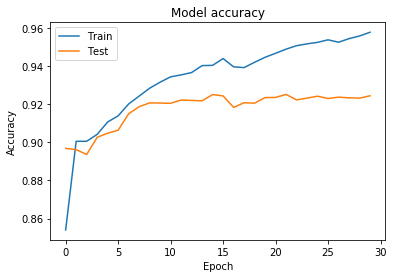

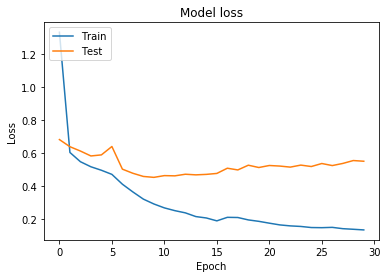

In [73]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
# # overfit and evaluate the model 
loss, accuracy = model.evaluate(dataset, batch_size=32, verbose=0)
print('Accuracy: {}'.format(accuracy * 100))


InvalidArgumentError: Incompatible shapes: [15,8] vs. [32,8]
	 [[{{node conv_attention_3/time_distributed_15/while_1/while/add_1}}]]

In [68]:
model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


In [75]:
# translate prediction

from data.utils import translate_tokenized_array_to_list_words, predict_name

# prediction = model.predict(np.expand_dims(code_snippet[8], 0), steps=1)
prediction = model.predict(code_snippet[9:10], steps=1)
print(prediction.argmax(2))
# translate_tokenized_array_to_list_words(vocab, [10])
# predict_name(vocab, model, code_snippet[21].reshape(1, -1))
# translate_tokenized_array_to_list_words(vocab, prediction.argmax(2)[0])
# print(prediction2.argmax(2))
# prediction.argmax(2)
# label_name.shape
# code_snippet.shape



[[10 35 20 87 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]


In [82]:
from data.utils import translate_tokenized_array_to_list_words

translate_tokenized_array_to_list_words(vocab, np.asarray([ 10, 473, 148,  39,  11,]))
# translate_tokenized_array_to_list_words(vocab, label_name[10].reshape(1, -1)[0])

['<s>', 'resolve', 'and', 'routing', '</s>']

In [76]:
prediction = model.predict(np.expand_dims(code_snippet[10], axis=0), steps=1, batch_size=1)


In [77]:

val, probs = tf.keras.backend.ctc_decode(
    prediction,
    (max_chunk_length, )*1,
    greedy=False,
    beam_width=100,
    top_paths=2
)

tf.Session().run(val)

[array([[ 10, 473, 148,  39,   0]]), array([[ 10, 473, 148,  39,  11,   0]])]

array([[ 10,  56, 221,  12,  19,  11,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])